In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

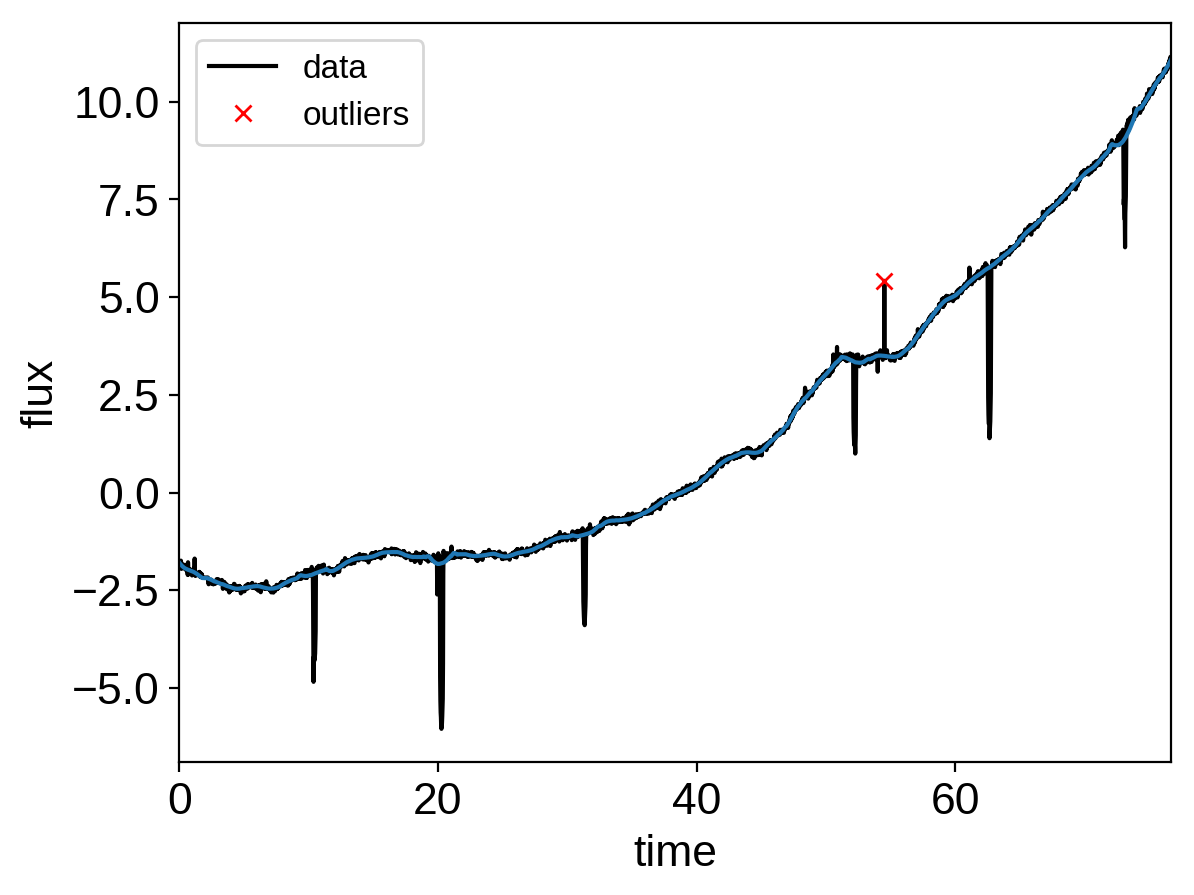

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

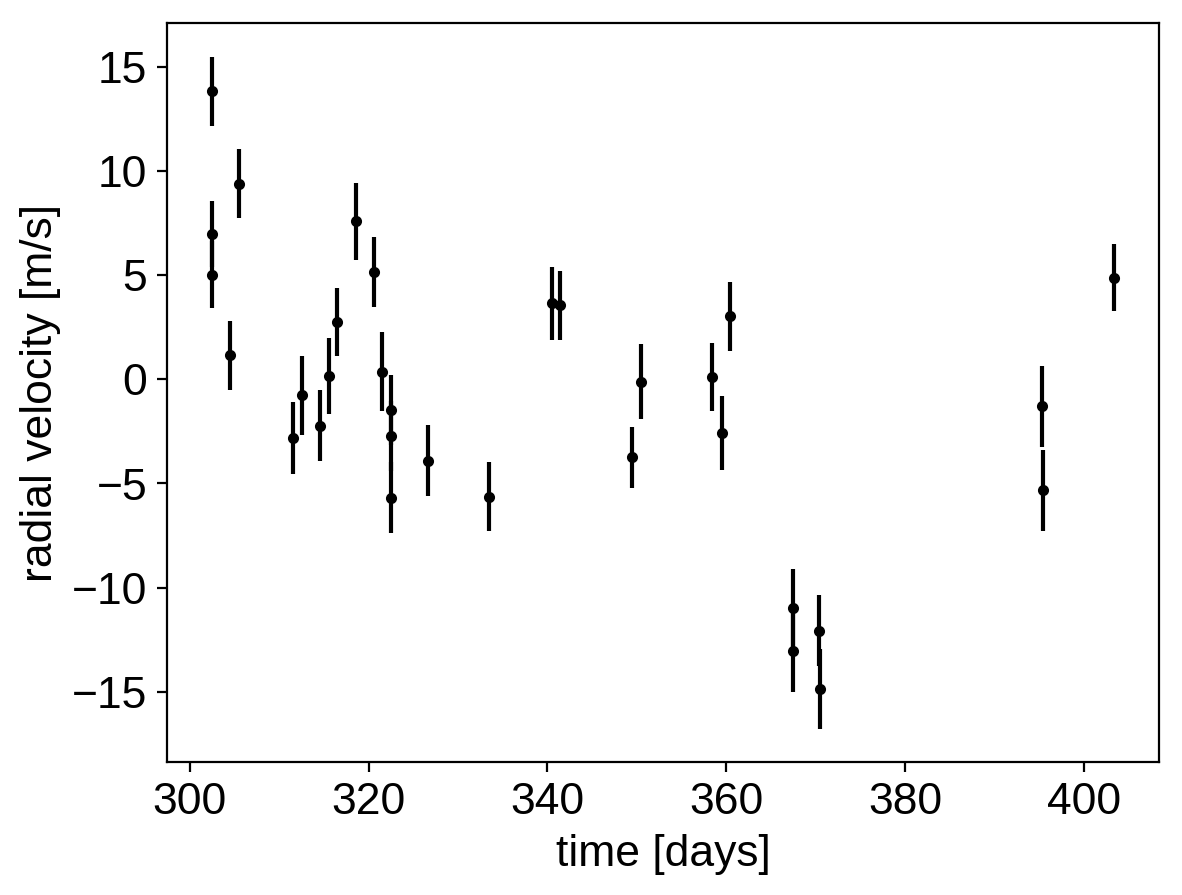

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

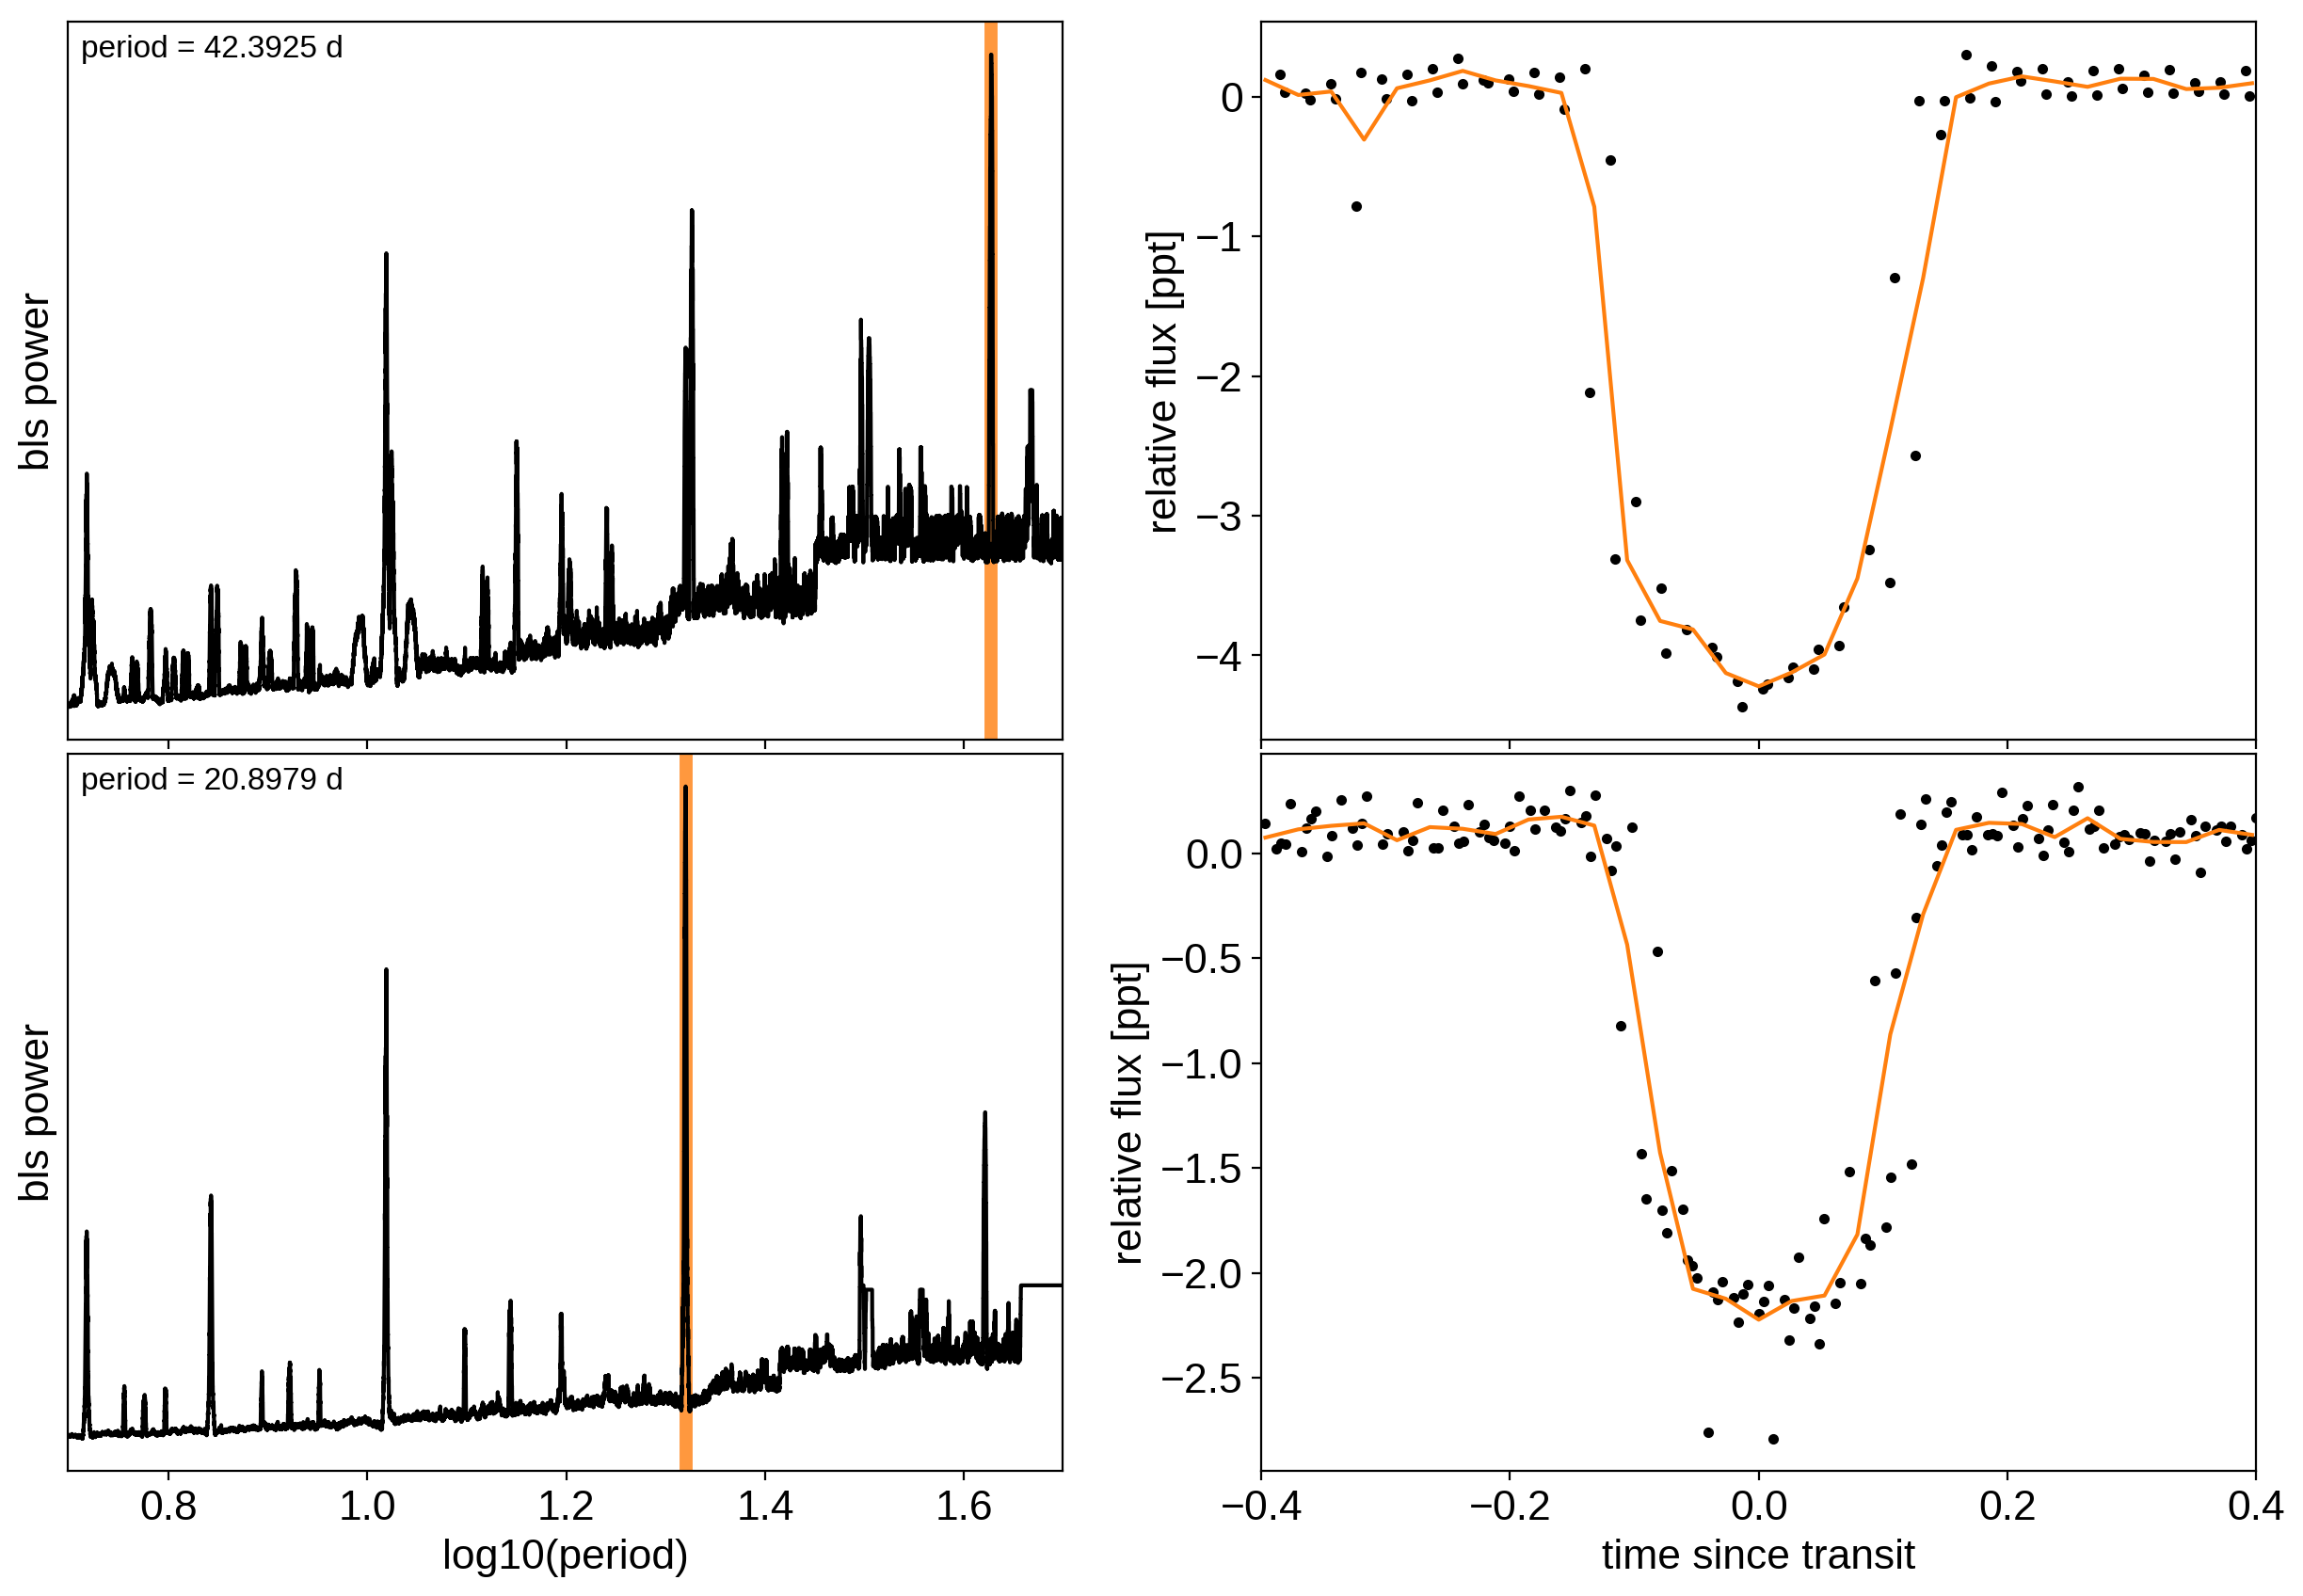

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.UnitUniform("b", shape=2)

        # The eccentricity must be in the range [0, 1)
        ecc = xo.distributions.UnitUniform("ecc", shape=2, testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8252.458112133228 -> -8235.857918833159


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8235.857918833159 -> 1983.3095909540777


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 1983.3095909540777 -> 2677.812419309953


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2677.812419309953 -> 3332.3261695783804


optimizing logp for variables: ['logpower', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 3332.3261695783804 -> 4289.716985009548


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4289.716985009548 -> 4363.669068870872


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_logodds__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4363.669068870872 -> 4776.034775178204


Now let's plot the map radial velocity model.

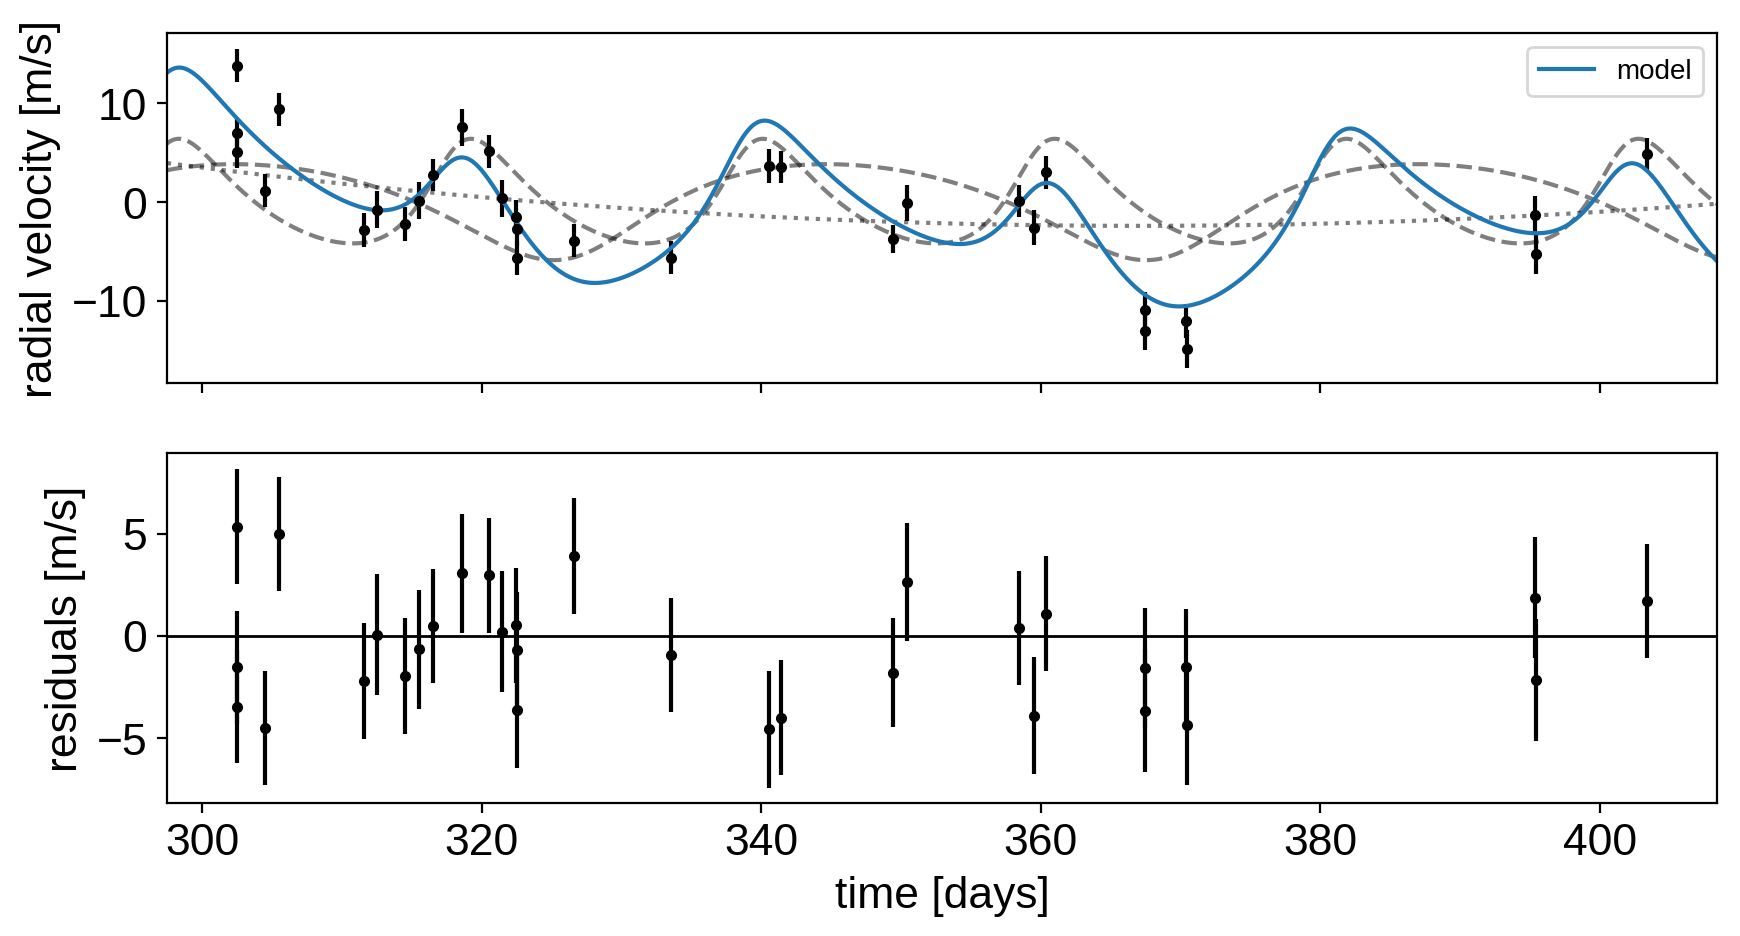

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

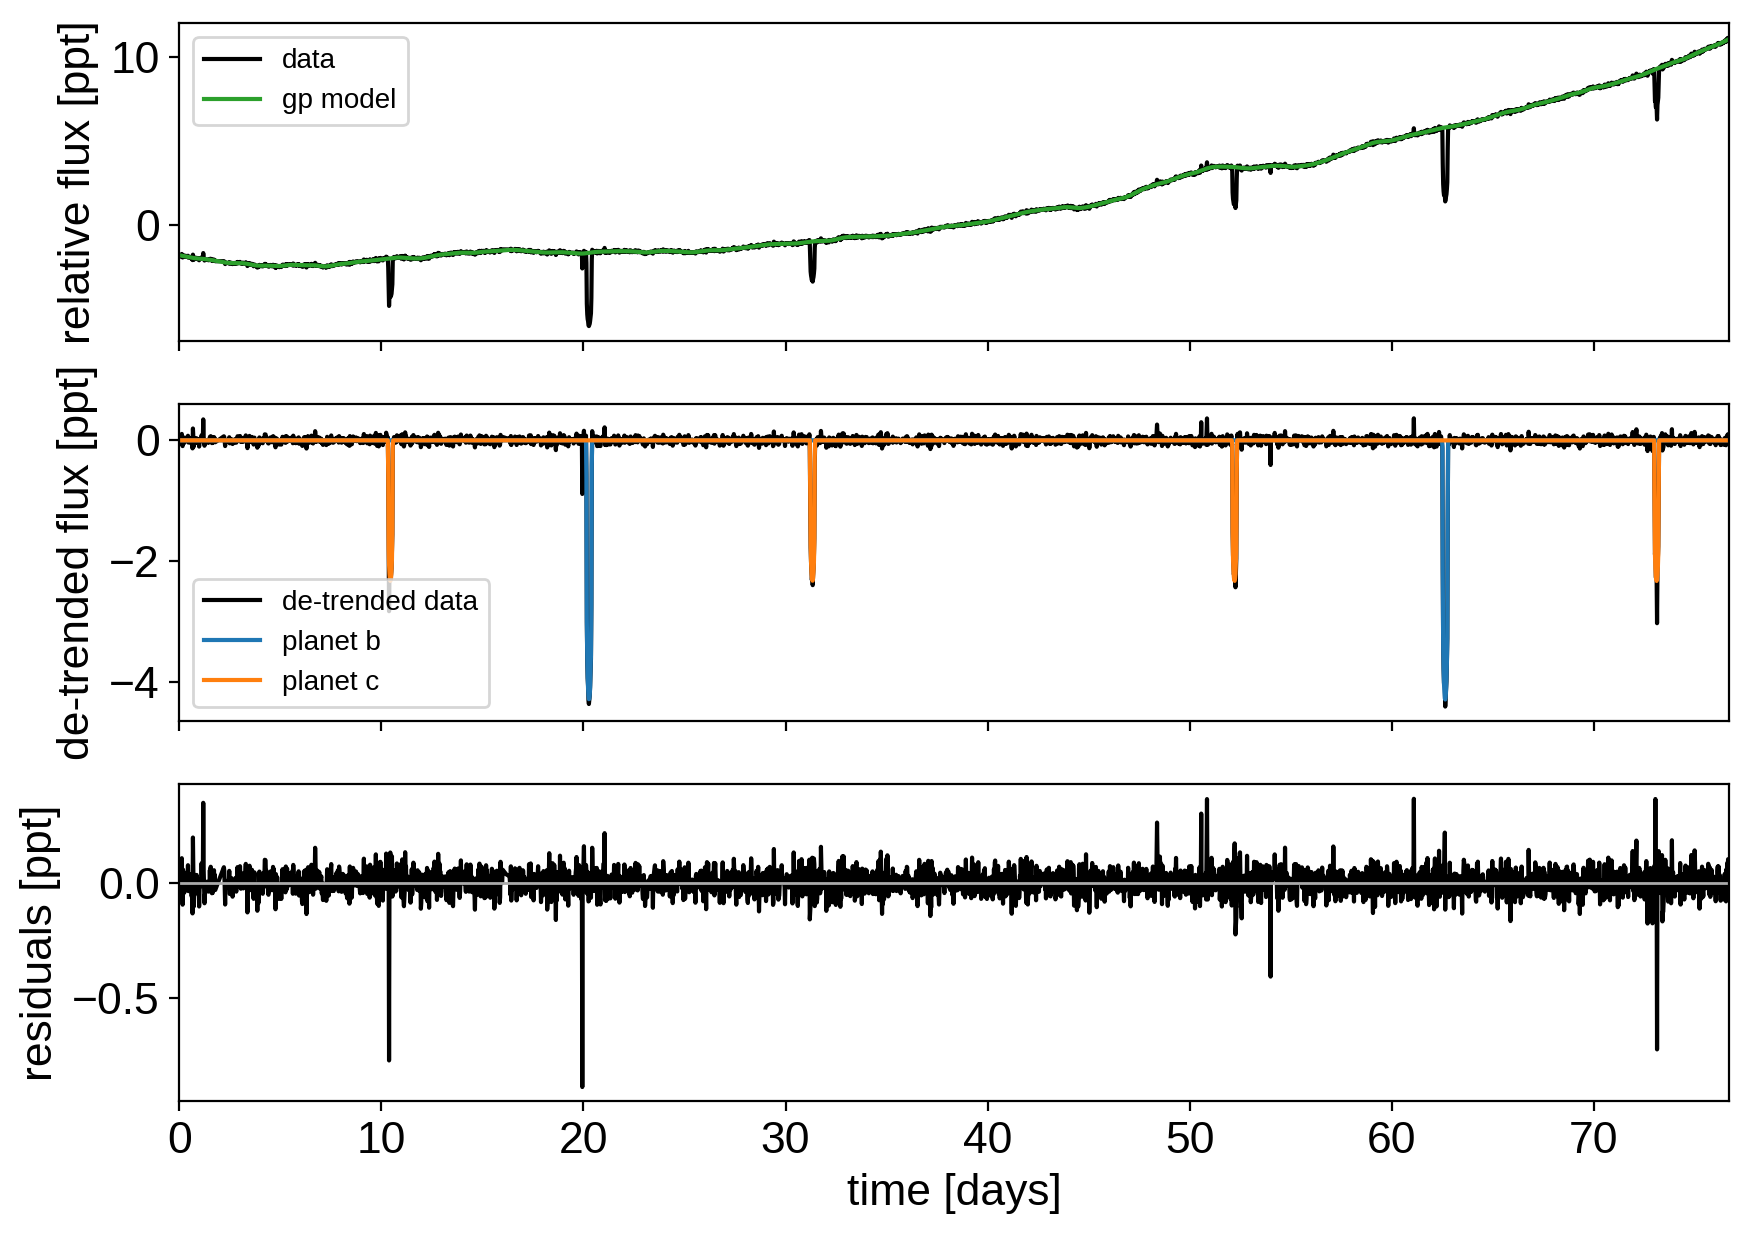

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

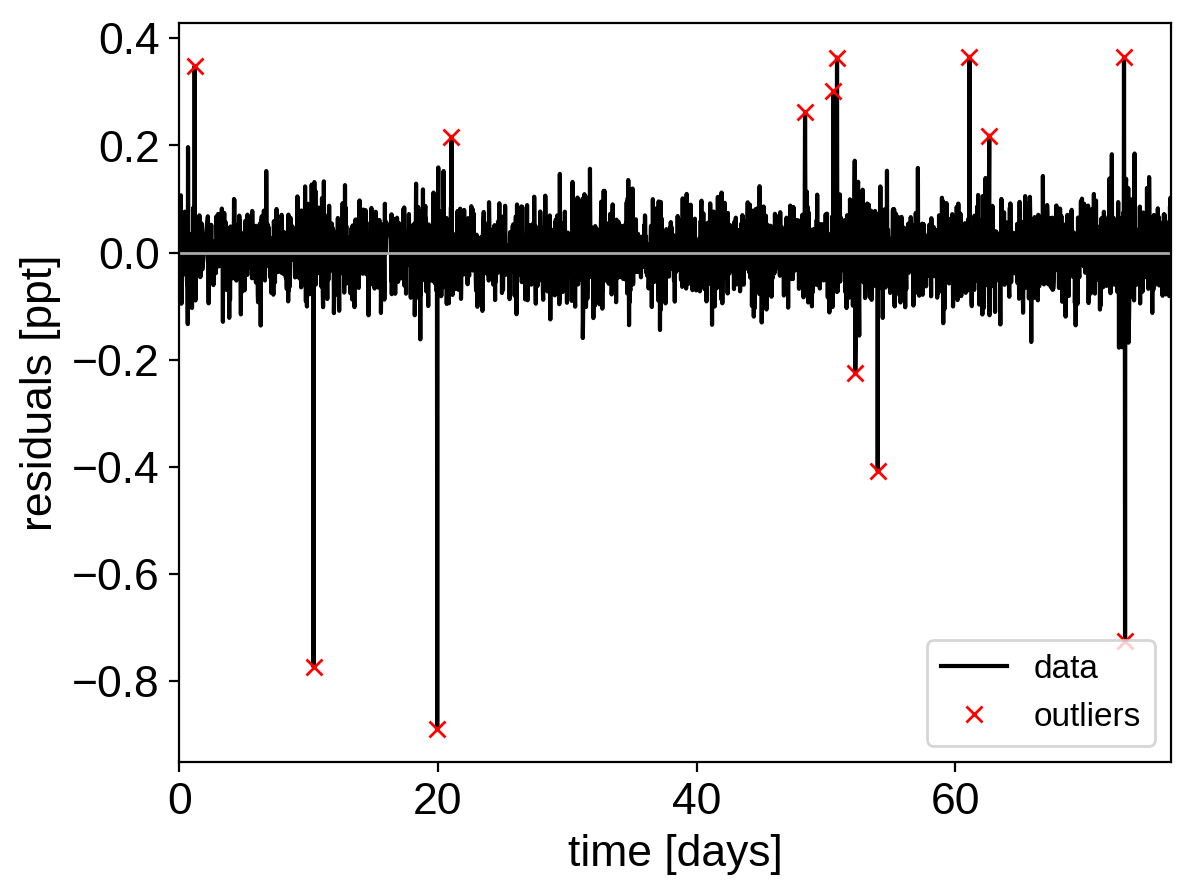

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Desired error not necessarily achieved due to precision loss.
logp: 5226.0716327688615 -> 5226.0716327688615


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5226.0716327688615 -> 5308.189016008111


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 5308.189016008104 -> 5319.206533672209


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 5319.206533672209 -> 5320.685671101893


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5320.685671101885 -> 5321.4203787187125


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 5321.4203787187125 -> 5321.45465390413


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_logodds__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5321.454653904127 -> 5323.372938137332


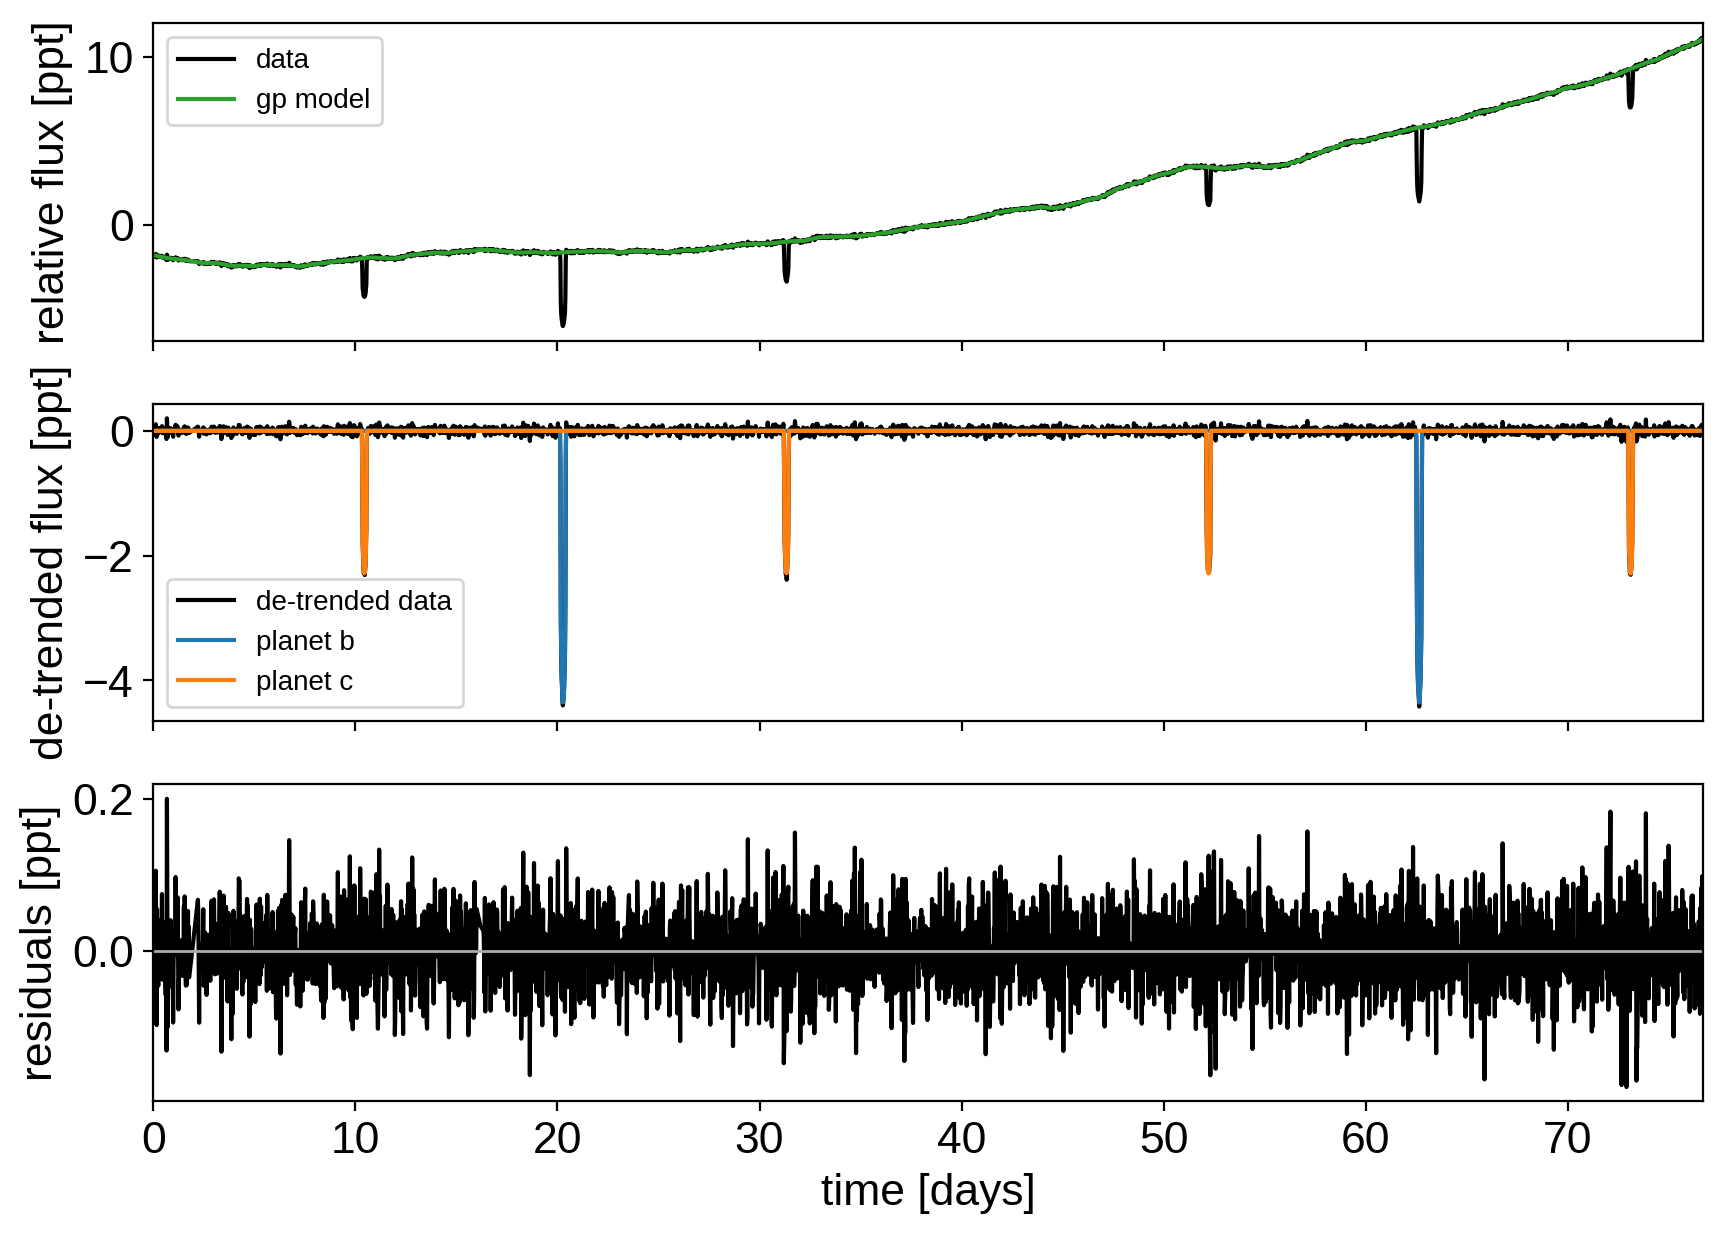

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:24, 32.54draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:51, 15.15draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<01:10, 11.02draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:02<01:24,  9.16draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:02<01:07, 11.48draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:03<01:45,  7.30draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:03<01:25,  8.94draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:03<01:55,  6.62draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:03<01:35,  8.03draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:04<01:59,  6.36draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:04<01:40,  7.60draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:04<02:00,  6.28draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:04<01:42,  7.37draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:05<02:00,  6.27draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:05<01:43,  7.24draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:06<02:44,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:06<02:09,  5.76draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:06<02:57,  4.21draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:06<02:20,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:07<03:01,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:07<02:23,  5.14draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:07<02:58,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:08<02:23,  5.13draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:08<02:55,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:08<02:21,  5.17draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:08<02:50,  4.29draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:09<02:19,  5.22draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:09<02:44,  4.43draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:09<02:03,  5.85draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:10<02:17,  5.24draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:10<01:48,  6.61draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:10<02:07,  5.65draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:10<01:41,  7.08draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:11<02:01,  5.87draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:11<01:36,  7.34draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:11<01:58,  5.98draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:12<01:34,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:12<01:56,  6.04draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:12<01:33,  7.54draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:13<01:55,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:13<01:32,  7.59draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:13<01:55,  6.07draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:13<01:31,  7.64draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:14<01:54,  6.08draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:14<01:30,  7.63draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:14<01:53,  6.08draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:14<01:29,  7.67draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:15<01:54,  6.00draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:15<01:48,  6.29draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:16<01:50,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:16<01:46,  6.36draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:16<01:46,  6.35draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:17<01:44,  6.44draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:17<01:42,  6.59draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:17<01:42,  6.57draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:17<01:38,  6.81draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:18<01:39,  6.68draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:18<01:33,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:18<01:37,  6.80draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:19<01:29,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:19<01:35,  6.92draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:19<01:22,  7.95draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:20<01:40,  6.49draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:20<01:24,  7.69draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:20<01:44,  6.25draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:20<01:25,  7.62draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:21<01:45,  6.12draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:21<01:24,  7.63draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:21<01:46,  6.04draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:22<01:22,  7.73draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:22<01:45,  6.05draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:23<01:50,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:23<01:23,  7.55draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:23<01:45,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:24<01:50,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:24<01:44,  5.97draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:25<01:40,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:25<01:15,  8.12draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:26<01:41,  6.05draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:26<01:44,  5.84draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:26<01:19,  7.64draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:27<01:42,  5.94draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:27<01:44,  5.74draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:28<01:22,  7.30draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:28<01:41,  5.90draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:28<01:20,  7.38draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:29<01:39,  6.01draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:29<01:19,  7.48draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:29<01:37,  6.06draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:29<01:18,  7.53draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:30<01:36,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:30<01:17,  7.54draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:30<01:35,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:30<01:16,  7.56draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:31<01:34,  6.10draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:31<01:16,  7.55draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:32<01:33,  6.12draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:32<01:16,  7.51draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:32<01:33,  6.13draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:32<01:15,  7.50draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:33<01:32,  6.15draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:33<01:15,  7.50draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:33<01:31,  6.16draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:33<01:14,  7.49draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:34<01:30,  6.17draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:34<01:14,  7.48draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:35<01:29,  6.19draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:35<01:14,  7.47draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:35<01:29,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:35<01:13,  7.47draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:36<01:28,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:36<01:12,  7.47draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:36<01:27,  6.19draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:36<01:12,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:37<01:26,  6.20draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:37<01:12,  7.45draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:37<01:26,  6.22draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:38<01:11,  7.44draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:38<01:25,  6.24draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:38<01:11,  7.42draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:38<01:23,  6.36draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:39<01:33,  5.61draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:39<01:17,  6.76draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:39<01:29,  5.87draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:39<01:35,  5.49draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:39<01:18,  6.60draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:40<01:31,  5.67draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:40<01:35,  5.46draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:40<01:18,  6.55draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:40<01:32,  5.57draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:40<01:33,  5.53draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:41<01:17,  6.60draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:41<01:35,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:41<01:30,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:41<01:16,  6.68draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:41<01:35,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:42<01:27,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:42<01:14,  6.78draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:42<01:36,  5.24draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:42<01:25,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:42<01:12,  6.87draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:43<01:36,  5.17draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:43<01:23,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:43<01:11,  6.95draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:43<01:37,  5.10draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:43<01:16,  6.45draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:44<01:29,  5.51draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:44<01:09,  7.01draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:44<01:25,  5.72draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:45<01:11,  6.80draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:45<01:18,  6.15draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:45<01:08,  7.00draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:46<01:41,  4.74draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:46<01:20,  5.89draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:46<01:51,  4.28draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:46<01:27,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:47<01:55,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:47<01:30,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:47<01:57,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:48<01:31,  5.10draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:48<01:57,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:48<01:31,  5.06draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:49<01:56,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:49<01:30,  5.04draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:49<01:54,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:49<01:29,  5.05draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:50<01:53,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:50<01:28,  5.08draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:50<01:51,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:51<01:24,  5.26draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:51<01:31,  4.87draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:51<01:11,  6.16draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:52<01:20,  5.46draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:52<01:05,  6.70draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:52<01:14,  5.83draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:52<01:02,  6.96draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:53<01:11,  6.05draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:53<01:00,  7.06draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:53<01:09,  6.20draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:54<01:00,  7.08draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:54<01:07,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:54<00:59,  7.04draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:55<01:05,  6.39draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:55<00:59,  6.99draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:55<01:04,  6.46draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:55<00:59,  6.93draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:56<01:03,  6.52draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:56<00:59,  6.91draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:56<01:02,  6.58draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:57<00:58,  6.92draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:57<01:01,  6.61draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:57<00:58,  6.92draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:57<01:00,  6.63draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:58<00:57,  6.91draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:58<00:59,  6.66draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:58<00:57,  6.88draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:59<00:59,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:59<00:56,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:59<00:58,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:59<00:55,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:00<00:57,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:00<00:55,  6.89draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:00<00:56,  6.68draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:01<00:54,  6.89draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:01<00:50,  7.50draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:01<00:59,  6.37draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:01<00:56,  6.63draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:01<00:52,  7.08draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:02<00:58,  6.35draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:02<00:56,  6.57draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:02<00:53,  6.89draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:02<00:57,  6.44draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:02<00:50,  7.21draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:02<00:55,  6.57draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:03<00:55,  6.56draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:03<00:55,  6.56draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:03<00:49,  7.29draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:03<00:54,  6.59draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:03<00:56,  6.42draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:03<00:53,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:03<00:48,  7.37draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:04<00:54,  6.61draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:04<00:56,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:04<00:52,  6.81draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:04<00:47,  7.42draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:04<00:53,  6.62draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:04<00:57,  6.14draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:05<00:50,  6.93draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:05<00:47,  7.46draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:05<00:52,  6.64draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:05<00:58,  6.01draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:05<00:50,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:05<00:55,  6.26draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:06<01:00,  5.67draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:06<00:51,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:06<00:55,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:06<01:02,  5.49draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:06<00:52,  6.51draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:07<00:55,  6.07draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:07<01:03,  5.34draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:07<00:51,  6.45draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:07<00:55,  6.02draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:07<01:03,  5.20draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:08<00:51,  6.40draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:08<00:55,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:08<01:04,  5.08draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:08<00:51,  6.35draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:08<00:54,  5.93draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:09<01:03,  5.09draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:09<00:50,  6.35draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:09<00:54,  5.90draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:09<01:03,  5.05draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:09<00:50,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:10<00:54,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:10<01:02,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:10<00:49,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:10<00:53,  5.84draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:10<01:01,  5.08draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:11<00:48,  6.36draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:11<00:53,  5.83draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:11<01:00,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:11<00:48,  6.37draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:11<00:52,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:12<00:59,  5.13draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:12<00:47,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:12<00:52,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:12<00:58,  5.14draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:12<00:50,  5.99draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:13<00:45,  6.53draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:13<00:53,  5.56draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:13<00:47,  6.19draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:13<00:43,  6.77draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:13<00:51,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:13<00:47,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:14<00:42,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:14<00:50,  5.77draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:14<00:46,  6.15draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:14<00:41,  6.82draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:15<00:48,  5.82draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:15<00:46,  6.16draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:15<00:41,  6.79draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:15<00:47,  5.89draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:15<00:45,  6.19draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:15<00:40,  6.81draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:16<00:46,  5.91draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:16<00:44,  6.20draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:16<00:40,  6.80draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:16<00:45,  5.95draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:16<00:43,  6.22draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:17<00:39,  6.80draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:17<00:44,  5.99draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [01:17<00:43,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:17<00:39,  6.79draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:17<00:43,  6.02draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:18<00:42,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:18<00:37,  6.94draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:18<00:36,  7.19draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:18<00:41,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [01:18<00:40,  6.36draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:18<00:37,  6.89draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:18<00:35,  7.33draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:19<00:40,  6.41draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:19<00:39,  6.44draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:19<00:37,  6.75draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:19<00:34,  7.41draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:19<00:39,  6.48draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:19<00:38,  6.49draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:20<00:38,  6.59draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:20<00:37,  6.69draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:20<00:37,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:20<00:37,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:20<00:36,  6.73draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:21<00:36,  6.62draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:21<00:38,  6.34draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:21<00:35,  6.71draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:21<00:36,  6.60draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:21<00:38,  6.15draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:22<00:35,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:22<00:35,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:22<00:39,  5.97draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:22<00:35,  6.60draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:22<00:35,  6.51draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:23<00:39,  5.79draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:23<00:34,  6.55draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:23<00:35,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:23<00:40,  5.62draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:23<00:34,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:23<00:34,  6.42draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:24<00:40,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:24<00:34,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [01:24<00:34,  6.37draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:24<00:41,  5.31draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:25<00:34,  6.38draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:25<00:34,  6.33draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:25<00:40,  5.26draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:25<00:33,  6.36draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:25<00:33,  6.31draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:26<00:40,  5.23draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:26<00:33,  6.28draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:26<00:32,  6.35draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:26<00:39,  5.22draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:26<00:32,  6.30draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:26<00:32,  6.37draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:27<00:39,  5.20draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:27<00:31,  6.30draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [01:27<00:31,  6.37draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:27<00:38,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:27<00:31,  6.29draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:28<00:30,  6.37draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:28<00:37,  5.14draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:28<00:30,  6.28draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:28<00:30,  6.36draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:28<00:37,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:29<00:30,  6.27draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:29<00:29,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:29<00:36,  5.09draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:29<00:29,  6.27draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:29<00:29,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:30<00:36,  5.06draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:30<00:30,  5.89draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:30<00:26,  6.76draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:30<00:34,  5.23draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:30<00:30,  5.92draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:31<00:25,  6.89draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:31<00:33,  5.25draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:31<00:29,  5.83draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:31<00:24,  6.91draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [01:31<00:32,  5.23draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:32<00:29,  5.77draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:32<00:24,  6.90draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [01:32<00:32,  5.21draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:32<00:28,  5.79draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:32<00:23,  6.91draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:33<00:31,  5.19draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:33<00:27,  5.81draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:33<00:23,  6.92draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:33<00:30,  5.17draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:33<00:27,  5.84draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:34<00:22,  6.89draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:34<00:29,  5.19draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:34<00:26,  5.90draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:34<00:21,  6.94draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:34<00:29,  5.19draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:35<00:25,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:35<00:21,  6.97draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:35<00:28,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:35<00:24,  5.99draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:35<00:22,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:36<00:23,  6.16draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:36<00:20,  6.96draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:36<00:19,  7.13draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:36<00:21,  6.58draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:36<00:19,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:37<00:20,  6.57draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:37<00:19,  6.90draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:37<00:19,  6.59draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:38<00:18,  6.84draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:38<00:19,  6.62draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:38<00:18,  6.88draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:39<00:18,  6.64draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:39<00:17,  6.90draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:39<00:17,  6.64draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:39<00:16,  6.91draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:40<00:17,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:40<00:16,  6.92draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:40<00:16,  6.63draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:41<00:15,  6.93draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:41<00:16,  6.62draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:41<00:15,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:41<00:15,  6.62draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:42<00:14,  6.96draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:42<00:13,  7.64draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:42<00:16,  6.13draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:42<00:14,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:42<00:13,  7.09draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:43<00:15,  6.00draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:43<00:14,  6.51draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:43<00:13,  6.82draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:43<00:15,  5.98draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:44<00:13,  6.51draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:44<00:13,  6.63draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:44<00:14,  5.99draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:44<00:12,  6.54draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:44<00:12,  6.48draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:44<00:13,  6.01draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:45<00:12,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:45<00:12,  6.34draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:45<00:13,  6.06draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [01:45<00:11,  6.62draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:45<00:12,  6.21draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:46<00:12,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [01:46<00:10,  6.67draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:46<00:11,  6.09draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:46<00:11,  6.17draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:46<00:10,  6.72draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:47<00:11,  5.97draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:47<00:10,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [01:47<00:09,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:47<00:10,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:47<00:10,  6.25draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [01:48<00:08,  6.83draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:48<00:10,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:48<00:09,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [01:48<00:08,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:48<00:09,  5.63draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:49<00:08,  6.31draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [01:49<00:07,  6.91draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:49<00:09,  5.54draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:49<00:08,  6.36draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [01:49<00:07,  6.97draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:50<00:08,  5.45draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [01:50<00:06,  6.94draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:50<00:07,  5.69draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [01:51<00:06,  6.52draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:51<00:07,  5.07draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:51<00:06,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:52<00:07,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [01:52<00:05,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [01:52<00:07,  4.52draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [01:52<00:05,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [01:53<00:06,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [01:53<00:04,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [01:53<00:05,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [01:54<00:03,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:54<00:04,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [01:54<00:03,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:55<00:03,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [01:55<00:02,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [01:55<00:03,  3.81draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [01:56<00:03,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [01:56<00:03,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:57<00:02,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [01:57<00:02,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:57<00:01,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [01:59<00:01,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [01:59<00:01,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:00<00:00,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:00<00:00,  2.60draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:02<00:00,  1.02draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:11, 32.38draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:01<00:25, 14.79draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:01<00:35, 10.72draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:02<00:41,  8.99draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:03<00:45,  8.12draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:03<00:48,  7.62draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:03<00:37,  9.72draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:04<00:53,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:04<00:43,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:04<00:56,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:05<00:43,  8.15draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:05<00:56,  6.29draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:05<00:45,  7.67draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:06<00:56,  6.19draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:06<00:44,  7.84draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:06<00:55,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:06<00:45,  7.53draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:07<00:55,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:07<00:46,  7.34draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:07<00:54,  6.15draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:08<00:46,  7.22draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:08<01:10,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:08<00:52,  6.28draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:09<01:00,  5.41draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:09<00:47,  6.81draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:09<00:56,  5.73draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:09<00:45,  7.07draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:10<00:53,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:10<00:44,  7.14draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:10<00:52,  5.99draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:11<00:43,  7.20draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:11<00:51,  6.10draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:11<00:40,  7.65draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:11<00:34,  8.82draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:12<00:41,  7.38draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:12<00:39,  7.69draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:12<00:52,  5.75draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:12<00:45,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:12<00:43,  6.80draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:13<00:53,  5.54draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:13<00:46,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:13<00:44,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:13<00:52,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:14<00:46,  6.28draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:14<00:38,  7.52draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:14<00:46,  6.20draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:14<00:43,  6.67draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:14<00:41,  6.88draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:15<00:46,  6.07draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:15<00:44,  6.41draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:15<00:41,  6.75draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:15<00:45,  6.11draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:15<00:43,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:16<00:41,  6.71draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:16<00:44,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:16<00:38,  7.12draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:16<00:38,  7.10draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:16<00:40,  6.71draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:17<00:35,  7.48draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:17<00:36,  7.28draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:17<00:39,  6.79draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:17<00:38,  6.81draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:17<00:38,  6.81draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:18<00:39,  6.71draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:18<00:39,  6.68draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:18<00:39,  6.66draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:18<00:37,  6.82draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:18<00:38,  6.67draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:19<00:39,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:19<00:36,  7.03draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:19<00:37,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:19<00:38,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:19<00:34,  7.21draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:20<00:36,  6.77draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:20<00:37,  6.56draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:20<00:30,  8.02draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:20<00:40,  6.01draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:20<00:40,  6.01draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:21<00:33,  7.10draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:21<00:43,  5.52draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:21<00:42,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:21<00:34,  6.83draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:21<00:44,  5.29draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:22<00:43,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:22<00:34,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:22<00:45,  5.05draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:22<00:43,  5.30draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:22<00:34,  6.71draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:23<00:40,  5.60draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:23<00:31,  7.11draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:23<00:38,  5.75draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:24<00:36,  6.04draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:24<00:35,  6.09draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:24<00:34,  6.27draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:25<00:33,  6.41draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:25<00:32,  6.46draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:25<00:31,  6.60draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:26<00:31,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:26<00:29,  6.94draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:26<00:27,  7.30draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:26<00:22,  8.90draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:27<00:25,  7.72draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:27<00:22,  8.75draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:28<00:28,  6.81draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:28<00:23,  8.02draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:28<00:29,  6.42draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:28<00:24,  7.73draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:29<00:29,  6.21draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:29<00:22,  8.01draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:29<00:28,  6.26draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:29<00:21,  8.14draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:30<00:28,  6.15draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:30<00:23,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:31<00:26,  6.39draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:31<00:23,  7.28draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:31<00:26,  6.33draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:31<00:23,  7.14draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:32<00:35,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:32<00:27,  5.81draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:32<00:37,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:33<00:29,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:33<00:36,  4.23draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:33<00:29,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:34<00:35,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:34<00:28,  5.21draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:34<00:34,  4.33draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:34<00:27,  5.25draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:35<00:32,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:35<00:26,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:35<00:30,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:35<00:23,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:36<00:20,  6.55draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:36<00:24,  5.46draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:36<00:19,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:36<00:22,  5.77draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:37<00:18,  7.12draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:37<00:21,  5.96draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:37<00:17,  7.22draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:38<00:20,  6.05draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:38<00:16,  7.18draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:38<00:20,  5.81draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:38<00:21,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:38<00:16,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:39<00:18,  6.19draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:39<00:15,  7.10draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:39<00:19,  5.73draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:39<00:18,  5.95draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:40<00:15,  6.78draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:40<00:19,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:40<00:17,  5.98draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:40<00:15,  6.72draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:41<00:18,  5.49draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:41<00:16,  6.13draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:41<00:14,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:41<00:14,  6.99draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:41<00:12,  7.66draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:41<00:15,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:42<00:14,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:42<00:14,  6.30draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:42<00:13,  6.57draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:43<00:13,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:43<00:11,  7.29draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:43<00:15,  5.37draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:44<00:13,  6.21draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:44<00:15,  5.05draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:44<00:13,  5.85draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:44<00:15,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:45<00:12,  5.71draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:45<00:14,  5.01draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:45<00:11,  6.02draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:46<00:10,  6.57draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:46<00:09,  6.89draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:46<00:10,  6.12draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:47<00:09,  6.46draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:47<00:09,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:47<00:08,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:47<00:08,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:48<00:06,  8.12draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:48<00:07,  6.17draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:48<00:07,  6.36draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:49<00:07,  6.43draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:49<00:05,  7.98draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:49<00:06,  6.25draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:49<00:05,  7.68draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:50<00:05,  6.18draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:50<00:04,  7.41draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:50<00:05,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:51<00:04,  7.32draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:51<00:06,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:51<00:04,  6.00draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:52<00:05,  4.42draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:52<00:04,  5.49draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:52<00:05,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:52<00:03,  5.41draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:53<00:03,  5.27draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:53<00:02,  6.14draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:53<00:02,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:54<00:02,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:54<00:02,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:54<00:01,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:55<00:01,  3.68draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:55<00:01,  4.09draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:55<00:01,  3.58draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:56<00:00,  3.17draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:57<00:00,  2.03draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:58<00:00,  2.14draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<08:38,  1.56draws/s]

Sampling 4 chains:   1%|          | 5/808 [00:01<06:38,  2.02draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:01<05:13,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:02<04:15,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:03<03:33,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:03<03:05,  4.25draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:04<02:45,  4.75draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:04<02:30,  5.17draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:05<01:52,  6.88draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:05<02:22,  5.41draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:06<02:26,  5.27draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:06<02:16,  5.61draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:06<01:43,  7.38draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:07<02:15,  5.63draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:07<02:16,  5.58draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:08<01:45,  7.15draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:08<02:15,  5.57draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:09<02:13,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:09<01:56,  6.44draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:09<01:58,  6.29draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:09<01:50,  6.77draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:10<01:53,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:10<01:48,  6.83draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:11<01:51,  6.66draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:11<01:50,  6.71draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:11<01:50,  6.62draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:11<01:51,  6.57draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:12<01:51,  6.56draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:12<01:51,  6.52draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:12<01:51,  6.54draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:13<01:52,  6.44draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:13<01:29,  8.07draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:13<01:59,  6.02draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:13<01:36,  7.50draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:14<02:01,  5.90draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:14<01:37,  7.33draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:14<02:01,  5.86draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:15<01:39,  7.19draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:15<02:01,  5.83draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:15<01:38,  7.16draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:16<02:00,  5.86draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:16<01:39,  7.07draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:16<01:59,  5.89draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:16<01:38,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:17<02:06,  5.53draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:17<02:11,  5.31draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:17<01:47,  6.49draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:17<02:09,  5.37draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:18<02:14,  5.16draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:18<01:49,  6.30draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:18<02:07,  5.44draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:18<02:15,  5.09draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:18<01:49,  6.26draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:19<02:04,  5.52draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:19<02:17,  5.00draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:19<01:52,  6.07draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:19<01:59,  5.73draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:19<02:15,  5.02draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:20<01:52,  6.05draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:20<01:54,  5.91draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:20<02:02,  5.53draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:20<01:37,  6.94draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:20<01:33,  7.22draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:21<02:19,  4.83draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:21<01:49,  6.13draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:21<01:44,  6.43draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:21<02:23,  4.68draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:21<01:53,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:21<01:49,  6.09draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:22<02:27,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:22<01:53,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:22<02:08,  5.15draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:23<01:41,  6.48draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:23<01:59,  5.52draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:23<01:43,  6.36draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:23<01:32,  7.12draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:24<02:04,  5.25draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:24<01:48,  6.00draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:24<01:36,  6.76draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:24<02:03,  5.25draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:24<01:50,  5.89draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:25<01:37,  6.64draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:25<02:01,  5.30draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:25<01:50,  5.84draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:25<01:37,  6.61draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:25<01:58,  5.40draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:26<01:51,  5.76draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:26<01:37,  6.56draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:26<01:55,  5.52draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:26<01:52,  5.66draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:26<01:38,  6.45draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:27<01:53,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:27<01:52,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:27<01:38,  6.41draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:27<01:50,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:27<01:52,  5.60draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:28<01:38,  6.34draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:28<01:48,  5.76draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:28<01:52,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:28<01:39,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:29<01:50,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:29<01:49,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:29<01:37,  6.35draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:29<01:45,  5.83draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:29<01:48,  5.69draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:30<01:36,  6.34draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:30<01:43,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:30<01:49,  5.61draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:30<01:37,  6.30draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:30<01:39,  6.12draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:31<01:49,  5.54draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:31<01:37,  6.22draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:31<01:37,  6.24draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:31<01:48,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:31<01:37,  6.17draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:32<01:38,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:32<01:45,  5.70draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:32<01:36,  6.19draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:32<01:34,  6.31draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:32<01:43,  5.78draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:33<01:35,  6.23draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:33<01:32,  6.44draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:33<01:41,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:33<01:35,  6.21draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:33<01:29,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:34<01:40,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:34<01:34,  6.21draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:34<01:27,  6.73draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:34<01:39,  5.89draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:35<01:33,  6.22draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:35<01:25,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:35<01:40,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:35<01:33,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:35<01:23,  6.92draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:35<01:40,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:36<01:33,  6.15draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:36<01:34,  6.04draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:36<01:30,  6.33draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:37<01:31,  6.23draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:37<01:28,  6.40draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:37<01:29,  6.34draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:38<01:27,  6.43draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:38<01:27,  6.39draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:38<01:26,  6.43draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:39<01:26,  6.42draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:39<01:26,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:39<01:25,  6.46draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:40<01:26,  6.39draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:40<01:24,  6.47draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:40<01:26,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:40<01:23,  6.50draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:41<01:25,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:41<01:22,  6.56draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:41<01:24,  6.40draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:42<01:21,  6.58draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:42<01:22,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:42<01:21,  6.57draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:43<01:21,  6.50draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:43<01:20,  6.58draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:43<01:20,  6.54draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:43<01:20,  6.56draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:44<01:20,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:44<01:19,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:44<01:19,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:45<01:18,  6.58draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:45<01:18,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:45<01:11,  7.22draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:45<01:20,  6.34draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:46<01:19,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:46<01:14,  6.85draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:46<01:20,  6.32draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:46<01:18,  6.46draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:46<01:17,  6.55draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:47<01:19,  6.36draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:47<01:17,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:47<01:20,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:47<01:17,  6.44draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:47<01:15,  6.60draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:48<01:21,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:48<01:16,  6.50draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:48<01:13,  6.69draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:48<01:23,  5.88draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:48<01:15,  6.55draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:49<01:12,  6.77draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:49<01:27,  5.61draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:49<01:13,  6.67draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:49<01:17,  6.26draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:50<01:34,  5.16draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:50<01:17,  6.24draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:50<01:17,  6.19draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:50<01:36,  4.97draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:50<01:19,  6.07draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:50<01:16,  6.30draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:51<01:38,  4.85draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:51<01:19,  5.98draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:51<01:18,  6.03draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:51<01:38,  4.82draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:52<01:19,  5.94draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:52<01:15,  6.23draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:52<01:38,  4.78draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:52<01:19,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:52<01:13,  6.37draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:53<01:37,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:53<01:19,  5.84draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:53<01:10,  6.57draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:53<01:35,  4.82draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:53<01:19,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:54<01:11,  6.39draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:54<01:32,  4.93draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:54<01:17,  5.89draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:54<01:08,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:54<01:30,  5.01draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:55<01:16,  5.92draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:55<01:11,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:55<01:27,  5.17draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:55<01:15,  5.94draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:55<01:07,  6.60draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:56<01:23,  5.32draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:56<01:16,  5.79draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:56<01:07,  6.53draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:56<01:21,  5.45draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:56<01:18,  5.64draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:57<01:06,  6.56draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:57<01:20,  5.44draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:57<01:20,  5.44draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:57<01:08,  6.32draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:57<01:18,  5.52draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:58<01:20,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:58<01:07,  6.39draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:58<01:18,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:58<01:20,  5.30draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:58<01:08,  6.27draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:59<01:17,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:59<01:21,  5.24draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:59<01:06,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:59<01:17,  5.44draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:00<01:21,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:00<01:08,  6.15draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:00<01:15,  5.53draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [01:00<01:21,  5.12draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [01:00<01:06,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:01<01:15,  5.46draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:01<01:21,  5.04draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:01<01:05,  6.26draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:01<01:16,  5.39draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:01<01:22,  4.96draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:02<01:04,  6.27draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:02<01:15,  5.37draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [01:02<01:23,  4.86draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [01:02<01:04,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [01:03<01:16,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:03<00:58,  6.77draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [01:03<01:03,  6.29draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:03<01:02,  6.38draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:04<01:02,  6.29draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [01:04<01:00,  6.47draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:04<01:00,  6.50draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:04<01:00,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:04<01:00,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:05<00:59,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:05<00:58,  6.55draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:05<01:01,  6.29draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:05<01:00,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:05<00:58,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:06<01:01,  6.15draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:06<01:00,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:06<00:57,  6.56draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:06<01:02,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:06<01:01,  6.15draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:07<00:56,  6.56draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:07<01:02,  5.92draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:07<01:01,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:07<00:56,  6.55draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:08<01:03,  5.81draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:08<01:01,  6.01draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:08<00:56,  6.49draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:08<01:03,  5.76draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:08<00:58,  6.17draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:09<00:55,  6.54draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:09<01:02,  5.76draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:09<00:56,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:09<00:54,  6.60draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:09<01:02,  5.74draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:09<00:54,  6.53draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:10<00:53,  6.65draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:10<01:01,  5.75draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:10<00:51,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:10<00:59,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:11<01:05,  5.36draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:11<00:54,  6.40draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:11<01:00,  5.71draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:11<01:05,  5.24draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:11<00:54,  6.28draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:12<01:00,  5.62draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:12<01:05,  5.17draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:12<00:54,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:12<01:00,  5.59draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:12<01:05,  5.13draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:13<00:54,  6.19draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:13<00:59,  5.59draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:13<01:05,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:13<00:53,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:13<00:59,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:14<01:04,  5.06draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:14<00:53,  6.14draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:14<00:58,  5.60draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:14<01:04,  5.06draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:15<00:52,  6.14draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:15<00:57,  5.60draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:15<01:02,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:15<00:51,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:15<00:56,  5.60draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:16<01:00,  5.27draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:16<00:50,  6.21draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:16<00:55,  5.63draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:16<00:57,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:16<00:49,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:17<00:54,  5.68draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:17<00:56,  5.51draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:17<00:48,  6.31draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:17<00:53,  5.71draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:17<00:53,  5.67draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:18<00:47,  6.35draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:18<00:52,  5.74draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:18<00:51,  5.89draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:18<00:46,  6.42draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:18<00:51,  5.82draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:19<00:48,  6.15draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:19<00:43,  6.77draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:19<00:44,  6.66draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:19<00:50,  5.84draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:19<00:45,  6.45draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:19<00:43,  6.79draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:19<00:43,  6.68draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:20<00:49,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:20<00:43,  6.59draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:20<00:42,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:20<00:43,  6.61draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:20<00:48,  5.93draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:20<00:42,  6.70draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:21<00:42,  6.66draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:21<00:43,  6.57draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:21<00:47,  5.92draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:21<00:43,  6.39draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:21<00:44,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:22<00:47,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:22<00:43,  6.30draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:22<00:43,  6.28draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:22<00:46,  5.85draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:22<00:43,  6.28draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:23<00:43,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:23<00:45,  5.89draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [01:23<00:42,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:23<00:42,  6.35draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:23<00:44,  5.98draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:24<00:41,  6.29draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:24<00:40,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:24<00:43,  6.07draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [01:24<00:41,  6.31draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:24<00:39,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:25<00:42,  6.12draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:25<00:40,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:25<00:38,  6.63draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:25<00:41,  6.16draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:26<00:40,  6.29draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:26<00:37,  6.75draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:26<00:40,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:26<00:39,  6.30draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:26<00:36,  6.82draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:26<00:39,  6.17draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:27<00:38,  6.29draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:27<00:35,  6.87draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [01:27<00:39,  6.19draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:27<00:37,  6.32draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:28<00:34,  6.86draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [01:28<00:38,  6.16draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:28<00:37,  6.33draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:28<00:34,  6.75draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [01:28<00:37,  6.25draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:29<00:36,  6.38draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:29<00:34,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [01:29<00:36,  6.35draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:29<00:35,  6.43draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:29<00:34,  6.67draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [01:30<00:35,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:30<00:34,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:30<00:33,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:30<00:34,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [01:30<00:34,  6.44draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:31<00:32,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [01:31<00:33,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:31<00:33,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:31<00:31,  6.74draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [01:31<00:33,  6.43draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:32<00:32,  6.45draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:32<00:31,  6.70draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [01:32<00:32,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:32<00:32,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:32<00:31,  6.61draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [01:33<00:31,  6.53draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:33<00:31,  6.50draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:33<00:30,  6.56draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [01:33<00:30,  6.61draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [01:34<00:30,  6.49draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:34<00:30,  6.59draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [01:34<00:29,  6.73draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:34<00:30,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:34<00:29,  6.68draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [01:34<00:28,  6.85draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:35<00:29,  6.50draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:35<00:27,  6.83draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [01:35<00:27,  6.99draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:35<00:24,  7.63draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:35<00:31,  5.92draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:35<00:28,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [01:36<00:27,  6.82draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:36<00:25,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:36<00:32,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:36<00:28,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:36<00:26,  6.79draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:36<00:25,  7.24draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:37<00:31,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:37<00:27,  6.43draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:37<00:25,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:37<00:24,  7.28draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:37<00:31,  5.58draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:37<00:27,  6.43draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:37<00:25,  6.95draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:38<00:23,  7.26draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:38<00:31,  5.43draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:38<00:26,  6.31draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:38<00:25,  6.65draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:39<00:32,  5.16draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:39<00:27,  6.12draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:39<00:25,  6.44draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:39<00:32,  5.00draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:39<00:26,  6.04draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [01:39<00:25,  6.28draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:40<00:32,  4.90draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:40<00:26,  5.99draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [01:40<00:25,  6.15draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:40<00:32,  4.84draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:41<00:25,  5.99draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [01:41<00:25,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:41<00:31,  4.82draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:41<00:24,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:41<00:25,  5.93draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:42<00:30,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:42<00:24,  6.02draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:42<00:24,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:42<00:30,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:42<00:23,  6.04draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:43<00:24,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:43<00:29,  4.68draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:43<00:22,  6.01draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:43<00:23,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:43<00:29,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [01:44<00:22,  5.96draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:44<00:25,  5.14draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:44<00:21,  6.03draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:45<00:26,  4.76draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:45<00:22,  5.63draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:45<00:26,  4.64draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:46<00:22,  5.48draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:46<00:26,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:46<00:21,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:47<00:25,  4.64draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:47<00:20,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:47<00:23,  4.69draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:47<00:19,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:48<00:22,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:48<00:19,  5.48draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:48<00:17,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:49<00:17,  5.89draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:49<00:15,  6.31draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:49<00:15,  6.13draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:50<00:14,  6.47draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:50<00:14,  6.25draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:50<00:13,  6.55draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:51<00:14,  6.34draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:51<00:13,  6.57draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:51<00:13,  6.41draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:51<00:12,  6.57draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:52<00:12,  6.46draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:52<00:12,  6.54draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [01:52<00:11,  6.52draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:53<00:11,  6.50draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [01:53<00:11,  6.58draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:53<00:11,  6.44draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:54<00:10,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:54<00:10,  6.39draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [01:54<00:09,  6.69draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:55<00:09,  6.35draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [01:55<00:08,  7.04draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [01:55<00:08,  6.99draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:55<00:07,  7.65draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:55<00:10,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [01:55<00:08,  6.51draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [01:55<00:08,  6.96draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:56<00:07,  7.45draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:56<00:09,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [01:56<00:08,  6.33draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:56<00:07,  6.95draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:56<00:09,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [01:57<00:08,  6.06draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:57<00:07,  6.80draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:57<00:08,  5.27draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [01:57<00:07,  5.87draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:57<00:06,  6.69draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:58<00:08,  5.24draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [01:58<00:07,  5.73draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:58<00:06,  6.64draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:58<00:07,  5.22draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [01:58<00:06,  5.68draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:59<00:05,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:59<00:06,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [01:59<00:05,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [01:59<00:04,  6.55draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [01:59<00:05,  5.33draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [02:00<00:05,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [02:00<00:04,  6.57draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:00<00:05,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [02:00<00:04,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [02:00<00:03,  6.59draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [02:01<00:04,  5.41draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:01<00:03,  6.07draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:01<00:03,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [02:01<00:03,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:02<00:03,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:02<00:03,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [02:02<00:03,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:02<00:03,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:02<00:02,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [02:03<00:02,  4.90draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:03<00:02,  4.69draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:03<00:02,  5.14draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:03<00:02,  4.88draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:03<00:01,  5.54draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:04<00:02,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:05<00:03,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:06<00:02,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:07<00:01,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:08<00:01,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:08<00:00,  1.69draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:09<00:00,  1.44draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<01:02, 25.75draws/s]

Sampling 4 chains:   1%|          | 11/1608 [00:00<02:02, 13.01draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<02:33, 10.39draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:01<03:11,  8.33draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<03:15,  8.13draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:01<03:42,  7.13draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:02<03:34,  7.40draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:02<03:59,  6.63draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:02<03:45,  7.01draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:03<03:51,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:03<03:45,  7.01draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:03<04:40,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:04<04:14,  6.19draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:04<05:02,  5.20draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:04<04:08,  6.32draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:05<03:29,  7.46draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:05<03:03,  8.52draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:05<02:32, 10.22draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:05<02:36,  9.92draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:06<03:03,  8.45draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:06<03:20,  7.73draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:06<02:46,  9.33draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:06<02:27, 10.49draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:06<03:05,  8.35draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:07<02:51,  9.01draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:07<02:30, 10.22draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:07<02:58,  8.61draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:07<02:45,  9.28draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:07<02:31, 10.11draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:08<02:56,  8.68draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:08<03:50,  6.65draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:08<04:09,  6.15draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:09<03:49,  6.68draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:09<03:38,  6.97draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:09<02:59,  8.50draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:09<02:52,  8.80draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:10<02:51,  8.84draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:10<02:28, 10.19draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:10<02:32,  9.91draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:10<02:55,  8.64draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:10<02:26, 10.28draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:11<02:27, 10.24draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:11<02:57,  8.48draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:11<02:50,  8.84draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:11<03:23,  7.39draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:11<03:09,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:12<03:22,  7.42draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:12<03:18,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:12<03:28,  7.18draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:12<02:46,  9.00draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:12<02:45,  9.02draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:13<03:02,  8.18draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:13<02:53,  8.60draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:13<03:56,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:13<04:25,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:13<03:38,  6.81draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:14<04:40,  5.30draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:14<03:55,  6.29draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:14<03:52,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:15<03:54,  6.31draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:15<03:29,  7.04draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:15<02:59,  8.20draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:15<03:15,  7.53draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:15<02:51,  8.60draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:15<02:34,  9.53draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:16<02:25, 10.12draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:16<02:47,  8.76draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:16<02:32,  9.62draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:16<02:20, 10.42draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:17<02:45,  8.83draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:17<02:17, 10.56draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:17<02:19, 10.44draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:17<02:42,  8.95draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:17<02:20, 10.34draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:18<03:10,  7.58draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:18<02:41,  8.96draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:18<02:52,  8.36draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:18<02:42,  8.87draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:19<02:25,  9.87draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:19<02:52,  8.32draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:19<02:48,  8.51draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:19<02:37,  9.09draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:19<02:44,  8.70draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:20<03:14,  7.35draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:20<02:41,  8.84draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:20<02:57,  8.03draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:20<02:25,  9.78draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:20<02:14, 10.58draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:20<02:22,  9.94draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:21<01:54, 12.38draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:21<02:19, 10.12draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:21<02:42,  8.69draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:21<02:26,  9.65draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:22<02:17, 10.21draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:22<02:26,  9.61draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:22<02:25,  9.67draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:22<02:28,  9.43draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:22<02:09, 10.83draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:23<02:05, 11.13draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:23<02:12, 10.54draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:23<02:12, 10.54draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:23<01:57, 11.84draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:23<02:34,  9.01draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:24<02:44,  8.45draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:24<02:18,  9.98draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:24<02:27,  9.40draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:24<02:48,  8.22draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:25<02:51,  8.04draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:25<02:42,  8.50draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:25<02:19,  9.83draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:25<02:02, 11.21draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:26<03:10,  7.21draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:26<02:33,  8.90draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:26<02:30,  9.06draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:26<02:49,  8.05draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:26<02:26,  9.28draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:27<02:34,  8.81draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:27<03:05,  7.34draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:27<03:18,  6.85draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:28<03:16,  6.89draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:28<03:42,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:28<03:23,  6.63draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:29<03:15,  6.89draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:29<02:42,  8.26draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:29<03:08,  7.14draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:29<03:05,  7.23draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:29<02:56,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:29<02:43,  8.22draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:29<02:41,  8.29draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:30<02:34,  8.66draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:30<02:50,  7.83draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:30<02:14,  9.90draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:31<03:12,  6.91draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:31<03:12,  6.89draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:31<03:27,  6.38draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:32<02:41,  8.19draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:32<03:30,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:32<02:43,  8.03draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:33<03:32,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:33<02:52,  7.59draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:33<03:01,  7.21draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:33<02:45,  7.91draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:34<02:49,  7.73draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:34<02:28,  8.81draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:34<02:22,  9.14draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:34<02:27,  8.82draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:34<02:19,  9.34draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:35<02:14,  9.62draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:35<02:17,  9.39draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:35<03:01,  7.11draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:35<03:11,  6.75draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:35<02:43,  7.92draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:36<02:55,  7.35draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:36<02:23,  8.94draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:36<02:17,  9.37draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:36<02:36,  8.19draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:36<02:10,  9.79draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:37<02:20,  9.06draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:37<02:22,  8.96draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:37<02:18,  9.18draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:38<02:18,  9.20draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:38<01:57, 10.82draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [00:38<02:00, 10.49draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:38<02:21,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:38<02:00, 10.51draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:38<02:04, 10.12draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:39<02:42,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:39<03:15,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:39<02:57,  7.08draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:40<02:56,  7.10draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:40<02:41,  7.75draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:40<02:49,  7.35draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:41<02:36,  7.95draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:41<02:27,  8.40draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:41<02:58,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:41<02:23,  8.65draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:41<02:29,  8.27draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:42<02:36,  7.89draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:42<02:29,  8.25draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:42<02:07,  9.67draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:42<02:20,  8.72draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:42<02:02, 10.00draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:43<01:51, 10.97draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:43<02:08,  9.52draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:43<01:53, 10.75draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:43<01:49, 11.13draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:43<02:03,  9.81draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:44<01:59, 10.15draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:44<01:50, 10.95draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [00:44<01:44, 11.52draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:44<01:37, 12.38draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:44<01:38, 12.23draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:45<02:08,  9.33draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:45<01:51, 10.79draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:45<01:50, 10.80draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:45<01:45, 11.35draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:45<01:47, 11.10draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:46<02:30,  7.92draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:46<02:37,  7.58draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:46<02:15,  8.80draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [00:46<02:03,  9.65draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:46<02:05,  9.42draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:47<02:09,  9.15draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:47<02:30,  7.86draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [00:47<02:31,  7.80draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:47<02:38,  7.47draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:47<02:18,  8.54draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [00:47<02:30,  7.80draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:48<02:02,  9.56draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:48<02:11,  8.93draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:48<02:15,  8.65draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:48<01:54, 10.20draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:48<02:07,  9.17draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:49<02:05,  9.30draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:49<01:45, 10.97draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:49<01:37, 11.86draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:49<01:31, 12.68draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:49<01:34, 12.17draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [00:49<01:28, 12.99draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:50<01:56,  9.86draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [00:50<01:51, 10.28draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [00:50<01:40, 11.42draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [00:50<01:40, 11.35draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:50<01:31, 12.47draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:51<01:35, 11.91draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:51<01:27, 12.96draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:51<01:25, 13.24draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:51<01:30, 12.49draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:51<01:25, 13.22draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:51<01:25, 13.16draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:51<01:22, 13.62draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [00:52<01:20, 14.00draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:52<01:15, 14.82draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:52<01:15, 14.80draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [00:52<01:29, 12.48draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [00:53<01:41, 10.98draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [00:53<01:29, 12.38draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:53<01:39, 11.21draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:53<01:46, 10.46draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:53<01:35, 11.64draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [00:54<01:41, 10.86draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:54<01:27, 12.53draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [00:54<01:32, 11.92draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:54<01:50,  9.90draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:54<01:36, 11.40draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [00:54<01:34, 11.59draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:55<01:52,  9.70draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:55<01:42, 10.62draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:55<02:02,  8.90draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:55<01:57,  9.25draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [00:55<01:42, 10.59draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:56<01:39, 10.84draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:56<01:58,  9.08draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:56<01:48,  9.93draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:56<01:40, 10.68draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:57<02:00,  8.92draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [00:57<02:03,  8.69draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [00:57<02:24,  7.37draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [00:57<02:35,  6.86draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:58<02:13,  8.01draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:58<03:06,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [00:58<03:06,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:58<02:31,  7.03draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [00:58<02:34,  6.86draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:59<02:48,  6.30draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:59<02:16,  7.74draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [00:59<02:11,  8.03draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:59<01:56,  9.03draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:59<01:39, 10.55draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [01:00<01:54,  9.13draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [01:00<01:44, 10.03draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [01:00<01:31, 11.41draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [01:00<01:40, 10.38draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [01:00<01:41, 10.26draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [01:01<01:27, 11.79draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [01:01<01:48,  9.49draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [01:01<01:47,  9.62draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [01:01<01:31, 11.30draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:01<01:50,  9.26draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [01:02<01:56,  8.83draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [01:02<01:44,  9.78draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [01:02<01:32, 11.02draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [01:02<01:27, 11.60draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [01:02<01:27, 11.58draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [01:03<02:07,  7.97draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [01:03<01:54,  8.84draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:03<01:53,  8.94draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [01:03<01:40, 10.00draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [01:04<01:36, 10.47draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:04<01:48,  9.29draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [01:04<01:56,  8.59draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [01:04<01:55,  8.62draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [01:05<01:43,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [01:05<01:36, 10.32draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [01:05<01:47,  9.22draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:05<01:32, 10.73draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [01:05<01:31, 10.84draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:06<01:42,  9.57draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [01:06<01:28, 11.15draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [01:06<02:08,  7.66draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [01:06<01:53,  8.63draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [01:07<02:04,  7.87draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [01:07<02:09,  7.53draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [01:07<01:42,  9.44draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [01:08<02:17,  7.03draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [01:08<02:01,  7.98draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [01:08<02:27,  6.56draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [01:08<02:11,  7.30draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [01:09<02:16,  7.03draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [01:09<02:19,  6.88draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [01:09<02:21,  6.74draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [01:10<02:08,  7.43draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [01:10<02:58,  5.33draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [01:10<02:34,  6.15draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [01:11<02:10,  7.27draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [01:11<02:13,  7.09draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [01:11<01:49,  8.58draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [01:11<01:43,  9.07draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [01:12<01:58,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [01:12<01:55,  8.08draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [01:12<02:15,  6.91draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [01:12<02:04,  7.47draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [01:12<01:55,  8.04draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [01:12<01:56,  8.03draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [01:13<02:13,  6.95draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [01:13<01:50,  8.38draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [01:13<01:37,  9.47draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [01:13<01:56,  7.94draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [01:13<01:57,  7.85draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [01:13<01:43,  8.88draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [01:14<01:34,  9.71draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [01:14<01:30, 10.09draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [01:14<01:21, 11.18draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [01:14<01:32,  9.87draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [01:14<01:35,  9.52draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [01:15<02:01,  7.46draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [01:15<01:53,  7.99draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [01:15<01:48,  8.32draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [01:15<02:02,  7.35draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [01:16<01:48,  8.31draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [01:16<01:50,  8.16draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [01:16<02:05,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [01:16<01:45,  8.47draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [01:16<01:50,  8.13draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [01:17<02:47,  5.36draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [01:17<02:15,  6.58draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [01:17<02:15,  6.57draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [01:17<02:17,  6.48draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [01:18<01:53,  7.80draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [01:18<02:05,  7.09draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [01:18<02:06,  6.99draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [01:18<02:13,  6.61draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [01:18<01:45,  8.34draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [01:19<01:54,  7.66draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [01:19<01:40,  8.70draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [01:19<02:10,  6.70draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [01:19<02:07,  6.87draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [01:20<01:51,  7.83draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [01:20<02:11,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [01:20<02:01,  7.13draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [01:21<02:27,  5.86draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [01:21<02:16,  6.32draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [01:21<02:38,  5.44draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [01:21<02:19,  6.16draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [01:22<02:42,  5.30draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [01:22<02:19,  6.16draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [01:22<02:04,  6.87draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [01:22<02:27,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [01:23<02:23,  5.97draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [01:23<02:08,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [01:23<01:58,  7.17draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [01:23<01:45,  8.04draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [01:23<02:08,  6.59draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [01:24<02:23,  5.91draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [01:24<01:53,  7.43draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [01:24<01:59,  7.08draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [01:24<02:11,  6.40draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [01:24<01:47,  7.84draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [01:25<01:53,  7.37draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [01:25<01:41,  8.23draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [01:25<01:27,  9.54draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [01:25<01:47,  7.74draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [01:25<01:39,  8.36draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [01:26<01:36,  8.59draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [01:26<01:38,  8.36draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [01:26<02:37,  5.24draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [01:26<02:55,  4.71draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [01:27<02:36,  5.25draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [01:27<02:31,  5.43draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [01:27<02:23,  5.70draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [01:27<02:14,  6.08draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [01:28<02:15,  6.04draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [01:28<01:49,  7.44draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [01:28<01:57,  6.95draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [01:28<02:01,  6.67draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [01:28<01:54,  7.09draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [01:29<02:03,  6.54draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [01:29<01:36,  8.36draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [01:29<01:30,  8.86draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [01:29<01:32,  8.66draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [01:29<01:25,  9.36draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [01:30<01:36,  8.29draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [01:30<01:38,  8.13draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [01:30<01:37,  8.19draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [01:30<01:37,  8.16draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [01:31<01:51,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [01:31<01:46,  7.40draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [01:31<01:27,  8.99draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [01:31<01:38,  7.99draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [01:32<01:28,  8.81draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [01:32<01:46,  7.34draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [01:32<01:27,  8.88draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [01:32<01:33,  8.35draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [01:33<01:44,  7.44draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [01:33<01:56,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [01:33<01:57,  6.56draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [01:33<01:33,  8.20draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:34<01:28,  8.62draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:34<01:35,  8.00draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [01:34<01:20,  9.47draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [01:35<01:52,  6.79draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [01:35<02:39,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [01:35<02:20,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [01:35<01:50,  6.85draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [01:36<02:13,  5.64draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [01:36<01:45,  7.10draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [01:36<02:22,  5.26draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [01:37<02:20,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [01:37<02:08,  5.82draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:37<02:28,  5.02draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [01:37<02:06,  5.87draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [01:37<02:01,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [01:38<02:23,  5.17draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:38<02:59,  4.13draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [01:38<03:03,  4.03draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [01:38<02:49,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [01:39<02:36,  4.72draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [01:39<02:46,  4.43draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [01:40<03:04,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [01:40<02:21,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [01:40<03:13,  3.79draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [01:40<02:35,  4.69draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [01:41<02:56,  4.14draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [01:41<02:45,  4.41draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [01:41<02:20,  5.17draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [01:41<02:05,  5.80draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [01:41<01:47,  6.74draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [01:41<01:56,  6.19draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [01:42<01:46,  6.79draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [01:42<01:41,  7.14draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [01:42<01:50,  6.53draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [01:42<01:43,  6.97draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [01:42<02:19,  5.15draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [01:42<01:56,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:43<01:46,  6.71draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [01:43<01:27,  8.14draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [01:43<01:23,  8.51draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [01:43<01:24,  8.37draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [01:43<01:21,  8.61draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [01:44<01:30,  7.79draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [01:44<01:24,  8.28draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [01:44<01:20,  8.70draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [01:44<01:22,  8.45draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [01:44<01:17,  8.99draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [01:45<01:26,  8.01draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [01:45<01:19,  8.75draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [01:45<01:37,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [01:45<01:46,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [01:45<01:27,  7.84draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [01:46<01:33,  7.33draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [01:46<01:23,  8.19draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [01:46<01:42,  6.66draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [01:46<01:35,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:47<01:22,  8.21draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [01:47<01:42,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [01:47<01:36,  6.99draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [01:47<01:20,  8.35draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [01:48<01:46,  6.35draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [01:48<01:49,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [01:48<01:43,  6.44draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [01:49<01:40,  6.63draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [01:49<01:49,  6.06draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [01:49<01:27,  7.55draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:49<01:51,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [01:50<01:40,  6.54draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [01:50<01:49,  6.03draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:50<01:38,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [01:50<02:12,  4.96draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:50<02:04,  5.25draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:51<02:01,  5.40draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [01:51<01:45,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:51<01:42,  6.33draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [01:51<02:10,  4.98draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [01:51<01:47,  6.05draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:52<01:40,  6.42draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [01:52<02:21,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [01:52<02:01,  5.30draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [01:52<01:46,  6.07draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:53<02:28,  4.33draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [01:53<02:08,  5.02draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [01:53<01:48,  5.92draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [01:53<01:50,  5.78draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:53<01:40,  6.34draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [01:53<01:27,  7.25draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [01:54<01:25,  7.45draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [01:54<01:27,  7.26draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [01:54<01:16,  8.27draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:54<01:26,  7.31draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [01:54<01:52,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [01:55<01:46,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [01:55<01:31,  6.88draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [01:55<02:01,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:55<01:52,  5.55draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:55<01:33,  6.63draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [01:56<01:31,  6.77draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [01:56<01:35,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [01:56<01:31,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:56<01:35,  6.44draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [01:56<01:32,  6.70draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [01:56<01:37,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [01:57<01:31,  6.72draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [01:57<01:23,  7.30draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [01:57<01:23,  7.28draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [01:57<01:19,  7.71draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [01:57<01:31,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [01:57<01:23,  7.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:58<01:35,  6.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:58<01:22,  7.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:58<01:22,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:58<01:25,  7.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [01:58<01:27,  6.84draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [01:59<01:22,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:59<01:17,  7.66draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [01:59<01:08,  8.73draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:59<01:14,  7.91draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [01:59<01:15,  7.86draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [02:00<01:08,  8.61draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [02:00<01:15,  7.83draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [02:00<01:28,  6.63draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [02:00<01:21,  7.21draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [02:01<01:13,  7.92draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [02:01<01:10,  8.23draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [02:01<01:22,  7.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [02:01<01:36,  6.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [02:02<01:24,  6.80draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [02:02<01:36,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [02:02<01:37,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [02:02<01:19,  7.20draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [02:03<01:28,  6.45draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [02:03<01:22,  6.89draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [02:03<01:28,  6.40draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [02:03<01:54,  4.97draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [02:03<01:31,  6.17draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [02:03<01:21,  6.96draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [02:04<01:09,  8.09draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [02:04<01:06,  8.38draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [02:04<00:59,  9.32draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [02:04<00:53, 10.33draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [02:04<00:51, 10.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [02:05<01:01,  8.94draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [02:05<00:53, 10.31draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [02:05<01:18,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [02:05<01:03,  8.60draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [02:06<01:09,  7.86draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [02:06<01:20,  6.72draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [02:06<02:07,  4.24draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [02:07<01:43,  5.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [02:07<01:44,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [02:07<01:52,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [02:07<01:31,  5.84draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [02:08<02:41,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [02:08<03:08,  2.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [02:08<02:21,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [02:09<02:08,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [02:09<03:04,  2.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [02:09<02:32,  3.45draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [02:10<02:06,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [02:10<02:03,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [02:10<02:25,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [02:11<02:24,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [02:11<02:09,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [02:11<02:11,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [02:12<01:47,  4.79draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [02:12<01:46,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [02:12<01:34,  5.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [02:12<01:28,  5.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [02:13<01:31,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [02:13<01:22,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [02:13<01:13,  6.93draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [02:13<01:17,  6.55draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [02:13<01:15,  6.69draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [02:14<01:39,  5.05draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [02:14<01:32,  5.44draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [02:14<01:29,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [02:15<01:48,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [02:15<01:40,  4.96draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [02:15<01:27,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [02:15<01:18,  6.27draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [02:16<01:18,  6.22draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [02:16<01:15,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [02:16<01:04,  7.55draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [02:16<01:00,  8.00draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [02:17<01:17,  6.21draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [02:17<01:06,  7.23draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [02:17<01:04,  7.46draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [02:17<01:16,  6.29draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [02:18<01:05,  7.24draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [02:18<01:04,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [02:18<01:13,  6.46draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [02:18<01:06,  7.11draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [02:18<00:58,  8.07draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [02:18<00:50,  9.28draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [02:19<00:57,  8.06draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [02:19<01:00,  7.70draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [02:19<01:04,  7.26draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [02:19<01:05,  7.14draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [02:19<01:08,  6.75draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [02:19<00:57,  8.04draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [02:20<01:03,  7.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [02:20<00:53,  8.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [02:20<00:50,  9.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [02:20<01:15,  5.99draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [02:21<01:22,  5.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [02:21<01:22,  5.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [02:21<01:02,  7.15draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [02:22<01:16,  5.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [02:22<00:58,  7.57draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [02:22<01:13,  5.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [02:22<00:55,  7.83draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [02:23<01:12,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [02:23<01:05,  6.59draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [02:23<01:02,  6.92draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [02:24<00:54,  7.81draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [02:24<00:54,  7.81draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [02:24<00:52,  8.05draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [02:25<00:47,  8.74draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [02:25<00:47,  8.85draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [02:25<00:44,  9.26draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [02:26<00:44,  9.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [02:26<00:42,  9.49draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [02:26<00:35, 11.36draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [02:26<00:34, 11.49draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [02:26<00:32, 12.30draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [02:27<00:32, 12.16draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [02:27<00:30, 12.85draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [02:27<00:34, 11.28draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [02:27<00:39,  9.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [02:27<00:44,  8.82draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [02:28<00:38, 10.00draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [02:28<00:37, 10.18draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [02:28<00:42,  9.01draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [02:28<00:37, 10.24draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [02:28<00:35, 10.64draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [02:29<00:32, 11.47draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [02:29<00:31, 11.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [02:29<00:41,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [02:29<00:37,  9.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [02:29<00:34, 10.77draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [02:30<00:38,  9.51draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [02:30<00:35, 10.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [02:30<00:44,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [02:30<00:38,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [02:31<00:40,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [02:31<00:36,  9.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [02:31<00:41,  8.67draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [02:31<00:34, 10.29draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [02:31<00:34, 10.20draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [02:32<00:35,  9.87draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [02:32<00:31, 10.88draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [02:32<00:31, 11.00draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [02:32<00:28, 11.88draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [02:32<00:28, 11.89draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [02:32<00:27, 12.42draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [02:33<00:34,  9.68draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [02:33<00:29, 11.43draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [02:33<00:31, 10.70draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [02:33<00:37,  8.76draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [02:34<00:37,  8.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [02:34<00:32,  9.98draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [02:34<00:46,  6.90draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [02:35<00:42,  7.52draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [02:35<00:43,  7.25draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [02:35<00:40,  7.74draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [02:35<00:41,  7.56draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [02:36<00:36,  8.44draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [02:36<00:49,  6.26draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [02:36<00:51,  6.00draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [02:37<00:56,  5.39draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [02:37<00:48,  6.25draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [02:37<00:47,  6.37draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [02:37<00:37,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [02:38<00:38,  7.74draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [02:38<00:54,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [02:38<00:48,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [02:38<01:08,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [02:39<00:56,  5.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [02:39<00:51,  5.72draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [02:39<00:49,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [02:39<00:52,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [02:39<00:41,  6.95draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [02:39<00:37,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [02:40<00:56,  5.06draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [02:40<00:55,  5.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [02:40<00:48,  5.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [02:41<00:41,  6.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [02:41<00:33,  8.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [02:41<00:31,  8.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [02:41<00:34,  7.91draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [02:41<00:33,  8.09draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [02:41<00:36,  7.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [02:42<00:31,  8.63draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [02:42<00:29,  8.95draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [02:42<00:29,  8.94draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [02:42<00:32,  8.08draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [02:42<00:30,  8.53draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [02:43<00:29,  8.85draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [02:43<00:26,  9.71draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [02:43<00:21, 12.11draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [02:43<00:24, 10.14draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [02:43<00:23, 10.46draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [02:44<00:23, 10.82draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [02:44<00:27,  9.03draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [02:44<00:29,  8.43draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [02:44<00:31,  7.68draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [02:45<00:29,  8.15draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [02:45<00:27,  8.57draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [02:45<00:28,  8.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [02:45<00:34,  6.89draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [02:45<00:34,  6.88draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [02:46<00:45,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [02:46<00:38,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [02:46<00:37,  6.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [02:46<00:32,  6.96draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [02:47<00:32,  7.01draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [02:47<00:42,  5.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [02:47<00:41,  5.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [02:47<00:33,  6.70draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [02:48<00:33,  6.60draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [02:48<00:34,  6.42draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [02:48<00:28,  7.60draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [02:48<00:29,  7.21draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [02:48<00:25,  8.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [02:48<00:22,  9.28draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [02:49<00:25,  8.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [02:49<00:26,  7.87draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [02:49<00:28,  7.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [02:49<00:26,  7.82draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [02:49<00:21,  9.41draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [02:50<00:23,  8.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [02:50<00:22,  8.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [02:50<00:22,  8.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [02:50<00:19, 10.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [02:50<00:19, 10.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [02:51<00:22,  8.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [02:51<00:19,  9.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [02:51<00:17, 10.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [02:51<00:19,  9.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [02:52<00:23,  7.94draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [02:52<00:24,  7.42draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [02:52<00:23,  7.79draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [02:52<00:24,  7.54draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [02:52<00:25,  6.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [02:52<00:22,  7.83draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [02:52<00:22,  7.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [02:53<00:22,  7.78draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [02:53<00:25,  6.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [02:53<00:21,  7.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [02:53<00:22,  7.55draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [02:53<00:21,  7.85draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [02:53<00:18,  9.17draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [02:54<00:23,  7.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [02:54<00:21,  7.76draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [02:54<00:16,  9.77draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [02:54<00:18,  8.78draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [02:55<00:17,  8.86draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [02:55<00:14, 10.59draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [02:55<00:17,  8.96draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [02:55<00:16,  8.97draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [02:55<00:15,  9.87draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [02:56<00:13, 10.93draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [02:56<00:14,  9.99draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [02:56<00:13, 10.40draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [02:56<00:14,  9.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [02:57<00:14,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [02:57<00:15,  8.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [02:57<00:13,  9.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [02:58<00:13,  9.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [02:58<00:14,  8.39draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [02:58<00:13,  8.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [02:59<00:12,  9.78draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [02:59<00:11,  9.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:59<00:11,  9.47draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [03:00<00:11,  9.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [03:00<00:09, 11.16draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [03:00<00:09, 10.56draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [03:00<00:10,  9.92draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [03:00<00:11,  8.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [03:01<00:15,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [03:01<00:15,  6.28draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [03:01<00:15,  6.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [03:01<00:14,  6.44draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [03:02<00:16,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [03:02<00:13,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [03:02<00:11,  7.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [03:02<00:12,  7.34draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [03:02<00:10,  8.43draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [03:03<00:12,  7.06draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [03:03<00:11,  7.51draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [03:03<00:10,  8.08draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [03:03<00:10,  8.10draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [03:03<00:11,  7.03draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [03:03<00:10,  7.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [03:04<00:09,  7.89draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [03:04<00:13,  5.51draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [03:04<00:11,  6.32draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [03:05<00:11,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [03:05<00:14,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [03:06<00:15,  4.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [03:06<00:12,  5.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [03:06<00:15,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [03:07<00:22,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [03:07<00:19,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [03:08<00:20,  2.95draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [03:08<00:15,  3.71draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [03:08<00:17,  3.26draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [03:08<00:13,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [03:08<00:11,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [03:09<00:12,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [03:09<00:12,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [03:09<00:11,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [03:09<00:09,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [03:10<00:09,  5.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [03:10<00:08,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [03:10<00:10,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [03:11<00:11,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [03:11<00:09,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [03:11<00:12,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [03:11<00:10,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [03:12<00:12,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [03:12<00:12,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [03:12<00:10,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [03:13<00:08,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [03:13<00:07,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [03:13<00:06,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [03:13<00:06,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [03:13<00:05,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [03:14<00:05,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [03:14<00:05,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [03:14<00:07,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [03:15<00:09,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [03:15<00:11,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [03:16<00:09,  2.62draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [03:16<00:07,  3.11draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [03:16<00:06,  3.37draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [03:17<00:08,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [03:17<00:06,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [03:19<00:12,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [03:21<00:21,  1.17s/draws]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [03:23<00:23,  1.37s/draws]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [03:25<00:27,  1.70s/draws]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [03:27<00:23,  1.56s/draws]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [03:29<00:25,  1.83s/draws]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [03:31<00:23,  1.83s/draws]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [03:32<00:20,  1.75s/draws]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [03:33<00:14,  1.31s/draws]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [03:33<00:11,  1.10s/draws]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [03:34<00:08,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [03:35<00:06,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [03:35<00:05,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [03:36<00:04,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [03:36<00:03,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [03:37<00:02,  1.64draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [03:37<00:01,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [03:38<00:01,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [03:38<00:00,  2.19draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [03:39<00:00,  1.98draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<02:06, 25.30draws/s]

Sampling 4 chains:   0%|          | 10/3208 [00:00<06:44,  7.90draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<06:12,  8.57draws/s]

Sampling 4 chains:   0%|          | 14/3208 [00:01<09:34,  5.56draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<08:08,  6.53draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:01<11:18,  4.70draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:02<09:22,  5.67draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:02<12:21,  4.30draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:02<09:56,  5.34draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:03<13:05,  4.05draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:03<10:20,  5.12draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:03<13:36,  3.89draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:04<10:39,  4.97draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:04<13:44,  3.85draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:04<10:48,  4.89draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:05<13:45,  3.84draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:05<10:52,  4.86draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:05<13:37,  3.87draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:05<10:52,  4.85draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:06<11:16,  4.68draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:06<09:54,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:06<07:29,  7.02draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:06<07:15,  7.25draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:06<07:28,  7.03draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:07<07:38,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:07<07:04,  7.42draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:07<07:58,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:07<07:59,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:07<07:24,  7.07draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:08<08:40,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:08<08:20,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:08<06:40,  7.84draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:08<07:01,  7.45draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:09<06:36,  7.91draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:09<07:14,  7.21draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:09<06:05,  8.57draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:09<05:29,  9.51draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:10<07:03,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:10<06:34,  7.92draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:10<06:12,  8.39draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:10<07:37,  6.84draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:10<07:49,  6.65draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:10<07:48,  6.66draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:11<07:12,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:11<08:01,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:11<06:54,  7.53draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:11<07:13,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:11<06:56,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:11<07:25,  7.00draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:12<07:59,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:12<08:06,  6.41draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:12<07:33,  6.86draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:12<08:05,  6.42draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:12<08:10,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:12<07:57,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:12<06:41,  7.74draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:13<07:10,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:13<07:41,  6.73draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:13<07:58,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:13<07:34,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:13<06:36,  7.82draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:13<05:49,  8.87draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:14<06:43,  7.69draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:14<07:18,  7.06draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:14<08:12,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:14<07:41,  6.70draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:14<08:04,  6.39draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:15<08:31,  6.05draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:15<07:57,  6.48draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:15<08:25,  6.11draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:15<08:29,  6.06draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:15<08:01,  6.42draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:16<07:32,  6.83draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:16<06:56,  7.41draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:16<09:06,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:16<08:15,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:16<07:43,  6.65draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:17<09:09,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:17<08:15,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:17<07:14,  7.08draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:17<06:16,  8.18draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:17<08:32,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:18<07:31,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:18<07:51,  6.52draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:18<06:55,  7.39draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:18<07:20,  6.96draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:18<06:42,  7.62draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:18<08:18,  6.15draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:18<07:34,  6.75draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:19<07:47,  6.55draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:19<07:06,  7.18draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:19<08:19,  6.13draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:19<08:01,  6.36draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:19<07:49,  6.53draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:19<07:12,  7.07draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:20<06:38,  7.66draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:20<06:51,  7.44draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:20<06:59,  7.29draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:20<06:49,  7.46draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:20<06:19,  8.05draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:20<06:55,  7.34draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:20<06:39,  7.65draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:21<06:43,  7.57draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:21<06:14,  8.13draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:21<08:33,  5.93draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:21<08:07,  6.25draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:21<06:58,  7.27draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:22<05:54,  8.59draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:22<06:55,  7.32draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:22<05:54,  8.57draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:23<07:41,  6.57draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:23<06:29,  7.78draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:23<07:42,  6.56draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:23<06:02,  8.35draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:24<07:03,  7.14draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:24<06:43,  7.50draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:24<07:15,  6.94draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:24<08:19,  6.05draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:24<08:47,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:25<07:42,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:25<08:40,  5.80draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:25<09:08,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:25<07:50,  6.41draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:25<08:50,  5.68draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:26<07:41,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:26<06:54,  7.26draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:26<06:35,  7.61draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:26<07:30,  6.67draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:26<05:51,  8.56draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:27<06:24,  7.80draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:27<06:21,  7.87draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:27<06:13,  8.02draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:27<06:19,  7.91draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:27<07:06,  7.02draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:28<07:08,  6.98draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:28<07:32,  6.61draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:29<07:30,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:29<07:40,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:29<07:42,  6.46draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:29<07:30,  6.62draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:30<07:37,  6.51draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:30<07:23,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:30<05:55,  8.37draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:31<07:56,  6.24draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:31<07:03,  7.03draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:31<06:28,  7.66draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:31<07:13,  6.86draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:31<06:54,  7.17draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:31<06:32,  7.56draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:31<06:00,  8.24draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:32<06:23,  7.74draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:32<05:39,  8.75draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:32<05:48,  8.50draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:32<06:45,  7.30draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:32<06:53,  7.17draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:33<07:00,  7.05draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:33<07:30,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:33<07:17,  6.76draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:33<05:48,  8.47draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:33<06:28,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:33<06:40,  7.37draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:34<08:05,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:34<06:45,  7.27draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:34<05:55,  8.28draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:35<06:25,  7.63draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:35<06:35,  7.45draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:35<07:58,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:35<06:56,  7.05draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:36<07:57,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:36<06:54,  7.08draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:36<06:04,  8.06draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:36<07:00,  6.97draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:36<05:30,  8.86draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:37<06:08,  7.94draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:37<06:06,  7.99draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:37<07:03,  6.90draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:38<08:06,  6.00draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:38<06:45,  7.21draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:38<10:25,  4.67draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:38<08:22,  5.80draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:39<11:34,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:39<09:08,  5.31draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:39<12:07,  4.00draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:40<09:16,  5.22draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:40<10:04,  4.81draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:40<08:00,  6.05draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:41<09:05,  5.32draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:41<07:18,  6.62draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:41<08:37,  5.60draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:41<06:59,  6.90draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:42<06:26,  7.48draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:42<06:00,  8.03draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:42<06:09,  7.82draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:42<07:25,  6.48draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:43<06:41,  7.19draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:43<07:08,  6.74draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [00:43<06:57,  6.90draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:44<07:19,  6.55draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:44<07:06,  6.75draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:44<06:33,  7.30draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:45<06:40,  7.17draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:45<06:56,  6.89draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:45<07:01,  6.80draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:46<07:05,  6.73draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [00:46<07:08,  6.69draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:46<06:44,  7.07draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:46<08:05,  5.89draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:47<07:19,  6.50draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:47<06:57,  6.84draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:47<07:25,  6.40draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [00:48<06:57,  6.84draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:48<07:30,  6.32draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:48<06:54,  6.88draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [00:49<07:37,  6.22draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:49<06:50,  6.92draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:49<07:41,  6.16draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:49<06:48,  6.95draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:50<07:43,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:50<06:57,  6.79draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:50<07:42,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:51<06:49,  6.91draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:51<05:36,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [00:51<06:02,  7.80draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [00:51<06:51,  6.87draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:52<06:49,  6.89draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:52<07:14,  6.50draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [00:52<07:07,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:53<07:20,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:53<05:58,  7.85draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:53<06:18,  7.43draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [00:53<08:13,  5.71draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:53<06:38,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:53<06:41,  7.01draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:54<06:58,  6.72draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:54<06:20,  7.37draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:54<06:52,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:54<05:51,  7.97draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:54<05:11,  8.99draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [00:55<06:47,  6.87draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:55<05:50,  7.98draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:55<07:11,  6.47draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:56<06:01,  7.72draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:56<05:45,  8.08draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [00:56<05:48,  8.00draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:56<06:13,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:57<05:53,  7.88draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [00:57<05:47,  8.00draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:57<06:17,  7.37draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:57<05:56,  7.80draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:57<05:43,  8.10draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [00:57<06:21,  7.28draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:58<06:44,  6.87draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:58<06:07,  7.55draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [00:58<06:44,  6.86draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:58<07:00,  6.59draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:59<06:51,  6.74draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:59<06:11,  7.45draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [00:59<07:28,  6.17draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:59<06:33,  7.03draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [00:59<06:01,  7.64draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [01:00<07:15,  6.35draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [01:00<06:25,  7.15draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:00<05:59,  7.68draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [01:00<07:01,  6.55draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [01:00<05:39,  8.12draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [01:01<06:06,  7.52draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [01:01<06:53,  6.66draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [01:01<05:39,  8.11draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [01:01<05:13,  8.76draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:01<06:12,  7.38draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [01:02<07:35,  6.03draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:02<05:57,  7.68draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:02<05:16,  8.66draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:02<05:45,  7.94draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:02<04:54,  9.29draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [01:03<05:40,  8.03draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:03<04:40,  9.75draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [01:03<04:36,  9.89draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [01:04<05:09,  8.83draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:04<04:57,  9.16draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:04<06:15,  7.25draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [01:04<07:02,  6.44draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [01:05<06:49,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:05<07:22,  6.14draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:05<06:46,  6.68draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:06<06:26,  7.01draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:06<06:25,  7.03draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:06<06:58,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [01:07<06:46,  6.65draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:07<07:15,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:07<07:01,  6.41draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:07<07:15,  6.20draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:08<05:44,  7.83draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:08<06:06,  7.37draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:08<06:19,  7.11draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:08<06:30,  6.89draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:09<06:23,  7.01draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [01:09<05:48,  7.71draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [01:09<05:17,  8.45draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:09<05:17,  8.46draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:09<04:22, 10.23draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:10<06:25,  6.95draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [01:10<05:17,  8.45draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:10<06:19,  7.05draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:11<05:39,  7.87draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:11<05:51,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [01:11<06:05,  7.31draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:11<05:45,  7.73draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [01:11<07:11,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:12<07:06,  6.26draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [01:12<06:28,  6.86draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [01:12<07:41,  5.78draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:12<07:25,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:12<06:40,  6.65draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:13<07:50,  5.66draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:13<07:29,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:13<06:42,  6.60draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [01:13<07:54,  5.60draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:13<07:24,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:14<06:44,  6.56draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:14<07:52,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:14<07:18,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:14<06:15,  7.06draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:14<06:23,  6.91draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:15<06:17,  7.02draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [01:15<05:59,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [01:15<07:13,  6.10draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:15<06:57,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:15<05:55,  7.44draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [01:16<07:03,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:16<06:01,  7.29draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [01:16<07:08,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:17<06:06,  7.19draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:17<06:16,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:17<05:43,  7.65draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [01:17<05:21,  8.17draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [01:17<05:08,  8.51draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:18<06:11,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [01:18<05:44,  7.63draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [01:18<05:17,  8.27draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:18<05:17,  8.26draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [01:18<06:06,  7.16draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [01:18<05:49,  7.51draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [01:18<05:16,  8.27draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:19<05:17,  8.25draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [01:19<05:02,  8.64draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:19<04:31,  9.61draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [01:19<05:08,  8.44draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [01:20<04:35,  9.46draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:20<05:10,  8.38draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [01:20<04:27,  9.73draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [01:21<05:23,  8.02draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:21<04:45,  9.08draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [01:21<05:47,  7.46draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:22<05:04,  8.50draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [01:22<06:10,  6.98draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [01:22<05:40,  7.58draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [01:22<05:58,  7.21draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [01:23<04:44,  9.07draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [01:23<06:36,  6.50draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [01:23<05:20,  8.03draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [01:24<06:47,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [01:24<05:22,  7.97draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [01:24<06:46,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [01:24<05:44,  7.45draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [01:25<06:55,  6.18draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [01:25<05:55,  7.21draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [01:26<09:38,  4.43draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [01:26<07:35,  5.62draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [01:26<10:37,  4.01draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [01:26<08:19,  5.12draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [01:27<08:14,  5.16draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [01:27<08:30,  5.00draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [01:27<06:55,  6.14draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [01:27<06:24,  6.63draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [01:27<07:32,  5.63draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [01:27<06:48,  6.24draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [01:28<06:21,  6.67draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [01:28<08:13,  5.15draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [01:28<06:42,  6.31draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [01:28<06:47,  6.24draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [01:29<08:58,  4.72draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [01:29<07:00,  6.03draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [01:29<06:59,  6.05draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [01:29<09:31,  4.44draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [01:30<07:42,  5.47draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [01:30<09:58,  4.23draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [01:30<08:02,  5.24draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [01:31<10:05,  4.17draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [01:31<08:09,  5.15draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [01:31<09:59,  4.21draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [01:31<08:07,  5.17draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [01:32<09:52,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [01:32<08:05,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [01:32<09:39,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [01:33<07:56,  5.27draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [01:33<09:31,  4.40draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [01:33<07:51,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [01:34<09:27,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [01:34<07:49,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [01:34<07:30,  5.55draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [01:34<07:02,  5.91draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [01:35<06:53,  6.04draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [01:35<06:45,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [01:35<06:33,  6.34draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [01:36<06:35,  6.30draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [01:36<06:21,  6.52draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [01:36<06:28,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [01:37<06:14,  6.63draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [01:37<05:46,  7.17draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [01:37<07:08,  5.80draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [01:38<06:30,  6.36draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [01:38<07:24,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [01:38<06:46,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [01:38<07:23,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [01:39<06:49,  6.03draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [01:39<07:14,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [01:39<06:46,  6.06draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [01:40<07:01,  5.86draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [01:40<06:08,  6.69draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [01:40<04:49,  8.50draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [01:41<06:33,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [01:41<06:53,  5.94draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [01:41<05:25,  7.55draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [01:42<06:48,  6.00draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [01:42<05:30,  7.42draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [01:42<04:57,  8.22draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [01:42<05:22,  7.59draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [01:42<04:30,  9.04draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [01:43<05:01,  8.11draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [01:43<04:44,  8.56draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [01:43<05:50,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [01:43<05:21,  7.58draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [01:44<05:35,  7.25draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [01:44<06:28,  6.26draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [01:44<05:30,  7.36draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [01:44<05:16,  7.67draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [01:45<06:23,  6.33draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [01:45<05:20,  7.57draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [01:45<09:28,  4.27draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [01:45<07:22,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [01:46<06:01,  6.69draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [01:46<06:43,  5.99draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [01:46<05:50,  6.89draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [01:46<07:45,  5.19draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [01:47<06:09,  6.54draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [01:47<07:14,  5.56draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [01:47<05:46,  6.96draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [01:47<05:09,  7.77draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [01:48<06:08,  6.53draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [01:48<05:25,  7.38draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [01:48<08:20,  4.80draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [01:48<06:28,  6.18draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [01:49<06:22,  6.28draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [01:49<06:52,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [01:49<06:04,  6.58draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [01:49<06:38,  6.01draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [01:50<07:02,  5.67draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [01:50<06:09,  6.48draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [01:50<06:43,  5.93draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [01:50<07:06,  5.61draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [01:50<06:11,  6.43draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [01:50<05:49,  6.82draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [01:51<05:44,  6.92draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [01:51<06:26,  6.18draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [01:51<05:59,  6.62draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [01:51<05:50,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [01:52<06:31,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [01:52<06:08,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [01:52<05:21,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [01:52<07:21,  5.38draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [01:52<05:33,  7.12draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [01:53<05:41,  6.94draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [01:53<05:19,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [01:53<05:57,  6.61draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [01:54<06:45,  5.83draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [01:54<06:16,  6.28draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [01:54<05:37,  6.99draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [01:55<05:30,  7.14draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [01:55<05:04,  7.74draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [01:55<05:20,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [01:55<06:05,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [01:56<06:43,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [01:56<05:36,  6.99draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [01:56<05:51,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [01:56<05:48,  6.73draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [01:56<04:59,  7.83draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [01:57<05:23,  7.25draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [01:57<08:18,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [01:57<07:06,  5.48draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:57<08:13,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [01:58<07:01,  5.54draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:58<07:31,  5.18draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [01:58<09:46,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [01:58<08:08,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:59<08:46,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [01:59<07:32,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:59<06:34,  5.90draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [01:59<07:35,  5.11draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [01:59<06:46,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [02:00<06:01,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [02:00<08:43,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [02:00<08:48,  4.40draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [02:01<07:52,  4.92draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [02:01<07:50,  4.93draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [02:01<10:14,  3.78draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [02:02<09:47,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [02:02<08:39,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [02:02<07:16,  5.30draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [02:02<07:05,  5.43draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [02:02<06:50,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [02:03<06:03,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [02:03<06:09,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [02:03<06:15,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [02:03<05:44,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [02:03<05:49,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [02:04<06:09,  6.24draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [02:04<05:43,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [02:04<05:44,  6.68draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [02:04<06:07,  6.27draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [02:04<05:44,  6.68draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [02:05<06:46,  5.65draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [02:05<06:17,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [02:05<09:48,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [02:06<08:12,  4.65draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [02:06<07:51,  4.87draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [02:06<10:19,  3.70draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [02:06<08:16,  4.61draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [02:07<08:11,  4.65draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [02:07<07:56,  4.80draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [02:07<10:11,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [02:08<08:15,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [02:08<07:32,  5.04draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [02:08<06:56,  5.48draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [02:09<08:19,  4.57draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [02:09<06:56,  5.47draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [02:09<07:11,  5.28draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [02:10<07:10,  5.29draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [02:10<07:41,  4.92draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [02:10<07:40,  4.93draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [02:10<06:16,  6.03draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [02:10<07:12,  5.24draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:11<09:02,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [02:11<09:14,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [02:11<07:42,  4.89draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [02:12<06:39,  5.66draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:12<06:21,  5.91draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [02:12<06:24,  5.87draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [02:12<07:15,  5.18draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [02:13<06:25,  5.84draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [02:13<07:20,  5.11draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:13<06:50,  5.48draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [02:14<06:29,  5.77draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [02:14<05:23,  6.93draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [02:14<05:27,  6.84draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [02:15<04:39,  8.00draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [02:15<06:41,  5.58draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [02:15<05:20,  6.96draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [02:15<05:25,  6.86draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [02:16<05:20,  6.94draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [02:16<06:10,  6.01draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [02:16<05:34,  6.64draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [02:17<05:21,  6.91draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [02:17<05:37,  6.57draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [02:17<05:24,  6.83draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [02:18<05:38,  6.54draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [02:18<05:27,  6.77draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [02:18<05:37,  6.55draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [02:19<07:00,  5.25draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [02:19<06:36,  5.57draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [02:19<06:19,  5.81draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [02:19<06:07,  5.99draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [02:20<07:28,  4.91draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [02:20<06:21,  5.77draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [02:20<06:05,  6.01draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [02:21<05:54,  6.20draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [02:21<05:53,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [02:21<05:40,  6.43draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [02:22<05:38,  6.48draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [02:22<05:33,  6.56draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [02:22<07:16,  5.01draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [02:22<06:08,  5.93draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [02:23<06:06,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [02:23<05:44,  6.34draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [02:23<05:38,  6.43draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [02:24<05:12,  6.96draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [02:24<06:20,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [02:24<06:06,  5.93draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [02:25<06:25,  5.63draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [02:25<06:08,  5.89draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [02:25<05:36,  6.45draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [02:25<06:24,  5.63draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [02:25<07:47,  4.63draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [02:26<07:04,  5.10draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [02:26<09:12,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [02:26<08:46,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [02:27<09:17,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [02:27<07:39,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [02:27<07:36,  4.73draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [02:27<07:55,  4.53draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [02:27<06:26,  5.58draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [02:28<06:38,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [02:28<07:44,  4.64draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [02:28<06:48,  5.27draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [02:28<06:47,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [02:28<06:01,  5.94draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [02:28<06:02,  5.93draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [02:29<05:42,  6.27draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [02:29<05:55,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [02:29<05:30,  6.49draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [02:29<05:33,  6.43draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [02:29<05:28,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [02:29<05:43,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [02:30<05:24,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [02:30<04:34,  7.81draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [02:30<04:43,  7.54draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [02:30<04:56,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [02:30<04:18,  8.27draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [02:30<04:31,  7.86draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [02:31<04:05,  8.69draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [02:31<05:57,  5.96draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [02:31<05:39,  6.27draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [02:31<05:41,  6.24draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [02:31<04:43,  7.50draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [02:32<06:34,  5.40draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [02:32<06:11,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [02:32<05:43,  6.18draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [02:32<06:05,  5.80draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [02:32<05:49,  6.08draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [02:33<05:40,  6.22draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [02:33<05:39,  6.24draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [02:33<05:03,  6.97draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [02:33<04:18,  8.17draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [02:33<04:23,  8.02draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [02:34<05:18,  6.64draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [02:34<07:26,  4.73draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [02:35<08:03,  4.36draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [02:35<08:18,  4.23draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [02:35<07:38,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [02:36<08:09,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [02:36<06:30,  5.38draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [02:36<06:30,  5.38draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [02:36<07:26,  4.71draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [02:36<06:55,  5.05draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [02:37<07:49,  4.47draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [02:37<06:12,  5.63draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [02:37<06:47,  5.14draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [02:37<07:17,  4.79draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [02:38<06:44,  5.17draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [02:38<06:19,  5.50draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [02:38<05:39,  6.15draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [02:38<05:50,  5.96draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [02:39<05:44,  6.05draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [02:39<06:57,  5.00draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [02:39<06:36,  5.25draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [02:39<05:39,  6.12draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [02:40<05:43,  6.05draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [02:40<05:48,  5.96draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [02:40<06:42,  5.17draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [02:40<06:14,  5.54draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [02:41<05:07,  6.76draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [02:41<06:13,  5.54draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [02:41<06:27,  5.35draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [02:41<05:17,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [02:41<05:03,  6.81draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [02:42<06:30,  5.29draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [02:42<05:41,  6.05draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [02:42<06:53,  4.99draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [02:43<05:56,  5.78draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [02:43<07:05,  4.84draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [02:43<05:44,  5.97draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [02:44<07:15,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [02:44<06:06,  5.59draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [02:44<07:19,  4.67draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [02:45<06:18,  5.41draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [02:45<07:00,  4.86draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [02:45<06:01,  5.65draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [02:45<05:36,  6.06draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [02:46<05:27,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [02:46<04:52,  6.96draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [02:46<04:53,  6.93draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [02:47<04:26,  7.62draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [02:47<04:20,  7.78draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [02:47<05:30,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [02:48<05:53,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [02:48<05:07,  6.57draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [02:48<04:24,  7.65draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [02:48<04:28,  7.51draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [02:49<04:38,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [02:49<04:45,  7.06draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [02:49<04:50,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [02:49<04:22,  7.66draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [02:50<04:07,  8.11draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [02:50<04:48,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [02:50<05:33,  6.02draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [02:50<05:24,  6.18draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [02:51<04:51,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [02:51<05:20,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [02:51<04:47,  6.94draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [02:52<06:13,  5.34draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [02:52<05:08,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [02:52<07:13,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [02:53<07:03,  4.69draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [02:53<05:47,  5.71draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [02:54<07:27,  4.44draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [02:54<07:26,  4.44draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [02:54<07:19,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [02:55<08:07,  4.06draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [02:55<06:42,  4.92draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [02:55<07:29,  4.40draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [02:56<06:51,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [02:56<08:22,  3.93draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [02:56<07:04,  4.64draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [02:56<07:22,  4.45draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [02:57<06:12,  5.28draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [02:57<06:52,  4.77draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [02:57<08:11,  4.00draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [02:57<07:03,  4.64draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [02:58<07:13,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [02:58<06:02,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [02:58<05:36,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [02:58<06:53,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [02:59<06:29,  5.02draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [02:59<05:01,  6.47draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [03:00<05:58,  5.44draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [03:00<04:40,  6.95draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [03:00<06:11,  5.25draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [03:01<05:18,  6.12draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [03:01<06:40,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [03:01<09:29,  3.41draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [03:01<07:38,  4.24draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [03:02<06:51,  4.71draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [03:02<06:38,  4.87draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [03:02<05:40,  5.70draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [03:03<06:21,  5.08draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [03:03<05:30,  5.86draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [03:03<05:26,  5.92draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [03:03<05:20,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [03:03<04:52,  6.61draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [03:04<04:52,  6.61draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [03:04<04:17,  7.50draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [03:04<05:00,  6.41draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [03:04<05:33,  5.77draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [03:04<05:39,  5.66draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [03:05<05:59,  5.35draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [03:05<06:11,  5.18draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [03:05<05:13,  6.13draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [03:05<05:42,  5.60draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [03:05<05:55,  5.40draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [03:06<05:04,  6.30draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [03:06<04:30,  7.07draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [03:06<04:15,  7.50draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [03:06<03:50,  8.30draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [03:06<03:21,  9.49draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [03:07<05:01,  6.33draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [03:07<05:03,  6.28draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [03:07<04:18,  7.36draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [03:07<04:15,  7.44draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [03:08<04:30,  7.04draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [03:08<04:34,  6.92draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [03:08<06:07,  5.16draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [03:08<04:44,  6.67draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [03:08<04:06,  7.68draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [03:09<04:18,  7.31draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [03:09<03:36,  8.74draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [03:09<03:22,  9.31draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [03:09<03:48,  8.26draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [03:10<03:50,  8.18draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [03:10<04:14,  7.41draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [03:10<04:23,  7.14draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [03:10<04:37,  6.79draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [03:11<05:51,  5.34draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [03:11<04:38,  6.74draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [03:11<05:32,  5.63draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [03:12<06:42,  4.66draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [03:12<05:10,  6.03draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [03:12<05:58,  5.22draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [03:13<06:37,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [03:13<05:25,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [03:13<05:23,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [03:14<05:16,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [03:14<05:30,  5.63draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [03:14<06:17,  4.92draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [03:14<05:43,  5.41draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [03:14<04:58,  6.22draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [03:14<03:57,  7.80draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [03:15<05:27,  5.66draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [03:15<05:15,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [03:15<04:46,  6.46draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [03:16<04:14,  7.26draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [03:16<04:25,  6.97draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [03:16<04:05,  7.53draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [03:16<04:46,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [03:17<04:47,  6.41draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [03:17<04:11,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [03:17<04:11,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [03:17<04:04,  7.50draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [03:18<05:05,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [03:18<05:13,  5.86draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [03:18<04:37,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [03:18<04:39,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [03:18<04:11,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [03:19<04:16,  7.12draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [03:19<04:27,  6.82draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [03:19<04:03,  7.48draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [03:19<05:38,  5.38draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [03:20<04:30,  6.73draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [03:20<04:57,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [03:20<04:28,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [03:20<04:01,  7.53draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [03:20<05:34,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [03:20<04:50,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [03:21<04:20,  6.95draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [03:21<04:22,  6.90draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [03:21<03:34,  8.43draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [03:22<04:41,  6.43draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [03:22<03:49,  7.87draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [03:22<04:47,  6.27draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [03:22<03:58,  7.57draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [03:23<04:13,  7.09draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [03:23<04:10,  7.18draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [03:23<03:35,  8.33draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [03:23<03:52,  7.73draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [03:23<03:22,  8.86draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [03:24<04:10,  7.14draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [03:24<03:30,  8.51draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [03:24<03:47,  7.83draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [03:24<03:41,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [03:25<03:35,  8.25draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [03:25<03:48,  7.79draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [03:25<03:45,  7.87draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [03:25<04:01,  7.36draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [03:26<04:01,  7.35draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [03:26<03:17,  8.99draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [03:26<03:53,  7.59draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [03:26<03:57,  7.45draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [03:26<03:17,  8.96draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [03:26<03:16,  8.97draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [03:27<03:27,  8.49draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [03:27<03:58,  7.38draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [03:27<03:44,  7.83draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [03:27<03:50,  7.63draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [03:28<04:03,  7.22draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [03:28<03:58,  7.37draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [03:28<03:38,  8.01draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [03:29<05:12,  5.61draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [03:29<04:30,  6.46draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [03:29<04:42,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [03:29<04:22,  6.67draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [03:29<03:55,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [03:30<04:04,  7.14draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [03:30<03:57,  7.32draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [03:30<03:42,  7.80draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [03:31<04:23,  6.59draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [03:31<03:52,  7.46draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [03:31<03:44,  7.72draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [03:31<04:16,  6.74draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [03:31<03:55,  7.35draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [03:32<04:09,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [03:32<04:17,  6.70draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [03:32<04:40,  6.16draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [03:32<05:38,  5.10draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [03:32<05:08,  5.59draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [03:33<04:45,  6.03draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [03:33<04:49,  5.94draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [03:33<04:24,  6.50draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [03:33<04:32,  6.31draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [03:34<05:57,  4.81draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [03:34<05:07,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [03:34<04:57,  5.76draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [03:34<04:45,  6.01draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [03:34<03:55,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [03:35<04:31,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [03:35<05:20,  5.34draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [03:35<04:20,  6.55draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [03:35<04:23,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [03:35<04:41,  6.06draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [03:36<04:11,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [03:36<05:27,  5.19draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [03:36<04:41,  6.05draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [03:36<03:54,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [03:36<03:21,  8.40draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [03:37<03:13,  8.78draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [03:37<03:32,  7.98draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [03:37<03:25,  8.24draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [03:37<03:45,  7.51draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [03:37<03:49,  7.37draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [03:38<03:20,  8.43draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [03:38<04:56,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [03:38<04:46,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [03:38<03:58,  7.05draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [03:39<05:15,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [03:39<05:11,  5.39draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [03:39<04:13,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [03:39<05:21,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [03:39<05:15,  5.31draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [03:39<04:26,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [03:40<05:10,  5.39draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [03:40<05:38,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [03:40<05:18,  5.26draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [03:40<05:25,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [03:41<05:21,  5.19draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [03:41<04:43,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [03:41<04:30,  6.16draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [03:41<03:51,  7.19draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [03:41<04:03,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [03:42<03:54,  7.09draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [03:42<03:30,  7.88draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [03:42<04:13,  6.54draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [03:42<03:49,  7.20draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [03:43<03:58,  6.94draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [03:43<03:34,  7.69draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [03:43<03:55,  7.01draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [03:44<03:47,  7.23draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [03:44<03:32,  7.75draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [03:44<02:55,  9.34draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [03:44<02:48,  9.75draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [03:45<03:23,  8.04draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [03:45<02:48,  9.69draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [03:45<03:26,  7.89draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [03:45<03:19,  8.18draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [03:46<03:44,  7.27draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [03:46<03:23,  7.99draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [03:46<03:37,  7.48draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [03:46<03:28,  7.79draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [03:46<03:12,  8.43draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [03:47<03:52,  6.96draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [03:47<03:32,  7.61draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [03:47<03:31,  7.63draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [03:48<03:21,  8.01draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [03:48<03:35,  7.49draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [03:48<03:00,  8.91draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [03:48<02:57,  9.08draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [03:49<03:24,  7.87draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [03:49<03:22,  7.92draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [03:49<04:49,  5.54draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [03:49<03:55,  6.81draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [03:49<04:05,  6.53draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [03:50<03:46,  7.05draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [03:50<03:29,  7.61draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [03:50<03:44,  7.12draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [03:50<03:49,  6.93draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [03:50<03:16,  8.10draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [03:51<03:25,  7.75draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [03:51<03:03,  8.64draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [03:51<03:26,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [03:51<03:32,  7.48draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [03:51<03:44,  7.06draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [03:51<03:48,  6.94draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [03:52<03:52,  6.82draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [03:52<03:55,  6.73draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [03:52<03:37,  7.26draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [03:52<03:19,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [03:52<03:10,  8.27draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [03:52<03:34,  7.36draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [03:52<03:28,  7.58draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [03:53<03:16,  8.00draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [03:53<03:22,  7.77draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [03:53<03:10,  8.27draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [03:53<03:01,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [03:53<02:32, 10.28draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [03:54<03:44,  6.96draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [03:54<03:49,  6.82draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [03:55<03:32,  7.34draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [03:55<04:37,  5.63draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [03:55<04:00,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [03:55<03:36,  7.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [03:56<03:42,  6.97draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [03:56<03:45,  6.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [03:57<03:47,  6.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [03:58<03:49,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [03:58<03:17,  7.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [03:58<03:16,  7.83draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [03:58<03:32,  7.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [03:58<02:49,  9.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [03:59<03:07,  8.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [03:59<03:06,  8.19draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [03:59<02:47,  9.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [03:59<03:21,  7.55draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [04:00<02:56,  8.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [04:00<03:12,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [04:00<03:46,  6.67draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [04:01<04:07,  6.11draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [04:01<03:31,  7.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [04:01<03:27,  7.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [04:01<03:12,  7.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [04:01<03:44,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [04:01<03:01,  8.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [04:02<03:13,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [04:02<04:40,  5.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [04:02<04:18,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [04:02<03:47,  6.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [04:03<04:45,  5.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [04:03<04:32,  5.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [04:03<03:55,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [04:03<04:03,  6.12draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [04:04<03:35,  6.92draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [04:04<03:15,  7.62draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [04:04<03:23,  7.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [04:04<02:55,  8.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [04:05<03:11,  7.72draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [04:05<03:43,  6.61draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [04:05<03:20,  7.35draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [04:06<03:35,  6.86draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [04:06<03:42,  6.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [04:06<03:35,  6.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [04:06<03:11,  7.69draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [04:06<03:08,  7.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [04:07<03:16,  7.47draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [04:07<03:01,  8.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [04:07<02:58,  8.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [04:07<03:07,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [04:08<02:57,  8.20draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [04:08<02:54,  8.35draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [04:08<02:53,  8.42draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [04:08<03:06,  7.80draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [04:08<03:18,  7.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [04:08<03:16,  7.39draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [04:09<03:27,  7.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [04:09<03:37,  6.66draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [04:09<03:38,  6.63draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [04:10<03:35,  6.71draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [04:10<03:05,  7.80draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [04:10<03:47,  6.35draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [04:10<03:44,  6.42draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [04:11<03:41,  6.48draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [04:11<04:12,  5.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [04:11<03:41,  6.48draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [04:11<04:34,  5.23draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [04:11<04:21,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [04:12<04:37,  5.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [04:12<04:27,  5.36draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [04:12<03:44,  6.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [04:12<04:25,  5.39draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [04:13<04:36,  5.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [04:13<07:26,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [04:13<05:35,  4.24draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [04:14<05:34,  4.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [04:14<05:21,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [04:14<04:06,  5.77draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [04:14<04:41,  5.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [04:15<03:51,  6.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [04:15<03:30,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [04:15<02:50,  8.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [04:15<03:04,  7.66draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [04:15<02:53,  8.11draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [04:16<03:20,  7.01draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [04:16<03:05,  7.59draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [04:16<02:49,  8.28draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [04:16<03:07,  7.50draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [04:17<03:45,  6.20draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [04:17<03:58,  5.87draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [04:17<04:04,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [04:17<03:07,  7.45draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [04:18<04:04,  5.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [04:18<03:40,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [04:18<03:56,  5.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [04:19<03:00,  7.69draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [04:19<04:00,  5.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [04:19<03:45,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [04:20<04:35,  5.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [04:20<03:45,  6.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [04:20<04:10,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [04:20<03:37,  6.33draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [04:20<03:13,  7.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [04:21<04:19,  5.29draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [04:21<03:22,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [04:22<03:47,  6.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [04:22<04:36,  4.93draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [04:22<03:51,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [04:23<04:16,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [04:23<04:01,  5.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [04:23<03:51,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [04:24<03:22,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [04:24<03:40,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [04:24<04:37,  4.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [04:25<04:45,  4.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [04:25<04:19,  5.20draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [04:25<04:03,  5.52draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [04:26<04:53,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [04:26<04:24,  5.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [04:26<03:45,  5.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [04:26<03:48,  5.85draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [04:27<04:07,  5.41draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [04:27<04:00,  5.55draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [04:27<03:54,  5.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [04:27<03:29,  6.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [04:28<03:32,  6.28draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [04:28<03:57,  5.59draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [04:28<03:48,  5.81draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [04:28<03:37,  6.11draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [04:29<03:05,  7.16draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [04:29<03:44,  5.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [04:29<03:55,  5.62draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [04:29<03:53,  5.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [04:29<03:35,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [04:29<03:14,  6.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [04:30<03:32,  6.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [04:30<03:04,  7.16draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [04:30<03:44,  5.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [04:30<03:52,  5.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [04:30<03:53,  5.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [04:31<04:20,  5.03draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [04:31<04:12,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [04:31<04:22,  4.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [04:31<04:07,  5.28draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [04:32<03:27,  6.29draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [04:32<04:01,  5.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [04:32<04:00,  5.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [04:32<03:48,  5.71draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [04:32<03:26,  6.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [04:33<02:59,  7.25draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [04:33<03:11,  6.79draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [04:33<03:31,  6.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [04:34<03:59,  5.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [04:34<04:03,  5.31draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [04:34<03:55,  5.50draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [04:34<03:50,  5.62draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [04:34<03:32,  6.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [04:35<04:25,  4.86draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [04:35<03:28,  6.18draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [04:35<04:36,  4.66draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [04:35<04:10,  5.13draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [04:35<03:19,  6.44draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [04:36<04:23,  4.87draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [04:36<04:04,  5.24draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [04:36<03:17,  6.50draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [04:36<04:14,  5.02draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [04:36<04:01,  5.30draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [04:37<04:10,  5.10draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [04:37<03:28,  6.10draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [04:37<03:45,  5.64draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [04:38<03:13,  6.57draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [04:38<02:58,  7.10draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [04:38<03:42,  5.69draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [04:39<03:42,  5.67draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [04:39<03:23,  6.19draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [04:39<03:19,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [04:40<03:16,  6.40draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [04:40<02:36,  8.02draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [04:40<03:35,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [04:41<03:37,  5.74draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [04:42<03:47,  5.48draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [04:42<03:34,  5.80draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [04:43<03:19,  6.21draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [04:43<03:31,  5.85draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [04:43<02:47,  7.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [04:43<02:53,  7.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [04:43<03:45,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [04:44<04:29,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [04:44<03:45,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [04:44<03:25,  5.98draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [04:44<04:03,  5.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [04:45<03:45,  5.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [04:45<04:28,  4.56draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [04:45<03:42,  5.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [04:45<03:17,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [04:46<03:13,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [04:46<04:06,  4.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [04:46<03:23,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [04:47<03:24,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [04:47<03:58,  5.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [04:47<03:47,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [04:47<05:18,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [04:48<04:12,  4.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [04:48<04:06,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [04:48<04:20,  4.63draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [04:48<03:32,  5.68draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [04:49<05:06,  3.93draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [04:49<04:05,  4.91draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [04:49<04:06,  4.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [04:49<04:13,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [04:49<03:27,  5.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [04:50<03:04,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [04:50<03:27,  5.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [04:50<03:00,  6.60draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [04:50<04:30,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [04:51<03:44,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [04:51<03:52,  5.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [04:51<03:51,  5.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [04:51<03:19,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [04:51<04:13,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [04:52<03:59,  4.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [04:52<03:27,  5.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [04:52<03:19,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [04:52<02:42,  7.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [04:53<02:56,  6.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [04:53<02:55,  6.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [04:53<02:40,  7.32draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [04:53<02:35,  7.58draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [04:53<02:34,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [04:53<02:52,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [04:54<02:53,  6.73draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [04:54<03:39,  5.34draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [04:54<03:37,  5.37draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [04:54<03:53,  4.99draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [04:55<03:52,  5.02draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [04:55<03:46,  5.15draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [04:55<03:26,  5.65draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [04:55<03:23,  5.71draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [04:55<03:05,  6.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [04:55<03:57,  4.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [04:56<03:17,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [04:56<03:01,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [04:56<04:15,  4.53draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [04:56<03:39,  5.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [04:56<03:12,  6.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [04:57<04:02,  4.77draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [04:57<03:22,  5.70draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [04:57<02:59,  6.43draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [04:57<03:51,  4.97draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [04:57<03:48,  5.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [04:58<03:18,  5.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [04:58<04:01,  4.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [04:58<03:22,  5.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [04:58<04:40,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [04:59<04:30,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [04:59<03:43,  5.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [04:59<04:17,  4.44draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [04:59<03:37,  5.23draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [05:00<03:07,  6.07draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [05:00<03:14,  5.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [05:00<02:56,  6.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [05:01<04:07,  4.58draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [05:01<04:18,  4.38draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [05:01<04:01,  4.68draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [05:01<03:32,  5.30draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [05:02<03:02,  6.14draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [05:02<03:05,  6.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [05:02<03:40,  5.08draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [05:03<03:30,  5.32draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [05:03<03:13,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [05:03<03:02,  6.11draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [05:04<03:56,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [05:04<03:31,  5.25draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [05:04<03:24,  5.43draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [05:04<03:06,  5.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [05:05<02:49,  6.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [05:05<02:32,  7.25draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [05:05<04:35,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [05:06<03:43,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [05:06<04:19,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [05:07<04:40,  3.91draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [05:07<03:33,  5.13draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [05:07<03:30,  5.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [05:07<03:25,  5.30draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [05:08<03:47,  4.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [05:08<04:35,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [05:08<03:52,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [05:09<03:43,  4.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [05:09<03:52,  4.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [05:09<04:45,  3.79draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [05:09<03:55,  4.59draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [05:10<03:47,  4.74draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [05:10<03:51,  4.66draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [05:10<04:47,  3.75draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [05:10<03:44,  4.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [05:11<03:42,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [05:12<03:34,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [05:12<03:41,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [05:13<03:08,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [05:13<03:25,  5.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [05:14<04:10,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [05:14<03:44,  4.71draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [05:14<03:55,  4.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [05:15<04:21,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [05:15<03:39,  4.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [05:15<03:55,  4.46draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [05:16<04:18,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [05:16<03:36,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [05:17<03:50,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [05:17<02:58,  5.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [05:17<04:38,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [05:17<03:33,  4.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [05:17<03:43,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [05:18<03:51,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [05:18<03:02,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [05:18<03:19,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [05:18<03:31,  4.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [05:18<02:51,  6.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [05:19<02:21,  7.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [05:19<02:05,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [05:19<02:33,  6.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [05:19<02:15,  7.54draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [05:20<03:09,  5.41draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [05:20<02:42,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [05:20<02:27,  6.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [05:20<03:16,  5.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [05:21<02:46,  6.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [05:21<02:31,  6.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [05:21<03:18,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [05:21<02:46,  6.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [05:21<02:35,  6.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [05:22<03:19,  5.08draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [05:22<02:46,  6.07draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [05:22<02:38,  6.37draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [05:22<03:20,  5.03draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [05:22<02:45,  6.07draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [05:22<02:40,  6.27draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [05:23<03:22,  4.97draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [05:23<02:37,  6.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [05:23<02:33,  6.52draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [05:23<02:34,  6.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [05:24<02:09,  7.67draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [05:24<02:19,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [05:24<02:17,  7.19draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [05:24<02:06,  7.81draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [05:25<02:06,  7.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [05:25<02:02,  8.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [05:25<01:45,  9.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [05:25<01:43,  9.45draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [05:26<01:52,  8.71draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [05:26<02:06,  7.72draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [05:26<01:57,  8.32draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [05:27<01:58,  8.18draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [05:27<01:45,  9.19draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [05:27<01:55,  8.38draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [05:27<02:04,  7.78draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [05:27<01:41,  9.47draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [05:27<01:37,  9.85draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [05:28<01:50,  8.68draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [05:28<01:52,  8.52draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [05:28<02:10,  7.35draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [05:28<02:07,  7.49draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [05:28<01:52,  8.44draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [05:29<02:11,  7.22draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [05:29<02:06,  7.54draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [05:29<01:53,  8.32draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [05:29<01:54,  8.26draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [05:30<01:55,  8.17draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [05:30<01:51,  8.48draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [05:30<01:52,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [05:30<01:54,  8.19draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [05:30<01:49,  8.55draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [05:30<01:48,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [05:31<01:44,  8.96draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [05:31<01:40,  9.28draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [05:31<01:59,  7.80draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [05:31<01:55,  8.02draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [05:32<01:49,  8.47draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [05:32<01:46,  8.71draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [05:32<01:54,  8.05draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [05:32<02:18,  6.68draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [05:32<02:04,  7.36draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [05:33<02:09,  7.10draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [05:33<01:51,  8.22draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [05:33<02:21,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [05:33<02:41,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [05:34<02:20,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [05:34<02:19,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [05:34<01:56,  7.80draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [05:34<02:24,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [05:35<02:47,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [05:35<02:14,  6.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [05:35<02:36,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [05:35<02:23,  6.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [05:35<01:56,  7.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [05:36<02:27,  6.09draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [05:36<01:58,  7.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [05:36<02:03,  7.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [05:36<02:16,  6.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [05:37<02:20,  6.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [05:37<02:01,  7.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [05:37<02:53,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [05:38<02:25,  6.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [05:38<02:52,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [05:38<02:38,  5.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [05:38<02:16,  6.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [05:39<02:45,  5.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [05:39<02:33,  5.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [05:39<02:13,  6.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [05:39<02:42,  5.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [05:39<02:31,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [05:39<02:11,  6.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [05:40<02:50,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [05:40<02:27,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [05:40<02:41,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [05:41<02:13,  6.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [05:41<01:50,  7.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [05:41<01:38,  8.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [05:41<02:06,  6.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [05:41<01:48,  7.85draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [05:42<01:52,  7.57draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [05:42<02:38,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [05:42<02:10,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [05:42<02:48,  5.04draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [05:42<02:36,  5.42draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [05:43<02:26,  5.78draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [05:43<02:25,  5.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [05:43<02:19,  6.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [05:43<02:24,  5.83draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [05:44<02:11,  6.42draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [05:44<02:06,  6.64draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [05:44<02:12,  6.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [05:44<02:13,  6.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [05:45<02:20,  5.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [05:45<02:07,  6.52draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [05:45<02:31,  5.49draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [05:45<02:16,  6.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [05:46<02:05,  6.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [05:46<01:57,  7.06draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [05:46<01:56,  7.11draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [05:46<02:19,  5.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [05:47<02:20,  5.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [05:47<02:09,  6.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [05:47<01:49,  7.48draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [05:47<01:45,  7.77draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [05:47<02:14,  6.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [05:48<01:53,  7.16draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [05:48<01:47,  7.60draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [05:48<02:15,  6.00draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [05:48<01:54,  7.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [05:48<01:46,  7.58draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [05:49<02:14,  6.00draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [05:49<01:46,  7.53draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [05:49<01:44,  7.69draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [05:49<01:42,  7.85draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [05:49<01:41,  7.84draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [05:50<01:37,  8.19draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [05:50<01:30,  8.80draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [05:50<01:28,  8.93draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [05:50<01:28,  8.97draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [05:50<01:34,  8.32draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [05:51<01:31,  8.58draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [05:51<01:47,  7.34draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [05:51<02:05,  6.26draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [05:51<01:52,  6.98draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [05:51<02:02,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [05:52<02:16,  5.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [05:52<02:05,  6.20draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [05:52<02:15,  5.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [05:53<02:05,  6.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [05:53<01:50,  6.97draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [05:53<02:04,  6.17draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [05:53<01:50,  6.99draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [05:54<01:30,  8.47draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [05:54<01:52,  6.81draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [05:54<01:31,  8.28draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [05:54<01:19,  9.60draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [05:55<01:38,  7.71draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [05:55<01:33,  8.04draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [05:55<01:31,  8.19draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [05:55<01:37,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [05:56<01:42,  7.30draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [05:56<01:23,  8.99draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [05:56<01:23,  8.90draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [05:56<01:27,  8.49draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [05:56<01:29,  8.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [05:56<01:32,  8.02draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [05:57<01:38,  7.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [05:57<01:19,  9.27draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [05:57<01:17,  9.44draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [05:57<01:25,  8.56draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [05:58<01:14,  9.86draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [05:58<01:37,  7.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [05:58<01:26,  8.38draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [05:59<01:32,  7.78draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [05:59<02:05,  5.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [05:59<01:38,  7.30draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [06:00<02:02,  5.85draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [06:00<01:37,  7.33draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [06:00<01:36,  7.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [06:00<01:43,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [06:01<02:05,  5.65draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [06:01<02:17,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [06:01<02:02,  5.77draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [06:01<02:19,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [06:02<02:01,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [06:02<01:38,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [06:02<02:05,  5.59draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [06:02<01:56,  6.00draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [06:03<01:55,  6.03draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [06:03<01:49,  6.34draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [06:03<01:51,  6.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [06:03<01:46,  6.47draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [06:04<01:39,  6.95draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [06:04<02:00,  5.69draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [06:04<01:49,  6.28draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [06:05<02:04,  5.49draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [06:05<01:33,  7.28draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [06:05<01:55,  5.87draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [06:05<01:32,  7.32draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [06:06<01:29,  7.55draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [06:06<01:38,  6.86draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [06:06<01:50,  6.06draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [06:06<02:11,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [06:07<01:44,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [06:07<01:55,  5.78draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [06:07<02:13,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [06:07<01:53,  5.87draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [06:07<01:43,  6.43draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [06:08<01:38,  6.73draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [06:08<01:19,  8.30draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [06:08<01:28,  7.47draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [06:08<01:34,  6.94draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [06:08<01:29,  7.29draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [06:09<01:45,  6.19draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [06:09<01:34,  6.93draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [06:09<01:38,  6.60draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [06:09<01:33,  7.01draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [06:09<01:40,  6.47draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [06:09<01:23,  7.73draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [06:10<01:55,  5.62draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [06:10<01:54,  5.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [06:10<01:33,  6.86draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [06:10<02:00,  5.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [06:10<02:01,  5.30draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [06:11<01:38,  6.53draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [06:11<01:51,  5.75draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [06:11<01:40,  6.33draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [06:11<01:24,  7.49draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [06:11<01:52,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [06:12<01:34,  6.70draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [06:12<01:37,  6.49draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [06:12<01:28,  7.11draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [06:12<01:33,  6.74draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [06:13<01:37,  6.45draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [06:13<01:26,  7.21draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [06:13<01:30,  6.90draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [06:13<01:36,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [06:13<01:30,  6.88draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [06:14<01:37,  6.35draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [06:14<01:51,  5.56draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [06:14<01:52,  5.46draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [06:15<01:32,  6.65draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [06:15<01:39,  6.14draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [06:15<01:22,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [06:15<01:13,  8.29draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [06:16<01:31,  6.58draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [06:16<01:41,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [06:16<01:20,  7.50draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [06:16<01:23,  7.16draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [06:16<01:15,  7.96draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [06:17<01:10,  8.45draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [06:17<01:35,  6.22draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [06:17<01:30,  6.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [06:17<01:22,  7.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [06:17<01:29,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [06:18<01:20,  7.31draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [06:18<01:14,  7.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [06:18<01:14,  7.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [06:18<01:07,  8.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [06:18<01:25,  6.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [06:19<01:14,  7.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [06:19<01:10,  8.26draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [06:19<01:48,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [06:19<01:24,  6.79draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [06:19<01:16,  7.50draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [06:20<01:28,  6.47draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [06:20<01:18,  7.27draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [06:20<01:37,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [06:20<01:21,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [06:21<01:25,  6.62draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [06:21<01:18,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [06:21<01:08,  8.26draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [06:21<00:59,  9.41draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [06:22<01:10,  7.93draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [06:22<01:07,  8.28draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [06:22<01:13,  7.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [06:22<01:25,  6.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [06:22<01:21,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [06:22<01:41,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [06:23<01:35,  5.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [06:23<01:21,  6.73draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [06:23<01:42,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [06:23<01:35,  5.75draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [06:23<01:20,  6.82draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [06:23<01:06,  8.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [06:24<01:25,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [06:24<01:09,  7.75draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [06:24<01:04,  8.40draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [06:25<01:08,  7.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [06:25<01:34,  5.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [06:25<01:15,  7.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [06:25<01:09,  7.69draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [06:25<01:10,  7.49draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [06:26<01:08,  7.66draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [06:26<01:16,  6.83draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [06:26<01:19,  6.59draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [06:27<01:39,  5.27draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [06:27<01:25,  6.06draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [06:27<01:18,  6.58draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [06:27<01:36,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [06:27<01:33,  5.50draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [06:28<02:12,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [06:28<01:46,  4.83draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [06:28<01:37,  5.24draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [06:28<01:26,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [06:29<01:10,  7.25draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [06:29<02:01,  4.17draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [06:29<01:35,  5.31draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [06:29<01:31,  5.50draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [06:30<01:37,  5.14draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [06:30<01:32,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [06:30<01:37,  5.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [06:31<01:20,  6.21draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [06:31<01:18,  6.31draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [06:31<01:19,  6.25draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [06:31<01:14,  6.62draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [06:32<01:37,  5.08draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [06:32<01:27,  5.61draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [06:32<01:13,  6.67draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [06:32<01:33,  5.22draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [06:32<01:33,  5.20draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [06:32<01:23,  5.80draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [06:33<01:18,  6.17draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [06:33<01:15,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [06:33<01:20,  6.02draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [06:33<01:15,  6.36draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [06:34<01:42,  4.68draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [06:34<01:29,  5.35draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [06:34<01:22,  5.76draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [06:34<01:29,  5.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [06:35<01:19,  6.00draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [06:35<01:16,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [06:35<01:26,  5.44draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [06:35<01:15,  6.26draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [06:35<01:06,  7.01draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [06:36<01:30,  5.20draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [06:36<01:15,  6.16draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [06:36<01:15,  6.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [06:36<01:29,  5.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [06:36<01:14,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [06:37<01:52,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [06:37<01:29,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [06:37<01:26,  5.30draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [06:37<01:37,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [06:37<01:18,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [06:38<01:15,  6.03draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [06:38<01:02,  7.19draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [06:38<01:24,  5.31draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [06:38<01:40,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [06:39<01:41,  4.43draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [06:39<01:26,  5.15draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [06:39<01:18,  5.65draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [06:39<01:26,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [06:39<01:10,  6.24draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [06:40<01:39,  4.41draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [06:40<01:19,  5.51draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [06:40<01:12,  6.00draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [06:40<01:24,  5.19draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [06:41<01:12,  5.98draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [06:41<01:08,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [06:41<01:21,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [06:41<01:05,  6.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [06:42<01:38,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [06:42<01:47,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [06:43<01:36,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [06:43<01:20,  5.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [06:44<01:21,  5.17draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [06:44<01:16,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [06:44<01:08,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [06:45<01:12,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [06:45<01:09,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [06:45<01:05,  6.25draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [06:46<01:01,  6.60draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [06:46<01:08,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [06:46<01:36,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [06:47<01:31,  4.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [06:47<01:28,  4.51draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [06:47<01:12,  5.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [06:48<01:41,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [06:48<01:31,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [06:48<01:21,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [06:48<01:12,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [06:48<01:00,  6.45draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [06:49<01:07,  5.75draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [06:49<00:57,  6.77draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [06:49<01:15,  5.13draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [06:49<00:59,  6.45draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [06:50<01:02,  6.14draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [06:50<00:59,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [06:50<01:03,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [06:51<01:01,  6.18draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [06:51<00:48,  7.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [06:51<00:49,  7.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [06:51<00:59,  6.22draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [06:51<00:55,  6.65draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [06:52<00:51,  7.17draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [06:52<00:49,  7.37draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [06:52<00:46,  7.77draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [06:53<00:53,  6.79draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [06:53<00:48,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [06:53<00:48,  7.35draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [06:54<00:54,  6.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [06:54<00:51,  6.85draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [06:54<00:46,  7.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [06:54<00:44,  7.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [06:54<00:50,  6.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [06:55<00:42,  8.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [06:55<00:47,  7.30draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [06:55<00:45,  7.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [06:55<00:50,  6.78draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [06:55<00:41,  8.23draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [06:56<00:53,  6.34draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [06:56<00:43,  7.73draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [06:56<00:39,  8.54draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [06:56<00:46,  7.13draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [06:57<00:42,  7.69draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [06:57<00:44,  7.41draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [06:57<00:54,  5.98draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [06:57<00:48,  6.68draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [06:57<00:49,  6.59draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [06:58<00:56,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [06:58<00:46,  6.93draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [06:58<00:47,  6.67draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [06:58<00:46,  6.79draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [06:58<00:40,  7.77draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [06:59<00:56,  5.58draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [06:59<00:53,  5.94draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [06:59<00:44,  6.99draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [06:59<00:58,  5.29draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [06:59<00:54,  5.76draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [06:59<00:45,  6.79draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [07:00<00:59,  5.15draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [07:00<00:53,  5.69draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [07:00<00:45,  6.69draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [07:00<00:43,  7.02draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [07:00<00:45,  6.61draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [07:00<00:43,  6.87draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [07:01<00:38,  7.73draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [07:01<00:53,  5.60draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [07:01<00:48,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [07:02<00:55,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [07:02<00:49,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [07:02<00:42,  6.95draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [07:02<00:57,  5.10draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [07:02<00:47,  6.15draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [07:03<00:44,  6.55draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [07:03<00:57,  4.98draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [07:03<00:46,  6.09draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [07:03<00:45,  6.30draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [07:03<00:58,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [07:04<00:46,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [07:04<00:45,  6.11draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [07:04<00:57,  4.84draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [07:04<00:45,  6.08draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [07:04<00:46,  5.95draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [07:05<00:57,  4.81draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [07:05<00:45,  6.09draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [07:05<00:46,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [07:05<00:37,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [07:05<00:38,  7.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [07:06<00:42,  6.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [07:06<00:33,  7.95draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [07:06<00:32,  8.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [07:06<00:34,  7.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [07:07<00:34,  7.45draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [07:07<00:48,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [07:07<00:44,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [07:08<00:36,  6.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [07:08<00:48,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [07:08<00:45,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [07:09<00:52,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [07:09<00:47,  5.13draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [07:10<00:43,  5.51draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [07:10<00:40,  5.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [07:11<00:41,  5.56draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [07:11<00:34,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [07:12<00:44,  5.09draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [07:12<00:43,  5.18draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [07:12<00:44,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [07:13<00:39,  5.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [07:13<00:40,  5.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [07:13<00:41,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [07:13<00:41,  5.22draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [07:14<00:31,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [07:14<00:36,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [07:14<00:31,  6.64draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [07:15<00:40,  5.09draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [07:15<00:40,  5.06draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [07:16<00:40,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [07:16<00:37,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [07:16<00:41,  4.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [07:17<00:31,  6.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [07:17<00:28,  6.83draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [07:17<00:30,  6.31draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [07:17<00:33,  5.72draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [07:18<00:30,  6.24draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [07:18<00:25,  7.48draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [07:18<00:29,  6.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [07:18<00:27,  6.79draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [07:18<00:22,  7.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [07:19<00:26,  6.78draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [07:19<00:32,  5.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [07:19<00:26,  6.63draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [07:19<00:25,  6.82draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [07:19<00:23,  7.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [07:20<00:25,  6.82draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [07:20<00:24,  6.96draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [07:20<00:24,  6.95draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [07:20<00:26,  6.34draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [07:20<00:25,  6.70draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [07:21<00:24,  6.78draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [07:21<00:21,  7.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [07:21<00:21,  7.55draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [07:21<00:26,  6.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [07:22<00:24,  6.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [07:22<00:23,  6.71draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [07:22<00:21,  7.33draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [07:22<00:17,  8.70draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [07:22<00:18,  8.35draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [07:23<00:22,  6.63draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [07:23<00:18,  8.09draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [07:23<00:18,  7.91draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [07:23<00:22,  6.37draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [07:23<00:18,  7.92draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [07:24<00:23,  6.11draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [07:24<00:20,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [07:25<00:17,  7.64draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [07:25<00:14,  9.06draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [07:25<00:16,  8.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [07:25<00:16,  8.02draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [07:26<00:16,  7.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [07:26<00:16,  7.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [07:26<00:16,  7.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [07:26<00:14,  8.62draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [07:26<00:18,  6.63draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [07:27<00:21,  5.65draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [07:27<00:17,  6.89draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [07:27<00:19,  5.95draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [07:27<00:22,  5.19draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [07:27<00:17,  6.40draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [07:28<00:19,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [07:28<00:19,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [07:28<00:17,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [07:28<00:13,  7.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [07:29<00:17,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [07:29<00:13,  7.55draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [07:29<00:17,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [07:29<00:15,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [07:30<00:20,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [07:30<00:18,  5.52draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [07:30<00:16,  5.73draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [07:30<00:15,  6.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [07:31<00:24,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [07:31<00:18,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [07:31<00:19,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [07:32<00:14,  5.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [07:32<00:15,  5.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [07:32<00:15,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [07:32<00:12,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [07:33<00:17,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [07:33<00:13,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [07:33<00:17,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [07:34<00:18,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [07:34<00:18,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [07:34<00:15,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [07:34<00:12,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [07:34<00:11,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [07:35<00:10,  6.75draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [07:35<00:12,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [07:35<00:10,  6.16draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [07:35<00:11,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [07:35<00:09,  6.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [07:36<00:08,  7.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [07:36<00:10,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [07:36<00:10,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [07:36<00:11,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [07:37<00:09,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [07:37<00:09,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [07:38<00:14,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [07:38<00:13,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [07:38<00:15,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [07:39<00:19,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [07:39<00:17,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [07:39<00:17,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [07:40<00:15,  3.24draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [07:40<00:16,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [07:41<00:19,  2.40draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [07:41<00:15,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [07:41<00:16,  2.70draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [07:42<00:19,  2.26draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [07:42<00:15,  2.82draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [07:42<00:12,  3.40draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [07:43<00:12,  3.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [07:43<00:15,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [07:43<00:12,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [07:44<00:13,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [07:44<00:10,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [07:44<00:12,  2.84draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [07:45<00:11,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [07:46<00:10,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [07:46<00:09,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [07:47<00:07,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [07:47<00:07,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [07:47<00:07,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [07:47<00:07,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [07:48<00:07,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [07:48<00:06,  3.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [07:49<00:08,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [07:49<00:09,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [07:50<00:08,  2.47draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [07:50<00:08,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [07:51<00:09,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [07:51<00:07,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [07:52<00:07,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [07:52<00:06,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [07:52<00:05,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [07:53<00:06,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [07:53<00:05,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [07:54<00:05,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [07:54<00:05,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [07:55<00:04,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [07:56<00:04,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [07:56<00:03,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [07:57<00:03,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [07:57<00:02,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [07:58<00:02,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [07:59<00:02,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [08:00<00:01,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [08:02<00:00,  1.02draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [08:02<00:00,  1.34draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11208 [00:00<07:55, 23.56draws/s]

Sampling 4 chains:   0%|          | 10/11208 [00:00<22:14,  8.39draws/s]

Sampling 4 chains:   0%|          | 13/11208 [00:01<22:03,  8.46draws/s]

Sampling 4 chains:   0%|          | 14/11208 [00:01<31:36,  5.90draws/s]

Sampling 4 chains:   0%|          | 17/11208 [00:01<28:37,  6.52draws/s]

Sampling 4 chains:   0%|          | 18/11208 [00:01<34:58,  5.33draws/s]

Sampling 4 chains:   0%|          | 21/11208 [00:02<31:29,  5.92draws/s]

Sampling 4 chains:   0%|          | 22/11208 [00:02<37:15,  5.00draws/s]

Sampling 4 chains:   0%|          | 25/11208 [00:02<32:35,  5.72draws/s]

Sampling 4 chains:   0%|          | 26/11208 [00:03<38:36,  4.83draws/s]

Sampling 4 chains:   0%|          | 29/11208 [00:03<33:29,  5.56draws/s]

Sampling 4 chains:   0%|          | 30/11208 [00:03<38:43,  4.81draws/s]

Sampling 4 chains:   0%|          | 33/11208 [00:04<33:33,  5.55draws/s]

Sampling 4 chains:   0%|          | 34/11208 [00:04<37:59,  4.90draws/s]

Sampling 4 chains:   0%|          | 37/11208 [00:04<32:15,  5.77draws/s]

Sampling 4 chains:   0%|          | 40/11208 [00:05<28:18,  6.58draws/s]

Sampling 4 chains:   0%|          | 43/11208 [00:05<25:19,  7.35draws/s]

Sampling 4 chains:   0%|          | 46/11208 [00:05<23:36,  7.88draws/s]

Sampling 4 chains:   0%|          | 47/11208 [00:05<22:11,  8.38draws/s]

Sampling 4 chains:   0%|          | 48/11208 [00:05<26:35,  7.00draws/s]

Sampling 4 chains:   0%|          | 50/11208 [00:06<22:00,  8.45draws/s]

Sampling 4 chains:   0%|          | 52/11208 [00:06<20:33,  9.04draws/s]

Sampling 4 chains:   0%|          | 54/11208 [00:06<21:29,  8.65draws/s]

Sampling 4 chains:   1%|          | 57/11208 [00:06<17:10, 10.82draws/s]

Sampling 4 chains:   1%|          | 59/11208 [00:07<26:17,  7.07draws/s]

Sampling 4 chains:   1%|          | 61/11208 [00:07<21:25,  8.67draws/s]

Sampling 4 chains:   1%|          | 63/11208 [00:07<29:28,  6.30draws/s]

Sampling 4 chains:   1%|          | 66/11208 [00:07<23:38,  7.85draws/s]

Sampling 4 chains:   1%|          | 68/11208 [00:08<28:50,  6.44draws/s]

Sampling 4 chains:   1%|          | 71/11208 [00:08<23:24,  7.93draws/s]

Sampling 4 chains:   1%|          | 73/11208 [00:08<24:58,  7.43draws/s]

Sampling 4 chains:   1%|          | 75/11208 [00:09<22:31,  8.24draws/s]

Sampling 4 chains:   1%|          | 77/11208 [00:09<18:56,  9.80draws/s]

Sampling 4 chains:   1%|          | 79/11208 [00:09<18:40,  9.93draws/s]

Sampling 4 chains:   1%|          | 81/11208 [00:09<20:18,  9.14draws/s]

Sampling 4 chains:   1%|          | 84/11208 [00:09<17:09, 10.81draws/s]

Sampling 4 chains:   1%|          | 86/11208 [00:10<20:33,  9.02draws/s]

Sampling 4 chains:   1%|          | 88/11208 [00:10<21:33,  8.59draws/s]

Sampling 4 chains:   1%|          | 91/11208 [00:10<18:58,  9.76draws/s]

Sampling 4 chains:   1%|          | 93/11208 [00:10<22:37,  8.19draws/s]

Sampling 4 chains:   1%|          | 95/11208 [00:11<19:09,  9.67draws/s]

Sampling 4 chains:   1%|          | 97/11208 [00:11<20:55,  8.85draws/s]

Sampling 4 chains:   1%|          | 100/11208 [00:11<18:47,  9.85draws/s]

Sampling 4 chains:   1%|          | 102/11208 [00:11<16:26, 11.26draws/s]

Sampling 4 chains:   1%|          | 104/11208 [00:11<16:44, 11.05draws/s]

Sampling 4 chains:   1%|          | 106/11208 [00:11<14:58, 12.35draws/s]

Sampling 4 chains:   1%|          | 108/11208 [00:12<23:43,  7.80draws/s]

Sampling 4 chains:   1%|          | 110/11208 [00:12<19:53,  9.30draws/s]

Sampling 4 chains:   1%|          | 112/11208 [00:12<17:37, 10.50draws/s]

Sampling 4 chains:   1%|          | 114/11208 [00:13<22:30,  8.22draws/s]

Sampling 4 chains:   1%|          | 116/11208 [00:13<19:57,  9.26draws/s]

Sampling 4 chains:   1%|          | 118/11208 [00:13<24:56,  7.41draws/s]

Sampling 4 chains:   1%|          | 121/11208 [00:13<20:47,  8.89draws/s]

Sampling 4 chains:   1%|          | 123/11208 [00:14<25:23,  7.28draws/s]

Sampling 4 chains:   1%|          | 126/11208 [00:14<20:02,  9.21draws/s]

Sampling 4 chains:   1%|          | 128/11208 [00:14<25:14,  7.32draws/s]

Sampling 4 chains:   1%|          | 130/11208 [00:14<23:38,  7.81draws/s]

Sampling 4 chains:   1%|          | 132/11208 [00:15<27:49,  6.64draws/s]

Sampling 4 chains:   1%|          | 133/11208 [00:15<29:16,  6.31draws/s]

Sampling 4 chains:   1%|          | 136/11208 [00:15<25:47,  7.15draws/s]

Sampling 4 chains:   1%|          | 137/11208 [00:16<36:08,  5.11draws/s]

Sampling 4 chains:   1%|          | 140/11208 [00:16<30:43,  6.00draws/s]

Sampling 4 chains:   1%|▏         | 141/11208 [00:16<39:27,  4.67draws/s]

Sampling 4 chains:   1%|▏         | 144/11208 [00:16<32:59,  5.59draws/s]

Sampling 4 chains:   1%|▏         | 146/11208 [00:17<31:35,  5.84draws/s]

Sampling 4 chains:   1%|▏         | 149/11208 [00:17<24:44,  7.45draws/s]

Sampling 4 chains:   1%|▏         | 151/11208 [00:17<30:38,  6.01draws/s]

Sampling 4 chains:   1%|▏         | 153/11208 [00:18<26:05,  7.06draws/s]

Sampling 4 chains:   1%|▏         | 155/11208 [00:18<30:39,  6.01draws/s]

Sampling 4 chains:   1%|▏         | 157/11208 [00:18<26:31,  6.95draws/s]

Sampling 4 chains:   1%|▏         | 158/11208 [00:18<25:00,  7.37draws/s]

Sampling 4 chains:   1%|▏         | 159/11208 [00:19<34:29,  5.34draws/s]

Sampling 4 chains:   1%|▏         | 161/11208 [00:19<30:05,  6.12draws/s]

Sampling 4 chains:   1%|▏         | 163/11208 [00:19<31:41,  5.81draws/s]

Sampling 4 chains:   1%|▏         | 166/11208 [00:19<26:41,  6.89draws/s]

Sampling 4 chains:   1%|▏         | 168/11208 [00:20<22:00,  8.36draws/s]

Sampling 4 chains:   2%|▏         | 170/11208 [00:20<22:41,  8.11draws/s]

Sampling 4 chains:   2%|▏         | 171/11208 [00:20<29:32,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 173/11208 [00:20<23:42,  7.76draws/s]

Sampling 4 chains:   2%|▏         | 175/11208 [00:20<20:29,  8.97draws/s]

Sampling 4 chains:   2%|▏         | 177/11208 [00:21<23:14,  7.91draws/s]

Sampling 4 chains:   2%|▏         | 179/11208 [00:21<24:34,  7.48draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:21<22:45,  8.08draws/s]

Sampling 4 chains:   2%|▏         | 183/11208 [00:21<25:01,  7.34draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:22<27:45,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 186/11208 [00:22<26:26,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 188/11208 [00:22<23:07,  7.94draws/s]

Sampling 4 chains:   2%|▏         | 189/11208 [00:22<28:43,  6.39draws/s]

Sampling 4 chains:   2%|▏         | 191/11208 [00:23<25:50,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 192/11208 [00:23<23:52,  7.69draws/s]

Sampling 4 chains:   2%|▏         | 194/11208 [00:23<20:59,  8.75draws/s]

Sampling 4 chains:   2%|▏         | 195/11208 [00:23<23:15,  7.89draws/s]

Sampling 4 chains:   2%|▏         | 198/11208 [00:23<19:06,  9.61draws/s]

Sampling 4 chains:   2%|▏         | 200/11208 [00:24<26:46,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 202/11208 [00:24<22:17,  8.23draws/s]

Sampling 4 chains:   2%|▏         | 204/11208 [00:24<29:11,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 206/11208 [00:24<23:40,  7.74draws/s]

Sampling 4 chains:   2%|▏         | 208/11208 [00:25<22:39,  8.09draws/s]

Sampling 4 chains:   2%|▏         | 210/11208 [00:25<23:16,  7.87draws/s]

Sampling 4 chains:   2%|▏         | 212/11208 [00:25<20:46,  8.82draws/s]

Sampling 4 chains:   2%|▏         | 214/11208 [00:25<19:55,  9.20draws/s]

Sampling 4 chains:   2%|▏         | 216/11208 [00:25<22:35,  8.11draws/s]

Sampling 4 chains:   2%|▏         | 218/11208 [00:26<22:31,  8.13draws/s]

Sampling 4 chains:   2%|▏         | 220/11208 [00:26<19:09,  9.56draws/s]

Sampling 4 chains:   2%|▏         | 222/11208 [00:26<20:31,  8.92draws/s]

Sampling 4 chains:   2%|▏         | 224/11208 [00:26<20:38,  8.87draws/s]

Sampling 4 chains:   2%|▏         | 226/11208 [00:26<17:45, 10.31draws/s]

Sampling 4 chains:   2%|▏         | 228/11208 [00:27<20:49,  8.79draws/s]

Sampling 4 chains:   2%|▏         | 230/11208 [00:27<19:41,  9.29draws/s]

Sampling 4 chains:   2%|▏         | 232/11208 [00:27<17:27, 10.48draws/s]

Sampling 4 chains:   2%|▏         | 234/11208 [00:27<20:45,  8.81draws/s]

Sampling 4 chains:   2%|▏         | 236/11208 [00:28<19:10,  9.53draws/s]

Sampling 4 chains:   2%|▏         | 238/11208 [00:28<17:56, 10.19draws/s]

Sampling 4 chains:   2%|▏         | 240/11208 [00:28<21:13,  8.61draws/s]

Sampling 4 chains:   2%|▏         | 241/11208 [00:28<21:52,  8.35draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [00:28<22:19,  8.19draws/s]

Sampling 4 chains:   2%|▏         | 243/11208 [00:28<23:01,  7.94draws/s]

Sampling 4 chains:   2%|▏         | 244/11208 [00:29<29:17,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 245/11208 [00:29<26:36,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 246/11208 [00:29<25:27,  7.18draws/s]

Sampling 4 chains:   2%|▏         | 247/11208 [00:29<25:24,  7.19draws/s]

Sampling 4 chains:   2%|▏         | 248/11208 [00:29<27:01,  6.76draws/s]

Sampling 4 chains:   2%|▏         | 250/11208 [00:29<23:38,  7.72draws/s]

Sampling 4 chains:   2%|▏         | 251/11208 [00:30<31:11,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 253/11208 [00:30<26:37,  6.86draws/s]

Sampling 4 chains:   2%|▏         | 254/11208 [00:30<24:31,  7.45draws/s]

Sampling 4 chains:   2%|▏         | 255/11208 [00:30<28:18,  6.45draws/s]

Sampling 4 chains:   2%|▏         | 256/11208 [00:30<25:48,  7.07draws/s]

Sampling 4 chains:   2%|▏         | 259/11208 [00:31<23:13,  7.86draws/s]

Sampling 4 chains:   2%|▏         | 262/11208 [00:31<22:33,  8.09draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [00:31<30:45,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 267/11208 [00:32<26:34,  6.86draws/s]

Sampling 4 chains:   2%|▏         | 268/11208 [00:32<32:11,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 271/11208 [00:32<29:10,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 273/11208 [00:32<24:38,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 275/11208 [00:32<20:29,  8.89draws/s]

Sampling 4 chains:   2%|▏         | 277/11208 [00:33<25:25,  7.17draws/s]

Sampling 4 chains:   2%|▏         | 279/11208 [00:33<22:46,  8.00draws/s]

Sampling 4 chains:   3%|▎         | 281/11208 [00:33<19:33,  9.31draws/s]

Sampling 4 chains:   3%|▎         | 283/11208 [00:33<22:44,  8.01draws/s]

Sampling 4 chains:   3%|▎         | 285/11208 [00:34<20:05,  9.06draws/s]

Sampling 4 chains:   3%|▎         | 287/11208 [00:34<23:10,  7.85draws/s]

Sampling 4 chains:   3%|▎         | 288/11208 [00:34<23:57,  7.59draws/s]

Sampling 4 chains:   3%|▎         | 290/11208 [00:34<20:36,  8.83draws/s]

Sampling 4 chains:   3%|▎         | 293/11208 [00:34<18:30,  9.83draws/s]

Sampling 4 chains:   3%|▎         | 295/11208 [00:35<23:39,  7.69draws/s]

Sampling 4 chains:   3%|▎         | 298/11208 [00:35<26:20,  6.90draws/s]

Sampling 4 chains:   3%|▎         | 301/11208 [00:36<20:51,  8.72draws/s]

Sampling 4 chains:   3%|▎         | 303/11208 [00:36<27:51,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 306/11208 [00:36<25:07,  7.23draws/s]

Sampling 4 chains:   3%|▎         | 307/11208 [00:36<24:54,  7.29draws/s]

Sampling 4 chains:   3%|▎         | 308/11208 [00:37<27:00,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 311/11208 [00:37<24:35,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 312/11208 [00:37<23:44,  7.65draws/s]

Sampling 4 chains:   3%|▎         | 314/11208 [00:37<22:42,  7.99draws/s]

Sampling 4 chains:   3%|▎         | 315/11208 [00:38<30:27,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 316/11208 [00:38<27:57,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 318/11208 [00:38<25:54,  7.01draws/s]

Sampling 4 chains:   3%|▎         | 319/11208 [00:38<31:58,  5.68draws/s]

Sampling 4 chains:   3%|▎         | 320/11208 [00:38<29:10,  6.22draws/s]

Sampling 4 chains:   3%|▎         | 322/11208 [00:39<26:50,  6.76draws/s]

Sampling 4 chains:   3%|▎         | 324/11208 [00:39<25:34,  7.09draws/s]

Sampling 4 chains:   3%|▎         | 326/11208 [00:39<25:11,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 328/11208 [00:39<26:06,  6.95draws/s]

Sampling 4 chains:   3%|▎         | 331/11208 [00:40<23:54,  7.58draws/s]

Sampling 4 chains:   3%|▎         | 334/11208 [00:40<22:23,  8.10draws/s]

Sampling 4 chains:   3%|▎         | 337/11208 [00:40<21:22,  8.48draws/s]

Sampling 4 chains:   3%|▎         | 340/11208 [00:41<20:43,  8.74draws/s]

Sampling 4 chains:   3%|▎         | 342/11208 [00:41<22:46,  7.95draws/s]

Sampling 4 chains:   3%|▎         | 345/11208 [00:41<21:30,  8.42draws/s]

Sampling 4 chains:   3%|▎         | 347/11208 [00:42<23:46,  7.61draws/s]

Sampling 4 chains:   3%|▎         | 350/11208 [00:42<21:55,  8.25draws/s]

Sampling 4 chains:   3%|▎         | 352/11208 [00:42<24:31,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 355/11208 [00:42<22:08,  8.17draws/s]

Sampling 4 chains:   3%|▎         | 357/11208 [00:43<25:00,  7.23draws/s]

Sampling 4 chains:   3%|▎         | 359/11208 [00:43<24:45,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 361/11208 [00:43<26:27,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 363/11208 [00:44<26:08,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 365/11208 [00:44<26:59,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 367/11208 [00:44<26:57,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 369/11208 [00:45<27:05,  6.67draws/s]

Sampling 4 chains:   3%|▎         | 371/11208 [00:45<27:34,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 374/11208 [00:45<24:31,  7.36draws/s]

Sampling 4 chains:   3%|▎         | 376/11208 [00:46<26:02,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 379/11208 [00:46<23:21,  7.73draws/s]

Sampling 4 chains:   3%|▎         | 381/11208 [00:46<25:15,  7.14draws/s]

Sampling 4 chains:   3%|▎         | 383/11208 [00:46<20:44,  8.70draws/s]

Sampling 4 chains:   3%|▎         | 385/11208 [00:46<20:08,  8.96draws/s]

Sampling 4 chains:   3%|▎         | 387/11208 [00:47<22:07,  8.15draws/s]

Sampling 4 chains:   3%|▎         | 389/11208 [00:47<22:55,  7.86draws/s]

Sampling 4 chains:   3%|▎         | 390/11208 [00:47<26:00,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 391/11208 [00:47<26:22,  6.84draws/s]

Sampling 4 chains:   4%|▎         | 393/11208 [00:48<25:11,  7.15draws/s]

Sampling 4 chains:   4%|▎         | 395/11208 [00:48<23:45,  7.59draws/s]

Sampling 4 chains:   4%|▎         | 397/11208 [00:48<19:39,  9.16draws/s]

Sampling 4 chains:   4%|▎         | 399/11208 [00:48<21:22,  8.43draws/s]

Sampling 4 chains:   4%|▎         | 401/11208 [00:48<21:23,  8.42draws/s]

Sampling 4 chains:   4%|▎         | 404/11208 [00:49<18:55,  9.51draws/s]

Sampling 4 chains:   4%|▎         | 406/11208 [00:49<17:13, 10.45draws/s]

Sampling 4 chains:   4%|▎         | 408/11208 [00:49<16:19, 11.03draws/s]

Sampling 4 chains:   4%|▎         | 410/11208 [00:49<23:21,  7.70draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [00:50<19:23,  9.27draws/s]

Sampling 4 chains:   4%|▎         | 415/11208 [00:50<26:05,  6.90draws/s]

Sampling 4 chains:   4%|▎         | 417/11208 [00:50<22:11,  8.10draws/s]

Sampling 4 chains:   4%|▎         | 419/11208 [00:51<25:22,  7.09draws/s]

Sampling 4 chains:   4%|▎         | 420/11208 [00:51<23:42,  7.59draws/s]

Sampling 4 chains:   4%|▍         | 422/11208 [00:51<21:46,  8.25draws/s]

Sampling 4 chains:   4%|▍         | 423/11208 [00:51<21:54,  8.21draws/s]

Sampling 4 chains:   4%|▍         | 424/11208 [00:51<21:36,  8.31draws/s]

Sampling 4 chains:   4%|▍         | 425/11208 [00:51<25:47,  6.97draws/s]

Sampling 4 chains:   4%|▍         | 426/11208 [00:52<27:25,  6.55draws/s]

Sampling 4 chains:   4%|▍         | 427/11208 [00:52<28:10,  6.38draws/s]

Sampling 4 chains:   4%|▍         | 429/11208 [00:52<27:02,  6.64draws/s]

Sampling 4 chains:   4%|▍         | 430/11208 [00:52<28:25,  6.32draws/s]

Sampling 4 chains:   4%|▍         | 431/11208 [00:52<29:32,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 433/11208 [00:53<27:19,  6.57draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [00:53<29:18,  6.13draws/s]

Sampling 4 chains:   4%|▍         | 435/11208 [00:53<32:05,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 437/11208 [00:53<27:48,  6.45draws/s]

Sampling 4 chains:   4%|▍         | 438/11208 [00:53<25:52,  6.94draws/s]

Sampling 4 chains:   4%|▍         | 441/11208 [00:54<23:34,  7.61draws/s]

Sampling 4 chains:   4%|▍         | 444/11208 [00:54<19:14,  9.32draws/s]

Sampling 4 chains:   4%|▍         | 446/11208 [00:54<18:15,  9.82draws/s]

Sampling 4 chains:   4%|▍         | 448/11208 [00:54<21:13,  8.45draws/s]

Sampling 4 chains:   4%|▍         | 450/11208 [00:54<18:59,  9.44draws/s]

Sampling 4 chains:   4%|▍         | 452/11208 [00:55<26:39,  6.73draws/s]

Sampling 4 chains:   4%|▍         | 454/11208 [00:55<22:00,  8.14draws/s]

Sampling 4 chains:   4%|▍         | 456/11208 [00:56<28:55,  6.20draws/s]

Sampling 4 chains:   4%|▍         | 458/11208 [00:56<23:38,  7.58draws/s]

Sampling 4 chains:   4%|▍         | 460/11208 [00:56<29:42,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 462/11208 [00:56<24:11,  7.40draws/s]

Sampling 4 chains:   4%|▍         | 464/11208 [00:57<29:59,  5.97draws/s]

Sampling 4 chains:   4%|▍         | 466/11208 [00:57<24:24,  7.33draws/s]

Sampling 4 chains:   4%|▍         | 468/11208 [00:57<23:12,  7.71draws/s]

Sampling 4 chains:   4%|▍         | 470/11208 [00:57<26:40,  6.71draws/s]

Sampling 4 chains:   4%|▍         | 472/11208 [00:58<25:12,  7.10draws/s]

Sampling 4 chains:   4%|▍         | 474/11208 [00:58<21:49,  8.20draws/s]

Sampling 4 chains:   4%|▍         | 475/11208 [00:58<26:40,  6.70draws/s]

Sampling 4 chains:   4%|▍         | 478/11208 [00:58<25:56,  6.89draws/s]

Sampling 4 chains:   4%|▍         | 479/11208 [00:59<29:39,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 482/11208 [00:59<27:56,  6.40draws/s]

Sampling 4 chains:   4%|▍         | 483/11208 [00:59<31:11,  5.73draws/s]

Sampling 4 chains:   4%|▍         | 486/11208 [01:00<28:58,  6.17draws/s]

Sampling 4 chains:   4%|▍         | 487/11208 [01:00<31:55,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 490/11208 [01:00<27:52,  6.41draws/s]

Sampling 4 chains:   4%|▍         | 492/11208 [01:01<27:44,  6.44draws/s]

Sampling 4 chains:   4%|▍         | 495/11208 [01:01<24:55,  7.16draws/s]

Sampling 4 chains:   4%|▍         | 497/11208 [01:01<25:34,  6.98draws/s]

Sampling 4 chains:   4%|▍         | 498/11208 [01:01<23:29,  7.60draws/s]

Sampling 4 chains:   4%|▍         | 499/11208 [01:01<23:22,  7.64draws/s]

Sampling 4 chains:   4%|▍         | 500/11208 [01:02<25:22,  7.03draws/s]

Sampling 4 chains:   4%|▍         | 501/11208 [01:02<29:10,  6.12draws/s]

Sampling 4 chains:   4%|▍         | 502/11208 [01:02<27:56,  6.39draws/s]

Sampling 4 chains:   4%|▍         | 504/11208 [01:02<26:41,  6.68draws/s]

Sampling 4 chains:   5%|▍         | 505/11208 [01:02<29:43,  6.00draws/s]

Sampling 4 chains:   5%|▍         | 506/11208 [01:03<29:09,  6.12draws/s]

Sampling 4 chains:   5%|▍         | 508/11208 [01:03<27:16,  6.54draws/s]

Sampling 4 chains:   5%|▍         | 510/11208 [01:03<22:29,  7.93draws/s]

Sampling 4 chains:   5%|▍         | 512/11208 [01:03<22:41,  7.85draws/s]

Sampling 4 chains:   5%|▍         | 514/11208 [01:03<21:49,  8.17draws/s]

Sampling 4 chains:   5%|▍         | 515/11208 [01:04<22:27,  7.94draws/s]

Sampling 4 chains:   5%|▍         | 517/11208 [01:04<22:45,  7.83draws/s]

Sampling 4 chains:   5%|▍         | 519/11208 [01:04<21:24,  8.32draws/s]

Sampling 4 chains:   5%|▍         | 520/11208 [01:04<22:56,  7.76draws/s]

Sampling 4 chains:   5%|▍         | 522/11208 [01:04<23:30,  7.57draws/s]

Sampling 4 chains:   5%|▍         | 524/11208 [01:05<21:14,  8.39draws/s]

Sampling 4 chains:   5%|▍         | 525/11208 [01:05<23:07,  7.70draws/s]

Sampling 4 chains:   5%|▍         | 527/11208 [01:05<23:48,  7.47draws/s]

Sampling 4 chains:   5%|▍         | 529/11208 [01:05<21:12,  8.40draws/s]

Sampling 4 chains:   5%|▍         | 530/11208 [01:05<22:17,  7.98draws/s]

Sampling 4 chains:   5%|▍         | 533/11208 [01:06<21:23,  8.32draws/s]

Sampling 4 chains:   5%|▍         | 534/11208 [01:06<22:53,  7.77draws/s]

Sampling 4 chains:   5%|▍         | 535/11208 [01:06<24:20,  7.31draws/s]

Sampling 4 chains:   5%|▍         | 538/11208 [01:06<19:44,  9.01draws/s]

Sampling 4 chains:   5%|▍         | 540/11208 [01:06<18:10,  9.78draws/s]

Sampling 4 chains:   5%|▍         | 542/11208 [01:07<20:57,  8.48draws/s]

Sampling 4 chains:   5%|▍         | 544/11208 [01:07<18:27,  9.63draws/s]

Sampling 4 chains:   5%|▍         | 546/11208 [01:07<17:26, 10.19draws/s]

Sampling 4 chains:   5%|▍         | 548/11208 [01:07<20:12,  8.79draws/s]

Sampling 4 chains:   5%|▍         | 550/11208 [01:07<18:02,  9.84draws/s]

Sampling 4 chains:   5%|▍         | 552/11208 [01:08<16:51, 10.53draws/s]

Sampling 4 chains:   5%|▍         | 554/11208 [01:08<16:32, 10.73draws/s]

Sampling 4 chains:   5%|▍         | 556/11208 [01:08<15:02, 11.80draws/s]

Sampling 4 chains:   5%|▍         | 558/11208 [01:08<16:11, 10.96draws/s]

Sampling 4 chains:   5%|▍         | 560/11208 [01:08<19:19,  9.18draws/s]

Sampling 4 chains:   5%|▌         | 562/11208 [01:08<16:15, 10.91draws/s]

Sampling 4 chains:   5%|▌         | 564/11208 [01:09<19:37,  9.04draws/s]

Sampling 4 chains:   5%|▌         | 566/11208 [01:09<19:52,  8.92draws/s]

Sampling 4 chains:   5%|▌         | 568/11208 [01:09<19:52,  8.93draws/s]

Sampling 4 chains:   5%|▌         | 569/11208 [01:09<22:35,  7.85draws/s]

Sampling 4 chains:   5%|▌         | 570/11208 [01:10<25:35,  6.93draws/s]

Sampling 4 chains:   5%|▌         | 572/11208 [01:10<21:13,  8.35draws/s]

Sampling 4 chains:   5%|▌         | 574/11208 [01:10<23:03,  7.69draws/s]

Sampling 4 chains:   5%|▌         | 575/11208 [01:10<25:32,  6.94draws/s]

Sampling 4 chains:   5%|▌         | 576/11208 [01:10<23:20,  7.59draws/s]

Sampling 4 chains:   5%|▌         | 578/11208 [01:10<20:55,  8.47draws/s]

Sampling 4 chains:   5%|▌         | 579/11208 [01:11<22:11,  7.98draws/s]

Sampling 4 chains:   5%|▌         | 581/11208 [01:11<19:56,  8.88draws/s]

Sampling 4 chains:   5%|▌         | 583/11208 [01:11<18:25,  9.61draws/s]

Sampling 4 chains:   5%|▌         | 585/11208 [01:11<21:03,  8.41draws/s]

Sampling 4 chains:   5%|▌         | 586/11208 [01:11<21:52,  8.09draws/s]

Sampling 4 chains:   5%|▌         | 588/11208 [01:12<19:55,  8.89draws/s]

Sampling 4 chains:   5%|▌         | 589/11208 [01:12<20:48,  8.51draws/s]

Sampling 4 chains:   5%|▌         | 590/11208 [01:12<23:52,  7.41draws/s]

Sampling 4 chains:   5%|▌         | 592/11208 [01:12<21:12,  8.34draws/s]

Sampling 4 chains:   5%|▌         | 593/11208 [01:12<22:19,  7.92draws/s]

Sampling 4 chains:   5%|▌         | 594/11208 [01:12<22:03,  8.02draws/s]

Sampling 4 chains:   5%|▌         | 595/11208 [01:12<25:19,  6.98draws/s]

Sampling 4 chains:   5%|▌         | 597/11208 [01:13<22:05,  8.00draws/s]

Sampling 4 chains:   5%|▌         | 598/11208 [01:13<29:14,  6.05draws/s]

Sampling 4 chains:   5%|▌         | 600/11208 [01:13<25:18,  6.99draws/s]

Sampling 4 chains:   5%|▌         | 602/11208 [01:13<22:10,  7.97draws/s]

Sampling 4 chains:   5%|▌         | 603/11208 [01:13<23:01,  7.67draws/s]

Sampling 4 chains:   5%|▌         | 604/11208 [01:14<22:38,  7.81draws/s]

Sampling 4 chains:   5%|▌         | 606/11208 [01:14<22:51,  7.73draws/s]

Sampling 4 chains:   5%|▌         | 608/11208 [01:14<21:54,  8.06draws/s]

Sampling 4 chains:   5%|▌         | 609/11208 [01:14<22:05,  8.00draws/s]

Sampling 4 chains:   5%|▌         | 611/11208 [01:14<22:41,  7.78draws/s]

Sampling 4 chains:   5%|▌         | 612/11208 [01:15<27:01,  6.53draws/s]

Sampling 4 chains:   5%|▌         | 613/11208 [01:15<25:50,  6.83draws/s]

Sampling 4 chains:   5%|▌         | 616/11208 [01:15<22:04,  8.00draws/s]

Sampling 4 chains:   6%|▌         | 619/11208 [01:15<20:53,  8.45draws/s]

Sampling 4 chains:   6%|▌         | 620/11208 [01:15<20:52,  8.45draws/s]

Sampling 4 chains:   6%|▌         | 621/11208 [01:16<24:27,  7.21draws/s]

Sampling 4 chains:   6%|▌         | 624/11208 [01:16<22:24,  7.87draws/s]

Sampling 4 chains:   6%|▌         | 626/11208 [01:16<19:13,  9.17draws/s]

Sampling 4 chains:   6%|▌         | 628/11208 [01:16<20:31,  8.59draws/s]

Sampling 4 chains:   6%|▌         | 629/11208 [01:17<25:09,  7.01draws/s]

Sampling 4 chains:   6%|▌         | 630/11208 [01:17<23:17,  7.57draws/s]

Sampling 4 chains:   6%|▌         | 632/11208 [01:17<21:32,  8.18draws/s]

Sampling 4 chains:   6%|▌         | 633/11208 [01:17<22:58,  7.67draws/s]

Sampling 4 chains:   6%|▌         | 635/11208 [01:17<23:13,  7.59draws/s]

Sampling 4 chains:   6%|▌         | 637/11208 [01:17<21:24,  8.23draws/s]

Sampling 4 chains:   6%|▌         | 638/11208 [01:18<27:41,  6.36draws/s]

Sampling 4 chains:   6%|▌         | 639/11208 [01:18<28:45,  6.13draws/s]

Sampling 4 chains:   6%|▌         | 641/11208 [01:18<25:14,  6.98draws/s]

Sampling 4 chains:   6%|▌         | 642/11208 [01:18<23:48,  7.40draws/s]

Sampling 4 chains:   6%|▌         | 643/11208 [01:18<24:05,  7.31draws/s]

Sampling 4 chains:   6%|▌         | 645/11208 [01:18<21:18,  8.26draws/s]

Sampling 4 chains:   6%|▌         | 647/11208 [01:19<19:42,  8.93draws/s]

Sampling 4 chains:   6%|▌         | 648/11208 [01:19<20:31,  8.58draws/s]

Sampling 4 chains:   6%|▌         | 649/11208 [01:19<21:10,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 651/11208 [01:19<19:40,  8.94draws/s]

Sampling 4 chains:   6%|▌         | 653/11208 [01:19<17:05, 10.29draws/s]

Sampling 4 chains:   6%|▌         | 655/11208 [01:20<20:06,  8.74draws/s]

Sampling 4 chains:   6%|▌         | 657/11208 [01:20<19:50,  8.86draws/s]

Sampling 4 chains:   6%|▌         | 658/11208 [01:20<28:20,  6.20draws/s]

Sampling 4 chains:   6%|▌         | 659/11208 [01:20<26:17,  6.69draws/s]

Sampling 4 chains:   6%|▌         | 660/11208 [01:20<24:27,  7.19draws/s]

Sampling 4 chains:   6%|▌         | 661/11208 [01:20<22:44,  7.73draws/s]

Sampling 4 chains:   6%|▌         | 662/11208 [01:21<30:23,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 663/11208 [01:21<27:42,  6.34draws/s]

Sampling 4 chains:   6%|▌         | 664/11208 [01:21<25:54,  6.78draws/s]

Sampling 4 chains:   6%|▌         | 666/11208 [01:21<26:29,  6.63draws/s]

Sampling 4 chains:   6%|▌         | 668/11208 [01:21<23:12,  7.57draws/s]

Sampling 4 chains:   6%|▌         | 669/11208 [01:22<27:53,  6.30draws/s]

Sampling 4 chains:   6%|▌         | 670/11208 [01:22<32:07,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 672/11208 [01:22<26:33,  6.61draws/s]

Sampling 4 chains:   6%|▌         | 673/11208 [01:22<28:54,  6.07draws/s]

Sampling 4 chains:   6%|▌         | 675/11208 [01:22<22:52,  7.67draws/s]

Sampling 4 chains:   6%|▌         | 677/11208 [01:23<21:50,  8.04draws/s]

Sampling 4 chains:   6%|▌         | 679/11208 [01:23<25:42,  6.83draws/s]

Sampling 4 chains:   6%|▌         | 681/11208 [01:23<23:50,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 683/11208 [01:24<26:46,  6.55draws/s]

Sampling 4 chains:   6%|▌         | 685/11208 [01:24<24:52,  7.05draws/s]

Sampling 4 chains:   6%|▌         | 687/11208 [01:24<25:34,  6.86draws/s]

Sampling 4 chains:   6%|▌         | 690/11208 [01:24<23:20,  7.51draws/s]

Sampling 4 chains:   6%|▌         | 693/11208 [01:25<19:02,  9.20draws/s]

Sampling 4 chains:   6%|▌         | 695/11208 [01:25<21:28,  8.16draws/s]

Sampling 4 chains:   6%|▌         | 697/11208 [01:25<21:03,  8.32draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [01:25<21:48,  8.03draws/s]

Sampling 4 chains:   6%|▋         | 701/11208 [01:25<18:25,  9.50draws/s]

Sampling 4 chains:   6%|▋         | 703/11208 [01:26<19:26,  9.01draws/s]

Sampling 4 chains:   6%|▋         | 705/11208 [01:26<19:49,  8.83draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [01:26<24:37,  7.11draws/s]

Sampling 4 chains:   6%|▋         | 708/11208 [01:27<27:01,  6.47draws/s]

Sampling 4 chains:   6%|▋         | 711/11208 [01:27<21:09,  8.27draws/s]

Sampling 4 chains:   6%|▋         | 713/11208 [01:27<27:22,  6.39draws/s]

Sampling 4 chains:   6%|▋         | 716/11208 [01:27<22:00,  7.95draws/s]

Sampling 4 chains:   6%|▋         | 718/11208 [01:28<27:30,  6.36draws/s]

Sampling 4 chains:   6%|▋         | 720/11208 [01:28<23:35,  7.41draws/s]

Sampling 4 chains:   6%|▋         | 722/11208 [01:28<27:48,  6.28draws/s]

Sampling 4 chains:   6%|▋         | 724/11208 [01:28<22:24,  7.80draws/s]

Sampling 4 chains:   6%|▋         | 726/11208 [01:29<23:47,  7.34draws/s]

Sampling 4 chains:   6%|▋         | 727/11208 [01:29<21:56,  7.96draws/s]

Sampling 4 chains:   7%|▋         | 729/11208 [01:29<18:06,  9.65draws/s]

Sampling 4 chains:   7%|▋         | 731/11208 [01:29<23:30,  7.43draws/s]

Sampling 4 chains:   7%|▋         | 733/11208 [01:30<20:57,  8.33draws/s]

Sampling 4 chains:   7%|▋         | 735/11208 [01:30<18:12,  9.58draws/s]

Sampling 4 chains:   7%|▋         | 737/11208 [01:30<25:10,  6.93draws/s]

Sampling 4 chains:   7%|▋         | 740/11208 [01:30<20:07,  8.67draws/s]

Sampling 4 chains:   7%|▋         | 742/11208 [01:31<26:06,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 745/11208 [01:31<23:34,  7.40draws/s]

Sampling 4 chains:   7%|▋         | 747/11208 [01:31<24:27,  7.13draws/s]

Sampling 4 chains:   7%|▋         | 750/11208 [01:32<20:34,  8.47draws/s]

Sampling 4 chains:   7%|▋         | 752/11208 [01:32<23:49,  7.32draws/s]

Sampling 4 chains:   7%|▋         | 754/11208 [01:32<20:28,  8.51draws/s]

Sampling 4 chains:   7%|▋         | 756/11208 [01:32<20:32,  8.48draws/s]

Sampling 4 chains:   7%|▋         | 757/11208 [01:32<19:38,  8.86draws/s]

Sampling 4 chains:   7%|▋         | 758/11208 [01:33<20:30,  8.50draws/s]

Sampling 4 chains:   7%|▋         | 759/11208 [01:33<22:47,  7.64draws/s]

Sampling 4 chains:   7%|▋         | 760/11208 [01:33<27:17,  6.38draws/s]

Sampling 4 chains:   7%|▋         | 761/11208 [01:33<24:47,  7.02draws/s]

Sampling 4 chains:   7%|▋         | 762/11208 [01:33<24:00,  7.25draws/s]

Sampling 4 chains:   7%|▋         | 764/11208 [01:33<21:07,  8.24draws/s]

Sampling 4 chains:   7%|▋         | 765/11208 [01:34<31:30,  5.52draws/s]

Sampling 4 chains:   7%|▋         | 766/11208 [01:34<28:43,  6.06draws/s]

Sampling 4 chains:   7%|▋         | 768/11208 [01:34<24:39,  7.05draws/s]

Sampling 4 chains:   7%|▋         | 770/11208 [01:34<22:17,  7.81draws/s]

Sampling 4 chains:   7%|▋         | 771/11208 [01:34<28:23,  6.13draws/s]

Sampling 4 chains:   7%|▋         | 773/11208 [01:35<24:32,  7.09draws/s]

Sampling 4 chains:   7%|▋         | 775/11208 [01:35<20:27,  8.50draws/s]

Sampling 4 chains:   7%|▋         | 777/11208 [01:35<22:15,  7.81draws/s]

Sampling 4 chains:   7%|▋         | 779/11208 [01:35<20:08,  8.63draws/s]

Sampling 4 chains:   7%|▋         | 781/11208 [01:35<17:25,  9.97draws/s]

Sampling 4 chains:   7%|▋         | 783/11208 [01:36<20:36,  8.43draws/s]

Sampling 4 chains:   7%|▋         | 785/11208 [01:36<20:10,  8.61draws/s]

Sampling 4 chains:   7%|▋         | 787/11208 [01:36<20:26,  8.50draws/s]

Sampling 4 chains:   7%|▋         | 789/11208 [01:36<17:33,  9.89draws/s]

Sampling 4 chains:   7%|▋         | 791/11208 [01:36<17:00, 10.20draws/s]

Sampling 4 chains:   7%|▋         | 793/11208 [01:37<15:16, 11.37draws/s]

Sampling 4 chains:   7%|▋         | 795/11208 [01:37<18:46,  9.24draws/s]

Sampling 4 chains:   7%|▋         | 798/11208 [01:37<17:53,  9.69draws/s]

Sampling 4 chains:   7%|▋         | 800/11208 [01:37<21:47,  7.96draws/s]

Sampling 4 chains:   7%|▋         | 802/11208 [01:38<22:22,  7.75draws/s]

Sampling 4 chains:   7%|▋         | 804/11208 [01:38<23:38,  7.33draws/s]

Sampling 4 chains:   7%|▋         | 807/11208 [01:38<21:47,  7.96draws/s]

Sampling 4 chains:   7%|▋         | 810/11208 [01:39<20:59,  8.25draws/s]

Sampling 4 chains:   7%|▋         | 812/11208 [01:39<21:38,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 815/11208 [01:39<20:20,  8.51draws/s]

Sampling 4 chains:   7%|▋         | 816/11208 [01:39<19:58,  8.67draws/s]

Sampling 4 chains:   7%|▋         | 817/11208 [01:40<24:03,  7.20draws/s]

Sampling 4 chains:   7%|▋         | 820/11208 [01:40<22:05,  7.84draws/s]

Sampling 4 chains:   7%|▋         | 822/11208 [01:40<18:44,  9.24draws/s]

Sampling 4 chains:   7%|▋         | 824/11208 [01:40<19:01,  9.10draws/s]

Sampling 4 chains:   7%|▋         | 826/11208 [01:40<19:57,  8.67draws/s]

Sampling 4 chains:   7%|▋         | 828/11208 [01:41<17:34,  9.84draws/s]

Sampling 4 chains:   7%|▋         | 830/11208 [01:41<17:54,  9.66draws/s]

Sampling 4 chains:   7%|▋         | 832/11208 [01:41<19:02,  9.08draws/s]

Sampling 4 chains:   7%|▋         | 833/11208 [01:41<21:08,  8.18draws/s]

Sampling 4 chains:   7%|▋         | 834/11208 [01:41<25:28,  6.79draws/s]

Sampling 4 chains:   7%|▋         | 835/11208 [01:42<25:48,  6.70draws/s]

Sampling 4 chains:   7%|▋         | 837/11208 [01:42<24:45,  6.98draws/s]

Sampling 4 chains:   7%|▋         | 838/11208 [01:42<27:22,  6.32draws/s]

Sampling 4 chains:   7%|▋         | 839/11208 [01:42<28:07,  6.14draws/s]

Sampling 4 chains:   8%|▊         | 841/11208 [01:42<26:05,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 843/11208 [01:43<23:10,  7.45draws/s]

Sampling 4 chains:   8%|▊         | 844/11208 [01:43<27:33,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 847/11208 [01:43<22:48,  7.57draws/s]

Sampling 4 chains:   8%|▊         | 848/11208 [01:43<21:51,  7.90draws/s]

Sampling 4 chains:   8%|▊         | 849/11208 [01:43<25:23,  6.80draws/s]

Sampling 4 chains:   8%|▊         | 850/11208 [01:44<23:26,  7.36draws/s]

Sampling 4 chains:   8%|▊         | 852/11208 [01:44<25:24,  6.79draws/s]

Sampling 4 chains:   8%|▊         | 854/11208 [01:44<21:59,  7.84draws/s]

Sampling 4 chains:   8%|▊         | 856/11208 [01:44<19:21,  8.92draws/s]

Sampling 4 chains:   8%|▊         | 858/11208 [01:44<17:32,  9.83draws/s]

Sampling 4 chains:   8%|▊         | 860/11208 [01:44<16:55, 10.19draws/s]

Sampling 4 chains:   8%|▊         | 862/11208 [01:45<15:33, 11.09draws/s]

Sampling 4 chains:   8%|▊         | 864/11208 [01:45<15:09, 11.38draws/s]

Sampling 4 chains:   8%|▊         | 866/11208 [01:45<21:41,  7.94draws/s]

Sampling 4 chains:   8%|▊         | 869/11208 [01:45<18:22,  9.37draws/s]

Sampling 4 chains:   8%|▊         | 871/11208 [01:46<25:29,  6.76draws/s]

Sampling 4 chains:   8%|▊         | 873/11208 [01:46<21:02,  8.19draws/s]

Sampling 4 chains:   8%|▊         | 875/11208 [01:46<21:22,  8.06draws/s]

Sampling 4 chains:   8%|▊         | 877/11208 [01:47<20:59,  8.20draws/s]

Sampling 4 chains:   8%|▊         | 878/11208 [01:47<21:13,  8.11draws/s]

Sampling 4 chains:   8%|▊         | 879/11208 [01:47<24:03,  7.16draws/s]

Sampling 4 chains:   8%|▊         | 881/11208 [01:47<24:39,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 882/11208 [01:47<24:12,  7.11draws/s]

Sampling 4 chains:   8%|▊         | 883/11208 [01:48<37:51,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 885/11208 [01:48<31:54,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 886/11208 [01:48<43:08,  3.99draws/s]

Sampling 4 chains:   8%|▊         | 888/11208 [01:48<35:41,  4.82draws/s]

Sampling 4 chains:   8%|▊         | 889/11208 [01:49<33:41,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 890/11208 [01:49<30:09,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 891/11208 [01:49<26:25,  6.51draws/s]

Sampling 4 chains:   8%|▊         | 893/11208 [01:49<24:02,  7.15draws/s]

Sampling 4 chains:   8%|▊         | 894/11208 [01:49<25:06,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 895/11208 [01:50<30:14,  5.68draws/s]

Sampling 4 chains:   8%|▊         | 897/11208 [01:50<26:27,  6.50draws/s]

Sampling 4 chains:   8%|▊         | 898/11208 [01:50<26:46,  6.42draws/s]

Sampling 4 chains:   8%|▊         | 899/11208 [01:50<26:49,  6.41draws/s]

Sampling 4 chains:   8%|▊         | 901/11208 [01:50<22:40,  7.58draws/s]

Sampling 4 chains:   8%|▊         | 902/11208 [01:50<23:23,  7.34draws/s]

Sampling 4 chains:   8%|▊         | 904/11208 [01:50<20:32,  8.36draws/s]

Sampling 4 chains:   8%|▊         | 905/11208 [01:51<23:17,  7.37draws/s]

Sampling 4 chains:   8%|▊         | 907/11208 [01:51<19:42,  8.71draws/s]

Sampling 4 chains:   8%|▊         | 909/11208 [01:51<28:20,  6.06draws/s]

Sampling 4 chains:   8%|▊         | 911/11208 [01:52<26:59,  6.36draws/s]

Sampling 4 chains:   8%|▊         | 914/11208 [01:52<23:53,  7.18draws/s]

Sampling 4 chains:   8%|▊         | 915/11208 [01:52<34:30,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 917/11208 [01:52<27:29,  6.24draws/s]

Sampling 4 chains:   8%|▊         | 918/11208 [01:53<28:14,  6.07draws/s]

Sampling 4 chains:   8%|▊         | 920/11208 [01:53<27:14,  6.29draws/s]

Sampling 4 chains:   8%|▊         | 922/11208 [01:53<23:16,  7.37draws/s]

Sampling 4 chains:   8%|▊         | 923/11208 [01:53<25:52,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 924/11208 [01:54<32:30,  5.27draws/s]

Sampling 4 chains:   8%|▊         | 925/11208 [01:54<31:18,  5.47draws/s]

Sampling 4 chains:   8%|▊         | 926/11208 [01:54<30:06,  5.69draws/s]

Sampling 4 chains:   8%|▊         | 927/11208 [01:54<35:22,  4.84draws/s]

Sampling 4 chains:   8%|▊         | 930/11208 [01:54<28:11,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 931/11208 [01:54<26:20,  6.50draws/s]

Sampling 4 chains:   8%|▊         | 932/11208 [01:55<33:34,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 933/11208 [01:55<34:38,  4.94draws/s]

Sampling 4 chains:   8%|▊         | 936/11208 [01:55<30:47,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 937/11208 [01:56<34:13,  5.00draws/s]

Sampling 4 chains:   8%|▊         | 940/11208 [01:56<30:09,  5.68draws/s]

Sampling 4 chains:   8%|▊         | 942/11208 [01:56<28:00,  6.11draws/s]

Sampling 4 chains:   8%|▊         | 944/11208 [01:57<28:29,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 946/11208 [01:57<27:07,  6.30draws/s]

Sampling 4 chains:   8%|▊         | 948/11208 [01:57<27:00,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 952/11208 [01:57<22:11,  7.70draws/s]

Sampling 4 chains:   9%|▊         | 955/11208 [01:58<20:07,  8.49draws/s]

Sampling 4 chains:   9%|▊         | 956/11208 [01:58<19:26,  8.79draws/s]

Sampling 4 chains:   9%|▊         | 957/11208 [01:58<26:10,  6.53draws/s]

Sampling 4 chains:   9%|▊         | 959/11208 [01:58<25:15,  6.76draws/s]

Sampling 4 chains:   9%|▊         | 961/11208 [01:59<28:36,  5.97draws/s]

Sampling 4 chains:   9%|▊         | 962/11208 [01:59<29:55,  5.71draws/s]

Sampling 4 chains:   9%|▊         | 964/11208 [01:59<29:45,  5.74draws/s]

Sampling 4 chains:   9%|▊         | 966/11208 [02:00<27:54,  6.12draws/s]

Sampling 4 chains:   9%|▊         | 968/11208 [02:00<31:02,  5.50draws/s]

Sampling 4 chains:   9%|▊         | 969/11208 [02:00<30:13,  5.65draws/s]

Sampling 4 chains:   9%|▊         | 971/11208 [02:00<25:02,  6.81draws/s]

Sampling 4 chains:   9%|▊         | 972/11208 [02:00<27:05,  6.30draws/s]

Sampling 4 chains:   9%|▊         | 973/11208 [02:01<33:12,  5.14draws/s]

Sampling 4 chains:   9%|▊         | 974/11208 [02:01<31:48,  5.36draws/s]

Sampling 4 chains:   9%|▊         | 975/11208 [02:01<38:37,  4.42draws/s]

Sampling 4 chains:   9%|▊         | 976/11208 [02:01<33:31,  5.09draws/s]

Sampling 4 chains:   9%|▊         | 978/11208 [02:02<32:06,  5.31draws/s]

Sampling 4 chains:   9%|▊         | 979/11208 [02:02<36:50,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 981/11208 [02:02<33:40,  5.06draws/s]

Sampling 4 chains:   9%|▉         | 982/11208 [02:03<34:30,  4.94draws/s]

Sampling 4 chains:   9%|▉         | 984/11208 [02:03<26:46,  6.36draws/s]

Sampling 4 chains:   9%|▉         | 985/11208 [02:03<35:35,  4.79draws/s]

Sampling 4 chains:   9%|▉         | 986/11208 [02:03<39:00,  4.37draws/s]

Sampling 4 chains:   9%|▉         | 988/11208 [02:04<35:55,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 989/11208 [02:04<35:45,  4.76draws/s]

Sampling 4 chains:   9%|▉         | 992/11208 [02:04<35:36,  4.78draws/s]

Sampling 4 chains:   9%|▉         | 995/11208 [02:05<31:45,  5.36draws/s]

Sampling 4 chains:   9%|▉         | 996/11208 [02:05<33:05,  5.14draws/s]

Sampling 4 chains:   9%|▉         | 999/11208 [02:05<29:51,  5.70draws/s]

Sampling 4 chains:   9%|▉         | 1000/11208 [02:06<32:07,  5.30draws/s]

Sampling 4 chains:   9%|▉         | 1002/11208 [02:06<32:37,  5.21draws/s]

Sampling 4 chains:   9%|▉         | 1003/11208 [02:06<34:02,  5.00draws/s]

Sampling 4 chains:   9%|▉         | 1005/11208 [02:07<31:54,  5.33draws/s]

Sampling 4 chains:   9%|▉         | 1007/11208 [02:07<30:33,  5.56draws/s]

Sampling 4 chains:   9%|▉         | 1008/11208 [02:07<37:00,  4.59draws/s]

Sampling 4 chains:   9%|▉         | 1011/11208 [02:08<31:04,  5.47draws/s]

Sampling 4 chains:   9%|▉         | 1012/11208 [02:08<37:24,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 1014/11208 [02:08<41:28,  4.10draws/s]

Sampling 4 chains:   9%|▉         | 1018/11208 [02:09<36:01,  4.71draws/s]

Sampling 4 chains:   9%|▉         | 1019/11208 [02:10<56:58,  2.98draws/s]

Sampling 4 chains:   9%|▉         | 1021/11208 [02:10<42:47,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 1023/11208 [02:10<42:55,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 1025/11208 [02:11<45:51,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 1027/11208 [02:11<34:59,  4.85draws/s]

Sampling 4 chains:   9%|▉         | 1029/11208 [02:11<37:17,  4.55draws/s]

Sampling 4 chains:   9%|▉         | 1031/11208 [02:12<29:00,  5.85draws/s]

Sampling 4 chains:   9%|▉         | 1033/11208 [02:12<33:28,  5.07draws/s]

Sampling 4 chains:   9%|▉         | 1035/11208 [02:12<26:42,  6.35draws/s]

Sampling 4 chains:   9%|▉         | 1037/11208 [02:13<30:56,  5.48draws/s]

Sampling 4 chains:   9%|▉         | 1038/11208 [02:13<26:56,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 1039/11208 [02:13<37:42,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 1040/11208 [02:13<33:32,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 1042/11208 [02:13<27:39,  6.12draws/s]

Sampling 4 chains:   9%|▉         | 1043/11208 [02:14<34:55,  4.85draws/s]

Sampling 4 chains:   9%|▉         | 1045/11208 [02:14<27:56,  6.06draws/s]

Sampling 4 chains:   9%|▉         | 1046/11208 [02:14<29:03,  5.83draws/s]

Sampling 4 chains:   9%|▉         | 1047/11208 [02:14<26:15,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 1048/11208 [02:14<27:04,  6.25draws/s]

Sampling 4 chains:   9%|▉         | 1050/11208 [02:15<30:05,  5.63draws/s]

Sampling 4 chains:   9%|▉         | 1051/11208 [02:15<29:42,  5.70draws/s]

Sampling 4 chains:   9%|▉         | 1053/11208 [02:15<29:55,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 1055/11208 [02:16<27:19,  6.19draws/s]

Sampling 4 chains:   9%|▉         | 1056/11208 [02:16<38:10,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 1058/11208 [02:16<32:48,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 1060/11208 [02:16<26:19,  6.42draws/s]

Sampling 4 chains:   9%|▉         | 1061/11208 [02:17<27:27,  6.16draws/s]

Sampling 4 chains:   9%|▉         | 1063/11208 [02:17<30:01,  5.63draws/s]

Sampling 4 chains:   9%|▉         | 1064/11208 [02:17<30:58,  5.46draws/s]

Sampling 4 chains:  10%|▉         | 1066/11208 [02:17<29:31,  5.72draws/s]

Sampling 4 chains:  10%|▉         | 1068/11208 [02:18<23:17,  7.26draws/s]

Sampling 4 chains:  10%|▉         | 1070/11208 [02:18<29:18,  5.76draws/s]

Sampling 4 chains:  10%|▉         | 1072/11208 [02:18<27:46,  6.08draws/s]

Sampling 4 chains:  10%|▉         | 1074/11208 [02:18<22:03,  7.66draws/s]

Sampling 4 chains:  10%|▉         | 1076/11208 [02:19<28:57,  5.83draws/s]

Sampling 4 chains:  10%|▉         | 1078/11208 [02:19<28:03,  6.02draws/s]

Sampling 4 chains:  10%|▉         | 1079/11208 [02:20<32:45,  5.15draws/s]

Sampling 4 chains:  10%|▉         | 1081/11208 [02:20<26:55,  6.27draws/s]

Sampling 4 chains:  10%|▉         | 1082/11208 [02:20<29:20,  5.75draws/s]

Sampling 4 chains:  10%|▉         | 1083/11208 [02:20<42:05,  4.01draws/s]

Sampling 4 chains:  10%|▉         | 1084/11208 [02:21<39:51,  4.23draws/s]

Sampling 4 chains:  10%|▉         | 1085/11208 [02:21<38:48,  4.35draws/s]

Sampling 4 chains:  10%|▉         | 1086/11208 [02:21<37:51,  4.46draws/s]

Sampling 4 chains:  10%|▉         | 1087/11208 [02:21<35:19,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 1089/11208 [02:22<36:13,  4.66draws/s]

Sampling 4 chains:  10%|▉         | 1090/11208 [02:22<34:34,  4.88draws/s]

Sampling 4 chains:  10%|▉         | 1091/11208 [02:22<33:56,  4.97draws/s]

Sampling 4 chains:  10%|▉         | 1092/11208 [02:22<36:41,  4.59draws/s]

Sampling 4 chains:  10%|▉         | 1093/11208 [02:22<32:55,  5.12draws/s]

Sampling 4 chains:  10%|▉         | 1095/11208 [02:23<35:19,  4.77draws/s]

Sampling 4 chains:  10%|▉         | 1096/11208 [02:23<31:16,  5.39draws/s]

Sampling 4 chains:  10%|▉         | 1098/11208 [02:23<26:33,  6.34draws/s]

Sampling 4 chains:  10%|▉         | 1100/11208 [02:24<26:35,  6.33draws/s]

Sampling 4 chains:  10%|▉         | 1101/11208 [02:24<24:15,  6.95draws/s]

Sampling 4 chains:  10%|▉         | 1103/11208 [02:24<22:03,  7.64draws/s]

Sampling 4 chains:  10%|▉         | 1104/11208 [02:24<29:24,  5.73draws/s]

Sampling 4 chains:  10%|▉         | 1105/11208 [02:24<27:38,  6.09draws/s]

Sampling 4 chains:  10%|▉         | 1107/11208 [02:24<23:47,  7.08draws/s]

Sampling 4 chains:  10%|▉         | 1109/11208 [02:25<24:28,  6.88draws/s]

Sampling 4 chains:  10%|▉         | 1110/11208 [02:25<23:35,  7.13draws/s]

Sampling 4 chains:  10%|▉         | 1112/11208 [02:25<21:08,  7.96draws/s]

Sampling 4 chains:  10%|▉         | 1114/11208 [02:25<18:51,  8.92draws/s]

Sampling 4 chains:  10%|▉         | 1115/11208 [02:25<26:39,  6.31draws/s]

Sampling 4 chains:  10%|▉         | 1116/11208 [02:26<28:49,  5.84draws/s]

Sampling 4 chains:  10%|▉         | 1117/11208 [02:26<27:22,  6.15draws/s]

Sampling 4 chains:  10%|▉         | 1119/11208 [02:26<25:57,  6.48draws/s]

Sampling 4 chains:  10%|▉         | 1120/11208 [02:26<27:47,  6.05draws/s]

Sampling 4 chains:  10%|█         | 1121/11208 [02:26<27:01,  6.22draws/s]

Sampling 4 chains:  10%|█         | 1123/11208 [02:27<25:54,  6.49draws/s]

Sampling 4 chains:  10%|█         | 1124/11208 [02:27<35:17,  4.76draws/s]

Sampling 4 chains:  10%|█         | 1126/11208 [02:27<31:39,  5.31draws/s]

Sampling 4 chains:  10%|█         | 1127/11208 [02:27<30:58,  5.42draws/s]

Sampling 4 chains:  10%|█         | 1128/11208 [02:28<29:36,  5.67draws/s]

Sampling 4 chains:  10%|█         | 1130/11208 [02:28<27:54,  6.02draws/s]

Sampling 4 chains:  10%|█         | 1132/11208 [02:28<27:33,  6.09draws/s]

Sampling 4 chains:  10%|█         | 1134/11208 [02:29<26:44,  6.28draws/s]

Sampling 4 chains:  10%|█         | 1136/11208 [02:29<21:32,  7.79draws/s]

Sampling 4 chains:  10%|█         | 1138/11208 [02:29<20:18,  8.26draws/s]

Sampling 4 chains:  10%|█         | 1139/11208 [02:29<19:46,  8.49draws/s]

Sampling 4 chains:  10%|█         | 1140/11208 [02:29<19:16,  8.70draws/s]

Sampling 4 chains:  10%|█         | 1141/11208 [02:29<28:55,  5.80draws/s]

Sampling 4 chains:  10%|█         | 1143/11208 [02:30<25:46,  6.51draws/s]

Sampling 4 chains:  10%|█         | 1145/11208 [02:30<22:28,  7.46draws/s]

Sampling 4 chains:  10%|█         | 1146/11208 [02:30<23:36,  7.10draws/s]

Sampling 4 chains:  10%|█         | 1148/11208 [02:30<23:57,  7.00draws/s]

Sampling 4 chains:  10%|█         | 1150/11208 [02:31<24:47,  6.76draws/s]

Sampling 4 chains:  10%|█         | 1152/11208 [02:31<26:55,  6.22draws/s]

Sampling 4 chains:  10%|█         | 1153/11208 [02:31<31:34,  5.31draws/s]

Sampling 4 chains:  10%|█         | 1156/11208 [02:32<27:22,  6.12draws/s]

Sampling 4 chains:  10%|█         | 1158/11208 [02:32<26:40,  6.28draws/s]

Sampling 4 chains:  10%|█         | 1161/11208 [02:32<24:13,  6.91draws/s]

Sampling 4 chains:  10%|█         | 1163/11208 [02:32<24:06,  6.95draws/s]

Sampling 4 chains:  10%|█         | 1166/11208 [02:33<22:51,  7.32draws/s]

Sampling 4 chains:  10%|█         | 1167/11208 [02:33<29:04,  5.76draws/s]

Sampling 4 chains:  10%|█         | 1171/11208 [02:34<28:05,  5.95draws/s]

Sampling 4 chains:  10%|█         | 1174/11208 [02:34<29:58,  5.58draws/s]

Sampling 4 chains:  11%|█         | 1178/11208 [02:35<28:40,  5.83draws/s]

Sampling 4 chains:  11%|█         | 1181/11208 [02:36<30:17,  5.52draws/s]

Sampling 4 chains:  11%|█         | 1184/11208 [02:36<27:52,  5.99draws/s]

Sampling 4 chains:  11%|█         | 1185/11208 [02:36<30:34,  5.46draws/s]

Sampling 4 chains:  11%|█         | 1189/11208 [02:37<26:21,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1190/11208 [02:37<29:23,  5.68draws/s]

Sampling 4 chains:  11%|█         | 1193/11208 [02:37<27:23,  6.10draws/s]

Sampling 4 chains:  11%|█         | 1194/11208 [02:37<29:33,  5.65draws/s]

Sampling 4 chains:  11%|█         | 1197/11208 [02:37<22:28,  7.42draws/s]

Sampling 4 chains:  11%|█         | 1199/11208 [02:38<23:38,  7.06draws/s]

Sampling 4 chains:  11%|█         | 1201/11208 [02:38<22:47,  7.32draws/s]

Sampling 4 chains:  11%|█         | 1203/11208 [02:38<22:10,  7.52draws/s]

Sampling 4 chains:  11%|█         | 1204/11208 [02:39<30:55,  5.39draws/s]

Sampling 4 chains:  11%|█         | 1207/11208 [02:39<23:58,  6.95draws/s]

Sampling 4 chains:  11%|█         | 1209/11208 [02:39<28:38,  5.82draws/s]

Sampling 4 chains:  11%|█         | 1212/11208 [02:40<27:57,  5.96draws/s]

Sampling 4 chains:  11%|█         | 1213/11208 [02:40<26:37,  6.26draws/s]

Sampling 4 chains:  11%|█         | 1215/11208 [02:40<21:10,  7.86draws/s]

Sampling 4 chains:  11%|█         | 1217/11208 [02:40<24:30,  6.79draws/s]

Sampling 4 chains:  11%|█         | 1218/11208 [02:40<23:20,  7.13draws/s]

Sampling 4 chains:  11%|█         | 1220/11208 [02:41<19:04,  8.73draws/s]

Sampling 4 chains:  11%|█         | 1223/11208 [02:41<19:11,  8.67draws/s]

Sampling 4 chains:  11%|█         | 1225/11208 [02:41<20:09,  8.25draws/s]

Sampling 4 chains:  11%|█         | 1228/11208 [02:41<17:46,  9.35draws/s]

Sampling 4 chains:  11%|█         | 1230/11208 [02:42<22:20,  7.44draws/s]

Sampling 4 chains:  11%|█         | 1232/11208 [02:42<20:09,  8.25draws/s]

Sampling 4 chains:  11%|█         | 1234/11208 [02:42<23:41,  7.02draws/s]

Sampling 4 chains:  11%|█         | 1235/11208 [02:42<23:55,  6.95draws/s]

Sampling 4 chains:  11%|█         | 1237/11208 [02:43<19:27,  8.54draws/s]

Sampling 4 chains:  11%|█         | 1239/11208 [02:43<28:13,  5.89draws/s]

Sampling 4 chains:  11%|█         | 1241/11208 [02:43<25:56,  6.40draws/s]

Sampling 4 chains:  11%|█         | 1242/11208 [02:44<25:31,  6.51draws/s]

Sampling 4 chains:  11%|█         | 1243/11208 [02:44<28:31,  5.82draws/s]

Sampling 4 chains:  11%|█         | 1245/11208 [02:44<26:34,  6.25draws/s]

Sampling 4 chains:  11%|█         | 1246/11208 [02:44<25:00,  6.64draws/s]

Sampling 4 chains:  11%|█         | 1248/11208 [02:44<22:11,  7.48draws/s]

Sampling 4 chains:  11%|█         | 1250/11208 [02:45<24:13,  6.85draws/s]

Sampling 4 chains:  11%|█         | 1253/11208 [02:45<21:40,  7.65draws/s]

Sampling 4 chains:  11%|█         | 1254/11208 [02:45<24:17,  6.83draws/s]

Sampling 4 chains:  11%|█         | 1255/11208 [02:45<23:38,  7.02draws/s]

Sampling 4 chains:  11%|█         | 1257/11208 [02:45<19:09,  8.66draws/s]

Sampling 4 chains:  11%|█         | 1259/11208 [02:46<23:00,  7.21draws/s]

Sampling 4 chains:  11%|█         | 1260/11208 [02:46<22:55,  7.23draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [02:46<18:58,  8.74draws/s]

Sampling 4 chains:  11%|█▏        | 1265/11208 [02:46<21:01,  7.88draws/s]

Sampling 4 chains:  11%|█▏        | 1266/11208 [02:47<25:14,  6.56draws/s]

Sampling 4 chains:  11%|█▏        | 1268/11208 [02:47<23:52,  6.94draws/s]

Sampling 4 chains:  11%|█▏        | 1269/11208 [02:47<24:39,  6.72draws/s]

Sampling 4 chains:  11%|█▏        | 1270/11208 [02:47<24:54,  6.65draws/s]

Sampling 4 chains:  11%|█▏        | 1273/11208 [02:48<22:36,  7.32draws/s]

Sampling 4 chains:  11%|█▏        | 1274/11208 [02:48<23:35,  7.02draws/s]

Sampling 4 chains:  11%|█▏        | 1275/11208 [02:48<24:13,  6.84draws/s]

Sampling 4 chains:  11%|█▏        | 1278/11208 [02:48<19:32,  8.47draws/s]

Sampling 4 chains:  11%|█▏        | 1280/11208 [02:48<19:38,  8.42draws/s]

Sampling 4 chains:  11%|█▏        | 1282/11208 [02:48<20:03,  8.25draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11208 [02:49<18:42,  8.84draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11208 [02:49<30:26,  5.43draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11208 [02:49<28:11,  5.86draws/s]

Sampling 4 chains:  12%|█▏        | 1289/11208 [02:50<33:08,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 1291/11208 [02:50<26:20,  6.28draws/s]

Sampling 4 chains:  12%|█▏        | 1292/11208 [02:50<29:51,  5.53draws/s]

Sampling 4 chains:  12%|█▏        | 1294/11208 [02:50<27:24,  6.03draws/s]

Sampling 4 chains:  12%|█▏        | 1296/11208 [02:50<22:24,  7.37draws/s]

Sampling 4 chains:  12%|█▏        | 1297/11208 [02:51<27:18,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 1298/11208 [02:51<31:40,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 1301/11208 [02:51<24:20,  6.78draws/s]

Sampling 4 chains:  12%|█▏        | 1303/11208 [02:52<29:03,  5.68draws/s]

Sampling 4 chains:  12%|█▏        | 1305/11208 [02:52<23:37,  6.99draws/s]

Sampling 4 chains:  12%|█▏        | 1307/11208 [02:52<22:39,  7.29draws/s]

Sampling 4 chains:  12%|█▏        | 1309/11208 [02:52<23:42,  6.96draws/s]

Sampling 4 chains:  12%|█▏        | 1312/11208 [02:53<21:48,  7.56draws/s]

Sampling 4 chains:  12%|█▏        | 1313/11208 [02:53<28:11,  5.85draws/s]

Sampling 4 chains:  12%|█▏        | 1315/11208 [02:53<23:04,  7.14draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11208 [02:53<24:42,  6.67draws/s]

Sampling 4 chains:  12%|█▏        | 1318/11208 [02:53<20:40,  7.97draws/s]

Sampling 4 chains:  12%|█▏        | 1320/11208 [02:54<20:55,  7.88draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [02:54<22:00,  7.49draws/s]

Sampling 4 chains:  12%|█▏        | 1323/11208 [02:54<26:43,  6.16draws/s]

Sampling 4 chains:  12%|█▏        | 1325/11208 [02:54<22:07,  7.45draws/s]

Sampling 4 chains:  12%|█▏        | 1326/11208 [02:54<28:21,  5.81draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11208 [02:55<30:41,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 1329/11208 [02:55<23:59,  6.86draws/s]

Sampling 4 chains:  12%|█▏        | 1331/11208 [02:55<21:51,  7.53draws/s]

Sampling 4 chains:  12%|█▏        | 1334/11208 [02:55<20:28,  8.03draws/s]

Sampling 4 chains:  12%|█▏        | 1336/11208 [02:56<22:09,  7.43draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11208 [02:56<23:18,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 1341/11208 [02:56<20:49,  7.90draws/s]

Sampling 4 chains:  12%|█▏        | 1343/11208 [02:56<17:37,  9.32draws/s]

Sampling 4 chains:  12%|█▏        | 1345/11208 [02:57<18:20,  8.96draws/s]

Sampling 4 chains:  12%|█▏        | 1347/11208 [02:57<18:56,  8.67draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11208 [02:57<19:32,  8.41draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11208 [02:57<25:34,  6.42draws/s]

Sampling 4 chains:  12%|█▏        | 1352/11208 [02:57<21:56,  7.49draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [02:58<21:56,  7.49draws/s]

Sampling 4 chains:  12%|█▏        | 1354/11208 [02:58<27:11,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11208 [02:58<24:21,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 1359/11208 [02:58<22:28,  7.31draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11208 [02:59<20:46,  7.90draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11208 [02:59<19:39,  8.35draws/s]

Sampling 4 chains:  12%|█▏        | 1364/11208 [02:59<24:36,  6.67draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11208 [03:00<28:14,  5.81draws/s]

Sampling 4 chains:  12%|█▏        | 1369/11208 [03:00<25:25,  6.45draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11208 [03:00<34:09,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [03:00<27:02,  6.06draws/s]

Sampling 4 chains:  12%|█▏        | 1373/11208 [03:00<26:45,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11208 [03:01<34:42,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 1376/11208 [03:01<28:00,  5.85draws/s]

Sampling 4 chains:  12%|█▏        | 1377/11208 [03:01<26:20,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11208 [03:01<34:08,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 1380/11208 [03:02<31:07,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11208 [03:02<29:29,  5.55draws/s]

Sampling 4 chains:  12%|█▏        | 1383/11208 [03:02<30:34,  5.35draws/s]

Sampling 4 chains:  12%|█▏        | 1384/11208 [03:02<26:20,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1386/11208 [03:03<26:12,  6.25draws/s]

Sampling 4 chains:  12%|█▏        | 1388/11208 [03:03<23:36,  6.93draws/s]

Sampling 4 chains:  12%|█▏        | 1390/11208 [03:03<26:25,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 1392/11208 [03:03<24:04,  6.80draws/s]

Sampling 4 chains:  12%|█▏        | 1395/11208 [03:04<24:29,  6.68draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11208 [03:04<25:12,  6.49draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11208 [03:04<20:13,  8.08draws/s]

Sampling 4 chains:  12%|█▎        | 1401/11208 [03:05<21:23,  7.64draws/s]

Sampling 4 chains:  13%|█▎        | 1402/11208 [03:05<26:53,  6.08draws/s]

Sampling 4 chains:  13%|█▎        | 1403/11208 [03:05<33:02,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1405/11208 [03:05<30:39,  5.33draws/s]

Sampling 4 chains:  13%|█▎        | 1407/11208 [03:06<24:17,  6.73draws/s]

Sampling 4 chains:  13%|█▎        | 1408/11208 [03:06<28:01,  5.83draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [03:06<26:15,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 1412/11208 [03:06<28:01,  5.82draws/s]

Sampling 4 chains:  13%|█▎        | 1413/11208 [03:07<30:12,  5.41draws/s]

Sampling 4 chains:  13%|█▎        | 1415/11208 [03:07<24:19,  6.71draws/s]

Sampling 4 chains:  13%|█▎        | 1416/11208 [03:07<30:18,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1417/11208 [03:07<31:33,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 1419/11208 [03:08<31:16,  5.22draws/s]

Sampling 4 chains:  13%|█▎        | 1421/11208 [03:08<27:35,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1423/11208 [03:08<22:56,  7.11draws/s]

Sampling 4 chains:  13%|█▎        | 1424/11208 [03:08<28:17,  5.76draws/s]

Sampling 4 chains:  13%|█▎        | 1425/11208 [03:08<30:17,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1426/11208 [03:09<29:22,  5.55draws/s]

Sampling 4 chains:  13%|█▎        | 1427/11208 [03:09<27:32,  5.92draws/s]

Sampling 4 chains:  13%|█▎        | 1429/11208 [03:09<28:50,  5.65draws/s]

Sampling 4 chains:  13%|█▎        | 1431/11208 [03:09<25:39,  6.35draws/s]

Sampling 4 chains:  13%|█▎        | 1433/11208 [03:10<27:36,  5.90draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11208 [03:10<24:28,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 1435/11208 [03:10<41:44,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1437/11208 [03:11<32:16,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11208 [03:11<27:47,  5.86draws/s]

Sampling 4 chains:  13%|█▎        | 1439/11208 [03:11<38:03,  4.28draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11208 [03:11<33:22,  4.88draws/s]

Sampling 4 chains:  13%|█▎        | 1442/11208 [03:12<32:18,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1443/11208 [03:12<28:03,  5.80draws/s]

Sampling 4 chains:  13%|█▎        | 1445/11208 [03:12<32:09,  5.06draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11208 [03:12<27:37,  5.89draws/s]

Sampling 4 chains:  13%|█▎        | 1448/11208 [03:12<25:15,  6.44draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11208 [03:13<35:51,  4.53draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11208 [03:13<50:34,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 1452/11208 [03:14<39:00,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1453/11208 [03:14<36:48,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1454/11208 [03:14<43:43,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11208 [03:14<38:06,  4.27draws/s]

Sampling 4 chains:  13%|█▎        | 1457/11208 [03:15<37:16,  4.36draws/s]

Sampling 4 chains:  13%|█▎        | 1459/11208 [03:15<29:52,  5.44draws/s]

Sampling 4 chains:  13%|█▎        | 1460/11208 [03:15<29:54,  5.43draws/s]

Sampling 4 chains:  13%|█▎        | 1461/11208 [03:15<38:52,  4.18draws/s]

Sampling 4 chains:  13%|█▎        | 1463/11208 [03:16<34:46,  4.67draws/s]

Sampling 4 chains:  13%|█▎        | 1464/11208 [03:16<35:03,  4.63draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11208 [03:16<28:24,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 1467/11208 [03:16<27:29,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1469/11208 [03:16<26:48,  6.05draws/s]

Sampling 4 chains:  13%|█▎        | 1471/11208 [03:17<22:37,  7.17draws/s]

Sampling 4 chains:  13%|█▎        | 1472/11208 [03:17<22:37,  7.17draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11208 [03:17<23:42,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 1475/11208 [03:17<24:22,  6.65draws/s]

Sampling 4 chains:  13%|█▎        | 1476/11208 [03:17<23:20,  6.95draws/s]

Sampling 4 chains:  13%|█▎        | 1478/11208 [03:18<24:20,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 1480/11208 [03:18<21:01,  7.71draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11208 [03:18<20:45,  7.81draws/s]

Sampling 4 chains:  13%|█▎        | 1482/11208 [03:18<31:00,  5.23draws/s]

Sampling 4 chains:  13%|█▎        | 1484/11208 [03:19<25:29,  6.36draws/s]

Sampling 4 chains:  13%|█▎        | 1485/11208 [03:19<23:42,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11208 [03:19<33:34,  4.83draws/s]

Sampling 4 chains:  13%|█▎        | 1488/11208 [03:19<27:11,  5.96draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11208 [03:19<24:44,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 1491/11208 [03:20<26:03,  6.21draws/s]

Sampling 4 chains:  13%|█▎        | 1493/11208 [03:20<21:39,  7.48draws/s]

Sampling 4 chains:  13%|█▎        | 1495/11208 [03:20<17:57,  9.01draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11208 [03:20<21:30,  7.53draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11208 [03:20<18:43,  8.64draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11208 [03:21<16:56,  9.55draws/s]

Sampling 4 chains:  13%|█▎        | 1503/11208 [03:21<23:01,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11208 [03:21<19:57,  8.11draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11208 [03:21<19:33,  8.27draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11208 [03:22<19:23,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [03:22<24:43,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11208 [03:22<25:15,  6.40draws/s]

Sampling 4 chains:  14%|█▎        | 1514/11208 [03:23<28:39,  5.64draws/s]

Sampling 4 chains:  14%|█▎        | 1516/11208 [03:23<24:15,  6.66draws/s]

Sampling 4 chains:  14%|█▎        | 1518/11208 [03:23<20:50,  7.75draws/s]

Sampling 4 chains:  14%|█▎        | 1519/11208 [03:23<21:43,  7.43draws/s]

Sampling 4 chains:  14%|█▎        | 1520/11208 [03:24<31:14,  5.17draws/s]

Sampling 4 chains:  14%|█▎        | 1521/11208 [03:24<28:21,  5.69draws/s]

Sampling 4 chains:  14%|█▎        | 1522/11208 [03:24<27:11,  5.94draws/s]

Sampling 4 chains:  14%|█▎        | 1524/11208 [03:24<27:25,  5.89draws/s]

Sampling 4 chains:  14%|█▎        | 1525/11208 [03:24<25:00,  6.45draws/s]

Sampling 4 chains:  14%|█▎        | 1526/11208 [03:24<24:29,  6.59draws/s]

Sampling 4 chains:  14%|█▎        | 1527/11208 [03:25<31:52,  5.06draws/s]

Sampling 4 chains:  14%|█▎        | 1529/11208 [03:25<26:19,  6.13draws/s]

Sampling 4 chains:  14%|█▎        | 1530/11208 [03:25<25:26,  6.34draws/s]

Sampling 4 chains:  14%|█▎        | 1532/11208 [03:25<25:19,  6.37draws/s]

Sampling 4 chains:  14%|█▎        | 1534/11208 [03:26<21:38,  7.45draws/s]

Sampling 4 chains:  14%|█▎        | 1535/11208 [03:26<22:22,  7.21draws/s]

Sampling 4 chains:  14%|█▎        | 1536/11208 [03:26<34:21,  4.69draws/s]

Sampling 4 chains:  14%|█▎        | 1538/11208 [03:26<29:46,  5.41draws/s]

Sampling 4 chains:  14%|█▎        | 1540/11208 [03:27<28:22,  5.68draws/s]

Sampling 4 chains:  14%|█▍        | 1542/11208 [03:27<23:24,  6.88draws/s]

Sampling 4 chains:  14%|█▍        | 1543/11208 [03:27<24:22,  6.61draws/s]

Sampling 4 chains:  14%|█▍        | 1545/11208 [03:27<24:38,  6.54draws/s]

Sampling 4 chains:  14%|█▍        | 1547/11208 [03:27<20:39,  7.80draws/s]

Sampling 4 chains:  14%|█▍        | 1548/11208 [03:28<21:47,  7.39draws/s]

Sampling 4 chains:  14%|█▍        | 1551/11208 [03:28<21:52,  7.36draws/s]

Sampling 4 chains:  14%|█▍        | 1553/11208 [03:28<20:47,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 1555/11208 [03:29<24:23,  6.60draws/s]

Sampling 4 chains:  14%|█▍        | 1557/11208 [03:29<21:37,  7.44draws/s]

Sampling 4 chains:  14%|█▍        | 1559/11208 [03:29<18:14,  8.82draws/s]

Sampling 4 chains:  14%|█▍        | 1561/11208 [03:29<20:45,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 1562/11208 [03:29<25:25,  6.32draws/s]

Sampling 4 chains:  14%|█▍        | 1564/11208 [03:30<25:28,  6.31draws/s]

Sampling 4 chains:  14%|█▍        | 1567/11208 [03:30<21:24,  7.50draws/s]

Sampling 4 chains:  14%|█▍        | 1569/11208 [03:30<25:56,  6.19draws/s]

Sampling 4 chains:  14%|█▍        | 1571/11208 [03:31<21:50,  7.35draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11208 [03:31<20:23,  7.88draws/s]

Sampling 4 chains:  14%|█▍        | 1574/11208 [03:31<23:34,  6.81draws/s]

Sampling 4 chains:  14%|█▍        | 1576/11208 [03:32<31:58,  5.02draws/s]

Sampling 4 chains:  14%|█▍        | 1578/11208 [03:32<27:41,  5.80draws/s]

Sampling 4 chains:  14%|█▍        | 1579/11208 [03:32<24:31,  6.54draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11208 [03:32<31:29,  5.10draws/s]

Sampling 4 chains:  14%|█▍        | 1582/11208 [03:32<25:04,  6.40draws/s]

Sampling 4 chains:  14%|█▍        | 1583/11208 [03:33<27:54,  5.75draws/s]

Sampling 4 chains:  14%|█▍        | 1584/11208 [03:33<32:55,  4.87draws/s]

Sampling 4 chains:  14%|█▍        | 1586/11208 [03:33<25:57,  6.18draws/s]

Sampling 4 chains:  14%|█▍        | 1587/11208 [03:33<23:08,  6.93draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11208 [03:34<35:10,  4.56draws/s]

Sampling 4 chains:  14%|█▍        | 1590/11208 [03:34<33:25,  4.80draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11208 [03:34<31:01,  5.17draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11208 [03:34<26:57,  5.95draws/s]

Sampling 4 chains:  14%|█▍        | 1595/11208 [03:35<23:22,  6.86draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11208 [03:35<27:27,  5.84draws/s]

Sampling 4 chains:  14%|█▍        | 1597/11208 [03:35<38:09,  4.20draws/s]

Sampling 4 chains:  14%|█▍        | 1598/11208 [03:35<38:09,  4.20draws/s]

Sampling 4 chains:  14%|█▍        | 1599/11208 [03:36<35:36,  4.50draws/s]

Sampling 4 chains:  14%|█▍        | 1601/11208 [03:36<29:50,  5.36draws/s]

Sampling 4 chains:  14%|█▍        | 1602/11208 [03:36<32:34,  4.91draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11208 [03:36<31:03,  5.15draws/s]

Sampling 4 chains:  14%|█▍        | 1605/11208 [03:36<26:39,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 1606/11208 [03:37<28:10,  5.68draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11208 [03:37<33:12,  4.82draws/s]

Sampling 4 chains:  14%|█▍        | 1608/11208 [03:37<28:10,  5.68draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11208 [03:37<27:57,  5.72draws/s]

Sampling 4 chains:  14%|█▍        | 1612/11208 [03:38<34:14,  4.67draws/s]

Sampling 4 chains:  14%|█▍        | 1613/11208 [03:38<33:38,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11208 [03:39<33:28,  4.78draws/s]

Sampling 4 chains:  14%|█▍        | 1616/11208 [03:39<28:20,  5.64draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11208 [03:39<25:20,  6.31draws/s]

Sampling 4 chains:  14%|█▍        | 1618/11208 [03:39<36:47,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11208 [03:39<37:01,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11208 [03:40<35:05,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 1622/11208 [03:40<29:38,  5.39draws/s]

Sampling 4 chains:  14%|█▍        | 1623/11208 [03:40<27:42,  5.77draws/s]

Sampling 4 chains:  14%|█▍        | 1624/11208 [03:40<42:07,  3.79draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11208 [03:41<37:07,  4.30draws/s]

Sampling 4 chains:  15%|█▍        | 1627/11208 [03:41<33:36,  4.75draws/s]

Sampling 4 chains:  15%|█▍        | 1629/11208 [03:41<26:43,  5.97draws/s]

Sampling 4 chains:  15%|█▍        | 1630/11208 [03:41<26:31,  6.02draws/s]

Sampling 4 chains:  15%|█▍        | 1632/11208 [03:42<26:58,  5.92draws/s]

Sampling 4 chains:  15%|█▍        | 1634/11208 [03:42<25:09,  6.34draws/s]

Sampling 4 chains:  15%|█▍        | 1636/11208 [03:42<26:06,  6.11draws/s]

Sampling 4 chains:  15%|█▍        | 1638/11208 [03:43<24:30,  6.51draws/s]

Sampling 4 chains:  15%|█▍        | 1640/11208 [03:43<25:45,  6.19draws/s]

Sampling 4 chains:  15%|█▍        | 1642/11208 [03:43<24:05,  6.62draws/s]

Sampling 4 chains:  15%|█▍        | 1644/11208 [03:43<25:38,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 1646/11208 [03:44<23:55,  6.66draws/s]

Sampling 4 chains:  15%|█▍        | 1648/11208 [03:44<25:34,  6.23draws/s]

Sampling 4 chains:  15%|█▍        | 1650/11208 [03:44<23:50,  6.68draws/s]

Sampling 4 chains:  15%|█▍        | 1652/11208 [03:45<25:50,  6.16draws/s]

Sampling 4 chains:  15%|█▍        | 1653/11208 [03:45<29:15,  5.44draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11208 [03:45<29:17,  5.44draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11208 [03:46<32:30,  4.90draws/s]

Sampling 4 chains:  15%|█▍        | 1658/11208 [03:46<31:32,  5.05draws/s]

Sampling 4 chains:  15%|█▍        | 1660/11208 [03:46<27:58,  5.69draws/s]

Sampling 4 chains:  15%|█▍        | 1662/11208 [03:47<28:19,  5.62draws/s]

Sampling 4 chains:  15%|█▍        | 1664/11208 [03:47<25:45,  6.18draws/s]

Sampling 4 chains:  15%|█▍        | 1665/11208 [03:47<35:57,  4.42draws/s]

Sampling 4 chains:  15%|█▍        | 1668/11208 [03:48<35:01,  4.54draws/s]

Sampling 4 chains:  15%|█▍        | 1670/11208 [03:48<30:05,  5.28draws/s]

Sampling 4 chains:  15%|█▍        | 1672/11208 [03:48<29:54,  5.32draws/s]

Sampling 4 chains:  15%|█▍        | 1674/11208 [03:49<26:34,  5.98draws/s]

Sampling 4 chains:  15%|█▍        | 1675/11208 [03:49<24:08,  6.58draws/s]

Sampling 4 chains:  15%|█▍        | 1676/11208 [03:49<29:33,  5.38draws/s]

Sampling 4 chains:  15%|█▍        | 1678/11208 [03:49<26:11,  6.07draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11208 [03:49<24:34,  6.46draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11208 [03:50<29:25,  5.40draws/s]

Sampling 4 chains:  15%|█▌        | 1683/11208 [03:50<24:17,  6.54draws/s]

Sampling 4 chains:  15%|█▌        | 1685/11208 [03:50<20:16,  7.83draws/s]

Sampling 4 chains:  15%|█▌        | 1687/11208 [03:50<20:01,  7.93draws/s]

Sampling 4 chains:  15%|█▌        | 1689/11208 [03:51<19:39,  8.07draws/s]

Sampling 4 chains:  15%|█▌        | 1691/11208 [03:51<17:09,  9.24draws/s]

Sampling 4 chains:  15%|█▌        | 1693/11208 [03:51<23:16,  6.81draws/s]

Sampling 4 chains:  15%|█▌        | 1695/11208 [03:51<19:49,  8.00draws/s]

Sampling 4 chains:  15%|█▌        | 1697/11208 [03:52<19:20,  8.19draws/s]

Sampling 4 chains:  15%|█▌        | 1699/11208 [03:52<19:19,  8.20draws/s]

Sampling 4 chains:  15%|█▌        | 1701/11208 [03:52<21:53,  7.24draws/s]

Sampling 4 chains:  15%|█▌        | 1703/11208 [03:52<18:05,  8.75draws/s]

Sampling 4 chains:  15%|█▌        | 1705/11208 [03:52<17:40,  8.96draws/s]

Sampling 4 chains:  15%|█▌        | 1707/11208 [03:53<19:08,  8.27draws/s]

Sampling 4 chains:  15%|█▌        | 1709/11208 [03:53<18:31,  8.54draws/s]

Sampling 4 chains:  15%|█▌        | 1711/11208 [03:53<15:35, 10.15draws/s]

Sampling 4 chains:  15%|█▌        | 1713/11208 [03:53<15:29, 10.22draws/s]

Sampling 4 chains:  15%|█▌        | 1715/11208 [03:53<16:40,  9.49draws/s]

Sampling 4 chains:  15%|█▌        | 1717/11208 [03:54<14:25, 10.96draws/s]

Sampling 4 chains:  15%|█▌        | 1719/11208 [03:54<14:48, 10.68draws/s]

Sampling 4 chains:  15%|█▌        | 1721/11208 [03:54<12:54, 12.25draws/s]

Sampling 4 chains:  15%|█▌        | 1723/11208 [03:54<15:00, 10.53draws/s]

Sampling 4 chains:  15%|█▌        | 1725/11208 [03:54<14:16, 11.08draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11208 [03:55<14:50, 10.65draws/s]

Sampling 4 chains:  15%|█▌        | 1729/11208 [03:55<17:27,  9.05draws/s]

Sampling 4 chains:  15%|█▌        | 1731/11208 [03:55<17:25,  9.07draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11208 [03:55<17:01,  9.28draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11208 [03:55<18:51,  8.37draws/s]

Sampling 4 chains:  15%|█▌        | 1735/11208 [03:56<18:03,  8.74draws/s]

Sampling 4 chains:  15%|█▌        | 1736/11208 [03:56<22:21,  7.06draws/s]

Sampling 4 chains:  16%|█▌        | 1738/11208 [03:56<18:06,  8.72draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [03:56<17:55,  8.80draws/s]

Sampling 4 chains:  16%|█▌        | 1742/11208 [03:57<26:35,  5.93draws/s]

Sampling 4 chains:  16%|█▌        | 1744/11208 [03:57<21:11,  7.45draws/s]

Sampling 4 chains:  16%|█▌        | 1746/11208 [03:57<19:31,  8.07draws/s]

Sampling 4 chains:  16%|█▌        | 1748/11208 [03:57<20:57,  7.52draws/s]

Sampling 4 chains:  16%|█▌        | 1750/11208 [03:57<17:09,  9.19draws/s]

Sampling 4 chains:  16%|█▌        | 1752/11208 [03:58<16:49,  9.36draws/s]

Sampling 4 chains:  16%|█▌        | 1754/11208 [03:58<19:06,  8.24draws/s]

Sampling 4 chains:  16%|█▌        | 1756/11208 [03:58<19:39,  8.01draws/s]

Sampling 4 chains:  16%|█▌        | 1759/11208 [03:59<19:12,  8.20draws/s]

Sampling 4 chains:  16%|█▌        | 1760/11208 [03:59<26:44,  5.89draws/s]

Sampling 4 chains:  16%|█▌        | 1762/11208 [03:59<28:35,  5.51draws/s]

Sampling 4 chains:  16%|█▌        | 1763/11208 [03:59<29:59,  5.25draws/s]

Sampling 4 chains:  16%|█▌        | 1766/11208 [04:00<25:56,  6.06draws/s]

Sampling 4 chains:  16%|█▌        | 1768/11208 [04:00<25:33,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1770/11208 [04:00<24:49,  6.34draws/s]

Sampling 4 chains:  16%|█▌        | 1771/11208 [04:00<22:13,  7.08draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11208 [04:01<26:19,  5.98draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11208 [04:01<36:43,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 1774/11208 [04:01<36:55,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11208 [04:02<32:08,  4.89draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11208 [04:02<27:28,  5.72draws/s]

Sampling 4 chains:  16%|█▌        | 1778/11208 [04:02<31:05,  5.05draws/s]

Sampling 4 chains:  16%|█▌        | 1779/11208 [04:02<33:48,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1780/11208 [04:02<28:32,  5.50draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11208 [04:03<32:03,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1783/11208 [04:03<28:06,  5.59draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11208 [04:03<25:15,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11208 [04:03<23:58,  6.55draws/s]

Sampling 4 chains:  16%|█▌        | 1787/11208 [04:03<27:25,  5.73draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11208 [04:04<24:46,  6.34draws/s]

Sampling 4 chains:  16%|█▌        | 1790/11208 [04:04<23:42,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11208 [04:04<27:08,  5.78draws/s]

Sampling 4 chains:  16%|█▌        | 1792/11208 [04:04<24:43,  6.35draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11208 [04:04<31:53,  4.92draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11208 [04:05<30:49,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1795/11208 [04:05<40:30,  3.87draws/s]

Sampling 4 chains:  16%|█▌        | 1797/11208 [04:05<33:28,  4.69draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11208 [04:05<34:27,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1799/11208 [04:06<33:02,  4.75draws/s]

Sampling 4 chains:  16%|█▌        | 1800/11208 [04:06<32:11,  4.87draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11208 [04:06<27:54,  5.62draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11208 [04:06<25:38,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11208 [04:06<25:28,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11208 [04:06<27:31,  5.70draws/s]

Sampling 4 chains:  16%|█▌        | 1805/11208 [04:07<24:39,  6.35draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11208 [04:07<31:28,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 1807/11208 [04:07<31:17,  5.01draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11208 [04:07<27:12,  5.76draws/s]

Sampling 4 chains:  16%|█▌        | 1809/11208 [04:07<25:57,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11208 [04:08<26:00,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [04:08<26:47,  5.85draws/s]

Sampling 4 chains:  16%|█▌        | 1812/11208 [04:08<24:16,  6.45draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11208 [04:08<32:05,  4.88draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11208 [04:08<30:33,  5.12draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11208 [04:08<27:02,  5.79draws/s]

Sampling 4 chains:  16%|█▌        | 1816/11208 [04:09<26:34,  5.89draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11208 [04:09<26:40,  5.87draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11208 [04:09<25:58,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11208 [04:09<24:11,  6.47draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [04:09<24:55,  6.28draws/s]

Sampling 4 chains:  16%|█▋        | 1822/11208 [04:09<21:11,  7.38draws/s]

Sampling 4 chains:  16%|█▋        | 1824/11208 [04:10<21:30,  7.27draws/s]

Sampling 4 chains:  16%|█▋        | 1825/11208 [04:10<23:20,  6.70draws/s]

Sampling 4 chains:  16%|█▋        | 1826/11208 [04:10<23:43,  6.59draws/s]

Sampling 4 chains:  16%|█▋        | 1828/11208 [04:10<23:18,  6.70draws/s]

Sampling 4 chains:  16%|█▋        | 1829/11208 [04:11<31:43,  4.93draws/s]

Sampling 4 chains:  16%|█▋        | 1831/11208 [04:11<28:53,  5.41draws/s]

Sampling 4 chains:  16%|█▋        | 1832/11208 [04:11<29:05,  5.37draws/s]

Sampling 4 chains:  16%|█▋        | 1833/11208 [04:11<26:56,  5.80draws/s]

Sampling 4 chains:  16%|█▋        | 1835/11208 [04:11<25:29,  6.13draws/s]

Sampling 4 chains:  16%|█▋        | 1836/11208 [04:12<33:06,  4.72draws/s]

Sampling 4 chains:  16%|█▋        | 1838/11208 [04:12<29:48,  5.24draws/s]

Sampling 4 chains:  16%|█▋        | 1839/11208 [04:12<30:40,  5.09draws/s]

Sampling 4 chains:  16%|█▋        | 1840/11208 [04:12<27:08,  5.75draws/s]

Sampling 4 chains:  16%|█▋        | 1842/11208 [04:13<25:33,  6.11draws/s]

Sampling 4 chains:  16%|█▋        | 1843/11208 [04:13<33:39,  4.64draws/s]

Sampling 4 chains:  16%|█▋        | 1845/11208 [04:13<30:01,  5.20draws/s]

Sampling 4 chains:  16%|█▋        | 1846/11208 [04:14<31:16,  4.99draws/s]

Sampling 4 chains:  16%|█▋        | 1847/11208 [04:14<31:07,  5.01draws/s]

Sampling 4 chains:  16%|█▋        | 1848/11208 [04:14<28:53,  5.40draws/s]

Sampling 4 chains:  16%|█▋        | 1849/11208 [04:14<27:50,  5.60draws/s]

Sampling 4 chains:  17%|█▋        | 1850/11208 [04:14<29:36,  5.27draws/s]

Sampling 4 chains:  17%|█▋        | 1852/11208 [04:15<26:11,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 1853/11208 [04:15<26:51,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 1855/11208 [04:15<26:08,  5.96draws/s]

Sampling 4 chains:  17%|█▋        | 1856/11208 [04:15<23:54,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 1857/11208 [04:15<25:59,  6.00draws/s]

Sampling 4 chains:  17%|█▋        | 1858/11208 [04:15<23:17,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 1860/11208 [04:16<21:00,  7.42draws/s]

Sampling 4 chains:  17%|█▋        | 1861/11208 [04:16<32:25,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 1863/11208 [04:16<25:08,  6.20draws/s]

Sampling 4 chains:  17%|█▋        | 1865/11208 [04:17<27:53,  5.58draws/s]

Sampling 4 chains:  17%|█▋        | 1868/11208 [04:17<22:10,  7.02draws/s]

Sampling 4 chains:  17%|█▋        | 1870/11208 [04:17<27:30,  5.66draws/s]

Sampling 4 chains:  17%|█▋        | 1872/11208 [04:17<21:34,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 1874/11208 [04:18<27:14,  5.71draws/s]

Sampling 4 chains:  17%|█▋        | 1877/11208 [04:18<22:47,  6.82draws/s]

Sampling 4 chains:  17%|█▋        | 1879/11208 [04:18<23:11,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 1881/11208 [04:19<19:41,  7.89draws/s]

Sampling 4 chains:  17%|█▋        | 1883/11208 [04:19<24:48,  6.26draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11208 [04:19<19:00,  8.17draws/s]

Sampling 4 chains:  17%|█▋        | 1889/11208 [04:19<19:32,  7.95draws/s]

Sampling 4 chains:  17%|█▋        | 1891/11208 [04:20<21:43,  7.15draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11208 [04:20<21:51,  7.10draws/s]

Sampling 4 chains:  17%|█▋        | 1894/11208 [04:20<27:07,  5.72draws/s]

Sampling 4 chains:  17%|█▋        | 1896/11208 [04:21<26:42,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 1899/11208 [04:21<23:03,  6.73draws/s]

Sampling 4 chains:  17%|█▋        | 1901/11208 [04:21<23:55,  6.48draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11208 [04:22<21:05,  7.35draws/s]

Sampling 4 chains:  17%|█▋        | 1906/11208 [04:22<21:37,  7.17draws/s]

Sampling 4 chains:  17%|█▋        | 1909/11208 [04:22<20:06,  7.71draws/s]

Sampling 4 chains:  17%|█▋        | 1912/11208 [04:22<18:27,  8.39draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11208 [04:23<28:06,  5.51draws/s]

Sampling 4 chains:  17%|█▋        | 1915/11208 [04:23<22:04,  7.01draws/s]

Sampling 4 chains:  17%|█▋        | 1917/11208 [04:23<22:48,  6.79draws/s]

Sampling 4 chains:  17%|█▋        | 1918/11208 [04:23<24:35,  6.30draws/s]

Sampling 4 chains:  17%|█▋        | 1919/11208 [04:24<23:18,  6.64draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11208 [04:24<23:00,  6.73draws/s]

Sampling 4 chains:  17%|█▋        | 1921/11208 [04:24<24:08,  6.41draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11208 [04:24<24:11,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11208 [04:24<20:35,  7.51draws/s]

Sampling 4 chains:  17%|█▋        | 1925/11208 [04:24<19:49,  7.80draws/s]

Sampling 4 chains:  17%|█▋        | 1926/11208 [04:24<23:07,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 1927/11208 [04:25<22:35,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 1930/11208 [04:25<20:03,  7.71draws/s]

Sampling 4 chains:  17%|█▋        | 1932/11208 [04:25<21:52,  7.07draws/s]

Sampling 4 chains:  17%|█▋        | 1935/11208 [04:25<19:31,  7.92draws/s]

Sampling 4 chains:  17%|█▋        | 1937/11208 [04:26<18:41,  8.26draws/s]

Sampling 4 chains:  17%|█▋        | 1938/11208 [04:26<19:33,  7.90draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11208 [04:26<25:28,  6.06draws/s]

Sampling 4 chains:  17%|█▋        | 1941/11208 [04:26<22:14,  6.94draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11208 [04:26<19:31,  7.91draws/s]

Sampling 4 chains:  17%|█▋        | 1944/11208 [04:27<27:27,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 1945/11208 [04:27<25:56,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 1947/11208 [04:27<22:13,  6.94draws/s]

Sampling 4 chains:  17%|█▋        | 1948/11208 [04:27<29:11,  5.29draws/s]

Sampling 4 chains:  17%|█▋        | 1949/11208 [04:28<27:01,  5.71draws/s]

Sampling 4 chains:  17%|█▋        | 1951/11208 [04:28<22:13,  6.94draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11208 [04:28<31:06,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 1953/11208 [04:28<27:56,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 1955/11208 [04:28<22:58,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11208 [04:29<28:15,  5.46draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11208 [04:29<24:33,  6.28draws/s]

Sampling 4 chains:  17%|█▋        | 1959/11208 [04:29<24:02,  6.41draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11208 [04:29<29:46,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 1962/11208 [04:29<25:14,  6.10draws/s]

Sampling 4 chains:  18%|█▊        | 1963/11208 [04:30<24:13,  6.36draws/s]

Sampling 4 chains:  18%|█▊        | 1964/11208 [04:30<30:43,  5.01draws/s]

Sampling 4 chains:  18%|█▊        | 1967/11208 [04:30<24:13,  6.36draws/s]

Sampling 4 chains:  18%|█▊        | 1968/11208 [04:30<23:23,  6.58draws/s]

Sampling 4 chains:  18%|█▊        | 1969/11208 [04:30<30:46,  5.00draws/s]

Sampling 4 chains:  18%|█▊        | 1971/11208 [04:31<25:20,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 1972/11208 [04:31<24:11,  6.36draws/s]

Sampling 4 chains:  18%|█▊        | 1974/11208 [04:31<25:10,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 1975/11208 [04:31<22:47,  6.75draws/s]

Sampling 4 chains:  18%|█▊        | 1976/11208 [04:31<22:43,  6.77draws/s]

Sampling 4 chains:  18%|█▊        | 1978/11208 [04:32<23:38,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 1980/11208 [04:32<22:59,  6.69draws/s]

Sampling 4 chains:  18%|█▊        | 1982/11208 [04:32<19:39,  7.82draws/s]

Sampling 4 chains:  18%|█▊        | 1983/11208 [04:32<22:43,  6.76draws/s]

Sampling 4 chains:  18%|█▊        | 1985/11208 [04:32<18:32,  8.29draws/s]

Sampling 4 chains:  18%|█▊        | 1987/11208 [04:33<17:46,  8.65draws/s]

Sampling 4 chains:  18%|█▊        | 1989/11208 [04:33<21:51,  7.03draws/s]

Sampling 4 chains:  18%|█▊        | 1990/11208 [04:33<25:07,  6.12draws/s]

Sampling 4 chains:  18%|█▊        | 1992/11208 [04:34<24:11,  6.35draws/s]

Sampling 4 chains:  18%|█▊        | 1993/11208 [04:34<22:00,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 1994/11208 [04:34<24:33,  6.25draws/s]

Sampling 4 chains:  18%|█▊        | 1997/11208 [04:34<22:23,  6.86draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11208 [04:34<28:10,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11208 [04:35<25:48,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 2002/11208 [04:35<28:02,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 2005/11208 [04:35<25:00,  6.13draws/s]

Sampling 4 chains:  18%|█▊        | 2007/11208 [04:36<23:34,  6.50draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11208 [04:36<22:04,  6.94draws/s]

Sampling 4 chains:  18%|█▊        | 2012/11208 [04:36<21:11,  7.23draws/s]

Sampling 4 chains:  18%|█▊        | 2014/11208 [04:37<21:53,  7.00draws/s]

Sampling 4 chains:  18%|█▊        | 2017/11208 [04:37<19:58,  7.67draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11208 [04:37<18:38,  8.21draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11208 [04:38<20:00,  7.65draws/s]

Sampling 4 chains:  18%|█▊        | 2025/11208 [04:38<18:42,  8.18draws/s]

Sampling 4 chains:  18%|█▊        | 2028/11208 [04:38<17:48,  8.59draws/s]

Sampling 4 chains:  18%|█▊        | 2030/11208 [04:38<19:32,  7.83draws/s]

Sampling 4 chains:  18%|█▊        | 2034/11208 [04:39<17:13,  8.88draws/s]

Sampling 4 chains:  18%|█▊        | 2036/11208 [04:39<21:01,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 2039/11208 [04:39<18:10,  8.41draws/s]

Sampling 4 chains:  18%|█▊        | 2041/11208 [04:40<21:36,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 2043/11208 [04:40<20:24,  7.48draws/s]

Sampling 4 chains:  18%|█▊        | 2045/11208 [04:40<23:03,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 2048/11208 [04:41<19:38,  7.77draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11208 [04:41<19:37,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 2054/11208 [04:41<17:07,  8.91draws/s]

Sampling 4 chains:  18%|█▊        | 2056/11208 [04:41<16:07,  9.46draws/s]

Sampling 4 chains:  18%|█▊        | 2058/11208 [04:42<16:42,  9.13draws/s]

Sampling 4 chains:  18%|█▊        | 2059/11208 [04:42<20:25,  7.47draws/s]

Sampling 4 chains:  18%|█▊        | 2061/11208 [04:42<17:02,  8.94draws/s]

Sampling 4 chains:  18%|█▊        | 2063/11208 [04:42<17:59,  8.47draws/s]

Sampling 4 chains:  18%|█▊        | 2065/11208 [04:42<15:24,  9.89draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11208 [04:43<15:00, 10.15draws/s]

Sampling 4 chains:  18%|█▊        | 2069/11208 [04:43<18:06,  8.41draws/s]

Sampling 4 chains:  18%|█▊        | 2070/11208 [04:43<17:45,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 2073/11208 [04:43<15:25,  9.87draws/s]

Sampling 4 chains:  19%|█▊        | 2075/11208 [04:43<17:51,  8.52draws/s]

Sampling 4 chains:  19%|█▊        | 2076/11208 [04:44<18:14,  8.34draws/s]

Sampling 4 chains:  19%|█▊        | 2079/11208 [04:44<18:35,  8.18draws/s]

Sampling 4 chains:  19%|█▊        | 2080/11208 [04:44<17:45,  8.57draws/s]

Sampling 4 chains:  19%|█▊        | 2081/11208 [04:44<18:38,  8.16draws/s]

Sampling 4 chains:  19%|█▊        | 2084/11208 [04:45<18:35,  8.18draws/s]

Sampling 4 chains:  19%|█▊        | 2086/11208 [04:45<15:32,  9.78draws/s]

Sampling 4 chains:  19%|█▊        | 2088/11208 [04:45<15:23,  9.88draws/s]

Sampling 4 chains:  19%|█▊        | 2090/11208 [04:45<16:38,  9.13draws/s]

Sampling 4 chains:  19%|█▊        | 2092/11208 [04:45<15:05, 10.07draws/s]

Sampling 4 chains:  19%|█▊        | 2094/11208 [04:45<14:13, 10.68draws/s]

Sampling 4 chains:  19%|█▊        | 2096/11208 [04:46<18:12,  8.34draws/s]

Sampling 4 chains:  19%|█▊        | 2098/11208 [04:46<15:08, 10.03draws/s]

Sampling 4 chains:  19%|█▊        | 2100/11208 [04:46<22:13,  6.83draws/s]

Sampling 4 chains:  19%|█▉        | 2102/11208 [04:47<17:57,  8.45draws/s]

Sampling 4 chains:  19%|█▉        | 2104/11208 [04:47<17:06,  8.87draws/s]

Sampling 4 chains:  19%|█▉        | 2106/11208 [04:47<21:06,  7.19draws/s]

Sampling 4 chains:  19%|█▉        | 2108/11208 [04:47<19:07,  7.93draws/s]

Sampling 4 chains:  19%|█▉        | 2109/11208 [04:48<27:44,  5.47draws/s]

Sampling 4 chains:  19%|█▉        | 2111/11208 [04:48<21:51,  6.94draws/s]

Sampling 4 chains:  19%|█▉        | 2114/11208 [04:48<23:07,  6.56draws/s]

Sampling 4 chains:  19%|█▉        | 2116/11208 [04:48<18:51,  8.04draws/s]

Sampling 4 chains:  19%|█▉        | 2118/11208 [04:49<20:08,  7.52draws/s]

Sampling 4 chains:  19%|█▉        | 2120/11208 [04:49<18:47,  8.06draws/s]

Sampling 4 chains:  19%|█▉        | 2122/11208 [04:49<20:59,  7.21draws/s]

Sampling 4 chains:  19%|█▉        | 2124/11208 [04:50<22:36,  6.70draws/s]

Sampling 4 chains:  19%|█▉        | 2126/11208 [04:50<22:11,  6.82draws/s]

Sampling 4 chains:  19%|█▉        | 2128/11208 [04:50<17:56,  8.44draws/s]

Sampling 4 chains:  19%|█▉        | 2130/11208 [04:50<17:37,  8.58draws/s]

Sampling 4 chains:  19%|█▉        | 2132/11208 [04:51<19:36,  7.71draws/s]

Sampling 4 chains:  19%|█▉        | 2134/11208 [04:51<19:11,  7.88draws/s]

Sampling 4 chains:  19%|█▉        | 2137/11208 [04:51<14:57, 10.11draws/s]

Sampling 4 chains:  19%|█▉        | 2139/11208 [04:51<22:11,  6.81draws/s]

Sampling 4 chains:  19%|█▉        | 2143/11208 [04:52<19:43,  7.66draws/s]

Sampling 4 chains:  19%|█▉        | 2145/11208 [04:52<20:48,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 2147/11208 [04:52<21:34,  7.00draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11208 [04:53<26:14,  5.76draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11208 [04:53<22:34,  6.68draws/s]

Sampling 4 chains:  19%|█▉        | 2153/11208 [04:53<26:17,  5.74draws/s]

Sampling 4 chains:  19%|█▉        | 2156/11208 [04:54<24:10,  6.24draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11208 [04:54<27:10,  5.55draws/s]

Sampling 4 chains:  19%|█▉        | 2158/11208 [04:54<23:40,  6.37draws/s]

Sampling 4 chains:  19%|█▉        | 2159/11208 [04:54<29:54,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 2161/11208 [04:55<26:48,  5.62draws/s]

Sampling 4 chains:  19%|█▉        | 2163/11208 [04:55<27:01,  5.58draws/s]

Sampling 4 chains:  19%|█▉        | 2165/11208 [04:55<26:02,  5.79draws/s]

Sampling 4 chains:  19%|█▉        | 2166/11208 [04:55<32:03,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 2168/11208 [04:56<28:21,  5.31draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11208 [04:56<25:30,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 2172/11208 [04:56<30:36,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11208 [04:57<28:29,  5.28draws/s]

Sampling 4 chains:  19%|█▉        | 2176/11208 [04:57<24:08,  6.23draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11208 [04:57<19:29,  7.72draws/s]

Sampling 4 chains:  19%|█▉        | 2180/11208 [04:57<20:49,  7.23draws/s]

Sampling 4 chains:  19%|█▉        | 2181/11208 [04:58<22:44,  6.62draws/s]

Sampling 4 chains:  19%|█▉        | 2183/11208 [04:58<18:28,  8.14draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11208 [04:58<17:20,  8.67draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [04:58<15:36,  9.64draws/s]

Sampling 4 chains:  20%|█▉        | 2189/11208 [04:58<17:12,  8.73draws/s]

Sampling 4 chains:  20%|█▉        | 2191/11208 [04:59<19:28,  7.72draws/s]

Sampling 4 chains:  20%|█▉        | 2192/11208 [04:59<25:24,  5.91draws/s]

Sampling 4 chains:  20%|█▉        | 2194/11208 [04:59<25:40,  5.85draws/s]

Sampling 4 chains:  20%|█▉        | 2195/11208 [04:59<30:30,  4.92draws/s]

Sampling 4 chains:  20%|█▉        | 2197/11208 [05:00<28:58,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 2198/11208 [05:00<31:23,  4.78draws/s]

Sampling 4 chains:  20%|█▉        | 2200/11208 [05:00<30:14,  4.97draws/s]

Sampling 4 chains:  20%|█▉        | 2201/11208 [05:01<34:19,  4.37draws/s]

Sampling 4 chains:  20%|█▉        | 2202/11208 [05:01<30:09,  4.98draws/s]

Sampling 4 chains:  20%|█▉        | 2203/11208 [05:01<29:26,  5.10draws/s]

Sampling 4 chains:  20%|█▉        | 2204/11208 [05:01<31:13,  4.81draws/s]

Sampling 4 chains:  20%|█▉        | 2206/11208 [05:01<26:07,  5.74draws/s]

Sampling 4 chains:  20%|█▉        | 2208/11208 [05:02<22:43,  6.60draws/s]

Sampling 4 chains:  20%|█▉        | 2209/11208 [05:02<30:02,  4.99draws/s]

Sampling 4 chains:  20%|█▉        | 2210/11208 [05:02<25:47,  5.82draws/s]

Sampling 4 chains:  20%|█▉        | 2212/11208 [05:03<27:11,  5.51draws/s]

Sampling 4 chains:  20%|█▉        | 2213/11208 [05:03<24:16,  6.18draws/s]

Sampling 4 chains:  20%|█▉        | 2215/11208 [05:03<19:40,  7.61draws/s]

Sampling 4 chains:  20%|█▉        | 2217/11208 [05:03<22:07,  6.77draws/s]

Sampling 4 chains:  20%|█▉        | 2218/11208 [05:03<25:39,  5.84draws/s]

Sampling 4 chains:  20%|█▉        | 2221/11208 [05:04<21:21,  7.01draws/s]

Sampling 4 chains:  20%|█▉        | 2222/11208 [05:04<23:04,  6.49draws/s]

Sampling 4 chains:  20%|█▉        | 2223/11208 [05:04<25:43,  5.82draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11208 [05:04<21:31,  6.96draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11208 [05:05<32:14,  4.64draws/s]

Sampling 4 chains:  20%|█▉        | 2228/11208 [05:05<27:07,  5.52draws/s]

Sampling 4 chains:  20%|█▉        | 2229/11208 [05:05<25:34,  5.85draws/s]

Sampling 4 chains:  20%|█▉        | 2230/11208 [05:05<25:20,  5.90draws/s]

Sampling 4 chains:  20%|█▉        | 2231/11208 [05:05<27:03,  5.53draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11208 [05:05<21:14,  7.04draws/s]

Sampling 4 chains:  20%|█▉        | 2235/11208 [05:06<26:25,  5.66draws/s]

Sampling 4 chains:  20%|█▉        | 2237/11208 [05:06<20:49,  7.18draws/s]

Sampling 4 chains:  20%|█▉        | 2239/11208 [05:06<19:10,  7.80draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11208 [05:06<20:54,  7.15draws/s]

Sampling 4 chains:  20%|██        | 2243/11208 [05:07<20:44,  7.20draws/s]

Sampling 4 chains:  20%|██        | 2244/11208 [05:07<19:25,  7.69draws/s]

Sampling 4 chains:  20%|██        | 2245/11208 [05:07<23:03,  6.48draws/s]

Sampling 4 chains:  20%|██        | 2248/11208 [05:07<20:44,  7.20draws/s]

Sampling 4 chains:  20%|██        | 2251/11208 [05:08<19:06,  7.81draws/s]

Sampling 4 chains:  20%|██        | 2254/11208 [05:08<17:57,  8.31draws/s]

Sampling 4 chains:  20%|██        | 2257/11208 [05:08<17:08,  8.70draws/s]

Sampling 4 chains:  20%|██        | 2260/11208 [05:09<15:24,  9.67draws/s]

Sampling 4 chains:  20%|██        | 2262/11208 [05:09<13:24, 11.11draws/s]

Sampling 4 chains:  20%|██        | 2264/11208 [05:09<13:05, 11.38draws/s]

Sampling 4 chains:  20%|██        | 2266/11208 [05:09<12:26, 11.98draws/s]

Sampling 4 chains:  20%|██        | 2268/11208 [05:09<13:53, 10.73draws/s]

Sampling 4 chains:  20%|██        | 2270/11208 [05:10<17:55,  8.31draws/s]

Sampling 4 chains:  20%|██        | 2271/11208 [05:10<24:31,  6.07draws/s]

Sampling 4 chains:  20%|██        | 2272/11208 [05:10<22:10,  6.71draws/s]

Sampling 4 chains:  20%|██        | 2274/11208 [05:10<20:45,  7.17draws/s]

Sampling 4 chains:  20%|██        | 2275/11208 [05:10<26:40,  5.58draws/s]

Sampling 4 chains:  20%|██        | 2276/11208 [05:11<23:08,  6.43draws/s]

Sampling 4 chains:  20%|██        | 2278/11208 [05:11<21:02,  7.07draws/s]

Sampling 4 chains:  20%|██        | 2280/11208 [05:11<21:47,  6.83draws/s]

Sampling 4 chains:  20%|██        | 2282/11208 [05:11<18:39,  7.97draws/s]

Sampling 4 chains:  20%|██        | 2283/11208 [05:11<20:13,  7.36draws/s]

Sampling 4 chains:  20%|██        | 2285/11208 [05:12<17:26,  8.52draws/s]

Sampling 4 chains:  20%|██        | 2286/11208 [05:12<19:41,  7.55draws/s]

Sampling 4 chains:  20%|██        | 2289/11208 [05:12<15:52,  9.36draws/s]

Sampling 4 chains:  20%|██        | 2291/11208 [05:12<15:01,  9.89draws/s]

Sampling 4 chains:  20%|██        | 2293/11208 [05:12<17:49,  8.34draws/s]

Sampling 4 chains:  20%|██        | 2295/11208 [05:12<14:59,  9.91draws/s]

Sampling 4 chains:  20%|██        | 2297/11208 [05:13<17:22,  8.55draws/s]

Sampling 4 chains:  21%|██        | 2299/11208 [05:13<16:25,  9.04draws/s]

Sampling 4 chains:  21%|██        | 2301/11208 [05:13<15:12,  9.76draws/s]

Sampling 4 chains:  21%|██        | 2303/11208 [05:13<16:17,  9.11draws/s]

Sampling 4 chains:  21%|██        | 2305/11208 [05:14<16:29,  9.00draws/s]

Sampling 4 chains:  21%|██        | 2306/11208 [05:14<17:51,  8.31draws/s]

Sampling 4 chains:  21%|██        | 2307/11208 [05:14<18:17,  8.11draws/s]

Sampling 4 chains:  21%|██        | 2308/11208 [05:14<17:36,  8.43draws/s]

Sampling 4 chains:  21%|██        | 2310/11208 [05:14<16:47,  8.83draws/s]

Sampling 4 chains:  21%|██        | 2312/11208 [05:14<15:47,  9.38draws/s]

Sampling 4 chains:  21%|██        | 2314/11208 [05:14<13:56, 10.63draws/s]

Sampling 4 chains:  21%|██        | 2316/11208 [05:15<13:49, 10.72draws/s]

Sampling 4 chains:  21%|██        | 2318/11208 [05:15<15:06,  9.81draws/s]

Sampling 4 chains:  21%|██        | 2320/11208 [05:15<13:55, 10.64draws/s]

Sampling 4 chains:  21%|██        | 2322/11208 [05:15<13:19, 11.11draws/s]

Sampling 4 chains:  21%|██        | 2324/11208 [05:16<16:12,  9.13draws/s]

Sampling 4 chains:  21%|██        | 2327/11208 [05:16<13:22, 11.07draws/s]

Sampling 4 chains:  21%|██        | 2329/11208 [05:16<15:05,  9.81draws/s]

Sampling 4 chains:  21%|██        | 2331/11208 [05:16<16:59,  8.70draws/s]

Sampling 4 chains:  21%|██        | 2333/11208 [05:17<19:30,  7.58draws/s]

Sampling 4 chains:  21%|██        | 2334/11208 [05:17<22:30,  6.57draws/s]

Sampling 4 chains:  21%|██        | 2336/11208 [05:17<18:53,  7.83draws/s]

Sampling 4 chains:  21%|██        | 2337/11208 [05:17<20:26,  7.24draws/s]

Sampling 4 chains:  21%|██        | 2338/11208 [05:17<20:00,  7.39draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [05:17<18:28,  8.00draws/s]

Sampling 4 chains:  21%|██        | 2340/11208 [05:17<20:02,  7.38draws/s]

Sampling 4 chains:  21%|██        | 2342/11208 [05:18<22:12,  6.65draws/s]

Sampling 4 chains:  21%|██        | 2344/11208 [05:18<21:03,  7.02draws/s]

Sampling 4 chains:  21%|██        | 2346/11208 [05:18<21:34,  6.84draws/s]

Sampling 4 chains:  21%|██        | 2349/11208 [05:19<17:07,  8.62draws/s]

Sampling 4 chains:  21%|██        | 2351/11208 [05:19<17:21,  8.50draws/s]

Sampling 4 chains:  21%|██        | 2353/11208 [05:19<20:23,  7.24draws/s]

Sampling 4 chains:  21%|██        | 2354/11208 [05:19<25:40,  5.75draws/s]

Sampling 4 chains:  21%|██        | 2355/11208 [05:20<27:41,  5.33draws/s]

Sampling 4 chains:  21%|██        | 2357/11208 [05:20<22:25,  6.58draws/s]

Sampling 4 chains:  21%|██        | 2358/11208 [05:20<21:14,  6.94draws/s]

Sampling 4 chains:  21%|██        | 2359/11208 [05:20<19:18,  7.64draws/s]

Sampling 4 chains:  21%|██        | 2361/11208 [05:20<18:12,  8.10draws/s]

Sampling 4 chains:  21%|██        | 2362/11208 [05:20<19:19,  7.63draws/s]

Sampling 4 chains:  21%|██        | 2364/11208 [05:20<16:22,  9.00draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [05:21<14:52,  9.91draws/s]

Sampling 4 chains:  21%|██        | 2368/11208 [05:21<17:13,  8.55draws/s]

Sampling 4 chains:  21%|██        | 2371/11208 [05:21<16:04,  9.17draws/s]

Sampling 4 chains:  21%|██        | 2373/11208 [05:22<18:01,  8.17draws/s]

Sampling 4 chains:  21%|██        | 2377/11208 [05:22<16:00,  9.19draws/s]

Sampling 4 chains:  21%|██        | 2380/11208 [05:22<14:01, 10.49draws/s]

Sampling 4 chains:  21%|██▏       | 2382/11208 [05:22<14:30, 10.14draws/s]

Sampling 4 chains:  21%|██▏       | 2384/11208 [05:22<15:05,  9.75draws/s]

Sampling 4 chains:  21%|██▏       | 2386/11208 [05:23<19:07,  7.69draws/s]

Sampling 4 chains:  21%|██▏       | 2388/11208 [05:23<18:34,  7.91draws/s]

Sampling 4 chains:  21%|██▏       | 2389/11208 [05:23<25:16,  5.81draws/s]

Sampling 4 chains:  21%|██▏       | 2390/11208 [05:23<22:08,  6.64draws/s]

Sampling 4 chains:  21%|██▏       | 2392/11208 [05:24<21:02,  6.98draws/s]

Sampling 4 chains:  21%|██▏       | 2393/11208 [05:24<26:10,  5.61draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [05:24<22:48,  6.44draws/s]

Sampling 4 chains:  21%|██▏       | 2396/11208 [05:24<21:45,  6.75draws/s]

Sampling 4 chains:  21%|██▏       | 2397/11208 [05:25<26:08,  5.62draws/s]

Sampling 4 chains:  21%|██▏       | 2398/11208 [05:25<23:04,  6.37draws/s]

Sampling 4 chains:  21%|██▏       | 2400/11208 [05:25<20:32,  7.15draws/s]

Sampling 4 chains:  21%|██▏       | 2402/11208 [05:25<23:39,  6.21draws/s]

Sampling 4 chains:  21%|██▏       | 2404/11208 [05:26<20:48,  7.05draws/s]

Sampling 4 chains:  21%|██▏       | 2406/11208 [05:26<17:08,  8.56draws/s]

Sampling 4 chains:  21%|██▏       | 2408/11208 [05:26<22:55,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 2411/11208 [05:27<25:00,  5.86draws/s]

Sampling 4 chains:  22%|██▏       | 2414/11208 [05:27<19:18,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 2416/11208 [05:27<24:11,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 2418/11208 [05:27<19:18,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 2420/11208 [05:28<20:24,  7.18draws/s]

Sampling 4 chains:  22%|██▏       | 2422/11208 [05:28<19:16,  7.60draws/s]

Sampling 4 chains:  22%|██▏       | 2425/11208 [05:28<17:58,  8.14draws/s]

Sampling 4 chains:  22%|██▏       | 2427/11208 [05:29<18:26,  7.94draws/s]

Sampling 4 chains:  22%|██▏       | 2429/11208 [05:29<16:02,  9.12draws/s]

Sampling 4 chains:  22%|██▏       | 2431/11208 [05:29<21:31,  6.80draws/s]

Sampling 4 chains:  22%|██▏       | 2433/11208 [05:29<17:26,  8.38draws/s]

Sampling 4 chains:  22%|██▏       | 2435/11208 [05:30<17:39,  8.28draws/s]

Sampling 4 chains:  22%|██▏       | 2437/11208 [05:30<18:02,  8.10draws/s]

Sampling 4 chains:  22%|██▏       | 2439/11208 [05:30<15:34,  9.38draws/s]

Sampling 4 chains:  22%|██▏       | 2441/11208 [05:30<14:40,  9.95draws/s]

Sampling 4 chains:  22%|██▏       | 2443/11208 [05:30<17:05,  8.55draws/s]

Sampling 4 chains:  22%|██▏       | 2445/11208 [05:31<14:51,  9.83draws/s]

Sampling 4 chains:  22%|██▏       | 2447/11208 [05:31<20:48,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 2449/11208 [05:31<17:38,  8.28draws/s]

Sampling 4 chains:  22%|██▏       | 2451/11208 [05:31<15:55,  9.16draws/s]

Sampling 4 chains:  22%|██▏       | 2453/11208 [05:32<21:02,  6.93draws/s]

Sampling 4 chains:  22%|██▏       | 2455/11208 [05:32<18:14,  7.99draws/s]

Sampling 4 chains:  22%|██▏       | 2457/11208 [05:32<22:41,  6.43draws/s]

Sampling 4 chains:  22%|██▏       | 2459/11208 [05:33<19:18,  7.55draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11208 [05:33<30:03,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 2462/11208 [05:33<25:09,  5.79draws/s]

Sampling 4 chains:  22%|██▏       | 2464/11208 [05:33<20:15,  7.19draws/s]

Sampling 4 chains:  22%|██▏       | 2466/11208 [05:34<25:14,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 2468/11208 [05:34<20:06,  7.24draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11208 [05:34<25:19,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11208 [05:35<23:37,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2475/11208 [05:35<21:09,  6.88draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11208 [05:35<21:35,  6.74draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11208 [05:36<21:35,  6.74draws/s]

Sampling 4 chains:  22%|██▏       | 2482/11208 [05:36<21:50,  6.66draws/s]

Sampling 4 chains:  22%|██▏       | 2483/11208 [05:36<21:41,  6.70draws/s]

Sampling 4 chains:  22%|██▏       | 2486/11208 [05:36<17:32,  8.29draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11208 [05:37<22:02,  6.59draws/s]

Sampling 4 chains:  22%|██▏       | 2491/11208 [05:37<16:52,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 2493/11208 [05:37<18:23,  7.90draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [05:37<18:41,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 2498/11208 [05:38<16:38,  8.73draws/s]

Sampling 4 chains:  22%|██▏       | 2501/11208 [05:38<13:11, 11.01draws/s]

Sampling 4 chains:  22%|██▏       | 2503/11208 [05:38<15:42,  9.24draws/s]

Sampling 4 chains:  22%|██▏       | 2505/11208 [05:38<14:35,  9.94draws/s]

Sampling 4 chains:  22%|██▏       | 2507/11208 [05:38<12:48, 11.33draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11208 [05:39<13:05, 11.08draws/s]

Sampling 4 chains:  22%|██▏       | 2511/11208 [05:39<11:42, 12.39draws/s]

Sampling 4 chains:  22%|██▏       | 2513/11208 [05:39<14:52,  9.75draws/s]

Sampling 4 chains:  22%|██▏       | 2515/11208 [05:39<14:40,  9.87draws/s]

Sampling 4 chains:  22%|██▏       | 2517/11208 [05:39<12:59, 11.15draws/s]

Sampling 4 chains:  22%|██▏       | 2519/11208 [05:40<13:21, 10.85draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11208 [05:40<11:52, 12.19draws/s]

Sampling 4 chains:  23%|██▎       | 2523/11208 [05:40<12:27, 11.61draws/s]

Sampling 4 chains:  23%|██▎       | 2525/11208 [05:40<11:23, 12.71draws/s]

Sampling 4 chains:  23%|██▎       | 2527/11208 [05:40<11:58, 12.09draws/s]

Sampling 4 chains:  23%|██▎       | 2529/11208 [05:40<15:02,  9.62draws/s]

Sampling 4 chains:  23%|██▎       | 2531/11208 [05:41<13:24, 10.79draws/s]

Sampling 4 chains:  23%|██▎       | 2533/11208 [05:41<15:07,  9.56draws/s]

Sampling 4 chains:  23%|██▎       | 2535/11208 [05:41<18:30,  7.81draws/s]

Sampling 4 chains:  23%|██▎       | 2536/11208 [05:41<20:04,  7.20draws/s]

Sampling 4 chains:  23%|██▎       | 2538/11208 [05:42<20:53,  6.92draws/s]

Sampling 4 chains:  23%|██▎       | 2540/11208 [05:42<21:07,  6.84draws/s]

Sampling 4 chains:  23%|██▎       | 2542/11208 [05:42<18:05,  7.98draws/s]

Sampling 4 chains:  23%|██▎       | 2543/11208 [05:42<20:02,  7.20draws/s]

Sampling 4 chains:  23%|██▎       | 2547/11208 [05:42<15:14,  9.47draws/s]

Sampling 4 chains:  23%|██▎       | 2549/11208 [05:43<21:36,  6.68draws/s]

Sampling 4 chains:  23%|██▎       | 2551/11208 [05:43<17:49,  8.09draws/s]

Sampling 4 chains:  23%|██▎       | 2553/11208 [05:43<17:48,  8.10draws/s]

Sampling 4 chains:  23%|██▎       | 2555/11208 [05:44<20:46,  6.94draws/s]

Sampling 4 chains:  23%|██▎       | 2556/11208 [05:44<23:14,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2558/11208 [05:44<22:24,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 2560/11208 [05:44<18:46,  7.68draws/s]

Sampling 4 chains:  23%|██▎       | 2561/11208 [05:45<22:38,  6.36draws/s]

Sampling 4 chains:  23%|██▎       | 2562/11208 [05:45<26:58,  5.34draws/s]

Sampling 4 chains:  23%|██▎       | 2564/11208 [05:45<22:15,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 2565/11208 [05:45<24:22,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 2566/11208 [05:45<28:08,  5.12draws/s]

Sampling 4 chains:  23%|██▎       | 2569/11208 [05:46<22:08,  6.50draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11208 [05:46<34:51,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 2573/11208 [05:46<27:04,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11208 [05:46<22:32,  6.38draws/s]

Sampling 4 chains:  23%|██▎       | 2577/11208 [05:47<25:47,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 2578/11208 [05:47<22:33,  6.38draws/s]

Sampling 4 chains:  23%|██▎       | 2580/11208 [05:47<20:22,  7.06draws/s]

Sampling 4 chains:  23%|██▎       | 2582/11208 [05:47<17:18,  8.31draws/s]

Sampling 4 chains:  23%|██▎       | 2584/11208 [05:48<22:33,  6.37draws/s]

Sampling 4 chains:  23%|██▎       | 2586/11208 [05:48<18:37,  7.72draws/s]

Sampling 4 chains:  23%|██▎       | 2588/11208 [05:48<18:40,  7.70draws/s]

Sampling 4 chains:  23%|██▎       | 2589/11208 [05:48<23:14,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 2591/11208 [05:49<18:46,  7.65draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11208 [05:49<18:57,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11208 [05:49<18:31,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 2597/11208 [05:49<19:42,  7.28draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11208 [05:50<18:20,  7.82draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11208 [05:50<17:20,  8.27draws/s]

Sampling 4 chains:  23%|██▎       | 2606/11208 [05:50<16:36,  8.63draws/s]

Sampling 4 chains:  23%|██▎       | 2609/11208 [05:51<16:01,  8.95draws/s]

Sampling 4 chains:  23%|██▎       | 2612/11208 [05:51<15:53,  9.02draws/s]

Sampling 4 chains:  23%|██▎       | 2614/11208 [05:51<17:17,  8.28draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11208 [05:52<16:56,  8.45draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [05:52<17:47,  8.05draws/s]

Sampling 4 chains:  23%|██▎       | 2622/11208 [05:52<14:19,  9.99draws/s]

Sampling 4 chains:  23%|██▎       | 2624/11208 [05:52<20:21,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11208 [05:53<16:07,  8.87draws/s]

Sampling 4 chains:  23%|██▎       | 2629/11208 [05:53<15:32,  9.20draws/s]

Sampling 4 chains:  23%|██▎       | 2631/11208 [05:53<17:16,  8.27draws/s]

Sampling 4 chains:  23%|██▎       | 2633/11208 [05:53<14:40,  9.74draws/s]

Sampling 4 chains:  24%|██▎       | 2635/11208 [05:54<20:28,  6.98draws/s]

Sampling 4 chains:  24%|██▎       | 2637/11208 [05:54<17:16,  8.27draws/s]

Sampling 4 chains:  24%|██▎       | 2639/11208 [05:54<18:36,  7.68draws/s]

Sampling 4 chains:  24%|██▎       | 2640/11208 [05:54<20:26,  6.99draws/s]

Sampling 4 chains:  24%|██▎       | 2643/11208 [05:54<16:10,  8.83draws/s]

Sampling 4 chains:  24%|██▎       | 2645/11208 [05:55<21:33,  6.62draws/s]

Sampling 4 chains:  24%|██▎       | 2648/11208 [05:55<16:58,  8.41draws/s]

Sampling 4 chains:  24%|██▎       | 2650/11208 [05:56<22:04,  6.46draws/s]

Sampling 4 chains:  24%|██▎       | 2653/11208 [05:56<17:15,  8.26draws/s]

Sampling 4 chains:  24%|██▎       | 2655/11208 [05:56<20:13,  7.05draws/s]

Sampling 4 chains:  24%|██▎       | 2658/11208 [05:56<17:20,  8.22draws/s]

Sampling 4 chains:  24%|██▎       | 2660/11208 [05:57<20:30,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 2663/11208 [05:57<17:24,  8.18draws/s]

Sampling 4 chains:  24%|██▍       | 2665/11208 [05:57<20:42,  6.87draws/s]

Sampling 4 chains:  24%|██▍       | 2667/11208 [05:57<18:32,  7.68draws/s]

Sampling 4 chains:  24%|██▍       | 2669/11208 [05:58<19:43,  7.22draws/s]

Sampling 4 chains:  24%|██▍       | 2670/11208 [05:58<18:31,  7.68draws/s]

Sampling 4 chains:  24%|██▍       | 2672/11208 [05:58<24:04,  5.91draws/s]

Sampling 4 chains:  24%|██▍       | 2674/11208 [05:59<23:26,  6.07draws/s]

Sampling 4 chains:  24%|██▍       | 2676/11208 [05:59<23:18,  6.10draws/s]

Sampling 4 chains:  24%|██▍       | 2678/11208 [05:59<19:26,  7.31draws/s]

Sampling 4 chains:  24%|██▍       | 2680/11208 [05:59<16:51,  8.43draws/s]

Sampling 4 chains:  24%|██▍       | 2682/11208 [06:00<20:08,  7.05draws/s]

Sampling 4 chains:  24%|██▍       | 2684/11208 [06:00<22:48,  6.23draws/s]

Sampling 4 chains:  24%|██▍       | 2685/11208 [06:00<24:39,  5.76draws/s]

Sampling 4 chains:  24%|██▍       | 2687/11208 [06:01<22:03,  6.44draws/s]

Sampling 4 chains:  24%|██▍       | 2688/11208 [06:01<24:04,  5.90draws/s]

Sampling 4 chains:  24%|██▍       | 2689/11208 [06:01<24:49,  5.72draws/s]

Sampling 4 chains:  24%|██▍       | 2690/11208 [06:01<36:11,  3.92draws/s]

Sampling 4 chains:  24%|██▍       | 2691/11208 [06:02<34:33,  4.11draws/s]

Sampling 4 chains:  24%|██▍       | 2692/11208 [06:02<31:46,  4.47draws/s]

Sampling 4 chains:  24%|██▍       | 2694/11208 [06:02<27:14,  5.21draws/s]

Sampling 4 chains:  24%|██▍       | 2695/11208 [06:02<35:26,  4.00draws/s]

Sampling 4 chains:  24%|██▍       | 2697/11208 [06:03<30:00,  4.73draws/s]

Sampling 4 chains:  24%|██▍       | 2698/11208 [06:03<27:52,  5.09draws/s]

Sampling 4 chains:  24%|██▍       | 2700/11208 [06:03<23:57,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 2701/11208 [06:03<27:43,  5.12draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [06:03<25:56,  5.47draws/s]

Sampling 4 chains:  24%|██▍       | 2703/11208 [06:04<26:27,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 2704/11208 [06:04<30:25,  4.66draws/s]

Sampling 4 chains:  24%|██▍       | 2705/11208 [06:04<27:04,  5.23draws/s]

Sampling 4 chains:  24%|██▍       | 2707/11208 [06:04<22:58,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 2708/11208 [06:05<29:04,  4.87draws/s]

Sampling 4 chains:  24%|██▍       | 2709/11208 [06:05<25:33,  5.54draws/s]

Sampling 4 chains:  24%|██▍       | 2711/11208 [06:05<21:40,  6.53draws/s]

Sampling 4 chains:  24%|██▍       | 2712/11208 [06:05<29:15,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 2713/11208 [06:05<24:52,  5.69draws/s]

Sampling 4 chains:  24%|██▍       | 2715/11208 [06:06<28:36,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 2717/11208 [06:06<22:19,  6.34draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11208 [06:06<22:11,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 2719/11208 [06:06<31:11,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11208 [06:07<25:21,  5.58draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11208 [06:07<20:20,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 2726/11208 [06:07<21:26,  6.59draws/s]

Sampling 4 chains:  24%|██▍       | 2727/11208 [06:07<21:06,  6.69draws/s]

Sampling 4 chains:  24%|██▍       | 2729/11208 [06:07<17:26,  8.11draws/s]

Sampling 4 chains:  24%|██▍       | 2731/11208 [06:08<19:31,  7.24draws/s]

Sampling 4 chains:  24%|██▍       | 2733/11208 [06:08<16:38,  8.49draws/s]

Sampling 4 chains:  24%|██▍       | 2735/11208 [06:08<15:07,  9.34draws/s]

Sampling 4 chains:  24%|██▍       | 2737/11208 [06:08<18:57,  7.44draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11208 [06:09<17:01,  8.29draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11208 [06:09<15:49,  8.92draws/s]

Sampling 4 chains:  24%|██▍       | 2743/11208 [06:09<16:46,  8.41draws/s]

Sampling 4 chains:  24%|██▍       | 2744/11208 [06:09<18:22,  7.68draws/s]

Sampling 4 chains:  25%|██▍       | 2746/11208 [06:09<16:52,  8.36draws/s]

Sampling 4 chains:  25%|██▍       | 2748/11208 [06:10<17:51,  7.90draws/s]

Sampling 4 chains:  25%|██▍       | 2751/11208 [06:10<14:25,  9.77draws/s]

Sampling 4 chains:  25%|██▍       | 2753/11208 [06:10<14:33,  9.68draws/s]

Sampling 4 chains:  25%|██▍       | 2755/11208 [06:10<16:03,  8.77draws/s]

Sampling 4 chains:  25%|██▍       | 2757/11208 [06:11<17:24,  8.09draws/s]

Sampling 4 chains:  25%|██▍       | 2759/11208 [06:11<15:43,  8.95draws/s]

Sampling 4 chains:  25%|██▍       | 2762/11208 [06:11<13:42, 10.27draws/s]

Sampling 4 chains:  25%|██▍       | 2764/11208 [06:11<16:10,  8.70draws/s]

Sampling 4 chains:  25%|██▍       | 2766/11208 [06:11<14:34,  9.65draws/s]

Sampling 4 chains:  25%|██▍       | 2768/11208 [06:12<16:44,  8.41draws/s]

Sampling 4 chains:  25%|██▍       | 2769/11208 [06:12<24:02,  5.85draws/s]

Sampling 4 chains:  25%|██▍       | 2772/11208 [06:12<20:22,  6.90draws/s]

Sampling 4 chains:  25%|██▍       | 2773/11208 [06:13<30:05,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 2775/11208 [06:13<26:02,  5.40draws/s]

Sampling 4 chains:  25%|██▍       | 2776/11208 [06:13<34:04,  4.12draws/s]

Sampling 4 chains:  25%|██▍       | 2779/11208 [06:14<27:10,  5.17draws/s]

Sampling 4 chains:  25%|██▍       | 2780/11208 [06:14<34:44,  4.04draws/s]

Sampling 4 chains:  25%|██▍       | 2782/11208 [06:14<29:23,  4.78draws/s]

Sampling 4 chains:  25%|██▍       | 2783/11208 [06:14<24:55,  5.64draws/s]

Sampling 4 chains:  25%|██▍       | 2784/11208 [06:15<27:26,  5.12draws/s]

Sampling 4 chains:  25%|██▍       | 2787/11208 [06:15<23:01,  6.10draws/s]

Sampling 4 chains:  25%|██▍       | 2789/11208 [06:15<23:39,  5.93draws/s]

Sampling 4 chains:  25%|██▍       | 2792/11208 [06:15<19:58,  7.02draws/s]

Sampling 4 chains:  25%|██▍       | 2794/11208 [06:16<17:17,  8.11draws/s]

Sampling 4 chains:  25%|██▍       | 2795/11208 [06:16<21:38,  6.48draws/s]

Sampling 4 chains:  25%|██▍       | 2797/11208 [06:16<20:21,  6.88draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11208 [06:16<20:17,  6.91draws/s]

Sampling 4 chains:  25%|██▍       | 2799/11208 [06:16<24:08,  5.81draws/s]

Sampling 4 chains:  25%|██▍       | 2801/11208 [06:17<21:52,  6.40draws/s]

Sampling 4 chains:  25%|██▌       | 2802/11208 [06:17<21:24,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 2803/11208 [06:17<25:13,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 2805/11208 [06:17<22:28,  6.23draws/s]

Sampling 4 chains:  25%|██▌       | 2806/11208 [06:18<31:58,  4.38draws/s]

Sampling 4 chains:  25%|██▌       | 2808/11208 [06:18<27:14,  5.14draws/s]

Sampling 4 chains:  25%|██▌       | 2809/11208 [06:18<25:07,  5.57draws/s]

Sampling 4 chains:  25%|██▌       | 2811/11208 [06:18<22:33,  6.20draws/s]

Sampling 4 chains:  25%|██▌       | 2813/11208 [06:18<20:45,  6.74draws/s]

Sampling 4 chains:  25%|██▌       | 2814/11208 [06:19<20:36,  6.79draws/s]

Sampling 4 chains:  25%|██▌       | 2815/11208 [06:19<24:09,  5.79draws/s]

Sampling 4 chains:  25%|██▌       | 2816/11208 [06:19<27:00,  5.18draws/s]

Sampling 4 chains:  25%|██▌       | 2817/11208 [06:19<25:05,  5.57draws/s]

Sampling 4 chains:  25%|██▌       | 2818/11208 [06:19<24:17,  5.76draws/s]

Sampling 4 chains:  25%|██▌       | 2820/11208 [06:20<19:27,  7.19draws/s]

Sampling 4 chains:  25%|██▌       | 2821/11208 [06:20<24:25,  5.72draws/s]

Sampling 4 chains:  25%|██▌       | 2823/11208 [06:20<22:06,  6.32draws/s]

Sampling 4 chains:  25%|██▌       | 2824/11208 [06:20<20:25,  6.84draws/s]

Sampling 4 chains:  25%|██▌       | 2825/11208 [06:20<25:10,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 2826/11208 [06:21<27:36,  5.06draws/s]

Sampling 4 chains:  25%|██▌       | 2827/11208 [06:21<24:28,  5.71draws/s]

Sampling 4 chains:  25%|██▌       | 2828/11208 [06:21<27:50,  5.02draws/s]

Sampling 4 chains:  25%|██▌       | 2829/11208 [06:21<29:36,  4.72draws/s]

Sampling 4 chains:  25%|██▌       | 2830/11208 [06:21<26:19,  5.30draws/s]

Sampling 4 chains:  25%|██▌       | 2831/11208 [06:22<28:22,  4.92draws/s]

Sampling 4 chains:  25%|██▌       | 2833/11208 [06:22<24:57,  5.59draws/s]

Sampling 4 chains:  25%|██▌       | 2834/11208 [06:22<23:37,  5.91draws/s]

Sampling 4 chains:  25%|██▌       | 2835/11208 [06:22<26:00,  5.37draws/s]

Sampling 4 chains:  25%|██▌       | 2836/11208 [06:23<28:25,  4.91draws/s]

Sampling 4 chains:  25%|██▌       | 2837/11208 [06:23<26:28,  5.27draws/s]

Sampling 4 chains:  25%|██▌       | 2838/11208 [06:23<27:25,  5.09draws/s]

Sampling 4 chains:  25%|██▌       | 2839/11208 [06:23<23:33,  5.92draws/s]

Sampling 4 chains:  25%|██▌       | 2841/11208 [06:23<19:27,  7.17draws/s]

Sampling 4 chains:  25%|██▌       | 2842/11208 [06:23<20:54,  6.67draws/s]

Sampling 4 chains:  25%|██▌       | 2843/11208 [06:23<20:14,  6.89draws/s]

Sampling 4 chains:  25%|██▌       | 2845/11208 [06:24<17:46,  7.84draws/s]

Sampling 4 chains:  25%|██▌       | 2847/11208 [06:24<19:07,  7.29draws/s]

Sampling 4 chains:  25%|██▌       | 2848/11208 [06:24<18:33,  7.51draws/s]

Sampling 4 chains:  25%|██▌       | 2850/11208 [06:24<16:43,  8.33draws/s]

Sampling 4 chains:  25%|██▌       | 2852/11208 [06:25<18:25,  7.56draws/s]

Sampling 4 chains:  25%|██▌       | 2853/11208 [06:25<17:37,  7.90draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11208 [06:25<16:12,  8.59draws/s]

Sampling 4 chains:  25%|██▌       | 2856/11208 [06:25<16:25,  8.48draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11208 [06:25<20:10,  6.90draws/s]

Sampling 4 chains:  25%|██▌       | 2858/11208 [06:25<19:36,  7.10draws/s]

Sampling 4 chains:  26%|██▌       | 2859/11208 [06:25<20:21,  6.83draws/s]

Sampling 4 chains:  26%|██▌       | 2860/11208 [06:26<18:51,  7.38draws/s]

Sampling 4 chains:  26%|██▌       | 2861/11208 [06:26<22:46,  6.11draws/s]

Sampling 4 chains:  26%|██▌       | 2862/11208 [06:26<20:34,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 2863/11208 [06:26<21:32,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 2864/11208 [06:26<19:27,  7.15draws/s]

Sampling 4 chains:  26%|██▌       | 2865/11208 [06:26<23:54,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 2868/11208 [06:27<20:27,  6.79draws/s]

Sampling 4 chains:  26%|██▌       | 2869/11208 [06:27<29:13,  4.76draws/s]

Sampling 4 chains:  26%|██▌       | 2872/11208 [06:27<24:05,  5.77draws/s]

Sampling 4 chains:  26%|██▌       | 2873/11208 [06:27<21:08,  6.57draws/s]

Sampling 4 chains:  26%|██▌       | 2874/11208 [06:28<23:24,  5.93draws/s]

Sampling 4 chains:  26%|██▌       | 2877/11208 [06:28<21:57,  6.32draws/s]

Sampling 4 chains:  26%|██▌       | 2878/11208 [06:28<27:02,  5.13draws/s]

Sampling 4 chains:  26%|██▌       | 2880/11208 [06:29<25:48,  5.38draws/s]

Sampling 4 chains:  26%|██▌       | 2881/11208 [06:29<27:35,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 2884/11208 [06:29<24:28,  5.67draws/s]

Sampling 4 chains:  26%|██▌       | 2885/11208 [06:30<30:06,  4.61draws/s]

Sampling 4 chains:  26%|██▌       | 2887/11208 [06:30<27:08,  5.11draws/s]

Sampling 4 chains:  26%|██▌       | 2888/11208 [06:30<29:42,  4.67draws/s]

Sampling 4 chains:  26%|██▌       | 2892/11208 [06:30<24:28,  5.66draws/s]

Sampling 4 chains:  26%|██▌       | 2894/11208 [06:31<21:28,  6.45draws/s]

Sampling 4 chains:  26%|██▌       | 2895/11208 [06:31<20:29,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 2897/11208 [06:31<24:18,  5.70draws/s]

Sampling 4 chains:  26%|██▌       | 2899/11208 [06:31<19:55,  6.95draws/s]

Sampling 4 chains:  26%|██▌       | 2901/11208 [06:32<20:20,  6.81draws/s]

Sampling 4 chains:  26%|██▌       | 2902/11208 [06:32<20:57,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [06:32<21:29,  6.44draws/s]

Sampling 4 chains:  26%|██▌       | 2904/11208 [06:32<27:03,  5.12draws/s]

Sampling 4 chains:  26%|██▌       | 2906/11208 [06:33<22:11,  6.23draws/s]

Sampling 4 chains:  26%|██▌       | 2908/11208 [06:33<19:17,  7.17draws/s]

Sampling 4 chains:  26%|██▌       | 2909/11208 [06:33<25:09,  5.50draws/s]

Sampling 4 chains:  26%|██▌       | 2911/11208 [06:33<20:44,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11208 [06:33<22:47,  6.06draws/s]

Sampling 4 chains:  26%|██▌       | 2913/11208 [06:34<26:46,  5.16draws/s]

Sampling 4 chains:  26%|██▌       | 2915/11208 [06:34<21:51,  6.32draws/s]

Sampling 4 chains:  26%|██▌       | 2917/11208 [06:34<19:50,  6.97draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11208 [06:34<23:53,  5.78draws/s]

Sampling 4 chains:  26%|██▌       | 2920/11208 [06:34<19:52,  6.95draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11208 [06:35<23:47,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11208 [06:35<25:45,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11208 [06:35<21:18,  6.48draws/s]

Sampling 4 chains:  26%|██▌       | 2925/11208 [06:35<19:11,  7.20draws/s]

Sampling 4 chains:  26%|██▌       | 2927/11208 [06:35<20:41,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11208 [06:36<17:45,  7.77draws/s]

Sampling 4 chains:  26%|██▌       | 2930/11208 [06:36<19:58,  6.90draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11208 [06:36<25:11,  5.48draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11208 [06:36<21:00,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11208 [06:36<19:46,  6.98draws/s]

Sampling 4 chains:  26%|██▌       | 2936/11208 [06:37<20:28,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 2937/11208 [06:37<21:11,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 2938/11208 [06:37<20:23,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11208 [06:37<20:37,  6.68draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11208 [06:37<21:27,  6.42draws/s]

Sampling 4 chains:  26%|██▌       | 2942/11208 [06:38<20:31,  6.71draws/s]

Sampling 4 chains:  26%|██▋       | 2944/11208 [06:38<16:29,  8.35draws/s]

Sampling 4 chains:  26%|██▋       | 2946/11208 [06:38<22:04,  6.24draws/s]

Sampling 4 chains:  26%|██▋       | 2947/11208 [06:38<20:06,  6.84draws/s]

Sampling 4 chains:  26%|██▋       | 2948/11208 [06:39<29:09,  4.72draws/s]

Sampling 4 chains:  26%|██▋       | 2949/11208 [06:39<25:44,  5.35draws/s]

Sampling 4 chains:  26%|██▋       | 2951/11208 [06:39<20:44,  6.64draws/s]

Sampling 4 chains:  26%|██▋       | 2952/11208 [06:39<29:15,  4.70draws/s]

Sampling 4 chains:  26%|██▋       | 2953/11208 [06:39<25:14,  5.45draws/s]

Sampling 4 chains:  26%|██▋       | 2955/11208 [06:40<20:50,  6.60draws/s]

Sampling 4 chains:  26%|██▋       | 2956/11208 [06:40<20:44,  6.63draws/s]

Sampling 4 chains:  26%|██▋       | 2957/11208 [06:40<22:44,  6.05draws/s]

Sampling 4 chains:  26%|██▋       | 2958/11208 [06:40<27:17,  5.04draws/s]

Sampling 4 chains:  26%|██▋       | 2959/11208 [06:40<24:27,  5.62draws/s]

Sampling 4 chains:  26%|██▋       | 2960/11208 [06:40<25:53,  5.31draws/s]

Sampling 4 chains:  26%|██▋       | 2961/11208 [06:41<24:25,  5.63draws/s]

Sampling 4 chains:  26%|██▋       | 2963/11208 [06:41<19:45,  6.95draws/s]

Sampling 4 chains:  26%|██▋       | 2964/11208 [06:41<27:24,  5.01draws/s]

Sampling 4 chains:  26%|██▋       | 2965/11208 [06:41<25:45,  5.33draws/s]

Sampling 4 chains:  26%|██▋       | 2967/11208 [06:41<20:57,  6.55draws/s]

Sampling 4 chains:  26%|██▋       | 2968/11208 [06:42<25:08,  5.46draws/s]

Sampling 4 chains:  26%|██▋       | 2970/11208 [06:42<22:13,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 2972/11208 [06:42<23:51,  5.76draws/s]

Sampling 4 chains:  27%|██▋       | 2973/11208 [06:43<25:46,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 2975/11208 [06:43<26:30,  5.18draws/s]

Sampling 4 chains:  27%|██▋       | 2977/11208 [06:43<22:53,  5.99draws/s]

Sampling 4 chains:  27%|██▋       | 2979/11208 [06:44<24:25,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 2981/11208 [06:44<21:31,  6.37draws/s]

Sampling 4 chains:  27%|██▋       | 2983/11208 [06:44<23:42,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 2984/11208 [06:44<24:42,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 2986/11208 [06:45<25:20,  5.41draws/s]

Sampling 4 chains:  27%|██▋       | 2988/11208 [06:45<22:15,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 2990/11208 [06:45<23:32,  5.82draws/s]

Sampling 4 chains:  27%|██▋       | 2992/11208 [06:46<21:07,  6.48draws/s]

Sampling 4 chains:  27%|██▋       | 2994/11208 [06:46<22:46,  6.01draws/s]

Sampling 4 chains:  27%|██▋       | 2996/11208 [06:46<20:30,  6.68draws/s]

Sampling 4 chains:  27%|██▋       | 2997/11208 [06:46<21:05,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 2998/11208 [06:47<24:11,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 3000/11208 [06:47<21:27,  6.38draws/s]

Sampling 4 chains:  27%|██▋       | 3002/11208 [06:47<18:32,  7.38draws/s]

Sampling 4 chains:  27%|██▋       | 3003/11208 [06:47<22:14,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 3004/11208 [06:47<24:27,  5.59draws/s]

Sampling 4 chains:  27%|██▋       | 3006/11208 [06:48<20:50,  6.56draws/s]

Sampling 4 chains:  27%|██▋       | 3007/11208 [06:48<23:24,  5.84draws/s]

Sampling 4 chains:  27%|██▋       | 3008/11208 [06:48<25:22,  5.38draws/s]

Sampling 4 chains:  27%|██▋       | 3009/11208 [06:48<24:05,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 3011/11208 [06:48<21:50,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 3012/11208 [06:49<19:58,  6.84draws/s]

Sampling 4 chains:  27%|██▋       | 3013/11208 [06:49<20:48,  6.56draws/s]

Sampling 4 chains:  27%|██▋       | 3015/11208 [06:49<21:26,  6.37draws/s]

Sampling 4 chains:  27%|██▋       | 3016/11208 [06:49<20:14,  6.75draws/s]

Sampling 4 chains:  27%|██▋       | 3017/11208 [06:49<20:47,  6.56draws/s]

Sampling 4 chains:  27%|██▋       | 3018/11208 [06:50<27:59,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 3019/11208 [06:50<25:24,  5.37draws/s]

Sampling 4 chains:  27%|██▋       | 3020/11208 [06:50<24:03,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 3023/11208 [06:50<23:16,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 3024/11208 [06:51<22:20,  6.10draws/s]

Sampling 4 chains:  27%|██▋       | 3026/11208 [06:51<25:37,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 3027/11208 [06:51<23:27,  5.81draws/s]

Sampling 4 chains:  27%|██▋       | 3030/11208 [06:52<23:10,  5.88draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11208 [06:52<21:14,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 3033/11208 [06:52<25:14,  5.40draws/s]

Sampling 4 chains:  27%|██▋       | 3034/11208 [06:52<21:58,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11208 [06:53<19:35,  6.95draws/s]

Sampling 4 chains:  27%|██▋       | 3038/11208 [06:53<22:35,  6.03draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11208 [06:53<17:37,  7.72draws/s]

Sampling 4 chains:  27%|██▋       | 3043/11208 [06:54<20:51,  6.53draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11208 [06:54<17:56,  7.59draws/s]

Sampling 4 chains:  27%|██▋       | 3047/11208 [06:54<21:45,  6.25draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11208 [06:54<18:39,  7.29draws/s]

Sampling 4 chains:  27%|██▋       | 3051/11208 [06:55<22:06,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 3053/11208 [06:55<19:06,  7.12draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11208 [06:55<19:43,  6.89draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11208 [06:55<18:51,  7.20draws/s]

Sampling 4 chains:  27%|██▋       | 3058/11208 [06:56<17:01,  7.98draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11208 [06:56<16:20,  8.31draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11208 [06:56<15:45,  8.62draws/s]

Sampling 4 chains:  27%|██▋       | 3063/11208 [06:56<15:09,  8.95draws/s]

Sampling 4 chains:  27%|██▋       | 3066/11208 [06:56<14:54,  9.10draws/s]

Sampling 4 chains:  27%|██▋       | 3068/11208 [06:57<14:17,  9.49draws/s]

Sampling 4 chains:  27%|██▋       | 3069/11208 [06:57<18:01,  7.52draws/s]

Sampling 4 chains:  27%|██▋       | 3071/11208 [06:57<17:34,  7.72draws/s]

Sampling 4 chains:  27%|██▋       | 3073/11208 [06:57<15:46,  8.59draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11208 [06:57<19:13,  7.05draws/s]

Sampling 4 chains:  27%|██▋       | 3075/11208 [06:58<26:53,  5.04draws/s]

Sampling 4 chains:  27%|██▋       | 3077/11208 [06:58<24:33,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 3079/11208 [06:58<22:35,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 3081/11208 [06:58<18:42,  7.24draws/s]

Sampling 4 chains:  28%|██▊       | 3083/11208 [06:59<17:15,  7.84draws/s]

Sampling 4 chains:  28%|██▊       | 3084/11208 [06:59<20:02,  6.75draws/s]

Sampling 4 chains:  28%|██▊       | 3086/11208 [06:59<18:22,  7.37draws/s]

Sampling 4 chains:  28%|██▊       | 3088/11208 [06:59<15:09,  8.93draws/s]

Sampling 4 chains:  28%|██▊       | 3090/11208 [07:00<20:42,  6.53draws/s]

Sampling 4 chains:  28%|██▊       | 3091/11208 [07:00<18:54,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 3093/11208 [07:00<19:34,  6.91draws/s]

Sampling 4 chains:  28%|██▊       | 3095/11208 [07:00<17:39,  7.66draws/s]

Sampling 4 chains:  28%|██▊       | 3096/11208 [07:00<17:00,  7.95draws/s]

Sampling 4 chains:  28%|██▊       | 3097/11208 [07:01<19:46,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 3098/11208 [07:01<21:22,  6.32draws/s]

Sampling 4 chains:  28%|██▊       | 3099/11208 [07:01<24:21,  5.55draws/s]

Sampling 4 chains:  28%|██▊       | 3101/11208 [07:01<21:03,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 3102/11208 [07:01<19:14,  7.02draws/s]

Sampling 4 chains:  28%|██▊       | 3104/11208 [07:01<17:16,  7.82draws/s]

Sampling 4 chains:  28%|██▊       | 3105/11208 [07:02<16:59,  7.94draws/s]

Sampling 4 chains:  28%|██▊       | 3107/11208 [07:02<18:18,  7.38draws/s]

Sampling 4 chains:  28%|██▊       | 3109/11208 [07:02<16:13,  8.32draws/s]

Sampling 4 chains:  28%|██▊       | 3110/11208 [07:02<16:31,  8.16draws/s]

Sampling 4 chains:  28%|██▊       | 3112/11208 [07:03<19:37,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 3114/11208 [07:03<18:05,  7.46draws/s]

Sampling 4 chains:  28%|██▊       | 3116/11208 [07:03<21:01,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 3118/11208 [07:03<18:45,  7.19draws/s]

Sampling 4 chains:  28%|██▊       | 3120/11208 [07:04<19:56,  6.76draws/s]

Sampling 4 chains:  28%|██▊       | 3122/11208 [07:04<16:44,  8.05draws/s]

Sampling 4 chains:  28%|██▊       | 3123/11208 [07:04<17:27,  7.72draws/s]

Sampling 4 chains:  28%|██▊       | 3125/11208 [07:04<19:03,  7.07draws/s]

Sampling 4 chains:  28%|██▊       | 3126/11208 [07:05<17:48,  7.57draws/s]

Sampling 4 chains:  28%|██▊       | 3129/11208 [07:05<14:43,  9.14draws/s]

Sampling 4 chains:  28%|██▊       | 3131/11208 [07:05<19:36,  6.87draws/s]

Sampling 4 chains:  28%|██▊       | 3134/11208 [07:05<15:49,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 3136/11208 [07:05<14:24,  9.33draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11208 [07:06<16:14,  8.28draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11208 [07:06<14:18,  9.40draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11208 [07:06<13:29,  9.96draws/s]

Sampling 4 chains:  28%|██▊       | 3144/11208 [07:06<15:39,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11208 [07:07<13:40,  9.83draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11208 [07:07<13:05, 10.26draws/s]

Sampling 4 chains:  28%|██▊       | 3150/11208 [07:07<13:44,  9.78draws/s]

Sampling 4 chains:  28%|██▊       | 3153/11208 [07:07<13:43,  9.79draws/s]

Sampling 4 chains:  28%|██▊       | 3155/11208 [07:07<13:43,  9.78draws/s]

Sampling 4 chains:  28%|██▊       | 3157/11208 [07:08<12:05, 11.09draws/s]

Sampling 4 chains:  28%|██▊       | 3159/11208 [07:08<12:06, 11.07draws/s]

Sampling 4 chains:  28%|██▊       | 3161/11208 [07:08<11:07, 12.05draws/s]

Sampling 4 chains:  28%|██▊       | 3163/11208 [07:08<13:19, 10.06draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11208 [07:08<12:01, 11.15draws/s]

Sampling 4 chains:  28%|██▊       | 3167/11208 [07:09<12:42, 10.55draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11208 [07:09<15:10,  8.83draws/s]

Sampling 4 chains:  28%|██▊       | 3171/11208 [07:09<15:56,  8.41draws/s]

Sampling 4 chains:  28%|██▊       | 3173/11208 [07:09<18:16,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11208 [07:10<17:01,  7.86draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11208 [07:10<14:57,  8.95draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11208 [07:10<17:47,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11208 [07:10<18:24,  7.27draws/s]

Sampling 4 chains:  28%|██▊       | 3181/11208 [07:10<16:09,  8.28draws/s]

Sampling 4 chains:  28%|██▊       | 3182/11208 [07:11<20:52,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 3184/11208 [07:11<18:18,  7.31draws/s]

Sampling 4 chains:  28%|██▊       | 3186/11208 [07:11<16:06,  8.30draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11208 [07:11<22:01,  6.07draws/s]

Sampling 4 chains:  28%|██▊       | 3189/11208 [07:11<19:17,  6.93draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11208 [07:12<15:49,  8.45draws/s]

Sampling 4 chains:  28%|██▊       | 3193/11208 [07:12<18:11,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11208 [07:12<18:56,  7.05draws/s]

Sampling 4 chains:  29%|██▊       | 3196/11208 [07:12<15:24,  8.67draws/s]

Sampling 4 chains:  29%|██▊       | 3198/11208 [07:12<14:47,  9.02draws/s]

Sampling 4 chains:  29%|██▊       | 3200/11208 [07:13<16:49,  7.94draws/s]

Sampling 4 chains:  29%|██▊       | 3202/11208 [07:13<14:45,  9.04draws/s]

Sampling 4 chains:  29%|██▊       | 3204/11208 [07:13<16:34,  8.05draws/s]

Sampling 4 chains:  29%|██▊       | 3206/11208 [07:13<14:21,  9.29draws/s]

Sampling 4 chains:  29%|██▊       | 3208/11208 [07:13<13:31,  9.86draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [07:14<12:07, 11.00draws/s]

Sampling 4 chains:  29%|██▊       | 3212/11208 [07:14<12:09, 10.96draws/s]

Sampling 4 chains:  29%|██▊       | 3214/11208 [07:14<11:42, 11.38draws/s]

Sampling 4 chains:  29%|██▊       | 3216/11208 [07:14<15:58,  8.34draws/s]

Sampling 4 chains:  29%|██▊       | 3218/11208 [07:15<17:24,  7.65draws/s]

Sampling 4 chains:  29%|██▊       | 3219/11208 [07:15<24:34,  5.42draws/s]

Sampling 4 chains:  29%|██▊       | 3221/11208 [07:15<19:47,  6.72draws/s]

Sampling 4 chains:  29%|██▉       | 3223/11208 [07:15<15:52,  8.39draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [07:16<19:43,  6.75draws/s]

Sampling 4 chains:  29%|██▉       | 3227/11208 [07:16<16:08,  8.24draws/s]

Sampling 4 chains:  29%|██▉       | 3229/11208 [07:16<21:13,  6.26draws/s]

Sampling 4 chains:  29%|██▉       | 3231/11208 [07:16<17:10,  7.74draws/s]

Sampling 4 chains:  29%|██▉       | 3233/11208 [07:17<17:38,  7.53draws/s]

Sampling 4 chains:  29%|██▉       | 3235/11208 [07:17<18:53,  7.03draws/s]

Sampling 4 chains:  29%|██▉       | 3236/11208 [07:17<25:00,  5.31draws/s]

Sampling 4 chains:  29%|██▉       | 3237/11208 [07:17<25:27,  5.22draws/s]

Sampling 4 chains:  29%|██▉       | 3238/11208 [07:18<22:18,  5.96draws/s]

Sampling 4 chains:  29%|██▉       | 3240/11208 [07:18<17:44,  7.49draws/s]

Sampling 4 chains:  29%|██▉       | 3242/11208 [07:18<16:28,  8.06draws/s]

Sampling 4 chains:  29%|██▉       | 3244/11208 [07:18<17:40,  7.51draws/s]

Sampling 4 chains:  29%|██▉       | 3246/11208 [07:18<14:24,  9.21draws/s]

Sampling 4 chains:  29%|██▉       | 3248/11208 [07:19<19:15,  6.89draws/s]

Sampling 4 chains:  29%|██▉       | 3250/11208 [07:19<16:36,  7.99draws/s]

Sampling 4 chains:  29%|██▉       | 3252/11208 [07:19<15:33,  8.52draws/s]

Sampling 4 chains:  29%|██▉       | 3254/11208 [07:19<16:59,  7.80draws/s]

Sampling 4 chains:  29%|██▉       | 3255/11208 [07:20<16:25,  8.07draws/s]

Sampling 4 chains:  29%|██▉       | 3257/11208 [07:20<18:25,  7.19draws/s]

Sampling 4 chains:  29%|██▉       | 3258/11208 [07:20<17:04,  7.76draws/s]

Sampling 4 chains:  29%|██▉       | 3259/11208 [07:20<18:22,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 3260/11208 [07:20<26:27,  5.01draws/s]

Sampling 4 chains:  29%|██▉       | 3261/11208 [07:21<22:43,  5.83draws/s]

Sampling 4 chains:  29%|██▉       | 3262/11208 [07:21<22:27,  5.90draws/s]

Sampling 4 chains:  29%|██▉       | 3264/11208 [07:21<19:25,  6.81draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [07:21<18:22,  7.20draws/s]

Sampling 4 chains:  29%|██▉       | 3266/11208 [07:21<18:13,  7.27draws/s]

Sampling 4 chains:  29%|██▉       | 3268/11208 [07:21<16:28,  8.03draws/s]

Sampling 4 chains:  29%|██▉       | 3269/11208 [07:22<20:18,  6.51draws/s]

Sampling 4 chains:  29%|██▉       | 3271/11208 [07:22<18:11,  7.27draws/s]

Sampling 4 chains:  29%|██▉       | 3272/11208 [07:22<29:25,  4.49draws/s]

Sampling 4 chains:  29%|██▉       | 3274/11208 [07:22<24:15,  5.45draws/s]

Sampling 4 chains:  29%|██▉       | 3275/11208 [07:23<25:48,  5.12draws/s]

Sampling 4 chains:  29%|██▉       | 3276/11208 [07:23<26:34,  4.97draws/s]

Sampling 4 chains:  29%|██▉       | 3278/11208 [07:23<22:03,  5.99draws/s]

Sampling 4 chains:  29%|██▉       | 3279/11208 [07:23<24:52,  5.31draws/s]

Sampling 4 chains:  29%|██▉       | 3281/11208 [07:23<21:27,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11208 [07:24<21:31,  6.14draws/s]

Sampling 4 chains:  29%|██▉       | 3285/11208 [07:24<18:01,  7.32draws/s]

Sampling 4 chains:  29%|██▉       | 3287/11208 [07:24<15:21,  8.60draws/s]

Sampling 4 chains:  29%|██▉       | 3289/11208 [07:25<20:12,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11208 [07:25<16:58,  7.77draws/s]

Sampling 4 chains:  29%|██▉       | 3293/11208 [07:25<20:26,  6.45draws/s]

Sampling 4 chains:  29%|██▉       | 3295/11208 [07:25<16:30,  7.98draws/s]

Sampling 4 chains:  29%|██▉       | 3297/11208 [07:26<17:39,  7.47draws/s]

Sampling 4 chains:  29%|██▉       | 3298/11208 [07:26<20:19,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 3300/11208 [07:26<16:19,  8.07draws/s]

Sampling 4 chains:  29%|██▉       | 3302/11208 [07:26<17:30,  7.53draws/s]

Sampling 4 chains:  29%|██▉       | 3304/11208 [07:26<16:28,  7.99draws/s]

Sampling 4 chains:  30%|██▉       | 3307/11208 [07:27<13:58,  9.42draws/s]

Sampling 4 chains:  30%|██▉       | 3309/11208 [07:27<18:21,  7.17draws/s]

Sampling 4 chains:  30%|██▉       | 3312/11208 [07:27<15:19,  8.58draws/s]

Sampling 4 chains:  30%|██▉       | 3314/11208 [07:28<19:17,  6.82draws/s]

Sampling 4 chains:  30%|██▉       | 3316/11208 [07:28<17:13,  7.63draws/s]

Sampling 4 chains:  30%|██▉       | 3317/11208 [07:28<20:11,  6.51draws/s]

Sampling 4 chains:  30%|██▉       | 3318/11208 [07:28<22:44,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 3321/11208 [07:28<18:29,  7.11draws/s]

Sampling 4 chains:  30%|██▉       | 3323/11208 [07:29<19:29,  6.74draws/s]

Sampling 4 chains:  30%|██▉       | 3325/11208 [07:29<15:50,  8.29draws/s]

Sampling 4 chains:  30%|██▉       | 3327/11208 [07:29<14:57,  8.78draws/s]

Sampling 4 chains:  30%|██▉       | 3329/11208 [07:29<18:20,  7.16draws/s]

Sampling 4 chains:  30%|██▉       | 3331/11208 [07:30<16:51,  7.79draws/s]

Sampling 4 chains:  30%|██▉       | 3332/11208 [07:30<24:21,  5.39draws/s]

Sampling 4 chains:  30%|██▉       | 3333/11208 [07:30<22:26,  5.85draws/s]

Sampling 4 chains:  30%|██▉       | 3334/11208 [07:30<22:15,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 3335/11208 [07:31<28:04,  4.67draws/s]

Sampling 4 chains:  30%|██▉       | 3337/11208 [07:31<22:28,  5.84draws/s]

Sampling 4 chains:  30%|██▉       | 3338/11208 [07:31<21:57,  5.97draws/s]

Sampling 4 chains:  30%|██▉       | 3339/11208 [07:31<21:34,  6.08draws/s]

Sampling 4 chains:  30%|██▉       | 3340/11208 [07:31<21:11,  6.19draws/s]

Sampling 4 chains:  30%|██▉       | 3342/11208 [07:32<20:49,  6.30draws/s]

Sampling 4 chains:  30%|██▉       | 3343/11208 [07:32<21:08,  6.20draws/s]

Sampling 4 chains:  30%|██▉       | 3344/11208 [07:32<20:23,  6.43draws/s]

Sampling 4 chains:  30%|██▉       | 3346/11208 [07:32<20:23,  6.43draws/s]

Sampling 4 chains:  30%|██▉       | 3347/11208 [07:32<21:07,  6.20draws/s]

Sampling 4 chains:  30%|██▉       | 3348/11208 [07:32<19:43,  6.64draws/s]

Sampling 4 chains:  30%|██▉       | 3350/11208 [07:33<20:09,  6.50draws/s]

Sampling 4 chains:  30%|██▉       | 3351/11208 [07:33<21:11,  6.18draws/s]

Sampling 4 chains:  30%|██▉       | 3352/11208 [07:33<19:11,  6.82draws/s]

Sampling 4 chains:  30%|██▉       | 3354/11208 [07:33<17:26,  7.51draws/s]

Sampling 4 chains:  30%|██▉       | 3355/11208 [07:33<17:10,  7.62draws/s]

Sampling 4 chains:  30%|██▉       | 3356/11208 [07:34<23:14,  5.63draws/s]

Sampling 4 chains:  30%|██▉       | 3358/11208 [07:34<20:33,  6.36draws/s]

Sampling 4 chains:  30%|██▉       | 3359/11208 [07:34<18:57,  6.90draws/s]

Sampling 4 chains:  30%|██▉       | 3360/11208 [07:34<24:19,  5.38draws/s]

Sampling 4 chains:  30%|██▉       | 3362/11208 [07:35<21:30,  6.08draws/s]

Sampling 4 chains:  30%|███       | 3363/11208 [07:35<19:16,  6.78draws/s]

Sampling 4 chains:  30%|███       | 3364/11208 [07:35<24:24,  5.36draws/s]

Sampling 4 chains:  30%|███       | 3366/11208 [07:35<21:44,  6.01draws/s]

Sampling 4 chains:  30%|███       | 3367/11208 [07:35<19:08,  6.82draws/s]

Sampling 4 chains:  30%|███       | 3368/11208 [07:35<21:31,  6.07draws/s]

Sampling 4 chains:  30%|███       | 3370/11208 [07:36<18:06,  7.21draws/s]

Sampling 4 chains:  30%|███       | 3371/11208 [07:36<18:55,  6.90draws/s]

Sampling 4 chains:  30%|███       | 3373/11208 [07:36<19:27,  6.71draws/s]

Sampling 4 chains:  30%|███       | 3375/11208 [07:36<16:23,  7.96draws/s]

Sampling 4 chains:  30%|███       | 3376/11208 [07:36<18:18,  7.13draws/s]

Sampling 4 chains:  30%|███       | 3378/11208 [07:37<19:44,  6.61draws/s]

Sampling 4 chains:  30%|███       | 3380/11208 [07:37<18:59,  6.87draws/s]

Sampling 4 chains:  30%|███       | 3383/11208 [07:37<18:56,  6.88draws/s]

Sampling 4 chains:  30%|███       | 3384/11208 [07:38<21:03,  6.19draws/s]

Sampling 4 chains:  30%|███       | 3387/11208 [07:38<19:35,  6.65draws/s]

Sampling 4 chains:  30%|███       | 3389/11208 [07:38<18:39,  6.98draws/s]

Sampling 4 chains:  30%|███       | 3392/11208 [07:39<17:52,  7.29draws/s]

Sampling 4 chains:  30%|███       | 3394/11208 [07:39<17:28,  7.45draws/s]

Sampling 4 chains:  30%|███       | 3397/11208 [07:39<16:11,  8.04draws/s]

Sampling 4 chains:  30%|███       | 3399/11208 [07:40<17:17,  7.53draws/s]

Sampling 4 chains:  30%|███       | 3403/11208 [07:40<15:05,  8.62draws/s]

Sampling 4 chains:  30%|███       | 3405/11208 [07:40<17:02,  7.63draws/s]

Sampling 4 chains:  30%|███       | 3408/11208 [07:40<15:37,  8.32draws/s]

Sampling 4 chains:  30%|███       | 3410/11208 [07:41<16:54,  7.69draws/s]

Sampling 4 chains:  30%|███       | 3414/11208 [07:41<14:48,  8.77draws/s]

Sampling 4 chains:  30%|███       | 3416/11208 [07:41<16:17,  7.97draws/s]

Sampling 4 chains:  31%|███       | 3420/11208 [07:42<14:25,  9.00draws/s]

Sampling 4 chains:  31%|███       | 3422/11208 [07:42<13:54,  9.33draws/s]

Sampling 4 chains:  31%|███       | 3424/11208 [07:42<12:36, 10.30draws/s]

Sampling 4 chains:  31%|███       | 3426/11208 [07:42<15:30,  8.37draws/s]

Sampling 4 chains:  31%|███       | 3427/11208 [07:42<15:57,  8.12draws/s]

Sampling 4 chains:  31%|███       | 3429/11208 [07:43<13:48,  9.39draws/s]

Sampling 4 chains:  31%|███       | 3431/11208 [07:43<16:54,  7.66draws/s]

Sampling 4 chains:  31%|███       | 3432/11208 [07:43<16:15,  7.97draws/s]

Sampling 4 chains:  31%|███       | 3433/11208 [07:43<16:15,  7.97draws/s]

Sampling 4 chains:  31%|███       | 3434/11208 [07:44<21:40,  5.98draws/s]

Sampling 4 chains:  31%|███       | 3435/11208 [07:44<24:11,  5.35draws/s]

Sampling 4 chains:  31%|███       | 3437/11208 [07:44<19:05,  6.78draws/s]

Sampling 4 chains:  31%|███       | 3438/11208 [07:44<24:01,  5.39draws/s]

Sampling 4 chains:  31%|███       | 3439/11208 [07:44<22:16,  5.81draws/s]

Sampling 4 chains:  31%|███       | 3441/11208 [07:44<18:48,  6.88draws/s]

Sampling 4 chains:  31%|███       | 3443/11208 [07:45<19:02,  6.80draws/s]

Sampling 4 chains:  31%|███       | 3444/11208 [07:45<22:30,  5.75draws/s]

Sampling 4 chains:  31%|███       | 3446/11208 [07:45<17:42,  7.31draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [07:46<21:23,  6.05draws/s]

Sampling 4 chains:  31%|███       | 3450/11208 [07:46<17:13,  7.50draws/s]

Sampling 4 chains:  31%|███       | 3452/11208 [07:46<16:47,  7.70draws/s]

Sampling 4 chains:  31%|███       | 3455/11208 [07:46<15:45,  8.20draws/s]

Sampling 4 chains:  31%|███       | 3457/11208 [07:47<17:10,  7.52draws/s]

Sampling 4 chains:  31%|███       | 3459/11208 [07:47<17:15,  7.48draws/s]

Sampling 4 chains:  31%|███       | 3462/11208 [07:47<16:33,  7.80draws/s]

Sampling 4 chains:  31%|███       | 3464/11208 [07:47<16:38,  7.75draws/s]

Sampling 4 chains:  31%|███       | 3466/11208 [07:48<17:37,  7.32draws/s]

Sampling 4 chains:  31%|███       | 3468/11208 [07:48<18:18,  7.04draws/s]

Sampling 4 chains:  31%|███       | 3470/11208 [07:48<18:47,  6.87draws/s]

Sampling 4 chains:  31%|███       | 3473/11208 [07:49<17:06,  7.54draws/s]

Sampling 4 chains:  31%|███       | 3475/11208 [07:49<17:53,  7.20draws/s]

Sampling 4 chains:  31%|███       | 3477/11208 [07:49<18:26,  6.99draws/s]

Sampling 4 chains:  31%|███       | 3480/11208 [07:50<17:13,  7.48draws/s]

Sampling 4 chains:  31%|███       | 3481/11208 [07:50<17:30,  7.35draws/s]

Sampling 4 chains:  31%|███       | 3482/11208 [07:50<17:27,  7.37draws/s]

Sampling 4 chains:  31%|███       | 3485/11208 [07:50<16:26,  7.83draws/s]

Sampling 4 chains:  31%|███       | 3486/11208 [07:50<22:39,  5.68draws/s]

Sampling 4 chains:  31%|███       | 3488/11208 [07:51<21:46,  5.91draws/s]

Sampling 4 chains:  31%|███       | 3490/11208 [07:51<21:31,  5.98draws/s]

Sampling 4 chains:  31%|███       | 3492/11208 [07:51<20:37,  6.24draws/s]

Sampling 4 chains:  31%|███       | 3494/11208 [07:52<20:21,  6.31draws/s]

Sampling 4 chains:  31%|███       | 3496/11208 [07:52<16:12,  7.93draws/s]

Sampling 4 chains:  31%|███       | 3498/11208 [07:52<15:43,  8.17draws/s]

Sampling 4 chains:  31%|███       | 3500/11208 [07:52<16:27,  7.81draws/s]

Sampling 4 chains:  31%|███       | 3502/11208 [07:52<13:55,  9.23draws/s]

Sampling 4 chains:  31%|███▏      | 3504/11208 [07:53<19:04,  6.73draws/s]

Sampling 4 chains:  31%|███▏      | 3506/11208 [07:53<16:14,  7.90draws/s]

Sampling 4 chains:  31%|███▏      | 3508/11208 [07:53<15:03,  8.52draws/s]

Sampling 4 chains:  31%|███▏      | 3510/11208 [07:54<15:36,  8.22draws/s]

Sampling 4 chains:  31%|███▏      | 3512/11208 [07:54<17:43,  7.24draws/s]

Sampling 4 chains:  31%|███▏      | 3513/11208 [07:54<22:15,  5.76draws/s]

Sampling 4 chains:  31%|███▏      | 3515/11208 [07:54<22:19,  5.75draws/s]

Sampling 4 chains:  31%|███▏      | 3517/11208 [07:55<18:42,  6.85draws/s]

Sampling 4 chains:  31%|███▏      | 3519/11208 [07:55<16:01,  8.00draws/s]

Sampling 4 chains:  31%|███▏      | 3520/11208 [07:55<22:43,  5.64draws/s]

Sampling 4 chains:  31%|███▏      | 3521/11208 [07:55<22:37,  5.66draws/s]

Sampling 4 chains:  31%|███▏      | 3523/11208 [07:55<18:46,  6.82draws/s]

Sampling 4 chains:  31%|███▏      | 3524/11208 [07:56<21:46,  5.88draws/s]

Sampling 4 chains:  31%|███▏      | 3527/11208 [07:56<18:26,  6.94draws/s]

Sampling 4 chains:  32%|███▏      | 3531/11208 [07:56<16:21,  7.82draws/s]

Sampling 4 chains:  32%|███▏      | 3533/11208 [07:57<17:29,  7.31draws/s]

Sampling 4 chains:  32%|███▏      | 3534/11208 [07:57<18:06,  7.06draws/s]

Sampling 4 chains:  32%|███▏      | 3535/11208 [07:57<17:33,  7.28draws/s]

Sampling 4 chains:  32%|███▏      | 3537/11208 [07:57<18:02,  7.08draws/s]

Sampling 4 chains:  32%|███▏      | 3538/11208 [07:57<19:42,  6.49draws/s]

Sampling 4 chains:  32%|███▏      | 3539/11208 [07:57<18:57,  6.74draws/s]

Sampling 4 chains:  32%|███▏      | 3541/11208 [07:58<19:14,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3542/11208 [07:58<19:35,  6.52draws/s]

Sampling 4 chains:  32%|███▏      | 3543/11208 [07:58<19:10,  6.66draws/s]

Sampling 4 chains:  32%|███▏      | 3545/11208 [07:58<19:42,  6.48draws/s]

Sampling 4 chains:  32%|███▏      | 3546/11208 [07:59<19:14,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3547/11208 [07:59<18:52,  6.76draws/s]

Sampling 4 chains:  32%|███▏      | 3549/11208 [07:59<19:06,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 3550/11208 [07:59<19:22,  6.59draws/s]

Sampling 4 chains:  32%|███▏      | 3551/11208 [07:59<19:18,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 3553/11208 [08:00<20:22,  6.26draws/s]

Sampling 4 chains:  32%|███▏      | 3555/11208 [08:00<19:12,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3557/11208 [08:00<22:00,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 3558/11208 [08:01<21:54,  5.82draws/s]

Sampling 4 chains:  32%|███▏      | 3560/11208 [08:01<22:43,  5.61draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [08:01<20:19,  6.27draws/s]

Sampling 4 chains:  32%|███▏      | 3564/11208 [08:02<22:19,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 3565/11208 [08:02<22:53,  5.56draws/s]

Sampling 4 chains:  32%|███▏      | 3567/11208 [08:02<23:07,  5.51draws/s]

Sampling 4 chains:  32%|███▏      | 3569/11208 [08:02<20:37,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 3570/11208 [08:03<29:06,  4.37draws/s]

Sampling 4 chains:  32%|███▏      | 3571/11208 [08:03<28:42,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3572/11208 [08:03<35:17,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 3575/11208 [08:04<27:22,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3576/11208 [08:04<34:43,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 3578/11208 [08:04<28:02,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 3579/11208 [08:04<23:58,  5.30draws/s]

Sampling 4 chains:  32%|███▏      | 3580/11208 [08:05<28:42,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3582/11208 [08:05<23:32,  5.40draws/s]

Sampling 4 chains:  32%|███▏      | 3583/11208 [08:05<32:20,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 3585/11208 [08:05<26:23,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3586/11208 [08:06<24:27,  5.19draws/s]

Sampling 4 chains:  32%|███▏      | 3587/11208 [08:06<26:48,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3589/11208 [08:06<21:26,  5.92draws/s]

Sampling 4 chains:  32%|███▏      | 3591/11208 [08:06<24:04,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 3593/11208 [08:07<19:47,  6.41draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [08:07<20:15,  6.26draws/s]

Sampling 4 chains:  32%|███▏      | 3596/11208 [08:07<18:49,  6.74draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11208 [08:07<16:26,  7.72draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11208 [08:08<23:37,  5.37draws/s]

Sampling 4 chains:  32%|███▏      | 3600/11208 [08:08<24:14,  5.23draws/s]

Sampling 4 chains:  32%|███▏      | 3601/11208 [08:08<32:34,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3602/11208 [08:08<27:28,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 3604/11208 [08:08<22:44,  5.57draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11208 [08:09<24:06,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3608/11208 [08:09<20:24,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 3609/11208 [08:10<30:35,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 3610/11208 [08:10<25:14,  5.02draws/s]

Sampling 4 chains:  32%|███▏      | 3612/11208 [08:10<20:10,  6.27draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11208 [08:10<23:53,  5.30draws/s]

Sampling 4 chains:  32%|███▏      | 3614/11208 [08:10<21:26,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11208 [08:10<18:30,  6.84draws/s]

Sampling 4 chains:  32%|███▏      | 3617/11208 [08:11<24:38,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11208 [08:11<21:49,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 3619/11208 [08:11<19:30,  6.48draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11208 [08:11<16:34,  7.63draws/s]

Sampling 4 chains:  32%|███▏      | 3622/11208 [08:11<20:18,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 3624/11208 [08:11<16:28,  7.67draws/s]

Sampling 4 chains:  32%|███▏      | 3626/11208 [08:12<16:52,  7.49draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11208 [08:12<23:34,  5.36draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11208 [08:12<19:31,  6.47draws/s]

Sampling 4 chains:  32%|███▏      | 3630/11208 [08:12<19:13,  6.57draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11208 [08:13<19:14,  6.56draws/s]

Sampling 4 chains:  32%|███▏      | 3634/11208 [08:13<16:46,  7.52draws/s]

Sampling 4 chains:  32%|███▏      | 3635/11208 [08:13<16:45,  7.53draws/s]

Sampling 4 chains:  32%|███▏      | 3637/11208 [08:13<17:33,  7.18draws/s]

Sampling 4 chains:  32%|███▏      | 3639/11208 [08:13<15:49,  7.98draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11208 [08:13<15:43,  8.02draws/s]

Sampling 4 chains:  32%|███▏      | 3641/11208 [08:14<22:40,  5.56draws/s]

Sampling 4 chains:  33%|███▎      | 3643/11208 [08:14<19:33,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3644/11208 [08:14<17:55,  7.03draws/s]

Sampling 4 chains:  33%|███▎      | 3646/11208 [08:14<18:22,  6.86draws/s]

Sampling 4 chains:  33%|███▎      | 3648/11208 [08:15<16:43,  7.54draws/s]

Sampling 4 chains:  33%|███▎      | 3649/11208 [08:15<15:39,  8.05draws/s]

Sampling 4 chains:  33%|███▎      | 3651/11208 [08:15<17:05,  7.37draws/s]

Sampling 4 chains:  33%|███▎      | 3652/11208 [08:15<19:21,  6.50draws/s]

Sampling 4 chains:  33%|███▎      | 3654/11208 [08:15<15:37,  8.06draws/s]

Sampling 4 chains:  33%|███▎      | 3656/11208 [08:16<16:22,  7.68draws/s]

Sampling 4 chains:  33%|███▎      | 3658/11208 [08:16<15:45,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 3660/11208 [08:16<18:17,  6.88draws/s]

Sampling 4 chains:  33%|███▎      | 3662/11208 [08:17<17:19,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 3664/11208 [08:17<15:11,  8.28draws/s]

Sampling 4 chains:  33%|███▎      | 3665/11208 [08:17<18:51,  6.67draws/s]

Sampling 4 chains:  33%|███▎      | 3667/11208 [08:17<17:43,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 3668/11208 [08:17<18:37,  6.75draws/s]

Sampling 4 chains:  33%|███▎      | 3669/11208 [08:17<20:50,  6.03draws/s]

Sampling 4 chains:  33%|███▎      | 3671/11208 [08:18<19:13,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 3673/11208 [08:18<16:30,  7.60draws/s]

Sampling 4 chains:  33%|███▎      | 3674/11208 [08:18<19:15,  6.52draws/s]

Sampling 4 chains:  33%|███▎      | 3676/11208 [08:18<18:17,  6.87draws/s]

Sampling 4 chains:  33%|███▎      | 3678/11208 [08:19<20:05,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 3679/11208 [08:19<22:52,  5.49draws/s]

Sampling 4 chains:  33%|███▎      | 3681/11208 [08:19<19:03,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 3682/11208 [08:20<30:44,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 3684/11208 [08:20<24:29,  5.12draws/s]

Sampling 4 chains:  33%|███▎      | 3685/11208 [08:20<22:55,  5.47draws/s]

Sampling 4 chains:  33%|███▎      | 3687/11208 [08:20<21:52,  5.73draws/s]

Sampling 4 chains:  33%|███▎      | 3689/11208 [08:20<18:22,  6.82draws/s]

Sampling 4 chains:  33%|███▎      | 3690/11208 [08:21<18:24,  6.81draws/s]

Sampling 4 chains:  33%|███▎      | 3691/11208 [08:21<25:25,  4.93draws/s]

Sampling 4 chains:  33%|███▎      | 3692/11208 [08:21<23:22,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 3693/11208 [08:21<21:25,  5.85draws/s]

Sampling 4 chains:  33%|███▎      | 3695/11208 [08:21<21:09,  5.92draws/s]

Sampling 4 chains:  33%|███▎      | 3696/11208 [08:22<21:02,  5.95draws/s]

Sampling 4 chains:  33%|███▎      | 3697/11208 [08:22<19:02,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 3698/11208 [08:22<20:50,  6.01draws/s]

Sampling 4 chains:  33%|███▎      | 3699/11208 [08:22<18:30,  6.76draws/s]

Sampling 4 chains:  33%|███▎      | 3701/11208 [08:22<19:31,  6.41draws/s]

Sampling 4 chains:  33%|███▎      | 3702/11208 [08:23<20:10,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 3704/11208 [08:23<16:21,  7.64draws/s]

Sampling 4 chains:  33%|███▎      | 3705/11208 [08:23<22:11,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 3706/11208 [08:23<23:41,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 3708/11208 [08:23<18:37,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11208 [08:24<19:01,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 3711/11208 [08:24<20:39,  6.05draws/s]

Sampling 4 chains:  33%|███▎      | 3714/11208 [08:24<19:26,  6.42draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11208 [08:24<17:49,  7.00draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11208 [08:25<19:43,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3721/11208 [08:25<16:41,  7.48draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11208 [08:25<19:07,  6.52draws/s]

Sampling 4 chains:  33%|███▎      | 3725/11208 [08:26<17:36,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 3728/11208 [08:26<17:05,  7.30draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11208 [08:26<16:31,  7.55draws/s]

Sampling 4 chains:  33%|███▎      | 3733/11208 [08:27<16:11,  7.69draws/s]

Sampling 4 chains:  33%|███▎      | 3735/11208 [08:27<16:13,  7.68draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11208 [08:27<15:46,  7.89draws/s]

Sampling 4 chains:  33%|███▎      | 3739/11208 [08:28<21:21,  5.83draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11208 [08:28<21:13,  5.86draws/s]

Sampling 4 chains:  33%|███▎      | 3742/11208 [08:28<25:44,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11208 [08:29<22:02,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 3746/11208 [08:29<29:03,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11208 [08:29<29:47,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 3748/11208 [08:29<32:03,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11208 [08:30<26:21,  4.71draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11208 [08:30<32:22,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 3753/11208 [08:30<31:40,  3.92draws/s]

Sampling 4 chains:  34%|███▎      | 3755/11208 [08:31<27:49,  4.46draws/s]

Sampling 4 chains:  34%|███▎      | 3757/11208 [08:31<25:09,  4.94draws/s]

Sampling 4 chains:  34%|███▎      | 3758/11208 [08:31<30:44,  4.04draws/s]

Sampling 4 chains:  34%|███▎      | 3759/11208 [08:32<31:09,  3.98draws/s]

Sampling 4 chains:  34%|███▎      | 3761/11208 [08:32<27:42,  4.48draws/s]

Sampling 4 chains:  34%|███▎      | 3764/11208 [08:32<23:07,  5.37draws/s]

Sampling 4 chains:  34%|███▎      | 3765/11208 [08:33<27:45,  4.47draws/s]

Sampling 4 chains:  34%|███▎      | 3768/11208 [08:33<23:10,  5.35draws/s]

Sampling 4 chains:  34%|███▎      | 3769/11208 [08:33<27:49,  4.46draws/s]

Sampling 4 chains:  34%|███▎      | 3772/11208 [08:33<23:13,  5.34draws/s]

Sampling 4 chains:  34%|███▎      | 3773/11208 [08:34<27:48,  4.46draws/s]

Sampling 4 chains:  34%|███▎      | 3775/11208 [08:34<25:03,  4.94draws/s]

Sampling 4 chains:  34%|███▎      | 3776/11208 [08:34<28:55,  4.28draws/s]

Sampling 4 chains:  34%|███▎      | 3778/11208 [08:35<22:13,  5.57draws/s]

Sampling 4 chains:  34%|███▎      | 3780/11208 [08:35<19:17,  6.42draws/s]

Sampling 4 chains:  34%|███▎      | 3781/11208 [08:35<24:42,  5.01draws/s]

Sampling 4 chains:  34%|███▍      | 3783/11208 [08:35<19:30,  6.34draws/s]

Sampling 4 chains:  34%|███▍      | 3785/11208 [08:36<22:53,  5.41draws/s]

Sampling 4 chains:  34%|███▍      | 3787/11208 [08:36<18:21,  6.73draws/s]

Sampling 4 chains:  34%|███▍      | 3789/11208 [08:36<18:37,  6.64draws/s]

Sampling 4 chains:  34%|███▍      | 3791/11208 [08:36<16:18,  7.58draws/s]

Sampling 4 chains:  34%|███▍      | 3792/11208 [08:36<17:07,  7.22draws/s]

Sampling 4 chains:  34%|███▍      | 3794/11208 [08:37<17:23,  7.10draws/s]

Sampling 4 chains:  34%|███▍      | 3796/11208 [08:37<15:12,  8.13draws/s]

Sampling 4 chains:  34%|███▍      | 3797/11208 [08:37<16:08,  7.65draws/s]

Sampling 4 chains:  34%|███▍      | 3799/11208 [08:37<16:53,  7.31draws/s]

Sampling 4 chains:  34%|███▍      | 3801/11208 [08:37<14:48,  8.34draws/s]

Sampling 4 chains:  34%|███▍      | 3802/11208 [08:38<17:31,  7.04draws/s]

Sampling 4 chains:  34%|███▍      | 3803/11208 [08:38<21:29,  5.74draws/s]

Sampling 4 chains:  34%|███▍      | 3805/11208 [08:38<18:05,  6.82draws/s]

Sampling 4 chains:  34%|███▍      | 3806/11208 [08:38<20:38,  5.98draws/s]

Sampling 4 chains:  34%|███▍      | 3807/11208 [08:39<22:54,  5.38draws/s]

Sampling 4 chains:  34%|███▍      | 3809/11208 [08:39<19:02,  6.48draws/s]

Sampling 4 chains:  34%|███▍      | 3810/11208 [08:39<18:31,  6.66draws/s]

Sampling 4 chains:  34%|███▍      | 3812/11208 [08:39<18:36,  6.62draws/s]

Sampling 4 chains:  34%|███▍      | 3814/11208 [08:39<16:01,  7.69draws/s]

Sampling 4 chains:  34%|███▍      | 3815/11208 [08:40<20:30,  6.01draws/s]

Sampling 4 chains:  34%|███▍      | 3816/11208 [08:40<21:47,  5.65draws/s]

Sampling 4 chains:  34%|███▍      | 3818/11208 [08:40<18:13,  6.76draws/s]

Sampling 4 chains:  34%|███▍      | 3819/11208 [08:40<22:35,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 3820/11208 [08:40<24:12,  5.09draws/s]

Sampling 4 chains:  34%|███▍      | 3821/11208 [08:41<21:35,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 3822/11208 [08:41<25:19,  4.86draws/s]

Sampling 4 chains:  34%|███▍      | 3823/11208 [08:41<23:50,  5.16draws/s]

Sampling 4 chains:  34%|███▍      | 3825/11208 [08:41<19:56,  6.17draws/s]

Sampling 4 chains:  34%|███▍      | 3826/11208 [08:41<24:37,  5.00draws/s]

Sampling 4 chains:  34%|███▍      | 3827/11208 [08:42<22:33,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 3829/11208 [08:42<18:57,  6.49draws/s]

Sampling 4 chains:  34%|███▍      | 3831/11208 [08:42<21:20,  5.76draws/s]

Sampling 4 chains:  34%|███▍      | 3833/11208 [08:42<18:23,  6.68draws/s]

Sampling 4 chains:  34%|███▍      | 3835/11208 [08:43<20:38,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 3837/11208 [08:43<18:03,  6.81draws/s]

Sampling 4 chains:  34%|███▍      | 3839/11208 [08:43<18:43,  6.56draws/s]

Sampling 4 chains:  34%|███▍      | 3841/11208 [08:43<16:28,  7.46draws/s]

Sampling 4 chains:  34%|███▍      | 3842/11208 [08:44<15:20,  8.00draws/s]

Sampling 4 chains:  34%|███▍      | 3844/11208 [08:44<16:48,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 3846/11208 [08:44<15:12,  8.07draws/s]

Sampling 4 chains:  34%|███▍      | 3848/11208 [08:44<12:53,  9.52draws/s]

Sampling 4 chains:  34%|███▍      | 3850/11208 [08:45<16:00,  7.66draws/s]

Sampling 4 chains:  34%|███▍      | 3851/11208 [08:45<15:28,  7.92draws/s]

Sampling 4 chains:  34%|███▍      | 3853/11208 [08:45<13:17,  9.22draws/s]

Sampling 4 chains:  34%|███▍      | 3855/11208 [08:45<15:06,  8.11draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11208 [08:45<16:41,  7.34draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11208 [08:46<15:11,  8.07draws/s]

Sampling 4 chains:  34%|███▍      | 3859/11208 [08:46<26:24,  4.64draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11208 [08:46<20:45,  5.90draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11208 [08:47<30:20,  4.03draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11208 [08:47<23:30,  5.21draws/s]

Sampling 4 chains:  35%|███▍      | 3868/11208 [08:47<24:53,  4.92draws/s]

Sampling 4 chains:  35%|███▍      | 3870/11208 [08:47<20:13,  6.05draws/s]

Sampling 4 chains:  35%|███▍      | 3871/11208 [08:48<30:33,  4.00draws/s]

Sampling 4 chains:  35%|███▍      | 3874/11208 [08:48<23:25,  5.22draws/s]

Sampling 4 chains:  35%|███▍      | 3876/11208 [08:48<24:47,  4.93draws/s]

Sampling 4 chains:  35%|███▍      | 3879/11208 [08:49<19:17,  6.33draws/s]

Sampling 4 chains:  35%|███▍      | 3881/11208 [08:49<21:46,  5.61draws/s]

Sampling 4 chains:  35%|███▍      | 3884/11208 [08:50<20:58,  5.82draws/s]

Sampling 4 chains:  35%|███▍      | 3885/11208 [08:50<19:54,  6.13draws/s]

Sampling 4 chains:  35%|███▍      | 3888/11208 [08:50<17:52,  6.82draws/s]

Sampling 4 chains:  35%|███▍      | 3890/11208 [08:50<15:17,  7.97draws/s]

Sampling 4 chains:  35%|███▍      | 3891/11208 [08:50<15:38,  7.79draws/s]

Sampling 4 chains:  35%|███▍      | 3893/11208 [08:50<14:11,  8.59draws/s]

Sampling 4 chains:  35%|███▍      | 3894/11208 [08:51<14:46,  8.25draws/s]

Sampling 4 chains:  35%|███▍      | 3897/11208 [08:51<12:29,  9.75draws/s]

Sampling 4 chains:  35%|███▍      | 3899/11208 [08:51<12:25,  9.80draws/s]

Sampling 4 chains:  35%|███▍      | 3901/11208 [08:51<13:30,  9.02draws/s]

Sampling 4 chains:  35%|███▍      | 3903/11208 [08:51<12:16,  9.92draws/s]

Sampling 4 chains:  35%|███▍      | 3905/11208 [08:52<14:13,  8.56draws/s]

Sampling 4 chains:  35%|███▍      | 3906/11208 [08:52<14:16,  8.53draws/s]

Sampling 4 chains:  35%|███▍      | 3908/11208 [08:52<12:02, 10.10draws/s]

Sampling 4 chains:  35%|███▍      | 3910/11208 [08:52<17:34,  6.92draws/s]

Sampling 4 chains:  35%|███▍      | 3912/11208 [08:53<14:26,  8.42draws/s]

Sampling 4 chains:  35%|███▍      | 3914/11208 [08:53<19:02,  6.38draws/s]

Sampling 4 chains:  35%|███▍      | 3915/11208 [08:53<17:18,  7.02draws/s]

Sampling 4 chains:  35%|███▍      | 3917/11208 [08:53<17:03,  7.12draws/s]

Sampling 4 chains:  35%|███▍      | 3918/11208 [08:54<20:14,  6.00draws/s]

Sampling 4 chains:  35%|███▍      | 3919/11208 [08:54<18:44,  6.48draws/s]

Sampling 4 chains:  35%|███▍      | 3921/11208 [08:54<16:28,  7.37draws/s]

Sampling 4 chains:  35%|███▌      | 3923/11208 [08:54<19:28,  6.23draws/s]

Sampling 4 chains:  35%|███▌      | 3925/11208 [08:55<16:21,  7.42draws/s]

Sampling 4 chains:  35%|███▌      | 3927/11208 [08:55<19:57,  6.08draws/s]

Sampling 4 chains:  35%|███▌      | 3928/11208 [08:55<19:39,  6.17draws/s]

Sampling 4 chains:  35%|███▌      | 3930/11208 [08:56<22:08,  5.48draws/s]

Sampling 4 chains:  35%|███▌      | 3932/11208 [08:56<18:28,  6.56draws/s]

Sampling 4 chains:  35%|███▌      | 3934/11208 [08:56<15:32,  7.80draws/s]

Sampling 4 chains:  35%|███▌      | 3935/11208 [08:56<22:41,  5.34draws/s]

Sampling 4 chains:  35%|███▌      | 3936/11208 [08:56<21:25,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 3938/11208 [08:57<17:30,  6.92draws/s]

Sampling 4 chains:  35%|███▌      | 3939/11208 [08:57<23:31,  5.15draws/s]

Sampling 4 chains:  35%|███▌      | 3941/11208 [08:57<19:34,  6.19draws/s]

Sampling 4 chains:  35%|███▌      | 3943/11208 [08:57<16:11,  7.48draws/s]

Sampling 4 chains:  35%|███▌      | 3945/11208 [08:58<17:35,  6.88draws/s]

Sampling 4 chains:  35%|███▌      | 3946/11208 [08:58<17:44,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 3947/11208 [08:58<18:15,  6.63draws/s]

Sampling 4 chains:  35%|███▌      | 3948/11208 [08:58<22:29,  5.38draws/s]

Sampling 4 chains:  35%|███▌      | 3949/11208 [08:58<21:45,  5.56draws/s]

Sampling 4 chains:  35%|███▌      | 3951/11208 [08:58<18:45,  6.45draws/s]

Sampling 4 chains:  35%|███▌      | 3952/11208 [08:59<22:15,  5.43draws/s]

Sampling 4 chains:  35%|███▌      | 3953/11208 [08:59<21:52,  5.53draws/s]

Sampling 4 chains:  35%|███▌      | 3955/11208 [08:59<18:58,  6.37draws/s]

Sampling 4 chains:  35%|███▌      | 3956/11208 [08:59<21:47,  5.55draws/s]

Sampling 4 chains:  35%|███▌      | 3957/11208 [09:00<21:40,  5.57draws/s]

Sampling 4 chains:  35%|███▌      | 3959/11208 [09:00<19:03,  6.34draws/s]

Sampling 4 chains:  35%|███▌      | 3960/11208 [09:00<21:15,  5.68draws/s]

Sampling 4 chains:  35%|███▌      | 3961/11208 [09:00<21:12,  5.70draws/s]

Sampling 4 chains:  35%|███▌      | 3963/11208 [09:00<19:04,  6.33draws/s]

Sampling 4 chains:  35%|███▌      | 3964/11208 [09:01<20:40,  5.84draws/s]

Sampling 4 chains:  35%|███▌      | 3965/11208 [09:01<20:32,  5.87draws/s]

Sampling 4 chains:  35%|███▌      | 3967/11208 [09:01<16:54,  7.14draws/s]

Sampling 4 chains:  35%|███▌      | 3968/11208 [09:01<16:03,  7.51draws/s]

Sampling 4 chains:  35%|███▌      | 3969/11208 [09:01<22:28,  5.37draws/s]

Sampling 4 chains:  35%|███▌      | 3971/11208 [09:01<18:19,  6.58draws/s]

Sampling 4 chains:  35%|███▌      | 3974/11208 [09:02<16:32,  7.29draws/s]

Sampling 4 chains:  35%|███▌      | 3977/11208 [09:02<15:22,  7.84draws/s]

Sampling 4 chains:  36%|███▌      | 3979/11208 [09:02<16:12,  7.43draws/s]

Sampling 4 chains:  36%|███▌      | 3982/11208 [09:03<15:08,  7.95draws/s]

Sampling 4 chains:  36%|███▌      | 3984/11208 [09:03<16:02,  7.51draws/s]

Sampling 4 chains:  36%|███▌      | 3988/11208 [09:03<14:03,  8.56draws/s]

Sampling 4 chains:  36%|███▌      | 3990/11208 [09:04<15:23,  7.81draws/s]

Sampling 4 chains:  36%|███▌      | 3993/11208 [09:04<14:24,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 3995/11208 [09:04<15:40,  7.67draws/s]

Sampling 4 chains:  36%|███▌      | 3998/11208 [09:04<14:34,  8.25draws/s]

Sampling 4 chains:  36%|███▌      | 4000/11208 [09:05<15:59,  7.51draws/s]

Sampling 4 chains:  36%|███▌      | 4003/11208 [09:05<14:37,  8.21draws/s]

Sampling 4 chains:  36%|███▌      | 4007/11208 [09:05<13:14,  9.06draws/s]

Sampling 4 chains:  36%|███▌      | 4008/11208 [09:06<19:29,  6.15draws/s]

Sampling 4 chains:  36%|███▌      | 4011/11208 [09:06<17:40,  6.78draws/s]

Sampling 4 chains:  36%|███▌      | 4012/11208 [09:06<17:09,  6.99draws/s]

Sampling 4 chains:  36%|███▌      | 4013/11208 [09:06<17:20,  6.91draws/s]

Sampling 4 chains:  36%|███▌      | 4015/11208 [09:07<14:59,  8.00draws/s]

Sampling 4 chains:  36%|███▌      | 4016/11208 [09:07<16:26,  7.29draws/s]

Sampling 4 chains:  36%|███▌      | 4018/11208 [09:07<14:03,  8.52draws/s]

Sampling 4 chains:  36%|███▌      | 4019/11208 [09:07<15:20,  7.81draws/s]

Sampling 4 chains:  36%|███▌      | 4021/11208 [09:07<13:34,  8.83draws/s]

Sampling 4 chains:  36%|███▌      | 4023/11208 [09:08<17:44,  6.75draws/s]

Sampling 4 chains:  36%|███▌      | 4025/11208 [09:08<15:20,  7.80draws/s]

Sampling 4 chains:  36%|███▌      | 4026/11208 [09:08<16:06,  7.43draws/s]

Sampling 4 chains:  36%|███▌      | 4027/11208 [09:08<17:04,  7.01draws/s]

Sampling 4 chains:  36%|███▌      | 4028/11208 [09:08<16:57,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 4031/11208 [09:08<13:55,  8.59draws/s]

Sampling 4 chains:  36%|███▌      | 4033/11208 [09:09<17:36,  6.79draws/s]

Sampling 4 chains:  36%|███▌      | 4036/11208 [09:09<14:31,  8.23draws/s]

Sampling 4 chains:  36%|███▌      | 4038/11208 [09:09<15:43,  7.60draws/s]

Sampling 4 chains:  36%|███▌      | 4039/11208 [09:09<15:25,  7.74draws/s]

Sampling 4 chains:  36%|███▌      | 4041/11208 [09:10<14:09,  8.44draws/s]

Sampling 4 chains:  36%|███▌      | 4042/11208 [09:10<13:52,  8.61draws/s]

Sampling 4 chains:  36%|███▌      | 4043/11208 [09:10<15:29,  7.71draws/s]

Sampling 4 chains:  36%|███▌      | 4044/11208 [09:10<16:19,  7.31draws/s]

Sampling 4 chains:  36%|███▌      | 4045/11208 [09:10<15:19,  7.79draws/s]

Sampling 4 chains:  36%|███▌      | 4047/11208 [09:10<13:31,  8.82draws/s]

Sampling 4 chains:  36%|███▌      | 4049/11208 [09:10<12:19,  9.68draws/s]

Sampling 4 chains:  36%|███▌      | 4051/11208 [09:11<12:02,  9.90draws/s]

Sampling 4 chains:  36%|███▌      | 4053/11208 [09:11<13:44,  8.67draws/s]

Sampling 4 chains:  36%|███▌      | 4054/11208 [09:11<14:33,  8.19draws/s]

Sampling 4 chains:  36%|███▌      | 4055/11208 [09:11<16:36,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 4057/11208 [09:12<16:53,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 4058/11208 [09:12<17:19,  6.88draws/s]

Sampling 4 chains:  36%|███▌      | 4059/11208 [09:12<18:05,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 4061/11208 [09:12<17:49,  6.68draws/s]

Sampling 4 chains:  36%|███▌      | 4062/11208 [09:12<18:40,  6.38draws/s]

Sampling 4 chains:  36%|███▋      | 4063/11208 [09:12<18:26,  6.46draws/s]

Sampling 4 chains:  36%|███▋      | 4065/11208 [09:13<18:04,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 4067/11208 [09:13<15:59,  7.45draws/s]

Sampling 4 chains:  36%|███▋      | 4068/11208 [09:13<15:56,  7.46draws/s]

Sampling 4 chains:  36%|███▋      | 4070/11208 [09:13<16:26,  7.23draws/s]

Sampling 4 chains:  36%|███▋      | 4073/11208 [09:14<13:47,  8.62draws/s]

Sampling 4 chains:  36%|███▋      | 4074/11208 [09:14<13:56,  8.53draws/s]

Sampling 4 chains:  36%|███▋      | 4076/11208 [09:14<15:06,  7.87draws/s]

Sampling 4 chains:  36%|███▋      | 4079/11208 [09:14<13:00,  9.13draws/s]

Sampling 4 chains:  36%|███▋      | 4081/11208 [09:14<11:01, 10.77draws/s]

Sampling 4 chains:  36%|███▋      | 4083/11208 [09:15<13:07,  9.05draws/s]

Sampling 4 chains:  36%|███▋      | 4086/11208 [09:15<11:47, 10.07draws/s]

Sampling 4 chains:  36%|███▋      | 4088/11208 [09:15<11:13, 10.57draws/s]

Sampling 4 chains:  36%|███▋      | 4090/11208 [09:15<10:30, 11.29draws/s]

Sampling 4 chains:  37%|███▋      | 4093/11208 [09:15<11:05, 10.69draws/s]

Sampling 4 chains:  37%|███▋      | 4095/11208 [09:16<12:31,  9.47draws/s]

Sampling 4 chains:  37%|███▋      | 4097/11208 [09:16<15:00,  7.89draws/s]

Sampling 4 chains:  37%|███▋      | 4100/11208 [09:16<13:42,  8.64draws/s]

Sampling 4 chains:  37%|███▋      | 4101/11208 [09:17<22:18,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 4103/11208 [09:17<20:15,  5.85draws/s]

Sampling 4 chains:  37%|███▋      | 4106/11208 [09:18<22:15,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 4109/11208 [09:18<22:16,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 4113/11208 [09:19<18:50,  6.28draws/s]

Sampling 4 chains:  37%|███▋      | 4114/11208 [09:19<22:19,  5.30draws/s]

Sampling 4 chains:  37%|███▋      | 4118/11208 [09:19<18:57,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 4119/11208 [09:19<22:01,  5.37draws/s]

Sampling 4 chains:  37%|███▋      | 4122/11208 [09:20<19:54,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 4123/11208 [09:20<22:30,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 4126/11208 [09:20<20:19,  5.81draws/s]

Sampling 4 chains:  37%|███▋      | 4127/11208 [09:21<22:29,  5.25draws/s]

Sampling 4 chains:  37%|███▋      | 4130/11208 [09:21<19:39,  6.00draws/s]

Sampling 4 chains:  37%|███▋      | 4132/11208 [09:21<18:52,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 4135/11208 [09:22<17:01,  6.93draws/s]

Sampling 4 chains:  37%|███▋      | 4136/11208 [09:22<22:07,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 4139/11208 [09:22<16:41,  7.06draws/s]

Sampling 4 chains:  37%|███▋      | 4141/11208 [09:23<21:02,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 4144/11208 [09:23<21:42,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4147/11208 [09:23<16:35,  7.09draws/s]

Sampling 4 chains:  37%|███▋      | 4149/11208 [09:24<20:22,  5.77draws/s]

Sampling 4 chains:  37%|███▋      | 4151/11208 [09:24<16:24,  7.17draws/s]

Sampling 4 chains:  37%|███▋      | 4153/11208 [09:24<20:07,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 4155/11208 [09:25<16:15,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 4157/11208 [09:25<17:14,  6.81draws/s]

Sampling 4 chains:  37%|███▋      | 4159/11208 [09:25<15:47,  7.44draws/s]

Sampling 4 chains:  37%|███▋      | 4161/11208 [09:26<20:54,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 4163/11208 [09:26<16:53,  6.95draws/s]

Sampling 4 chains:  37%|███▋      | 4165/11208 [09:26<16:09,  7.26draws/s]

Sampling 4 chains:  37%|███▋      | 4166/11208 [09:26<19:44,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11208 [09:26<18:18,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11208 [09:27<16:00,  7.33draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11208 [09:27<14:24,  8.14draws/s]

Sampling 4 chains:  37%|███▋      | 4172/11208 [09:27<18:58,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11208 [09:27<19:47,  5.92draws/s]

Sampling 4 chains:  37%|███▋      | 4175/11208 [09:27<17:20,  6.76draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11208 [09:28<16:09,  7.25draws/s]

Sampling 4 chains:  37%|███▋      | 4177/11208 [09:28<15:19,  7.64draws/s]

Sampling 4 chains:  37%|███▋      | 4178/11208 [09:28<17:28,  6.71draws/s]

Sampling 4 chains:  37%|███▋      | 4179/11208 [09:28<19:37,  5.97draws/s]

Sampling 4 chains:  37%|███▋      | 4180/11208 [09:28<21:02,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 4181/11208 [09:28<21:32,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 4183/11208 [09:29<19:02,  6.15draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11208 [09:29<20:11,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 4185/11208 [09:29<20:53,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 4186/11208 [09:29<22:54,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 4187/11208 [09:29<22:38,  5.17draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11208 [09:30<22:33,  5.19draws/s]

Sampling 4 chains:  37%|███▋      | 4190/11208 [09:30<20:04,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11208 [09:30<17:11,  6.80draws/s]

Sampling 4 chains:  37%|███▋      | 4193/11208 [09:31<27:46,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11208 [09:31<22:17,  5.25draws/s]

Sampling 4 chains:  37%|███▋      | 4196/11208 [09:31<22:47,  5.13draws/s]

Sampling 4 chains:  37%|███▋      | 4197/11208 [09:31<26:44,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11208 [09:32<28:42,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 4201/11208 [09:32<22:38,  5.16draws/s]

Sampling 4 chains:  37%|███▋      | 4202/11208 [09:32<22:55,  5.09draws/s]

Sampling 4 chains:  38%|███▊      | 4203/11208 [09:32<25:34,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 4205/11208 [09:33<20:25,  5.71draws/s]

Sampling 4 chains:  38%|███▊      | 4206/11208 [09:33<23:15,  5.02draws/s]

Sampling 4 chains:  38%|███▊      | 4207/11208 [09:33<24:08,  4.83draws/s]

Sampling 4 chains:  38%|███▊      | 4209/11208 [09:33<22:27,  5.19draws/s]

Sampling 4 chains:  38%|███▊      | 4211/11208 [09:34<21:10,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4213/11208 [09:34<21:24,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4214/11208 [09:34<23:44,  4.91draws/s]

Sampling 4 chains:  38%|███▊      | 4216/11208 [09:35<21:34,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 4218/11208 [09:35<21:11,  5.50draws/s]

Sampling 4 chains:  38%|███▊      | 4220/11208 [09:35<20:22,  5.72draws/s]

Sampling 4 chains:  38%|███▊      | 4222/11208 [09:36<19:36,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4223/11208 [09:36<22:40,  5.13draws/s]

Sampling 4 chains:  38%|███▊      | 4227/11208 [09:36<21:49,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 4230/11208 [09:37<18:52,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [09:37<20:54,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 4234/11208 [09:38<21:41,  5.36draws/s]

Sampling 4 chains:  38%|███▊      | 4235/11208 [09:38<18:50,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 4238/11208 [09:38<16:46,  6.93draws/s]

Sampling 4 chains:  38%|███▊      | 4239/11208 [09:38<18:08,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4240/11208 [09:38<17:57,  6.47draws/s]

Sampling 4 chains:  38%|███▊      | 4241/11208 [09:39<22:28,  5.17draws/s]

Sampling 4 chains:  38%|███▊      | 4242/11208 [09:39<21:25,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 4243/11208 [09:39<19:39,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 4245/11208 [09:39<19:06,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 4247/11208 [09:39<16:11,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 4248/11208 [09:40<17:07,  6.77draws/s]

Sampling 4 chains:  38%|███▊      | 4250/11208 [09:40<16:57,  6.84draws/s]

Sampling 4 chains:  38%|███▊      | 4251/11208 [09:40<17:10,  6.75draws/s]

Sampling 4 chains:  38%|███▊      | 4252/11208 [09:40<18:21,  6.31draws/s]

Sampling 4 chains:  38%|███▊      | 4254/11208 [09:40<17:39,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 4255/11208 [09:41<17:39,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 4256/11208 [09:41<19:12,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 4258/11208 [09:41<18:00,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 4259/11208 [09:41<17:56,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 4260/11208 [09:41<19:45,  5.86draws/s]

Sampling 4 chains:  38%|███▊      | 4263/11208 [09:42<16:44,  6.91draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [09:42<15:50,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 4266/11208 [09:42<14:20,  8.07draws/s]

Sampling 4 chains:  38%|███▊      | 4268/11208 [09:42<12:13,  9.46draws/s]

Sampling 4 chains:  38%|███▊      | 4270/11208 [09:42<11:43,  9.87draws/s]

Sampling 4 chains:  38%|███▊      | 4272/11208 [09:43<14:56,  7.73draws/s]

Sampling 4 chains:  38%|███▊      | 4275/11208 [09:43<13:04,  8.84draws/s]

Sampling 4 chains:  38%|███▊      | 4277/11208 [09:43<14:30,  7.97draws/s]

Sampling 4 chains:  38%|███▊      | 4279/11208 [09:43<12:24,  9.30draws/s]

Sampling 4 chains:  38%|███▊      | 4281/11208 [09:44<13:14,  8.72draws/s]

Sampling 4 chains:  38%|███▊      | 4283/11208 [09:44<13:10,  8.76draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11208 [09:44<13:02,  8.85draws/s]

Sampling 4 chains:  38%|███▊      | 4287/11208 [09:44<11:24, 10.10draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11208 [09:44<13:18,  8.66draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11208 [09:45<14:18,  8.05draws/s]

Sampling 4 chains:  38%|███▊      | 4292/11208 [09:45<12:52,  8.96draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11208 [09:45<14:20,  8.03draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11208 [09:45<14:34,  7.90draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11208 [09:45<13:17,  8.67draws/s]

Sampling 4 chains:  38%|███▊      | 4299/11208 [09:46<14:34,  7.90draws/s]

Sampling 4 chains:  38%|███▊      | 4300/11208 [09:46<14:21,  8.02draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11208 [09:46<13:16,  8.67draws/s]

Sampling 4 chains:  38%|███▊      | 4304/11208 [09:46<12:33,  9.16draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11208 [09:46<12:48,  8.98draws/s]

Sampling 4 chains:  38%|███▊      | 4306/11208 [09:46<12:56,  8.88draws/s]

Sampling 4 chains:  38%|███▊      | 4308/11208 [09:47<12:22,  9.30draws/s]

Sampling 4 chains:  38%|███▊      | 4310/11208 [09:47<12:11,  9.43draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11208 [09:47<12:11,  9.43draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11208 [09:47<10:25, 11.03draws/s]

Sampling 4 chains:  38%|███▊      | 4315/11208 [09:48<15:56,  7.20draws/s]

Sampling 4 chains:  39%|███▊      | 4317/11208 [09:48<13:08,  8.74draws/s]

Sampling 4 chains:  39%|███▊      | 4319/11208 [09:48<17:43,  6.48draws/s]

Sampling 4 chains:  39%|███▊      | 4321/11208 [09:49<21:47,  5.27draws/s]

Sampling 4 chains:  39%|███▊      | 4323/11208 [09:49<18:02,  6.36draws/s]

Sampling 4 chains:  39%|███▊      | 4325/11208 [09:49<17:12,  6.67draws/s]

Sampling 4 chains:  39%|███▊      | 4326/11208 [09:49<18:44,  6.12draws/s]

Sampling 4 chains:  39%|███▊      | 4328/11208 [09:50<20:27,  5.60draws/s]

Sampling 4 chains:  39%|███▊      | 4329/11208 [09:50<21:06,  5.43draws/s]

Sampling 4 chains:  39%|███▊      | 4331/11208 [09:50<17:35,  6.51draws/s]

Sampling 4 chains:  39%|███▊      | 4332/11208 [09:50<21:18,  5.38draws/s]

Sampling 4 chains:  39%|███▊      | 4333/11208 [09:51<21:53,  5.23draws/s]

Sampling 4 chains:  39%|███▊      | 4335/11208 [09:51<20:55,  5.47draws/s]

Sampling 4 chains:  39%|███▊      | 4338/11208 [09:51<19:35,  5.84draws/s]

Sampling 4 chains:  39%|███▊      | 4339/11208 [09:52<20:59,  5.46draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [09:52<21:08,  5.41draws/s]

Sampling 4 chains:  39%|███▊      | 4342/11208 [09:52<22:00,  5.20draws/s]

Sampling 4 chains:  39%|███▊      | 4343/11208 [09:52<18:58,  6.03draws/s]

Sampling 4 chains:  39%|███▉      | 4344/11208 [09:53<23:54,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 4346/11208 [09:53<20:14,  5.65draws/s]

Sampling 4 chains:  39%|███▉      | 4348/11208 [09:53<16:03,  7.12draws/s]

Sampling 4 chains:  39%|███▉      | 4350/11208 [09:53<16:41,  6.85draws/s]

Sampling 4 chains:  39%|███▉      | 4351/11208 [09:53<18:12,  6.28draws/s]

Sampling 4 chains:  39%|███▉      | 4352/11208 [09:53<16:41,  6.84draws/s]

Sampling 4 chains:  39%|███▉      | 4353/11208 [09:54<21:57,  5.20draws/s]

Sampling 4 chains:  39%|███▉      | 4355/11208 [09:54<18:46,  6.09draws/s]

Sampling 4 chains:  39%|███▉      | 4357/11208 [09:54<15:12,  7.51draws/s]

Sampling 4 chains:  39%|███▉      | 4359/11208 [09:55<21:20,  5.35draws/s]

Sampling 4 chains:  39%|███▉      | 4360/11208 [09:55<24:31,  4.65draws/s]

Sampling 4 chains:  39%|███▉      | 4362/11208 [09:55<20:23,  5.60draws/s]

Sampling 4 chains:  39%|███▉      | 4364/11208 [09:55<16:52,  6.76draws/s]

Sampling 4 chains:  39%|███▉      | 4365/11208 [09:56<20:58,  5.44draws/s]

Sampling 4 chains:  39%|███▉      | 4367/11208 [09:56<17:53,  6.37draws/s]

Sampling 4 chains:  39%|███▉      | 4368/11208 [09:56<18:15,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 4369/11208 [09:56<21:20,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 4371/11208 [09:56<18:14,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 4372/11208 [09:57<16:13,  7.02draws/s]

Sampling 4 chains:  39%|███▉      | 4374/11208 [09:57<16:42,  6.82draws/s]

Sampling 4 chains:  39%|███▉      | 4376/11208 [09:57<15:07,  7.53draws/s]

Sampling 4 chains:  39%|███▉      | 4377/11208 [09:57<16:50,  6.76draws/s]

Sampling 4 chains:  39%|███▉      | 4378/11208 [09:57<19:32,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 4379/11208 [09:58<20:44,  5.49draws/s]

Sampling 4 chains:  39%|███▉      | 4380/11208 [09:58<18:01,  6.31draws/s]

Sampling 4 chains:  39%|███▉      | 4383/11208 [09:58<17:06,  6.65draws/s]

Sampling 4 chains:  39%|███▉      | 4384/11208 [09:58<16:03,  7.08draws/s]

Sampling 4 chains:  39%|███▉      | 4386/11208 [09:59<19:45,  5.75draws/s]

Sampling 4 chains:  39%|███▉      | 4387/11208 [09:59<20:50,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 4389/11208 [09:59<21:40,  5.24draws/s]

Sampling 4 chains:  39%|███▉      | 4390/11208 [10:00<18:58,  5.99draws/s]

Sampling 4 chains:  39%|███▉      | 4392/11208 [10:00<21:54,  5.18draws/s]

Sampling 4 chains:  39%|███▉      | 4393/11208 [10:00<19:04,  5.95draws/s]

Sampling 4 chains:  39%|███▉      | 4395/11208 [10:00<16:15,  6.98draws/s]

Sampling 4 chains:  39%|███▉      | 4396/11208 [10:01<22:39,  5.01draws/s]

Sampling 4 chains:  39%|███▉      | 4397/11208 [10:01<19:39,  5.77draws/s]

Sampling 4 chains:  39%|███▉      | 4399/11208 [10:01<22:21,  5.08draws/s]

Sampling 4 chains:  39%|███▉      | 4400/11208 [10:01<19:24,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 4402/11208 [10:02<16:57,  6.69draws/s]

Sampling 4 chains:  39%|███▉      | 4403/11208 [10:02<22:30,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4404/11208 [10:02<19:20,  5.86draws/s]

Sampling 4 chains:  39%|███▉      | 4406/11208 [10:02<19:32,  5.80draws/s]

Sampling 4 chains:  39%|███▉      | 4407/11208 [10:02<19:12,  5.90draws/s]

Sampling 4 chains:  39%|███▉      | 4408/11208 [10:03<16:57,  6.68draws/s]

Sampling 4 chains:  39%|███▉      | 4409/11208 [10:03<19:25,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 4410/11208 [10:03<17:55,  6.32draws/s]

Sampling 4 chains:  39%|███▉      | 4411/11208 [10:03<18:13,  6.22draws/s]

Sampling 4 chains:  39%|███▉      | 4412/11208 [10:03<17:35,  6.44draws/s]

Sampling 4 chains:  39%|███▉      | 4413/11208 [10:04<21:13,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 4414/11208 [10:04<21:57,  5.16draws/s]

Sampling 4 chains:  39%|███▉      | 4415/11208 [10:04<20:17,  5.58draws/s]

Sampling 4 chains:  39%|███▉      | 4416/11208 [10:04<21:22,  5.30draws/s]

Sampling 4 chains:  39%|███▉      | 4418/11208 [10:04<19:30,  5.80draws/s]

Sampling 4 chains:  39%|███▉      | 4419/11208 [10:04<18:22,  6.16draws/s]

Sampling 4 chains:  39%|███▉      | 4420/11208 [10:05<18:45,  6.03draws/s]

Sampling 4 chains:  39%|███▉      | 4422/11208 [10:05<18:25,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 4423/11208 [10:05<17:18,  6.53draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11208 [10:05<20:07,  5.62draws/s]

Sampling 4 chains:  39%|███▉      | 4426/11208 [10:06<18:21,  6.16draws/s]

Sampling 4 chains:  40%|███▉      | 4428/11208 [10:06<18:05,  6.24draws/s]

Sampling 4 chains:  40%|███▉      | 4430/11208 [10:06<18:02,  6.26draws/s]

Sampling 4 chains:  40%|███▉      | 4431/11208 [10:07<22:53,  4.94draws/s]

Sampling 4 chains:  40%|███▉      | 4434/11208 [10:07<19:30,  5.79draws/s]

Sampling 4 chains:  40%|███▉      | 4435/11208 [10:07<24:03,  4.69draws/s]

Sampling 4 chains:  40%|███▉      | 4438/11208 [10:08<23:49,  4.74draws/s]

Sampling 4 chains:  40%|███▉      | 4442/11208 [10:08<21:49,  5.17draws/s]

Sampling 4 chains:  40%|███▉      | 4445/11208 [10:08<16:24,  6.87draws/s]

Sampling 4 chains:  40%|███▉      | 4447/11208 [10:09<20:28,  5.50draws/s]

Sampling 4 chains:  40%|███▉      | 4449/11208 [10:09<16:02,  7.02draws/s]

Sampling 4 chains:  40%|███▉      | 4451/11208 [10:09<16:37,  6.78draws/s]

Sampling 4 chains:  40%|███▉      | 4453/11208 [10:10<15:01,  7.49draws/s]

Sampling 4 chains:  40%|███▉      | 4455/11208 [10:10<17:44,  6.34draws/s]

Sampling 4 chains:  40%|███▉      | 4456/11208 [10:10<17:32,  6.41draws/s]

Sampling 4 chains:  40%|███▉      | 4459/11208 [10:11<16:19,  6.89draws/s]

Sampling 4 chains:  40%|███▉      | 4460/11208 [10:11<15:18,  7.35draws/s]

Sampling 4 chains:  40%|███▉      | 4461/11208 [10:11<15:32,  7.23draws/s]

Sampling 4 chains:  40%|███▉      | 4464/11208 [10:11<14:52,  7.56draws/s]

Sampling 4 chains:  40%|███▉      | 4465/11208 [10:11<19:03,  5.89draws/s]

Sampling 4 chains:  40%|███▉      | 4468/11208 [10:12<17:23,  6.46draws/s]

Sampling 4 chains:  40%|███▉      | 4469/11208 [10:12<17:04,  6.58draws/s]

Sampling 4 chains:  40%|███▉      | 4470/11208 [10:12<15:27,  7.26draws/s]

Sampling 4 chains:  40%|███▉      | 4471/11208 [10:12<23:08,  4.85draws/s]

Sampling 4 chains:  40%|███▉      | 4472/11208 [10:13<21:42,  5.17draws/s]

Sampling 4 chains:  40%|███▉      | 4474/11208 [10:13<18:00,  6.23draws/s]

Sampling 4 chains:  40%|███▉      | 4475/11208 [10:13<22:16,  5.04draws/s]

Sampling 4 chains:  40%|███▉      | 4476/11208 [10:13<19:09,  5.86draws/s]

Sampling 4 chains:  40%|███▉      | 4477/11208 [10:13<17:57,  6.24draws/s]

Sampling 4 chains:  40%|███▉      | 4478/11208 [10:13<17:19,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 4479/11208 [10:14<23:41,  4.73draws/s]

Sampling 4 chains:  40%|███▉      | 4481/11208 [10:14<18:40,  6.00draws/s]

Sampling 4 chains:  40%|███▉      | 4482/11208 [10:14<17:45,  6.31draws/s]

Sampling 4 chains:  40%|███▉      | 4483/11208 [10:14<22:44,  4.93draws/s]

Sampling 4 chains:  40%|████      | 4485/11208 [10:14<18:11,  6.16draws/s]

Sampling 4 chains:  40%|████      | 4487/11208 [10:15<18:20,  6.11draws/s]

Sampling 4 chains:  40%|████      | 4488/11208 [10:15<17:37,  6.35draws/s]

Sampling 4 chains:  40%|████      | 4490/11208 [10:15<14:50,  7.55draws/s]

Sampling 4 chains:  40%|████      | 4491/11208 [10:15<21:05,  5.31draws/s]

Sampling 4 chains:  40%|████      | 4492/11208 [10:16<19:40,  5.69draws/s]

Sampling 4 chains:  40%|████      | 4494/11208 [10:16<16:25,  6.82draws/s]

Sampling 4 chains:  40%|████      | 4496/11208 [10:16<16:37,  6.73draws/s]

Sampling 4 chains:  40%|████      | 4497/11208 [10:16<16:28,  6.79draws/s]

Sampling 4 chains:  40%|████      | 4499/11208 [10:16<14:16,  7.83draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [10:17<15:08,  7.38draws/s]

Sampling 4 chains:  40%|████      | 4502/11208 [10:17<22:06,  5.05draws/s]

Sampling 4 chains:  40%|████      | 4504/11208 [10:17<20:05,  5.56draws/s]

Sampling 4 chains:  40%|████      | 4505/11208 [10:17<22:04,  5.06draws/s]

Sampling 4 chains:  40%|████      | 4506/11208 [10:18<19:37,  5.69draws/s]

Sampling 4 chains:  40%|████      | 4508/11208 [10:18<17:57,  6.22draws/s]

Sampling 4 chains:  40%|████      | 4509/11208 [10:18<22:54,  4.87draws/s]

Sampling 4 chains:  40%|████      | 4511/11208 [10:18<18:08,  6.15draws/s]

Sampling 4 chains:  40%|████      | 4512/11208 [10:18<18:52,  5.91draws/s]

Sampling 4 chains:  40%|████      | 4513/11208 [10:19<17:20,  6.43draws/s]

Sampling 4 chains:  40%|████      | 4514/11208 [10:19<15:50,  7.05draws/s]

Sampling 4 chains:  40%|████      | 4516/11208 [10:19<13:46,  8.09draws/s]

Sampling 4 chains:  40%|████      | 4517/11208 [10:19<20:52,  5.34draws/s]

Sampling 4 chains:  40%|████      | 4518/11208 [10:19<21:16,  5.24draws/s]

Sampling 4 chains:  40%|████      | 4520/11208 [10:20<16:35,  6.72draws/s]

Sampling 4 chains:  40%|████      | 4522/11208 [10:20<16:48,  6.63draws/s]

Sampling 4 chains:  40%|████      | 4523/11208 [10:20<16:02,  6.95draws/s]

Sampling 4 chains:  40%|████      | 4525/11208 [10:20<19:05,  5.83draws/s]

Sampling 4 chains:  40%|████      | 4527/11208 [10:21<16:58,  6.56draws/s]

Sampling 4 chains:  40%|████      | 4528/11208 [10:21<15:33,  7.16draws/s]

Sampling 4 chains:  40%|████      | 4529/11208 [10:21<17:33,  6.34draws/s]

Sampling 4 chains:  40%|████      | 4531/11208 [10:21<16:13,  6.86draws/s]

Sampling 4 chains:  40%|████      | 4533/11208 [10:21<14:36,  7.62draws/s]

Sampling 4 chains:  40%|████      | 4534/11208 [10:22<18:05,  6.15draws/s]

Sampling 4 chains:  40%|████      | 4535/11208 [10:22<19:02,  5.84draws/s]

Sampling 4 chains:  40%|████      | 4537/11208 [10:22<16:41,  6.66draws/s]

Sampling 4 chains:  40%|████      | 4538/11208 [10:22<18:37,  5.97draws/s]

Sampling 4 chains:  40%|████      | 4539/11208 [10:22<20:14,  5.49draws/s]

Sampling 4 chains:  41%|████      | 4541/11208 [10:23<17:32,  6.33draws/s]

Sampling 4 chains:  41%|████      | 4542/11208 [10:23<15:59,  6.95draws/s]

Sampling 4 chains:  41%|████      | 4544/11208 [10:23<15:35,  7.13draws/s]

Sampling 4 chains:  41%|████      | 4545/11208 [10:23<19:20,  5.74draws/s]

Sampling 4 chains:  41%|████      | 4546/11208 [10:24<25:32,  4.35draws/s]

Sampling 4 chains:  41%|████      | 4547/11208 [10:24<26:43,  4.15draws/s]

Sampling 4 chains:  41%|████      | 4550/11208 [10:24<20:29,  5.42draws/s]

Sampling 4 chains:  41%|████      | 4551/11208 [10:25<29:36,  3.75draws/s]

Sampling 4 chains:  41%|████      | 4554/11208 [10:25<22:22,  4.96draws/s]

Sampling 4 chains:  41%|████      | 4556/11208 [10:25<18:42,  5.92draws/s]

Sampling 4 chains:  41%|████      | 4558/11208 [10:25<19:33,  5.67draws/s]

Sampling 4 chains:  41%|████      | 4560/11208 [10:25<17:11,  6.44draws/s]

Sampling 4 chains:  41%|████      | 4562/11208 [10:26<14:11,  7.81draws/s]

Sampling 4 chains:  41%|████      | 4564/11208 [10:26<15:04,  7.35draws/s]

Sampling 4 chains:  41%|████      | 4565/11208 [10:26<16:55,  6.54draws/s]

Sampling 4 chains:  41%|████      | 4567/11208 [10:26<13:45,  8.04draws/s]

Sampling 4 chains:  41%|████      | 4569/11208 [10:26<14:21,  7.70draws/s]

Sampling 4 chains:  41%|████      | 4571/11208 [10:27<13:52,  7.97draws/s]

Sampling 4 chains:  41%|████      | 4572/11208 [10:27<16:46,  6.59draws/s]

Sampling 4 chains:  41%|████      | 4573/11208 [10:27<18:10,  6.08draws/s]

Sampling 4 chains:  41%|████      | 4574/11208 [10:27<20:13,  5.47draws/s]

Sampling 4 chains:  41%|████      | 4575/11208 [10:28<20:31,  5.39draws/s]

Sampling 4 chains:  41%|████      | 4576/11208 [10:28<20:39,  5.35draws/s]

Sampling 4 chains:  41%|████      | 4578/11208 [10:28<18:32,  5.96draws/s]

Sampling 4 chains:  41%|████      | 4580/11208 [10:28<15:51,  6.96draws/s]

Sampling 4 chains:  41%|████      | 4581/11208 [10:28<17:55,  6.16draws/s]

Sampling 4 chains:  41%|████      | 4582/11208 [10:29<20:30,  5.39draws/s]

Sampling 4 chains:  41%|████      | 4584/11208 [10:29<17:00,  6.49draws/s]

Sampling 4 chains:  41%|████      | 4585/11208 [10:29<19:25,  5.68draws/s]

Sampling 4 chains:  41%|████      | 4586/11208 [10:29<21:28,  5.14draws/s]

Sampling 4 chains:  41%|████      | 4589/11208 [10:29<16:36,  6.64draws/s]

Sampling 4 chains:  41%|████      | 4591/11208 [10:30<19:33,  5.64draws/s]

Sampling 4 chains:  41%|████      | 4594/11208 [10:30<15:02,  7.33draws/s]

Sampling 4 chains:  41%|████      | 4596/11208 [10:30<18:47,  5.87draws/s]

Sampling 4 chains:  41%|████      | 4598/11208 [10:31<14:56,  7.37draws/s]

Sampling 4 chains:  41%|████      | 4600/11208 [10:31<18:59,  5.80draws/s]

Sampling 4 chains:  41%|████      | 4603/11208 [10:31<16:32,  6.65draws/s]

Sampling 4 chains:  41%|████      | 4605/11208 [10:32<16:37,  6.62draws/s]

Sampling 4 chains:  41%|████      | 4608/11208 [10:32<15:01,  7.32draws/s]

Sampling 4 chains:  41%|████      | 4609/11208 [10:32<16:38,  6.61draws/s]

Sampling 4 chains:  41%|████      | 4610/11208 [10:32<15:42,  7.00draws/s]

Sampling 4 chains:  41%|████      | 4612/11208 [10:33<16:03,  6.85draws/s]

Sampling 4 chains:  41%|████      | 4613/11208 [10:33<17:24,  6.32draws/s]

Sampling 4 chains:  41%|████      | 4614/11208 [10:33<16:08,  6.81draws/s]

Sampling 4 chains:  41%|████      | 4616/11208 [10:33<13:06,  8.38draws/s]

Sampling 4 chains:  41%|████      | 4618/11208 [10:33<15:32,  7.07draws/s]

Sampling 4 chains:  41%|████      | 4620/11208 [10:34<13:41,  8.02draws/s]

Sampling 4 chains:  41%|████      | 4622/11208 [10:34<12:46,  8.59draws/s]

Sampling 4 chains:  41%|████      | 4623/11208 [10:34<17:15,  6.36draws/s]

Sampling 4 chains:  41%|████▏     | 4625/11208 [10:34<15:07,  7.25draws/s]

Sampling 4 chains:  41%|████▏     | 4627/11208 [10:34<13:25,  8.17draws/s]

Sampling 4 chains:  41%|████▏     | 4628/11208 [10:35<17:51,  6.14draws/s]

Sampling 4 chains:  41%|████▏     | 4630/11208 [10:35<15:49,  6.93draws/s]

Sampling 4 chains:  41%|████▏     | 4632/11208 [10:35<13:39,  8.03draws/s]

Sampling 4 chains:  41%|████▏     | 4633/11208 [10:35<18:00,  6.09draws/s]

Sampling 4 chains:  41%|████▏     | 4635/11208 [10:35<16:07,  6.79draws/s]

Sampling 4 chains:  41%|████▏     | 4637/11208 [10:36<13:35,  8.06draws/s]

Sampling 4 chains:  41%|████▏     | 4639/11208 [10:36<14:29,  7.55draws/s]

Sampling 4 chains:  41%|████▏     | 4640/11208 [10:36<16:20,  6.70draws/s]

Sampling 4 chains:  41%|████▏     | 4642/11208 [10:36<13:20,  8.20draws/s]

Sampling 4 chains:  41%|████▏     | 4644/11208 [10:37<14:20,  7.63draws/s]

Sampling 4 chains:  41%|████▏     | 4645/11208 [10:37<16:20,  6.69draws/s]

Sampling 4 chains:  41%|████▏     | 4647/11208 [10:37<13:15,  8.25draws/s]

Sampling 4 chains:  41%|████▏     | 4649/11208 [10:37<14:15,  7.67draws/s]

Sampling 4 chains:  41%|████▏     | 4650/11208 [10:37<16:27,  6.64draws/s]

Sampling 4 chains:  42%|████▏     | 4653/11208 [10:37<12:44,  8.58draws/s]

Sampling 4 chains:  42%|████▏     | 4655/11208 [10:38<17:09,  6.37draws/s]

Sampling 4 chains:  42%|████▏     | 4658/11208 [10:38<16:34,  6.58draws/s]

Sampling 4 chains:  42%|████▏     | 4659/11208 [10:39<18:14,  5.98draws/s]

Sampling 4 chains:  42%|████▏     | 4662/11208 [10:39<13:55,  7.84draws/s]

Sampling 4 chains:  42%|████▏     | 4664/11208 [10:39<18:59,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 4667/11208 [10:40<19:04,  5.71draws/s]

Sampling 4 chains:  42%|████▏     | 4669/11208 [10:40<15:26,  7.06draws/s]

Sampling 4 chains:  42%|████▏     | 4671/11208 [10:40<18:52,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 4673/11208 [10:41<15:02,  7.24draws/s]

Sampling 4 chains:  42%|████▏     | 4675/11208 [10:41<14:56,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 4677/11208 [10:41<14:21,  7.58draws/s]

Sampling 4 chains:  42%|████▏     | 4678/11208 [10:41<14:08,  7.69draws/s]

Sampling 4 chains:  42%|████▏     | 4679/11208 [10:41<18:03,  6.03draws/s]

Sampling 4 chains:  42%|████▏     | 4681/11208 [10:42<16:35,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 4684/11208 [10:42<13:07,  8.29draws/s]

Sampling 4 chains:  42%|████▏     | 4686/11208 [10:42<13:17,  8.18draws/s]

Sampling 4 chains:  42%|████▏     | 4688/11208 [10:42<15:29,  7.01draws/s]

Sampling 4 chains:  42%|████▏     | 4689/11208 [10:43<18:06,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 4691/11208 [10:43<19:20,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 4692/11208 [10:43<18:21,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 4695/11208 [10:43<14:39,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 4697/11208 [10:44<17:31,  6.19draws/s]

Sampling 4 chains:  42%|████▏     | 4700/11208 [10:44<16:00,  6.78draws/s]

Sampling 4 chains:  42%|████▏     | 4702/11208 [10:44<13:36,  7.97draws/s]

Sampling 4 chains:  42%|████▏     | 4704/11208 [10:44<12:26,  8.71draws/s]

Sampling 4 chains:  42%|████▏     | 4706/11208 [10:45<13:16,  8.16draws/s]

Sampling 4 chains:  42%|████▏     | 4707/11208 [10:45<14:52,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 4708/11208 [10:45<14:08,  7.66draws/s]

Sampling 4 chains:  42%|████▏     | 4711/11208 [10:45<13:12,  8.20draws/s]

Sampling 4 chains:  42%|████▏     | 4712/11208 [10:46<15:55,  6.80draws/s]

Sampling 4 chains:  42%|████▏     | 4713/11208 [10:46<14:26,  7.50draws/s]

Sampling 4 chains:  42%|████▏     | 4716/11208 [10:46<12:25,  8.70draws/s]

Sampling 4 chains:  42%|████▏     | 4718/11208 [10:46<10:59,  9.84draws/s]

Sampling 4 chains:  42%|████▏     | 4720/11208 [10:46<11:54,  9.07draws/s]

Sampling 4 chains:  42%|████▏     | 4722/11208 [10:47<13:56,  7.75draws/s]

Sampling 4 chains:  42%|████▏     | 4723/11208 [10:47<16:13,  6.66draws/s]

Sampling 4 chains:  42%|████▏     | 4726/11208 [10:47<14:47,  7.30draws/s]

Sampling 4 chains:  42%|████▏     | 4729/11208 [10:47<14:13,  7.59draws/s]

Sampling 4 chains:  42%|████▏     | 4730/11208 [10:48<20:13,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 4732/11208 [10:48<19:02,  5.67draws/s]

Sampling 4 chains:  42%|████▏     | 4733/11208 [10:48<22:20,  4.83draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11208 [10:49<18:20,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 4738/11208 [10:49<22:15,  4.84draws/s]

Sampling 4 chains:  42%|████▏     | 4742/11208 [10:49<18:10,  5.93draws/s]

Sampling 4 chains:  42%|████▏     | 4743/11208 [10:50<22:24,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 4747/11208 [10:50<18:13,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 4748/11208 [10:50<22:29,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11208 [10:51<18:14,  5.90draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11208 [10:51<17:38,  6.10draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11208 [10:51<15:41,  6.85draws/s]

Sampling 4 chains:  42%|████▏     | 4759/11208 [10:51<12:46,  8.41draws/s]

Sampling 4 chains:  42%|████▏     | 4761/11208 [10:51<12:07,  8.86draws/s]

Sampling 4 chains:  42%|████▏     | 4763/11208 [10:52<15:07,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 4764/11208 [10:52<17:01,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 4766/11208 [10:52<17:11,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 4768/11208 [10:53<16:40,  6.44draws/s]

Sampling 4 chains:  43%|████▎     | 4770/11208 [10:53<13:22,  8.02draws/s]

Sampling 4 chains:  43%|████▎     | 4772/11208 [10:53<13:02,  8.23draws/s]

Sampling 4 chains:  43%|████▎     | 4774/11208 [10:53<13:38,  7.86draws/s]

Sampling 4 chains:  43%|████▎     | 4776/11208 [10:53<11:11,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 4778/11208 [10:54<11:36,  9.23draws/s]

Sampling 4 chains:  43%|████▎     | 4780/11208 [10:54<12:40,  8.45draws/s]

Sampling 4 chains:  43%|████▎     | 4781/11208 [10:54<16:20,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 4782/11208 [10:55<23:27,  4.57draws/s]

Sampling 4 chains:  43%|████▎     | 4784/11208 [10:55<20:17,  5.28draws/s]

Sampling 4 chains:  43%|████▎     | 4787/11208 [10:55<18:10,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 4789/11208 [10:55<16:40,  6.41draws/s]

Sampling 4 chains:  43%|████▎     | 4791/11208 [10:56<17:30,  6.11draws/s]

Sampling 4 chains:  43%|████▎     | 4793/11208 [10:56<16:15,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 4795/11208 [10:56<13:06,  8.15draws/s]

Sampling 4 chains:  43%|████▎     | 4797/11208 [10:57<17:18,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 4799/11208 [10:57<13:59,  7.64draws/s]

Sampling 4 chains:  43%|████▎     | 4801/11208 [10:57<13:45,  7.76draws/s]

Sampling 4 chains:  43%|████▎     | 4803/11208 [10:57<15:38,  6.83draws/s]

Sampling 4 chains:  43%|████▎     | 4804/11208 [10:58<17:07,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 4807/11208 [10:58<16:30,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 4808/11208 [10:58<17:59,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 4811/11208 [10:59<15:53,  6.71draws/s]

Sampling 4 chains:  43%|████▎     | 4812/11208 [10:59<14:36,  7.30draws/s]

Sampling 4 chains:  43%|████▎     | 4813/11208 [10:59<17:17,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 4815/11208 [10:59<16:47,  6.34draws/s]

Sampling 4 chains:  43%|████▎     | 4816/11208 [10:59<15:10,  7.02draws/s]

Sampling 4 chains:  43%|████▎     | 4817/11208 [10:59<17:08,  6.21draws/s]

Sampling 4 chains:  43%|████▎     | 4820/11208 [11:00<16:26,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 4821/11208 [11:00<18:07,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [11:00<17:01,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 4825/11208 [11:01<18:19,  5.81draws/s]

Sampling 4 chains:  43%|████▎     | 4827/11208 [11:01<19:24,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 4828/11208 [11:01<19:54,  5.34draws/s]

Sampling 4 chains:  43%|████▎     | 4830/11208 [11:02<20:35,  5.16draws/s]

Sampling 4 chains:  43%|████▎     | 4831/11208 [11:02<19:57,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 4834/11208 [11:02<17:04,  6.22draws/s]

Sampling 4 chains:  43%|████▎     | 4835/11208 [11:02<16:31,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 4836/11208 [11:02<17:10,  6.18draws/s]

Sampling 4 chains:  43%|████▎     | 4838/11208 [11:03<17:02,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 4840/11208 [11:03<13:55,  7.62draws/s]

Sampling 4 chains:  43%|████▎     | 4841/11208 [11:03<15:18,  6.93draws/s]

Sampling 4 chains:  43%|████▎     | 4842/11208 [11:03<20:59,  5.06draws/s]

Sampling 4 chains:  43%|████▎     | 4844/11208 [11:04<16:33,  6.40draws/s]

Sampling 4 chains:  43%|████▎     | 4846/11208 [11:04<17:03,  6.22draws/s]

Sampling 4 chains:  43%|████▎     | 4847/11208 [11:04<17:24,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 4848/11208 [11:04<16:06,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 4849/11208 [11:05<21:16,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 4850/11208 [11:05<20:53,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 4852/11208 [11:05<16:20,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11208 [11:05<20:24,  5.19draws/s]

Sampling 4 chains:  43%|████▎     | 4855/11208 [11:05<18:01,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11208 [11:06<18:38,  5.68draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11208 [11:06<16:58,  6.24draws/s]

Sampling 4 chains:  43%|████▎     | 4861/11208 [11:06<17:50,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 4863/11208 [11:07<16:23,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 4866/11208 [11:07<15:28,  6.83draws/s]

Sampling 4 chains:  43%|████▎     | 4867/11208 [11:07<18:48,  5.62draws/s]

Sampling 4 chains:  43%|████▎     | 4870/11208 [11:08<16:28,  6.41draws/s]

Sampling 4 chains:  43%|████▎     | 4871/11208 [11:08<22:51,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 4873/11208 [11:08<20:18,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 4875/11208 [11:08<19:38,  5.37draws/s]

Sampling 4 chains:  44%|████▎     | 4876/11208 [11:09<22:58,  4.59draws/s]

Sampling 4 chains:  44%|████▎     | 4879/11208 [11:09<19:24,  5.43draws/s]

Sampling 4 chains:  44%|████▎     | 4881/11208 [11:09<18:35,  5.67draws/s]

Sampling 4 chains:  44%|████▎     | 4883/11208 [11:10<17:52,  5.90draws/s]

Sampling 4 chains:  44%|████▎     | 4885/11208 [11:10<17:14,  6.11draws/s]

Sampling 4 chains:  44%|████▎     | 4888/11208 [11:10<15:23,  6.84draws/s]

Sampling 4 chains:  44%|████▎     | 4889/11208 [11:11<20:10,  5.22draws/s]

Sampling 4 chains:  44%|████▎     | 4892/11208 [11:11<17:27,  6.03draws/s]

Sampling 4 chains:  44%|████▎     | 4894/11208 [11:11<16:52,  6.24draws/s]

Sampling 4 chains:  44%|████▎     | 4897/11208 [11:11<14:01,  7.50draws/s]

Sampling 4 chains:  44%|████▎     | 4898/11208 [11:12<13:15,  7.94draws/s]

Sampling 4 chains:  44%|████▎     | 4899/11208 [11:12<15:51,  6.63draws/s]

Sampling 4 chains:  44%|████▎     | 4901/11208 [11:12<13:16,  7.92draws/s]

Sampling 4 chains:  44%|████▎     | 4902/11208 [11:12<17:37,  5.97draws/s]

Sampling 4 chains:  44%|████▎     | 4903/11208 [11:12<19:18,  5.44draws/s]

Sampling 4 chains:  44%|████▍     | 4905/11208 [11:13<15:37,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 4906/11208 [11:13<18:55,  5.55draws/s]

Sampling 4 chains:  44%|████▍     | 4908/11208 [11:13<16:59,  6.18draws/s]

Sampling 4 chains:  44%|████▍     | 4910/11208 [11:13<17:45,  5.91draws/s]

Sampling 4 chains:  44%|████▍     | 4912/11208 [11:14<16:24,  6.40draws/s]

Sampling 4 chains:  44%|████▍     | 4914/11208 [11:14<17:09,  6.11draws/s]

Sampling 4 chains:  44%|████▍     | 4917/11208 [11:14<14:43,  7.12draws/s]

Sampling 4 chains:  44%|████▍     | 4918/11208 [11:15<21:22,  4.90draws/s]

Sampling 4 chains:  44%|████▍     | 4921/11208 [11:15<17:49,  5.88draws/s]

Sampling 4 chains:  44%|████▍     | 4922/11208 [11:15<23:07,  4.53draws/s]

Sampling 4 chains:  44%|████▍     | 4925/11208 [11:16<19:23,  5.40draws/s]

Sampling 4 chains:  44%|████▍     | 4926/11208 [11:16<23:12,  4.51draws/s]

Sampling 4 chains:  44%|████▍     | 4928/11208 [11:16<17:49,  5.87draws/s]

Sampling 4 chains:  44%|████▍     | 4930/11208 [11:16<20:31,  5.10draws/s]

Sampling 4 chains:  44%|████▍     | 4931/11208 [11:17<17:45,  5.89draws/s]

Sampling 4 chains:  44%|████▍     | 4932/11208 [11:17<18:49,  5.56draws/s]

Sampling 4 chains:  44%|████▍     | 4933/11208 [11:17<22:21,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 4935/11208 [11:17<17:39,  5.92draws/s]

Sampling 4 chains:  44%|████▍     | 4936/11208 [11:17<17:53,  5.84draws/s]

Sampling 4 chains:  44%|████▍     | 4938/11208 [11:18<17:19,  6.03draws/s]

Sampling 4 chains:  44%|████▍     | 4940/11208 [11:18<14:18,  7.30draws/s]

Sampling 4 chains:  44%|████▍     | 4941/11208 [11:18<15:11,  6.88draws/s]

Sampling 4 chains:  44%|████▍     | 4943/11208 [11:18<15:39,  6.67draws/s]

Sampling 4 chains:  44%|████▍     | 4944/11208 [11:19<19:55,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 4946/11208 [11:19<18:44,  5.57draws/s]

Sampling 4 chains:  44%|████▍     | 4948/11208 [11:19<15:42,  6.64draws/s]

Sampling 4 chains:  44%|████▍     | 4949/11208 [11:19<15:30,  6.73draws/s]

Sampling 4 chains:  44%|████▍     | 4952/11208 [11:20<14:10,  7.36draws/s]

Sampling 4 chains:  44%|████▍     | 4953/11208 [11:20<14:51,  7.02draws/s]

Sampling 4 chains:  44%|████▍     | 4954/11208 [11:20<17:04,  6.11draws/s]

Sampling 4 chains:  44%|████▍     | 4956/11208 [11:20<15:45,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 4957/11208 [11:20<16:03,  6.49draws/s]

Sampling 4 chains:  44%|████▍     | 4958/11208 [11:21<17:49,  5.84draws/s]

Sampling 4 chains:  44%|████▍     | 4960/11208 [11:21<16:16,  6.40draws/s]

Sampling 4 chains:  44%|████▍     | 4961/11208 [11:21<21:00,  4.95draws/s]

Sampling 4 chains:  44%|████▍     | 4963/11208 [11:21<16:37,  6.26draws/s]

Sampling 4 chains:  44%|████▍     | 4964/11208 [11:21<17:27,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 4965/11208 [11:22<17:28,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 4966/11208 [11:22<16:14,  6.41draws/s]

Sampling 4 chains:  44%|████▍     | 4968/11208 [11:22<16:23,  6.34draws/s]

Sampling 4 chains:  44%|████▍     | 4969/11208 [11:22<21:00,  4.95draws/s]

Sampling 4 chains:  44%|████▍     | 4971/11208 [11:23<19:34,  5.31draws/s]

Sampling 4 chains:  44%|████▍     | 4973/11208 [11:23<16:25,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 4974/11208 [11:23<15:51,  6.55draws/s]

Sampling 4 chains:  44%|████▍     | 4977/11208 [11:24<17:36,  5.90draws/s]

Sampling 4 chains:  44%|████▍     | 4980/11208 [11:24<16:07,  6.44draws/s]

Sampling 4 chains:  44%|████▍     | 4982/11208 [11:24<15:11,  6.83draws/s]

Sampling 4 chains:  44%|████▍     | 4985/11208 [11:25<14:24,  7.20draws/s]

Sampling 4 chains:  44%|████▍     | 4986/11208 [11:25<17:55,  5.78draws/s]

Sampling 4 chains:  45%|████▍     | 4988/11208 [11:25<17:20,  5.98draws/s]

Sampling 4 chains:  45%|████▍     | 4990/11208 [11:25<14:38,  7.08draws/s]

Sampling 4 chains:  45%|████▍     | 4991/11208 [11:25<14:48,  7.00draws/s]

Sampling 4 chains:  45%|████▍     | 4993/11208 [11:26<15:57,  6.49draws/s]

Sampling 4 chains:  45%|████▍     | 4994/11208 [11:26<19:00,  5.45draws/s]

Sampling 4 chains:  45%|████▍     | 4995/11208 [11:26<24:33,  4.22draws/s]

Sampling 4 chains:  45%|████▍     | 4996/11208 [11:26<20:37,  5.02draws/s]

Sampling 4 chains:  45%|████▍     | 4997/11208 [11:27<18:55,  5.47draws/s]

Sampling 4 chains:  45%|████▍     | 4999/11208 [11:27<18:51,  5.49draws/s]

Sampling 4 chains:  45%|████▍     | 5000/11208 [11:27<20:51,  4.96draws/s]

Sampling 4 chains:  45%|████▍     | 5002/11208 [11:28<20:16,  5.10draws/s]

Sampling 4 chains:  45%|████▍     | 5003/11208 [11:28<21:42,  4.76draws/s]

Sampling 4 chains:  45%|████▍     | 5005/11208 [11:28<20:54,  4.94draws/s]

Sampling 4 chains:  45%|████▍     | 5006/11208 [11:28<22:04,  4.68draws/s]

Sampling 4 chains:  45%|████▍     | 5008/11208 [11:29<20:12,  5.11draws/s]

Sampling 4 chains:  45%|████▍     | 5010/11208 [11:29<16:54,  6.11draws/s]

Sampling 4 chains:  45%|████▍     | 5011/11208 [11:29<18:02,  5.73draws/s]

Sampling 4 chains:  45%|████▍     | 5012/11208 [11:29<20:04,  5.14draws/s]

Sampling 4 chains:  45%|████▍     | 5014/11208 [11:30<19:57,  5.17draws/s]

Sampling 4 chains:  45%|████▍     | 5015/11208 [11:30<21:09,  4.88draws/s]

Sampling 4 chains:  45%|████▍     | 5017/11208 [11:30<17:22,  5.94draws/s]

Sampling 4 chains:  45%|████▍     | 5018/11208 [11:30<19:08,  5.39draws/s]

Sampling 4 chains:  45%|████▍     | 5019/11208 [11:31<20:10,  5.11draws/s]

Sampling 4 chains:  45%|████▍     | 5021/11208 [11:31<20:23,  5.06draws/s]

Sampling 4 chains:  45%|████▍     | 5022/11208 [11:31<20:42,  4.98draws/s]

Sampling 4 chains:  45%|████▍     | 5024/11208 [11:31<17:10,  6.00draws/s]

Sampling 4 chains:  45%|████▍     | 5025/11208 [11:32<19:35,  5.26draws/s]

Sampling 4 chains:  45%|████▍     | 5026/11208 [11:32<19:40,  5.24draws/s]

Sampling 4 chains:  45%|████▍     | 5028/11208 [11:32<16:38,  6.19draws/s]

Sampling 4 chains:  45%|████▍     | 5029/11208 [11:32<15:17,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 5030/11208 [11:32<14:52,  6.92draws/s]

Sampling 4 chains:  45%|████▍     | 5031/11208 [11:33<17:37,  5.84draws/s]

Sampling 4 chains:  45%|████▍     | 5032/11208 [11:33<16:43,  6.15draws/s]

Sampling 4 chains:  45%|████▍     | 5033/11208 [11:33<14:49,  6.95draws/s]

Sampling 4 chains:  45%|████▍     | 5034/11208 [11:33<15:06,  6.81draws/s]

Sampling 4 chains:  45%|████▍     | 5035/11208 [11:33<21:52,  4.70draws/s]

Sampling 4 chains:  45%|████▍     | 5037/11208 [11:33<17:50,  5.77draws/s]

Sampling 4 chains:  45%|████▍     | 5039/11208 [11:34<17:15,  5.96draws/s]

Sampling 4 chains:  45%|████▍     | 5040/11208 [11:34<21:38,  4.75draws/s]

Sampling 4 chains:  45%|████▍     | 5042/11208 [11:34<19:16,  5.33draws/s]

Sampling 4 chains:  45%|████▌     | 5044/11208 [11:35<18:46,  5.47draws/s]

Sampling 4 chains:  45%|████▌     | 5045/11208 [11:35<16:39,  6.17draws/s]

Sampling 4 chains:  45%|████▌     | 5046/11208 [11:35<17:38,  5.82draws/s]

Sampling 4 chains:  45%|████▌     | 5047/11208 [11:35<17:16,  5.94draws/s]

Sampling 4 chains:  45%|████▌     | 5048/11208 [11:35<16:36,  6.18draws/s]

Sampling 4 chains:  45%|████▌     | 5049/11208 [11:35<15:32,  6.61draws/s]

Sampling 4 chains:  45%|████▌     | 5050/11208 [11:36<15:11,  6.76draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [11:36<13:18,  7.71draws/s]

Sampling 4 chains:  45%|████▌     | 5054/11208 [11:36<11:22,  9.01draws/s]

Sampling 4 chains:  45%|████▌     | 5056/11208 [11:36<12:43,  8.05draws/s]

Sampling 4 chains:  45%|████▌     | 5058/11208 [11:36<11:44,  8.73draws/s]

Sampling 4 chains:  45%|████▌     | 5059/11208 [11:37<12:53,  7.95draws/s]

Sampling 4 chains:  45%|████▌     | 5060/11208 [11:37<14:05,  7.27draws/s]

Sampling 4 chains:  45%|████▌     | 5061/11208 [11:37<13:29,  7.59draws/s]

Sampling 4 chains:  45%|████▌     | 5063/11208 [11:37<12:44,  8.03draws/s]

Sampling 4 chains:  45%|████▌     | 5065/11208 [11:37<10:38,  9.62draws/s]

Sampling 4 chains:  45%|████▌     | 5067/11208 [11:37<12:09,  8.41draws/s]

Sampling 4 chains:  45%|████▌     | 5068/11208 [11:38<14:21,  7.13draws/s]

Sampling 4 chains:  45%|████▌     | 5071/11208 [11:38<11:14,  9.09draws/s]

Sampling 4 chains:  45%|████▌     | 5073/11208 [11:38<15:40,  6.52draws/s]

Sampling 4 chains:  45%|████▌     | 5075/11208 [11:38<12:34,  8.13draws/s]

Sampling 4 chains:  45%|████▌     | 5077/11208 [11:39<13:01,  7.85draws/s]

Sampling 4 chains:  45%|████▌     | 5080/11208 [11:39<12:32,  8.14draws/s]

Sampling 4 chains:  45%|████▌     | 5082/11208 [11:39<12:59,  7.86draws/s]

Sampling 4 chains:  45%|████▌     | 5084/11208 [11:39<10:48,  9.45draws/s]

Sampling 4 chains:  45%|████▌     | 5086/11208 [11:40<10:59,  9.28draws/s]

Sampling 4 chains:  45%|████▌     | 5088/11208 [11:40<11:56,  8.54draws/s]

Sampling 4 chains:  45%|████▌     | 5090/11208 [11:40<10:19,  9.88draws/s]

Sampling 4 chains:  45%|████▌     | 5092/11208 [11:40<10:15,  9.93draws/s]

Sampling 4 chains:  45%|████▌     | 5094/11208 [11:40<11:47,  8.64draws/s]

Sampling 4 chains:  45%|████▌     | 5095/11208 [11:41<12:16,  8.30draws/s]

Sampling 4 chains:  45%|████▌     | 5096/11208 [11:41<12:03,  8.44draws/s]

Sampling 4 chains:  45%|████▌     | 5098/11208 [11:41<13:55,  7.31draws/s]

Sampling 4 chains:  46%|████▌     | 5100/11208 [11:41<12:09,  8.37draws/s]

Sampling 4 chains:  46%|████▌     | 5102/11208 [11:42<15:23,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 5104/11208 [11:42<13:26,  7.57draws/s]

Sampling 4 chains:  46%|████▌     | 5106/11208 [11:42<11:34,  8.78draws/s]

Sampling 4 chains:  46%|████▌     | 5108/11208 [11:42<12:40,  8.02draws/s]

Sampling 4 chains:  46%|████▌     | 5109/11208 [11:43<16:52,  6.02draws/s]

Sampling 4 chains:  46%|████▌     | 5111/11208 [11:43<17:01,  5.97draws/s]

Sampling 4 chains:  46%|████▌     | 5112/11208 [11:43<18:20,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 5114/11208 [11:43<14:21,  7.07draws/s]

Sampling 4 chains:  46%|████▌     | 5116/11208 [11:44<14:38,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 5117/11208 [11:44<17:14,  5.89draws/s]

Sampling 4 chains:  46%|████▌     | 5119/11208 [11:44<17:39,  5.75draws/s]

Sampling 4 chains:  46%|████▌     | 5122/11208 [11:44<15:00,  6.76draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [11:45<13:09,  7.71draws/s]

Sampling 4 chains:  46%|████▌     | 5129/11208 [11:45<12:00,  8.43draws/s]

Sampling 4 chains:  46%|████▌     | 5133/11208 [11:45<09:48, 10.32draws/s]

Sampling 4 chains:  46%|████▌     | 5135/11208 [11:46<13:24,  7.55draws/s]

Sampling 4 chains:  46%|████▌     | 5138/11208 [11:46<12:34,  8.05draws/s]

Sampling 4 chains:  46%|████▌     | 5140/11208 [11:46<13:35,  7.44draws/s]

Sampling 4 chains:  46%|████▌     | 5142/11208 [11:47<13:52,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 5143/11208 [11:47<19:02,  5.31draws/s]

Sampling 4 chains:  46%|████▌     | 5146/11208 [11:47<16:20,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 5148/11208 [11:47<13:04,  7.73draws/s]

Sampling 4 chains:  46%|████▌     | 5150/11208 [11:48<12:55,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 5152/11208 [11:48<12:52,  7.84draws/s]

Sampling 4 chains:  46%|████▌     | 5153/11208 [11:48<19:01,  5.30draws/s]

Sampling 4 chains:  46%|████▌     | 5156/11208 [11:48<16:07,  6.26draws/s]

Sampling 4 chains:  46%|████▌     | 5157/11208 [11:49<21:04,  4.79draws/s]

Sampling 4 chains:  46%|████▌     | 5159/11208 [11:49<16:23,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5161/11208 [11:49<18:44,  5.38draws/s]

Sampling 4 chains:  46%|████▌     | 5163/11208 [11:49<14:54,  6.76draws/s]

Sampling 4 chains:  46%|████▌     | 5165/11208 [11:50<17:46,  5.66draws/s]

Sampling 4 chains:  46%|████▌     | 5167/11208 [11:50<14:37,  6.88draws/s]

Sampling 4 chains:  46%|████▌     | 5169/11208 [11:50<17:12,  5.85draws/s]

Sampling 4 chains:  46%|████▌     | 5171/11208 [11:51<14:34,  6.91draws/s]

Sampling 4 chains:  46%|████▌     | 5173/11208 [11:51<12:19,  8.16draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [11:51<15:53,  6.33draws/s]

Sampling 4 chains:  46%|████▌     | 5177/11208 [11:51<13:08,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 5179/11208 [11:52<13:51,  7.25draws/s]

Sampling 4 chains:  46%|████▌     | 5180/11208 [11:52<15:06,  6.65draws/s]

Sampling 4 chains:  46%|████▌     | 5182/11208 [11:52<12:28,  8.05draws/s]

Sampling 4 chains:  46%|████▋     | 5184/11208 [11:52<13:25,  7.48draws/s]

Sampling 4 chains:  46%|████▋     | 5185/11208 [11:53<16:06,  6.23draws/s]

Sampling 4 chains:  46%|████▋     | 5187/11208 [11:53<15:25,  6.51draws/s]

Sampling 4 chains:  46%|████▋     | 5188/11208 [11:53<14:17,  7.02draws/s]

Sampling 4 chains:  46%|████▋     | 5190/11208 [11:53<14:37,  6.86draws/s]

Sampling 4 chains:  46%|████▋     | 5192/11208 [11:53<13:15,  7.56draws/s]

Sampling 4 chains:  46%|████▋     | 5193/11208 [11:54<14:42,  6.82draws/s]

Sampling 4 chains:  46%|████▋     | 5194/11208 [11:54<17:30,  5.73draws/s]

Sampling 4 chains:  46%|████▋     | 5195/11208 [11:54<18:21,  5.46draws/s]

Sampling 4 chains:  46%|████▋     | 5196/11208 [11:54<18:30,  5.41draws/s]

Sampling 4 chains:  46%|████▋     | 5197/11208 [11:54<19:34,  5.12draws/s]

Sampling 4 chains:  46%|████▋     | 5199/11208 [11:55<16:52,  5.93draws/s]

Sampling 4 chains:  46%|████▋     | 5200/11208 [11:55<17:44,  5.65draws/s]

Sampling 4 chains:  46%|████▋     | 5201/11208 [11:55<18:37,  5.38draws/s]

Sampling 4 chains:  46%|████▋     | 5203/11208 [11:56<19:22,  5.16draws/s]

Sampling 4 chains:  46%|████▋     | 5204/11208 [11:56<19:15,  5.20draws/s]

Sampling 4 chains:  46%|████▋     | 5206/11208 [11:56<16:49,  5.94draws/s]

Sampling 4 chains:  46%|████▋     | 5207/11208 [11:56<18:10,  5.50draws/s]

Sampling 4 chains:  46%|████▋     | 5208/11208 [11:56<18:06,  5.52draws/s]

Sampling 4 chains:  46%|████▋     | 5210/11208 [11:57<16:04,  6.22draws/s]

Sampling 4 chains:  46%|████▋     | 5211/11208 [11:57<17:57,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5212/11208 [11:57<17:31,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 5214/11208 [11:57<15:41,  6.37draws/s]

Sampling 4 chains:  47%|████▋     | 5215/11208 [11:57<18:06,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 5216/11208 [11:58<17:03,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 5218/11208 [11:58<15:26,  6.46draws/s]

Sampling 4 chains:  47%|████▋     | 5219/11208 [11:58<17:57,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5221/11208 [11:58<14:39,  6.81draws/s]

Sampling 4 chains:  47%|████▋     | 5222/11208 [11:59<24:32,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 5224/11208 [11:59<19:09,  5.21draws/s]

Sampling 4 chains:  47%|████▋     | 5225/11208 [11:59<18:43,  5.32draws/s]

Sampling 4 chains:  47%|████▋     | 5228/11208 [11:59<16:11,  6.16draws/s]

Sampling 4 chains:  47%|████▋     | 5230/11208 [11:59<13:06,  7.61draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [12:00<12:44,  7.82draws/s]

Sampling 4 chains:  47%|████▋     | 5234/11208 [12:00<14:27,  6.89draws/s]

Sampling 4 chains:  47%|████▋     | 5235/11208 [12:00<17:46,  5.60draws/s]

Sampling 4 chains:  47%|████▋     | 5237/11208 [12:01<16:06,  6.18draws/s]

Sampling 4 chains:  47%|████▋     | 5239/11208 [12:01<12:50,  7.74draws/s]

Sampling 4 chains:  47%|████▋     | 5241/11208 [12:01<13:08,  7.57draws/s]

Sampling 4 chains:  47%|████▋     | 5242/11208 [12:01<18:38,  5.33draws/s]

Sampling 4 chains:  47%|████▋     | 5244/11208 [12:01<16:18,  6.10draws/s]

Sampling 4 chains:  47%|████▋     | 5247/11208 [12:02<15:26,  6.43draws/s]

Sampling 4 chains:  47%|████▋     | 5249/11208 [12:02<13:53,  7.15draws/s]

Sampling 4 chains:  47%|████▋     | 5250/11208 [12:02<12:42,  7.81draws/s]

Sampling 4 chains:  47%|████▋     | 5252/11208 [12:02<11:56,  8.31draws/s]

Sampling 4 chains:  47%|████▋     | 5254/11208 [12:02<09:54, 10.02draws/s]

Sampling 4 chains:  47%|████▋     | 5256/11208 [12:03<10:02,  9.88draws/s]

Sampling 4 chains:  47%|████▋     | 5258/11208 [12:03<12:49,  7.73draws/s]

Sampling 4 chains:  47%|████▋     | 5259/11208 [12:03<15:30,  6.40draws/s]

Sampling 4 chains:  47%|████▋     | 5261/11208 [12:03<12:48,  7.74draws/s]

Sampling 4 chains:  47%|████▋     | 5263/11208 [12:04<11:50,  8.37draws/s]

Sampling 4 chains:  47%|████▋     | 5265/11208 [12:04<12:58,  7.63draws/s]

Sampling 4 chains:  47%|████▋     | 5267/11208 [12:04<13:10,  7.52draws/s]

Sampling 4 chains:  47%|████▋     | 5270/11208 [12:05<13:04,  7.57draws/s]

Sampling 4 chains:  47%|████▋     | 5272/11208 [12:05<12:29,  7.92draws/s]

Sampling 4 chains:  47%|████▋     | 5275/11208 [12:05<12:14,  8.07draws/s]

Sampling 4 chains:  47%|████▋     | 5276/11208 [12:05<12:02,  8.21draws/s]

Sampling 4 chains:  47%|████▋     | 5277/11208 [12:05<12:39,  7.81draws/s]

Sampling 4 chains:  47%|████▋     | 5279/11208 [12:06<14:17,  6.91draws/s]

Sampling 4 chains:  47%|████▋     | 5281/11208 [12:06<11:37,  8.50draws/s]

Sampling 4 chains:  47%|████▋     | 5283/11208 [12:06<14:39,  6.73draws/s]

Sampling 4 chains:  47%|████▋     | 5286/11208 [12:07<12:01,  8.20draws/s]

Sampling 4 chains:  47%|████▋     | 5288/11208 [12:07<15:58,  6.18draws/s]

Sampling 4 chains:  47%|████▋     | 5290/11208 [12:07<12:49,  7.69draws/s]

Sampling 4 chains:  47%|████▋     | 5292/11208 [12:08<15:14,  6.47draws/s]

Sampling 4 chains:  47%|████▋     | 5295/11208 [12:08<12:37,  7.81draws/s]

Sampling 4 chains:  47%|████▋     | 5297/11208 [12:08<11:33,  8.52draws/s]

Sampling 4 chains:  47%|████▋     | 5299/11208 [12:08<13:10,  7.47draws/s]

Sampling 4 chains:  47%|████▋     | 5301/11208 [12:08<12:01,  8.19draws/s]

Sampling 4 chains:  47%|████▋     | 5302/11208 [12:09<19:57,  4.93draws/s]

Sampling 4 chains:  47%|████▋     | 5304/11208 [12:09<15:51,  6.21draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11208 [12:09<18:15,  5.39draws/s]

Sampling 4 chains:  47%|████▋     | 5308/11208 [12:10<14:44,  6.67draws/s]

Sampling 4 chains:  47%|████▋     | 5310/11208 [12:10<13:30,  7.28draws/s]

Sampling 4 chains:  47%|████▋     | 5311/11208 [12:10<14:55,  6.58draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11208 [12:10<13:41,  7.18draws/s]

Sampling 4 chains:  47%|████▋     | 5315/11208 [12:10<12:48,  7.67draws/s]

Sampling 4 chains:  47%|████▋     | 5316/11208 [12:11<14:06,  6.96draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11208 [12:11<13:14,  7.41draws/s]

Sampling 4 chains:  47%|████▋     | 5320/11208 [12:11<12:32,  7.83draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11208 [12:11<15:43,  6.24draws/s]

Sampling 4 chains:  47%|████▋     | 5323/11208 [12:11<13:16,  7.39draws/s]

Sampling 4 chains:  48%|████▊     | 5324/11208 [12:12<13:50,  7.09draws/s]

Sampling 4 chains:  48%|████▊     | 5326/11208 [12:12<11:54,  8.23draws/s]

Sampling 4 chains:  48%|████▊     | 5327/11208 [12:12<15:28,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 5329/11208 [12:12<14:06,  6.95draws/s]

Sampling 4 chains:  48%|████▊     | 5331/11208 [12:13<15:41,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 5333/11208 [12:13<14:10,  6.91draws/s]

Sampling 4 chains:  48%|████▊     | 5335/11208 [12:13<12:06,  8.09draws/s]

Sampling 4 chains:  48%|████▊     | 5336/11208 [12:13<13:08,  7.45draws/s]

Sampling 4 chains:  48%|████▊     | 5338/11208 [12:13<11:22,  8.60draws/s]

Sampling 4 chains:  48%|████▊     | 5340/11208 [12:14<14:48,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 5341/11208 [12:14<13:22,  7.32draws/s]

Sampling 4 chains:  48%|████▊     | 5342/11208 [12:14<18:37,  5.25draws/s]

Sampling 4 chains:  48%|████▊     | 5343/11208 [12:14<18:52,  5.18draws/s]

Sampling 4 chains:  48%|████▊     | 5345/11208 [12:15<15:03,  6.49draws/s]

Sampling 4 chains:  48%|████▊     | 5346/11208 [12:15<19:26,  5.02draws/s]

Sampling 4 chains:  48%|████▊     | 5347/11208 [12:15<19:05,  5.12draws/s]

Sampling 4 chains:  48%|████▊     | 5349/11208 [12:15<19:52,  4.91draws/s]

Sampling 4 chains:  48%|████▊     | 5350/11208 [12:16<18:45,  5.20draws/s]

Sampling 4 chains:  48%|████▊     | 5351/11208 [12:16<16:18,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 5353/11208 [12:16<16:38,  5.86draws/s]

Sampling 4 chains:  48%|████▊     | 5354/11208 [12:16<15:52,  6.15draws/s]

Sampling 4 chains:  48%|████▊     | 5355/11208 [12:16<14:37,  6.67draws/s]

Sampling 4 chains:  48%|████▊     | 5356/11208 [12:17<20:54,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 5357/11208 [12:17<18:16,  5.33draws/s]

Sampling 4 chains:  48%|████▊     | 5358/11208 [12:17<16:21,  5.96draws/s]

Sampling 4 chains:  48%|████▊     | 5360/11208 [12:17<17:07,  5.69draws/s]

Sampling 4 chains:  48%|████▊     | 5361/11208 [12:17<15:07,  6.44draws/s]

Sampling 4 chains:  48%|████▊     | 5362/11208 [12:18<14:39,  6.65draws/s]

Sampling 4 chains:  48%|████▊     | 5363/11208 [12:18<15:13,  6.40draws/s]

Sampling 4 chains:  48%|████▊     | 5364/11208 [12:18<16:59,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 5365/11208 [12:18<17:50,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 5367/11208 [12:18<15:25,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 5368/11208 [12:19<17:24,  5.59draws/s]

Sampling 4 chains:  48%|████▊     | 5369/11208 [12:19<18:49,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 5370/11208 [12:19<17:59,  5.41draws/s]

Sampling 4 chains:  48%|████▊     | 5371/11208 [12:19<19:30,  4.99draws/s]

Sampling 4 chains:  48%|████▊     | 5372/11208 [12:19<18:49,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 5374/11208 [12:20<16:07,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [12:20<18:26,  5.27draws/s]

Sampling 4 chains:  48%|████▊     | 5376/11208 [12:20<19:05,  5.09draws/s]

Sampling 4 chains:  48%|████▊     | 5377/11208 [12:20<17:47,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 5378/11208 [12:20<20:04,  4.84draws/s]

Sampling 4 chains:  48%|████▊     | 5379/11208 [12:21<18:28,  5.26draws/s]

Sampling 4 chains:  48%|████▊     | 5381/11208 [12:21<15:20,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 5383/11208 [12:21<18:09,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 5384/11208 [12:21<16:09,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 5386/11208 [12:22<15:55,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5387/11208 [12:22<14:25,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 5389/11208 [12:22<13:01,  7.45draws/s]

Sampling 4 chains:  48%|████▊     | 5390/11208 [12:22<12:13,  7.93draws/s]

Sampling 4 chains:  48%|████▊     | 5392/11208 [12:22<11:34,  8.37draws/s]

Sampling 4 chains:  48%|████▊     | 5393/11208 [12:23<13:21,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 5394/11208 [12:23<15:54,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5396/11208 [12:23<14:19,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 5397/11208 [12:23<13:01,  7.44draws/s]

Sampling 4 chains:  48%|████▊     | 5399/11208 [12:23<13:24,  7.22draws/s]

Sampling 4 chains:  48%|████▊     | 5400/11208 [12:24<15:51,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 5402/11208 [12:24<13:47,  7.02draws/s]

Sampling 4 chains:  48%|████▊     | 5403/11208 [12:24<13:17,  7.28draws/s]

Sampling 4 chains:  48%|████▊     | 5405/11208 [12:24<15:01,  6.44draws/s]

Sampling 4 chains:  48%|████▊     | 5406/11208 [12:24<13:28,  7.18draws/s]

Sampling 4 chains:  48%|████▊     | 5407/11208 [12:25<13:18,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 5409/11208 [12:25<14:49,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 5410/11208 [12:25<13:27,  7.18draws/s]

Sampling 4 chains:  48%|████▊     | 5411/11208 [12:25<14:52,  6.50draws/s]

Sampling 4 chains:  48%|████▊     | 5412/11208 [12:26<18:14,  5.30draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [12:26<15:08,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 5415/11208 [12:26<15:37,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 5416/11208 [12:26<19:17,  5.00draws/s]

Sampling 4 chains:  48%|████▊     | 5418/11208 [12:26<15:50,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5419/11208 [12:26<15:44,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 5421/11208 [12:27<13:13,  7.30draws/s]

Sampling 4 chains:  48%|████▊     | 5422/11208 [12:27<13:30,  7.14draws/s]

Sampling 4 chains:  48%|████▊     | 5423/11208 [12:27<18:32,  5.20draws/s]

Sampling 4 chains:  48%|████▊     | 5425/11208 [12:27<15:18,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11208 [12:27<15:05,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 5427/11208 [12:28<19:21,  4.98draws/s]

Sampling 4 chains:  48%|████▊     | 5429/11208 [12:28<15:56,  6.04draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11208 [12:28<15:38,  6.15draws/s]

Sampling 4 chains:  48%|████▊     | 5432/11208 [12:28<15:06,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11208 [12:29<15:20,  6.27draws/s]

Sampling 4 chains:  49%|████▊     | 5436/11208 [12:29<14:46,  6.51draws/s]

Sampling 4 chains:  49%|████▊     | 5438/11208 [12:29<13:06,  7.34draws/s]

Sampling 4 chains:  49%|████▊     | 5439/11208 [12:29<14:06,  6.81draws/s]

Sampling 4 chains:  49%|████▊     | 5440/11208 [12:30<17:07,  5.62draws/s]

Sampling 4 chains:  49%|████▊     | 5442/11208 [12:30<16:22,  5.87draws/s]

Sampling 4 chains:  49%|████▊     | 5444/11208 [12:30<16:12,  5.92draws/s]

Sampling 4 chains:  49%|████▊     | 5445/11208 [12:30<16:49,  5.71draws/s]

Sampling 4 chains:  49%|████▊     | 5447/11208 [12:31<14:25,  6.66draws/s]

Sampling 4 chains:  49%|████▊     | 5448/11208 [12:31<17:04,  5.62draws/s]

Sampling 4 chains:  49%|████▊     | 5449/11208 [12:31<20:09,  4.76draws/s]

Sampling 4 chains:  49%|████▊     | 5450/11208 [12:31<17:07,  5.60draws/s]

Sampling 4 chains:  49%|████▊     | 5451/11208 [12:31<18:32,  5.18draws/s]

Sampling 4 chains:  49%|████▊     | 5452/11208 [12:32<18:50,  5.09draws/s]

Sampling 4 chains:  49%|████▊     | 5454/11208 [12:32<16:04,  5.97draws/s]

Sampling 4 chains:  49%|████▊     | 5455/11208 [12:32<17:21,  5.52draws/s]

Sampling 4 chains:  49%|████▊     | 5456/11208 [12:32<17:59,  5.33draws/s]

Sampling 4 chains:  49%|████▊     | 5458/11208 [12:32<15:42,  6.10draws/s]

Sampling 4 chains:  49%|████▊     | 5459/11208 [12:33<16:34,  5.78draws/s]

Sampling 4 chains:  49%|████▊     | 5460/11208 [12:33<17:30,  5.47draws/s]

Sampling 4 chains:  49%|████▊     | 5462/11208 [12:33<15:34,  6.15draws/s]

Sampling 4 chains:  49%|████▊     | 5463/11208 [12:33<15:48,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 5464/11208 [12:33<17:22,  5.51draws/s]

Sampling 4 chains:  49%|████▉     | 5467/11208 [12:34<14:24,  6.64draws/s]

Sampling 4 chains:  49%|████▉     | 5468/11208 [12:34<13:43,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 5470/11208 [12:34<13:17,  7.20draws/s]

Sampling 4 chains:  49%|████▉     | 5472/11208 [12:34<12:43,  7.51draws/s]

Sampling 4 chains:  49%|████▉     | 5473/11208 [12:34<12:08,  7.88draws/s]

Sampling 4 chains:  49%|████▉     | 5475/11208 [12:35<12:20,  7.74draws/s]

Sampling 4 chains:  49%|████▉     | 5477/11208 [12:35<12:06,  7.89draws/s]

Sampling 4 chains:  49%|████▉     | 5478/11208 [12:35<11:21,  8.40draws/s]

Sampling 4 chains:  49%|████▉     | 5480/11208 [12:35<11:54,  8.01draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [12:36<11:53,  8.02draws/s]

Sampling 4 chains:  49%|████▉     | 5484/11208 [12:36<10:11,  9.36draws/s]

Sampling 4 chains:  49%|████▉     | 5486/11208 [12:36<14:17,  6.67draws/s]

Sampling 4 chains:  49%|████▉     | 5488/11208 [12:36<11:42,  8.15draws/s]

Sampling 4 chains:  49%|████▉     | 5490/11208 [12:37<11:51,  8.04draws/s]

Sampling 4 chains:  49%|████▉     | 5492/11208 [12:37<13:24,  7.11draws/s]

Sampling 4 chains:  49%|████▉     | 5493/11208 [12:37<16:34,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 5495/11208 [12:37<15:34,  6.11draws/s]

Sampling 4 chains:  49%|████▉     | 5497/11208 [12:38<15:45,  6.04draws/s]

Sampling 4 chains:  49%|████▉     | 5499/11208 [12:38<13:43,  6.93draws/s]

Sampling 4 chains:  49%|████▉     | 5501/11208 [12:38<12:05,  7.86draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [12:38<15:32,  6.12draws/s]

Sampling 4 chains:  49%|████▉     | 5504/11208 [12:39<13:37,  6.98draws/s]

Sampling 4 chains:  49%|████▉     | 5505/11208 [12:39<13:53,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 5506/11208 [12:39<17:11,  5.53draws/s]

Sampling 4 chains:  49%|████▉     | 5507/11208 [12:39<17:42,  5.36draws/s]

Sampling 4 chains:  49%|████▉     | 5508/11208 [12:39<15:55,  5.96draws/s]

Sampling 4 chains:  49%|████▉     | 5510/11208 [12:40<15:12,  6.24draws/s]

Sampling 4 chains:  49%|████▉     | 5511/11208 [12:40<16:30,  5.75draws/s]

Sampling 4 chains:  49%|████▉     | 5512/11208 [12:40<14:26,  6.58draws/s]

Sampling 4 chains:  49%|████▉     | 5515/11208 [12:40<13:43,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 5516/11208 [12:40<13:23,  7.08draws/s]

Sampling 4 chains:  49%|████▉     | 5517/11208 [12:41<13:09,  7.21draws/s]

Sampling 4 chains:  49%|████▉     | 5519/11208 [12:41<16:02,  5.91draws/s]

Sampling 4 chains:  49%|████▉     | 5520/11208 [12:41<15:04,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5523/11208 [12:42<15:06,  6.27draws/s]

Sampling 4 chains:  49%|████▉     | 5524/11208 [12:42<14:08,  6.70draws/s]

Sampling 4 chains:  49%|████▉     | 5526/11208 [12:42<14:07,  6.70draws/s]

Sampling 4 chains:  49%|████▉     | 5527/11208 [12:42<15:21,  6.17draws/s]

Sampling 4 chains:  49%|████▉     | 5528/11208 [12:42<15:05,  6.27draws/s]

Sampling 4 chains:  49%|████▉     | 5530/11208 [12:43<14:11,  6.67draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [12:43<15:58,  5.92draws/s]

Sampling 4 chains:  49%|████▉     | 5532/11208 [12:43<15:16,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5534/11208 [12:43<14:12,  6.66draws/s]

Sampling 4 chains:  49%|████▉     | 5536/11208 [12:44<13:11,  7.16draws/s]

Sampling 4 chains:  49%|████▉     | 5537/11208 [12:44<19:56,  4.74draws/s]

Sampling 4 chains:  49%|████▉     | 5539/11208 [12:44<17:22,  5.44draws/s]

Sampling 4 chains:  49%|████▉     | 5540/11208 [12:44<17:06,  5.52draws/s]

Sampling 4 chains:  49%|████▉     | 5541/11208 [12:45<17:27,  5.41draws/s]

Sampling 4 chains:  49%|████▉     | 5543/11208 [12:45<15:49,  5.96draws/s]

Sampling 4 chains:  49%|████▉     | 5544/11208 [12:45<16:05,  5.86draws/s]

Sampling 4 chains:  49%|████▉     | 5545/11208 [12:45<16:15,  5.81draws/s]

Sampling 4 chains:  49%|████▉     | 5547/11208 [12:45<15:11,  6.21draws/s]

Sampling 4 chains:  50%|████▉     | 5549/11208 [12:46<13:08,  7.17draws/s]

Sampling 4 chains:  50%|████▉     | 5550/11208 [12:46<13:52,  6.80draws/s]

Sampling 4 chains:  50%|████▉     | 5551/11208 [12:46<16:36,  5.68draws/s]

Sampling 4 chains:  50%|████▉     | 5552/11208 [12:46<14:56,  6.31draws/s]

Sampling 4 chains:  50%|████▉     | 5554/11208 [12:46<13:57,  6.75draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [12:47<16:58,  5.55draws/s]

Sampling 4 chains:  50%|████▉     | 5556/11208 [12:47<15:07,  6.23draws/s]

Sampling 4 chains:  50%|████▉     | 5557/11208 [12:47<13:33,  6.95draws/s]

Sampling 4 chains:  50%|████▉     | 5559/11208 [12:47<11:23,  8.27draws/s]

Sampling 4 chains:  50%|████▉     | 5561/11208 [12:47<11:40,  8.06draws/s]

Sampling 4 chains:  50%|████▉     | 5562/11208 [12:47<14:44,  6.39draws/s]

Sampling 4 chains:  50%|████▉     | 5564/11208 [12:48<11:52,  7.92draws/s]

Sampling 4 chains:  50%|████▉     | 5566/11208 [12:48<12:13,  7.69draws/s]

Sampling 4 chains:  50%|████▉     | 5567/11208 [12:48<15:22,  6.12draws/s]

Sampling 4 chains:  50%|████▉     | 5570/11208 [12:48<12:20,  7.62draws/s]

Sampling 4 chains:  50%|████▉     | 5572/11208 [12:49<15:04,  6.23draws/s]

Sampling 4 chains:  50%|████▉     | 5575/11208 [12:49<12:01,  7.81draws/s]

Sampling 4 chains:  50%|████▉     | 5577/11208 [12:49<14:56,  6.28draws/s]

Sampling 4 chains:  50%|████▉     | 5580/11208 [12:49<11:51,  7.91draws/s]

Sampling 4 chains:  50%|████▉     | 5582/11208 [12:50<15:40,  5.98draws/s]

Sampling 4 chains:  50%|████▉     | 5585/11208 [12:51<16:21,  5.73draws/s]

Sampling 4 chains:  50%|████▉     | 5588/11208 [12:51<12:37,  7.42draws/s]

Sampling 4 chains:  50%|████▉     | 5590/11208 [12:51<16:15,  5.76draws/s]

Sampling 4 chains:  50%|████▉     | 5593/11208 [12:52<14:02,  6.66draws/s]

Sampling 4 chains:  50%|████▉     | 5595/11208 [12:52<14:28,  6.46draws/s]

Sampling 4 chains:  50%|████▉     | 5597/11208 [12:52<14:19,  6.53draws/s]

Sampling 4 chains:  50%|████▉     | 5600/11208 [12:52<13:00,  7.18draws/s]

Sampling 4 chains:  50%|████▉     | 5603/11208 [12:53<12:00,  7.78draws/s]

Sampling 4 chains:  50%|█████     | 5606/11208 [12:53<10:26,  8.94draws/s]

Sampling 4 chains:  50%|█████     | 5608/11208 [12:53<11:37,  8.03draws/s]

Sampling 4 chains:  50%|█████     | 5609/11208 [12:53<11:04,  8.43draws/s]

Sampling 4 chains:  50%|█████     | 5611/11208 [12:54<10:36,  8.80draws/s]

Sampling 4 chains:  50%|█████     | 5613/11208 [12:54<09:00, 10.35draws/s]

Sampling 4 chains:  50%|█████     | 5615/11208 [12:54<09:04, 10.28draws/s]

Sampling 4 chains:  50%|█████     | 5617/11208 [12:54<12:01,  7.74draws/s]

Sampling 4 chains:  50%|█████     | 5619/11208 [12:55<11:25,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 5621/11208 [12:55<10:16,  9.07draws/s]

Sampling 4 chains:  50%|█████     | 5623/11208 [12:55<11:29,  8.10draws/s]

Sampling 4 chains:  50%|█████     | 5624/11208 [12:55<12:22,  7.52draws/s]

Sampling 4 chains:  50%|█████     | 5626/11208 [12:55<10:10,  9.15draws/s]

Sampling 4 chains:  50%|█████     | 5628/11208 [12:56<11:32,  8.06draws/s]

Sampling 4 chains:  50%|█████     | 5630/11208 [12:56<10:50,  8.57draws/s]

Sampling 4 chains:  50%|█████     | 5632/11208 [12:56<09:13, 10.08draws/s]

Sampling 4 chains:  50%|█████     | 5634/11208 [12:56<10:58,  8.46draws/s]

Sampling 4 chains:  50%|█████     | 5636/11208 [12:56<10:49,  8.58draws/s]

Sampling 4 chains:  50%|█████     | 5639/11208 [12:57<11:08,  8.33draws/s]

Sampling 4 chains:  50%|█████     | 5640/11208 [12:57<13:14,  7.00draws/s]

Sampling 4 chains:  50%|█████     | 5642/11208 [12:57<10:47,  8.60draws/s]

Sampling 4 chains:  50%|█████     | 5644/11208 [12:57<11:47,  7.87draws/s]

Sampling 4 chains:  50%|█████     | 5646/11208 [12:58<11:09,  8.30draws/s]

Sampling 4 chains:  50%|█████     | 5649/11208 [12:58<08:47, 10.54draws/s]

Sampling 4 chains:  50%|█████     | 5651/11208 [12:58<13:17,  6.97draws/s]

Sampling 4 chains:  50%|█████     | 5653/11208 [12:58<10:57,  8.45draws/s]

Sampling 4 chains:  50%|█████     | 5655/11208 [12:59<12:02,  7.69draws/s]

Sampling 4 chains:  50%|█████     | 5657/11208 [12:59<11:00,  8.41draws/s]

Sampling 4 chains:  50%|█████     | 5659/11208 [12:59<09:29,  9.75draws/s]

Sampling 4 chains:  51%|█████     | 5661/11208 [13:00<13:18,  6.95draws/s]

Sampling 4 chains:  51%|█████     | 5664/11208 [13:00<13:01,  7.09draws/s]

Sampling 4 chains:  51%|█████     | 5666/11208 [13:00<12:02,  7.67draws/s]

Sampling 4 chains:  51%|█████     | 5669/11208 [13:01<12:10,  7.59draws/s]

Sampling 4 chains:  51%|█████     | 5670/11208 [13:01<14:22,  6.42draws/s]

Sampling 4 chains:  51%|█████     | 5673/11208 [13:01<13:47,  6.69draws/s]

Sampling 4 chains:  51%|█████     | 5675/11208 [13:01<12:36,  7.31draws/s]

Sampling 4 chains:  51%|█████     | 5677/11208 [13:02<14:23,  6.41draws/s]

Sampling 4 chains:  51%|█████     | 5679/11208 [13:02<13:01,  7.07draws/s]

Sampling 4 chains:  51%|█████     | 5682/11208 [13:02<10:42,  8.60draws/s]

Sampling 4 chains:  51%|█████     | 5684/11208 [13:03<13:32,  6.80draws/s]

Sampling 4 chains:  51%|█████     | 5687/11208 [13:03<11:14,  8.19draws/s]

Sampling 4 chains:  51%|█████     | 5689/11208 [13:03<13:38,  6.75draws/s]

Sampling 4 chains:  51%|█████     | 5691/11208 [13:03<11:00,  8.35draws/s]

Sampling 4 chains:  51%|█████     | 5693/11208 [13:04<11:58,  7.67draws/s]

Sampling 4 chains:  51%|█████     | 5695/11208 [13:04<11:01,  8.33draws/s]

Sampling 4 chains:  51%|█████     | 5697/11208 [13:04<09:15,  9.93draws/s]

Sampling 4 chains:  51%|█████     | 5699/11208 [13:04<12:16,  7.48draws/s]

Sampling 4 chains:  51%|█████     | 5701/11208 [13:05<10:48,  8.49draws/s]

Sampling 4 chains:  51%|█████     | 5703/11208 [13:05<09:41,  9.47draws/s]

Sampling 4 chains:  51%|█████     | 5705/11208 [13:05<11:07,  8.24draws/s]

Sampling 4 chains:  51%|█████     | 5706/11208 [13:05<11:48,  7.76draws/s]

Sampling 4 chains:  51%|█████     | 5708/11208 [13:05<10:35,  8.66draws/s]

Sampling 4 chains:  51%|█████     | 5710/11208 [13:05<09:16,  9.88draws/s]

Sampling 4 chains:  51%|█████     | 5712/11208 [13:06<10:47,  8.49draws/s]

Sampling 4 chains:  51%|█████     | 5714/11208 [13:06<10:31,  8.70draws/s]

Sampling 4 chains:  51%|█████     | 5717/11208 [13:06<11:03,  8.28draws/s]

Sampling 4 chains:  51%|█████     | 5720/11208 [13:07<09:35,  9.53draws/s]

Sampling 4 chains:  51%|█████     | 5722/11208 [13:07<12:22,  7.39draws/s]

Sampling 4 chains:  51%|█████     | 5725/11208 [13:07<10:28,  8.73draws/s]

Sampling 4 chains:  51%|█████     | 5727/11208 [13:07<09:01, 10.12draws/s]

Sampling 4 chains:  51%|█████     | 5729/11208 [13:08<10:13,  8.92draws/s]

Sampling 4 chains:  51%|█████     | 5732/11208 [13:08<09:02, 10.09draws/s]

Sampling 4 chains:  51%|█████     | 5734/11208 [13:08<10:32,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 5736/11208 [13:08<09:01, 10.11draws/s]

Sampling 4 chains:  51%|█████     | 5738/11208 [13:09<10:32,  8.64draws/s]

Sampling 4 chains:  51%|█████     | 5740/11208 [13:09<14:07,  6.45draws/s]

Sampling 4 chains:  51%|█████     | 5741/11208 [13:09<13:20,  6.83draws/s]

Sampling 4 chains:  51%|█████     | 5743/11208 [13:09<11:47,  7.73draws/s]

Sampling 4 chains:  51%|█████▏    | 5745/11208 [13:10<12:24,  7.34draws/s]

Sampling 4 chains:  51%|█████▏    | 5746/11208 [13:10<12:34,  7.24draws/s]

Sampling 4 chains:  51%|█████▏    | 5748/11208 [13:10<11:01,  8.25draws/s]

Sampling 4 chains:  51%|█████▏    | 5750/11208 [13:10<11:53,  7.65draws/s]

Sampling 4 chains:  51%|█████▏    | 5751/11208 [13:10<12:28,  7.29draws/s]

Sampling 4 chains:  51%|█████▏    | 5753/11208 [13:11<12:08,  7.49draws/s]

Sampling 4 chains:  51%|█████▏    | 5754/11208 [13:11<14:12,  6.39draws/s]

Sampling 4 chains:  51%|█████▏    | 5755/11208 [13:11<14:22,  6.32draws/s]

Sampling 4 chains:  51%|█████▏    | 5757/11208 [13:11<13:22,  6.79draws/s]

Sampling 4 chains:  51%|█████▏    | 5758/11208 [13:11<15:04,  6.02draws/s]

Sampling 4 chains:  51%|█████▏    | 5759/11208 [13:12<15:08,  6.00draws/s]

Sampling 4 chains:  51%|█████▏    | 5761/11208 [13:12<13:48,  6.57draws/s]

Sampling 4 chains:  51%|█████▏    | 5762/11208 [13:12<13:15,  6.84draws/s]

Sampling 4 chains:  51%|█████▏    | 5764/11208 [13:12<12:44,  7.12draws/s]

Sampling 4 chains:  51%|█████▏    | 5765/11208 [13:13<15:11,  5.97draws/s]

Sampling 4 chains:  51%|█████▏    | 5766/11208 [13:13<14:33,  6.23draws/s]

Sampling 4 chains:  51%|█████▏    | 5768/11208 [13:13<13:32,  6.69draws/s]

Sampling 4 chains:  51%|█████▏    | 5770/11208 [13:13<12:30,  7.25draws/s]

Sampling 4 chains:  51%|█████▏    | 5771/11208 [13:13<13:09,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5773/11208 [13:13<11:10,  8.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5775/11208 [13:14<10:09,  8.91draws/s]

Sampling 4 chains:  52%|█████▏    | 5776/11208 [13:14<15:44,  5.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5778/11208 [13:14<12:45,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5780/11208 [13:14<11:28,  7.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5782/11208 [13:15<12:20,  7.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5784/11208 [13:15<10:51,  8.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5786/11208 [13:15<11:00,  8.21draws/s]

Sampling 4 chains:  52%|█████▏    | 5788/11208 [13:15<09:46,  9.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5790/11208 [13:16<13:06,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5792/11208 [13:16<11:26,  7.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5794/11208 [13:16<11:48,  7.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5795/11208 [13:16<12:54,  6.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5797/11208 [13:16<11:00,  8.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5799/11208 [13:17<11:57,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5801/11208 [13:17<11:07,  8.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5802/11208 [13:17<11:58,  7.52draws/s]

Sampling 4 chains:  52%|█████▏    | 5803/11208 [13:17<12:30,  7.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5804/11208 [13:17<11:50,  7.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5806/11208 [13:18<12:57,  6.95draws/s]

Sampling 4 chains:  52%|█████▏    | 5807/11208 [13:18<13:17,  6.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5808/11208 [13:18<12:40,  7.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5809/11208 [13:18<13:51,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5810/11208 [13:18<13:31,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 5812/11208 [13:19<13:32,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5813/11208 [13:19<14:08,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5814/11208 [13:19<13:28,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5815/11208 [13:19<18:04,  4.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5816/11208 [13:19<17:02,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5817/11208 [13:19<15:28,  5.80draws/s]

Sampling 4 chains:  52%|█████▏    | 5819/11208 [13:20<15:20,  5.85draws/s]

Sampling 4 chains:  52%|█████▏    | 5820/11208 [13:20<13:32,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5822/11208 [13:20<11:45,  7.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5824/11208 [13:21<14:19,  6.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5826/11208 [13:21<12:08,  7.39draws/s]

Sampling 4 chains:  52%|█████▏    | 5828/11208 [13:21<13:42,  6.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5829/11208 [13:21<12:44,  7.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5830/11208 [13:21<11:53,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5833/11208 [13:22<11:53,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5834/11208 [13:22<14:03,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5837/11208 [13:22<13:31,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5838/11208 [13:23<14:51,  6.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5841/11208 [13:23<14:08,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5842/11208 [13:23<15:11,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5845/11208 [13:24<14:22,  6.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5846/11208 [13:24<15:10,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5848/11208 [13:24<12:01,  7.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5850/11208 [13:24<15:15,  5.85draws/s]

Sampling 4 chains:  52%|█████▏    | 5852/11208 [13:24<12:09,  7.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5854/11208 [13:25<15:12,  5.87draws/s]

Sampling 4 chains:  52%|█████▏    | 5856/11208 [13:25<12:14,  7.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5858/11208 [13:26<15:08,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5860/11208 [13:26<12:14,  7.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5862/11208 [13:26<15:03,  5.92draws/s]

Sampling 4 chains:  52%|█████▏    | 5864/11208 [13:26<12:16,  7.25draws/s]

Sampling 4 chains:  52%|█████▏    | 5866/11208 [13:27<14:56,  5.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5868/11208 [13:27<12:26,  7.16draws/s]

Sampling 4 chains:  52%|█████▏    | 5870/11208 [13:27<14:48,  6.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5872/11208 [13:28<12:35,  7.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5874/11208 [13:28<14:43,  6.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5876/11208 [13:28<12:42,  6.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11208 [13:29<20:26,  4.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5879/11208 [13:29<16:50,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5881/11208 [13:29<17:23,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5883/11208 [13:29<14:50,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5885/11208 [13:30<11:48,  7.51draws/s]

Sampling 4 chains:  53%|█████▎    | 5887/11208 [13:30<12:19,  7.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5888/11208 [13:30<16:32,  5.36draws/s]

Sampling 4 chains:  53%|█████▎    | 5889/11208 [13:30<17:39,  5.02draws/s]

Sampling 4 chains:  53%|█████▎    | 5891/11208 [13:31<17:14,  5.14draws/s]

Sampling 4 chains:  53%|█████▎    | 5893/11208 [13:31<15:27,  5.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5895/11208 [13:31<15:44,  5.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5896/11208 [13:32<17:50,  4.96draws/s]

Sampling 4 chains:  53%|█████▎    | 5899/11208 [13:32<15:36,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5901/11208 [13:32<14:30,  6.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5904/11208 [13:32<11:58,  7.39draws/s]

Sampling 4 chains:  53%|█████▎    | 5905/11208 [13:33<19:28,  4.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5907/11208 [13:33<16:14,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5908/11208 [13:33<16:12,  5.45draws/s]

Sampling 4 chains:  53%|█████▎    | 5909/11208 [13:34<17:43,  4.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5911/11208 [13:34<14:57,  5.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5912/11208 [13:34<15:41,  5.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5913/11208 [13:34<13:55,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5914/11208 [13:34<12:51,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5916/11208 [13:34<13:01,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 5918/11208 [13:35<11:41,  7.55draws/s]

Sampling 4 chains:  53%|█████▎    | 5919/11208 [13:35<11:08,  7.91draws/s]

Sampling 4 chains:  53%|█████▎    | 5921/11208 [13:35<11:54,  7.40draws/s]

Sampling 4 chains:  53%|█████▎    | 5922/11208 [13:35<13:24,  6.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5923/11208 [13:35<13:05,  6.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5924/11208 [13:36<12:19,  7.14draws/s]

Sampling 4 chains:  53%|█████▎    | 5926/11208 [13:36<12:29,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5927/11208 [13:36<13:55,  6.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5928/11208 [13:36<13:15,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [13:36<12:05,  7.28draws/s]

Sampling 4 chains:  53%|█████▎    | 5932/11208 [13:36<10:14,  8.59draws/s]

Sampling 4 chains:  53%|█████▎    | 5933/11208 [13:37<10:30,  8.37draws/s]

Sampling 4 chains:  53%|█████▎    | 5934/11208 [13:37<16:51,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5936/11208 [13:37<13:29,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 5937/11208 [13:37<12:36,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 5938/11208 [13:38<16:53,  5.20draws/s]

Sampling 4 chains:  53%|█████▎    | 5940/11208 [13:38<14:06,  6.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5942/11208 [13:38<11:35,  7.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5944/11208 [13:38<10:38,  8.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5946/11208 [13:38<12:56,  6.78draws/s]

Sampling 4 chains:  53%|█████▎    | 5948/11208 [13:39<11:41,  7.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5949/11208 [13:39<13:07,  6.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5950/11208 [13:39<12:22,  7.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5952/11208 [13:39<12:42,  6.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5953/11208 [13:39<13:44,  6.38draws/s]

Sampling 4 chains:  53%|█████▎    | 5954/11208 [13:40<12:50,  6.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5956/11208 [13:40<12:11,  7.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5958/11208 [13:40<11:46,  7.43draws/s]

Sampling 4 chains:  53%|█████▎    | 5959/11208 [13:40<11:24,  7.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5961/11208 [13:40<11:25,  7.65draws/s]

Sampling 4 chains:  53%|█████▎    | 5963/11208 [13:41<11:04,  7.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5964/11208 [13:41<10:47,  8.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5966/11208 [13:41<11:10,  7.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5968/11208 [13:41<10:50,  8.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5969/11208 [13:41<12:18,  7.09draws/s]

Sampling 4 chains:  53%|█████▎    | 5970/11208 [13:42<14:23,  6.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5972/11208 [13:42<12:56,  6.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5973/11208 [13:42<11:51,  7.35draws/s]

Sampling 4 chains:  53%|█████▎    | 5975/11208 [13:42<11:21,  7.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5978/11208 [13:43<10:20,  8.43draws/s]

Sampling 4 chains:  53%|█████▎    | 5980/11208 [13:43<12:37,  6.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5982/11208 [13:43<11:31,  7.56draws/s]

Sampling 4 chains:  53%|█████▎    | 5983/11208 [13:43<10:44,  8.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5984/11208 [13:43<10:38,  8.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5985/11208 [13:44<12:40,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5986/11208 [13:44<11:42,  7.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5988/11208 [13:44<09:39,  9.01draws/s]

Sampling 4 chains:  53%|█████▎    | 5990/11208 [13:44<10:41,  8.14draws/s]

Sampling 4 chains:  53%|█████▎    | 5991/11208 [13:44<10:11,  8.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11208 [13:44<12:18,  7.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5993/11208 [13:45<13:55,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11208 [13:45<12:40,  6.86draws/s]

Sampling 4 chains:  53%|█████▎    | 5995/11208 [13:45<11:52,  7.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5996/11208 [13:45<13:16,  6.54draws/s]

Sampling 4 chains:  54%|█████▎    | 5997/11208 [13:45<14:21,  6.05draws/s]

Sampling 4 chains:  54%|█████▎    | 5998/11208 [13:45<13:07,  6.61draws/s]

Sampling 4 chains:  54%|█████▎    | 5999/11208 [13:45<12:32,  6.93draws/s]

Sampling 4 chains:  54%|█████▎    | 6001/11208 [13:46<11:07,  7.80draws/s]

Sampling 4 chains:  54%|█████▎    | 6002/11208 [13:46<15:50,  5.48draws/s]

Sampling 4 chains:  54%|█████▎    | 6003/11208 [13:46<14:34,  5.95draws/s]

Sampling 4 chains:  54%|█████▎    | 6005/11208 [13:46<12:28,  6.95draws/s]

Sampling 4 chains:  54%|█████▎    | 6006/11208 [13:46<13:19,  6.51draws/s]

Sampling 4 chains:  54%|█████▎    | 6008/11208 [13:47<12:51,  6.74draws/s]

Sampling 4 chains:  54%|█████▎    | 6010/11208 [13:47<13:02,  6.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6013/11208 [13:47<12:15,  7.07draws/s]

Sampling 4 chains:  54%|█████▎    | 6015/11208 [13:48<12:16,  7.05draws/s]

Sampling 4 chains:  54%|█████▎    | 6017/11208 [13:48<12:57,  6.67draws/s]

Sampling 4 chains:  54%|█████▎    | 6019/11208 [13:48<12:40,  6.83draws/s]

Sampling 4 chains:  54%|█████▎    | 6021/11208 [13:49<13:17,  6.51draws/s]

Sampling 4 chains:  54%|█████▎    | 6023/11208 [13:49<12:52,  6.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6025/11208 [13:49<13:27,  6.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6027/11208 [13:50<12:54,  6.69draws/s]

Sampling 4 chains:  54%|█████▍    | 6030/11208 [13:50<12:03,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6031/11208 [13:50<15:08,  5.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6035/11208 [13:50<12:55,  6.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6036/11208 [13:51<15:25,  5.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6040/11208 [13:51<13:11,  6.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6041/11208 [13:51<15:21,  5.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6044/11208 [13:51<11:37,  7.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6046/11208 [13:52<14:38,  5.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6049/11208 [13:52<11:13,  7.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6051/11208 [13:53<14:13,  6.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6054/11208 [13:53<10:59,  7.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6056/11208 [13:53<13:59,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6058/11208 [13:53<11:09,  7.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6060/11208 [13:53<10:19,  8.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6062/11208 [13:54<12:07,  7.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6065/11208 [13:54<11:53,  7.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6067/11208 [13:54<11:04,  7.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6069/11208 [13:55<10:12,  8.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6070/11208 [13:55<10:01,  8.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6071/11208 [13:55<09:47,  8.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6072/11208 [13:55<13:24,  6.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6074/11208 [13:55<11:06,  7.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [13:55<10:45,  7.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6076/11208 [13:56<12:17,  6.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6078/11208 [13:56<10:56,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6080/11208 [13:56<09:14,  9.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6082/11208 [13:56<11:08,  7.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6084/11208 [13:56<09:21,  9.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6086/11208 [13:57<12:50,  6.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6088/11208 [13:57<10:43,  7.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6090/11208 [13:57<13:44,  6.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6092/11208 [13:58<11:17,  7.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6094/11208 [13:58<14:03,  6.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6096/11208 [13:58<11:36,  7.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6098/11208 [13:59<14:12,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6100/11208 [13:59<11:49,  7.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6102/11208 [13:59<12:43,  6.69draws/s]

Sampling 4 chains:  54%|█████▍    | 6103/11208 [13:59<11:59,  7.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6105/11208 [13:59<10:16,  8.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6107/11208 [14:00<13:07,  6.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6109/11208 [14:00<11:09,  7.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6111/11208 [14:01<13:38,  6.23draws/s]

Sampling 4 chains:  55%|█████▍    | 6113/11208 [14:01<12:29,  6.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6114/11208 [14:01<18:34,  4.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6116/11208 [14:01<15:08,  5.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6118/11208 [14:02<15:34,  5.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6121/11208 [14:02<13:32,  6.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6122/11208 [14:02<18:34,  4.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6124/11208 [14:03<15:21,  5.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6126/11208 [14:03<16:08,  5.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6128/11208 [14:03<13:52,  6.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6130/11208 [14:03<11:40,  7.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6131/11208 [14:04<14:18,  5.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6133/11208 [14:04<12:55,  6.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6134/11208 [14:04<12:43,  6.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6135/11208 [14:04<14:55,  5.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6137/11208 [14:04<13:22,  6.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6139/11208 [14:05<11:10,  7.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6140/11208 [14:05<13:35,  6.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6142/11208 [14:05<14:23,  5.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6143/11208 [14:05<15:40,  5.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6145/11208 [14:06<14:05,  5.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6146/11208 [14:06<12:57,  6.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6148/11208 [14:06<12:08,  6.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6150/11208 [14:06<11:14,  7.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6152/11208 [14:06<09:55,  8.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6153/11208 [14:07<12:55,  6.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6155/11208 [14:07<11:51,  7.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6157/11208 [14:07<12:17,  6.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6159/11208 [14:07<10:18,  8.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6160/11208 [14:08<12:19,  6.82draws/s]

Sampling 4 chains:  55%|█████▍    | 6161/11208 [14:08<11:09,  7.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6162/11208 [14:08<12:36,  6.67draws/s]

Sampling 4 chains:  55%|█████▌    | 6165/11208 [14:08<11:29,  7.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6166/11208 [14:08<10:42,  7.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6167/11208 [14:08<13:00,  6.46draws/s]

Sampling 4 chains:  55%|█████▌    | 6169/11208 [14:09<12:56,  6.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6172/11208 [14:09<11:42,  7.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6175/11208 [14:09<10:49,  7.75draws/s]

Sampling 4 chains:  55%|█████▌    | 6177/11208 [14:10<11:32,  7.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6179/11208 [14:10<11:52,  7.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6182/11208 [14:10<10:58,  7.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6183/11208 [14:11<15:12,  5.51draws/s]

Sampling 4 chains:  55%|█████▌    | 6186/11208 [14:11<13:14,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6188/11208 [14:11<13:08,  6.36draws/s]

Sampling 4 chains:  55%|█████▌    | 6191/11208 [14:12<11:44,  7.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6193/11208 [14:12<12:11,  6.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6196/11208 [14:12<11:00,  7.59draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [14:12<15:47,  5.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6200/11208 [14:13<13:27,  6.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6201/11208 [14:13<17:43,  4.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6204/11208 [14:13<14:44,  5.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6205/11208 [14:14<18:52,  4.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6208/11208 [14:14<15:26,  5.40draws/s]

Sampling 4 chains:  55%|█████▌    | 6210/11208 [14:14<15:10,  5.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6212/11208 [14:15<13:59,  5.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6214/11208 [14:15<14:03,  5.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6216/11208 [14:15<13:17,  6.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6218/11208 [14:16<13:28,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6221/11208 [14:16<11:46,  7.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6222/11208 [14:16<11:10,  7.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6223/11208 [14:16<12:07,  6.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6226/11208 [14:17<12:18,  6.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6227/11208 [14:17<12:30,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6230/11208 [14:17<10:05,  8.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6232/11208 [14:17<09:22,  8.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6234/11208 [14:18<12:04,  6.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6236/11208 [14:18<10:06,  8.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6238/11208 [14:18<10:54,  7.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6240/11208 [14:18<09:55,  8.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6241/11208 [14:18<11:04,  7.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6242/11208 [14:19<12:33,  6.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6244/11208 [14:19<12:08,  6.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6246/11208 [14:19<10:04,  8.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6248/11208 [14:19<10:31,  7.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6250/11208 [14:19<10:04,  8.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6251/11208 [14:20<10:35,  7.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6252/11208 [14:20<13:15,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6254/11208 [14:20<12:19,  6.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6256/11208 [14:20<10:08,  8.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6258/11208 [14:21<14:25,  5.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6260/11208 [14:21<13:05,  6.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6261/11208 [14:21<16:40,  4.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6264/11208 [14:22<14:08,  5.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6266/11208 [14:22<13:55,  5.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6268/11208 [14:22<13:11,  6.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6271/11208 [14:23<12:07,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6273/11208 [14:23<11:36,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6274/11208 [14:23<10:46,  7.63draws/s]

Sampling 4 chains:  56%|█████▌    | 6275/11208 [14:23<14:17,  5.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6277/11208 [14:23<12:51,  6.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6278/11208 [14:24<11:48,  6.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6279/11208 [14:24<15:13,  5.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6282/11208 [14:24<12:25,  6.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6283/11208 [14:24<18:31,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6286/11208 [14:25<17:57,  4.57draws/s]

Sampling 4 chains:  56%|█████▌    | 6289/11208 [14:25<14:23,  5.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6291/11208 [14:26<14:48,  5.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [14:26<12:52,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6295/11208 [14:26<16:34,  4.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6298/11208 [14:27<13:27,  6.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6300/11208 [14:27<15:05,  5.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6302/11208 [14:27<14:24,  5.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6303/11208 [14:28<17:47,  4.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6305/11208 [14:28<14:08,  5.78draws/s]

Sampling 4 chains:  56%|█████▋    | 6307/11208 [14:28<15:50,  5.16draws/s]

Sampling 4 chains:  56%|█████▋    | 6309/11208 [14:28<12:40,  6.44draws/s]

Sampling 4 chains:  56%|█████▋    | 6311/11208 [14:29<11:06,  7.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6313/11208 [14:29<13:32,  6.03draws/s]

Sampling 4 chains:  56%|█████▋    | 6314/11208 [14:29<13:09,  6.20draws/s]

Sampling 4 chains:  56%|█████▋    | 6315/11208 [14:29<12:24,  6.57draws/s]

Sampling 4 chains:  56%|█████▋    | 6316/11208 [14:30<15:38,  5.21draws/s]

Sampling 4 chains:  56%|█████▋    | 6318/11208 [14:30<13:29,  6.04draws/s]

Sampling 4 chains:  56%|█████▋    | 6319/11208 [14:30<12:38,  6.45draws/s]

Sampling 4 chains:  56%|█████▋    | 6320/11208 [14:30<15:31,  5.25draws/s]

Sampling 4 chains:  56%|█████▋    | 6322/11208 [14:30<13:32,  6.01draws/s]

Sampling 4 chains:  56%|█████▋    | 6323/11208 [14:31<12:51,  6.33draws/s]

Sampling 4 chains:  56%|█████▋    | 6324/11208 [14:31<15:11,  5.36draws/s]

Sampling 4 chains:  56%|█████▋    | 6326/11208 [14:31<13:22,  6.08draws/s]

Sampling 4 chains:  56%|█████▋    | 6327/11208 [14:31<13:03,  6.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6328/11208 [14:31<14:55,  5.45draws/s]

Sampling 4 chains:  56%|█████▋    | 6330/11208 [14:32<13:14,  6.14draws/s]

Sampling 4 chains:  56%|█████▋    | 6331/11208 [14:32<13:14,  6.14draws/s]

Sampling 4 chains:  56%|█████▋    | 6332/11208 [14:32<14:36,  5.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6334/11208 [14:32<13:02,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6335/11208 [14:33<18:25,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6337/11208 [14:33<15:40,  5.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6338/11208 [14:33<15:24,  5.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6339/11208 [14:33<13:41,  5.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6341/11208 [14:33<11:03,  7.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6342/11208 [14:34<15:05,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6344/11208 [14:34<12:53,  6.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6346/11208 [14:34<10:24,  7.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6348/11208 [14:34<14:15,  5.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6350/11208 [14:35<15:14,  5.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6351/11208 [14:35<14:49,  5.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6353/11208 [14:36<15:51,  5.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6354/11208 [14:36<13:51,  5.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6357/11208 [14:36<14:39,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6360/11208 [14:37<14:28,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6361/11208 [14:37<13:12,  6.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6363/11208 [14:37<15:14,  5.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [14:38<12:06,  6.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6367/11208 [14:38<15:24,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6370/11208 [14:38<13:31,  5.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6371/11208 [14:39<14:25,  5.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6373/11208 [14:39<11:22,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6375/11208 [14:39<11:39,  6.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6376/11208 [14:39<14:51,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6378/11208 [14:40<14:10,  5.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6380/11208 [14:40<12:43,  6.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6382/11208 [14:40<13:24,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6384/11208 [14:41<13:12,  6.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6385/11208 [14:41<16:12,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6387/11208 [14:41<14:25,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6389/11208 [14:41<14:18,  5.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6391/11208 [14:42<13:41,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6393/11208 [14:42<13:42,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6394/11208 [14:42<15:21,  5.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6396/11208 [14:43<15:13,  5.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6397/11208 [14:43<16:56,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6399/11208 [14:43<15:31,  5.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6401/11208 [14:44<14:34,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6402/11208 [14:44<17:36,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6404/11208 [14:44<16:02,  4.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6406/11208 [14:45<14:55,  5.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6408/11208 [14:45<14:07,  5.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6410/11208 [14:45<13:58,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6411/11208 [14:45<16:07,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6413/11208 [14:46<14:58,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6415/11208 [14:46<14:08,  5.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6418/11208 [14:46<12:19,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6420/11208 [14:47<12:17,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6422/11208 [14:47<09:53,  8.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6424/11208 [14:47<09:44,  8.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6425/11208 [14:47<13:12,  6.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6426/11208 [14:47<12:54,  6.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6427/11208 [14:48<13:22,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6428/11208 [14:48<12:24,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6429/11208 [14:48<12:00,  6.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6431/11208 [14:48<10:04,  7.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6433/11208 [14:48<10:56,  7.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6434/11208 [14:49<13:22,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6436/11208 [14:49<11:56,  6.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6437/11208 [14:49<12:15,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6438/11208 [14:49<12:02,  6.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6439/11208 [14:49<10:54,  7.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6442/11208 [14:49<09:16,  8.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6444/11208 [14:50<10:46,  7.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6446/11208 [14:50<10:32,  7.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6448/11208 [14:50<08:47,  9.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6450/11208 [14:50<09:02,  8.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6452/11208 [14:51<09:22,  8.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6454/11208 [14:51<08:04,  9.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6456/11208 [14:51<07:47, 10.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6458/11208 [14:51<09:05,  8.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6459/11208 [14:51<10:17,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6460/11208 [14:52<10:17,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6461/11208 [14:52<10:54,  7.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6463/11208 [14:52<09:25,  8.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6464/11208 [14:52<10:37,  7.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6465/11208 [14:52<10:42,  7.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6466/11208 [14:52<11:32,  6.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6467/11208 [14:52<11:21,  6.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6468/11208 [14:53<11:45,  6.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6469/11208 [14:53<11:43,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6470/11208 [14:53<12:33,  6.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6472/11208 [14:53<10:15,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6473/11208 [14:53<10:57,  7.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6474/11208 [14:54<15:55,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6476/11208 [14:54<12:19,  6.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6478/11208 [14:54<12:15,  6.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6479/11208 [14:54<13:46,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6481/11208 [14:54<12:30,  6.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6482/11208 [14:55<12:24,  6.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6483/11208 [14:55<14:06,  5.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6486/11208 [14:55<11:38,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6487/11208 [14:55<11:55,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6488/11208 [14:55<13:59,  5.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6491/11208 [14:56<11:25,  6.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6492/11208 [14:56<11:53,  6.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6493/11208 [14:56<14:09,  5.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6496/11208 [14:56<11:23,  6.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6497/11208 [14:56<12:08,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6498/11208 [14:57<15:03,  5.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6500/11208 [14:57<12:21,  6.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6501/11208 [14:57<12:47,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6502/11208 [14:57<15:01,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6505/11208 [14:58<11:56,  6.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6506/11208 [14:58<18:36,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6508/11208 [14:58<15:05,  5.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6509/11208 [14:59<20:48,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6512/11208 [14:59<15:55,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6513/11208 [14:59<14:08,  5.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6515/11208 [14:59<12:03,  6.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6516/11208 [14:59<11:26,  6.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6518/11208 [14:59<10:06,  7.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6519/11208 [14:59<09:52,  7.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6520/11208 [15:00<12:57,  6.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6523/11208 [15:00<10:54,  7.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6524/11208 [15:00<14:46,  5.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6527/11208 [15:00<11:27,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6529/11208 [15:01<09:54,  7.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6531/11208 [15:01<11:25,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6534/11208 [15:01<11:09,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6535/11208 [15:01<10:41,  7.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6537/11208 [15:02<09:27,  8.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6539/11208 [15:02<11:44,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6540/11208 [15:02<10:58,  7.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6543/11208 [15:03<10:37,  7.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6544/11208 [15:03<10:03,  7.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6545/11208 [15:03<10:14,  7.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6548/11208 [15:03<09:58,  7.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6549/11208 [15:03<09:32,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6550/11208 [15:03<10:14,  7.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6553/11208 [15:04<09:53,  7.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6554/11208 [15:04<09:25,  8.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6555/11208 [15:04<10:23,  7.46draws/s]

Sampling 4 chains:  59%|█████▊    | 6558/11208 [15:04<09:58,  7.77draws/s]

Sampling 4 chains:  59%|█████▊    | 6559/11208 [15:05<09:21,  8.28draws/s]

Sampling 4 chains:  59%|█████▊    | 6560/11208 [15:05<10:33,  7.33draws/s]

Sampling 4 chains:  59%|█████▊    | 6563/11208 [15:05<10:02,  7.71draws/s]

Sampling 4 chains:  59%|█████▊    | 6566/11208 [15:05<09:11,  8.42draws/s]

Sampling 4 chains:  59%|█████▊    | 6568/11208 [15:06<10:17,  7.52draws/s]

Sampling 4 chains:  59%|█████▊    | 6571/11208 [15:06<09:27,  8.18draws/s]

Sampling 4 chains:  59%|█████▊    | 6573/11208 [15:06<08:46,  8.80draws/s]

Sampling 4 chains:  59%|█████▊    | 6574/11208 [15:06<09:55,  7.78draws/s]

Sampling 4 chains:  59%|█████▊    | 6576/11208 [15:06<08:36,  8.97draws/s]

Sampling 4 chains:  59%|█████▊    | 6578/11208 [15:07<11:30,  6.70draws/s]

Sampling 4 chains:  59%|█████▊    | 6580/11208 [15:07<09:33,  8.07draws/s]

Sampling 4 chains:  59%|█████▊    | 6582/11208 [15:07<08:34,  8.99draws/s]

Sampling 4 chains:  59%|█████▊    | 6584/11208 [15:08<09:34,  8.05draws/s]

Sampling 4 chains:  59%|█████▉    | 6586/11208 [15:08<08:20,  9.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6588/11208 [15:08<07:49,  9.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6590/11208 [15:08<09:04,  8.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6592/11208 [15:08<07:51,  9.79draws/s]

Sampling 4 chains:  59%|█████▉    | 6594/11208 [15:09<08:34,  8.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6596/11208 [15:09<08:37,  8.91draws/s]

Sampling 4 chains:  59%|█████▉    | 6597/11208 [15:09<08:48,  8.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6598/11208 [15:09<10:33,  7.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6600/11208 [15:09<08:43,  8.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6602/11208 [15:09<08:26,  9.10draws/s]

Sampling 4 chains:  59%|█████▉    | 6604/11208 [15:10<09:32,  8.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6607/11208 [15:10<08:56,  8.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6610/11208 [15:10<08:46,  8.74draws/s]

Sampling 4 chains:  59%|█████▉    | 6613/11208 [15:11<08:22,  9.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6616/11208 [15:11<06:54, 11.07draws/s]

Sampling 4 chains:  59%|█████▉    | 6618/11208 [15:11<07:38, 10.01draws/s]

Sampling 4 chains:  59%|█████▉    | 6620/11208 [15:11<08:05,  9.44draws/s]

Sampling 4 chains:  59%|█████▉    | 6622/11208 [15:12<09:49,  7.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6625/11208 [15:12<08:50,  8.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6626/11208 [15:12<10:07,  7.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6627/11208 [15:12<11:16,  6.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6628/11208 [15:12<10:11,  7.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6629/11208 [15:13<10:53,  7.01draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [15:13<11:22,  6.71draws/s]

Sampling 4 chains:  59%|█████▉    | 6631/11208 [15:13<11:12,  6.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6633/11208 [15:13<09:37,  7.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6634/11208 [15:13<13:53,  5.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6635/11208 [15:13<13:08,  5.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6637/11208 [15:14<11:05,  6.87draws/s]

Sampling 4 chains:  59%|█████▉    | 6638/11208 [15:14<14:28,  5.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6640/11208 [15:14<11:59,  6.34draws/s]

Sampling 4 chains:  59%|█████▉    | 6642/11208 [15:14<10:01,  7.59draws/s]

Sampling 4 chains:  59%|█████▉    | 6645/11208 [15:15<09:36,  7.91draws/s]

Sampling 4 chains:  59%|█████▉    | 6646/11208 [15:15<10:24,  7.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6647/11208 [15:15<09:55,  7.66draws/s]

Sampling 4 chains:  59%|█████▉    | 6650/11208 [15:15<09:57,  7.62draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [15:15<11:49,  6.42draws/s]

Sampling 4 chains:  59%|█████▉    | 6652/11208 [15:16<15:16,  4.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6653/11208 [15:16<13:00,  5.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6655/11208 [15:16<12:03,  6.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6656/11208 [15:16<14:06,  5.37draws/s]

Sampling 4 chains:  59%|█████▉    | 6657/11208 [15:16<12:27,  6.09draws/s]

Sampling 4 chains:  59%|█████▉    | 6658/11208 [15:17<14:48,  5.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6659/11208 [15:17<15:24,  4.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6660/11208 [15:17<13:49,  5.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6662/11208 [15:17<12:44,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 6663/11208 [15:18<13:28,  5.62draws/s]

Sampling 4 chains:  59%|█████▉    | 6664/11208 [15:18<12:50,  5.90draws/s]

Sampling 4 chains:  59%|█████▉    | 6666/11208 [15:18<10:44,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 6667/11208 [15:18<10:17,  7.35draws/s]

Sampling 4 chains:  59%|█████▉    | 6668/11208 [15:18<15:03,  5.03draws/s]

Sampling 4 chains:  60%|█████▉    | 6670/11208 [15:18<12:12,  6.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6671/11208 [15:19<11:34,  6.53draws/s]

Sampling 4 chains:  60%|█████▉    | 6672/11208 [15:19<15:51,  4.77draws/s]

Sampling 4 chains:  60%|█████▉    | 6674/11208 [15:19<12:39,  5.97draws/s]

Sampling 4 chains:  60%|█████▉    | 6675/11208 [15:19<12:16,  6.15draws/s]

Sampling 4 chains:  60%|█████▉    | 6676/11208 [15:19<12:08,  6.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6677/11208 [15:20<12:32,  6.02draws/s]

Sampling 4 chains:  60%|█████▉    | 6679/11208 [15:20<12:07,  6.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6680/11208 [15:20<11:33,  6.53draws/s]

Sampling 4 chains:  60%|█████▉    | 6681/11208 [15:20<12:26,  6.07draws/s]

Sampling 4 chains:  60%|█████▉    | 6683/11208 [15:20<09:59,  7.55draws/s]

Sampling 4 chains:  60%|█████▉    | 6684/11208 [15:21<11:16,  6.69draws/s]

Sampling 4 chains:  60%|█████▉    | 6685/11208 [15:21<10:35,  7.12draws/s]

Sampling 4 chains:  60%|█████▉    | 6686/11208 [15:21<11:53,  6.34draws/s]

Sampling 4 chains:  60%|█████▉    | 6688/11208 [15:21<11:47,  6.39draws/s]

Sampling 4 chains:  60%|█████▉    | 6689/11208 [15:21<10:46,  6.99draws/s]

Sampling 4 chains:  60%|█████▉    | 6690/11208 [15:21<11:47,  6.39draws/s]

Sampling 4 chains:  60%|█████▉    | 6693/11208 [15:22<09:31,  7.90draws/s]

Sampling 4 chains:  60%|█████▉    | 6695/11208 [15:22<10:13,  7.35draws/s]

Sampling 4 chains:  60%|█████▉    | 6696/11208 [15:22<10:03,  7.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6698/11208 [15:22<09:09,  8.21draws/s]

Sampling 4 chains:  60%|█████▉    | 6699/11208 [15:22<09:33,  7.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6701/11208 [15:23<09:57,  7.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6703/11208 [15:23<08:15,  9.09draws/s]

Sampling 4 chains:  60%|█████▉    | 6705/11208 [15:23<08:18,  9.03draws/s]

Sampling 4 chains:  60%|█████▉    | 6707/11208 [15:23<08:48,  8.52draws/s]

Sampling 4 chains:  60%|█████▉    | 6709/11208 [15:23<07:39,  9.79draws/s]

Sampling 4 chains:  60%|█████▉    | 6711/11208 [15:24<07:43,  9.70draws/s]

Sampling 4 chains:  60%|█████▉    | 6713/11208 [15:24<08:27,  8.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6715/11208 [15:24<07:33,  9.90draws/s]

Sampling 4 chains:  60%|█████▉    | 6717/11208 [15:24<07:12, 10.38draws/s]

Sampling 4 chains:  60%|█████▉    | 6719/11208 [15:24<06:40, 11.21draws/s]

Sampling 4 chains:  60%|█████▉    | 6721/11208 [15:25<09:50,  7.59draws/s]

Sampling 4 chains:  60%|█████▉    | 6724/11208 [15:25<07:46,  9.62draws/s]

Sampling 4 chains:  60%|██████    | 6726/11208 [15:25<11:02,  6.77draws/s]

Sampling 4 chains:  60%|██████    | 6729/11208 [15:26<08:41,  8.59draws/s]

Sampling 4 chains:  60%|██████    | 6731/11208 [15:26<10:49,  6.90draws/s]

Sampling 4 chains:  60%|██████    | 6733/11208 [15:26<08:46,  8.49draws/s]

Sampling 4 chains:  60%|██████    | 6735/11208 [15:26<10:39,  6.99draws/s]

Sampling 4 chains:  60%|██████    | 6737/11208 [15:27<09:47,  7.61draws/s]

Sampling 4 chains:  60%|██████    | 6739/11208 [15:27<09:51,  7.56draws/s]

Sampling 4 chains:  60%|██████    | 6740/11208 [15:27<10:12,  7.30draws/s]

Sampling 4 chains:  60%|██████    | 6741/11208 [15:27<11:42,  6.36draws/s]

Sampling 4 chains:  60%|██████    | 6742/11208 [15:27<10:42,  6.96draws/s]

Sampling 4 chains:  60%|██████    | 6744/11208 [15:28<09:11,  8.09draws/s]

Sampling 4 chains:  60%|██████    | 6745/11208 [15:28<14:24,  5.16draws/s]

Sampling 4 chains:  60%|██████    | 6746/11208 [15:28<12:42,  5.86draws/s]

Sampling 4 chains:  60%|██████    | 6748/11208 [15:28<10:23,  7.15draws/s]

Sampling 4 chains:  60%|██████    | 6750/11208 [15:29<12:44,  5.83draws/s]

Sampling 4 chains:  60%|██████    | 6752/11208 [15:29<10:17,  7.22draws/s]

Sampling 4 chains:  60%|██████    | 6754/11208 [15:29<12:45,  5.82draws/s]

Sampling 4 chains:  60%|██████    | 6756/11208 [15:29<10:10,  7.29draws/s]

Sampling 4 chains:  60%|██████    | 6758/11208 [15:30<09:45,  7.60draws/s]

Sampling 4 chains:  60%|██████    | 6760/11208 [15:30<10:59,  6.74draws/s]

Sampling 4 chains:  60%|██████    | 6762/11208 [15:30<10:19,  7.17draws/s]

Sampling 4 chains:  60%|██████    | 6763/11208 [15:31<13:29,  5.49draws/s]

Sampling 4 chains:  60%|██████    | 6765/11208 [15:31<11:42,  6.32draws/s]

Sampling 4 chains:  60%|██████    | 6766/11208 [15:31<10:35,  6.99draws/s]

Sampling 4 chains:  60%|██████    | 6768/11208 [15:31<11:47,  6.28draws/s]

Sampling 4 chains:  60%|██████    | 6769/11208 [15:31<10:55,  6.77draws/s]

Sampling 4 chains:  60%|██████    | 6770/11208 [15:31<10:08,  7.30draws/s]

Sampling 4 chains:  60%|██████    | 6773/11208 [15:32<08:34,  8.62draws/s]

Sampling 4 chains:  60%|██████    | 6775/11208 [15:32<10:38,  6.94draws/s]

Sampling 4 chains:  60%|██████    | 6778/11208 [15:33<11:14,  6.57draws/s]

Sampling 4 chains:  60%|██████    | 6780/11208 [15:33<09:08,  8.07draws/s]

Sampling 4 chains:  61%|██████    | 6782/11208 [15:33<11:58,  6.16draws/s]

Sampling 4 chains:  61%|██████    | 6784/11208 [15:33<09:47,  7.53draws/s]

Sampling 4 chains:  61%|██████    | 6786/11208 [15:34<12:17,  6.00draws/s]

Sampling 4 chains:  61%|██████    | 6788/11208 [15:34<10:01,  7.35draws/s]

Sampling 4 chains:  61%|██████    | 6790/11208 [15:34<09:02,  8.14draws/s]

Sampling 4 chains:  61%|██████    | 6792/11208 [15:34<07:54,  9.30draws/s]

Sampling 4 chains:  61%|██████    | 6794/11208 [15:35<08:12,  8.96draws/s]

Sampling 4 chains:  61%|██████    | 6796/11208 [15:35<08:18,  8.84draws/s]

Sampling 4 chains:  61%|██████    | 6798/11208 [15:35<09:14,  7.96draws/s]

Sampling 4 chains:  61%|██████    | 6801/11208 [15:35<07:30,  9.79draws/s]

Sampling 4 chains:  61%|██████    | 6803/11208 [15:36<10:30,  6.99draws/s]

Sampling 4 chains:  61%|██████    | 6806/11208 [15:36<08:24,  8.72draws/s]

Sampling 4 chains:  61%|██████    | 6808/11208 [15:36<08:25,  8.71draws/s]

Sampling 4 chains:  61%|██████    | 6810/11208 [15:36<09:09,  8.01draws/s]

Sampling 4 chains:  61%|██████    | 6813/11208 [15:37<07:08, 10.26draws/s]

Sampling 4 chains:  61%|██████    | 6815/11208 [15:37<07:59,  9.15draws/s]

Sampling 4 chains:  61%|██████    | 6817/11208 [15:37<08:19,  8.79draws/s]

Sampling 4 chains:  61%|██████    | 6819/11208 [15:37<07:40,  9.52draws/s]

Sampling 4 chains:  61%|██████    | 6821/11208 [15:37<08:00,  9.13draws/s]

Sampling 4 chains:  61%|██████    | 6823/11208 [15:38<08:29,  8.60draws/s]

Sampling 4 chains:  61%|██████    | 6825/11208 [15:38<09:53,  7.38draws/s]

Sampling 4 chains:  61%|██████    | 6827/11208 [15:38<09:43,  7.51draws/s]

Sampling 4 chains:  61%|██████    | 6829/11208 [15:38<08:48,  8.28draws/s]

Sampling 4 chains:  61%|██████    | 6830/11208 [15:39<10:11,  7.16draws/s]

Sampling 4 chains:  61%|██████    | 6832/11208 [15:39<08:29,  8.58draws/s]

Sampling 4 chains:  61%|██████    | 6834/11208 [15:39<09:20,  7.81draws/s]

Sampling 4 chains:  61%|██████    | 6835/11208 [15:39<10:42,  6.80draws/s]

Sampling 4 chains:  61%|██████    | 6837/11208 [15:40<10:44,  6.78draws/s]

Sampling 4 chains:  61%|██████    | 6838/11208 [15:40<10:22,  7.02draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [15:40<11:34,  6.30draws/s]

Sampling 4 chains:  61%|██████    | 6841/11208 [15:40<11:16,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 6842/11208 [15:40<10:42,  6.79draws/s]

Sampling 4 chains:  61%|██████    | 6843/11208 [15:41<11:32,  6.30draws/s]

Sampling 4 chains:  61%|██████    | 6845/11208 [15:41<11:17,  6.44draws/s]

Sampling 4 chains:  61%|██████    | 6847/11208 [15:41<09:22,  7.76draws/s]

Sampling 4 chains:  61%|██████    | 6848/11208 [15:41<09:02,  8.04draws/s]

Sampling 4 chains:  61%|██████    | 6850/11208 [15:41<10:25,  6.96draws/s]

Sampling 4 chains:  61%|██████    | 6851/11208 [15:42<09:57,  7.29draws/s]

Sampling 4 chains:  61%|██████    | 6852/11208 [15:42<09:34,  7.59draws/s]

Sampling 4 chains:  61%|██████    | 6854/11208 [15:42<10:47,  6.72draws/s]

Sampling 4 chains:  61%|██████    | 6855/11208 [15:42<10:05,  7.19draws/s]

Sampling 4 chains:  61%|██████    | 6856/11208 [15:42<09:50,  7.36draws/s]

Sampling 4 chains:  61%|██████    | 6858/11208 [15:43<10:58,  6.61draws/s]

Sampling 4 chains:  61%|██████    | 6859/11208 [15:43<10:09,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 6860/11208 [15:43<09:57,  7.27draws/s]

Sampling 4 chains:  61%|██████    | 6862/11208 [15:43<10:44,  6.74draws/s]

Sampling 4 chains:  61%|██████    | 6864/11208 [15:43<08:57,  8.07draws/s]

Sampling 4 chains:  61%|██████▏   | 6865/11208 [15:44<09:12,  7.85draws/s]

Sampling 4 chains:  61%|██████▏   | 6866/11208 [15:44<13:53,  5.21draws/s]

Sampling 4 chains:  61%|██████▏   | 6868/11208 [15:44<11:08,  6.49draws/s]

Sampling 4 chains:  61%|██████▏   | 6869/11208 [15:44<11:00,  6.57draws/s]

Sampling 4 chains:  61%|██████▏   | 6870/11208 [15:45<14:55,  4.85draws/s]

Sampling 4 chains:  61%|██████▏   | 6872/11208 [15:45<11:52,  6.09draws/s]

Sampling 4 chains:  61%|██████▏   | 6873/11208 [15:45<11:47,  6.13draws/s]

Sampling 4 chains:  61%|██████▏   | 6874/11208 [15:45<11:26,  6.31draws/s]

Sampling 4 chains:  61%|██████▏   | 6875/11208 [15:45<11:42,  6.16draws/s]

Sampling 4 chains:  61%|██████▏   | 6877/11208 [15:45<11:30,  6.27draws/s]

Sampling 4 chains:  61%|██████▏   | 6878/11208 [15:46<11:03,  6.52draws/s]

Sampling 4 chains:  61%|██████▏   | 6879/11208 [15:46<11:20,  6.36draws/s]

Sampling 4 chains:  61%|██████▏   | 6882/11208 [15:46<10:12,  7.07draws/s]

Sampling 4 chains:  61%|██████▏   | 6883/11208 [15:46<10:06,  7.13draws/s]

Sampling 4 chains:  61%|██████▏   | 6884/11208 [15:46<10:19,  6.98draws/s]

Sampling 4 chains:  61%|██████▏   | 6885/11208 [15:46<09:47,  7.35draws/s]

Sampling 4 chains:  61%|██████▏   | 6886/11208 [15:47<11:29,  6.27draws/s]

Sampling 4 chains:  61%|██████▏   | 6887/11208 [15:47<10:54,  6.60draws/s]

Sampling 4 chains:  61%|██████▏   | 6888/11208 [15:47<10:44,  6.70draws/s]

Sampling 4 chains:  61%|██████▏   | 6890/11208 [15:47<08:58,  8.03draws/s]

Sampling 4 chains:  61%|██████▏   | 6891/11208 [15:47<10:45,  6.69draws/s]

Sampling 4 chains:  61%|██████▏   | 6892/11208 [15:47<10:17,  6.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6893/11208 [15:48<10:20,  6.96draws/s]

Sampling 4 chains:  62%|██████▏   | 6895/11208 [15:48<08:44,  8.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6896/11208 [15:48<11:26,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6898/11208 [15:48<10:29,  6.85draws/s]

Sampling 4 chains:  62%|██████▏   | 6900/11208 [15:48<08:54,  8.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6901/11208 [15:48<09:42,  7.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6903/11208 [15:49<08:25,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 6905/11208 [15:49<09:16,  7.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6906/11208 [15:49<09:35,  7.47draws/s]

Sampling 4 chains:  62%|██████▏   | 6908/11208 [15:49<08:23,  8.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6909/11208 [15:50<11:09,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 6911/11208 [15:50<10:07,  7.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6913/11208 [15:50<08:43,  8.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6914/11208 [15:50<13:21,  5.36draws/s]

Sampling 4 chains:  62%|██████▏   | 6915/11208 [15:50<11:57,  5.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6917/11208 [15:50<09:59,  7.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6919/11208 [15:51<09:43,  7.35draws/s]

Sampling 4 chains:  62%|██████▏   | 6921/11208 [15:51<07:59,  8.94draws/s]

Sampling 4 chains:  62%|██████▏   | 6923/11208 [15:51<07:44,  9.23draws/s]

Sampling 4 chains:  62%|██████▏   | 6925/11208 [15:51<08:45,  8.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6927/11208 [15:51<07:12,  9.90draws/s]

Sampling 4 chains:  62%|██████▏   | 6929/11208 [15:52<08:14,  8.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6931/11208 [15:52<08:09,  8.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6934/11208 [15:52<07:53,  9.03draws/s]

Sampling 4 chains:  62%|██████▏   | 6936/11208 [15:53<08:15,  8.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6938/11208 [15:53<07:13,  9.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6940/11208 [15:53<08:31,  8.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6941/11208 [15:53<09:11,  7.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6943/11208 [15:54<10:53,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6945/11208 [15:54<09:40,  7.35draws/s]

Sampling 4 chains:  62%|██████▏   | 6947/11208 [15:54<08:38,  8.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6948/11208 [15:54<08:51,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 6949/11208 [15:54<10:03,  7.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6950/11208 [15:54<09:45,  7.27draws/s]

Sampling 4 chains:  62%|██████▏   | 6952/11208 [15:55<08:49,  8.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6953/11208 [15:55<10:42,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6955/11208 [15:55<09:44,  7.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6957/11208 [15:55<10:03,  7.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6958/11208 [15:56<13:36,  5.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6960/11208 [15:56<13:42,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 6961/11208 [15:56<14:09,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6962/11208 [15:57<18:21,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 6963/11208 [15:57<17:25,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 6965/11208 [15:57<16:25,  4.30draws/s]

Sampling 4 chains:  62%|██████▏   | 6967/11208 [15:57<13:42,  5.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6968/11208 [15:58<18:14,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6970/11208 [15:58<14:52,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6971/11208 [15:58<12:59,  5.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6972/11208 [15:58<15:24,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6974/11208 [15:59<12:44,  5.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6975/11208 [15:59<12:57,  5.44draws/s]

Sampling 4 chains:  62%|██████▏   | 6976/11208 [15:59<11:29,  6.14draws/s]

Sampling 4 chains:  62%|██████▏   | 6977/11208 [15:59<10:44,  6.56draws/s]

Sampling 4 chains:  62%|██████▏   | 6978/11208 [15:59<11:17,  6.25draws/s]

Sampling 4 chains:  62%|██████▏   | 6979/11208 [15:59<11:13,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6981/11208 [16:00<10:50,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6982/11208 [16:00<11:19,  6.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6983/11208 [16:00<12:33,  5.61draws/s]

Sampling 4 chains:  62%|██████▏   | 6985/11208 [16:00<11:05,  6.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6986/11208 [16:01<15:10,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 6988/11208 [16:01<12:04,  5.83draws/s]

Sampling 4 chains:  62%|██████▏   | 6989/11208 [16:01<10:58,  6.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6990/11208 [16:01<16:47,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 6992/11208 [16:02<13:33,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 6993/11208 [16:02<17:36,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6995/11208 [16:02<13:35,  5.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6996/11208 [16:02<11:37,  6.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6997/11208 [16:03<18:17,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6999/11208 [16:03<14:04,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7001/11208 [16:03<14:14,  4.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7002/11208 [16:03<12:14,  5.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7004/11208 [16:04<11:42,  5.98draws/s]

Sampling 4 chains:  62%|██████▎   | 7005/11208 [16:04<12:28,  5.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7007/11208 [16:04<09:53,  7.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7009/11208 [16:04<09:04,  7.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7011/11208 [16:04<10:39,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7013/11208 [16:05<09:46,  7.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7014/11208 [16:05<13:24,  5.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7016/11208 [16:05<11:06,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7017/11208 [16:05<10:53,  6.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [16:06<10:55,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7019/11208 [16:06<10:50,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7022/11208 [16:06<09:49,  7.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7024/11208 [16:06<08:20,  8.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7025/11208 [16:06<10:36,  6.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7027/11208 [16:07<10:40,  6.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7028/11208 [16:07<12:34,  5.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7030/11208 [16:07<10:16,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7031/11208 [16:07<11:59,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7033/11208 [16:08<10:59,  6.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7035/11208 [16:08<09:06,  7.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7036/11208 [16:08<11:09,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7038/11208 [16:08<10:24,  6.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7040/11208 [16:08<08:40,  8.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7042/11208 [16:09<08:50,  7.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7043/11208 [16:09<10:43,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7045/11208 [16:09<08:52,  7.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7047/11208 [16:09<09:07,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7049/11208 [16:09<08:32,  8.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7050/11208 [16:09<08:14,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7052/11208 [16:10<08:25,  8.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7053/11208 [16:10<10:09,  6.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7055/11208 [16:10<08:54,  7.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7057/11208 [16:10<07:37,  9.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7059/11208 [16:10<07:13,  9.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7061/11208 [16:11<09:32,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7062/11208 [16:11<10:14,  6.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7064/11208 [16:11<09:15,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7065/11208 [16:11<10:28,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7067/11208 [16:12<09:37,  7.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7069/11208 [16:12<07:52,  8.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7071/11208 [16:12<10:42,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7073/11208 [16:12<08:38,  7.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7075/11208 [16:13<11:12,  6.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7076/11208 [16:13<10:10,  6.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7077/11208 [16:13<11:08,  6.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7079/11208 [16:13<08:53,  7.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7081/11208 [16:13<08:18,  8.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7083/11208 [16:14<08:54,  7.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7084/11208 [16:14<12:30,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7085/11208 [16:14<11:00,  6.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7086/11208 [16:14<11:43,  5.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7087/11208 [16:15<10:42,  6.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7089/11208 [16:15<09:23,  7.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7092/11208 [16:15<08:41,  7.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7093/11208 [16:15<12:19,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7096/11208 [16:16<10:43,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7098/11208 [16:16<08:59,  7.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7099/11208 [16:16<09:14,  7.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7102/11208 [16:16<08:42,  7.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7103/11208 [16:16<09:15,  7.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7104/11208 [16:17<09:33,  7.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7106/11208 [16:17<09:53,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7107/11208 [16:17<10:17,  6.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7108/11208 [16:17<10:09,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7111/11208 [16:18<10:23,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7112/11208 [16:18<09:59,  6.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7115/11208 [16:18<07:40,  8.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7117/11208 [16:18<10:39,  6.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7119/11208 [16:19<08:29,  8.03draws/s]

Sampling 4 chains:  64%|██████▎   | 7121/11208 [16:19<10:00,  6.80draws/s]

Sampling 4 chains:  64%|██████▎   | 7123/11208 [16:19<09:10,  7.42draws/s]

Sampling 4 chains:  64%|██████▎   | 7125/11208 [16:20<10:35,  6.42draws/s]

Sampling 4 chains:  64%|██████▎   | 7126/11208 [16:20<10:50,  6.28draws/s]

Sampling 4 chains:  64%|██████▎   | 7128/11208 [16:20<10:09,  6.69draws/s]

Sampling 4 chains:  64%|██████▎   | 7129/11208 [16:20<11:10,  6.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7130/11208 [16:20<11:22,  5.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7132/11208 [16:21<10:26,  6.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7134/11208 [16:21<09:23,  7.23draws/s]

Sampling 4 chains:  64%|██████▎   | 7135/11208 [16:21<10:14,  6.63draws/s]

Sampling 4 chains:  64%|██████▎   | 7137/11208 [16:21<09:29,  7.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7138/11208 [16:21<10:55,  6.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7139/11208 [16:22<11:22,  5.96draws/s]

Sampling 4 chains:  64%|██████▎   | 7141/11208 [16:22<10:14,  6.62draws/s]

Sampling 4 chains:  64%|██████▎   | 7142/11208 [16:22<11:28,  5.90draws/s]

Sampling 4 chains:  64%|██████▎   | 7143/11208 [16:22<11:43,  5.78draws/s]

Sampling 4 chains:  64%|██████▎   | 7145/11208 [16:22<10:29,  6.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7146/11208 [16:23<11:45,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7147/11208 [16:23<11:44,  5.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7149/11208 [16:23<10:30,  6.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7151/11208 [16:23<09:35,  7.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7153/11208 [16:23<08:49,  7.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7154/11208 [16:24<11:14,  6.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7155/11208 [16:24<11:11,  6.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7157/11208 [16:24<09:56,  6.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7158/11208 [16:24<10:26,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7160/11208 [16:24<08:45,  7.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7162/11208 [16:25<09:18,  7.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7163/11208 [16:25<09:42,  6.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7165/11208 [16:25<08:23,  8.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7167/11208 [16:25<10:23,  6.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7169/11208 [16:26<09:06,  7.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7171/11208 [16:26<10:41,  6.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7173/11208 [16:26<09:30,  7.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7175/11208 [16:26<07:43,  8.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7177/11208 [16:27<10:43,  6.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7180/11208 [16:27<10:31,  6.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7181/11208 [16:28<11:01,  6.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7184/11208 [16:28<10:39,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7185/11208 [16:28<11:19,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7188/11208 [16:29<10:46,  6.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7189/11208 [16:29<11:40,  5.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7192/11208 [16:29<10:42,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7194/11208 [16:29<10:01,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7196/11208 [16:30<10:46,  6.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7199/11208 [16:30<09:10,  7.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7202/11208 [16:30<09:13,  7.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7203/11208 [16:31<10:20,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7206/11208 [16:31<10:00,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7207/11208 [16:31<10:57,  6.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7210/11208 [16:32<10:00,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7212/11208 [16:32<09:39,  6.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7213/11208 [16:32<08:47,  7.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7214/11208 [16:32<11:11,  5.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7217/11208 [16:33<09:33,  6.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7218/11208 [16:33<09:01,  7.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7219/11208 [16:33<12:08,  5.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7221/11208 [16:33<10:33,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7222/11208 [16:33<09:24,  7.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7224/11208 [16:34<09:18,  7.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7226/11208 [16:34<08:52,  7.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7227/11208 [16:34<08:13,  8.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7229/11208 [16:34<08:37,  7.68draws/s]

Sampling 4 chains:  65%|██████▍   | 7231/11208 [16:34<08:16,  8.01draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [16:34<07:47,  8.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7234/11208 [16:35<07:30,  8.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7236/11208 [16:35<06:17, 10.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7238/11208 [16:35<09:29,  6.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7239/11208 [16:35<08:39,  7.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7242/11208 [16:36<09:27,  6.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7244/11208 [16:36<07:46,  8.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7246/11208 [16:36<08:44,  7.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7247/11208 [16:37<09:25,  7.01draws/s]

Sampling 4 chains:  65%|██████▍   | 7249/11208 [16:37<07:51,  8.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7251/11208 [16:37<10:16,  6.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7253/11208 [16:37<08:34,  7.69draws/s]

Sampling 4 chains:  65%|██████▍   | 7255/11208 [16:38<09:11,  7.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7256/11208 [16:38<09:21,  7.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7258/11208 [16:38<08:00,  8.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7260/11208 [16:38<07:55,  8.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7262/11208 [16:38<06:35,  9.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7264/11208 [16:39<09:32,  6.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7265/11208 [16:39<08:56,  7.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7267/11208 [16:39<08:09,  8.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7269/11208 [16:39<09:51,  6.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7271/11208 [16:40<08:48,  7.45draws/s]

Sampling 4 chains:  65%|██████▍   | 7272/11208 [16:40<08:10,  8.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7273/11208 [16:40<12:00,  5.46draws/s]

Sampling 4 chains:  65%|██████▍   | 7275/11208 [16:40<09:42,  6.75draws/s]

Sampling 4 chains:  65%|██████▍   | 7276/11208 [16:40<10:16,  6.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7278/11208 [16:41<08:28,  7.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7280/11208 [16:41<07:38,  8.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7283/11208 [16:41<07:23,  8.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7285/11208 [16:41<08:08,  8.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7288/11208 [16:42<07:41,  8.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7290/11208 [16:42<08:23,  7.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7293/11208 [16:42<07:53,  8.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7295/11208 [16:43<08:30,  7.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7298/11208 [16:43<08:01,  8.11draws/s]

Sampling 4 chains:  65%|██████▌   | 7299/11208 [16:43<11:27,  5.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7302/11208 [16:43<10:06,  6.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7305/11208 [16:44<09:00,  7.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7308/11208 [16:44<08:19,  7.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7310/11208 [16:44<08:47,  7.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7312/11208 [16:45<09:11,  7.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7314/11208 [16:45<09:22,  6.93draws/s]

Sampling 4 chains:  65%|██████▌   | 7317/11208 [16:45<07:36,  8.52draws/s]

Sampling 4 chains:  65%|██████▌   | 7319/11208 [16:45<06:43,  9.63draws/s]

Sampling 4 chains:  65%|██████▌   | 7321/11208 [16:46<09:18,  6.96draws/s]

Sampling 4 chains:  65%|██████▌   | 7322/11208 [16:46<08:37,  7.51draws/s]

Sampling 4 chains:  65%|██████▌   | 7324/11208 [16:46<10:06,  6.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7326/11208 [16:47<09:03,  7.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7328/11208 [16:47<10:27,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7330/11208 [16:47<09:13,  7.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7332/11208 [16:47<07:36,  8.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7334/11208 [16:48<08:21,  7.73draws/s]

Sampling 4 chains:  65%|██████▌   | 7336/11208 [16:48<07:41,  8.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7338/11208 [16:48<06:34,  9.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7340/11208 [16:48<09:20,  6.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7342/11208 [16:49<07:46,  8.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7344/11208 [16:49<10:08,  6.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7346/11208 [16:49<08:26,  7.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7348/11208 [16:50<10:29,  6.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7350/11208 [16:50<08:50,  7.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7351/11208 [16:50<09:07,  7.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7352/11208 [16:50<09:39,  6.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7353/11208 [16:50<09:43,  6.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7354/11208 [16:50<09:53,  6.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7355/11208 [16:51<09:30,  6.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7357/11208 [16:51<08:18,  7.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7358/11208 [16:51<12:01,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7359/11208 [16:51<10:44,  5.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [16:51<09:13,  6.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7362/11208 [16:52<12:49,  5.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7363/11208 [16:52<11:02,  5.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7365/11208 [16:52<09:24,  6.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7366/11208 [16:52<09:08,  7.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7367/11208 [16:52<10:33,  6.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7369/11208 [16:52<08:37,  7.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7370/11208 [16:53<08:35,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7372/11208 [16:53<09:34,  6.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7374/11208 [16:53<07:53,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7376/11208 [16:54<10:22,  6.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7378/11208 [16:54<08:24,  7.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7380/11208 [16:54<09:47,  6.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7381/11208 [16:54<09:37,  6.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7383/11208 [16:54<08:29,  7.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7384/11208 [16:55<09:27,  6.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7385/11208 [16:55<08:37,  7.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7387/11208 [16:55<07:18,  8.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7389/11208 [16:55<08:04,  7.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7391/11208 [16:55<07:39,  8.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7393/11208 [16:56<07:01,  9.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7394/11208 [16:56<10:54,  5.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7397/11208 [16:56<08:31,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7399/11208 [16:56<07:35,  8.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7401/11208 [16:57<09:42,  6.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7402/11208 [16:57<09:29,  6.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7404/11208 [16:57<09:30,  6.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7407/11208 [16:57<07:51,  8.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7409/11208 [16:58<09:27,  6.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7412/11208 [16:58<07:22,  8.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7414/11208 [16:58<07:21,  8.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7416/11208 [16:58<08:06,  7.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7419/11208 [16:59<08:03,  7.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7421/11208 [16:59<07:54,  7.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7423/11208 [16:59<09:06,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7425/11208 [17:00<08:37,  7.31draws/s]

Sampling 4 chains:  66%|██████▋   | 7426/11208 [17:00<11:53,  5.30draws/s]

Sampling 4 chains:  66%|██████▋   | 7428/11208 [17:00<09:53,  6.37draws/s]

Sampling 4 chains:  66%|██████▋   | 7429/11208 [17:00<09:38,  6.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7431/11208 [17:01<10:16,  6.13draws/s]

Sampling 4 chains:  66%|██████▋   | 7433/11208 [17:01<08:11,  7.68draws/s]

Sampling 4 chains:  66%|██████▋   | 7435/11208 [17:01<10:32,  5.97draws/s]

Sampling 4 chains:  66%|██████▋   | 7437/11208 [17:01<08:30,  7.39draws/s]

Sampling 4 chains:  66%|██████▋   | 7439/11208 [17:02<07:47,  8.06draws/s]

Sampling 4 chains:  66%|██████▋   | 7441/11208 [17:02<09:31,  6.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7442/11208 [17:02<09:02,  6.94draws/s]

Sampling 4 chains:  66%|██████▋   | 7444/11208 [17:02<09:41,  6.48draws/s]

Sampling 4 chains:  66%|██████▋   | 7446/11208 [17:03<07:50,  8.00draws/s]

Sampling 4 chains:  66%|██████▋   | 7448/11208 [17:03<07:19,  8.55draws/s]

Sampling 4 chains:  66%|██████▋   | 7450/11208 [17:03<08:11,  7.65draws/s]

Sampling 4 chains:  66%|██████▋   | 7451/11208 [17:03<07:43,  8.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7452/11208 [17:03<07:50,  7.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7455/11208 [17:04<07:55,  7.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7456/11208 [17:04<07:39,  8.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7457/11208 [17:04<07:31,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7459/11208 [17:04<07:09,  8.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7460/11208 [17:04<08:42,  7.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7461/11208 [17:05<10:09,  6.15draws/s]

Sampling 4 chains:  67%|██████▋   | 7464/11208 [17:05<08:27,  7.38draws/s]

Sampling 4 chains:  67%|██████▋   | 7465/11208 [17:05<08:32,  7.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7466/11208 [17:05<10:48,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7468/11208 [17:05<08:35,  7.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7470/11208 [17:06<08:53,  7.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7472/11208 [17:06<07:14,  8.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7474/11208 [17:06<06:07, 10.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7476/11208 [17:06<05:49, 10.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7478/11208 [17:06<06:56,  8.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7482/11208 [17:07<06:25,  9.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7484/11208 [17:07<05:44, 10.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7486/11208 [17:07<08:38,  7.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7489/11208 [17:07<06:47,  9.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7491/11208 [17:08<09:43,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7494/11208 [17:08<08:41,  7.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7496/11208 [17:09<09:42,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7497/11208 [17:09<10:52,  5.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7498/11208 [17:09<13:23,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7501/11208 [17:09<11:14,  5.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7502/11208 [17:10<13:33,  4.55draws/s]

Sampling 4 chains:  67%|██████▋   | 7505/11208 [17:10<11:22,  5.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7506/11208 [17:10<13:38,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 7510/11208 [17:11<12:21,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7514/11208 [17:11<10:20,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7516/11208 [17:12<09:30,  6.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7519/11208 [17:12<08:56,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 7521/11208 [17:12<08:28,  7.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7524/11208 [17:12<07:49,  7.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7526/11208 [17:13<08:57,  6.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7528/11208 [17:13<08:24,  7.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7530/11208 [17:13<08:42,  7.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7533/11208 [17:14<07:45,  7.89draws/s]

Sampling 4 chains:  67%|██████▋   | 7534/11208 [17:14<07:23,  8.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7536/11208 [17:14<08:00,  7.64draws/s]

Sampling 4 chains:  67%|██████▋   | 7538/11208 [17:14<07:24,  8.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7539/11208 [17:14<07:16,  8.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7542/11208 [17:15<06:49,  8.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7545/11208 [17:15<06:48,  8.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7548/11208 [17:15<06:37,  9.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7551/11208 [17:16<06:26,  9.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7554/11208 [17:16<06:26,  9.45draws/s]

Sampling 4 chains:  67%|██████▋   | 7556/11208 [17:16<07:48,  7.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7557/11208 [17:17<10:08,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7560/11208 [17:17<08:58,  6.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7562/11208 [17:17<09:04,  6.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7564/11208 [17:17<09:09,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7567/11208 [17:18<08:25,  7.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7570/11208 [17:18<07:33,  8.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7572/11208 [17:18<08:41,  6.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7573/11208 [17:19<10:29,  5.78draws/s]

Sampling 4 chains:  68%|██████▊   | 7575/11208 [17:19<10:35,  5.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7578/11208 [17:19<08:58,  6.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7579/11208 [17:20<11:52,  5.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7583/11208 [17:20<11:02,  5.47draws/s]

Sampling 4 chains:  68%|██████▊   | 7586/11208 [17:21<11:24,  5.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7589/11208 [17:21<08:35,  7.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7591/11208 [17:21<10:47,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7593/11208 [17:22<10:19,  5.83draws/s]

Sampling 4 chains:  68%|██████▊   | 7594/11208 [17:22<12:18,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7596/11208 [17:22<09:46,  6.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7598/11208 [17:23<11:14,  5.35draws/s]

Sampling 4 chains:  68%|██████▊   | 7600/11208 [17:23<09:09,  6.57draws/s]

Sampling 4 chains:  68%|██████▊   | 7602/11208 [17:23<09:16,  6.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7603/11208 [17:23<09:13,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7605/11208 [17:23<07:52,  7.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7606/11208 [17:24<11:17,  5.32draws/s]

Sampling 4 chains:  68%|██████▊   | 7607/11208 [17:24<10:18,  5.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7609/11208 [17:24<08:49,  6.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7610/11208 [17:24<11:58,  5.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7611/11208 [17:25<10:23,  5.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7613/11208 [17:25<08:59,  6.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7614/11208 [17:25<13:48,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 7616/11208 [17:25<11:30,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7617/11208 [17:26<14:02,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7620/11208 [17:26<11:31,  5.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7621/11208 [17:26<15:17,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7623/11208 [17:27<12:40,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7624/11208 [17:27<15:08,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7627/11208 [17:27<12:13,  4.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7628/11208 [17:28<15:23,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7630/11208 [17:28<12:55,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7631/11208 [17:28<15:21,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7634/11208 [17:28<12:22,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7636/11208 [17:29<11:54,  5.00draws/s]

Sampling 4 chains:  68%|██████▊   | 7637/11208 [17:29<12:57,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 7639/11208 [17:29<12:15,  4.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7641/11208 [17:30<10:54,  5.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7643/11208 [17:30<10:49,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7645/11208 [17:30<09:52,  6.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7647/11208 [17:31<10:08,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7650/11208 [17:31<08:38,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7651/11208 [17:31<12:18,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [17:32<10:09,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7655/11208 [17:32<11:45,  5.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7658/11208 [17:32<09:05,  6.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7660/11208 [17:32<10:50,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7662/11208 [17:33<08:40,  6.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7664/11208 [17:33<10:25,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7666/11208 [17:33<08:28,  6.96draws/s]

Sampling 4 chains:  68%|██████▊   | 7668/11208 [17:34<09:50,  6.00draws/s]

Sampling 4 chains:  68%|██████▊   | 7670/11208 [17:34<07:47,  7.57draws/s]

Sampling 4 chains:  68%|██████▊   | 7672/11208 [17:34<07:16,  8.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7674/11208 [17:34<08:40,  6.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7676/11208 [17:35<07:54,  7.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7677/11208 [17:35<11:41,  5.03draws/s]

Sampling 4 chains:  69%|██████▊   | 7679/11208 [17:35<09:32,  6.17draws/s]

Sampling 4 chains:  69%|██████▊   | 7680/11208 [17:35<08:42,  6.75draws/s]

Sampling 4 chains:  69%|██████▊   | 7681/11208 [17:36<12:20,  4.76draws/s]

Sampling 4 chains:  69%|██████▊   | 7683/11208 [17:36<10:04,  5.83draws/s]

Sampling 4 chains:  69%|██████▊   | 7684/11208 [17:36<08:49,  6.65draws/s]

Sampling 4 chains:  69%|██████▊   | 7685/11208 [17:36<09:55,  5.91draws/s]

Sampling 4 chains:  69%|██████▊   | 7686/11208 [17:36<09:24,  6.24draws/s]

Sampling 4 chains:  69%|██████▊   | 7688/11208 [17:36<08:54,  6.58draws/s]

Sampling 4 chains:  69%|██████▊   | 7690/11208 [17:37<08:13,  7.12draws/s]

Sampling 4 chains:  69%|██████▊   | 7692/11208 [17:37<06:53,  8.51draws/s]

Sampling 4 chains:  69%|██████▊   | 7694/11208 [17:37<07:05,  8.25draws/s]

Sampling 4 chains:  69%|██████▊   | 7696/11208 [17:37<07:06,  8.23draws/s]

Sampling 4 chains:  69%|██████▊   | 7698/11208 [17:37<06:00,  9.75draws/s]

Sampling 4 chains:  69%|██████▊   | 7700/11208 [17:38<06:24,  9.13draws/s]

Sampling 4 chains:  69%|██████▊   | 7702/11208 [17:38<07:10,  8.15draws/s]

Sampling 4 chains:  69%|██████▊   | 7705/11208 [17:38<05:46, 10.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7707/11208 [17:39<07:57,  7.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7709/11208 [17:39<06:33,  8.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7711/11208 [17:39<06:37,  8.79draws/s]

Sampling 4 chains:  69%|██████▉   | 7713/11208 [17:39<06:46,  8.60draws/s]

Sampling 4 chains:  69%|██████▉   | 7716/11208 [17:39<06:45,  8.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7718/11208 [17:40<05:40, 10.24draws/s]

Sampling 4 chains:  69%|██████▉   | 7720/11208 [17:40<06:40,  8.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7722/11208 [17:40<06:21,  9.14draws/s]

Sampling 4 chains:  69%|██████▉   | 7724/11208 [17:40<06:48,  8.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7726/11208 [17:41<06:08,  9.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7728/11208 [17:41<07:23,  7.85draws/s]

Sampling 4 chains:  69%|██████▉   | 7729/11208 [17:41<06:59,  8.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7731/11208 [17:41<06:20,  9.15draws/s]

Sampling 4 chains:  69%|██████▉   | 7733/11208 [17:42<08:18,  6.97draws/s]

Sampling 4 chains:  69%|██████▉   | 7735/11208 [17:42<08:52,  6.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7736/11208 [17:42<08:31,  6.79draws/s]

Sampling 4 chains:  69%|██████▉   | 7738/11208 [17:42<07:04,  8.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7740/11208 [17:42<05:56,  9.73draws/s]

Sampling 4 chains:  69%|██████▉   | 7742/11208 [17:43<05:50,  9.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7744/11208 [17:43<07:46,  7.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7746/11208 [17:43<07:06,  8.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7747/11208 [17:43<07:10,  8.04draws/s]

Sampling 4 chains:  69%|██████▉   | 7748/11208 [17:44<09:20,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 7750/11208 [17:44<07:35,  7.60draws/s]

Sampling 4 chains:  69%|██████▉   | 7752/11208 [17:44<07:26,  7.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [17:44<10:14,  5.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7755/11208 [17:44<09:35,  6.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7757/11208 [17:45<09:36,  5.99draws/s]

Sampling 4 chains:  69%|██████▉   | 7759/11208 [17:45<09:15,  6.21draws/s]

Sampling 4 chains:  69%|██████▉   | 7761/11208 [17:45<09:13,  6.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7763/11208 [17:46<09:07,  6.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7766/11208 [17:46<08:08,  7.04draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [17:46<08:23,  6.83draws/s]

Sampling 4 chains:  69%|██████▉   | 7771/11208 [17:47<07:30,  7.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7774/11208 [17:47<07:04,  8.09draws/s]

Sampling 4 chains:  69%|██████▉   | 7776/11208 [17:47<07:32,  7.58draws/s]

Sampling 4 chains:  69%|██████▉   | 7779/11208 [17:48<07:07,  8.02draws/s]

Sampling 4 chains:  69%|██████▉   | 7781/11208 [17:48<06:12,  9.21draws/s]

Sampling 4 chains:  69%|██████▉   | 7783/11208 [17:48<05:47,  9.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7785/11208 [17:48<06:45,  8.44draws/s]

Sampling 4 chains:  69%|██████▉   | 7786/11208 [17:48<07:02,  8.10draws/s]

Sampling 4 chains:  69%|██████▉   | 7787/11208 [17:48<07:24,  7.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7789/11208 [17:49<07:57,  7.16draws/s]

Sampling 4 chains:  70%|██████▉   | 7791/11208 [17:49<06:51,  8.30draws/s]

Sampling 4 chains:  70%|██████▉   | 7792/11208 [17:49<07:07,  7.99draws/s]

Sampling 4 chains:  70%|██████▉   | 7794/11208 [17:49<07:46,  7.32draws/s]

Sampling 4 chains:  70%|██████▉   | 7796/11208 [17:50<06:48,  8.35draws/s]

Sampling 4 chains:  70%|██████▉   | 7797/11208 [17:50<06:57,  8.16draws/s]

Sampling 4 chains:  70%|██████▉   | 7798/11208 [17:50<10:21,  5.49draws/s]

Sampling 4 chains:  70%|██████▉   | 7800/11208 [17:50<08:43,  6.51draws/s]

Sampling 4 chains:  70%|██████▉   | 7801/11208 [17:50<08:11,  6.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7803/11208 [17:51<08:24,  6.75draws/s]

Sampling 4 chains:  70%|██████▉   | 7805/11208 [17:51<07:26,  7.63draws/s]

Sampling 4 chains:  70%|██████▉   | 7806/11208 [17:51<07:11,  7.88draws/s]

Sampling 4 chains:  70%|██████▉   | 7807/11208 [17:51<10:20,  5.48draws/s]

Sampling 4 chains:  70%|██████▉   | 7810/11208 [17:51<08:18,  6.81draws/s]

Sampling 4 chains:  70%|██████▉   | 7812/11208 [17:52<07:25,  7.63draws/s]

Sampling 4 chains:  70%|██████▉   | 7813/11208 [17:52<07:16,  7.78draws/s]

Sampling 4 chains:  70%|██████▉   | 7814/11208 [17:52<06:54,  8.18draws/s]

Sampling 4 chains:  70%|██████▉   | 7815/11208 [17:52<08:18,  6.80draws/s]

Sampling 4 chains:  70%|██████▉   | 7817/11208 [17:52<09:15,  6.11draws/s]

Sampling 4 chains:  70%|██████▉   | 7818/11208 [17:53<10:09,  5.56draws/s]

Sampling 4 chains:  70%|██████▉   | 7820/11208 [17:53<10:26,  5.40draws/s]

Sampling 4 chains:  70%|██████▉   | 7821/11208 [17:53<11:14,  5.02draws/s]

Sampling 4 chains:  70%|██████▉   | 7823/11208 [17:53<08:48,  6.41draws/s]

Sampling 4 chains:  70%|██████▉   | 7824/11208 [17:54<09:30,  5.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7826/11208 [17:54<09:38,  5.85draws/s]

Sampling 4 chains:  70%|██████▉   | 7828/11208 [17:54<08:59,  6.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7831/11208 [17:55<08:02,  7.00draws/s]

Sampling 4 chains:  70%|██████▉   | 7834/11208 [17:55<07:33,  7.45draws/s]

Sampling 4 chains:  70%|██████▉   | 7836/11208 [17:55<07:41,  7.31draws/s]

Sampling 4 chains:  70%|██████▉   | 7838/11208 [17:55<08:09,  6.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7840/11208 [17:56<08:12,  6.84draws/s]

Sampling 4 chains:  70%|██████▉   | 7843/11208 [17:56<07:39,  7.33draws/s]

Sampling 4 chains:  70%|██████▉   | 7844/11208 [17:56<10:01,  5.60draws/s]

Sampling 4 chains:  70%|███████   | 7847/11208 [17:57<08:51,  6.33draws/s]

Sampling 4 chains:  70%|███████   | 7848/11208 [17:57<10:55,  5.12draws/s]

Sampling 4 chains:  70%|███████   | 7851/11208 [17:57<09:31,  5.88draws/s]

Sampling 4 chains:  70%|███████   | 7852/11208 [17:58<11:19,  4.94draws/s]

Sampling 4 chains:  70%|███████   | 7855/11208 [17:58<08:32,  6.54draws/s]

Sampling 4 chains:  70%|███████   | 7857/11208 [17:58<10:27,  5.34draws/s]

Sampling 4 chains:  70%|███████   | 7860/11208 [17:59<08:50,  6.31draws/s]

Sampling 4 chains:  70%|███████   | 7862/11208 [17:59<09:13,  6.05draws/s]

Sampling 4 chains:  70%|███████   | 7864/11208 [17:59<08:35,  6.49draws/s]

Sampling 4 chains:  70%|███████   | 7865/11208 [18:00<11:41,  4.76draws/s]

Sampling 4 chains:  70%|███████   | 7867/11208 [18:00<09:06,  6.11draws/s]

Sampling 4 chains:  70%|███████   | 7869/11208 [18:00<10:35,  5.26draws/s]

Sampling 4 chains:  70%|███████   | 7871/11208 [18:00<08:22,  6.64draws/s]

Sampling 4 chains:  70%|███████   | 7873/11208 [18:00<07:27,  7.46draws/s]

Sampling 4 chains:  70%|███████   | 7875/11208 [18:01<08:07,  6.84draws/s]

Sampling 4 chains:  70%|███████   | 7877/11208 [18:01<07:41,  7.22draws/s]

Sampling 4 chains:  70%|███████   | 7878/11208 [18:01<10:46,  5.15draws/s]

Sampling 4 chains:  70%|███████   | 7880/11208 [18:01<08:45,  6.34draws/s]

Sampling 4 chains:  70%|███████   | 7881/11208 [18:02<08:36,  6.44draws/s]

Sampling 4 chains:  70%|███████   | 7882/11208 [18:02<11:18,  4.90draws/s]

Sampling 4 chains:  70%|███████   | 7884/11208 [18:02<09:16,  5.97draws/s]

Sampling 4 chains:  70%|███████   | 7885/11208 [18:02<08:44,  6.33draws/s]

Sampling 4 chains:  70%|███████   | 7888/11208 [18:03<07:25,  7.45draws/s]

Sampling 4 chains:  70%|███████   | 7890/11208 [18:03<07:17,  7.59draws/s]

Sampling 4 chains:  70%|███████   | 7892/11208 [18:03<06:08,  9.01draws/s]

Sampling 4 chains:  70%|███████   | 7894/11208 [18:03<06:15,  8.81draws/s]

Sampling 4 chains:  70%|███████   | 7896/11208 [18:03<07:28,  7.38draws/s]

Sampling 4 chains:  70%|███████   | 7898/11208 [18:04<07:14,  7.63draws/s]

Sampling 4 chains:  70%|███████   | 7899/11208 [18:04<07:03,  7.82draws/s]

Sampling 4 chains:  70%|███████   | 7900/11208 [18:04<07:31,  7.33draws/s]

Sampling 4 chains:  70%|███████   | 7901/11208 [18:04<07:43,  7.14draws/s]

Sampling 4 chains:  71%|███████   | 7904/11208 [18:05<07:20,  7.50draws/s]

Sampling 4 chains:  71%|███████   | 7906/11208 [18:05<06:12,  8.87draws/s]

Sampling 4 chains:  71%|███████   | 7908/11208 [18:05<05:59,  9.18draws/s]

Sampling 4 chains:  71%|███████   | 7910/11208 [18:05<07:44,  7.10draws/s]

Sampling 4 chains:  71%|███████   | 7911/11208 [18:05<07:14,  7.59draws/s]

Sampling 4 chains:  71%|███████   | 7913/11208 [18:06<08:10,  6.72draws/s]

Sampling 4 chains:  71%|███████   | 7915/11208 [18:06<06:54,  7.95draws/s]

Sampling 4 chains:  71%|███████   | 7917/11208 [18:06<06:13,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 7919/11208 [18:06<06:59,  7.85draws/s]

Sampling 4 chains:  71%|███████   | 7920/11208 [18:07<07:09,  7.65draws/s]

Sampling 4 chains:  71%|███████   | 7922/11208 [18:07<06:21,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 7923/11208 [18:07<09:16,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 7925/11208 [18:07<07:52,  6.95draws/s]

Sampling 4 chains:  71%|███████   | 7927/11208 [18:07<06:41,  8.18draws/s]

Sampling 4 chains:  71%|███████   | 7929/11208 [18:08<07:20,  7.45draws/s]

Sampling 4 chains:  71%|███████   | 7930/11208 [18:08<07:44,  7.05draws/s]

Sampling 4 chains:  71%|███████   | 7932/11208 [18:08<06:33,  8.32draws/s]

Sampling 4 chains:  71%|███████   | 7934/11208 [18:08<07:10,  7.60draws/s]

Sampling 4 chains:  71%|███████   | 7935/11208 [18:08<07:53,  6.91draws/s]

Sampling 4 chains:  71%|███████   | 7938/11208 [18:09<07:29,  7.28draws/s]

Sampling 4 chains:  71%|███████   | 7940/11208 [18:09<07:28,  7.29draws/s]

Sampling 4 chains:  71%|███████   | 7944/11208 [18:09<06:38,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 7946/11208 [18:10<06:55,  7.85draws/s]

Sampling 4 chains:  71%|███████   | 7950/11208 [18:10<06:14,  8.70draws/s]

Sampling 4 chains:  71%|███████   | 7952/11208 [18:10<05:39,  9.59draws/s]

Sampling 4 chains:  71%|███████   | 7954/11208 [18:10<05:02, 10.75draws/s]

Sampling 4 chains:  71%|███████   | 7956/11208 [18:10<04:59, 10.88draws/s]

Sampling 4 chains:  71%|███████   | 7958/11208 [18:11<06:00,  9.01draws/s]

Sampling 4 chains:  71%|███████   | 7960/11208 [18:11<05:17, 10.22draws/s]

Sampling 4 chains:  71%|███████   | 7962/11208 [18:11<05:10, 10.46draws/s]

Sampling 4 chains:  71%|███████   | 7964/11208 [18:11<06:09,  8.79draws/s]

Sampling 4 chains:  71%|███████   | 7966/11208 [18:12<05:22, 10.05draws/s]

Sampling 4 chains:  71%|███████   | 7968/11208 [18:12<07:44,  6.98draws/s]

Sampling 4 chains:  71%|███████   | 7971/11208 [18:12<06:10,  8.74draws/s]

Sampling 4 chains:  71%|███████   | 7973/11208 [18:13<08:12,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 7976/11208 [18:13<06:32,  8.23draws/s]

Sampling 4 chains:  71%|███████   | 7978/11208 [18:13<08:24,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 7980/11208 [18:13<07:07,  7.55draws/s]

Sampling 4 chains:  71%|███████   | 7982/11208 [18:14<08:45,  6.14draws/s]

Sampling 4 chains:  71%|███████   | 7984/11208 [18:14<07:26,  7.22draws/s]

Sampling 4 chains:  71%|███████▏  | 7986/11208 [18:15<08:48,  6.09draws/s]

Sampling 4 chains:  71%|███████▏  | 7988/11208 [18:15<07:38,  7.02draws/s]

Sampling 4 chains:  71%|███████▏  | 7989/11208 [18:15<07:21,  7.29draws/s]

Sampling 4 chains:  71%|███████▏  | 7991/11208 [18:15<07:37,  7.03draws/s]

Sampling 4 chains:  71%|███████▏  | 7993/11208 [18:15<06:56,  7.73draws/s]

Sampling 4 chains:  71%|███████▏  | 7994/11208 [18:15<06:36,  8.10draws/s]

Sampling 4 chains:  71%|███████▏  | 7996/11208 [18:16<07:07,  7.52draws/s]

Sampling 4 chains:  71%|███████▏  | 7998/11208 [18:16<06:39,  8.04draws/s]

Sampling 4 chains:  71%|███████▏  | 8000/11208 [18:16<05:44,  9.31draws/s]

Sampling 4 chains:  71%|███████▏  | 8002/11208 [18:16<06:26,  8.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8003/11208 [18:17<07:36,  7.02draws/s]

Sampling 4 chains:  71%|███████▏  | 8005/11208 [18:17<06:17,  8.49draws/s]

Sampling 4 chains:  71%|███████▏  | 8007/11208 [18:17<06:54,  7.72draws/s]

Sampling 4 chains:  71%|███████▏  | 8008/11208 [18:17<08:00,  6.66draws/s]

Sampling 4 chains:  71%|███████▏  | 8011/11208 [18:18<07:35,  7.02draws/s]

Sampling 4 chains:  71%|███████▏  | 8013/11208 [18:18<07:20,  7.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8016/11208 [18:18<07:03,  7.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8018/11208 [18:18<07:02,  7.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8020/11208 [18:19<07:44,  6.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8022/11208 [18:19<07:38,  6.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8024/11208 [18:19<08:03,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8026/11208 [18:20<07:56,  6.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8029/11208 [18:20<07:17,  7.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8031/11208 [18:20<07:27,  7.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8034/11208 [18:21<06:03,  8.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8036/11208 [18:21<07:52,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8038/11208 [18:21<06:52,  7.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8039/11208 [18:21<08:27,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8040/11208 [18:22<09:13,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8042/11208 [18:22<07:57,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8043/11208 [18:22<07:32,  6.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8045/11208 [18:22<07:39,  6.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8046/11208 [18:22<08:34,  6.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8047/11208 [18:23<07:47,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8048/11208 [18:23<07:04,  7.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8049/11208 [18:23<08:13,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8050/11208 [18:23<08:52,  5.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8051/11208 [18:23<07:58,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8052/11208 [18:23<07:09,  7.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8053/11208 [18:23<08:10,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8055/11208 [18:24<07:23,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8056/11208 [18:24<06:50,  7.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8058/11208 [18:24<07:07,  7.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8060/11208 [18:24<06:43,  7.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8062/11208 [18:24<06:13,  8.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8063/11208 [18:25<07:31,  6.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8065/11208 [18:25<07:04,  7.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8067/11208 [18:25<06:27,  8.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8068/11208 [18:25<07:32,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8070/11208 [18:26<07:10,  7.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8072/11208 [18:26<06:31,  8.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8073/11208 [18:26<07:29,  6.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8075/11208 [18:26<06:14,  8.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8077/11208 [18:26<06:47,  7.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8079/11208 [18:27<06:10,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8080/11208 [18:27<06:18,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8081/11208 [18:27<06:31,  7.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8082/11208 [18:27<07:22,  7.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8083/11208 [18:27<07:15,  7.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8085/11208 [18:27<06:21,  8.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8086/11208 [18:28<09:26,  5.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8087/11208 [18:28<08:48,  5.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8089/11208 [18:28<07:18,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8091/11208 [18:28<06:40,  7.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8092/11208 [18:28<06:46,  7.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8093/11208 [18:28<06:58,  7.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8094/11208 [18:29<07:04,  7.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8095/11208 [18:29<08:04,  6.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8096/11208 [18:29<07:56,  6.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8097/11208 [18:29<07:42,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [18:29<07:38,  6.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8100/11208 [18:29<06:47,  7.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8101/11208 [18:30<07:19,  7.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8102/11208 [18:30<07:19,  7.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8103/11208 [18:30<07:05,  7.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8104/11208 [18:30<07:56,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8105/11208 [18:30<07:28,  6.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8107/11208 [18:30<06:45,  7.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8108/11208 [18:30<06:38,  7.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8110/11208 [18:31<06:04,  8.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8111/11208 [18:31<06:20,  8.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8113/11208 [18:31<06:03,  8.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8114/11208 [18:31<08:38,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8115/11208 [18:31<08:09,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8117/11208 [18:32<07:24,  6.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8118/11208 [18:32<09:17,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8119/11208 [18:32<08:32,  6.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8121/11208 [18:32<07:20,  7.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8123/11208 [18:33<08:29,  6.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8125/11208 [18:33<07:21,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8127/11208 [18:33<08:34,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8129/11208 [18:33<07:20,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8131/11208 [18:34<07:41,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8132/11208 [18:34<07:08,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8134/11208 [18:34<06:17,  8.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8135/11208 [18:34<09:55,  5.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8137/11208 [18:35<08:52,  5.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8139/11208 [18:35<08:31,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8140/11208 [18:35<08:31,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8142/11208 [18:35<07:44,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8143/11208 [18:36<08:37,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8144/11208 [18:36<08:53,  5.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8146/11208 [18:36<07:06,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8147/11208 [18:36<06:45,  7.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8148/11208 [18:36<09:33,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8150/11208 [18:36<07:31,  6.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8152/11208 [18:37<06:50,  7.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8154/11208 [18:37<07:11,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8157/11208 [18:37<05:49,  8.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8159/11208 [18:38<07:40,  6.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8162/11208 [18:38<06:04,  8.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8164/11208 [18:38<08:12,  6.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8167/11208 [18:38<07:09,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8169/11208 [18:39<07:33,  6.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8172/11208 [18:39<07:17,  6.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8173/11208 [18:39<08:08,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8176/11208 [18:40<07:15,  6.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8177/11208 [18:40<06:41,  7.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8178/11208 [18:40<07:53,  6.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8180/11208 [18:40<06:20,  7.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8182/11208 [18:40<06:48,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8183/11208 [18:41<07:37,  6.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8185/11208 [18:41<06:19,  7.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8187/11208 [18:41<06:48,  7.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8188/11208 [18:41<07:15,  6.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8191/11208 [18:41<05:49,  8.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8193/11208 [18:42<06:26,  7.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8195/11208 [18:42<05:41,  8.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8197/11208 [18:42<06:58,  7.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8199/11208 [18:42<06:24,  7.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8201/11208 [18:43<05:54,  8.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8202/11208 [18:43<07:29,  6.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8203/11208 [18:43<08:12,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8205/11208 [18:43<07:20,  6.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8206/11208 [18:43<08:12,  6.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8207/11208 [18:44<07:24,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8209/11208 [18:44<06:00,  8.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8211/11208 [18:44<07:09,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8212/11208 [18:44<06:54,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8215/11208 [18:44<05:25,  9.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8217/11208 [18:45<06:31,  7.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8219/11208 [18:45<06:14,  7.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8221/11208 [18:45<06:08,  8.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8224/11208 [18:45<05:00,  9.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8226/11208 [18:46<07:08,  6.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8229/11208 [18:46<06:33,  7.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8231/11208 [18:46<06:46,  7.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8234/11208 [18:47<06:23,  7.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8236/11208 [18:47<06:30,  7.61draws/s]

Sampling 4 chains:  74%|███████▎  | 8239/11208 [18:47<05:10,  9.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8241/11208 [18:48<07:39,  6.45draws/s]

Sampling 4 chains:  74%|███████▎  | 8244/11208 [18:48<06:55,  7.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8246/11208 [18:48<06:37,  7.46draws/s]

Sampling 4 chains:  74%|███████▎  | 8249/11208 [18:48<05:15,  9.37draws/s]

Sampling 4 chains:  74%|███████▎  | 8251/11208 [18:49<05:57,  8.26draws/s]

Sampling 4 chains:  74%|███████▎  | 8253/11208 [18:49<06:07,  8.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8255/11208 [18:49<06:33,  7.50draws/s]

Sampling 4 chains:  74%|███████▎  | 8256/11208 [18:49<06:21,  7.74draws/s]

Sampling 4 chains:  74%|███████▎  | 8258/11208 [18:50<05:29,  8.96draws/s]

Sampling 4 chains:  74%|███████▎  | 8260/11208 [18:50<07:17,  6.73draws/s]

Sampling 4 chains:  74%|███████▎  | 8262/11208 [18:50<06:09,  7.97draws/s]

Sampling 4 chains:  74%|███████▎  | 8264/11208 [18:50<05:28,  8.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8266/11208 [18:51<05:26,  9.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8268/11208 [18:51<05:58,  8.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8270/11208 [18:51<06:01,  8.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8271/11208 [18:51<07:48,  6.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8272/11208 [18:51<07:05,  6.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8274/11208 [18:52<06:53,  7.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8276/11208 [18:52<06:33,  7.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8278/11208 [18:52<05:23,  9.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8280/11208 [18:52<05:39,  8.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8282/11208 [18:53<06:11,  7.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8285/11208 [18:53<06:20,  7.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8286/11208 [18:53<06:20,  7.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8289/11208 [18:54<06:17,  7.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8292/11208 [18:54<04:56,  9.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8294/11208 [18:54<07:42,  6.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8296/11208 [18:54<06:28,  7.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8298/11208 [18:55<07:53,  6.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8300/11208 [18:55<06:37,  7.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8302/11208 [18:55<08:01,  6.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8304/11208 [18:56<06:44,  7.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8305/11208 [18:56<08:04,  5.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8306/11208 [18:56<08:58,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8308/11208 [18:56<07:23,  6.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8309/11208 [18:56<08:41,  5.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8310/11208 [18:57<09:13,  5.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8313/11208 [18:57<09:25,  5.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8315/11208 [18:57<07:22,  6.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8317/11208 [18:58<08:47,  5.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8318/11208 [18:58<07:54,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8320/11208 [18:58<06:52,  7.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8321/11208 [18:59<08:59,  5.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8323/11208 [18:59<07:14,  6.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8324/11208 [18:59<07:51,  6.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8325/11208 [18:59<09:53,  4.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8327/11208 [18:59<07:41,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8329/11208 [19:00<09:00,  5.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8332/11208 [19:00<06:47,  7.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8334/11208 [19:00<08:39,  5.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8336/11208 [19:01<10:10,  4.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8339/11208 [19:01<07:35,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8341/11208 [19:02<08:57,  5.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8344/11208 [19:02<08:11,  5.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8346/11208 [19:02<07:13,  6.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8348/11208 [19:03<07:53,  6.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8349/11208 [19:03<08:28,  5.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8352/11208 [19:03<06:25,  7.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8354/11208 [19:03<05:56,  8.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8356/11208 [19:04<07:04,  6.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8358/11208 [19:04<06:27,  7.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8360/11208 [19:04<06:40,  7.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8362/11208 [19:04<05:31,  8.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8364/11208 [19:05<07:16,  6.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8366/11208 [19:05<05:48,  8.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8368/11208 [19:05<07:39,  6.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8370/11208 [19:05<06:05,  7.76draws/s]

Sampling 4 chains:  75%|███████▍  | 8372/11208 [19:06<07:49,  6.04draws/s]

Sampling 4 chains:  75%|███████▍  | 8374/11208 [19:06<06:14,  7.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8376/11208 [19:06<07:53,  5.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8378/11208 [19:07<06:17,  7.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8380/11208 [19:07<07:55,  5.94draws/s]

Sampling 4 chains:  75%|███████▍  | 8382/11208 [19:07<06:19,  7.46draws/s]

Sampling 4 chains:  75%|███████▍  | 8384/11208 [19:07<05:54,  7.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8386/11208 [19:08<06:11,  7.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8388/11208 [19:08<06:33,  7.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8390/11208 [19:08<06:39,  7.06draws/s]

Sampling 4 chains:  75%|███████▍  | 8391/11208 [19:09<08:10,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8393/11208 [19:09<06:27,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8395/11208 [19:09<08:10,  5.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8398/11208 [19:09<07:19,  6.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8399/11208 [19:10<09:12,  5.09draws/s]

Sampling 4 chains:  75%|███████▍  | 8402/11208 [19:10<07:57,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8403/11208 [19:10<09:49,  4.75draws/s]

Sampling 4 chains:  75%|███████▌  | 8406/11208 [19:11<08:20,  5.60draws/s]

Sampling 4 chains:  75%|███████▌  | 8407/11208 [19:11<10:02,  4.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8411/11208 [19:12<09:09,  5.09draws/s]

Sampling 4 chains:  75%|███████▌  | 8415/11208 [19:12<07:06,  6.55draws/s]

Sampling 4 chains:  75%|███████▌  | 8417/11208 [19:12<07:59,  5.82draws/s]

Sampling 4 chains:  75%|███████▌  | 8419/11208 [19:12<06:50,  6.79draws/s]

Sampling 4 chains:  75%|███████▌  | 8420/11208 [19:13<10:34,  4.39draws/s]

Sampling 4 chains:  75%|███████▌  | 8423/11208 [19:13<08:17,  5.59draws/s]

Sampling 4 chains:  75%|███████▌  | 8424/11208 [19:13<10:03,  4.62draws/s]

Sampling 4 chains:  75%|███████▌  | 8425/11208 [19:13<08:39,  5.36draws/s]

Sampling 4 chains:  75%|███████▌  | 8428/11208 [19:14<06:55,  6.70draws/s]

Sampling 4 chains:  75%|███████▌  | 8430/11208 [19:14<08:11,  5.66draws/s]

Sampling 4 chains:  75%|███████▌  | 8433/11208 [19:14<06:18,  7.34draws/s]

Sampling 4 chains:  75%|███████▌  | 8435/11208 [19:15<06:31,  7.08draws/s]

Sampling 4 chains:  75%|███████▌  | 8437/11208 [19:15<06:12,  7.43draws/s]

Sampling 4 chains:  75%|███████▌  | 8439/11208 [19:15<05:40,  8.14draws/s]

Sampling 4 chains:  75%|███████▌  | 8441/11208 [19:15<06:37,  6.95draws/s]

Sampling 4 chains:  75%|███████▌  | 8443/11208 [19:15<05:22,  8.57draws/s]

Sampling 4 chains:  75%|███████▌  | 8445/11208 [19:16<05:53,  7.81draws/s]

Sampling 4 chains:  75%|███████▌  | 8447/11208 [19:16<05:49,  7.90draws/s]

Sampling 4 chains:  75%|███████▌  | 8449/11208 [19:16<05:16,  8.71draws/s]

Sampling 4 chains:  75%|███████▌  | 8451/11208 [19:17<05:49,  7.89draws/s]

Sampling 4 chains:  75%|███████▌  | 8452/11208 [19:17<05:31,  8.32draws/s]

Sampling 4 chains:  75%|███████▌  | 8455/11208 [19:17<04:47,  9.58draws/s]

Sampling 4 chains:  75%|███████▌  | 8457/11208 [19:17<05:28,  8.37draws/s]

Sampling 4 chains:  75%|███████▌  | 8459/11208 [19:17<04:37,  9.90draws/s]

Sampling 4 chains:  75%|███████▌  | 8461/11208 [19:17<04:33, 10.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8463/11208 [19:18<05:18,  8.61draws/s]

Sampling 4 chains:  76%|███████▌  | 8464/11208 [19:18<05:23,  8.47draws/s]

Sampling 4 chains:  76%|███████▌  | 8466/11208 [19:18<05:03,  9.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8468/11208 [19:18<05:37,  8.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8470/11208 [19:19<04:43,  9.65draws/s]

Sampling 4 chains:  76%|███████▌  | 8472/11208 [19:19<05:05,  8.95draws/s]

Sampling 4 chains:  76%|███████▌  | 8474/11208 [19:19<05:39,  8.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8476/11208 [19:19<06:02,  7.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8477/11208 [19:20<07:28,  6.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8479/11208 [19:20<06:02,  7.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8481/11208 [19:20<08:03,  5.64draws/s]

Sampling 4 chains:  76%|███████▌  | 8484/11208 [19:21<06:43,  6.76draws/s]

Sampling 4 chains:  76%|███████▌  | 8486/11208 [19:21<06:48,  6.66draws/s]

Sampling 4 chains:  76%|███████▌  | 8488/11208 [19:21<05:35,  8.10draws/s]

Sampling 4 chains:  76%|███████▌  | 8490/11208 [19:21<07:14,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 8491/11208 [19:22<06:49,  6.64draws/s]

Sampling 4 chains:  76%|███████▌  | 8492/11208 [19:22<07:08,  6.34draws/s]

Sampling 4 chains:  76%|███████▌  | 8494/11208 [19:22<07:55,  5.71draws/s]

Sampling 4 chains:  76%|███████▌  | 8496/11208 [19:22<06:44,  6.70draws/s]

Sampling 4 chains:  76%|███████▌  | 8498/11208 [19:23<07:15,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8501/11208 [19:23<06:08,  7.35draws/s]

Sampling 4 chains:  76%|███████▌  | 8502/11208 [19:23<10:23,  4.34draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [19:24<08:17,  5.44draws/s]

Sampling 4 chains:  76%|███████▌  | 8506/11208 [19:24<08:23,  5.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8507/11208 [19:24<07:18,  6.16draws/s]

Sampling 4 chains:  76%|███████▌  | 8508/11208 [19:24<06:47,  6.62draws/s]

Sampling 4 chains:  76%|███████▌  | 8510/11208 [19:25<08:07,  5.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8511/11208 [19:25<07:07,  6.31draws/s]

Sampling 4 chains:  76%|███████▌  | 8513/11208 [19:25<07:13,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8515/11208 [19:25<06:18,  7.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8517/11208 [19:26<07:18,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8519/11208 [19:26<06:26,  6.96draws/s]

Sampling 4 chains:  76%|███████▌  | 8521/11208 [19:26<07:20,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8523/11208 [19:27<06:30,  6.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8525/11208 [19:27<07:18,  6.12draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [19:27<08:01,  5.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8527/11208 [19:28<10:13,  4.37draws/s]

Sampling 4 chains:  76%|███████▌  | 8530/11208 [19:28<08:25,  5.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8531/11208 [19:28<10:14,  4.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8533/11208 [19:28<09:11,  4.85draws/s]

Sampling 4 chains:  76%|███████▌  | 8534/11208 [19:29<10:34,  4.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8537/11208 [19:29<08:49,  5.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8538/11208 [19:29<10:07,  4.39draws/s]

Sampling 4 chains:  76%|███████▌  | 8541/11208 [19:30<08:26,  5.26draws/s]

Sampling 4 chains:  76%|███████▌  | 8543/11208 [19:30<06:51,  6.47draws/s]

Sampling 4 chains:  76%|███████▌  | 8544/11208 [19:30<07:40,  5.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8546/11208 [19:30<07:17,  6.08draws/s]

Sampling 4 chains:  76%|███████▋  | 8547/11208 [19:31<09:28,  4.68draws/s]

Sampling 4 chains:  76%|███████▋  | 8549/11208 [19:31<08:36,  5.15draws/s]

Sampling 4 chains:  76%|███████▋  | 8551/11208 [19:31<08:05,  5.47draws/s]

Sampling 4 chains:  76%|███████▋  | 8553/11208 [19:32<07:46,  5.69draws/s]

Sampling 4 chains:  76%|███████▋  | 8554/11208 [19:32<09:26,  4.68draws/s]

Sampling 4 chains:  76%|███████▋  | 8557/11208 [19:32<08:00,  5.51draws/s]

Sampling 4 chains:  76%|███████▋  | 8558/11208 [19:33<09:27,  4.67draws/s]

Sampling 4 chains:  76%|███████▋  | 8561/11208 [19:33<08:01,  5.50draws/s]

Sampling 4 chains:  76%|███████▋  | 8562/11208 [19:33<09:27,  4.67draws/s]

Sampling 4 chains:  76%|███████▋  | 8565/11208 [19:33<08:01,  5.49draws/s]

Sampling 4 chains:  76%|███████▋  | 8566/11208 [19:34<09:20,  4.71draws/s]

Sampling 4 chains:  76%|███████▋  | 8569/11208 [19:34<07:56,  5.53draws/s]

Sampling 4 chains:  76%|███████▋  | 8571/11208 [19:34<07:24,  5.94draws/s]

Sampling 4 chains:  76%|███████▋  | 8574/11208 [19:35<06:38,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 8576/11208 [19:35<06:28,  6.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8577/11208 [19:35<06:03,  7.23draws/s]

Sampling 4 chains:  77%|███████▋  | 8578/11208 [19:35<07:08,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8580/11208 [19:36<06:48,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 8582/11208 [19:36<05:38,  7.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8583/11208 [19:36<06:39,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8585/11208 [19:36<06:28,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8587/11208 [19:36<05:26,  8.02draws/s]

Sampling 4 chains:  77%|███████▋  | 8588/11208 [19:36<06:21,  6.88draws/s]

Sampling 4 chains:  77%|███████▋  | 8590/11208 [19:37<06:11,  7.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8592/11208 [19:37<05:26,  8.01draws/s]

Sampling 4 chains:  77%|███████▋  | 8593/11208 [19:37<05:34,  7.82draws/s]

Sampling 4 chains:  77%|███████▋  | 8595/11208 [19:37<05:04,  8.59draws/s]

Sampling 4 chains:  77%|███████▋  | 8596/11208 [19:37<05:11,  8.39draws/s]

Sampling 4 chains:  77%|███████▋  | 8598/11208 [19:38<05:37,  7.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8600/11208 [19:38<05:12,  8.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8601/11208 [19:38<05:07,  8.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8603/11208 [19:38<05:36,  7.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8605/11208 [19:39<05:14,  8.27draws/s]

Sampling 4 chains:  77%|███████▋  | 8606/11208 [19:39<05:02,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 8609/11208 [19:39<04:51,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8610/11208 [19:39<06:13,  6.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8613/11208 [19:39<04:53,  8.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8615/11208 [19:40<05:26,  7.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8617/11208 [19:40<05:31,  7.81draws/s]

Sampling 4 chains:  77%|███████▋  | 8618/11208 [19:40<07:50,  5.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8620/11208 [19:40<07:03,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8622/11208 [19:41<07:17,  5.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8625/11208 [19:41<05:48,  7.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8627/11208 [19:41<06:53,  6.23draws/s]

Sampling 4 chains:  77%|███████▋  | 8629/11208 [19:42<05:56,  7.23draws/s]

Sampling 4 chains:  77%|███████▋  | 8630/11208 [19:42<05:37,  7.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8632/11208 [19:42<05:11,  8.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8633/11208 [19:42<05:13,  8.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8634/11208 [19:42<07:33,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 8637/11208 [19:42<06:03,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8639/11208 [19:43<07:03,  6.06draws/s]

Sampling 4 chains:  77%|███████▋  | 8641/11208 [19:43<06:04,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8642/11208 [19:43<08:02,  5.31draws/s]

Sampling 4 chains:  77%|███████▋  | 8644/11208 [19:44<06:36,  6.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8645/11208 [19:44<06:46,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 8647/11208 [19:44<06:39,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8648/11208 [19:44<06:43,  6.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8649/11208 [19:44<06:43,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8651/11208 [19:44<05:42,  7.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8652/11208 [19:45<05:44,  7.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8654/11208 [19:45<05:08,  8.27draws/s]

Sampling 4 chains:  77%|███████▋  | 8655/11208 [19:45<05:24,  7.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8656/11208 [19:45<07:29,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8658/11208 [19:45<06:28,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8659/11208 [19:46<06:12,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8660/11208 [19:46<08:00,  5.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8662/11208 [19:46<06:52,  6.17draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [19:46<06:11,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8665/11208 [19:46<06:38,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8666/11208 [19:47<06:35,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8668/11208 [19:47<05:19,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8670/11208 [19:47<05:11,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8671/11208 [19:47<05:01,  8.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8672/11208 [19:47<05:45,  7.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8674/11208 [19:48<06:01,  7.01draws/s]

Sampling 4 chains:  77%|███████▋  | 8676/11208 [19:48<04:58,  8.48draws/s]

Sampling 4 chains:  77%|███████▋  | 8678/11208 [19:48<05:04,  8.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8680/11208 [19:48<05:06,  8.24draws/s]

Sampling 4 chains:  77%|███████▋  | 8682/11208 [19:48<04:17,  9.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8684/11208 [19:49<04:56,  8.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8686/11208 [19:49<04:49,  8.70draws/s]

Sampling 4 chains:  78%|███████▊  | 8687/11208 [19:49<07:36,  5.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8689/11208 [19:49<06:47,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8692/11208 [19:50<06:34,  6.37draws/s]

Sampling 4 chains:  78%|███████▊  | 8693/11208 [19:50<06:48,  6.15draws/s]

Sampling 4 chains:  78%|███████▊  | 8696/11208 [19:50<06:35,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8697/11208 [19:51<06:48,  6.15draws/s]

Sampling 4 chains:  78%|███████▊  | 8700/11208 [19:51<06:35,  6.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8701/11208 [19:51<06:45,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8704/11208 [19:51<05:37,  7.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8705/11208 [19:52<07:46,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 8707/11208 [19:52<06:33,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8709/11208 [19:52<07:17,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8711/11208 [19:53<05:53,  7.07draws/s]

Sampling 4 chains:  78%|███████▊  | 8714/11208 [19:53<05:23,  7.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8715/11208 [19:53<05:58,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8716/11208 [19:53<06:32,  6.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8718/11208 [19:53<06:07,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8720/11208 [19:54<05:23,  7.69draws/s]

Sampling 4 chains:  78%|███████▊  | 8721/11208 [19:54<06:06,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8722/11208 [19:54<07:20,  5.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8724/11208 [19:54<06:14,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8725/11208 [19:54<06:44,  6.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8726/11208 [19:55<07:47,  5.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8728/11208 [19:55<06:32,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8729/11208 [19:55<06:39,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8731/11208 [19:55<05:31,  7.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8732/11208 [19:55<05:29,  7.52draws/s]

Sampling 4 chains:  78%|███████▊  | 8733/11208 [19:56<08:17,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 8735/11208 [19:56<06:32,  6.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8736/11208 [19:56<06:14,  6.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8738/11208 [19:56<06:40,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8741/11208 [19:56<05:37,  7.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8742/11208 [19:57<08:39,  4.74draws/s]

Sampling 4 chains:  78%|███████▊  | 8745/11208 [19:57<06:59,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8746/11208 [19:57<09:38,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 8749/11208 [19:58<07:39,  5.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8750/11208 [19:58<10:08,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8753/11208 [19:58<07:59,  5.12draws/s]

Sampling 4 chains:  78%|███████▊  | 8754/11208 [19:59<10:23,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8757/11208 [19:59<08:09,  5.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8758/11208 [19:59<07:11,  5.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8759/11208 [19:59<08:21,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8762/11208 [20:00<06:44,  6.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8763/11208 [20:00<09:34,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8766/11208 [20:00<07:33,  5.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8767/11208 [20:01<10:11,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 8769/11208 [20:01<08:23,  4.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8770/11208 [20:01<10:48,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8773/11208 [20:01<08:22,  4.84draws/s]

Sampling 4 chains:  78%|███████▊  | 8774/11208 [20:02<08:10,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8775/11208 [20:02<08:18,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8777/11208 [20:02<07:04,  5.72draws/s]

Sampling 4 chains:  78%|███████▊  | 8778/11208 [20:02<08:40,  4.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8780/11208 [20:02<07:08,  5.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8782/11208 [20:03<05:46,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8784/11208 [20:03<06:25,  6.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8786/11208 [20:03<05:49,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 8788/11208 [20:03<05:22,  7.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8790/11208 [20:04<04:43,  8.52draws/s]

Sampling 4 chains:  78%|███████▊  | 8791/11208 [20:04<04:35,  8.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8793/11208 [20:04<04:29,  8.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8794/11208 [20:04<05:27,  7.37draws/s]

Sampling 4 chains:  78%|███████▊  | 8795/11208 [20:04<06:20,  6.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8797/11208 [20:05<05:42,  7.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8798/11208 [20:05<07:41,  5.23draws/s]

Sampling 4 chains:  79%|███████▊  | 8800/11208 [20:05<06:27,  6.21draws/s]

Sampling 4 chains:  79%|███████▊  | 8801/11208 [20:05<07:07,  5.64draws/s]

Sampling 4 chains:  79%|███████▊  | 8803/11208 [20:06<06:53,  5.81draws/s]

Sampling 4 chains:  79%|███████▊  | 8805/11208 [20:06<06:34,  6.09draws/s]

Sampling 4 chains:  79%|███████▊  | 8807/11208 [20:06<06:31,  6.14draws/s]

Sampling 4 chains:  79%|███████▊  | 8808/11208 [20:06<05:55,  6.74draws/s]

Sampling 4 chains:  79%|███████▊  | 8809/11208 [20:06<06:17,  6.36draws/s]

Sampling 4 chains:  79%|███████▊  | 8810/11208 [20:07<08:14,  4.85draws/s]

Sampling 4 chains:  79%|███████▊  | 8811/11208 [20:07<07:18,  5.46draws/s]

Sampling 4 chains:  79%|███████▊  | 8812/11208 [20:07<07:04,  5.65draws/s]

Sampling 4 chains:  79%|███████▊  | 8814/11208 [20:07<06:47,  5.88draws/s]

Sampling 4 chains:  79%|███████▊  | 8816/11208 [20:08<05:42,  6.99draws/s]

Sampling 4 chains:  79%|███████▊  | 8817/11208 [20:08<06:53,  5.78draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [20:08<07:21,  5.42draws/s]

Sampling 4 chains:  79%|███████▊  | 8819/11208 [20:08<07:11,  5.54draws/s]

Sampling 4 chains:  79%|███████▊  | 8820/11208 [20:09<10:09,  3.91draws/s]

Sampling 4 chains:  79%|███████▊  | 8822/11208 [20:09<08:17,  4.79draws/s]

Sampling 4 chains:  79%|███████▊  | 8823/11208 [20:09<08:21,  4.76draws/s]

Sampling 4 chains:  79%|███████▊  | 8824/11208 [20:09<08:07,  4.89draws/s]

Sampling 4 chains:  79%|███████▊  | 8826/11208 [20:09<07:01,  5.65draws/s]

Sampling 4 chains:  79%|███████▉  | 8827/11208 [20:10<09:27,  4.19draws/s]

Sampling 4 chains:  79%|███████▉  | 8828/11208 [20:10<09:34,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8831/11208 [20:10<07:25,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8832/11208 [20:10<07:24,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8833/11208 [20:11<06:35,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8834/11208 [20:11<06:11,  6.38draws/s]

Sampling 4 chains:  79%|███████▉  | 8836/11208 [20:11<06:26,  6.13draws/s]

Sampling 4 chains:  79%|███████▉  | 8837/11208 [20:11<05:54,  6.69draws/s]

Sampling 4 chains:  79%|███████▉  | 8838/11208 [20:11<06:00,  6.58draws/s]

Sampling 4 chains:  79%|███████▉  | 8840/11208 [20:12<06:09,  6.41draws/s]

Sampling 4 chains:  79%|███████▉  | 8841/11208 [20:12<07:49,  5.04draws/s]

Sampling 4 chains:  79%|███████▉  | 8843/11208 [20:12<06:53,  5.72draws/s]

Sampling 4 chains:  79%|███████▉  | 8845/11208 [20:12<05:42,  6.91draws/s]

Sampling 4 chains:  79%|███████▉  | 8847/11208 [20:13<05:21,  7.35draws/s]

Sampling 4 chains:  79%|███████▉  | 8849/11208 [20:13<05:32,  7.09draws/s]

Sampling 4 chains:  79%|███████▉  | 8851/11208 [20:13<05:41,  6.89draws/s]

Sampling 4 chains:  79%|███████▉  | 8853/11208 [20:13<05:47,  6.77draws/s]

Sampling 4 chains:  79%|███████▉  | 8855/11208 [20:14<04:44,  8.27draws/s]

Sampling 4 chains:  79%|███████▉  | 8857/11208 [20:14<05:23,  7.27draws/s]

Sampling 4 chains:  79%|███████▉  | 8858/11208 [20:14<05:27,  7.18draws/s]

Sampling 4 chains:  79%|███████▉  | 8860/11208 [20:14<04:29,  8.71draws/s]

Sampling 4 chains:  79%|███████▉  | 8862/11208 [20:14<04:19,  9.03draws/s]

Sampling 4 chains:  79%|███████▉  | 8864/11208 [20:15<04:49,  8.09draws/s]

Sampling 4 chains:  79%|███████▉  | 8866/11208 [20:15<05:08,  7.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8867/11208 [20:15<05:52,  6.64draws/s]

Sampling 4 chains:  79%|███████▉  | 8868/11208 [20:15<05:23,  7.22draws/s]

Sampling 4 chains:  79%|███████▉  | 8870/11208 [20:16<05:34,  7.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8872/11208 [20:16<05:08,  7.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8875/11208 [20:16<04:19,  8.98draws/s]

Sampling 4 chains:  79%|███████▉  | 8877/11208 [20:16<05:33,  6.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8879/11208 [20:17<04:53,  7.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8880/11208 [20:17<05:52,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8882/11208 [20:17<05:31,  7.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8883/11208 [20:17<05:40,  6.83draws/s]

Sampling 4 chains:  79%|███████▉  | 8884/11208 [20:17<06:30,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8886/11208 [20:18<06:03,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 8888/11208 [20:18<05:00,  7.72draws/s]

Sampling 4 chains:  79%|███████▉  | 8889/11208 [20:18<06:02,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 8891/11208 [20:18<05:49,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 8892/11208 [20:18<05:25,  7.12draws/s]

Sampling 4 chains:  79%|███████▉  | 8893/11208 [20:19<06:18,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8895/11208 [20:19<06:07,  6.30draws/s]

Sampling 4 chains:  79%|███████▉  | 8898/11208 [20:19<05:35,  6.88draws/s]

Sampling 4 chains:  79%|███████▉  | 8899/11208 [20:20<07:09,  5.38draws/s]

Sampling 4 chains:  79%|███████▉  | 8902/11208 [20:20<06:16,  6.13draws/s]

Sampling 4 chains:  79%|███████▉  | 8903/11208 [20:20<07:42,  4.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8906/11208 [20:21<07:45,  4.95draws/s]

Sampling 4 chains:  79%|███████▉  | 8910/11208 [20:21<07:11,  5.32draws/s]

Sampling 4 chains:  80%|███████▉  | 8914/11208 [20:22<06:46,  5.64draws/s]

Sampling 4 chains:  80%|███████▉  | 8919/11208 [20:23<06:08,  6.22draws/s]

Sampling 4 chains:  80%|███████▉  | 8923/11208 [20:23<06:08,  6.19draws/s]

Sampling 4 chains:  80%|███████▉  | 8926/11208 [20:23<04:48,  7.91draws/s]

Sampling 4 chains:  80%|███████▉  | 8928/11208 [20:24<06:09,  6.17draws/s]

Sampling 4 chains:  80%|███████▉  | 8930/11208 [20:24<04:59,  7.60draws/s]

Sampling 4 chains:  80%|███████▉  | 8932/11208 [20:25<06:17,  6.02draws/s]

Sampling 4 chains:  80%|███████▉  | 8934/11208 [20:25<05:04,  7.46draws/s]

Sampling 4 chains:  80%|███████▉  | 8936/11208 [20:25<06:22,  5.94draws/s]

Sampling 4 chains:  80%|███████▉  | 8938/11208 [20:25<05:04,  7.45draws/s]

Sampling 4 chains:  80%|███████▉  | 8940/11208 [20:26<06:19,  5.97draws/s]

Sampling 4 chains:  80%|███████▉  | 8942/11208 [20:26<05:05,  7.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8944/11208 [20:26<06:23,  5.91draws/s]

Sampling 4 chains:  80%|███████▉  | 8946/11208 [20:26<05:04,  7.43draws/s]

Sampling 4 chains:  80%|███████▉  | 8948/11208 [20:27<06:23,  5.89draws/s]

Sampling 4 chains:  80%|███████▉  | 8950/11208 [20:27<05:03,  7.44draws/s]

Sampling 4 chains:  80%|███████▉  | 8952/11208 [20:28<06:23,  5.88draws/s]

Sampling 4 chains:  80%|███████▉  | 8955/11208 [20:28<04:51,  7.74draws/s]

Sampling 4 chains:  80%|███████▉  | 8957/11208 [20:28<06:13,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 8959/11208 [20:28<04:57,  7.57draws/s]

Sampling 4 chains:  80%|███████▉  | 8961/11208 [20:29<06:13,  6.01draws/s]

Sampling 4 chains:  80%|███████▉  | 8963/11208 [20:29<05:01,  7.45draws/s]

Sampling 4 chains:  80%|███████▉  | 8965/11208 [20:29<06:13,  6.00draws/s]

Sampling 4 chains:  80%|████████  | 8967/11208 [20:30<04:58,  7.51draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [20:30<05:15,  7.10draws/s]

Sampling 4 chains:  80%|████████  | 8971/11208 [20:30<05:01,  7.43draws/s]

Sampling 4 chains:  80%|████████  | 8973/11208 [20:30<05:41,  6.54draws/s]

Sampling 4 chains:  80%|████████  | 8974/11208 [20:31<05:39,  6.57draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [20:31<04:45,  7.82draws/s]

Sampling 4 chains:  80%|████████  | 8977/11208 [20:31<05:07,  7.26draws/s]

Sampling 4 chains:  80%|████████  | 8978/11208 [20:31<05:31,  6.73draws/s]

Sampling 4 chains:  80%|████████  | 8979/11208 [20:31<05:17,  7.01draws/s]

Sampling 4 chains:  80%|████████  | 8981/11208 [20:31<04:31,  8.21draws/s]

Sampling 4 chains:  80%|████████  | 8983/11208 [20:32<04:45,  7.78draws/s]

Sampling 4 chains:  80%|████████  | 8986/11208 [20:32<04:13,  8.75draws/s]

Sampling 4 chains:  80%|████████  | 8987/11208 [20:32<04:21,  8.48draws/s]

Sampling 4 chains:  80%|████████  | 8988/11208 [20:32<05:41,  6.50draws/s]

Sampling 4 chains:  80%|████████  | 8991/11208 [20:33<04:52,  7.59draws/s]

Sampling 4 chains:  80%|████████  | 8993/11208 [20:33<04:07,  8.94draws/s]

Sampling 4 chains:  80%|████████  | 8995/11208 [20:33<04:14,  8.68draws/s]

Sampling 4 chains:  80%|████████  | 8997/11208 [20:33<04:39,  7.90draws/s]

Sampling 4 chains:  80%|████████  | 9000/11208 [20:33<04:03,  9.09draws/s]

Sampling 4 chains:  80%|████████  | 9002/11208 [20:34<03:39, 10.05draws/s]

Sampling 4 chains:  80%|████████  | 9004/11208 [20:34<05:04,  7.24draws/s]

Sampling 4 chains:  80%|████████  | 9005/11208 [20:34<04:49,  7.60draws/s]

Sampling 4 chains:  80%|████████  | 9008/11208 [20:35<05:11,  7.06draws/s]

Sampling 4 chains:  80%|████████  | 9009/11208 [20:35<04:58,  7.37draws/s]

Sampling 4 chains:  80%|████████  | 9011/11208 [20:35<04:03,  9.04draws/s]

Sampling 4 chains:  80%|████████  | 9013/11208 [20:35<04:32,  8.07draws/s]

Sampling 4 chains:  80%|████████  | 9015/11208 [20:35<04:17,  8.52draws/s]

Sampling 4 chains:  80%|████████  | 9016/11208 [20:35<04:12,  8.69draws/s]

Sampling 4 chains:  80%|████████  | 9017/11208 [20:36<05:13,  6.98draws/s]

Sampling 4 chains:  80%|████████  | 9018/11208 [20:36<04:48,  7.59draws/s]

Sampling 4 chains:  80%|████████  | 9020/11208 [20:36<04:26,  8.21draws/s]

Sampling 4 chains:  80%|████████  | 9021/11208 [20:36<04:24,  8.27draws/s]

Sampling 4 chains:  80%|████████  | 9022/11208 [20:36<05:13,  6.97draws/s]

Sampling 4 chains:  81%|████████  | 9023/11208 [20:36<04:59,  7.30draws/s]

Sampling 4 chains:  81%|████████  | 9025/11208 [20:37<04:15,  8.55draws/s]

Sampling 4 chains:  81%|████████  | 9027/11208 [20:37<03:57,  9.20draws/s]

Sampling 4 chains:  81%|████████  | 9029/11208 [20:37<04:28,  8.10draws/s]

Sampling 4 chains:  81%|████████  | 9030/11208 [20:37<04:25,  8.20draws/s]

Sampling 4 chains:  81%|████████  | 9032/11208 [20:37<04:10,  8.68draws/s]

Sampling 4 chains:  81%|████████  | 9033/11208 [20:38<04:33,  7.97draws/s]

Sampling 4 chains:  81%|████████  | 9035/11208 [20:38<04:05,  8.84draws/s]

Sampling 4 chains:  81%|████████  | 9036/11208 [20:38<04:24,  8.22draws/s]

Sampling 4 chains:  81%|████████  | 9037/11208 [20:38<06:18,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 9039/11208 [20:38<05:25,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 9040/11208 [20:38<05:08,  7.03draws/s]

Sampling 4 chains:  81%|████████  | 9041/11208 [20:39<05:39,  6.39draws/s]

Sampling 4 chains:  81%|████████  | 9042/11208 [20:39<05:08,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 9044/11208 [20:39<04:28,  8.06draws/s]

Sampling 4 chains:  81%|████████  | 9045/11208 [20:39<04:43,  7.64draws/s]

Sampling 4 chains:  81%|████████  | 9046/11208 [20:39<05:07,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 9047/11208 [20:39<05:03,  7.12draws/s]

Sampling 4 chains:  81%|████████  | 9049/11208 [20:40<05:09,  6.98draws/s]

Sampling 4 chains:  81%|████████  | 9050/11208 [20:40<05:42,  6.30draws/s]

Sampling 4 chains:  81%|████████  | 9051/11208 [20:40<05:17,  6.79draws/s]

Sampling 4 chains:  81%|████████  | 9053/11208 [20:40<05:14,  6.84draws/s]

Sampling 4 chains:  81%|████████  | 9054/11208 [20:40<06:03,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 9055/11208 [20:41<05:22,  6.67draws/s]

Sampling 4 chains:  81%|████████  | 9057/11208 [20:41<04:53,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 9059/11208 [20:41<05:35,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 9061/11208 [20:41<05:06,  7.01draws/s]

Sampling 4 chains:  81%|████████  | 9063/11208 [20:42<05:15,  6.80draws/s]

Sampling 4 chains:  81%|████████  | 9066/11208 [20:42<04:38,  7.69draws/s]

Sampling 4 chains:  81%|████████  | 9068/11208 [20:42<04:39,  7.65draws/s]

Sampling 4 chains:  81%|████████  | 9070/11208 [20:42<03:52,  9.18draws/s]

Sampling 4 chains:  81%|████████  | 9072/11208 [20:43<05:57,  5.98draws/s]

Sampling 4 chains:  81%|████████  | 9074/11208 [20:43<05:46,  6.17draws/s]

Sampling 4 chains:  81%|████████  | 9075/11208 [20:43<06:10,  5.75draws/s]

Sampling 4 chains:  81%|████████  | 9076/11208 [20:44<05:27,  6.51draws/s]

Sampling 4 chains:  81%|████████  | 9078/11208 [20:44<05:27,  6.51draws/s]

Sampling 4 chains:  81%|████████  | 9079/11208 [20:44<05:56,  5.96draws/s]

Sampling 4 chains:  81%|████████  | 9080/11208 [20:44<05:14,  6.76draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [20:45<05:18,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 9083/11208 [20:45<05:51,  6.04draws/s]

Sampling 4 chains:  81%|████████  | 9085/11208 [20:45<04:56,  7.15draws/s]

Sampling 4 chains:  81%|████████  | 9086/11208 [20:45<06:01,  5.87draws/s]

Sampling 4 chains:  81%|████████  | 9087/11208 [20:45<06:28,  5.46draws/s]

Sampling 4 chains:  81%|████████  | 9089/11208 [20:46<05:26,  6.49draws/s]

Sampling 4 chains:  81%|████████  | 9090/11208 [20:46<06:15,  5.65draws/s]

Sampling 4 chains:  81%|████████  | 9091/11208 [20:46<06:31,  5.40draws/s]

Sampling 4 chains:  81%|████████  | 9093/11208 [20:46<05:07,  6.87draws/s]

Sampling 4 chains:  81%|████████  | 9094/11208 [20:46<05:40,  6.21draws/s]

Sampling 4 chains:  81%|████████  | 9095/11208 [20:47<08:03,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 9097/11208 [20:47<06:18,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 9099/11208 [20:47<05:32,  6.35draws/s]

Sampling 4 chains:  81%|████████  | 9100/11208 [20:47<06:39,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 9102/11208 [20:47<05:27,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 9104/11208 [20:48<04:51,  7.22draws/s]

Sampling 4 chains:  81%|████████  | 9105/11208 [20:48<06:12,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 9106/11208 [20:48<06:06,  5.74draws/s]

Sampling 4 chains:  81%|████████▏ | 9108/11208 [20:48<06:38,  5.27draws/s]

Sampling 4 chains:  81%|████████▏ | 9110/11208 [20:49<05:36,  6.24draws/s]

Sampling 4 chains:  81%|████████▏ | 9112/11208 [20:49<04:46,  7.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9113/11208 [20:49<04:32,  7.68draws/s]

Sampling 4 chains:  81%|████████▏ | 9115/11208 [20:49<03:58,  8.78draws/s]

Sampling 4 chains:  81%|████████▏ | 9118/11208 [20:49<03:28, 10.01draws/s]

Sampling 4 chains:  81%|████████▏ | 9120/11208 [20:50<04:35,  7.59draws/s]

Sampling 4 chains:  81%|████████▏ | 9122/11208 [20:50<04:21,  7.99draws/s]

Sampling 4 chains:  81%|████████▏ | 9123/11208 [20:50<07:09,  4.85draws/s]

Sampling 4 chains:  81%|████████▏ | 9125/11208 [20:51<06:14,  5.56draws/s]

Sampling 4 chains:  81%|████████▏ | 9126/11208 [20:51<07:54,  4.39draws/s]

Sampling 4 chains:  81%|████████▏ | 9129/11208 [20:51<06:30,  5.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9130/11208 [20:51<07:51,  4.40draws/s]

Sampling 4 chains:  81%|████████▏ | 9133/11208 [20:52<06:34,  5.26draws/s]

Sampling 4 chains:  81%|████████▏ | 9134/11208 [20:52<08:09,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9136/11208 [20:52<07:11,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9137/11208 [20:53<07:50,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9140/11208 [20:53<06:31,  5.28draws/s]

Sampling 4 chains:  82%|████████▏ | 9142/11208 [20:53<06:09,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9144/11208 [20:54<05:53,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9146/11208 [20:54<05:36,  6.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9149/11208 [20:54<04:54,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9151/11208 [20:55<05:12,  6.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9153/11208 [20:55<05:00,  6.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9154/11208 [20:55<06:48,  5.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9156/11208 [20:55<05:25,  6.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9157/11208 [20:55<05:26,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9158/11208 [20:56<07:25,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9159/11208 [20:56<06:23,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9160/11208 [20:56<05:55,  5.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9161/11208 [20:56<07:28,  4.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9163/11208 [20:57<06:03,  5.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9164/11208 [20:57<05:28,  6.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9165/11208 [20:57<06:55,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9167/11208 [20:57<05:51,  5.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9168/11208 [20:57<05:10,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9169/11208 [20:58<06:56,  4.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9171/11208 [20:58<05:51,  5.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9173/11208 [20:58<06:05,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9175/11208 [20:58<05:27,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9177/11208 [20:59<05:47,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9179/11208 [20:59<05:15,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9181/11208 [20:59<05:55,  5.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9182/11208 [21:00<05:59,  5.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9184/11208 [21:00<05:57,  5.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9186/11208 [21:00<05:31,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9188/11208 [21:01<05:59,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9189/11208 [21:01<06:16,  5.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9191/11208 [21:01<05:58,  5.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9194/11208 [21:02<05:15,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9195/11208 [21:02<06:39,  5.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9197/11208 [21:02<06:12,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9199/11208 [21:02<05:53,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9202/11208 [21:03<05:17,  6.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9204/11208 [21:03<05:01,  6.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9206/11208 [21:03<05:20,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9207/11208 [21:04<06:11,  5.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9210/11208 [21:04<05:33,  5.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9211/11208 [21:04<06:20,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9214/11208 [21:05<05:39,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9215/11208 [21:05<06:21,  5.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9218/11208 [21:05<05:41,  5.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9219/11208 [21:05<05:24,  6.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9221/11208 [21:06<04:41,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9222/11208 [21:06<06:07,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9224/11208 [21:06<04:59,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9226/11208 [21:06<04:29,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9227/11208 [21:07<05:49,  5.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9228/11208 [21:07<05:28,  6.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9230/11208 [21:07<04:41,  7.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9232/11208 [21:07<05:27,  6.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9234/11208 [21:07<04:37,  7.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9236/11208 [21:08<04:13,  7.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9237/11208 [21:08<05:23,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9238/11208 [21:08<05:25,  6.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9240/11208 [21:08<04:28,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9242/11208 [21:08<04:15,  7.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9243/11208 [21:09<05:23,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9244/11208 [21:09<05:06,  6.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9246/11208 [21:09<04:46,  6.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9247/11208 [21:09<05:37,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9249/11208 [21:09<04:35,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9251/11208 [21:10<04:30,  7.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9252/11208 [21:10<05:12,  6.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9253/11208 [21:10<04:56,  6.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9255/11208 [21:10<04:52,  6.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9256/11208 [21:11<06:30,  5.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9259/11208 [21:11<05:03,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9260/11208 [21:11<06:34,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9262/11208 [21:11<05:18,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9264/11208 [21:11<04:31,  7.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9266/11208 [21:12<03:51,  8.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9268/11208 [21:12<03:49,  8.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9271/11208 [21:12<03:58,  8.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9272/11208 [21:12<04:17,  7.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9274/11208 [21:12<03:36,  8.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9276/11208 [21:13<04:57,  6.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9278/11208 [21:13<05:32,  5.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9279/11208 [21:14<05:31,  5.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9282/11208 [21:14<05:10,  6.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9284/11208 [21:14<04:35,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9286/11208 [21:14<03:45,  8.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9288/11208 [21:15<04:58,  6.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9290/11208 [21:15<04:08,  7.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9292/11208 [21:15<04:21,  7.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9293/11208 [21:15<04:33,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9294/11208 [21:16<04:42,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9295/11208 [21:16<04:58,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9296/11208 [21:16<04:37,  6.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9297/11208 [21:16<04:43,  6.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9298/11208 [21:16<04:57,  6.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9299/11208 [21:16<05:03,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9300/11208 [21:16<04:41,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9302/11208 [21:17<04:00,  7.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9303/11208 [21:17<04:37,  6.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9304/11208 [21:17<04:43,  6.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9305/11208 [21:17<04:24,  7.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9307/11208 [21:17<03:48,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9308/11208 [21:18<05:53,  5.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [21:18<05:11,  6.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9312/11208 [21:18<05:11,  6.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9313/11208 [21:18<04:44,  6.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9316/11208 [21:18<03:52,  8.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9318/11208 [21:19<04:45,  6.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9319/11208 [21:19<04:20,  7.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9322/11208 [21:20<04:38,  6.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9323/11208 [21:20<04:22,  7.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9326/11208 [21:20<03:46,  8.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9328/11208 [21:20<04:30,  6.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9329/11208 [21:20<05:15,  5.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9331/11208 [21:21<05:08,  6.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9333/11208 [21:21<04:12,  7.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9334/11208 [21:21<05:00,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9335/11208 [21:21<06:07,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9336/11208 [21:22<05:21,  5.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9337/11208 [21:22<05:49,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9338/11208 [21:22<06:46,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9341/11208 [21:22<05:42,  5.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9342/11208 [21:23<06:44,  4.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9345/11208 [21:23<05:43,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9346/11208 [21:23<06:38,  4.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9348/11208 [21:24<06:14,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9349/11208 [21:24<06:46,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9351/11208 [21:24<05:17,  5.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9352/11208 [21:24<05:58,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9353/11208 [21:24<06:23,  4.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9355/11208 [21:25<05:05,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9356/11208 [21:25<05:52,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9357/11208 [21:25<06:10,  5.00draws/s]

Sampling 4 chains:  84%|████████▎ | 9360/11208 [21:25<05:33,  5.54draws/s]

Sampling 4 chains:  84%|████████▎ | 9361/11208 [21:26<05:47,  5.31draws/s]

Sampling 4 chains:  84%|████████▎ | 9363/11208 [21:26<04:33,  6.75draws/s]

Sampling 4 chains:  84%|████████▎ | 9365/11208 [21:26<04:38,  6.63draws/s]

Sampling 4 chains:  84%|████████▎ | 9366/11208 [21:26<05:32,  5.54draws/s]

Sampling 4 chains:  84%|████████▎ | 9367/11208 [21:27<07:21,  4.17draws/s]

Sampling 4 chains:  84%|████████▎ | 9368/11208 [21:27<06:46,  4.53draws/s]

Sampling 4 chains:  84%|████████▎ | 9370/11208 [21:27<05:22,  5.71draws/s]

Sampling 4 chains:  84%|████████▎ | 9372/11208 [21:27<05:11,  5.89draws/s]

Sampling 4 chains:  84%|████████▎ | 9373/11208 [21:28<05:06,  5.99draws/s]

Sampling 4 chains:  84%|████████▎ | 9375/11208 [21:28<04:16,  7.15draws/s]

Sampling 4 chains:  84%|████████▎ | 9376/11208 [21:28<05:51,  5.21draws/s]

Sampling 4 chains:  84%|████████▎ | 9377/11208 [21:28<05:22,  5.67draws/s]

Sampling 4 chains:  84%|████████▎ | 9379/11208 [21:28<04:32,  6.71draws/s]

Sampling 4 chains:  84%|████████▎ | 9381/11208 [21:29<04:08,  7.34draws/s]

Sampling 4 chains:  84%|████████▎ | 9382/11208 [21:29<03:52,  7.86draws/s]

Sampling 4 chains:  84%|████████▎ | 9383/11208 [21:29<05:34,  5.46draws/s]

Sampling 4 chains:  84%|████████▎ | 9384/11208 [21:29<05:38,  5.39draws/s]

Sampling 4 chains:  84%|████████▎ | 9385/11208 [21:29<05:04,  5.99draws/s]

Sampling 4 chains:  84%|████████▎ | 9386/11208 [21:29<04:29,  6.76draws/s]

Sampling 4 chains:  84%|████████▍ | 9387/11208 [21:30<04:46,  6.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9389/11208 [21:30<04:16,  7.10draws/s]

Sampling 4 chains:  84%|████████▍ | 9390/11208 [21:30<04:17,  7.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9392/11208 [21:30<04:12,  7.19draws/s]

Sampling 4 chains:  84%|████████▍ | 9394/11208 [21:30<03:51,  7.85draws/s]

Sampling 4 chains:  84%|████████▍ | 9395/11208 [21:31<04:08,  7.31draws/s]

Sampling 4 chains:  84%|████████▍ | 9397/11208 [21:31<04:02,  7.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9399/11208 [21:31<03:43,  8.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9400/11208 [21:31<04:12,  7.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9402/11208 [21:31<04:22,  6.88draws/s]

Sampling 4 chains:  84%|████████▍ | 9403/11208 [21:32<04:09,  7.23draws/s]

Sampling 4 chains:  84%|████████▍ | 9404/11208 [21:32<04:40,  6.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9406/11208 [21:32<04:13,  7.10draws/s]

Sampling 4 chains:  84%|████████▍ | 9408/11208 [21:32<03:49,  7.83draws/s]

Sampling 4 chains:  84%|████████▍ | 9409/11208 [21:32<04:39,  6.45draws/s]

Sampling 4 chains:  84%|████████▍ | 9411/11208 [21:33<04:08,  7.23draws/s]

Sampling 4 chains:  84%|████████▍ | 9412/11208 [21:33<04:38,  6.45draws/s]

Sampling 4 chains:  84%|████████▍ | 9413/11208 [21:33<05:19,  5.63draws/s]

Sampling 4 chains:  84%|████████▍ | 9415/11208 [21:33<05:09,  5.80draws/s]

Sampling 4 chains:  84%|████████▍ | 9417/11208 [21:34<04:52,  6.11draws/s]

Sampling 4 chains:  84%|████████▍ | 9418/11208 [21:34<05:05,  5.87draws/s]

Sampling 4 chains:  84%|████████▍ | 9419/11208 [21:34<04:58,  5.99draws/s]

Sampling 4 chains:  84%|████████▍ | 9421/11208 [21:34<04:39,  6.39draws/s]

Sampling 4 chains:  84%|████████▍ | 9422/11208 [21:34<04:59,  5.97draws/s]

Sampling 4 chains:  84%|████████▍ | 9423/11208 [21:35<05:02,  5.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9425/11208 [21:35<04:36,  6.45draws/s]

Sampling 4 chains:  84%|████████▍ | 9426/11208 [21:35<06:38,  4.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9428/11208 [21:35<05:37,  5.27draws/s]

Sampling 4 chains:  84%|████████▍ | 9429/11208 [21:36<05:51,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 9430/11208 [21:36<05:44,  5.17draws/s]

Sampling 4 chains:  84%|████████▍ | 9433/11208 [21:36<04:55,  6.00draws/s]

Sampling 4 chains:  84%|████████▍ | 9434/11208 [21:36<04:31,  6.53draws/s]

Sampling 4 chains:  84%|████████▍ | 9435/11208 [21:36<04:46,  6.19draws/s]

Sampling 4 chains:  84%|████████▍ | 9437/11208 [21:37<04:44,  6.22draws/s]

Sampling 4 chains:  84%|████████▍ | 9439/11208 [21:37<03:57,  7.45draws/s]

Sampling 4 chains:  84%|████████▍ | 9440/11208 [21:37<03:58,  7.42draws/s]

Sampling 4 chains:  84%|████████▍ | 9442/11208 [21:37<04:16,  6.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9443/11208 [21:38<04:00,  7.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9444/11208 [21:38<04:15,  6.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9447/11208 [21:38<04:46,  6.14draws/s]

Sampling 4 chains:  84%|████████▍ | 9450/11208 [21:39<04:39,  6.29draws/s]

Sampling 4 chains:  84%|████████▍ | 9451/11208 [21:39<04:44,  6.18draws/s]

Sampling 4 chains:  84%|████████▍ | 9454/11208 [21:39<04:36,  6.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9455/11208 [21:40<04:45,  6.14draws/s]

Sampling 4 chains:  84%|████████▍ | 9458/11208 [21:40<04:19,  6.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9460/11208 [21:40<04:10,  6.96draws/s]

Sampling 4 chains:  84%|████████▍ | 9463/11208 [21:41<04:03,  7.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9465/11208 [21:41<03:57,  7.34draws/s]

Sampling 4 chains:  84%|████████▍ | 9466/11208 [21:41<05:10,  5.61draws/s]

Sampling 4 chains:  84%|████████▍ | 9468/11208 [21:41<04:13,  6.86draws/s]

Sampling 4 chains:  84%|████████▍ | 9469/11208 [21:41<04:37,  6.26draws/s]

Sampling 4 chains:  84%|████████▍ | 9470/11208 [21:42<05:40,  5.10draws/s]

Sampling 4 chains:  85%|████████▍ | 9472/11208 [21:42<04:27,  6.50draws/s]

Sampling 4 chains:  85%|████████▍ | 9474/11208 [21:42<04:03,  7.12draws/s]

Sampling 4 chains:  85%|████████▍ | 9475/11208 [21:42<05:18,  5.44draws/s]

Sampling 4 chains:  85%|████████▍ | 9477/11208 [21:42<04:15,  6.77draws/s]

Sampling 4 chains:  85%|████████▍ | 9479/11208 [21:43<03:50,  7.51draws/s]

Sampling 4 chains:  85%|████████▍ | 9481/11208 [21:43<04:34,  6.30draws/s]

Sampling 4 chains:  85%|████████▍ | 9483/11208 [21:43<03:56,  7.28draws/s]

Sampling 4 chains:  85%|████████▍ | 9484/11208 [21:44<05:13,  5.49draws/s]

Sampling 4 chains:  85%|████████▍ | 9485/11208 [21:44<05:00,  5.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9487/11208 [21:44<04:14,  6.77draws/s]

Sampling 4 chains:  85%|████████▍ | 9488/11208 [21:44<05:23,  5.31draws/s]

Sampling 4 chains:  85%|████████▍ | 9490/11208 [21:44<04:27,  6.42draws/s]

Sampling 4 chains:  85%|████████▍ | 9492/11208 [21:44<03:49,  7.47draws/s]

Sampling 4 chains:  85%|████████▍ | 9493/11208 [21:45<05:07,  5.57draws/s]

Sampling 4 chains:  85%|████████▍ | 9494/11208 [21:45<04:58,  5.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9496/11208 [21:45<04:10,  6.84draws/s]

Sampling 4 chains:  85%|████████▍ | 9497/11208 [21:45<05:20,  5.34draws/s]

Sampling 4 chains:  85%|████████▍ | 9498/11208 [21:46<05:13,  5.46draws/s]

Sampling 4 chains:  85%|████████▍ | 9500/11208 [21:46<04:18,  6.60draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [21:46<05:24,  5.26draws/s]

Sampling 4 chains:  85%|████████▍ | 9502/11208 [21:46<05:13,  5.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9504/11208 [21:46<04:20,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9505/11208 [21:47<05:24,  5.25draws/s]

Sampling 4 chains:  85%|████████▍ | 9506/11208 [21:47<05:11,  5.46draws/s]

Sampling 4 chains:  85%|████████▍ | 9508/11208 [21:47<04:13,  6.69draws/s]

Sampling 4 chains:  85%|████████▍ | 9510/11208 [21:47<04:55,  5.74draws/s]

Sampling 4 chains:  85%|████████▍ | 9511/11208 [21:47<04:19,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9514/11208 [21:48<04:26,  6.36draws/s]

Sampling 4 chains:  85%|████████▍ | 9515/11208 [21:48<04:07,  6.83draws/s]

Sampling 4 chains:  85%|████████▍ | 9518/11208 [21:48<03:50,  7.32draws/s]

Sampling 4 chains:  85%|████████▍ | 9519/11208 [21:49<03:53,  7.22draws/s]

Sampling 4 chains:  85%|████████▍ | 9520/11208 [21:49<03:56,  7.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9522/11208 [21:49<04:09,  6.77draws/s]

Sampling 4 chains:  85%|████████▍ | 9523/11208 [21:49<04:01,  6.97draws/s]

Sampling 4 chains:  85%|████████▍ | 9524/11208 [21:49<04:11,  6.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9526/11208 [21:50<04:16,  6.55draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [21:50<04:04,  6.86draws/s]

Sampling 4 chains:  85%|████████▌ | 9528/11208 [21:50<04:07,  6.80draws/s]

Sampling 4 chains:  85%|████████▌ | 9531/11208 [21:50<03:42,  7.54draws/s]

Sampling 4 chains:  85%|████████▌ | 9532/11208 [21:50<04:00,  6.96draws/s]

Sampling 4 chains:  85%|████████▌ | 9533/11208 [21:51<04:15,  6.57draws/s]

Sampling 4 chains:  85%|████████▌ | 9535/11208 [21:51<04:01,  6.93draws/s]

Sampling 4 chains:  85%|████████▌ | 9536/11208 [21:51<04:23,  6.34draws/s]

Sampling 4 chains:  85%|████████▌ | 9537/11208 [21:51<04:30,  6.18draws/s]

Sampling 4 chains:  85%|████████▌ | 9538/11208 [21:51<05:02,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 9540/11208 [21:52<04:25,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 9541/11208 [21:52<04:33,  6.10draws/s]

Sampling 4 chains:  85%|████████▌ | 9542/11208 [21:52<05:07,  5.41draws/s]

Sampling 4 chains:  85%|████████▌ | 9544/11208 [21:52<04:25,  6.26draws/s]

Sampling 4 chains:  85%|████████▌ | 9546/11208 [21:52<03:49,  7.23draws/s]

Sampling 4 chains:  85%|████████▌ | 9547/11208 [21:53<04:49,  5.73draws/s]

Sampling 4 chains:  85%|████████▌ | 9548/11208 [21:53<04:51,  5.69draws/s]

Sampling 4 chains:  85%|████████▌ | 9550/11208 [21:53<04:07,  6.71draws/s]

Sampling 4 chains:  85%|████████▌ | 9551/11208 [21:53<05:09,  5.36draws/s]

Sampling 4 chains:  85%|████████▌ | 9552/11208 [21:53<04:54,  5.63draws/s]

Sampling 4 chains:  85%|████████▌ | 9553/11208 [21:54<04:16,  6.46draws/s]

Sampling 4 chains:  85%|████████▌ | 9555/11208 [21:54<04:29,  6.14draws/s]

Sampling 4 chains:  85%|████████▌ | 9556/11208 [21:54<04:18,  6.39draws/s]

Sampling 4 chains:  85%|████████▌ | 9557/11208 [21:54<03:54,  7.04draws/s]

Sampling 4 chains:  85%|████████▌ | 9559/11208 [21:55<04:16,  6.42draws/s]

Sampling 4 chains:  85%|████████▌ | 9560/11208 [21:55<04:04,  6.74draws/s]

Sampling 4 chains:  85%|████████▌ | 9561/11208 [21:55<03:42,  7.42draws/s]

Sampling 4 chains:  85%|████████▌ | 9563/11208 [21:55<03:26,  7.95draws/s]

Sampling 4 chains:  85%|████████▌ | 9564/11208 [21:55<05:42,  4.81draws/s]

Sampling 4 chains:  85%|████████▌ | 9566/11208 [21:56<04:52,  5.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9568/11208 [21:56<04:10,  6.54draws/s]

Sampling 4 chains:  85%|████████▌ | 9569/11208 [21:56<04:36,  5.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9571/11208 [21:56<04:08,  6.60draws/s]

Sampling 4 chains:  85%|████████▌ | 9572/11208 [21:56<04:12,  6.49draws/s]

Sampling 4 chains:  85%|████████▌ | 9573/11208 [21:57<04:45,  5.73draws/s]

Sampling 4 chains:  85%|████████▌ | 9574/11208 [21:57<05:13,  5.21draws/s]

Sampling 4 chains:  85%|████████▌ | 9575/11208 [21:57<04:56,  5.51draws/s]

Sampling 4 chains:  85%|████████▌ | 9576/11208 [21:57<05:15,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 9577/11208 [21:57<05:41,  4.78draws/s]

Sampling 4 chains:  85%|████████▌ | 9578/11208 [21:58<05:09,  5.26draws/s]

Sampling 4 chains:  85%|████████▌ | 9579/11208 [21:58<05:24,  5.02draws/s]

Sampling 4 chains:  85%|████████▌ | 9580/11208 [21:58<05:48,  4.67draws/s]

Sampling 4 chains:  85%|████████▌ | 9581/11208 [21:58<05:13,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9583/11208 [21:58<04:32,  5.97draws/s]

Sampling 4 chains:  86%|████████▌ | 9584/11208 [21:59<05:16,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9585/11208 [21:59<04:50,  5.58draws/s]

Sampling 4 chains:  86%|████████▌ | 9586/11208 [21:59<04:44,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 9588/11208 [21:59<05:08,  5.26draws/s]

Sampling 4 chains:  86%|████████▌ | 9589/11208 [22:00<04:33,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 9591/11208 [22:00<05:11,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9592/11208 [22:00<04:40,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 9595/11208 [22:00<03:51,  6.97draws/s]

Sampling 4 chains:  86%|████████▌ | 9596/11208 [22:01<05:10,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9597/11208 [22:01<04:39,  5.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9599/11208 [22:01<03:58,  6.74draws/s]

Sampling 4 chains:  86%|████████▌ | 9600/11208 [22:01<04:25,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9601/11208 [22:01<04:50,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 9603/11208 [22:02<04:10,  6.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9604/11208 [22:02<04:31,  5.92draws/s]

Sampling 4 chains:  86%|████████▌ | 9605/11208 [22:02<04:01,  6.64draws/s]

Sampling 4 chains:  86%|████████▌ | 9606/11208 [22:02<03:45,  7.10draws/s]

Sampling 4 chains:  86%|████████▌ | 9608/11208 [22:02<04:08,  6.45draws/s]

Sampling 4 chains:  86%|████████▌ | 9610/11208 [22:03<03:47,  7.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9611/11208 [22:03<05:45,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 9613/11208 [22:03<04:53,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 9615/11208 [22:04<04:58,  5.33draws/s]

Sampling 4 chains:  86%|████████▌ | 9616/11208 [22:04<05:12,  5.09draws/s]

Sampling 4 chains:  86%|████████▌ | 9619/11208 [22:04<04:39,  5.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9621/11208 [22:04<04:08,  6.40draws/s]

Sampling 4 chains:  86%|████████▌ | 9624/11208 [22:05<03:55,  6.72draws/s]

Sampling 4 chains:  86%|████████▌ | 9627/11208 [22:05<03:18,  7.98draws/s]

Sampling 4 chains:  86%|████████▌ | 9629/11208 [22:05<03:07,  8.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9630/11208 [22:05<03:43,  7.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9631/11208 [22:06<03:23,  7.74draws/s]

Sampling 4 chains:  86%|████████▌ | 9633/11208 [22:06<03:16,  8.03draws/s]

Sampling 4 chains:  86%|████████▌ | 9635/11208 [22:06<03:23,  7.74draws/s]

Sampling 4 chains:  86%|████████▌ | 9636/11208 [22:06<03:54,  6.71draws/s]

Sampling 4 chains:  86%|████████▌ | 9637/11208 [22:06<03:55,  6.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9639/11208 [22:07<03:47,  6.91draws/s]

Sampling 4 chains:  86%|████████▌ | 9640/11208 [22:07<04:04,  6.40draws/s]

Sampling 4 chains:  86%|████████▌ | 9641/11208 [22:07<04:15,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9643/11208 [22:07<03:56,  6.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9644/11208 [22:08<04:12,  6.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9645/11208 [22:08<04:35,  5.66draws/s]

Sampling 4 chains:  86%|████████▌ | 9646/11208 [22:08<04:51,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 9647/11208 [22:08<04:51,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 9648/11208 [22:08<05:03,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 9650/11208 [22:09<04:21,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 9651/11208 [22:09<04:30,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9652/11208 [22:09<04:04,  6.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9654/11208 [22:09<03:16,  7.90draws/s]

Sampling 4 chains:  86%|████████▌ | 9656/11208 [22:09<04:14,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9658/11208 [22:10<03:25,  7.55draws/s]

Sampling 4 chains:  86%|████████▌ | 9660/11208 [22:10<04:18,  6.00draws/s]

Sampling 4 chains:  86%|████████▌ | 9662/11208 [22:11<04:59,  5.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9663/11208 [22:11<04:17,  6.00draws/s]

Sampling 4 chains:  86%|████████▌ | 9665/11208 [22:11<04:10,  6.16draws/s]

Sampling 4 chains:  86%|████████▌ | 9666/11208 [22:11<04:31,  5.67draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [22:11<04:13,  6.09draws/s]

Sampling 4 chains:  86%|████████▋ | 9669/11208 [22:12<03:57,  6.49draws/s]

Sampling 4 chains:  86%|████████▋ | 9670/11208 [22:12<04:26,  5.77draws/s]

Sampling 4 chains:  86%|████████▋ | 9672/11208 [22:12<03:34,  7.16draws/s]

Sampling 4 chains:  86%|████████▋ | 9673/11208 [22:12<03:19,  7.71draws/s]

Sampling 4 chains:  86%|████████▋ | 9674/11208 [22:12<03:33,  7.19draws/s]

Sampling 4 chains:  86%|████████▋ | 9675/11208 [22:12<04:12,  6.07draws/s]

Sampling 4 chains:  86%|████████▋ | 9677/11208 [22:13<03:22,  7.55draws/s]

Sampling 4 chains:  86%|████████▋ | 9679/11208 [22:13<03:24,  7.46draws/s]

Sampling 4 chains:  86%|████████▋ | 9680/11208 [22:13<04:05,  6.23draws/s]

Sampling 4 chains:  86%|████████▋ | 9681/11208 [22:13<03:42,  6.85draws/s]

Sampling 4 chains:  86%|████████▋ | 9682/11208 [22:13<03:44,  6.79draws/s]

Sampling 4 chains:  86%|████████▋ | 9684/11208 [22:13<03:03,  8.30draws/s]

Sampling 4 chains:  86%|████████▋ | 9686/11208 [22:14<03:56,  6.45draws/s]

Sampling 4 chains:  86%|████████▋ | 9688/11208 [22:14<03:14,  7.83draws/s]

Sampling 4 chains:  86%|████████▋ | 9690/11208 [22:14<03:37,  6.98draws/s]

Sampling 4 chains:  86%|████████▋ | 9691/11208 [22:15<03:31,  7.18draws/s]

Sampling 4 chains:  86%|████████▋ | 9693/11208 [22:15<02:53,  8.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9695/11208 [22:15<02:57,  8.53draws/s]

Sampling 4 chains:  87%|████████▋ | 9697/11208 [22:15<03:14,  7.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9699/11208 [22:15<03:12,  7.84draws/s]

Sampling 4 chains:  87%|████████▋ | 9700/11208 [22:16<03:35,  7.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9701/11208 [22:16<03:29,  7.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9703/11208 [22:16<02:49,  8.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9705/11208 [22:16<03:23,  7.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9706/11208 [22:16<03:56,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9708/11208 [22:17<03:37,  6.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9711/11208 [22:17<02:58,  8.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9713/11208 [22:17<03:14,  7.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9714/11208 [22:17<03:13,  7.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9717/11208 [22:18<03:00,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9718/11208 [22:18<03:27,  7.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9719/11208 [22:18<03:20,  7.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9722/11208 [22:18<02:59,  8.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9723/11208 [22:18<03:09,  7.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9725/11208 [22:18<02:48,  8.79draws/s]

Sampling 4 chains:  87%|████████▋ | 9726/11208 [22:19<02:52,  8.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9728/11208 [22:19<02:42,  9.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9729/11208 [22:19<02:46,  8.89draws/s]

Sampling 4 chains:  87%|████████▋ | 9730/11208 [22:19<02:43,  9.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9732/11208 [22:19<02:38,  9.31draws/s]

Sampling 4 chains:  87%|████████▋ | 9734/11208 [22:19<02:32,  9.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9735/11208 [22:20<03:26,  7.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9737/11208 [22:20<03:07,  7.84draws/s]

Sampling 4 chains:  87%|████████▋ | 9738/11208 [22:20<03:28,  7.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9739/11208 [22:20<04:14,  5.78draws/s]

Sampling 4 chains:  87%|████████▋ | 9741/11208 [22:20<03:39,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9742/11208 [22:21<05:07,  4.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9744/11208 [22:21<04:04,  5.98draws/s]

Sampling 4 chains:  87%|████████▋ | 9745/11208 [22:21<03:44,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9746/11208 [22:21<05:19,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9748/11208 [22:22<04:10,  5.84draws/s]

Sampling 4 chains:  87%|████████▋ | 9749/11208 [22:22<03:46,  6.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9750/11208 [22:22<03:37,  6.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9751/11208 [22:22<04:24,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9753/11208 [22:22<03:27,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9755/11208 [22:23<04:19,  5.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9758/11208 [22:23<03:51,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9759/11208 [22:23<04:45,  5.07draws/s]

Sampling 4 chains:  87%|████████▋ | 9762/11208 [22:24<03:55,  6.13draws/s]

Sampling 4 chains:  87%|████████▋ | 9764/11208 [22:24<04:02,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9766/11208 [22:24<03:47,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9768/11208 [22:25<03:52,  6.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9770/11208 [22:25<03:45,  6.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9772/11208 [22:25<03:45,  6.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [22:25<03:45,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [22:26<03:41,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9778/11208 [22:26<03:45,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9780/11208 [22:26<03:37,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9782/11208 [22:26<02:55,  8.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9784/11208 [22:27<03:49,  6.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9785/11208 [22:27<03:25,  6.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9787/11208 [22:27<03:15,  7.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9788/11208 [22:28<04:09,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9789/11208 [22:28<03:42,  6.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9791/11208 [22:28<03:26,  6.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9792/11208 [22:28<04:15,  5.53draws/s]

Sampling 4 chains:  87%|████████▋ | 9793/11208 [22:28<03:49,  6.18draws/s]

Sampling 4 chains:  87%|████████▋ | 9795/11208 [22:29<03:28,  6.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9796/11208 [22:29<04:16,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9797/11208 [22:29<03:50,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 9799/11208 [22:29<03:30,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9800/11208 [22:29<04:15,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9801/11208 [22:30<03:50,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9803/11208 [22:30<03:20,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9805/11208 [22:30<03:50,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9807/11208 [22:30<03:19,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9809/11208 [22:30<02:44,  8.49draws/s]

Sampling 4 chains:  88%|████████▊ | 9811/11208 [22:31<03:23,  6.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9813/11208 [22:31<02:46,  8.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9815/11208 [22:31<02:38,  8.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9817/11208 [22:32<03:15,  7.13draws/s]

Sampling 4 chains:  88%|████████▊ | 9819/11208 [22:32<03:03,  7.57draws/s]

Sampling 4 chains:  88%|████████▊ | 9820/11208 [22:32<04:21,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9823/11208 [22:32<03:23,  6.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9825/11208 [22:32<02:55,  7.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9827/11208 [22:33<03:16,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9829/11208 [22:33<03:12,  7.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9831/11208 [22:33<02:39,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9833/11208 [22:33<02:43,  8.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9835/11208 [22:34<02:56,  7.77draws/s]

Sampling 4 chains:  88%|████████▊ | 9837/11208 [22:34<03:00,  7.61draws/s]

Sampling 4 chains:  88%|████████▊ | 9840/11208 [22:34<02:45,  8.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9843/11208 [22:35<02:43,  8.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9845/11208 [22:35<02:49,  8.03draws/s]

Sampling 4 chains:  88%|████████▊ | 9847/11208 [22:35<03:07,  7.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9849/11208 [22:36<03:08,  7.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9851/11208 [22:36<03:18,  6.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9853/11208 [22:36<03:01,  7.47draws/s]

Sampling 4 chains:  88%|████████▊ | 9855/11208 [22:36<03:28,  6.49draws/s]

Sampling 4 chains:  88%|████████▊ | 9857/11208 [22:37<03:09,  7.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9858/11208 [22:37<02:55,  7.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9860/11208 [22:37<03:02,  7.40draws/s]

Sampling 4 chains:  88%|████████▊ | 9863/11208 [22:37<02:35,  8.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9865/11208 [22:37<02:12, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 9867/11208 [22:38<02:29,  8.96draws/s]

Sampling 4 chains:  88%|████████▊ | 9869/11208 [22:38<02:27,  9.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9871/11208 [22:38<02:12, 10.12draws/s]

Sampling 4 chains:  88%|████████▊ | 9873/11208 [22:38<02:34,  8.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9874/11208 [22:39<02:51,  7.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9875/11208 [22:39<02:59,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 9877/11208 [22:39<02:31,  8.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9879/11208 [22:39<02:46,  7.97draws/s]

Sampling 4 chains:  88%|████████▊ | 9881/11208 [22:39<02:35,  8.54draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [22:39<02:33,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9883/11208 [22:40<02:33,  8.65draws/s]

Sampling 4 chains:  88%|████████▊ | 9884/11208 [22:40<02:44,  8.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9886/11208 [22:40<02:44,  8.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9888/11208 [22:40<02:37,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9889/11208 [22:40<02:30,  8.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9891/11208 [22:40<02:10, 10.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9893/11208 [22:41<02:15,  9.74draws/s]

Sampling 4 chains:  88%|████████▊ | 9895/11208 [22:41<02:34,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9897/11208 [22:41<02:16,  9.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9899/11208 [22:42<03:03,  7.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9901/11208 [22:42<02:29,  8.75draws/s]

Sampling 4 chains:  88%|████████▊ | 9903/11208 [22:42<02:27,  8.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9905/11208 [22:42<02:43,  7.98draws/s]

Sampling 4 chains:  88%|████████▊ | 9907/11208 [22:42<02:18,  9.40draws/s]

Sampling 4 chains:  88%|████████▊ | 9909/11208 [22:43<02:35,  8.37draws/s]

Sampling 4 chains:  88%|████████▊ | 9911/11208 [22:43<02:44,  7.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9913/11208 [22:43<02:38,  8.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9915/11208 [22:43<02:44,  7.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9916/11208 [22:43<02:37,  8.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9918/11208 [22:44<02:37,  8.18draws/s]

Sampling 4 chains:  89%|████████▊ | 9920/11208 [22:44<02:34,  8.34draws/s]

Sampling 4 chains:  89%|████████▊ | 9922/11208 [22:44<02:14,  9.59draws/s]

Sampling 4 chains:  89%|████████▊ | 9924/11208 [22:45<03:05,  6.92draws/s]

Sampling 4 chains:  89%|████████▊ | 9926/11208 [22:45<02:36,  8.22draws/s]

Sampling 4 chains:  89%|████████▊ | 9928/11208 [22:45<03:19,  6.40draws/s]

Sampling 4 chains:  89%|████████▊ | 9930/11208 [22:45<02:43,  7.80draws/s]

Sampling 4 chains:  89%|████████▊ | 9932/11208 [22:46<03:26,  6.19draws/s]

Sampling 4 chains:  89%|████████▊ | 9934/11208 [22:46<02:52,  7.36draws/s]

Sampling 4 chains:  89%|████████▊ | 9936/11208 [22:46<02:30,  8.44draws/s]

Sampling 4 chains:  89%|████████▊ | 9938/11208 [22:46<02:45,  7.68draws/s]

Sampling 4 chains:  89%|████████▊ | 9939/11208 [22:47<02:56,  7.19draws/s]

Sampling 4 chains:  89%|████████▊ | 9940/11208 [22:47<02:56,  7.20draws/s]

Sampling 4 chains:  89%|████████▊ | 9941/11208 [22:47<03:48,  5.56draws/s]

Sampling 4 chains:  89%|████████▊ | 9943/11208 [22:47<03:20,  6.32draws/s]

Sampling 4 chains:  89%|████████▊ | 9944/11208 [22:47<03:04,  6.85draws/s]

Sampling 4 chains:  89%|████████▊ | 9945/11208 [22:48<03:51,  5.46draws/s]

Sampling 4 chains:  89%|████████▊ | 9947/11208 [22:48<03:28,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 9949/11208 [22:48<03:34,  5.87draws/s]

Sampling 4 chains:  89%|████████▉ | 9951/11208 [22:48<03:19,  6.30draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [22:49<03:25,  6.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9955/11208 [22:49<03:16,  6.36draws/s]

Sampling 4 chains:  89%|████████▉ | 9958/11208 [22:49<03:03,  6.83draws/s]

Sampling 4 chains:  89%|████████▉ | 9959/11208 [22:50<03:47,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 9962/11208 [22:50<03:21,  6.17draws/s]

Sampling 4 chains:  89%|████████▉ | 9963/11208 [22:50<04:02,  5.14draws/s]

Sampling 4 chains:  89%|████████▉ | 9966/11208 [22:51<03:31,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 9967/11208 [22:51<04:09,  4.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9970/11208 [22:51<03:34,  5.76draws/s]

Sampling 4 chains:  89%|████████▉ | 9972/11208 [22:52<03:22,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 9974/11208 [22:52<03:23,  6.06draws/s]

Sampling 4 chains:  89%|████████▉ | 9976/11208 [22:52<03:11,  6.42draws/s]

Sampling 4 chains:  89%|████████▉ | 9978/11208 [22:52<03:17,  6.22draws/s]

Sampling 4 chains:  89%|████████▉ | 9980/11208 [22:53<03:06,  6.60draws/s]

Sampling 4 chains:  89%|████████▉ | 9982/11208 [22:53<03:14,  6.31draws/s]

Sampling 4 chains:  89%|████████▉ | 9985/11208 [22:54<03:29,  5.83draws/s]

Sampling 4 chains:  89%|████████▉ | 9988/11208 [22:54<02:56,  6.90draws/s]

Sampling 4 chains:  89%|████████▉ | 9989/11208 [22:54<04:14,  4.79draws/s]

Sampling 4 chains:  89%|████████▉ | 9992/11208 [22:55<03:26,  5.90draws/s]

Sampling 4 chains:  89%|████████▉ | 9994/11208 [22:55<03:32,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 9996/11208 [22:55<03:08,  6.45draws/s]

Sampling 4 chains:  89%|████████▉ | 9997/11208 [22:55<02:53,  6.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9998/11208 [22:56<03:44,  5.40draws/s]

Sampling 4 chains:  89%|████████▉ | 9999/11208 [22:56<03:13,  6.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10001/11208 [22:56<02:52,  6.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10003/11208 [22:56<03:17,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10005/11208 [22:56<02:51,  7.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10007/11208 [22:57<03:20,  5.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10009/11208 [22:57<02:50,  7.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10011/11208 [22:58<03:20,  5.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10013/11208 [22:58<02:48,  7.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10015/11208 [22:58<02:53,  6.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10017/11208 [22:58<02:26,  8.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10019/11208 [22:58<02:15,  8.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10021/11208 [22:59<02:48,  7.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10023/11208 [22:59<02:28,  8.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10025/11208 [22:59<02:17,  8.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10026/11208 [22:59<02:15,  8.69draws/s]

Sampling 4 chains:  89%|████████▉ | 10028/11208 [22:59<01:57, 10.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10030/11208 [23:00<02:06,  9.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10032/11208 [23:00<02:29,  7.87draws/s]

Sampling 4 chains:  90%|████████▉ | 10033/11208 [23:00<02:58,  6.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10035/11208 [23:00<02:41,  7.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10036/11208 [23:01<03:44,  5.22draws/s]

Sampling 4 chains:  90%|████████▉ | 10038/11208 [23:01<03:03,  6.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10039/11208 [23:01<03:06,  6.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10040/11208 [23:01<03:03,  6.36draws/s]

Sampling 4 chains:  90%|████████▉ | 10041/11208 [23:01<03:06,  6.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10043/11208 [23:01<02:32,  7.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10044/11208 [23:02<03:37,  5.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10045/11208 [23:02<03:50,  5.05draws/s]

Sampling 4 chains:  90%|████████▉ | 10047/11208 [23:02<03:48,  5.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10048/11208 [23:03<03:56,  4.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10050/11208 [23:03<03:18,  5.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10051/11208 [23:03<03:28,  5.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10053/11208 [23:03<03:04,  6.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10054/11208 [23:03<03:11,  6.03draws/s]

Sampling 4 chains:  90%|████████▉ | 10055/11208 [23:04<03:26,  5.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10057/11208 [23:04<03:02,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10058/11208 [23:04<04:23,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10060/11208 [23:04<03:40,  5.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10061/11208 [23:05<03:28,  5.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10062/11208 [23:05<03:48,  5.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10064/11208 [23:05<03:16,  5.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10065/11208 [23:05<03:12,  5.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10066/11208 [23:05<03:36,  5.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10068/11208 [23:06<03:07,  6.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10069/11208 [23:06<03:07,  6.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10070/11208 [23:06<03:31,  5.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10072/11208 [23:06<03:02,  6.22draws/s]

Sampling 4 chains:  90%|████████▉ | 10073/11208 [23:06<03:07,  6.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10074/11208 [23:07<03:30,  5.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10076/11208 [23:07<03:01,  6.23draws/s]

Sampling 4 chains:  90%|████████▉ | 10077/11208 [23:07<03:07,  6.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10078/11208 [23:07<03:28,  5.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10079/11208 [23:07<03:03,  6.16draws/s]

Sampling 4 chains:  90%|████████▉ | 10081/11208 [23:08<02:55,  6.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10082/11208 [23:08<03:17,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10083/11208 [23:08<03:01,  6.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10085/11208 [23:09<03:52,  4.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10087/11208 [23:09<03:25,  5.45draws/s]

Sampling 4 chains:  90%|█████████ | 10088/11208 [23:09<03:31,  5.29draws/s]

Sampling 4 chains:  90%|█████████ | 10089/11208 [23:09<03:24,  5.47draws/s]

Sampling 4 chains:  90%|█████████ | 10091/11208 [23:10<03:03,  6.09draws/s]

Sampling 4 chains:  90%|█████████ | 10092/11208 [23:10<03:13,  5.78draws/s]

Sampling 4 chains:  90%|█████████ | 10093/11208 [23:10<03:20,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 10095/11208 [23:10<02:57,  6.29draws/s]

Sampling 4 chains:  90%|█████████ | 10096/11208 [23:10<03:05,  6.00draws/s]

Sampling 4 chains:  90%|█████████ | 10097/11208 [23:11<03:22,  5.48draws/s]

Sampling 4 chains:  90%|█████████ | 10099/11208 [23:11<02:57,  6.26draws/s]

Sampling 4 chains:  90%|█████████ | 10100/11208 [23:11<03:01,  6.12draws/s]

Sampling 4 chains:  90%|█████████ | 10101/11208 [23:11<03:27,  5.34draws/s]

Sampling 4 chains:  90%|█████████ | 10103/11208 [23:11<02:58,  6.20draws/s]

Sampling 4 chains:  90%|█████████ | 10104/11208 [23:12<02:59,  6.14draws/s]

Sampling 4 chains:  90%|█████████ | 10106/11208 [23:12<02:46,  6.62draws/s]

Sampling 4 chains:  90%|█████████ | 10107/11208 [23:12<03:57,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 10109/11208 [23:12<03:27,  5.30draws/s]

Sampling 4 chains:  90%|█████████ | 10110/11208 [23:13<03:28,  5.27draws/s]

Sampling 4 chains:  90%|█████████ | 10111/11208 [23:13<03:21,  5.45draws/s]

Sampling 4 chains:  90%|█████████ | 10112/11208 [23:13<02:53,  6.31draws/s]

Sampling 4 chains:  90%|█████████ | 10113/11208 [23:13<02:51,  6.37draws/s]

Sampling 4 chains:  90%|█████████ | 10114/11208 [23:13<03:02,  6.00draws/s]

Sampling 4 chains:  90%|█████████ | 10115/11208 [23:13<02:46,  6.57draws/s]

Sampling 4 chains:  90%|█████████ | 10117/11208 [23:13<02:23,  7.62draws/s]

Sampling 4 chains:  90%|█████████ | 10118/11208 [23:14<02:26,  7.45draws/s]

Sampling 4 chains:  90%|█████████ | 10119/11208 [23:14<02:42,  6.69draws/s]

Sampling 4 chains:  90%|█████████ | 10120/11208 [23:14<02:47,  6.49draws/s]

Sampling 4 chains:  90%|█████████ | 10121/11208 [23:14<02:41,  6.72draws/s]

Sampling 4 chains:  90%|█████████ | 10122/11208 [23:14<02:34,  7.03draws/s]

Sampling 4 chains:  90%|█████████ | 10123/11208 [23:14<02:48,  6.43draws/s]

Sampling 4 chains:  90%|█████████ | 10124/11208 [23:15<02:49,  6.40draws/s]

Sampling 4 chains:  90%|█████████ | 10125/11208 [23:15<02:50,  6.35draws/s]

Sampling 4 chains:  90%|█████████ | 10126/11208 [23:15<03:34,  5.04draws/s]

Sampling 4 chains:  90%|█████████ | 10127/11208 [23:15<03:20,  5.40draws/s]

Sampling 4 chains:  90%|█████████ | 10128/11208 [23:15<03:51,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 10129/11208 [23:16<03:38,  4.95draws/s]

Sampling 4 chains:  90%|█████████ | 10130/11208 [23:16<03:22,  5.33draws/s]

Sampling 4 chains:  90%|█████████ | 10131/11208 [23:16<03:54,  4.59draws/s]

Sampling 4 chains:  90%|█████████ | 10132/11208 [23:16<03:39,  4.90draws/s]

Sampling 4 chains:  90%|█████████ | 10133/11208 [23:16<03:21,  5.35draws/s]

Sampling 4 chains:  90%|█████████ | 10134/11208 [23:17<03:32,  5.04draws/s]

Sampling 4 chains:  90%|█████████ | 10136/11208 [23:17<03:07,  5.72draws/s]

Sampling 4 chains:  90%|█████████ | 10137/11208 [23:17<02:56,  6.05draws/s]

Sampling 4 chains:  90%|█████████ | 10138/11208 [23:17<03:40,  4.86draws/s]

Sampling 4 chains:  90%|█████████ | 10139/11208 [23:18<04:14,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 10140/11208 [23:18<04:24,  4.04draws/s]

Sampling 4 chains:  90%|█████████ | 10142/11208 [23:18<03:36,  4.92draws/s]

Sampling 4 chains:  90%|█████████ | 10143/11208 [23:18<03:18,  5.37draws/s]

Sampling 4 chains:  91%|█████████ | 10144/11208 [23:19<03:50,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 10146/11208 [23:19<03:09,  5.61draws/s]

Sampling 4 chains:  91%|█████████ | 10147/11208 [23:19<02:59,  5.92draws/s]

Sampling 4 chains:  91%|█████████ | 10148/11208 [23:19<03:41,  4.79draws/s]

Sampling 4 chains:  91%|█████████ | 10150/11208 [23:19<03:00,  5.85draws/s]

Sampling 4 chains:  91%|█████████ | 10151/11208 [23:19<02:52,  6.13draws/s]

Sampling 4 chains:  91%|█████████ | 10152/11208 [23:20<03:37,  4.85draws/s]

Sampling 4 chains:  91%|█████████ | 10154/11208 [23:20<03:20,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 10155/11208 [23:20<03:58,  4.41draws/s]

Sampling 4 chains:  91%|█████████ | 10157/11208 [23:21<03:11,  5.50draws/s]

Sampling 4 chains:  91%|█████████ | 10158/11208 [23:21<02:59,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 10159/11208 [23:21<03:45,  4.65draws/s]

Sampling 4 chains:  91%|█████████ | 10162/11208 [23:21<02:53,  6.04draws/s]

Sampling 4 chains:  91%|█████████ | 10164/11208 [23:21<02:49,  6.17draws/s]

Sampling 4 chains:  91%|█████████ | 10165/11208 [23:22<02:48,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 10167/11208 [23:22<03:07,  5.55draws/s]

Sampling 4 chains:  91%|█████████ | 10168/11208 [23:22<03:03,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 10170/11208 [23:23<02:50,  6.08draws/s]

Sampling 4 chains:  91%|█████████ | 10171/11208 [23:23<02:52,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 10172/11208 [23:23<02:54,  5.95draws/s]

Sampling 4 chains:  91%|█████████ | 10173/11208 [23:23<02:35,  6.68draws/s]

Sampling 4 chains:  91%|█████████ | 10174/11208 [23:23<02:36,  6.62draws/s]

Sampling 4 chains:  91%|█████████ | 10175/11208 [23:23<02:42,  6.34draws/s]

Sampling 4 chains:  91%|█████████ | 10176/11208 [23:23<02:50,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 10177/11208 [23:24<02:37,  6.56draws/s]

Sampling 4 chains:  91%|█████████ | 10178/11208 [23:24<02:29,  6.87draws/s]

Sampling 4 chains:  91%|█████████ | 10179/11208 [23:24<02:38,  6.50draws/s]

Sampling 4 chains:  91%|█████████ | 10180/11208 [23:24<03:31,  4.86draws/s]

Sampling 4 chains:  91%|█████████ | 10181/11208 [23:24<03:01,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 10182/11208 [23:24<03:01,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 10183/11208 [23:25<03:07,  5.46draws/s]

Sampling 4 chains:  91%|█████████ | 10184/11208 [23:25<02:55,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 10186/11208 [23:25<02:44,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 10188/11208 [23:25<02:25,  7.03draws/s]

Sampling 4 chains:  91%|█████████ | 10189/11208 [23:26<02:52,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10190/11208 [23:26<03:25,  4.96draws/s]

Sampling 4 chains:  91%|█████████ | 10191/11208 [23:26<02:55,  5.80draws/s]

Sampling 4 chains:  91%|█████████ | 10192/11208 [23:26<02:53,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 10194/11208 [23:26<02:53,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 10196/11208 [23:27<02:43,  6.18draws/s]

Sampling 4 chains:  91%|█████████ | 10198/11208 [23:27<02:45,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 10200/11208 [23:27<02:38,  6.34draws/s]

Sampling 4 chains:  91%|█████████ | 10202/11208 [23:28<02:40,  6.27draws/s]

Sampling 4 chains:  91%|█████████ | 10204/11208 [23:28<02:37,  6.36draws/s]

Sampling 4 chains:  91%|█████████ | 10206/11208 [23:28<02:36,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 10208/11208 [23:29<02:36,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 10210/11208 [23:29<02:32,  6.53draws/s]

Sampling 4 chains:  91%|█████████ | 10212/11208 [23:29<02:34,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 10214/11208 [23:29<02:30,  6.62draws/s]

Sampling 4 chains:  91%|█████████ | 10216/11208 [23:30<02:33,  6.47draws/s]

Sampling 4 chains:  91%|█████████ | 10218/11208 [23:30<02:29,  6.61draws/s]

Sampling 4 chains:  91%|█████████ | 10220/11208 [23:30<02:31,  6.50draws/s]

Sampling 4 chains:  91%|█████████ | 10222/11208 [23:31<02:28,  6.62draws/s]

Sampling 4 chains:  91%|█████████ | 10224/11208 [23:31<02:30,  6.55draws/s]

Sampling 4 chains:  91%|█████████ | 10225/11208 [23:31<02:18,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10226/11208 [23:31<02:32,  6.45draws/s]

Sampling 4 chains:  91%|█████████▏| 10228/11208 [23:32<02:30,  6.50draws/s]

Sampling 4 chains:  91%|█████████▏| 10229/11208 [23:32<02:26,  6.70draws/s]

Sampling 4 chains:  91%|█████████▏| 10230/11208 [23:32<02:30,  6.51draws/s]

Sampling 4 chains:  91%|█████████▏| 10233/11208 [23:32<02:14,  7.25draws/s]

Sampling 4 chains:  91%|█████████▏| 10234/11208 [23:33<03:06,  5.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10236/11208 [23:33<02:53,  5.62draws/s]

Sampling 4 chains:  91%|█████████▏| 10237/11208 [23:33<03:34,  4.53draws/s]

Sampling 4 chains:  91%|█████████▏| 10239/11208 [23:33<03:11,  5.06draws/s]

Sampling 4 chains:  91%|█████████▏| 10241/11208 [23:34<03:11,  5.05draws/s]

Sampling 4 chains:  91%|█████████▏| 10242/11208 [23:34<03:14,  4.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10244/11208 [23:34<02:30,  6.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10246/11208 [23:35<02:48,  5.70draws/s]

Sampling 4 chains:  91%|█████████▏| 10248/11208 [23:35<02:22,  6.71draws/s]

Sampling 4 chains:  91%|█████████▏| 10249/11208 [23:35<02:30,  6.38draws/s]

Sampling 4 chains:  91%|█████████▏| 10251/11208 [23:35<02:12,  7.20draws/s]

Sampling 4 chains:  91%|█████████▏| 10253/11208 [23:35<01:56,  8.17draws/s]

Sampling 4 chains:  91%|█████████▏| 10254/11208 [23:36<02:18,  6.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10255/11208 [23:36<02:51,  5.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10258/11208 [23:36<02:14,  7.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10260/11208 [23:36<02:43,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10262/11208 [23:37<02:11,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10264/11208 [23:37<02:40,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10267/11208 [23:37<02:20,  6.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10268/11208 [23:37<02:14,  6.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10269/11208 [23:38<02:30,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10272/11208 [23:38<01:55,  8.12draws/s]

Sampling 4 chains:  92%|█████████▏| 10274/11208 [23:38<02:34,  6.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10277/11208 [23:39<02:16,  6.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10279/11208 [23:39<02:16,  6.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10282/11208 [23:39<02:06,  7.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10284/11208 [23:39<01:51,  8.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10286/11208 [23:40<02:21,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10288/11208 [23:40<01:58,  7.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10289/11208 [23:40<01:52,  8.17draws/s]

Sampling 4 chains:  92%|█████████▏| 10290/11208 [23:40<02:13,  6.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10291/11208 [23:40<02:02,  7.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10294/11208 [23:41<01:53,  8.08draws/s]

Sampling 4 chains:  92%|█████████▏| 10295/11208 [23:41<02:14,  6.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10296/11208 [23:41<02:21,  6.44draws/s]

Sampling 4 chains:  92%|█████████▏| 10298/11208 [23:41<02:10,  6.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10299/11208 [23:42<02:24,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10300/11208 [23:42<02:27,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10302/11208 [23:42<02:17,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10303/11208 [23:42<02:25,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10304/11208 [23:42<02:27,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10306/11208 [23:42<02:01,  7.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10307/11208 [23:43<02:00,  7.48draws/s]

Sampling 4 chains:  92%|█████████▏| 10308/11208 [23:43<02:10,  6.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10309/11208 [23:43<02:08,  7.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10311/11208 [23:43<01:46,  8.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10313/11208 [23:43<01:37,  9.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10315/11208 [23:43<01:27, 10.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10317/11208 [23:44<01:46,  8.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10318/11208 [23:44<01:50,  8.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10320/11208 [23:44<01:37,  9.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10322/11208 [23:44<02:09,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10324/11208 [23:45<01:52,  7.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10325/11208 [23:45<01:55,  7.62draws/s]

Sampling 4 chains:  92%|█████████▏| 10326/11208 [23:45<02:02,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10327/11208 [23:45<02:06,  6.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10328/11208 [23:45<02:16,  6.46draws/s]

Sampling 4 chains:  92%|█████████▏| 10329/11208 [23:45<02:06,  6.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10330/11208 [23:45<02:08,  6.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10331/11208 [23:46<02:12,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10332/11208 [23:46<02:24,  6.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10333/11208 [23:46<02:08,  6.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10334/11208 [23:46<02:06,  6.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10335/11208 [23:46<02:14,  6.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10336/11208 [23:46<02:27,  5.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10338/11208 [23:47<01:56,  7.46draws/s]

Sampling 4 chains:  92%|█████████▏| 10340/11208 [23:47<02:29,  5.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10343/11208 [23:47<02:02,  7.09draws/s]

Sampling 4 chains:  92%|█████████▏| 10345/11208 [23:48<02:30,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10346/11208 [23:48<02:11,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10347/11208 [23:48<02:05,  6.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10349/11208 [23:48<02:05,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10352/11208 [23:48<01:43,  8.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10354/11208 [23:49<01:39,  8.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10356/11208 [23:49<01:59,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10357/11208 [23:49<02:06,  6.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10358/11208 [23:50<03:19,  4.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10359/11208 [23:50<03:09,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10361/11208 [23:50<02:51,  4.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10362/11208 [23:50<02:25,  5.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10363/11208 [23:51<02:37,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10365/11208 [23:51<02:27,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10367/11208 [23:51<02:24,  5.81draws/s]

Sampling 4 chains:  93%|█████████▎| 10369/11208 [23:51<02:16,  6.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10371/11208 [23:52<02:18,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10373/11208 [23:52<02:10,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10375/11208 [23:52<02:14,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10377/11208 [23:53<02:17,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10378/11208 [23:53<02:42,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10380/11208 [23:53<02:31,  5.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10382/11208 [23:54<02:24,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10384/11208 [23:54<02:12,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10387/11208 [23:54<02:04,  6.61draws/s]

Sampling 4 chains:  93%|█████████▎| 10388/11208 [23:55<02:23,  5.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10391/11208 [23:55<02:12,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10392/11208 [23:55<02:37,  5.17draws/s]

Sampling 4 chains:  93%|█████████▎| 10394/11208 [23:56<02:34,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10395/11208 [23:56<02:38,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10398/11208 [23:56<02:24,  5.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10399/11208 [23:56<02:36,  5.17draws/s]

Sampling 4 chains:  93%|█████████▎| 10401/11208 [23:57<02:19,  5.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10402/11208 [23:57<02:13,  6.02draws/s]

Sampling 4 chains:  93%|█████████▎| 10403/11208 [23:57<02:17,  5.84draws/s]

Sampling 4 chains:  93%|█████████▎| 10405/11208 [23:57<02:10,  6.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10406/11208 [23:57<02:10,  6.17draws/s]

Sampling 4 chains:  93%|█████████▎| 10407/11208 [23:58<02:06,  6.33draws/s]

Sampling 4 chains:  93%|█████████▎| 10410/11208 [23:58<02:06,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10411/11208 [23:58<02:00,  6.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10414/11208 [23:58<01:38,  8.06draws/s]

Sampling 4 chains:  93%|█████████▎| 10415/11208 [23:59<02:24,  5.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10416/11208 [23:59<02:09,  6.10draws/s]

Sampling 4 chains:  93%|█████████▎| 10419/11208 [23:59<01:45,  7.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10421/11208 [23:59<02:04,  6.32draws/s]

Sampling 4 chains:  93%|█████████▎| 10423/11208 [24:00<01:50,  7.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10424/11208 [24:00<02:31,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10427/11208 [24:00<01:53,  6.86draws/s]

Sampling 4 chains:  93%|█████████▎| 10429/11208 [24:01<02:29,  5.22draws/s]

Sampling 4 chains:  93%|█████████▎| 10432/11208 [24:01<02:03,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10434/11208 [24:01<02:09,  5.98draws/s]

Sampling 4 chains:  93%|█████████▎| 10436/11208 [24:02<01:59,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10438/11208 [24:02<02:05,  6.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10440/11208 [24:02<01:39,  7.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10442/11208 [24:02<02:08,  5.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10444/11208 [24:03<01:42,  7.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10446/11208 [24:03<01:35,  7.95draws/s]

Sampling 4 chains:  93%|█████████▎| 10448/11208 [24:03<01:53,  6.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10449/11208 [24:03<01:52,  6.77draws/s]

Sampling 4 chains:  93%|█████████▎| 10451/11208 [24:04<01:57,  6.44draws/s]

Sampling 4 chains:  93%|█████████▎| 10452/11208 [24:04<01:53,  6.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10453/11208 [24:04<01:47,  7.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10455/11208 [24:04<01:54,  6.55draws/s]

Sampling 4 chains:  93%|█████████▎| 10456/11208 [24:04<01:53,  6.61draws/s]

Sampling 4 chains:  93%|█████████▎| 10457/11208 [24:05<01:43,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 10459/11208 [24:05<01:52,  6.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10460/11208 [24:05<01:53,  6.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10462/11208 [24:05<01:36,  7.77draws/s]

Sampling 4 chains:  93%|█████████▎| 10463/11208 [24:06<02:15,  5.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10464/11208 [24:06<02:09,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10466/11208 [24:06<01:47,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 10467/11208 [24:06<02:24,  5.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10468/11208 [24:06<02:15,  5.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10470/11208 [24:06<01:50,  6.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10471/11208 [24:07<02:26,  5.03draws/s]

Sampling 4 chains:  93%|█████████▎| 10472/11208 [24:07<02:18,  5.32draws/s]

Sampling 4 chains:  93%|█████████▎| 10474/11208 [24:07<01:51,  6.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10475/11208 [24:07<02:28,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 10476/11208 [24:08<02:21,  5.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10478/11208 [24:08<01:52,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10479/11208 [24:08<02:26,  4.98draws/s]

Sampling 4 chains:  94%|█████████▎| 10480/11208 [24:08<02:25,  5.01draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [24:08<01:53,  6.38draws/s]

Sampling 4 chains:  94%|█████████▎| 10484/11208 [24:09<02:16,  5.32draws/s]

Sampling 4 chains:  94%|█████████▎| 10487/11208 [24:09<02:02,  5.87draws/s]

Sampling 4 chains:  94%|█████████▎| 10488/11208 [24:09<02:16,  5.26draws/s]

Sampling 4 chains:  94%|█████████▎| 10491/11208 [24:10<02:02,  5.84draws/s]

Sampling 4 chains:  94%|█████████▎| 10492/11208 [24:10<02:15,  5.30draws/s]

Sampling 4 chains:  94%|█████████▎| 10495/11208 [24:10<02:01,  5.88draws/s]

Sampling 4 chains:  94%|█████████▎| 10496/11208 [24:11<02:14,  5.31draws/s]

Sampling 4 chains:  94%|█████████▎| 10499/11208 [24:11<02:00,  5.89draws/s]

Sampling 4 chains:  94%|█████████▎| 10500/11208 [24:11<02:12,  5.34draws/s]

Sampling 4 chains:  94%|█████████▎| 10503/11208 [24:12<01:59,  5.91draws/s]

Sampling 4 chains:  94%|█████████▎| 10504/11208 [24:12<02:11,  5.37draws/s]

Sampling 4 chains:  94%|█████████▎| 10506/11208 [24:12<02:11,  5.32draws/s]

Sampling 4 chains:  94%|█████████▎| 10507/11208 [24:13<02:20,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10509/11208 [24:13<01:48,  6.43draws/s]

Sampling 4 chains:  94%|█████████▍| 10510/11208 [24:13<02:16,  5.13draws/s]

Sampling 4 chains:  94%|█████████▍| 10511/11208 [24:13<02:21,  4.93draws/s]

Sampling 4 chains:  94%|█████████▍| 10513/11208 [24:13<01:50,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10515/11208 [24:14<02:08,  5.40draws/s]

Sampling 4 chains:  94%|█████████▍| 10517/11208 [24:14<01:41,  6.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10519/11208 [24:14<01:40,  6.85draws/s]

Sampling 4 chains:  94%|█████████▍| 10521/11208 [24:14<01:30,  7.55draws/s]

Sampling 4 chains:  94%|█████████▍| 10522/11208 [24:14<01:25,  8.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10524/11208 [24:15<01:27,  7.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10526/11208 [24:15<01:36,  7.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10528/11208 [24:15<01:30,  7.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10530/11208 [24:16<01:41,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 10532/11208 [24:16<01:35,  7.07draws/s]

Sampling 4 chains:  94%|█████████▍| 10534/11208 [24:16<01:38,  6.85draws/s]

Sampling 4 chains:  94%|█████████▍| 10537/11208 [24:17<01:29,  7.49draws/s]

Sampling 4 chains:  94%|█████████▍| 10539/11208 [24:17<01:37,  6.85draws/s]

Sampling 4 chains:  94%|█████████▍| 10540/11208 [24:17<02:00,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 10542/11208 [24:17<01:57,  5.67draws/s]

Sampling 4 chains:  94%|█████████▍| 10545/11208 [24:18<01:31,  7.23draws/s]

Sampling 4 chains:  94%|█████████▍| 10547/11208 [24:18<01:51,  5.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10549/11208 [24:18<01:30,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 10551/11208 [24:19<01:52,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 10553/11208 [24:19<01:29,  7.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10555/11208 [24:19<01:49,  5.94draws/s]

Sampling 4 chains:  94%|█████████▍| 10557/11208 [24:19<01:29,  7.26draws/s]

Sampling 4 chains:  94%|█████████▍| 10559/11208 [24:20<01:32,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 10561/11208 [24:20<01:21,  7.98draws/s]

Sampling 4 chains:  94%|█████████▍| 10563/11208 [24:20<01:26,  7.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10565/11208 [24:20<01:14,  8.59draws/s]

Sampling 4 chains:  94%|█████████▍| 10567/11208 [24:21<01:42,  6.23draws/s]

Sampling 4 chains:  94%|█████████▍| 10569/11208 [24:21<01:41,  6.27draws/s]

Sampling 4 chains:  94%|█████████▍| 10570/11208 [24:21<01:56,  5.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10572/11208 [24:22<01:34,  6.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10573/11208 [24:22<02:36,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 10575/11208 [24:22<02:02,  5.17draws/s]

Sampling 4 chains:  94%|█████████▍| 10576/11208 [24:22<02:11,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10577/11208 [24:23<02:17,  4.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10578/11208 [24:23<01:59,  5.29draws/s]

Sampling 4 chains:  94%|█████████▍| 10579/11208 [24:23<01:57,  5.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [24:23<02:01,  5.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10582/11208 [24:24<02:02,  5.13draws/s]

Sampling 4 chains:  94%|█████████▍| 10584/11208 [24:24<02:02,  5.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10586/11208 [24:24<01:45,  5.87draws/s]

Sampling 4 chains:  94%|█████████▍| 10587/11208 [24:25<02:27,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10589/11208 [24:25<02:03,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 10591/11208 [24:25<02:01,  5.08draws/s]

Sampling 4 chains:  95%|█████████▍| 10593/11208 [24:25<01:46,  5.78draws/s]

Sampling 4 chains:  95%|█████████▍| 10595/11208 [24:26<01:25,  7.17draws/s]

Sampling 4 chains:  95%|█████████▍| 10596/11208 [24:26<01:35,  6.43draws/s]

Sampling 4 chains:  95%|█████████▍| 10598/11208 [24:26<01:34,  6.49draws/s]

Sampling 4 chains:  95%|█████████▍| 10600/11208 [24:26<01:35,  6.36draws/s]

Sampling 4 chains:  95%|█████████▍| 10602/11208 [24:27<01:32,  6.55draws/s]

Sampling 4 chains:  95%|█████████▍| 10604/11208 [24:27<01:35,  6.33draws/s]

Sampling 4 chains:  95%|█████████▍| 10606/11208 [24:27<01:31,  6.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10608/11208 [24:28<01:35,  6.26draws/s]

Sampling 4 chains:  95%|█████████▍| 10610/11208 [24:28<01:29,  6.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10612/11208 [24:28<01:34,  6.30draws/s]

Sampling 4 chains:  95%|█████████▍| 10615/11208 [24:29<01:21,  7.32draws/s]

Sampling 4 chains:  95%|█████████▍| 10616/11208 [24:29<01:59,  4.96draws/s]

Sampling 4 chains:  95%|█████████▍| 10619/11208 [24:29<01:38,  5.97draws/s]

Sampling 4 chains:  95%|█████████▍| 10621/11208 [24:30<01:41,  5.77draws/s]

Sampling 4 chains:  95%|█████████▍| 10623/11208 [24:30<01:31,  6.37draws/s]

Sampling 4 chains:  95%|█████████▍| 10624/11208 [24:30<02:10,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 10626/11208 [24:30<01:51,  5.21draws/s]

Sampling 4 chains:  95%|█████████▍| 10628/11208 [24:31<01:50,  5.25draws/s]

Sampling 4 chains:  95%|█████████▍| 10630/11208 [24:31<01:37,  5.92draws/s]

Sampling 4 chains:  95%|█████████▍| 10633/11208 [24:31<01:33,  6.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10634/11208 [24:32<01:33,  6.16draws/s]

Sampling 4 chains:  95%|█████████▍| 10637/11208 [24:32<01:31,  6.24draws/s]

Sampling 4 chains:  95%|█████████▍| 10638/11208 [24:32<01:28,  6.43draws/s]

Sampling 4 chains:  95%|█████████▍| 10641/11208 [24:33<01:28,  6.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10642/11208 [24:33<01:24,  6.67draws/s]

Sampling 4 chains:  95%|█████████▍| 10645/11208 [24:33<01:27,  6.46draws/s]

Sampling 4 chains:  95%|█████████▍| 10646/11208 [24:33<01:20,  7.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10649/11208 [24:34<01:13,  7.58draws/s]

Sampling 4 chains:  95%|█████████▌| 10650/11208 [24:34<01:33,  5.94draws/s]

Sampling 4 chains:  95%|█████████▌| 10652/11208 [24:34<01:16,  7.28draws/s]

Sampling 4 chains:  95%|█████████▌| 10653/11208 [24:35<02:05,  4.42draws/s]

Sampling 4 chains:  95%|█████████▌| 10656/11208 [24:35<01:37,  5.67draws/s]

Sampling 4 chains:  95%|█████████▌| 10658/11208 [24:35<01:50,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 10660/11208 [24:36<02:02,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 10663/11208 [24:36<01:34,  5.79draws/s]

Sampling 4 chains:  95%|█████████▌| 10665/11208 [24:37<01:46,  5.09draws/s]

Sampling 4 chains:  95%|█████████▌| 10666/11208 [24:37<01:33,  5.81draws/s]

Sampling 4 chains:  95%|█████████▌| 10667/11208 [24:37<02:19,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 10670/11208 [24:37<01:45,  5.09draws/s]

Sampling 4 chains:  95%|█████████▌| 10672/11208 [24:38<01:51,  4.82draws/s]

Sampling 4 chains:  95%|█████████▌| 10674/11208 [24:38<01:53,  4.70draws/s]

Sampling 4 chains:  95%|█████████▌| 10675/11208 [24:38<01:42,  5.19draws/s]

Sampling 4 chains:  95%|█████████▌| 10677/11208 [24:38<01:24,  6.29draws/s]

Sampling 4 chains:  95%|█████████▌| 10678/11208 [24:39<02:11,  4.03draws/s]

Sampling 4 chains:  95%|█████████▌| 10681/11208 [24:39<01:39,  5.29draws/s]

Sampling 4 chains:  95%|█████████▌| 10683/11208 [24:40<01:47,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10685/11208 [24:40<01:24,  6.18draws/s]

Sampling 4 chains:  95%|█████████▌| 10687/11208 [24:40<01:46,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 10688/11208 [24:40<01:43,  5.01draws/s]

Sampling 4 chains:  95%|█████████▌| 10689/11208 [24:41<01:54,  4.52draws/s]

Sampling 4 chains:  95%|█████████▌| 10691/11208 [24:41<01:31,  5.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10692/11208 [24:41<01:34,  5.45draws/s]

Sampling 4 chains:  95%|█████████▌| 10693/11208 [24:41<02:03,  4.16draws/s]

Sampling 4 chains:  95%|█████████▌| 10695/11208 [24:42<01:45,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 10696/11208 [24:42<01:54,  4.47draws/s]

Sampling 4 chains:  95%|█████████▌| 10697/11208 [24:42<01:44,  4.91draws/s]

Sampling 4 chains:  95%|█████████▌| 10698/11208 [24:42<01:42,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 10699/11208 [24:43<02:11,  3.86draws/s]

Sampling 4 chains:  95%|█████████▌| 10701/11208 [24:43<01:48,  4.69draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [24:43<01:57,  4.32draws/s]

Sampling 4 chains:  95%|█████████▌| 10703/11208 [24:43<01:46,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 10704/11208 [24:44<01:42,  4.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10705/11208 [24:44<01:54,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 10706/11208 [24:44<01:43,  4.86draws/s]

Sampling 4 chains:  96%|█████████▌| 10708/11208 [24:44<01:26,  5.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10710/11208 [24:44<01:20,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10711/11208 [24:45<01:47,  4.61draws/s]

Sampling 4 chains:  96%|█████████▌| 10713/11208 [24:45<01:35,  5.19draws/s]

Sampling 4 chains:  96%|█████████▌| 10714/11208 [24:45<01:33,  5.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10715/11208 [24:45<01:29,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10717/11208 [24:46<01:22,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10718/11208 [24:46<01:13,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10719/11208 [24:46<01:25,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10720/11208 [24:46<01:40,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 10721/11208 [24:46<01:26,  5.62draws/s]

Sampling 4 chains:  96%|█████████▌| 10723/11208 [24:47<01:16,  6.34draws/s]

Sampling 4 chains:  96%|█████████▌| 10724/11208 [24:47<01:10,  6.86draws/s]

Sampling 4 chains:  96%|█████████▌| 10725/11208 [24:47<01:13,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 10726/11208 [24:47<01:08,  7.00draws/s]

Sampling 4 chains:  96%|█████████▌| 10728/11208 [24:47<01:10,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10729/11208 [24:48<01:15,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 10730/11208 [24:48<01:10,  6.83draws/s]

Sampling 4 chains:  96%|█████████▌| 10732/11208 [24:48<01:11,  6.67draws/s]

Sampling 4 chains:  96%|█████████▌| 10733/11208 [24:48<01:16,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 10734/11208 [24:48<01:10,  6.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10735/11208 [24:48<01:03,  7.45draws/s]

Sampling 4 chains:  96%|█████████▌| 10736/11208 [24:49<01:14,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10737/11208 [24:49<01:18,  5.98draws/s]

Sampling 4 chains:  96%|█████████▌| 10738/11208 [24:49<01:12,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10739/11208 [24:49<01:04,  7.22draws/s]

Sampling 4 chains:  96%|█████████▌| 10740/11208 [24:49<01:12,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 10741/11208 [24:49<01:18,  5.96draws/s]

Sampling 4 chains:  96%|█████████▌| 10742/11208 [24:50<01:11,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 10744/11208 [24:50<00:58,  8.00draws/s]

Sampling 4 chains:  96%|█████████▌| 10746/11208 [24:50<01:15,  6.15draws/s]

Sampling 4 chains:  96%|█████████▌| 10748/11208 [24:50<01:01,  7.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10750/11208 [24:51<01:07,  6.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10751/11208 [24:51<01:04,  7.08draws/s]

Sampling 4 chains:  96%|█████████▌| 10752/11208 [24:51<01:04,  7.08draws/s]

Sampling 4 chains:  96%|█████████▌| 10753/11208 [24:51<01:07,  6.73draws/s]

Sampling 4 chains:  96%|█████████▌| 10755/11208 [24:51<00:59,  7.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10756/11208 [24:52<01:20,  5.64draws/s]

Sampling 4 chains:  96%|█████████▌| 10757/11208 [24:52<01:16,  5.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10759/11208 [24:52<01:05,  6.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10760/11208 [24:52<01:26,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10761/11208 [24:52<01:18,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10763/11208 [24:52<01:06,  6.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10764/11208 [24:53<01:29,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 10765/11208 [24:53<01:17,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 10767/11208 [24:53<01:06,  6.67draws/s]

Sampling 4 chains:  96%|█████████▌| 10768/11208 [24:53<01:30,  4.89draws/s]

Sampling 4 chains:  96%|█████████▌| 10769/11208 [24:54<01:16,  5.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10771/11208 [24:54<01:05,  6.72draws/s]

Sampling 4 chains:  96%|█████████▌| 10772/11208 [24:54<01:30,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10775/11208 [24:54<01:14,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 10776/11208 [24:55<01:38,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 10779/11208 [24:55<01:19,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10780/11208 [24:55<01:11,  5.98draws/s]

Sampling 4 chains:  96%|█████████▌| 10782/11208 [24:55<01:09,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10783/11208 [24:56<01:12,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 10784/11208 [24:56<01:05,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10785/11208 [24:56<00:59,  7.17draws/s]

Sampling 4 chains:  96%|█████████▌| 10786/11208 [24:56<01:06,  6.32draws/s]

Sampling 4 chains:  96%|█████████▌| 10787/11208 [24:56<01:11,  5.88draws/s]

Sampling 4 chains:  96%|█████████▋| 10788/11208 [24:56<01:03,  6.58draws/s]

Sampling 4 chains:  96%|█████████▋| 10789/11208 [24:56<00:59,  7.04draws/s]

Sampling 4 chains:  96%|█████████▋| 10790/11208 [24:57<01:05,  6.42draws/s]

Sampling 4 chains:  96%|█████████▋| 10792/11208 [24:57<00:57,  7.23draws/s]

Sampling 4 chains:  96%|█████████▋| 10793/11208 [24:57<00:55,  7.54draws/s]

Sampling 4 chains:  96%|█████████▋| 10794/11208 [24:57<00:53,  7.67draws/s]

Sampling 4 chains:  96%|█████████▋| 10795/11208 [24:57<00:59,  6.98draws/s]

Sampling 4 chains:  96%|█████████▋| 10797/11208 [24:58<01:00,  6.85draws/s]

Sampling 4 chains:  96%|█████████▋| 10799/11208 [24:58<00:51,  8.00draws/s]

Sampling 4 chains:  96%|█████████▋| 10800/11208 [24:58<00:55,  7.34draws/s]

Sampling 4 chains:  96%|█████████▋| 10803/11208 [24:58<00:57,  7.03draws/s]

Sampling 4 chains:  96%|█████████▋| 10804/11208 [24:59<01:04,  6.30draws/s]

Sampling 4 chains:  96%|█████████▋| 10807/11208 [24:59<00:57,  6.93draws/s]

Sampling 4 chains:  96%|█████████▋| 10808/11208 [24:59<00:52,  7.56draws/s]

Sampling 4 chains:  96%|█████████▋| 10809/11208 [24:59<01:01,  6.51draws/s]

Sampling 4 chains:  96%|█████████▋| 10811/11208 [24:59<01:01,  6.42draws/s]

Sampling 4 chains:  96%|█████████▋| 10812/11208 [25:00<00:57,  6.91draws/s]

Sampling 4 chains:  96%|█████████▋| 10813/11208 [25:00<01:04,  6.13draws/s]

Sampling 4 chains:  96%|█████████▋| 10815/11208 [25:00<00:56,  6.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10816/11208 [25:00<00:52,  7.53draws/s]

Sampling 4 chains:  97%|█████████▋| 10817/11208 [25:00<01:01,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10818/11208 [25:00<00:55,  7.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10821/11208 [25:01<00:50,  7.70draws/s]

Sampling 4 chains:  97%|█████████▋| 10822/11208 [25:01<01:01,  6.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10824/11208 [25:01<00:53,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10825/11208 [25:01<01:01,  6.23draws/s]

Sampling 4 chains:  97%|█████████▋| 10826/11208 [25:02<01:08,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10829/11208 [25:02<00:55,  6.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10830/11208 [25:02<01:27,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10832/11208 [25:02<01:06,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 10834/11208 [25:03<01:15,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10837/11208 [25:03<01:00,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10839/11208 [25:03<01:06,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10841/11208 [25:04<00:56,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 10842/11208 [25:04<00:52,  6.92draws/s]

Sampling 4 chains:  97%|█████████▋| 10843/11208 [25:04<01:08,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10845/11208 [25:04<00:59,  6.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10846/11208 [25:04<00:52,  6.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10847/11208 [25:05<01:11,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 10849/11208 [25:05<01:00,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10851/11208 [25:05<01:05,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 10853/11208 [25:06<00:55,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10855/11208 [25:06<00:59,  5.98draws/s]

Sampling 4 chains:  97%|█████████▋| 10858/11208 [25:06<00:49,  7.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10859/11208 [25:07<01:13,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10862/11208 [25:07<00:59,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 10863/11208 [25:07<01:16,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10864/11208 [25:07<01:04,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10866/11208 [25:07<00:54,  6.26draws/s]

Sampling 4 chains:  97%|█████████▋| 10867/11208 [25:08<00:54,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 10868/11208 [25:08<01:06,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10870/11208 [25:08<00:56,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10871/11208 [25:08<00:52,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10872/11208 [25:08<01:04,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 10875/11208 [25:09<00:51,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 10876/11208 [25:09<01:16,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10879/11208 [25:09<01:01,  5.39draws/s]

Sampling 4 chains:  97%|█████████▋| 10880/11208 [25:09<00:52,  6.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [25:10<00:49,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10884/11208 [25:10<00:47,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 10886/11208 [25:10<00:38,  8.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10888/11208 [25:11<00:51,  6.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10890/11208 [25:11<00:41,  7.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10892/11208 [25:11<00:39,  8.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10894/11208 [25:11<00:41,  7.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10897/11208 [25:11<00:32,  9.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10899/11208 [25:12<00:47,  6.56draws/s]

Sampling 4 chains:  97%|█████████▋| 10902/11208 [25:12<00:51,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 10905/11208 [25:13<00:45,  6.72draws/s]

Sampling 4 chains:  97%|█████████▋| 10906/11208 [25:13<00:42,  7.17draws/s]

Sampling 4 chains:  97%|█████████▋| 10907/11208 [25:13<00:46,  6.46draws/s]

Sampling 4 chains:  97%|█████████▋| 10909/11208 [25:13<00:38,  7.85draws/s]

Sampling 4 chains:  97%|█████████▋| 10911/11208 [25:13<00:37,  7.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10913/11208 [25:14<00:36,  8.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10914/11208 [25:14<00:40,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 10916/11208 [25:14<00:41,  7.00draws/s]

Sampling 4 chains:  97%|█████████▋| 10919/11208 [25:15<00:37,  7.64draws/s]

Sampling 4 chains:  97%|█████████▋| 10922/11208 [25:15<00:35,  8.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10923/11208 [25:15<00:50,  5.61draws/s]

Sampling 4 chains:  97%|█████████▋| 10925/11208 [25:15<00:48,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 10926/11208 [25:16<00:43,  6.42draws/s]

Sampling 4 chains:  97%|█████████▋| 10927/11208 [25:16<00:45,  6.16draws/s]

Sampling 4 chains:  98%|█████████▊| 10929/11208 [25:16<00:38,  7.33draws/s]

Sampling 4 chains:  98%|█████████▊| 10930/11208 [25:16<00:39,  7.02draws/s]

Sampling 4 chains:  98%|█████████▊| 10931/11208 [25:16<00:55,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 10932/11208 [25:17<00:51,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 10933/11208 [25:17<00:46,  5.93draws/s]

Sampling 4 chains:  98%|█████████▊| 10934/11208 [25:17<00:50,  5.47draws/s]

Sampling 4 chains:  98%|█████████▊| 10936/11208 [25:17<00:45,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 10937/11208 [25:18<01:04,  4.22draws/s]

Sampling 4 chains:  98%|█████████▊| 10939/11208 [25:18<00:53,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 10940/11208 [25:18<00:46,  5.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10941/11208 [25:18<00:58,  4.55draws/s]

Sampling 4 chains:  98%|█████████▊| 10943/11208 [25:18<00:47,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 10944/11208 [25:19<00:44,  5.89draws/s]

Sampling 4 chains:  98%|█████████▊| 10945/11208 [25:19<00:55,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10947/11208 [25:19<00:45,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 10948/11208 [25:19<00:42,  6.09draws/s]

Sampling 4 chains:  98%|█████████▊| 10949/11208 [25:20<00:58,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 10950/11208 [25:20<00:50,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 10951/11208 [25:20<00:44,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 10952/11208 [25:20<00:54,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 10953/11208 [25:20<00:47,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 10954/11208 [25:21<01:10,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 10955/11208 [25:21<01:03,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10956/11208 [25:21<00:53,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10957/11208 [25:21<01:00,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 10958/11208 [25:21<00:56,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10960/11208 [25:22<00:44,  5.54draws/s]

Sampling 4 chains:  98%|█████████▊| 10961/11208 [25:22<00:53,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10962/11208 [25:22<00:56,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [25:23<00:58,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [25:23<00:50,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 10967/11208 [25:23<00:52,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10968/11208 [25:23<00:45,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 10970/11208 [25:24<00:49,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [25:24<00:42,  5.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10973/11208 [25:25<00:47,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 10974/11208 [25:25<00:40,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 10975/11208 [25:25<00:37,  6.14draws/s]

Sampling 4 chains:  98%|█████████▊| 10976/11208 [25:25<00:59,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 10977/11208 [25:26<00:56,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10978/11208 [25:26<01:00,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 10980/11208 [25:26<00:53,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 10981/11208 [25:27<01:02,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 10982/11208 [25:27<01:03,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 10983/11208 [25:27<00:59,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 10984/11208 [25:27<00:49,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 10985/11208 [25:27<00:52,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 10987/11208 [25:28<00:44,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10988/11208 [25:28<00:57,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 10990/11208 [25:28<00:46,  4.64draws/s]

Sampling 4 chains:  98%|█████████▊| 10991/11208 [25:29<00:59,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 10993/11208 [25:29<00:47,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 10994/11208 [25:29<00:58,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10995/11208 [25:29<00:47,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 10996/11208 [25:30<00:40,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10997/11208 [25:30<00:35,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10998/11208 [25:30<00:50,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11000/11208 [25:30<00:41,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11001/11208 [25:31<00:57,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11003/11208 [25:31<00:44,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11004/11208 [25:31<01:01,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11006/11208 [25:31<00:46,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11007/11208 [25:32<00:50,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11008/11208 [25:32<00:47,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11010/11208 [25:32<00:35,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11012/11208 [25:33<00:39,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11016/11208 [25:33<00:36,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11018/11208 [25:34<00:41,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11020/11208 [25:34<00:33,  5.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11021/11208 [25:34<00:35,  5.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11022/11208 [25:35<00:42,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11023/11208 [25:35<00:38,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11024/11208 [25:35<00:34,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11025/11208 [25:35<00:50,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11026/11208 [25:35<00:43,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11027/11208 [25:36<00:55,  3.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11028/11208 [25:36<00:47,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11029/11208 [25:36<00:50,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11030/11208 [25:37<00:41,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11031/11208 [25:37<00:39,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11032/11208 [25:37<00:43,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11033/11208 [25:37<00:36,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11034/11208 [25:37<00:35,  4.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11035/11208 [25:38<00:38,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [25:38<00:34,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11037/11208 [25:38<00:32,  5.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11038/11208 [25:38<00:38,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11039/11208 [25:38<00:38,  4.37draws/s]

Sampling 4 chains:  99%|█████████▊| 11040/11208 [25:39<00:53,  3.16draws/s]

Sampling 4 chains:  99%|█████████▊| 11041/11208 [25:39<00:42,  3.96draws/s]

Sampling 4 chains:  99%|█████████▊| 11042/11208 [25:40<00:54,  3.03draws/s]

Sampling 4 chains:  99%|█████████▊| 11043/11208 [25:40<00:43,  3.76draws/s]

Sampling 4 chains:  99%|█████████▊| 11044/11208 [25:40<00:45,  3.57draws/s]

Sampling 4 chains:  99%|█████████▊| 11045/11208 [25:40<00:40,  3.99draws/s]

Sampling 4 chains:  99%|█████████▊| 11046/11208 [25:40<00:34,  4.66draws/s]

Sampling 4 chains:  99%|█████████▊| 11047/11208 [25:41<00:39,  4.08draws/s]

Sampling 4 chains:  99%|█████████▊| 11048/11208 [25:41<00:34,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 11050/11208 [25:41<00:38,  4.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11052/11208 [25:42<00:34,  4.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11053/11208 [25:42<00:28,  5.38draws/s]

Sampling 4 chains:  99%|█████████▊| 11054/11208 [25:42<00:28,  5.33draws/s]

Sampling 4 chains:  99%|█████████▊| 11055/11208 [25:43<00:48,  3.17draws/s]

Sampling 4 chains:  99%|█████████▊| 11056/11208 [25:43<00:53,  2.84draws/s]

Sampling 4 chains:  99%|█████████▊| 11057/11208 [25:43<00:45,  3.32draws/s]

Sampling 4 chains:  99%|█████████▊| 11058/11208 [25:44<00:51,  2.91draws/s]

Sampling 4 chains:  99%|█████████▊| 11059/11208 [25:44<00:43,  3.42draws/s]

Sampling 4 chains:  99%|█████████▊| 11060/11208 [25:44<00:50,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 11061/11208 [25:45<00:42,  3.48draws/s]

Sampling 4 chains:  99%|█████████▊| 11062/11208 [25:45<00:49,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 11063/11208 [25:45<00:41,  3.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11064/11208 [25:46<00:48,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 11065/11208 [25:46<00:40,  3.54draws/s]

Sampling 4 chains:  99%|█████████▊| 11066/11208 [25:46<00:35,  4.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11067/11208 [25:46<00:30,  4.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11068/11208 [25:47<00:41,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11069/11208 [25:47<00:34,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11070/11208 [25:47<00:44,  3.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11071/11208 [25:47<00:35,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11072/11208 [25:48<00:45,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11073/11208 [25:48<00:36,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11074/11208 [25:48<00:45,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11075/11208 [25:49<00:36,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11076/11208 [25:49<00:45,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11077/11208 [25:49<00:35,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11078/11208 [25:50<00:44,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11079/11208 [25:50<00:35,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11080/11208 [25:50<00:44,  2.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11081/11208 [25:50<00:34,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11082/11208 [25:51<00:35,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11083/11208 [25:51<00:32,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11084/11208 [25:51<00:37,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [25:52<00:34,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11086/11208 [25:52<00:34,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11088/11208 [25:52<00:31,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11089/11208 [25:52<00:29,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11090/11208 [25:53<00:34,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11091/11208 [25:53<00:31,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11092/11208 [25:53<00:32,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11094/11208 [25:54<00:32,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11096/11208 [25:55<00:33,  3.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11098/11208 [25:55<00:32,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11100/11208 [25:56<00:28,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11101/11208 [25:56<00:27,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11103/11208 [25:56<00:24,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11104/11208 [25:57<00:24,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11105/11208 [25:57<00:25,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11106/11208 [25:57<00:27,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11108/11208 [25:58<00:27,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11110/11208 [25:58<00:21,  4.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11111/11208 [25:58<00:29,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11112/11208 [25:58<00:23,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11113/11208 [25:59<00:22,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11114/11208 [25:59<00:27,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11115/11208 [25:59<00:24,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11116/11208 [26:00<00:28,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11117/11208 [26:00<00:25,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11118/11208 [26:00<00:28,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11119/11208 [26:01<00:24,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11120/11208 [26:01<00:28,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11121/11208 [26:01<00:24,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11122/11208 [26:02<00:28,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11123/11208 [26:02<00:24,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11124/11208 [26:02<00:27,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11125/11208 [26:02<00:23,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11126/11208 [26:03<00:27,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11127/11208 [26:03<00:23,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11128/11208 [26:03<00:26,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11129/11208 [26:04<00:22,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11130/11208 [26:04<00:25,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11131/11208 [26:04<00:22,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11132/11208 [26:05<00:24,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11133/11208 [26:05<00:21,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11134/11208 [26:05<00:24,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11135/11208 [26:05<00:21,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11136/11208 [26:06<00:23,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11137/11208 [26:06<00:20,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11139/11208 [26:07<00:18,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11140/11208 [26:07<00:16,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11141/11208 [26:07<00:19,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11142/11208 [26:07<00:17,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11143/11208 [26:08<00:19,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11144/11208 [26:08<00:18,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11146/11208 [26:09<00:18,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11148/11208 [26:09<00:15,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [26:09<00:13,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11151/11208 [26:10<00:13,  4.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11152/11208 [26:10<00:15,  3.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11153/11208 [26:11<00:21,  2.59draws/s]

Sampling 4 chains: 100%|█████████▉| 11154/11208 [26:11<00:24,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11155/11208 [26:12<00:26,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11156/11208 [26:12<00:23,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11157/11208 [26:12<00:20,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11158/11208 [26:13<00:18,  2.65draws/s]

Sampling 4 chains: 100%|█████████▉| 11159/11208 [26:13<00:17,  2.80draws/s]

Sampling 4 chains: 100%|█████████▉| 11160/11208 [26:13<00:16,  2.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11161/11208 [26:14<00:13,  3.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11162/11208 [26:14<00:10,  4.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11163/11208 [26:14<00:11,  3.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11164/11208 [26:15<00:16,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11165/11208 [26:15<00:19,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11166/11208 [26:16<00:21,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11167/11208 [26:16<00:22,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 11168/11208 [26:17<00:22,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11169/11208 [26:18<00:22,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11170/11208 [26:18<00:22,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11171/11208 [26:19<00:22,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11172/11208 [26:20<00:22,  1.64draws/s]

Sampling 4 chains: 100%|█████████▉| 11173/11208 [26:20<00:21,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11174/11208 [26:21<00:18,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11175/11208 [26:21<00:13,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 11176/11208 [26:21<00:11,  2.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11177/11208 [26:21<00:13,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11178/11208 [26:22<00:14,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11179/11208 [26:23<00:15,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11180/11208 [26:23<00:15,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 11181/11208 [26:24<00:15,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11182/11208 [26:24<00:12,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11183/11208 [26:25<00:11,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11184/11208 [26:25<00:11,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11185/11208 [26:26<00:12,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11186/11208 [26:26<00:12,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 11187/11208 [26:27<00:12,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [26:28<00:11,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11189/11208 [26:28<00:11,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11190/11208 [26:29<00:10,  1.64draws/s]

Sampling 4 chains: 100%|█████████▉| 11191/11208 [26:30<00:10,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11192/11208 [26:30<00:09,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11193/11208 [26:31<00:09,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11194/11208 [26:31<00:08,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11195/11208 [26:32<00:08,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11196/11208 [26:32<00:06,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11197/11208 [26:33<00:05,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11198/11208 [26:33<00:05,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11199/11208 [26:33<00:03,  2.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [26:34<00:02,  2.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11201/11208 [26:34<00:02,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11202/11208 [26:35<00:02,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11203/11208 [26:35<00:01,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [26:35<00:01,  2.86draws/s]

Sampling 4 chains: 100%|█████████▉| 11205/11208 [26:36<00:01,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 11206/11208 [26:36<00:00,  3.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11207/11208 [26:37<00:00,  1.47draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [26:38<00:00,  1.51draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<01:22, 24.32draws/s]

Sampling 4 chains:   0%|          | 10/2008 [00:00<04:04,  8.17draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<03:52,  8.59draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:01<05:43,  5.80draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<05:05,  6.53draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:01<06:41,  4.96draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:02<05:50,  5.66draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:02<06:54,  4.79draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:02<05:56,  5.56draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:03<07:02,  4.69draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:03<06:01,  5.47draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:03<07:01,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:04<06:01,  5.46draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:04<06:59,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:04<06:00,  5.47draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:05<06:58,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:05<05:13,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 43/2008 [00:05<04:45,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:05<04:47,  6.83draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:05<04:25,  7.39draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:05<05:00,  6.53draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:06<05:00,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:06<05:04,  6.43draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:06<05:01,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:07<05:02,  6.46draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:07<05:00,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:07<05:00,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:08<04:57,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:08<04:56,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:08<04:28,  7.23draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:09<04:35,  7.04draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:09<03:59,  8.07draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:09<05:27,  5.92draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:10<04:54,  6.56draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:10<04:41,  6.86draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:10<03:37,  8.86draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:10<04:56,  6.49draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:11<03:51,  8.31draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:11<05:18,  6.03draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:12<05:26,  5.87draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:12<04:22,  7.29draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:12<05:22,  5.93draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:12<04:27,  7.15draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:13<03:51,  8.23draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:13<04:53,  6.50draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:13<04:06,  7.72draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:14<05:10,  6.13draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:14<04:12,  7.54draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:14<03:55,  8.05draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:14<04:06,  7.70draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:14<03:25,  9.23draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:15<04:50,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:15<04:21,  7.22draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:15<04:58,  6.32draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:15<04:26,  7.09draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:16<04:09,  7.54draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:16<04:32,  6.90draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:16<04:10,  7.52draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:16<04:34,  6.86draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:17<04:41,  6.68draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:17<04:17,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:17<03:56,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:17<04:17,  7.29draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:17<04:21,  7.17draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:17<03:40,  8.51draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:18<03:46,  8.26draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:18<04:17,  7.26draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:18<03:49,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:18<03:38,  8.53draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:19<04:52,  6.37draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:19<04:12,  7.36draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:19<04:02,  7.67draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:19<04:27,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:19<03:50,  8.05draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:20<03:08,  9.80draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:20<02:51, 10.79draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:20<02:46, 11.11draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:20<03:29,  8.83draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:21<03:41,  8.33draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:21<04:34,  6.70draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:21<04:28,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:21<04:07,  7.45draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:21<04:15,  7.20draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:21<04:54,  6.24draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:22<04:55,  6.22draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:22<04:31,  6.76draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:22<05:02,  6.07draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:22<05:16,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:22<04:41,  6.51draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:23<05:01,  6.07draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:23<05:24,  5.63draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:23<04:44,  6.42draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:23<05:10,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:23<04:41,  6.48draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:24<04:21,  6.97draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:24<04:11,  7.24draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:24<04:04,  7.43draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:24<03:49,  7.91draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:24<03:24,  8.88draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:25<05:01,  6.01draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:25<04:39,  6.49draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:25<04:07,  7.32draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:25<05:39,  5.33draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:25<04:58,  6.06draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:26<04:20,  6.93draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:26<04:02,  7.44draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:26<04:42,  6.39draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:26<03:54,  7.68draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:26<04:07,  7.29draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:26<03:53,  7.73draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:27<04:58,  6.03draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:27<04:13,  7.09draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:27<03:27,  8.64draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:27<03:57,  7.55draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:28<03:56,  7.57draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:28<04:54,  6.08draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:28<03:55,  7.60draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:28<04:28,  6.66draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:28<04:21,  6.84draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:29<03:33,  8.36draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:29<04:37,  6.41draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:29<03:49,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:30<04:46,  6.20draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:30<03:58,  7.43draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:30<03:30,  8.41draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:30<03:48,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:30<03:09,  9.33draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:31<03:00,  9.78draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:31<03:00,  9.79draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:31<02:45, 10.63draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:31<02:59,  9.78draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:32<03:44,  7.83draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:32<03:04,  9.54draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:32<03:35,  8.15draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:32<03:17,  8.87draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:32<03:18,  8.80draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:33<03:47,  7.70draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:33<03:49,  7.60draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:33<04:42,  6.18draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:33<04:16,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:34<03:51,  7.52draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:34<03:09,  9.16draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:34<03:38,  7.96draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:34<04:12,  6.89draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:35<03:50,  7.51draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:35<03:35,  8.04draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:35<04:20,  6.65draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:35<03:56,  7.31draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:35<04:04,  7.06draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:36<03:43,  7.73draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:36<03:07,  9.15draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:36<02:59,  9.56draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:36<03:17,  8.71draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:37<02:53,  9.86draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:37<02:50, 10.07draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:37<03:15,  8.74draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:37<03:16,  8.70draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:37<03:54,  7.29draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:38<03:40,  7.74draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [00:38<03:02,  9.32draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:38<03:01,  9.39draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:38<02:51,  9.94draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:38<02:38, 10.71draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:38<02:26, 11.57draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [00:39<02:24, 11.72draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:39<02:19, 12.09draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:39<02:23, 11.79draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:39<03:27,  8.15draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [00:40<03:03,  9.19draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [00:40<02:41, 10.44draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [00:40<03:10,  8.84draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:40<02:48,  9.95draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:41<03:39,  7.63draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [00:41<03:26,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:41<03:16,  8.52draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:41<03:09,  8.81draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:41<02:59,  9.29draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:41<02:37, 10.62draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:42<02:35, 10.71draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:42<02:43, 10.21draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:42<02:32, 10.89draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [00:42<02:11, 12.60draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:42<02:41, 10.24draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:43<02:30, 10.96draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:43<02:13, 12.38draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:43<02:39, 10.37draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:43<02:28, 11.09draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:44<03:18,  8.30draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:44<02:54,  9.39draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:44<03:37,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:44<03:06,  8.79draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:45<02:35, 10.50draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [00:45<03:02,  8.93draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:45<02:55,  9.32draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:45<02:54,  9.33draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:45<02:49,  9.59draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:46<02:46,  9.78draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:46<02:53,  9.35draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:46<02:44,  9.85draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [00:46<02:44,  9.83draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [00:47<03:12,  8.39draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [00:47<03:17,  8.17draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:47<02:53,  9.29draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:47<02:50,  9.42draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [00:47<02:48,  9.57draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:47<03:15,  8.22draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:48<02:51,  9.39draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:48<03:13,  8.31draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:48<03:32,  7.54draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [00:48<02:51,  9.31draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:48<02:38, 10.10draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [00:49<03:02,  8.74draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:49<03:21,  7.93draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:49<03:32,  7.49draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:50<03:16,  8.08draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:50<04:42,  5.63draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:50<03:43,  7.10draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:50<03:23,  7.78draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:51<03:35,  7.35draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [00:51<03:28,  7.58draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:51<02:51,  9.19draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:51<02:49,  9.32draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [00:51<03:01,  8.70draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:52<03:26,  7.61draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:52<04:30,  5.81draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [00:52<03:41,  7.09draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:52<03:53,  6.71draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:52<03:55,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:53<03:04,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [00:53<04:07,  6.32draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:54<03:36,  7.18draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [00:54<03:32,  7.31draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:54<03:20,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [00:54<04:17,  6.04draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [00:54<03:14,  7.96draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [00:55<04:19,  5.97draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [00:55<03:48,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [00:56<03:49,  6.70draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [00:56<03:27,  7.41draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [00:56<04:20,  5.89draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [00:56<03:19,  7.70draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [00:57<03:13,  7.90draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [00:57<03:35,  7.09draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [00:57<03:21,  7.57draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [00:57<03:31,  7.21draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:58<03:14,  7.82draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [00:58<02:39,  9.54draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [00:58<02:39,  9.55draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:58<03:22,  7.48draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [00:59<03:34,  7.07draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [00:59<04:03,  6.22draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [00:59<03:32,  7.12draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [01:00<04:07,  6.09draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:00<03:18,  7.58draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:00<04:01,  6.24draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [01:00<03:23,  7.39draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:01<03:34,  7.01draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:01<04:24,  5.66draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:01<03:34,  6.99draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:01<03:48,  6.54draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:01<04:22,  5.70draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:02<03:34,  6.97draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [01:02<03:13,  7.72draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [01:02<04:16,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:02<03:32,  7.01draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:03<04:11,  5.91draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:03<03:28,  7.11draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:03<04:06,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:03<03:26,  7.17draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:04<04:03,  6.06draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:04<03:25,  7.18draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:05<04:06,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [01:05<03:23,  7.25draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:05<02:58,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [01:05<03:40,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:05<03:13,  7.58draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [01:06<05:19,  4.59draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:06<04:03,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:07<04:21,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:07<03:44,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [01:07<03:24,  7.11draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [01:07<03:29,  6.94draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [01:07<03:11,  7.58draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [01:07<02:57,  8.15draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:08<02:47,  8.67draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:08<02:44,  8.79draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:08<02:48,  8.59draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:08<02:55,  8.25draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:08<02:50,  8.46draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [01:08<02:46,  8.64draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [01:08<02:58,  8.09draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:09<03:50,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:09<03:28,  6.90draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [01:09<03:14,  7.40draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:09<02:48,  8.52draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [01:09<03:08,  7.63draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [01:09<03:31,  6.78draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [01:10<03:20,  7.15draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:10<02:52,  8.28draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:10<03:06,  7.65draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [01:10<03:30,  6.80draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:10<03:17,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:10<02:54,  8.18draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [01:11<04:20,  5.47draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [01:11<03:34,  6.64draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [01:11<03:02,  7.78draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [01:11<03:45,  6.31draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [01:12<03:13,  7.32draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:12<03:12,  7.35draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [01:12<03:15,  7.24draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:12<03:25,  6.90draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [01:12<02:52,  8.20draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:12<02:35,  9.05draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:13<02:53,  8.10draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:13<02:26,  9.59draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:13<02:21,  9.92draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:13<02:23,  9.78draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:13<02:04, 11.26draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [01:13<02:08, 10.86draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:14<01:51, 12.54draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:14<02:20,  9.89draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:14<02:24,  9.64draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [01:14<02:24,  9.62draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [01:15<02:17, 10.08draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [01:15<02:13, 10.34draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [01:15<02:30,  9.20draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [01:15<02:06, 10.88draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [01:15<02:04, 11.08draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [01:16<02:28,  9.26draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [01:16<02:02, 11.18draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [01:16<02:01, 11.31draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [01:16<02:28,  9.24draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [01:16<02:11, 10.43draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [01:17<02:36,  8.74draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [01:17<02:20,  9.68draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [01:17<03:11,  7.12draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [01:17<02:59,  7.56draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [01:18<02:43,  8.31draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [01:18<02:57,  7.63draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [01:18<02:56,  7.66draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [01:18<02:38,  8.56draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [01:19<03:54,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [01:19<03:13,  6.97draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [01:19<02:56,  7.65draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [01:19<03:06,  7.22draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [01:19<03:08,  7.14draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [01:20<03:12,  6.96draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [01:20<03:13,  6.92draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [01:20<02:58,  7.48draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [01:20<02:57,  7.55draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:21<03:02,  7.32draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [01:21<02:27,  9.01draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [01:21<02:43,  8.14draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [01:21<02:52,  7.72draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [01:21<02:20,  9.45draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [01:22<02:38,  8.37draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:22<02:27,  8.96draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [01:22<02:06, 10.44draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:22<03:08,  7.01draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [01:23<03:05,  7.10draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [01:23<03:28,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [01:23<02:39,  8.23draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [01:24<03:30,  6.24draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [01:24<02:47,  7.79draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [01:24<03:24,  6.38draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [01:24<02:54,  7.46draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [01:25<02:54,  7.47draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:25<02:37,  8.26draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [01:25<02:20,  9.22draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [01:25<02:28,  8.72draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [01:25<02:21,  9.14draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [01:26<02:16,  9.44draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [01:26<02:26,  8.81draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [01:26<02:42,  7.94draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [01:26<02:33,  8.37draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [01:26<02:26,  8.80draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [01:26<02:35,  8.24draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [01:27<02:58,  7.19draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [01:27<03:23,  6.31draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [01:27<02:49,  7.53draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [01:27<03:09,  6.76draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [01:27<03:38,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [01:28<02:57,  7.19draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [01:28<02:49,  7.52draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [01:28<02:58,  7.14draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [01:28<02:26,  8.69draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [01:28<02:16,  9.31draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [01:29<02:32,  8.29draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [01:29<02:09,  9.78draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [01:29<02:05, 10.07draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [01:29<02:25,  8.66draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [01:29<02:03, 10.20draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [01:30<02:01, 10.37draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [01:30<02:21,  8.87draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [01:30<02:00, 10.42draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [01:30<01:59, 10.46draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [01:31<02:29,  8.34draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [01:31<02:09,  9.63draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [01:31<02:02, 10.14draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [01:31<02:32,  8.15draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [01:31<02:22,  8.67draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [01:32<02:36,  7.92draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [01:32<02:27,  8.35draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [01:32<02:22,  8.66draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [01:32<02:37,  7.85draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [01:32<03:17,  6.24draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [01:32<02:37,  7.83draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [01:33<03:20,  6.12draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [01:33<02:40,  7.63draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [01:33<02:27,  8.31draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [01:34<02:54,  6.99draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [01:34<02:34,  7.92draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [01:34<02:45,  7.37draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [01:34<02:40,  7.58draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [01:34<02:26,  8.29draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [01:35<02:08,  9.45draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [01:35<02:20,  8.61draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [01:35<02:18,  8.73draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [01:35<02:16,  8.86draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [01:36<03:22,  5.98draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [01:36<03:28,  5.78draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [01:36<03:13,  6.23draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [01:36<04:02,  4.96draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [01:36<03:37,  5.53draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [01:36<03:37,  5.52draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:37<04:20,  4.61draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [01:37<04:06,  4.87draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [01:37<05:32,  3.61draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [01:37<04:39,  4.29draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [01:38<03:41,  5.40draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [01:38<04:02,  4.93draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [01:38<03:45,  5.29draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [01:39<05:16,  3.77draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [01:39<04:00,  4.94draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [01:39<04:17,  4.61draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [01:39<03:37,  5.47draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [01:40<03:07,  6.33draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [01:40<03:43,  5.30draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [01:40<03:14,  6.08draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [01:41<03:25,  5.75draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [01:41<02:48,  7.01draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [01:41<02:26,  8.03draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [01:41<03:12,  6.09draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:42<03:07,  6.25draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [01:42<03:22,  5.80draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [01:42<02:39,  7.35draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [01:42<03:00,  6.48draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [01:42<02:50,  6.86draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [01:43<02:54,  6.67draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [01:43<02:52,  6.74draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [01:44<03:19,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [01:44<03:11,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [01:44<02:30,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [01:44<03:02,  6.33draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [01:45<04:44,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:45<04:11,  4.59draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [01:45<03:30,  5.46draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [01:45<03:17,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [01:45<03:13,  5.94draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [01:46<02:49,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [01:46<04:14,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [01:46<03:16,  5.81draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [01:46<02:52,  6.62draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [01:47<04:21,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [01:47<03:41,  5.14draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [01:47<04:06,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [01:47<04:06,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [01:48<03:26,  5.51draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [01:48<03:36,  5.24draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [01:48<03:34,  5.29draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [01:48<03:04,  6.13draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [01:49<03:17,  5.71draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [01:49<02:52,  6.54draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:49<03:25,  5.47draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:49<02:56,  6.36draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [01:50<03:48,  4.91draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [01:50<03:18,  5.65draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:50<02:48,  6.65draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [01:50<04:25,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [01:51<04:05,  4.54draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [01:51<03:31,  5.28draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [01:51<03:15,  5.71draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [01:51<02:44,  6.78draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:51<02:44,  6.77draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [01:52<03:39,  5.06draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [01:52<02:57,  6.24draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [01:52<03:02,  6.08draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [01:52<02:41,  6.87draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [01:52<02:26,  7.57draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [01:52<02:23,  7.72draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [01:53<03:12,  5.72draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [01:53<03:07,  5.87draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [01:53<03:56,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [01:54<03:19,  5.51draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [01:54<04:00,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [01:55<03:50,  4.75draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:55<03:21,  5.42draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [01:55<03:22,  5.38draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [01:55<03:44,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:56<03:29,  5.18draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [01:56<03:14,  5.57draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [01:56<03:06,  5.82draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [01:57<02:37,  6.85draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [01:57<02:46,  6.48draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [01:57<02:24,  7.42draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [01:58<02:35,  6.90draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [01:58<02:17,  7.77draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [01:58<02:11,  8.11draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [01:58<03:00,  5.90draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [01:59<02:59,  5.94draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:59<02:49,  6.27draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [01:59<02:33,  6.92draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [02:00<02:31,  6.96draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [02:00<02:18,  7.61draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [02:00<02:46,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [02:00<02:42,  6.50draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [02:00<02:10,  8.04draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [02:01<02:22,  7.35draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [02:01<02:34,  6.80draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [02:01<02:28,  7.06draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [02:01<02:39,  6.57draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [02:01<02:10,  7.98draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [02:02<02:26,  7.11draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [02:02<02:20,  7.39draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [02:02<02:07,  8.19draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [02:02<02:05,  8.25draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [02:02<03:04,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [02:02<03:01,  5.72draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [02:03<02:27,  7.00draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [02:03<02:35,  6.64draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [02:03<02:42,  6.35draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [02:03<02:34,  6.69draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [02:04<02:49,  6.07draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [02:04<03:18,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [02:04<02:29,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [02:05<03:11,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [02:05<03:01,  5.62draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [02:05<03:22,  5.03draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [02:06<02:48,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [02:06<03:29,  4.85draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [02:07<03:25,  4.92draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [02:07<03:26,  4.89draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [02:08<03:24,  4.90draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [02:08<03:07,  5.33draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [02:09<02:37,  6.34draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [02:09<03:05,  5.37draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [02:09<02:39,  6.23draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [02:10<02:40,  6.19draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [02:10<02:46,  5.95draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [02:10<02:58,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [02:11<02:44,  5.99draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [02:11<02:52,  5.70draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [02:11<02:17,  7.16draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [02:11<03:58,  4.11draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [02:12<02:59,  5.45draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [02:12<03:28,  4.67draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [02:13<03:38,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [02:13<02:48,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [02:13<02:25,  6.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [02:13<02:34,  6.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [02:13<02:06,  7.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [02:14<02:06,  7.62draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [02:14<01:59,  8.07draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [02:14<01:52,  8.51draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [02:15<01:47,  8.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [02:15<02:48,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [02:15<02:24,  6.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [02:16<02:32,  6.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [02:16<02:21,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [02:16<02:30,  6.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [02:16<02:20,  6.70draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [02:17<02:27,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [02:17<02:19,  6.74draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [02:18<02:34,  6.06draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [02:18<02:30,  6.20draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [02:19<02:41,  5.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [02:19<02:13,  6.92draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [02:19<02:58,  5.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [02:20<02:46,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [02:20<03:18,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [02:20<02:34,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [02:20<02:41,  5.68draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [02:21<03:14,  4.73draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [02:21<02:57,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [02:21<02:45,  5.54draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [02:21<02:09,  7.06draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [02:22<02:31,  6.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [02:22<03:07,  4.84draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [02:22<02:52,  5.26draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [02:23<02:53,  5.21draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [02:23<02:28,  6.08draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [02:23<02:36,  5.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [02:23<02:19,  6.43draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [02:23<02:28,  6.06draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [02:24<02:33,  5.83draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [02:24<02:12,  6.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [02:24<02:28,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [02:24<02:09,  6.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [02:25<02:25,  6.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [02:25<02:08,  6.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [02:25<02:23,  6.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [02:26<02:07,  6.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [02:26<01:55,  7.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [02:26<02:00,  7.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [02:26<02:46,  5.28draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [02:27<02:34,  5.69draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [02:27<02:47,  5.25draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [02:27<02:12,  6.58draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [02:27<02:39,  5.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [02:27<02:52,  5.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [02:28<02:18,  6.29draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [02:28<02:38,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [02:28<02:49,  5.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [02:28<02:12,  6.54draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [02:28<02:01,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [02:29<02:20,  6.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [02:29<02:25,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [02:29<02:13,  6.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [02:29<02:14,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [02:30<01:58,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [02:30<01:50,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [02:30<01:48,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [02:30<02:02,  6.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [02:31<02:43,  5.20draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [02:31<03:07,  4.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [02:32<03:33,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [02:32<03:41,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [02:33<03:51,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [02:34<03:14,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [02:34<04:38,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [02:35<04:11,  3.31draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [02:35<05:06,  2.72draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [02:36<04:34,  3.02draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [02:37<05:13,  2.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [02:37<04:28,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [02:37<03:26,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [02:38<04:17,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [02:38<04:13,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [02:39<03:12,  4.24draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [02:39<03:56,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [02:40<03:58,  3.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [02:40<03:04,  4.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [02:40<03:43,  3.62draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [02:40<03:04,  4.39draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [02:41<03:40,  3.67draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [02:41<03:02,  4.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [02:41<02:51,  4.70draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [02:42<03:02,  4.39draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [02:42<02:48,  4.76draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [02:42<02:31,  5.26draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [02:43<02:19,  5.70draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [02:43<01:57,  6.77draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [02:43<02:34,  5.14draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [02:43<01:59,  6.61draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [02:43<01:47,  7.33draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [02:44<01:58,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [02:44<01:57,  6.70draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [02:45<02:50,  4.59draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [02:45<02:24,  5.40draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [02:45<02:10,  5.97draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [02:45<02:04,  6.26draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [02:45<02:17,  5.67draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [02:45<02:03,  6.31draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [02:46<01:56,  6.66draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [02:46<02:04,  6.25draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [02:46<02:08,  6.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [02:46<02:27,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [02:46<02:16,  5.67draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [02:47<01:59,  6.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [02:47<02:20,  5.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [02:47<01:54,  6.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [02:47<02:10,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [02:47<02:27,  5.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [02:48<01:58,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [02:48<02:15,  5.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [02:48<02:28,  5.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [02:48<01:54,  6.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [02:49<02:21,  5.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [02:49<02:12,  5.71draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [02:49<02:24,  5.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [02:49<01:51,  6.75draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [02:50<01:45,  7.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [02:50<01:54,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [02:50<01:58,  6.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [02:50<01:56,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [02:51<01:35,  7.80draws/s]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [02:51<02:00,  6.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [02:51<01:50,  6.70draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [02:51<01:37,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [02:52<01:41,  7.23draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [02:52<01:22,  8.83draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [02:52<01:14,  9.81draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [02:52<01:25,  8.54draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [02:52<01:22,  8.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [02:53<01:20,  8.94draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [02:53<02:05,  5.75draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [02:53<01:48,  6.64draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [02:54<02:23,  5.01draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [02:54<02:00,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [02:54<01:44,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [02:54<01:40,  7.11draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [02:54<01:31,  7.77draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [02:54<01:42,  6.91draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [02:55<01:53,  6.24draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [02:55<01:46,  6.67draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [02:55<01:39,  7.13draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [02:55<01:26,  8.20draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [02:55<01:21,  8.60draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [02:55<01:22,  8.49draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [02:56<01:35,  7.35draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [02:56<01:38,  7.13draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [02:56<01:35,  7.34draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [02:56<01:40,  6.94draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [02:56<01:31,  7.63draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [02:57<01:27,  7.91draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [02:57<01:54,  6.04draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [02:57<01:40,  6.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [02:57<01:58,  5.81draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [02:58<01:32,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [02:58<01:54,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [02:58<01:32,  7.39draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [02:58<01:26,  7.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [02:59<01:29,  7.55draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [02:59<01:23,  8.10draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [02:59<01:35,  7.07draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [02:59<01:37,  6.95draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [02:59<01:15,  8.85draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [03:00<01:43,  6.46draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [03:00<01:40,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [03:01<02:22,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [03:01<02:04,  5.33draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [03:01<02:26,  4.52draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [03:01<01:49,  6.04draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [03:02<02:07,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [03:02<01:54,  5.73draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [03:02<01:56,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [03:02<01:31,  7.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [03:03<01:53,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [03:03<01:30,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [03:03<01:50,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [03:04<01:30,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [03:04<01:48,  5.91draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [03:04<01:29,  7.15draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [03:05<01:27,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [03:05<01:19,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [03:05<01:11,  8.87draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [03:05<01:31,  6.94draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [03:05<01:20,  7.84draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [03:06<01:19,  7.94draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [03:06<01:16,  8.20draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [03:06<01:11,  8.81draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [03:06<01:00, 10.31draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [03:06<01:10,  8.79draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [03:07<01:12,  8.49draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [03:07<01:31,  6.75draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [03:07<01:19,  7.72draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [03:07<01:16,  8.06draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [03:08<01:49,  5.61draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [03:08<01:34,  6.45draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [03:08<01:27,  6.92draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [03:08<01:16,  7.95draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [03:09<01:28,  6.87draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [03:09<01:20,  7.50draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [03:09<01:48,  5.54draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [03:09<01:32,  6.49draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [03:10<01:33,  6.35draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [03:10<01:34,  6.30draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [03:10<01:57,  5.06draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [03:11<01:48,  5.45draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [03:11<01:33,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [03:11<01:59,  4.90draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [03:12<01:50,  5.31draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [03:12<01:43,  5.65draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [03:12<01:26,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [03:12<01:26,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [03:12<01:26,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [03:13<01:25,  6.76draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [03:13<01:13,  7.84draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [03:13<01:43,  5.54draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [03:13<01:36,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [03:13<01:16,  7.44draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [03:14<01:31,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [03:14<01:29,  6.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [03:14<01:26,  6.53draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [03:15<01:26,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [03:15<01:24,  6.66draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [03:15<01:24,  6.62draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [03:16<01:23,  6.68draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [03:16<01:07,  8.17draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [03:16<01:15,  7.33draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [03:16<01:18,  7.06draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [03:16<01:17,  7.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [03:17<01:29,  6.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [03:17<01:11,  7.72draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [03:17<01:32,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [03:17<01:17,  7.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [03:18<01:18,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [03:18<01:31,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [03:18<01:16,  7.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [03:18<01:55,  4.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [03:19<01:38,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [03:19<02:11,  4.08draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [03:19<01:42,  5.17draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [03:20<01:35,  5.53draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [03:20<01:28,  5.97draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [03:20<01:28,  5.98draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [03:20<01:25,  6.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [03:20<01:09,  7.50draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [03:20<01:02,  8.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [03:21<01:14,  6.96draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [03:21<01:07,  7.61draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [03:21<01:03,  8.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [03:21<01:31,  5.61draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [03:22<01:11,  7.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [03:22<01:25,  5.95draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [03:22<01:10,  7.24draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [03:23<01:26,  5.86draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [03:23<01:17,  6.51draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [03:23<01:09,  7.19draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [03:23<01:19,  6.35draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [03:23<01:08,  7.27draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [03:24<01:04,  7.78draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [03:24<01:30,  5.47draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [03:24<01:12,  6.87draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [03:24<01:18,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [03:25<01:11,  6.84draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [03:25<01:04,  7.55draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [03:25<01:29,  5.47draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [03:25<01:27,  5.57draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [03:26<01:31,  5.33draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [03:26<01:17,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [03:26<01:23,  5.76draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [03:26<01:12,  6.61draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [03:27<01:48,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [03:27<01:30,  5.25draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [03:27<01:59,  3.98draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [03:28<01:38,  4.80draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [03:28<01:37,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [03:28<01:12,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [03:29<01:31,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [03:29<01:40,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [03:30<01:27,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [03:30<01:32,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [03:30<01:21,  5.58draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [03:31<01:29,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [03:31<01:08,  6.61draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [03:31<01:19,  5.70draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [03:32<01:15,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [03:32<00:59,  7.46draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [03:33<01:11,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [03:33<01:29,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [03:33<01:14,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [03:33<01:05,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [03:34<01:27,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [03:34<01:19,  5.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [03:34<01:35,  4.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [03:35<01:20,  5.36draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [03:35<01:20,  5.31draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [03:35<01:36,  4.46draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [03:36<01:44,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [03:36<01:22,  5.11draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [03:36<01:43,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [03:37<01:36,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [03:37<01:19,  5.27draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [03:37<01:35,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [03:38<01:18,  5.26draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [03:38<01:06,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [03:38<01:02,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [03:38<01:02,  6.58draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [03:39<01:20,  5.07draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [03:39<01:15,  5.35draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [03:39<01:27,  4.63draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [03:39<01:19,  5.08draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [03:40<01:15,  5.31draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [03:40<01:24,  4.70draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [03:40<01:10,  5.58draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [03:41<01:11,  5.50draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [03:41<01:16,  5.12draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [03:41<01:14,  5.25draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [03:42<01:06,  5.85draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [03:42<01:10,  5.49draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [03:42<01:11,  5.39draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [03:43<01:07,  5.70draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [03:43<00:51,  7.38draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [03:43<00:48,  7.89draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [03:43<00:48,  7.80draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [03:43<00:50,  7.42draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [03:44<00:51,  7.28draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [03:44<00:47,  7.86draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [03:45<00:55,  6.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [03:45<00:44,  8.11draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [03:45<00:51,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [03:45<00:44,  8.04draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [03:46<00:57,  6.26draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [03:46<00:46,  7.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [03:46<00:57,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [03:47<00:46,  7.54draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [03:47<00:57,  6.04draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [03:47<00:48,  7.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [03:48<00:52,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [03:48<00:49,  6.93draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [03:48<00:52,  6.51draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [03:49<01:02,  5.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [03:49<00:59,  5.69draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [03:49<00:51,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [03:49<00:51,  6.39draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [03:50<00:50,  6.52draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [03:50<00:50,  6.48draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [03:50<00:45,  7.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [03:51<00:45,  7.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [03:51<01:03,  5.08draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [03:51<01:12,  4.40draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [03:52<01:06,  4.81draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [03:52<01:10,  4.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [03:52<01:00,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [03:53<01:07,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [03:53<01:03,  4.93draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [03:53<01:04,  4.79draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [03:54<00:53,  5.70draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [03:54<00:51,  5.93draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [03:54<00:50,  6.03draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [03:54<01:02,  4.88draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [03:54<00:57,  5.27draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [03:54<00:47,  6.30draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [03:55<00:45,  6.64draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [03:55<00:58,  5.07draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [03:55<00:54,  5.45draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [03:55<00:44,  6.69draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [03:56<01:01,  4.79draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [03:56<00:53,  5.52draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [03:56<00:49,  5.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [03:56<00:52,  5.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [03:56<00:50,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [03:56<00:40,  7.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [03:57<00:55,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [03:57<00:54,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [03:57<00:42,  6.65draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [03:58<00:51,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [03:58<00:39,  7.01draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [03:58<00:49,  5.64draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [03:59<00:45,  6.06draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [03:59<00:49,  5.54draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [03:59<00:42,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [03:59<00:42,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [04:00<00:34,  7.83draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [04:00<00:31,  8.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [04:00<00:33,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [04:00<00:28,  9.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [04:00<00:28,  8.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [04:01<00:30,  8.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [04:01<00:25, 10.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [04:01<00:25,  9.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [04:01<00:27,  9.29draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [04:01<00:24, 10.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [04:02<00:23, 10.66draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [04:02<00:26,  9.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [04:02<00:30,  8.08draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [04:02<00:40,  5.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [04:03<00:36,  6.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [04:03<00:33,  7.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [04:03<00:32,  7.27draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [04:03<00:32,  7.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [04:03<00:29,  7.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [04:03<00:28,  8.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [04:04<00:36,  6.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [04:04<00:41,  5.62draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [04:04<00:39,  5.73draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [04:04<00:33,  6.83draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [04:05<00:30,  7.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [04:05<00:34,  6.42draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [04:05<00:37,  6.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [04:05<00:36,  6.03draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [04:06<00:32,  6.75draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [04:06<00:26,  8.30draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [04:06<00:33,  6.35draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [04:06<00:26,  7.91draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [04:07<00:32,  6.57draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [04:07<00:26,  7.91draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [04:07<00:30,  6.75draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [04:08<00:27,  7.45draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [04:08<00:33,  6.07draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [04:08<00:34,  5.91draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [04:08<00:27,  7.30draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [04:08<00:37,  5.33draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [04:09<00:36,  5.41draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [04:09<00:38,  5.15draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [04:09<00:36,  5.32draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [04:09<00:29,  6.49draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [04:10<00:37,  5.19draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [04:10<00:35,  5.37draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [04:10<00:33,  5.69draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [04:10<00:26,  6.98draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [04:11<00:39,  4.76draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [04:11<00:32,  5.62draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [04:11<00:26,  6.83draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [04:11<00:29,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [04:11<00:30,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [04:11<00:24,  7.44draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [04:12<00:30,  5.86draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [04:12<00:24,  7.13draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [04:12<00:28,  6.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [04:13<00:26,  6.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [04:13<00:26,  6.41draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [04:13<00:25,  6.60draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [04:13<00:23,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [04:14<00:22,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [04:14<00:24,  6.69draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [04:14<00:23,  6.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [04:15<00:24,  6.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [04:15<00:23,  6.74draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [04:15<00:21,  7.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [04:16<00:25,  5.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [04:16<00:22,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [04:16<00:22,  6.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [04:16<00:27,  5.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [04:17<00:23,  6.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [04:17<00:21,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [04:18<00:27,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [04:18<00:26,  5.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [04:18<00:23,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [04:19<00:20,  6.35draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [04:19<00:23,  5.53draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [04:19<00:23,  5.46draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [04:19<00:20,  6.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [04:20<00:18,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [04:20<00:16,  7.16draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [04:20<00:18,  6.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [04:21<00:20,  5.76draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [04:21<00:28,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [04:21<00:22,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [04:22<00:22,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [04:22<00:22,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [04:22<00:29,  3.78draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [04:22<00:21,  4.94draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [04:23<00:22,  4.67draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [04:23<00:20,  5.24draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [04:24<00:28,  3.64draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [04:24<00:21,  4.82draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [04:24<00:22,  4.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [04:25<00:20,  4.63draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [04:25<00:15,  6.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [04:25<00:17,  5.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [04:26<00:14,  6.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [04:26<00:15,  5.72draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [04:26<00:13,  6.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [04:27<00:19,  4.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [04:27<00:14,  5.53draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [04:27<00:21,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [04:27<00:17,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [04:28<00:23,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [04:28<00:17,  4.41draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [04:28<00:18,  4.03draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [04:29<00:18,  4.13draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [04:29<00:19,  3.81draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [04:29<00:16,  4.45draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [04:30<00:21,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [04:30<00:27,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [04:30<00:21,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [04:31<00:19,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [04:31<00:16,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [04:31<00:20,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [04:32<00:15,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [04:32<00:19,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [04:32<00:15,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [04:33<00:18,  3.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [04:33<00:17,  3.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [04:34<00:22,  2.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [04:34<00:17,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [04:35<00:22,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [04:35<00:20,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [04:36<00:18,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [04:36<00:21,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [04:37<00:16,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [04:37<00:15,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [04:38<00:14,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [04:38<00:13,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [04:39<00:13,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [04:39<00:16,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [04:40<00:18,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [04:41<00:19,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [04:41<00:20,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [04:43<00:27,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [04:44<00:31,  1.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [04:45<00:34,  1.00s/draws]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [04:46<00:35,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [04:47<00:35,  1.12s/draws]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [04:49<00:35,  1.16s/draws]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [04:50<00:35,  1.18s/draws]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [04:51<00:29,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [04:51<00:25,  1.12draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [04:52<00:21,  1.23draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [04:52<00:19,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [04:54<00:17,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [04:54<00:15,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [04:55<00:14,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [04:56<00:13,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [04:56<00:12,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [04:57<00:12,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [04:57<00:11,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [04:59<00:13,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [05:00<00:14,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [05:00<00:11,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [05:01<00:10,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [05:02<00:11,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [05:03<00:11,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [05:04<00:09,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [05:05<00:07,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [05:06<00:09,  1.10s/draws]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [05:07<00:07,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [05:08<00:05,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [05:08<00:04,  1.28draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [05:09<00:03,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [05:11<00:04,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [05:11<00:02,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [05:12<00:01,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [05:13<00:00,  1.31draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [05:13<00:00,  1.39draws/s]

In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<2:08:41,  1.55draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:01<1:39:11,  2.02draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:01<1:18:35,  2.54draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:02<1:04:15,  3.11draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:02<46:58,  4.25draws/s]  

Sampling 4 chains:   0%|          | 18/12000 [00:03<50:42,  3.94draws/s]

Sampling 4 chains:   0%|          | 20/12000 [00:03<51:14,  3.90draws/s]

Sampling 4 chains:   0%|          | 22/12000 [00:03<39:10,  5.10draws/s]

Sampling 4 chains:   0%|          | 24/12000 [00:04<42:23,  4.71draws/s]

Sampling 4 chains:   0%|          | 26/12000 [00:04<33:58,  5.87draws/s]

Sampling 4 chains:   0%|          | 28/12000 [00:04<37:49,  5.28draws/s]

Sampling 4 chains:   0%|          | 30/12000 [00:05<31:16,  6.38draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:05<49:24,  4.04draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:05<39:36,  5.03draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:06<43:29,  4.58draws/s]

Sampling 4 chains:   0%|          | 36/12000 [00:06<36:31,  5.46draws/s]

Sampling 4 chains:   0%|          | 38/12000 [00:06<41:01,  4.86draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:06<34:53,  5.71draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:07<37:12,  5.36draws/s]

Sampling 4 chains:   0%|          | 43/12000 [00:07<32:53,  6.06draws/s]

Sampling 4 chains:   0%|          | 45/12000 [00:08<34:42,  5.74draws/s]

Sampling 4 chains:   0%|          | 47/12000 [00:08<31:27,  6.33draws/s]

Sampling 4 chains:   0%|          | 49/12000 [00:08<33:14,  5.99draws/s]

Sampling 4 chains:   0%|          | 51/12000 [00:08<30:39,  6.50draws/s]

Sampling 4 chains:   0%|          | 53/12000 [00:09<32:21,  6.15draws/s]

Sampling 4 chains:   0%|          | 55/12000 [00:09<30:21,  6.56draws/s]

Sampling 4 chains:   0%|          | 57/12000 [00:09<35:08,  5.67draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:10<31:21,  6.35draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:10<33:40,  5.91draws/s]

Sampling 4 chains:   1%|          | 61/12000 [00:10<30:48,  6.46draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:10<28:02,  7.10draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:11<31:13,  6.37draws/s]

Sampling 4 chains:   1%|          | 65/12000 [00:11<29:11,  6.81draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:11<49:21,  4.03draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:11<42:42,  4.66draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:11<38:00,  5.23draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:12<36:58,  5.38draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:12<33:35,  5.92draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:12<32:34,  6.10draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:12<32:37,  6.09draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:13<30:54,  6.43draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:13<30:59,  6.41draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:13<31:19,  6.34draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:13<29:36,  6.71draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:13<30:56,  6.42draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:14<30:48,  6.45draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:14<30:12,  6.57draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:14<31:19,  6.34draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:14<30:49,  6.44draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:14<30:19,  6.55draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:15<34:27,  5.76draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:15<39:00,  5.09draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:15<36:35,  5.42draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:15<35:59,  5.51draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:16<33:38,  5.90draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:16<33:11,  5.98draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:16<33:21,  5.95draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:16<31:59,  6.20draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:16<31:53,  6.22draws/s]

Sampling 4 chains:   1%|          | 99/12000 [00:17<35:49,  5.54draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:17<38:32,  5.14draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:17<36:43,  5.40draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:17<34:16,  5.79draws/s]

Sampling 4 chains:   1%|          | 105/12000 [00:18<33:19,  5.95draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:18<31:36,  6.27draws/s]

Sampling 4 chains:   1%|          | 107/12000 [00:18<50:28,  3.93draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:18<44:06,  4.49draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:18<37:43,  5.25draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:19<47:07,  4.21draws/s]

Sampling 4 chains:   1%|          | 111/12000 [00:19<41:44,  4.75draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:19<33:37,  5.89draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:19<42:10,  4.70draws/s]

Sampling 4 chains:   1%|          | 115/12000 [00:20<38:29,  5.15draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:20<31:35,  6.27draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:20<31:02,  6.38draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:20<30:28,  6.50draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:20<35:39,  5.55draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:20<31:35,  6.26draws/s]

Sampling 4 chains:   1%|          | 123/12000 [00:21<30:59,  6.39draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:21<30:54,  6.40draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:21<27:16,  7.26draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:21<34:49,  5.68draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:21<33:28,  5.91draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:21<29:39,  6.67draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:22<27:06,  7.30draws/s]

Sampling 4 chains:   1%|          | 131/12000 [00:22<33:26,  5.92draws/s]

Sampling 4 chains:   1%|          | 132/12000 [00:22<32:14,  6.13draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:22<29:46,  6.64draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:22<27:44,  7.13draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:22<32:40,  6.05draws/s]

Sampling 4 chains:   1%|          | 136/12000 [00:23<31:38,  6.25draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:23<29:41,  6.66draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:23<28:12,  7.01draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:23<26:01,  7.59draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:23<26:48,  7.37draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:23<34:31,  5.72draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:24<30:07,  6.56draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:24<29:34,  6.68draws/s]

Sampling 4 chains:   1%|          | 146/12000 [00:24<37:28,  5.27draws/s]

Sampling 4 chains:   1%|          | 148/12000 [00:24<31:46,  6.22draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:24<30:18,  6.52draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:25<38:52,  5.08draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:25<37:31,  5.26draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [00:25<34:22,  5.74draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:25<41:06,  4.80draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:25<39:52,  4.95draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:26<35:08,  5.62draws/s]

Sampling 4 chains:   1%|▏         | 156/12000 [00:26<41:38,  4.74draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:26<35:05,  5.62draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:26<48:32,  4.07draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:27<40:00,  4.93draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:27<39:51,  4.95draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:27<34:01,  5.80draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:27<30:08,  6.54draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:28<32:50,  6.01draws/s]

Sampling 4 chains:   1%|▏         | 168/12000 [00:28<30:05,  6.55draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:28<26:25,  7.46draws/s]

Sampling 4 chains:   1%|▏         | 171/12000 [00:28<36:25,  5.41draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [00:28<34:21,  5.74draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:29<28:38,  6.88draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [00:29<37:46,  5.22draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [00:29<36:20,  5.42draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:29<29:29,  6.68draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [00:30<38:52,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:30<38:04,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:30<30:00,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [00:30<39:13,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 184/12000 [00:30<39:53,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:31<35:47,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:31<38:29,  5.12draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:31<34:26,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [00:32<37:54,  5.19draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:32<33:57,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:32<37:28,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:33<33:36,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:33<37:11,  5.29draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:33<33:26,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:33<37:06,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:34<33:18,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:34<37:41,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [00:34<33:39,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 212/12000 [00:35<38:20,  5.13draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:35<34:01,  5.77draws/s]

Sampling 4 chains:   2%|▏         | 216/12000 [00:35<38:17,  5.13draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:36<33:57,  5.78draws/s]

Sampling 4 chains:   2%|▏         | 220/12000 [00:36<38:44,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [00:36<30:15,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:36<36:31,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [00:36<40:53,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:37<32:20,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:37<36:42,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:37<40:32,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:37<32:31,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:37<36:01,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 232/12000 [00:38<39:40,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:38<32:26,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:38<34:32,  5.68draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:38<38:59,  5.03draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:39<32:27,  6.04draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [00:39<33:41,  5.82draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:39<38:21,  5.11draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:39<32:19,  6.06draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:39<32:28,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [00:40<40:23,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:40<37:33,  5.22draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [00:40<35:04,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [00:40<40:30,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [00:40<32:31,  6.02draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [00:41<28:34,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [00:41<26:43,  7.33draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [00:41<30:31,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [00:41<31:52,  6.14draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:41<29:19,  6.68draws/s]

Sampling 4 chains:   2%|▏         | 256/12000 [00:41<27:16,  7.18draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [00:41<30:48,  6.35draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [00:42<33:12,  5.89draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [00:42<29:33,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 261/12000 [00:42<32:16,  6.06draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [00:42<35:17,  5.54draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:42<30:32,  6.40draws/s]

Sampling 4 chains:   2%|▏         | 265/12000 [00:43<32:53,  5.95draws/s]

Sampling 4 chains:   2%|▏         | 266/12000 [00:43<36:33,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:43<30:49,  6.34draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [00:43<29:27,  6.64draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [00:44<30:45,  6.36draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [00:44<29:04,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 273/12000 [00:44<29:17,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:44<30:05,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [00:44<28:34,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [00:44<29:48,  6.55draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [00:45<30:09,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 280/12000 [00:45<28:38,  6.82draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [00:45<29:56,  6.52draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:45<30:11,  6.47draws/s]

Sampling 4 chains:   2%|▏         | 284/12000 [00:46<28:31,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [00:46<30:50,  6.33draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [00:46<30:18,  6.44draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [00:46<28:40,  6.81draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [00:46<31:46,  6.14draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [00:47<30:20,  6.43draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [00:47<29:15,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [00:47<32:15,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [00:47<30:26,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [00:47<29:20,  6.65draws/s]

Sampling 4 chains:   2%|▏         | 297/12000 [00:48<32:34,  5.99draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [00:48<30:30,  6.39draws/s]

Sampling 4 chains:   2%|▎         | 300/12000 [00:48<29:58,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 301/12000 [00:48<32:47,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [00:48<30:23,  6.41draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [00:49<30:23,  6.41draws/s]

Sampling 4 chains:   3%|▎         | 305/12000 [00:49<33:08,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [00:49<30:26,  6.40draws/s]

Sampling 4 chains:   3%|▎         | 308/12000 [00:49<30:45,  6.34draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [00:49<35:34,  5.48draws/s]

Sampling 4 chains:   3%|▎         | 310/12000 [00:50<36:54,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [00:50<35:25,  5.50draws/s]

Sampling 4 chains:   3%|▎         | 312/12000 [00:50<39:36,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 313/12000 [00:50<38:56,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [00:50<36:58,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [00:51<41:04,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [00:51<39:34,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 317/12000 [00:51<37:19,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [00:51<34:31,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [00:51<31:12,  6.24draws/s]

Sampling 4 chains:   3%|▎         | 320/12000 [00:51<32:21,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [00:52<32:00,  6.08draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [00:52<31:29,  6.18draws/s]

Sampling 4 chains:   3%|▎         | 323/12000 [00:52<29:06,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [00:52<30:14,  6.43draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [00:52<26:00,  7.48draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [00:53<35:24,  5.49draws/s]

Sampling 4 chains:   3%|▎         | 328/12000 [00:53<33:21,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [00:53<28:15,  6.88draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [00:53<37:37,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [00:53<34:04,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [00:53<28:47,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [00:54<38:40,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 336/12000 [00:54<34:05,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [00:54<28:43,  6.76draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [00:54<39:43,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 340/12000 [00:55<33:59,  5.72draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [00:55<28:41,  6.77draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [00:55<28:08,  6.90draws/s]

Sampling 4 chains:   3%|▎         | 344/12000 [00:55<32:12,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [00:55<29:39,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [00:55<28:41,  6.77draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [00:55<27:49,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [00:56<32:57,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [00:56<29:36,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [00:56<28:31,  6.81draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [00:56<27:20,  7.10draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [00:56<33:48,  5.74draws/s]

Sampling 4 chains:   3%|▎         | 353/12000 [00:56<29:34,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [00:57<28:08,  6.90draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [00:57<26:41,  7.27draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [00:57<34:45,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [00:57<30:33,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [00:57<28:03,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [00:58<37:03,  5.24draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [00:58<31:46,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [00:58<28:09,  6.89draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [00:58<38:29,  5.04draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [00:58<32:22,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [00:59<35:18,  5.49draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [00:59<29:51,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [00:59<33:47,  5.74draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:00<28:24,  6.82draws/s]

Sampling 4 chains:   3%|▎         | 376/12000 [01:00<26:18,  7.36draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [01:00<32:34,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:00<29:21,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [01:00<28:42,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [01:01<35:04,  5.52draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:01<30:36,  6.33draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [01:01<29:45,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [01:01<35:58,  5.38draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:01<30:53,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [01:02<30:28,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [01:02<36:32,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:02<31:06,  6.22draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [01:02<30:31,  6.34draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:02<36:50,  5.25draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:03<31:19,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [01:03<28:54,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:03<28:54,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:03<31:17,  6.18draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [01:03<29:37,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:04<29:05,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:04<31:20,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 404/12000 [01:04<29:21,  6.58draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:04<29:07,  6.63draws/s]

Sampling 4 chains:   3%|▎         | 407/12000 [01:05<31:19,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [01:05<28:46,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [01:05<29:03,  6.65draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [01:05<31:09,  6.20draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:05<28:16,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [01:06<28:52,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:06<30:53,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:06<27:50,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [01:06<28:43,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:06<30:29,  6.33draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:06<27:39,  6.98draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:07<28:44,  6.72draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [01:07<29:17,  6.59draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [01:07<27:19,  7.06draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:07<27:54,  6.91draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:08<24:38,  7.82draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [01:08<31:13,  6.17draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:08<32:36,  5.91draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:08<27:58,  6.89draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [01:08<34:34,  5.58draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [01:09<34:15,  5.63draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [01:09<28:51,  6.68draws/s]

Sampling 4 chains:   4%|▎         | 437/12000 [01:09<36:24,  5.29draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [01:09<34:44,  5.55draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:09<29:12,  6.60draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [01:10<37:15,  5.17draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:10<34:46,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:10<29:01,  6.64draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [01:10<38:03,  5.06draws/s]

Sampling 4 chains:   4%|▎         | 446/12000 [01:10<34:46,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:11<28:54,  6.66draws/s]

Sampling 4 chains:   4%|▎         | 449/12000 [01:11<38:43,  4.97draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:11<34:38,  5.56draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:11<28:49,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:11<39:10,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [01:12<34:21,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [01:12<28:19,  6.79draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:12<39:47,  4.83draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [01:12<34:06,  5.64draws/s]

Sampling 4 chains:   4%|▍         | 460/12000 [01:12<27:56,  6.88draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:13<40:42,  4.72draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:13<31:28,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [01:13<36:55,  5.21draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:14<29:27,  6.52draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:14<34:55,  5.50draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [01:14<29:12,  6.58draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [01:15<41:21,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:15<33:53,  5.67draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:15<43:56,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:16<35:56,  5.34draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [01:16<44:29,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:16<36:34,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [01:16<44:11,  4.34draws/s]

Sampling 4 chains:   4%|▍         | 489/12000 [01:17<36:38,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:17<43:38,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [01:17<36:27,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [01:18<42:35,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [01:18<35:59,  5.33draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:18<41:07,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [01:19<35:09,  5.45draws/s]

Sampling 4 chains:   4%|▍         | 503/12000 [01:19<32:22,  5.92draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [01:19<32:11,  5.95draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:19<37:45,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [01:20<45:52,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [01:20<39:34,  4.84draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [01:20<37:32,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [01:21<33:34,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [01:21<29:54,  6.40draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [01:21<34:56,  5.48draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [01:21<31:29,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:21<28:57,  6.61draws/s]

Sampling 4 chains:   4%|▍         | 519/12000 [01:22<34:15,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:22<30:49,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [01:22<28:27,  6.72draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [01:22<34:05,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [01:23<34:04,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:23<34:12,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:23<35:52,  5.33draws/s]

Sampling 4 chains:   4%|▍         | 529/12000 [01:23<36:03,  5.30draws/s]

Sampling 4 chains:   4%|▍         | 531/12000 [01:24<30:34,  6.25draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:24<34:30,  5.54draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [01:24<35:02,  5.45draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [01:24<30:20,  6.30draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:24<33:27,  5.71draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [01:25<34:01,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [01:25<35:52,  5.32draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:25<35:26,  5.39draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:25<31:39,  6.03draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [01:26<32:51,  5.81draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:26<33:19,  5.73draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:26<35:24,  5.39draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:26<35:27,  5.38draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [01:27<32:40,  5.84draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [01:27<31:05,  6.14draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:27<32:41,  5.84draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [01:27<31:11,  6.12draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [01:27<28:51,  6.61draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [01:28<32:58,  5.79draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:28<38:47,  4.92draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [01:28<33:21,  5.72draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [01:28<36:18,  5.25draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [01:29<41:43,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [01:29<37:23,  5.10draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [01:29<34:56,  5.46draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [01:29<27:32,  6.92draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [01:29<32:17,  5.90draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [01:30<38:00,  5.01draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [01:30<29:47,  6.39draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [01:30<35:01,  5.44draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [01:30<27:44,  6.87draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [01:31<33:14,  5.73draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [01:31<26:49,  7.10draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [01:32<32:19,  5.89draws/s]

Sampling 4 chains:   5%|▍         | 580/12000 [01:32<28:33,  6.67draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [01:32<28:07,  6.76draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [01:32<32:06,  5.93draws/s]

Sampling 4 chains:   5%|▍         | 584/12000 [01:32<29:03,  6.55draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [01:33<28:11,  6.75draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [01:33<32:17,  5.89draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [01:33<29:00,  6.56draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [01:33<28:05,  6.77draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [01:33<32:27,  5.86draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [01:33<28:49,  6.60draws/s]

Sampling 4 chains:   5%|▍         | 594/12000 [01:34<28:02,  6.78draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [01:34<32:20,  5.88draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [01:34<28:25,  6.69draws/s]

Sampling 4 chains:   5%|▍         | 598/12000 [01:34<27:58,  6.79draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [01:35<32:16,  5.89draws/s]

Sampling 4 chains:   5%|▌         | 601/12000 [01:35<27:01,  7.03draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [01:35<31:58,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [01:35<35:20,  5.37draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [01:35<29:22,  6.47draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [01:36<32:53,  5.77draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [01:36<36:09,  5.25draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [01:36<30:11,  6.29draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [01:36<32:54,  5.77draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [01:36<36:06,  5.26draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [01:37<30:34,  6.21draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [01:37<32:25,  5.85draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [01:37<35:43,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [01:37<30:41,  6.18draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [01:37<31:55,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [01:38<34:58,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [01:38<30:54,  6.14draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [01:38<31:00,  6.12draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [01:38<34:13,  5.54draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [01:38<30:50,  6.15draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [01:39<30:16,  6.26draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [01:39<33:25,  5.67draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [01:39<30:42,  6.17draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [01:39<29:28,  6.43draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [01:39<32:36,  5.81draws/s]

Sampling 4 chains:   5%|▌         | 633/12000 [01:40<30:33,  6.20draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [01:40<28:40,  6.61draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [01:40<31:49,  5.95draws/s]

Sampling 4 chains:   5%|▌         | 637/12000 [01:40<30:28,  6.21draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [01:40<28:03,  6.75draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [01:41<31:02,  6.10draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [01:41<30:23,  6.23draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [01:41<27:21,  6.92draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [01:41<30:13,  6.26draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [01:42<30:22,  6.23draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [01:42<27:50,  6.80draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [01:42<29:11,  6.48draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [01:42<29:58,  6.31draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [01:42<27:10,  6.96draws/s]

Sampling 4 chains:   5%|▌         | 651/12000 [01:43<31:25,  6.02draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [01:43<36:16,  5.21draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [01:43<29:27,  6.42draws/s]

Sampling 4 chains:   5%|▌         | 655/12000 [01:43<32:38,  5.79draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [01:43<40:23,  4.68draws/s]

Sampling 4 chains:   5%|▌         | 658/12000 [01:44<36:45,  5.14draws/s]

Sampling 4 chains:   5%|▌         | 659/12000 [01:44<39:25,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [01:44<32:20,  5.84draws/s]

Sampling 4 chains:   6%|▌         | 662/12000 [01:44<33:54,  5.57draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [01:45<37:15,  5.07draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [01:45<36:09,  5.23draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [01:45<36:06,  5.23draws/s]

Sampling 4 chains:   6%|▌         | 666/12000 [01:45<38:38,  4.89draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [01:45<32:20,  5.84draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [01:46<32:57,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 670/12000 [01:46<36:38,  5.15draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [01:46<31:56,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [01:46<29:43,  6.35draws/s]

Sampling 4 chains:   6%|▌         | 674/12000 [01:46<34:17,  5.51draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [01:47<30:35,  6.17draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [01:47<28:30,  6.62draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [01:47<33:40,  5.60draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [01:47<30:36,  6.17draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [01:47<28:07,  6.71draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [01:48<33:48,  5.58draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [01:48<31:37,  5.96draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [01:48<28:09,  6.70draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [01:48<34:04,  5.53draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [01:48<32:50,  5.74draws/s]

Sampling 4 chains:   6%|▌         | 689/12000 [01:49<28:26,  6.63draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [01:49<34:35,  5.45draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [01:49<34:05,  5.53draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [01:49<28:46,  6.55draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [01:49<34:35,  5.45draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [01:50<35:08,  5.36draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [01:50<29:01,  6.49draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [01:50<29:04,  6.48draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [01:50<29:39,  6.35draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [01:50<27:41,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [01:51<28:57,  6.50draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [01:51<29:11,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [01:51<27:21,  6.88draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [01:51<29:37,  6.35draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [01:52<29:08,  6.46draws/s]

Sampling 4 chains:   6%|▌         | 709/12000 [01:52<27:14,  6.91draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [01:52<30:28,  6.17draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [01:52<29:07,  6.46draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [01:52<27:28,  6.85draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [01:52<31:25,  5.98draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [01:53<29:11,  6.44draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [01:53<28:04,  6.70draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [01:53<32:21,  5.81draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [01:53<29:16,  6.42draws/s]

Sampling 4 chains:   6%|▌         | 721/12000 [01:53<28:37,  6.57draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [01:54<32:56,  5.71draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [01:54<29:20,  6.40draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [01:54<29:02,  6.47draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [01:54<33:14,  5.65draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [01:55<27:26,  6.85draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [01:55<40:56,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [01:55<32:51,  5.72draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [01:56<44:29,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [01:56<35:30,  5.29draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [01:56<45:50,  4.09draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [01:56<36:28,  5.14draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [01:57<46:01,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 744/12000 [01:57<35:25,  5.30draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [01:57<38:36,  4.86draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [01:57<30:43,  6.10draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [01:58<34:57,  5.36draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [01:58<28:36,  6.55draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [01:58<29:57,  6.26draws/s]

Sampling 4 chains:   6%|▋         | 755/12000 [01:59<27:17,  6.87draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [01:59<23:36,  7.94draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [01:59<35:54,  5.22draws/s]

Sampling 4 chains:   6%|▋         | 759/12000 [01:59<31:12,  6.00draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [01:59<26:33,  7.05draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [02:00<37:47,  4.96draws/s]

Sampling 4 chains:   6%|▋         | 763/12000 [02:00<32:19,  5.79draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [02:00<27:36,  6.78draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [02:00<38:11,  4.90draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [02:00<29:34,  6.33draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [02:01<35:12,  5.32draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [02:01<30:04,  6.22draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [02:02<39:23,  4.75draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [02:02<33:02,  5.66draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [02:02<41:22,  4.52draws/s]

Sampling 4 chains:   7%|▋         | 781/12000 [02:02<34:28,  5.42draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [02:03<42:02,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [02:03<37:57,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 785/12000 [02:03<43:53,  4.26draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [02:04<36:31,  5.12draws/s]

Sampling 4 chains:   7%|▋         | 789/12000 [02:04<42:38,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [02:04<38:52,  4.81draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [02:05<43:25,  4.30draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [02:05<36:40,  5.09draws/s]

Sampling 4 chains:   7%|▋         | 796/12000 [02:05<40:49,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [02:06<35:03,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [02:06<39:05,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [02:06<34:09,  5.46draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [02:06<36:55,  5.05draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [02:07<33:09,  5.63draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [02:07<34:54,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [02:07<32:04,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [02:08<33:09,  5.62draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [02:08<31:13,  5.97draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [02:08<31:44,  5.87draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [02:09<30:27,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 820/12000 [02:09<30:32,  6.10draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [02:09<29:47,  6.25draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [02:09<29:31,  6.31draws/s]

Sampling 4 chains:   7%|▋         | 827/12000 [02:10<29:21,  6.34draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:10<28:28,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [02:10<25:37,  7.27draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:11<27:39,  6.73draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [02:11<27:40,  6.73draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [02:11<27:13,  6.83draws/s]

Sampling 4 chains:   7%|▋         | 836/12000 [02:11<29:47,  6.24draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [02:11<28:15,  6.58draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [02:12<27:29,  6.77draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [02:12<25:04,  7.42draws/s]

Sampling 4 chains:   7%|▋         | 842/12000 [02:12<24:26,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [02:12<26:18,  7.07draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [02:12<27:39,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [02:13<25:47,  7.21draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [02:13<23:36,  7.87draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [02:13<23:25,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [02:13<32:23,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [02:13<28:36,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [02:13<25:51,  7.19draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [02:14<34:21,  5.41draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [02:14<30:19,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 858/12000 [02:14<31:56,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [02:15<29:04,  6.39draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [02:15<30:32,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [02:15<28:33,  6.50draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [02:16<29:42,  6.25draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [02:16<28:22,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [02:16<29:13,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [02:16<28:34,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [02:17<28:51,  6.43draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [02:17<28:35,  6.48draws/s]

Sampling 4 chains:   7%|▋         | 878/12000 [02:17<28:22,  6.53draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [02:18<28:18,  6.55draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [02:18<28:04,  6.60draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [02:18<28:03,  6.60draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [02:19<28:15,  6.55draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [02:19<27:30,  6.73draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [02:19<23:24,  7.91draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [02:19<26:27,  7.00draws/s]

Sampling 4 chains:   7%|▋         | 892/12000 [02:19<33:01,  5.61draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [02:20<29:47,  6.21draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [02:20<27:04,  6.83draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [02:20<33:07,  5.59draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [02:20<31:21,  5.90draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [02:21<34:42,  5.33draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [02:21<33:23,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [02:21<28:27,  6.50draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [02:21<32:10,  5.75draws/s]

Sampling 4 chains:   8%|▊         | 906/12000 [02:22<29:56,  6.18draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [02:22<40:40,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [02:22<35:24,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [02:23<44:55,  4.11draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [02:23<34:56,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [02:23<30:53,  5.98draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [02:23<42:05,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [02:23<32:23,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [02:24<28:16,  6.53draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [02:24<28:57,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [02:24<27:42,  6.66draws/s]

Sampling 4 chains:   8%|▊         | 923/12000 [02:25<37:29,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [02:25<37:34,  4.91draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [02:25<31:01,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [02:26<36:09,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [02:26<30:58,  5.96draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [02:26<28:29,  6.47draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [02:26<34:40,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [02:26<28:25,  6.49draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [02:27<30:26,  6.06draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [02:27<36:20,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [02:27<29:52,  6.17draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [02:27<30:16,  6.09draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [02:28<36:50,  5.00draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [02:28<30:27,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [02:28<29:46,  6.19draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [02:28<36:54,  4.99draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [02:28<30:45,  5.99draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [02:28<29:09,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [02:29<30:00,  6.14draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [02:29<27:37,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [02:29<27:48,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [02:29<24:49,  7.42draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [02:29<23:42,  7.76draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [02:30<24:42,  7.45draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [02:30<28:55,  6.36draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [02:30<26:15,  7.01draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [02:30<26:09,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [02:30<32:11,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [02:31<28:19,  6.49draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [02:31<28:00,  6.56draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [02:31<25:52,  7.10draws/s]

Sampling 4 chains:   8%|▊         | 972/12000 [02:32<33:33,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [02:32<29:20,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [02:32<37:46,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [02:33<31:40,  5.80draws/s]

Sampling 4 chains:   8%|▊         | 981/12000 [02:33<31:33,  5.82draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [02:33<29:19,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [02:34<30:13,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [02:34<28:11,  6.51draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [02:34<29:50,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 991/12000 [02:34<27:31,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [02:35<29:54,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 995/12000 [02:35<27:02,  6.78draws/s]

Sampling 4 chains:   8%|▊         | 997/12000 [02:35<29:40,  6.18draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [02:36<26:45,  6.85draws/s]

Sampling 4 chains:   8%|▊         | 1001/12000 [02:36<29:40,  6.18draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [02:36<26:31,  6.91draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [02:36<24:14,  7.56draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [02:37<24:35,  7.45draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [02:37<27:01,  6.78draws/s]

Sampling 4 chains:   8%|▊         | 1007/12000 [02:37<29:00,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [02:37<23:22,  7.84draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [02:37<29:50,  6.14draws/s]

Sampling 4 chains:   8%|▊         | 1012/12000 [02:38<27:18,  6.70draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [02:38<32:34,  5.62draws/s]

Sampling 4 chains:   8%|▊         | 1015/12000 [02:38<29:42,  6.16draws/s]

Sampling 4 chains:   8%|▊         | 1016/12000 [02:38<26:46,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 1017/12000 [02:38<32:03,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [02:39<29:24,  6.22draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [02:39<26:25,  6.92draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [02:39<32:11,  5.68draws/s]

Sampling 4 chains:   9%|▊         | 1023/12000 [02:39<29:26,  6.21draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [02:39<26:28,  6.91draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [02:40<32:06,  5.70draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [02:40<36:15,  5.05draws/s]

Sampling 4 chains:   9%|▊         | 1027/12000 [02:40<31:24,  5.82draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [02:40<35:34,  5.14draws/s]

Sampling 4 chains:   9%|▊         | 1029/12000 [02:40<31:13,  5.86draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [02:41<29:03,  6.29draws/s]

Sampling 4 chains:   9%|▊         | 1031/12000 [02:41<26:54,  6.79draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [02:41<32:05,  5.70draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [02:41<29:38,  6.17draws/s]

Sampling 4 chains:   9%|▊         | 1034/12000 [02:41<27:14,  6.71draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [02:41<25:54,  7.05draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [02:42<30:54,  5.91draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [02:42<29:32,  6.18draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [02:42<26:44,  6.83draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [02:42<25:42,  7.11draws/s]

Sampling 4 chains:   9%|▊         | 1040/12000 [02:42<30:19,  6.02draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [02:42<29:40,  6.16draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [02:42<26:16,  6.95draws/s]

Sampling 4 chains:   9%|▊         | 1043/12000 [02:42<25:50,  7.07draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [02:43<29:55,  6.10draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [02:43<30:43,  5.94draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [02:43<27:30,  6.64draws/s]

Sampling 4 chains:   9%|▊         | 1048/12000 [02:43<30:55,  5.90draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [02:44<32:33,  5.61draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [02:44<28:10,  6.48draws/s]

Sampling 4 chains:   9%|▉         | 1052/12000 [02:44<31:34,  5.78draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [02:44<33:51,  5.39draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [02:44<28:35,  6.38draws/s]

Sampling 4 chains:   9%|▉         | 1056/12000 [02:45<31:43,  5.75draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [02:45<34:34,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [02:45<27:22,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [02:45<24:50,  7.34draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [02:45<30:39,  5.95draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [02:46<30:19,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 1065/12000 [02:46<32:11,  5.66draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [02:46<36:01,  5.06draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [02:46<34:25,  5.29draws/s]

Sampling 4 chains:   9%|▉         | 1069/12000 [02:46<28:46,  6.33draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [02:47<27:27,  6.63draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [02:47<28:55,  6.30draws/s]

Sampling 4 chains:   9%|▉         | 1073/12000 [02:47<29:48,  6.11draws/s]

Sampling 4 chains:   9%|▉         | 1075/12000 [02:47<27:52,  6.53draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [02:47<29:36,  6.15draws/s]

Sampling 4 chains:   9%|▉         | 1077/12000 [02:48<29:16,  6.22draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [02:48<33:00,  5.51draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [02:48<30:39,  5.94draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [02:48<29:01,  6.27draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [02:49<31:04,  5.86draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [02:49<28:23,  6.41draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [02:49<27:46,  6.55draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [02:49<30:41,  5.93draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [02:49<26:59,  6.74draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [02:50<26:59,  6.74draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [02:50<30:45,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 1093/12000 [02:50<25:47,  7.05draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [02:50<30:29,  5.96draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [02:50<33:51,  5.37draws/s]

Sampling 4 chains:   9%|▉         | 1097/12000 [02:51<28:12,  6.44draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [02:51<31:10,  5.83draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [02:51<34:49,  5.22draws/s]

Sampling 4 chains:   9%|▉         | 1101/12000 [02:51<29:08,  6.23draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [02:51<30:44,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [02:52<35:12,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [02:52<29:05,  6.24draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [02:52<25:27,  7.13draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [02:52<31:52,  5.70draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [02:52<31:02,  5.85draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [02:53<33:52,  5.36draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [02:53<28:07,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [02:54<32:05,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [02:54<26:35,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [02:54<31:14,  5.80draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [02:54<25:42,  7.05draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [02:55<34:29,  5.26draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [02:55<30:22,  5.97draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [02:55<41:15,  4.39draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [02:56<32:15,  5.62draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [02:56<29:36,  6.12draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [02:56<40:41,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [02:56<34:32,  5.25draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [02:56<32:05,  5.64draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [02:57<41:36,  4.35draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [02:57<32:07,  5.64draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [02:57<31:23,  5.77draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [02:57<41:04,  4.41draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [02:58<36:07,  5.01draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [02:58<42:17,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [02:58<32:48,  5.52draws/s]

Sampling 4 chains:  10%|▉         | 1142/12000 [02:58<33:38,  5.38draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [02:58<29:24,  6.15draws/s]

Sampling 4 chains:  10%|▉         | 1146/12000 [02:59<25:55,  6.98draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [02:59<29:29,  6.13draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [02:59<31:50,  5.68draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [02:59<32:40,  5.54draws/s]

Sampling 4 chains:  10%|▉         | 1150/12000 [02:59<34:45,  5.20draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [03:00<34:53,  5.18draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [03:00<29:43,  6.08draws/s]

Sampling 4 chains:  10%|▉         | 1154/12000 [03:00<33:18,  5.43draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [03:00<33:40,  5.37draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [03:01<36:32,  4.95draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [03:01<30:15,  5.97draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [03:01<31:56,  5.66draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [03:01<35:58,  5.02draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [03:01<29:31,  6.12draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [03:02<31:12,  5.79draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [03:02<36:39,  4.93draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [03:02<33:32,  5.38draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [03:02<33:36,  5.37draws/s]

Sampling 4 chains:  10%|▉         | 1168/12000 [03:02<37:34,  4.81draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [03:03<30:44,  5.87draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [03:03<31:33,  5.72draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [03:03<35:20,  5.11draws/s]

Sampling 4 chains:  10%|▉         | 1174/12000 [03:03<29:44,  6.07draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [03:03<30:18,  5.95draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [03:04<34:21,  5.25draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [03:04<34:43,  5.19draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [03:04<33:22,  5.40draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [03:04<29:49,  6.05draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [03:05<30:46,  5.86draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [03:05<27:49,  6.48draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [03:05<25:33,  7.05draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [03:05<31:56,  5.64draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [03:05<27:58,  6.44draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [03:05<26:07,  6.90draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [03:06<25:18,  7.12draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [03:06<31:12,  5.77draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [03:06<27:58,  6.44draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [03:06<25:25,  7.09draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [03:06<25:38,  7.02draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [03:06<30:49,  5.84draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [03:07<28:12,  6.39draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [03:07<45:34,  3.95draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [03:07<39:13,  4.59draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [03:07<34:18,  5.25draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [03:08<35:29,  5.07draws/s]

Sampling 4 chains:  10%|█         | 1201/12000 [03:08<33:01,  5.45draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [03:08<30:02,  5.99draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [03:08<31:11,  5.77draws/s]

Sampling 4 chains:  10%|█         | 1205/12000 [03:08<28:34,  6.30draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [03:09<28:25,  6.33draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [03:09<27:58,  6.43draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [03:09<31:37,  5.69draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [03:10<31:26,  5.72draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [03:10<29:45,  6.04draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [03:10<30:59,  5.80draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [03:11<29:08,  6.16draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [03:11<31:17,  5.74draws/s]

Sampling 4 chains:  10%|█         | 1223/12000 [03:11<29:04,  6.18draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [03:11<31:20,  5.73draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [03:12<29:09,  6.16draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [03:12<31:02,  5.79draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [03:12<28:58,  6.19draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [03:13<31:03,  5.78draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [03:13<28:58,  6.19draws/s]

Sampling 4 chains:  10%|█         | 1236/12000 [03:13<31:04,  5.77draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [03:14<28:56,  6.20draws/s]

Sampling 4 chains:  10%|█         | 1240/12000 [03:14<31:22,  5.71draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [03:14<32:44,  5.48draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [03:14<34:01,  5.27draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [03:15<30:58,  5.79draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [03:15<32:36,  5.50draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [03:15<26:01,  6.89draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [03:15<33:20,  5.37draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [03:16<34:11,  5.24draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [03:16<27:49,  6.44draws/s]

Sampling 4 chains:  10%|█         | 1254/12000 [03:16<33:21,  5.37draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [03:16<34:16,  5.23draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [03:16<28:14,  6.34draws/s]

Sampling 4 chains:  10%|█         | 1258/12000 [03:17<33:02,  5.42draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [03:17<33:57,  5.27draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [03:17<28:20,  6.32draws/s]

Sampling 4 chains:  11%|█         | 1262/12000 [03:17<32:40,  5.48draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [03:18<33:28,  5.35draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [03:18<28:26,  6.29draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [03:18<31:58,  5.60draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [03:18<32:53,  5.44draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [03:18<28:28,  6.28draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [03:19<31:06,  5.75draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [03:19<32:10,  5.56draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [03:19<28:22,  6.30draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [03:19<30:35,  5.84draws/s]

Sampling 4 chains:  11%|█         | 1275/12000 [03:19<36:12,  4.94draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [03:20<32:53,  5.43draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [03:20<33:21,  5.36draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [03:20<32:49,  5.44draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [03:20<28:29,  6.27draws/s]

Sampling 4 chains:  11%|█         | 1280/12000 [03:20<27:50,  6.42draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [03:20<28:56,  6.17draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [03:21<35:54,  4.97draws/s]

Sampling 4 chains:  11%|█         | 1283/12000 [03:21<33:27,  5.34draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [03:21<31:57,  5.59draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [03:21<31:27,  5.68draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [03:21<28:49,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1287/12000 [03:21<29:00,  6.16draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [03:22<28:10,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [03:22<28:46,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [03:22<27:22,  6.52draws/s]

Sampling 4 chains:  11%|█         | 1291/12000 [03:22<28:40,  6.22draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [03:22<26:59,  6.61draws/s]

Sampling 4 chains:  11%|█         | 1293/12000 [03:22<27:41,  6.45draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [03:22<26:58,  6.62draws/s]

Sampling 4 chains:  11%|█         | 1295/12000 [03:23<29:11,  6.11draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [03:23<26:29,  6.74draws/s]

Sampling 4 chains:  11%|█         | 1297/12000 [03:23<27:01,  6.60draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [03:23<26:57,  6.62draws/s]

Sampling 4 chains:  11%|█         | 1299/12000 [03:23<29:40,  6.01draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [03:24<27:30,  6.48draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [03:24<27:43,  6.43draws/s]

Sampling 4 chains:  11%|█         | 1303/12000 [03:24<30:35,  5.83draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [03:24<27:56,  6.38draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [03:24<28:02,  6.35draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [03:25<31:20,  5.69draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [03:25<28:08,  6.33draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [03:25<28:00,  6.36draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [03:25<32:03,  5.56draws/s]

Sampling 4 chains:  11%|█         | 1312/12000 [03:25<34:12,  5.21draws/s]

Sampling 4 chains:  11%|█         | 1313/12000 [03:26<32:29,  5.48draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [03:26<35:45,  4.98draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [03:26<30:25,  5.85draws/s]

Sampling 4 chains:  11%|█         | 1317/12000 [03:26<30:27,  5.85draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [03:26<34:28,  5.16draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [03:27<29:16,  6.08draws/s]

Sampling 4 chains:  11%|█         | 1321/12000 [03:27<29:58,  5.94draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [03:27<30:18,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [03:27<28:00,  6.35draws/s]

Sampling 4 chains:  11%|█         | 1325/12000 [03:27<29:29,  6.03draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [03:28<29:23,  6.05draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [03:28<27:22,  6.50draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [03:28<29:41,  5.99draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [03:28<29:10,  6.09draws/s]

Sampling 4 chains:  11%|█         | 1331/12000 [03:28<25:50,  6.88draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [03:28<26:11,  6.79draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [03:29<29:06,  6.11draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [03:29<28:41,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1335/12000 [03:29<25:49,  6.88draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [03:29<25:39,  6.93draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [03:29<28:57,  6.14draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [03:29<28:26,  6.25draws/s]

Sampling 4 chains:  11%|█         | 1339/12000 [03:30<25:59,  6.84draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [03:30<25:10,  7.06draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [03:30<28:53,  6.15draws/s]

Sampling 4 chains:  11%|█         | 1342/12000 [03:30<27:46,  6.39draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [03:30<26:14,  6.77draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [03:30<24:49,  7.15draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [03:30<29:05,  6.11draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [03:31<27:36,  6.43draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [03:31<27:01,  6.57draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [03:31<24:23,  7.28draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [03:31<29:07,  6.09draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [03:31<27:39,  6.42draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [03:31<27:45,  6.39draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [03:32<27:48,  6.38draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [03:32<26:45,  6.63draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [03:32<27:49,  6.38draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [03:32<27:30,  6.45draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [03:32<26:26,  6.71draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [03:33<28:23,  6.25draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [03:33<27:33,  6.44draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [03:33<26:10,  6.77draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [03:33<29:06,  6.09draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [03:34<27:47,  6.38draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [03:34<26:09,  6.77draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [03:34<29:53,  5.93draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [03:34<28:16,  6.27draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [03:34<26:09,  6.77draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [03:34<28:23,  6.24draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [03:35<27:14,  6.50draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [03:35<29:42,  5.96draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [03:35<27:48,  6.37draws/s]

Sampling 4 chains:  11%|█▏        | 1379/12000 [03:36<30:58,  5.72draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [03:36<28:43,  6.16draws/s]

Sampling 4 chains:  12%|█▏        | 1383/12000 [03:36<31:34,  5.61draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [03:37<29:04,  6.08draws/s]

Sampling 4 chains:  12%|█▏        | 1387/12000 [03:37<31:27,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [03:37<32:42,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [03:37<33:35,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [03:38<30:49,  5.74draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [03:38<31:40,  5.58draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [03:38<24:54,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 1397/12000 [03:39<34:29,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [03:39<33:47,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [03:39<26:46,  6.60draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [03:39<31:25,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [03:39<25:34,  6.90draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [03:40<29:56,  5.90draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [03:40<25:31,  6.92draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [03:40<33:11,  5.32draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [03:40<29:53,  5.91draws/s]

Sampling 4 chains:  12%|█▏        | 1412/12000 [03:41<26:22,  6.69draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [03:41<33:05,  5.33draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [03:41<29:27,  5.99draws/s]

Sampling 4 chains:  12%|█▏        | 1416/12000 [03:41<24:51,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [03:42<26:04,  6.76draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [03:42<24:33,  7.18draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [03:42<25:52,  6.82draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [03:42<26:46,  6.58draws/s]

Sampling 4 chains:  12%|█▏        | 1423/12000 [03:42<24:49,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [03:42<26:03,  6.76draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [03:43<26:57,  6.54draws/s]

Sampling 4 chains:  12%|█▏        | 1427/12000 [03:43<24:57,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [03:43<26:18,  6.70draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [03:43<26:59,  6.53draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [03:44<25:05,  7.02draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [03:44<26:34,  6.63draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [03:44<30:06,  5.85draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [03:44<30:31,  5.77draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [03:45<32:37,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [03:45<32:50,  5.36draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [03:45<33:47,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [03:46<34:35,  5.09draws/s]

Sampling 4 chains:  12%|█▏        | 1443/12000 [03:46<29:44,  5.92draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [03:46<30:33,  5.76draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [03:46<33:13,  5.30draws/s]

Sampling 4 chains:  12%|█▏        | 1447/12000 [03:46<28:22,  6.20draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [03:47<29:44,  5.91draws/s]

Sampling 4 chains:  12%|█▏        | 1449/12000 [03:47<33:04,  5.32draws/s]

Sampling 4 chains:  12%|█▏        | 1451/12000 [03:47<28:09,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [03:47<29:09,  6.03draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [03:47<33:27,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [03:48<28:14,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [03:48<28:56,  6.07draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [03:48<33:35,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1459/12000 [03:48<28:15,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [03:48<29:05,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [03:49<33:59,  5.17draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [03:49<29:05,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [03:49<26:51,  6.54draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [03:49<32:41,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [03:49<28:32,  6.15draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [03:50<26:11,  6.70draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [03:50<32:21,  5.42draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [03:50<28:54,  6.07draws/s]

Sampling 4 chains:  12%|█▏        | 1472/12000 [03:50<26:04,  6.73draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [03:50<32:31,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [03:51<29:27,  5.96draws/s]

Sampling 4 chains:  12%|█▏        | 1476/12000 [03:51<26:10,  6.70draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [03:51<32:36,  5.38draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [03:51<29:16,  5.99draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [03:51<26:05,  6.72draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [03:52<32:38,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [03:52<28:57,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [03:52<26:02,  6.73draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [03:52<32:38,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [03:52<29:07,  6.02draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [03:53<25:39,  6.83draws/s]

Sampling 4 chains:  12%|█▏        | 1489/12000 [03:53<25:10,  6.96draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [03:53<25:39,  6.83draws/s]

Sampling 4 chains:  12%|█▏        | 1491/12000 [03:53<24:03,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 1493/12000 [03:53<25:26,  6.88draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [03:53<26:30,  6.60draws/s]

Sampling 4 chains:  12%|█▏        | 1495/12000 [03:54<24:23,  7.18draws/s]

Sampling 4 chains:  12%|█▏        | 1497/12000 [03:54<25:35,  6.84draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [03:54<27:02,  6.47draws/s]

Sampling 4 chains:  12%|█▏        | 1499/12000 [03:54<24:48,  7.05draws/s]

Sampling 4 chains:  13%|█▎        | 1501/12000 [03:55<25:27,  6.87draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [03:55<27:47,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [03:55<25:16,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 1505/12000 [03:55<25:27,  6.87draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [03:55<28:31,  6.13draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [03:55<25:54,  6.75draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [03:56<23:52,  7.33draws/s]

Sampling 4 chains:  13%|█▎        | 1509/12000 [03:56<25:41,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [03:56<29:18,  5.97draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [03:56<26:26,  6.61draws/s]

Sampling 4 chains:  13%|█▎        | 1512/12000 [03:56<25:07,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [03:56<25:35,  6.83draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [03:57<30:01,  5.82draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [03:57<27:22,  6.38draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [03:57<26:09,  6.68draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [03:57<30:44,  5.68draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [03:57<28:11,  6.19draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [03:58<25:19,  6.90draws/s]

Sampling 4 chains:  13%|█▎        | 1522/12000 [03:58<30:47,  5.67draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [03:58<28:37,  6.10draws/s]

Sampling 4 chains:  13%|█▎        | 1526/12000 [03:58<28:53,  6.04draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [03:59<27:49,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [03:59<27:47,  6.28draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [03:59<27:31,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 1534/12000 [04:00<27:11,  6.41draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [04:00<27:33,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [04:00<26:38,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [04:01<27:23,  6.37draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [04:01<26:27,  6.59draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [04:01<27:04,  6.44draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [04:01<26:24,  6.60draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [04:02<23:59,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [04:02<32:18,  5.39draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [04:02<27:55,  6.24draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [04:03<35:14,  4.94draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [04:03<29:53,  5.82draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [04:03<36:57,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [04:04<31:00,  5.61draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [04:04<37:48,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [04:04<31:38,  5.50draws/s]

Sampling 4 chains:  13%|█▎        | 1566/12000 [04:04<38:00,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [04:05<29:13,  5.95draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [04:05<33:33,  5.18draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [04:05<26:37,  6.53draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [04:06<31:33,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [04:06<25:20,  6.86draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [04:06<22:17,  7.79draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [04:06<27:12,  6.38draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [04:07<23:16,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [04:07<28:06,  6.17draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [04:07<23:39,  7.34draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [04:07<24:24,  7.11draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [04:08<26:30,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [04:08<25:28,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 1591/12000 [04:08<25:25,  6.82draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [04:08<27:34,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [04:08<26:25,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 1595/12000 [04:09<25:50,  6.71draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [04:09<27:59,  6.19draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [04:09<26:53,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 1599/12000 [04:09<26:01,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [04:09<23:08,  7.49draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [04:10<24:28,  7.08draws/s]

Sampling 4 chains:  13%|█▎        | 1603/12000 [04:10<30:20,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 1605/12000 [04:10<26:08,  6.63draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [04:10<27:30,  6.30draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [04:10<31:44,  5.46draws/s]

Sampling 4 chains:  13%|█▎        | 1609/12000 [04:11<27:07,  6.38draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [04:11<29:04,  5.96draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [04:11<32:05,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1613/12000 [04:11<27:26,  6.31draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [04:11<29:25,  5.88draws/s]

Sampling 4 chains:  13%|█▎        | 1615/12000 [04:12<31:53,  5.43draws/s]

Sampling 4 chains:  13%|█▎        | 1617/12000 [04:12<27:33,  6.28draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [04:12<29:29,  5.87draws/s]

Sampling 4 chains:  13%|█▎        | 1619/12000 [04:12<31:17,  5.53draws/s]

Sampling 4 chains:  14%|█▎        | 1621/12000 [04:12<27:21,  6.32draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [04:13<29:34,  5.85draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [04:13<31:17,  5.53draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [04:13<32:54,  5.25draws/s]

Sampling 4 chains:  14%|█▎        | 1625/12000 [04:13<33:44,  5.12draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [04:13<33:04,  5.23draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [04:14<28:49,  6.00draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [04:14<31:24,  5.50draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [04:14<30:52,  5.60draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [04:14<33:03,  5.23draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [04:14<29:14,  5.91draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [04:15<28:11,  6.13draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [04:15<27:41,  6.24draws/s]

Sampling 4 chains:  14%|█▎        | 1637/12000 [04:15<27:39,  6.24draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [04:15<26:35,  6.49draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [04:15<22:54,  7.53draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [04:16<23:43,  7.28draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [04:16<31:37,  5.46draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [04:16<26:46,  6.45draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [04:16<26:02,  6.63draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [04:16<32:56,  5.24draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [04:17<28:00,  6.16draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [04:17<26:37,  6.48draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [04:17<33:08,  5.21draws/s]

Sampling 4 chains:  14%|█▍        | 1652/12000 [04:17<28:25,  6.07draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [04:17<26:37,  6.48draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [04:18<32:47,  5.26draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [04:18<28:40,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [04:18<25:54,  6.65draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [04:18<32:19,  5.33draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [04:19<28:41,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [04:19<25:17,  6.81draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [04:19<31:48,  5.42draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [04:19<28:42,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [04:19<29:20,  5.87draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [04:20<27:22,  6.29draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [04:20<27:54,  6.17draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [04:20<26:50,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 1674/12000 [04:21<27:03,  6.36draws/s]

Sampling 4 chains:  14%|█▍        | 1676/12000 [04:21<26:40,  6.45draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [04:21<26:27,  6.50draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [04:22<26:56,  6.39draws/s]

Sampling 4 chains:  14%|█▍        | 1682/12000 [04:22<26:01,  6.61draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [04:22<27:14,  6.31draws/s]

Sampling 4 chains:  14%|█▍        | 1686/12000 [04:23<25:35,  6.72draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [04:23<27:37,  6.22draws/s]

Sampling 4 chains:  14%|█▍        | 1690/12000 [04:23<25:13,  6.81draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [04:23<27:29,  6.25draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [04:24<25:03,  6.86draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [04:24<27:20,  6.28draws/s]

Sampling 4 chains:  14%|█▍        | 1698/12000 [04:24<25:03,  6.85draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [04:25<24:16,  7.07draws/s]

Sampling 4 chains:  14%|█▍        | 1702/12000 [04:25<27:59,  6.13draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [04:25<30:00,  5.72draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [04:26<31:27,  5.45draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [04:26<29:15,  5.86draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [04:26<30:01,  5.71draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [04:27<28:29,  6.02draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [04:27<28:45,  5.96draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [04:27<27:42,  6.19draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [04:27<27:52,  6.15draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [04:28<27:23,  6.26draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [04:28<27:00,  6.34draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [04:28<21:35,  7.93draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [04:29<26:54,  6.36draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [04:29<22:55,  7.47draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [04:29<38:24,  4.46draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [04:29<29:32,  5.79draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [04:30<33:30,  5.11draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [04:30<26:15,  6.51draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [04:30<31:09,  5.49draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [04:31<27:37,  6.19draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [04:31<32:02,  5.34draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [04:31<25:18,  6.75draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [04:32<30:18,  5.64draws/s]

Sampling 4 chains:  15%|█▍        | 1746/12000 [04:32<24:17,  7.03draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [04:32<29:27,  5.80draws/s]

Sampling 4 chains:  15%|█▍        | 1750/12000 [04:32<23:59,  7.12draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [04:33<28:57,  5.90draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [04:33<23:51,  7.16draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [04:33<28:28,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [04:34<23:54,  7.14draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [04:34<22:02,  7.74draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [04:34<32:53,  5.19draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [04:34<27:25,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [04:34<25:01,  6.82draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [04:35<34:17,  4.97draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [04:35<32:42,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [04:35<26:14,  6.50draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [04:35<30:38,  5.57draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [04:36<28:03,  6.08draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [04:36<32:01,  5.32draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [04:36<25:38,  6.65draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [04:37<42:45,  3.99draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [04:37<32:57,  5.17draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [04:37<35:38,  4.78draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [04:37<27:37,  6.17draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [04:38<32:18,  5.27draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [04:38<25:21,  6.71draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [04:38<29:24,  5.79draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [04:39<24:46,  6.87draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [04:39<28:52,  5.89draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [04:39<24:28,  6.95draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [04:40<39:06,  4.35draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [04:40<30:37,  5.55draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [04:40<43:57,  3.87draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [04:41<35:21,  4.81draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [04:41<44:57,  3.78draws/s]

Sampling 4 chains:  15%|█▌        | 1805/12000 [04:41<35:16,  4.82draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [04:41<40:31,  4.19draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [04:42<30:16,  5.61draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [04:42<34:27,  4.93draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [04:43<34:20,  4.94draws/s]

Sampling 4 chains:  15%|█▌        | 1817/12000 [04:43<25:51,  6.56draws/s]

Sampling 4 chains:  15%|█▌        | 1819/12000 [04:43<31:07,  5.45draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [04:43<24:24,  6.95draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [04:44<30:21,  5.59draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [04:44<28:05,  6.04draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [04:44<27:24,  6.18draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [04:45<26:54,  6.30draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [04:45<26:36,  6.37draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [04:46<26:24,  6.42draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [04:46<26:05,  6.49draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [04:46<26:07,  6.48draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [04:46<25:23,  6.67draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [04:47<24:36,  6.88draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [04:47<22:15,  7.60draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [04:47<23:49,  7.10draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [04:47<20:38,  8.19draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [04:48<20:48,  8.13draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [04:48<36:39,  4.62draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [04:48<30:00,  5.64draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [04:49<32:12,  5.25draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [04:49<26:36,  6.35draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [04:49<30:10,  5.60draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [04:49<24:55,  6.78draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [04:50<29:16,  5.77draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [04:50<23:59,  7.04draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [04:50<28:44,  5.88draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [04:51<23:30,  7.19draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [04:51<28:47,  5.86draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [04:51<23:16,  7.25draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [04:52<28:46,  5.87draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [04:52<22:59,  7.34draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [04:52<28:59,  5.82draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [04:52<22:23,  7.53draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [04:53<28:19,  5.95draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [04:53<26:49,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [04:54<29:27,  5.72draws/s]

Sampling 4 chains:  16%|█▌        | 1890/12000 [04:54<27:22,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [04:54<29:34,  5.70draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [04:55<27:26,  6.14draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [04:55<30:04,  5.60draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [04:55<27:38,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [04:55<30:42,  5.48draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [04:56<27:54,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [04:56<31:22,  5.36draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [04:56<28:16,  5.95draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [04:57<31:13,  5.39draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [04:57<28:12,  5.96draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [04:57<30:46,  5.46draws/s]

Sampling 4 chains:  16%|█▌        | 1914/12000 [04:58<27:58,  6.01draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [04:58<31:02,  5.41draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [04:58<27:54,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [04:58<31:37,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [04:59<28:09,  5.97draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [04:59<32:15,  5.21draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [04:59<31:44,  5.29draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [05:00<34:34,  4.86draws/s]

Sampling 4 chains:  16%|█▌        | 1929/12000 [05:00<34:27,  4.87draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [05:00<26:48,  6.26draws/s]

Sampling 4 chains:  16%|█▌        | 1932/12000 [05:01<31:28,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [05:01<34:31,  4.86draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [05:01<27:13,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [05:01<31:12,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [05:01<34:09,  4.91draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [05:02<27:22,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [05:02<30:43,  5.46draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [05:02<33:25,  5.02draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [05:02<27:24,  6.12draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [05:02<30:01,  5.58draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [05:03<32:36,  5.14draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [05:03<27:19,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 1948/12000 [05:03<29:17,  5.72draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [05:03<31:46,  5.27draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [05:03<27:09,  6.17draws/s]

Sampling 4 chains:  16%|█▋        | 1952/12000 [05:04<28:47,  5.82draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [05:04<30:48,  5.44draws/s]

Sampling 4 chains:  16%|█▋        | 1955/12000 [05:04<27:03,  6.19draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [05:04<28:02,  5.97draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [05:04<29:45,  5.62draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [05:05<26:54,  6.22draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [05:05<27:17,  6.13draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [05:05<28:21,  5.90draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [05:05<26:39,  6.27draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [05:05<26:31,  6.31draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [05:06<27:41,  6.04draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [05:06<26:23,  6.34draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [05:06<26:04,  6.41draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [05:06<26:36,  6.28draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [05:06<24:11,  6.91draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [05:07<26:18,  6.36draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [05:07<25:42,  6.50draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [05:07<25:52,  6.46draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [05:07<24:26,  6.84draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [05:07<26:43,  6.25draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [05:07<25:24,  6.58draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [05:07<25:25,  6.57draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [05:08<24:37,  6.78draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [05:08<27:22,  6.10draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [05:08<25:19,  6.59draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [05:08<24:55,  6.70draws/s]

Sampling 4 chains:  17%|█▋        | 1982/12000 [05:08<24:43,  6.75draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [05:08<27:47,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 1984/12000 [05:09<25:07,  6.64draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [05:09<24:20,  6.86draws/s]

Sampling 4 chains:  17%|█▋        | 1986/12000 [05:09<25:10,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [05:09<28:19,  5.89draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [05:09<25:34,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [05:09<26:06,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [05:10<29:40,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [05:10<26:04,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [05:10<26:53,  6.20draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [05:10<30:38,  5.44draws/s]

Sampling 4 chains:  17%|█▋        | 1997/12000 [05:10<26:16,  6.35draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [05:11<27:36,  6.04draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [05:11<32:03,  5.20draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [05:11<26:26,  6.30draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [05:11<28:26,  5.86draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [05:12<33:08,  5.03draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [05:12<26:38,  6.25draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [05:12<29:09,  5.71draws/s]

Sampling 4 chains:  17%|█▋        | 2007/12000 [05:12<34:15,  4.86draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [05:12<26:48,  6.21draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [05:13<29:58,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [05:13<34:59,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [05:13<27:04,  6.15draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [05:13<31:47,  5.24draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [05:14<30:15,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [05:14<35:11,  4.73draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [05:15<34:47,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [05:15<29:55,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [05:15<34:45,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [05:16<34:24,  4.83draws/s]

Sampling 4 chains:  17%|█▋        | 2031/12000 [05:16<29:45,  5.58draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [05:16<34:07,  4.87draws/s]

Sampling 4 chains:  17%|█▋        | 2035/12000 [05:17<28:00,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [05:17<37:37,  4.41draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [05:17<32:19,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [05:17<28:02,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [05:18<32:41,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [05:18<27:52,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [05:18<26:05,  6.36draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [05:18<21:11,  7.83draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [05:18<26:46,  6.20draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [05:19<21:59,  7.54draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [05:19<29:11,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [05:19<27:53,  5.94draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [05:20<27:00,  6.14draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [05:20<24:06,  6.88draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [05:20<29:02,  5.71draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [05:20<28:36,  5.79draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [05:21<31:02,  5.34draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [05:21<30:42,  5.40draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [05:21<32:08,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [05:22<32:02,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [05:22<26:53,  6.16draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [05:22<30:29,  5.43draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [05:22<30:41,  5.40draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [05:22<26:06,  6.34draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [05:23<29:50,  5.55draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [05:23<30:03,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 2073/12000 [05:23<25:44,  6.43draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [05:23<29:25,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [05:23<28:03,  5.90draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [05:24<23:24,  7.06draws/s]

Sampling 4 chains:  17%|█▋        | 2079/12000 [05:24<34:29,  4.79draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [05:24<27:02,  6.11draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [05:24<25:15,  6.54draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [05:24<35:36,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [05:25<28:23,  5.82draws/s]

Sampling 4 chains:  17%|█▋        | 2086/12000 [05:25<25:13,  6.55draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [05:25<35:37,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [05:25<28:49,  5.73draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [05:26<31:25,  5.26draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [05:26<24:44,  6.67draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [05:26<28:15,  5.84draws/s]

Sampling 4 chains:  17%|█▋        | 2098/12000 [05:26<24:22,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [05:27<24:40,  6.69draws/s]

Sampling 4 chains:  18%|█▊        | 2100/12000 [05:27<30:19,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 2102/12000 [05:27<26:16,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [05:27<25:41,  6.42draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [05:28<30:26,  5.42draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [05:28<26:53,  6.13draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [05:28<25:15,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [05:28<30:10,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [05:28<27:04,  6.09draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [05:28<21:40,  7.60draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [05:29<22:40,  7.26draws/s]

Sampling 4 chains:  18%|█▊        | 2115/12000 [05:29<26:17,  6.27draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [05:29<27:06,  6.07draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [05:30<25:46,  6.39draws/s]

Sampling 4 chains:  18%|█▊        | 2121/12000 [05:30<26:11,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 2123/12000 [05:30<25:35,  6.43draws/s]

Sampling 4 chains:  18%|█▊        | 2125/12000 [05:31<25:32,  6.44draws/s]

Sampling 4 chains:  18%|█▊        | 2127/12000 [05:31<25:40,  6.41draws/s]

Sampling 4 chains:  18%|█▊        | 2129/12000 [05:31<25:03,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [05:31<25:36,  6.42draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [05:32<24:58,  6.58draws/s]

Sampling 4 chains:  18%|█▊        | 2135/12000 [05:32<25:30,  6.44draws/s]

Sampling 4 chains:  18%|█▊        | 2137/12000 [05:32<24:49,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 2139/12000 [05:33<25:15,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [05:33<24:41,  6.65draws/s]

Sampling 4 chains:  18%|█▊        | 2143/12000 [05:33<25:10,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [05:34<24:35,  6.68draws/s]

Sampling 4 chains:  18%|█▊        | 2147/12000 [05:34<25:13,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [05:34<24:42,  6.64draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [05:35<25:04,  6.55draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [05:35<21:19,  7.70draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [05:35<23:36,  6.95draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [05:35<30:05,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [05:35<25:01,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [05:35<26:01,  6.30draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [05:36<32:03,  5.12draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [05:36<25:00,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [05:36<29:45,  5.51draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [05:36<23:41,  6.92draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [05:37<29:22,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [05:37<23:15,  7.04draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [05:38<31:00,  5.28draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [05:38<24:13,  6.76draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [05:38<28:21,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [05:38<23:14,  7.04draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [05:39<27:59,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [05:39<22:33,  7.26draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [05:40<27:51,  5.87draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [05:40<22:05,  7.40draws/s]

Sampling 4 chains:  18%|█▊        | 2188/12000 [05:40<27:47,  5.88draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [05:40<21:59,  7.44draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [05:41<27:41,  5.90draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [05:41<21:58,  7.44draws/s]

Sampling 4 chains:  18%|█▊        | 2196/12000 [05:41<27:38,  5.91draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [05:41<22:04,  7.40draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [05:42<26:14,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 2202/12000 [05:42<20:59,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [05:43<26:53,  6.07draws/s]

Sampling 4 chains:  18%|█▊        | 2206/12000 [05:43<21:44,  7.51draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [05:43<27:16,  5.98draws/s]

Sampling 4 chains:  18%|█▊        | 2210/12000 [05:43<22:14,  7.33draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [05:44<27:20,  5.97draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [05:44<22:34,  7.23draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [05:44<27:20,  5.96draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [05:44<22:43,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [05:45<27:16,  5.98draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [05:45<22:48,  7.14draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [05:45<33:09,  4.91draws/s]

Sampling 4 chains:  19%|█▊        | 2224/12000 [05:46<28:10,  5.78draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [05:46<22:37,  7.20draws/s]

Sampling 4 chains:  19%|█▊        | 2228/12000 [05:46<27:41,  5.88draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [05:47<27:52,  5.84draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [05:47<22:59,  7.08draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [05:47<27:34,  5.90draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [05:47<22:34,  7.21draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [05:48<27:27,  5.92draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [05:48<22:20,  7.28draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [05:49<27:23,  5.94draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [05:49<22:13,  7.32draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [05:49<27:23,  5.93draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [05:49<22:04,  7.36draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [05:50<27:42,  5.86draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [05:50<22:07,  7.34draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [05:50<27:39,  5.87draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [05:50<21:50,  7.43draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [05:51<27:40,  5.87draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [05:51<22:11,  7.31draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [05:52<26:19,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [05:52<22:47,  7.12draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [05:52<28:11,  5.75draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [05:52<25:35,  6.34draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [05:53<37:20,  4.34draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [05:53<29:46,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [05:53<39:23,  4.12draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [05:54<31:30,  5.14draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [05:54<39:40,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [05:54<31:54,  5.08draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [05:55<39:29,  4.10draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [05:55<34:04,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 2285/12000 [05:55<40:20,  4.01draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [05:55<32:46,  4.94draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [05:56<38:50,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [05:56<32:01,  5.05draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [05:56<37:38,  4.30draws/s]

Sampling 4 chains:  19%|█▉        | 2296/12000 [05:57<31:23,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [05:57<36:24,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 2300/12000 [05:57<30:44,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [05:58<35:28,  4.56draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [05:58<29:12,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 2306/12000 [05:58<28:36,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 2308/12000 [05:59<26:37,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 2310/12000 [05:59<26:52,  6.01draws/s]

Sampling 4 chains:  19%|█▉        | 2312/12000 [05:59<25:14,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [05:59<22:30,  7.17draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [05:59<27:40,  5.83draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [06:00<32:00,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [06:00<28:07,  5.74draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [06:00<30:45,  5.25draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [06:00<27:47,  5.81draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [06:01<26:09,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [06:01<28:27,  5.67draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [06:01<32:24,  4.98draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [06:01<26:30,  6.08draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [06:01<28:25,  5.67draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [06:02<33:50,  4.76draws/s]

Sampling 4 chains:  19%|█▉        | 2327/12000 [06:02<30:04,  5.36draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [06:02<30:05,  5.36draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [06:02<32:42,  4.93draws/s]

Sampling 4 chains:  19%|█▉        | 2331/12000 [06:02<27:43,  5.81draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [06:03<29:08,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [06:03<25:44,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 2337/12000 [06:03<27:18,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [06:04<24:54,  6.47draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [06:04<26:14,  6.13draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [06:04<24:29,  6.57draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [06:05<25:34,  6.29draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [06:05<24:13,  6.64draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [06:05<25:13,  6.38draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [06:05<24:10,  6.65draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [06:06<25:03,  6.42draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [06:06<24:06,  6.67draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [06:06<24:50,  6.47draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [06:07<24:12,  6.64draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [06:07<24:38,  6.52draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [06:07<24:12,  6.63draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [06:08<24:32,  6.54draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [06:08<24:17,  6.61draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [06:08<24:26,  6.57draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [06:09<24:24,  6.58draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [06:09<24:18,  6.60draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [06:09<21:56,  7.31draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [06:09<23:21,  6.86draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [06:09<27:11,  5.90draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [06:10<24:24,  6.57draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [06:10<22:17,  7.19draws/s]

Sampling 4 chains:  20%|█▉        | 2382/12000 [06:10<22:01,  7.28draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [06:10<20:59,  7.63draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [06:11<20:49,  7.69draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [06:11<23:03,  6.95draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [06:11<22:08,  7.23draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [06:12<24:08,  6.63draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [06:12<22:47,  7.02draws/s]

Sampling 4 chains:  20%|█▉        | 2397/12000 [06:12<24:50,  6.44draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [06:12<22:55,  6.98draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [06:13<25:05,  6.38draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [06:13<22:29,  7.11draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [06:13<21:19,  7.50draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [06:13<24:18,  6.58draws/s]

Sampling 4 chains:  20%|██        | 2406/12000 [06:14<22:24,  7.14draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [06:14<19:07,  8.36draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [06:14<30:18,  5.27draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [06:14<27:18,  5.85draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [06:14<22:05,  7.23draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [06:15<27:18,  5.85draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [06:15<21:43,  7.35draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [06:15<27:26,  5.82draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [06:16<26:46,  5.96draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [06:16<25:54,  6.16draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [06:16<25:33,  6.24draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [06:17<25:26,  6.27draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [06:17<21:25,  7.45draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [06:17<33:22,  4.78draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [06:17<27:03,  5.89draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [06:18<36:50,  4.33draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [06:18<29:38,  5.38draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [06:18<37:59,  4.19draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [06:19<30:40,  5.19draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [06:19<41:04,  3.88draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [06:19<33:37,  4.74draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [06:20<39:53,  3.99draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [06:20<32:14,  4.94draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [06:20<38:25,  4.14draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [06:21<31:21,  5.08draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [06:21<37:38,  4.23draws/s]

Sampling 4 chains:  20%|██        | 2455/12000 [06:21<28:46,  5.53draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [06:22<32:17,  4.93draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [06:22<25:19,  6.28draws/s]

Sampling 4 chains:  21%|██        | 2461/12000 [06:22<29:26,  5.40draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [06:22<23:39,  6.72draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [06:23<27:47,  5.72draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [06:23<22:53,  6.94draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [06:23<27:03,  5.87draws/s]

Sampling 4 chains:  21%|██        | 2471/12000 [06:23<22:50,  6.95draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [06:24<21:30,  7.38draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [06:24<30:37,  5.19draws/s]

Sampling 4 chains:  21%|██        | 2475/12000 [06:24<25:41,  6.18draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [06:24<22:54,  6.93draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [06:25<31:32,  5.03draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [06:25<26:41,  5.94draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [06:25<28:24,  5.58draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [06:25<24:56,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [06:26<26:57,  5.88draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [06:26<24:11,  6.55draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [06:26<26:02,  6.09draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [06:27<23:58,  6.61draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [06:27<25:31,  6.21draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [06:27<23:47,  6.66draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [06:28<25:16,  6.27draws/s]

Sampling 4 chains:  21%|██        | 2499/12000 [06:28<23:54,  6.62draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [06:28<25:00,  6.33draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [06:28<23:52,  6.63draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [06:29<24:50,  6.37draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [06:29<23:45,  6.66draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [06:29<24:40,  6.41draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [06:30<24:19,  6.50draws/s]

Sampling 4 chains:  21%|██        | 2512/12000 [06:30<31:37,  5.00draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [06:30<28:32,  5.54draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [06:31<27:58,  5.65draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [06:31<26:05,  6.06draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [06:31<26:06,  6.05draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [06:32<24:56,  6.33draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [06:32<24:55,  6.34draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [06:32<24:32,  6.43draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [06:32<24:21,  6.48draws/s]

Sampling 4 chains:  21%|██        | 2530/12000 [06:33<24:22,  6.48draws/s]

Sampling 4 chains:  21%|██        | 2532/12000 [06:33<24:03,  6.56draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [06:33<24:24,  6.46draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [06:34<23:48,  6.63draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [06:34<24:26,  6.45draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [06:34<23:41,  6.66draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [06:35<24:25,  6.45draws/s]

Sampling 4 chains:  21%|██        | 2544/12000 [06:35<23:35,  6.68draws/s]

Sampling 4 chains:  21%|██        | 2546/12000 [06:35<24:26,  6.45draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [06:35<21:52,  7.20draws/s]

Sampling 4 chains:  21%|██        | 2548/12000 [06:35<23:05,  6.82draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [06:36<23:23,  6.73draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [06:36<23:13,  6.78draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [06:37<23:45,  6.62draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [06:37<22:41,  6.93draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [06:37<23:34,  6.67draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [06:37<22:00,  7.15draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [06:38<23:15,  6.76draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [06:38<21:25,  7.34draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [06:38<22:55,  6.86draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [06:38<20:51,  7.53draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [06:39<22:40,  6.93draws/s]

Sampling 4 chains:  21%|██▏       | 2574/12000 [06:39<18:40,  8.41draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [06:40<24:57,  6.29draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [06:40<20:06,  7.81draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [06:40<25:33,  6.14draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [06:40<20:51,  7.53draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [06:41<24:58,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [06:41<24:57,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [06:41<24:13,  6.47draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [06:42<24:20,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [06:42<23:21,  6.72draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [06:43<23:49,  6.58draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [06:43<22:18,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [06:43<23:24,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [06:43<21:18,  7.35draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [06:44<22:52,  6.85draws/s]

Sampling 4 chains:  22%|██▏       | 2605/12000 [06:44<18:52,  8.29draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [06:44<24:39,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [06:45<20:05,  7.79draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [06:45<25:26,  6.15draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [06:45<20:36,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [06:46<25:58,  6.02draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [06:46<20:47,  7.52draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [06:46<26:07,  5.98draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [06:46<20:56,  7.47draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [06:47<26:05,  5.99draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [06:47<20:59,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [06:47<26:01,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [06:48<21:11,  7.37draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [06:48<25:55,  6.02draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [06:48<24:24,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 2634/12000 [06:49<27:57,  5.58draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [06:49<26:15,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [06:49<23:37,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 2637/12000 [06:49<36:54,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [06:49<30:07,  5.18draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [06:50<35:54,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [06:50<32:30,  4.80draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [06:50<29:03,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2643/12000 [06:50<34:19,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [06:50<28:58,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [06:51<25:08,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [06:51<30:34,  5.10draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [06:51<29:43,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [06:51<28:04,  5.55draws/s]

Sampling 4 chains:  22%|██▏       | 2650/12000 [06:52<32:00,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [06:52<30:52,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [06:52<29:27,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [06:52<32:34,  4.78draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [06:52<31:36,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [06:53<30:30,  5.10draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [06:53<32:29,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [06:53<28:01,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [06:53<25:51,  6.02draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [06:53<28:31,  5.46draws/s]

Sampling 4 chains:  22%|██▏       | 2661/12000 [06:54<28:57,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2662/12000 [06:54<29:54,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [06:54<30:41,  5.07draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [06:54<26:27,  5.88draws/s]

Sampling 4 chains:  22%|██▏       | 2666/12000 [06:54<25:46,  6.04draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [06:55<26:56,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [06:55<23:36,  6.59draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [06:55<24:17,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [06:55<25:13,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [06:55<21:58,  7.08draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [06:56<27:28,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [06:56<27:09,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [06:56<23:01,  6.75draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [06:56<29:09,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 2679/12000 [06:56<27:54,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [06:57<26:57,  5.76draws/s]

Sampling 4 chains:  22%|██▏       | 2681/12000 [06:57<32:53,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [06:57<29:59,  5.18draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [06:57<24:38,  6.30draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [06:58<31:56,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [06:58<28:54,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [06:58<23:39,  6.56draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [06:58<32:21,  4.80draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [06:58<28:49,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [06:58<23:13,  6.68draws/s]

Sampling 4 chains:  22%|██▏       | 2693/12000 [06:59<33:06,  4.68draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [06:59<28:44,  5.40draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [06:59<25:52,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [06:59<35:55,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [07:00<30:04,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [07:00<23:49,  6.51draws/s]

Sampling 4 chains:  23%|██▎       | 2701/12000 [07:00<28:11,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 2703/12000 [07:00<22:20,  6.94draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [07:01<25:23,  6.10draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [07:01<25:18,  6.12draws/s]

Sampling 4 chains:  23%|██▎       | 2709/12000 [07:01<24:14,  6.39draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [07:02<24:04,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 2713/12000 [07:02<24:41,  6.27draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [07:02<24:04,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 2717/12000 [07:03<25:40,  6.02draws/s]

Sampling 4 chains:  23%|██▎       | 2720/12000 [07:03<24:15,  6.38draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [07:03<26:35,  5.82draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [07:04<24:45,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [07:04<26:49,  5.76draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [07:04<24:52,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [07:04<26:44,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2732/12000 [07:05<24:53,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [07:05<26:54,  5.74draws/s]

Sampling 4 chains:  23%|██▎       | 2736/12000 [07:05<25:00,  6.17draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [07:06<26:59,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 2740/12000 [07:06<25:02,  6.16draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [07:06<27:11,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [07:06<21:23,  7.21draws/s]

Sampling 4 chains:  23%|██▎       | 2745/12000 [07:07<26:31,  5.82draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [07:07<21:23,  7.21draws/s]

Sampling 4 chains:  23%|██▎       | 2749/12000 [07:07<22:14,  6.93draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [07:07<23:16,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 2752/12000 [07:08<25:53,  5.95draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [07:08<22:37,  6.81draws/s]

Sampling 4 chains:  23%|██▎       | 2756/12000 [07:08<25:22,  6.07draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [07:09<22:18,  6.90draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [07:09<21:34,  7.14draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [07:09<25:19,  6.08draws/s]

Sampling 4 chains:  23%|██▎       | 2762/12000 [07:09<23:39,  6.51draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [07:09<22:33,  6.82draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [07:10<26:18,  5.85draws/s]

Sampling 4 chains:  23%|██▎       | 2766/12000 [07:10<23:53,  6.44draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [07:10<21:31,  7.15draws/s]

Sampling 4 chains:  23%|██▎       | 2768/12000 [07:10<22:31,  6.83draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [07:10<26:43,  5.76draws/s]

Sampling 4 chains:  23%|██▎       | 2770/12000 [07:10<23:22,  6.58draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [07:11<21:39,  7.10draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [07:11<22:29,  6.84draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [07:11<26:58,  5.70draws/s]

Sampling 4 chains:  23%|██▎       | 2775/12000 [07:11<23:45,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [07:11<23:46,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [07:12<28:15,  5.44draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [07:12<24:32,  6.26draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [07:12<24:11,  6.35draws/s]

Sampling 4 chains:  23%|██▎       | 2781/12000 [07:12<28:44,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 2783/12000 [07:12<24:47,  6.20draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [07:13<24:23,  6.30draws/s]

Sampling 4 chains:  23%|██▎       | 2785/12000 [07:13<25:41,  5.98draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [07:13<21:04,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 2789/12000 [07:13<21:17,  7.21draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [07:13<27:39,  5.55draws/s]

Sampling 4 chains:  23%|██▎       | 2793/12000 [07:14<24:26,  6.28draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [07:14<23:39,  6.48draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [07:14<24:00,  6.39draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [07:15<24:08,  6.35draws/s]

Sampling 4 chains:  23%|██▎       | 2800/12000 [07:15<30:04,  5.10draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [07:15<27:51,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 2804/12000 [07:16<26:43,  5.74draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [07:16<25:49,  5.93draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [07:16<22:40,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [07:16<22:53,  6.69draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [07:17<22:55,  6.68draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [07:17<23:05,  6.63draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [07:17<23:03,  6.64draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [07:18<23:08,  6.61draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [07:18<23:03,  6.64draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [07:18<23:13,  6.59draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [07:19<23:09,  6.60draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [07:19<23:12,  6.59draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [07:19<23:11,  6.59draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [07:20<23:12,  6.58draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [07:20<23:01,  6.64draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [07:20<23:06,  6.61draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [07:20<22:56,  6.65draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [07:21<21:06,  7.23draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [07:21<23:40,  6.45draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [07:21<26:26,  5.77draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [07:21<26:15,  5.81draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [07:22<25:18,  6.03draws/s]

Sampling 4 chains:  24%|██▎       | 2845/12000 [07:22<24:40,  6.18draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [07:22<28:35,  5.34draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [07:22<29:18,  5.20draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [07:22<28:20,  5.38draws/s]

Sampling 4 chains:  24%|██▎       | 2849/12000 [07:23<25:16,  6.03draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [07:23<23:09,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [07:23<25:22,  6.01draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [07:23<25:49,  5.90draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [07:23<22:41,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [07:23<22:09,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [07:23<24:24,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 2856/12000 [07:24<26:01,  5.86draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [07:24<23:14,  6.56draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [07:24<25:16,  6.03draws/s]

Sampling 4 chains:  24%|██▍       | 2860/12000 [07:24<26:39,  5.71draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [07:24<23:33,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [07:25<25:33,  5.96draws/s]

Sampling 4 chains:  24%|██▍       | 2864/12000 [07:25<27:10,  5.60draws/s]

Sampling 4 chains:  24%|██▍       | 2866/12000 [07:25<23:51,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [07:25<25:34,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 2868/12000 [07:25<27:35,  5.52draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [07:26<23:53,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 2871/12000 [07:26<25:35,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [07:26<27:54,  5.45draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [07:26<23:56,  6.35draws/s]

Sampling 4 chains:  24%|██▍       | 2875/12000 [07:26<25:39,  5.93draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [07:27<28:33,  5.33draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [07:27<28:25,  5.35draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [07:27<28:44,  5.29draws/s]

Sampling 4 chains:  24%|██▍       | 2879/12000 [07:27<31:17,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [07:28<29:30,  5.15draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [07:28<29:43,  5.11draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [07:28<32:12,  4.72draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [07:28<26:07,  5.82draws/s]

Sampling 4 chains:  24%|██▍       | 2885/12000 [07:28<27:30,  5.52draws/s]

Sampling 4 chains:  24%|██▍       | 2886/12000 [07:29<31:15,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [07:29<28:31,  5.33draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [07:29<29:07,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [07:29<31:26,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [07:29<25:50,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [07:30<26:56,  5.64draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [07:30<29:46,  5.10draws/s]

Sampling 4 chains:  24%|██▍       | 2895/12000 [07:30<24:48,  6.12draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [07:30<26:02,  5.83draws/s]

Sampling 4 chains:  24%|██▍       | 2897/12000 [07:30<29:15,  5.19draws/s]

Sampling 4 chains:  24%|██▍       | 2899/12000 [07:31<24:30,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 2900/12000 [07:31<25:36,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [07:31<28:38,  5.29draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [07:31<24:28,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 2904/12000 [07:31<25:04,  6.05draws/s]

Sampling 4 chains:  24%|██▍       | 2905/12000 [07:32<27:43,  5.47draws/s]

Sampling 4 chains:  24%|██▍       | 2907/12000 [07:32<24:19,  6.23draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [07:32<24:29,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 2909/12000 [07:32<26:55,  5.63draws/s]

Sampling 4 chains:  24%|██▍       | 2910/12000 [07:32<23:39,  6.40draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [07:32<22:33,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 2912/12000 [07:33<23:01,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [07:33<25:10,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 2914/12000 [07:33<23:38,  6.41draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [07:33<21:59,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 2916/12000 [07:33<22:40,  6.68draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [07:33<24:13,  6.25draws/s]

Sampling 4 chains:  24%|██▍       | 2918/12000 [07:34<23:56,  6.32draws/s]

Sampling 4 chains:  24%|██▍       | 2919/12000 [07:34<21:55,  6.90draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [07:34<22:36,  6.69draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [07:34<23:36,  6.41draws/s]

Sampling 4 chains:  24%|██▍       | 2922/12000 [07:34<24:26,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [07:34<22:02,  6.86draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [07:34<22:34,  6.70draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [07:35<22:43,  6.66draws/s]

Sampling 4 chains:  24%|██▍       | 2926/12000 [07:35<24:53,  6.08draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [07:35<22:06,  6.84draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [07:35<22:31,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 2929/12000 [07:35<22:07,  6.83draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [07:35<25:31,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 2931/12000 [07:35<22:30,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [07:36<22:16,  6.79draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [07:36<21:48,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [07:36<26:10,  5.77draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [07:36<23:38,  6.39draws/s]

Sampling 4 chains:  24%|██▍       | 2937/12000 [07:36<22:18,  6.77draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [07:37<27:22,  5.52draws/s]

Sampling 4 chains:  24%|██▍       | 2940/12000 [07:37<24:12,  6.24draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [07:37<21:59,  6.86draws/s]

Sampling 4 chains:  25%|██▍       | 2942/12000 [07:37<28:33,  5.29draws/s]

Sampling 4 chains:  25%|██▍       | 2944/12000 [07:37<24:41,  6.11draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [07:38<26:35,  5.67draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [07:38<23:07,  6.52draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [07:38<25:45,  5.86draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [07:39<22:18,  6.76draws/s]

Sampling 4 chains:  25%|██▍       | 2954/12000 [07:39<25:21,  5.95draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [07:39<21:51,  6.90draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [07:40<25:19,  5.95draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [07:40<21:31,  7.00draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [07:40<25:22,  5.94draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [07:41<21:09,  7.12draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [07:41<25:25,  5.92draws/s]

Sampling 4 chains:  25%|██▍       | 2968/12000 [07:41<20:56,  7.19draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [07:42<25:27,  5.91draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [07:42<20:45,  7.25draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [07:42<25:24,  5.92draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [07:42<20:39,  7.28draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [07:43<25:28,  5.90draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [07:43<20:34,  7.31draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [07:43<25:33,  5.88draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [07:44<20:23,  7.37draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [07:44<18:40,  8.04draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [07:44<20:33,  7.30draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [07:44<20:37,  7.28draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [07:45<21:34,  6.96draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [07:45<21:39,  6.93draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [07:45<22:21,  6.71draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [07:46<22:09,  6.77draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [07:46<22:43,  6.60draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [07:46<22:13,  6.75draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [07:47<23:00,  6.52draws/s]

Sampling 4 chains:  25%|██▌       | 3006/12000 [07:47<22:10,  6.76draws/s]

Sampling 4 chains:  25%|██▌       | 3009/12000 [07:47<20:39,  7.25draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [07:47<26:10,  5.73draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [07:47<20:39,  7.25draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [07:48<25:44,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [07:48<23:04,  6.49draws/s]

Sampling 4 chains:  25%|██▌       | 3017/12000 [07:48<21:36,  6.93draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [07:49<26:05,  5.74draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [07:49<23:57,  6.25draws/s]

Sampling 4 chains:  25%|██▌       | 3021/12000 [07:49<22:11,  6.74draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [07:49<25:59,  5.76draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [07:49<24:14,  6.17draws/s]

Sampling 4 chains:  25%|██▌       | 3025/12000 [07:50<22:30,  6.65draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [07:50<25:51,  5.79draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [07:50<23:57,  6.24draws/s]

Sampling 4 chains:  25%|██▌       | 3029/12000 [07:50<22:32,  6.63draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [07:50<20:35,  7.26draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [07:51<22:32,  6.63draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [07:51<25:28,  5.87draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [07:51<22:22,  6.68draws/s]

Sampling 4 chains:  25%|██▌       | 3036/12000 [07:51<24:35,  6.08draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [07:51<26:36,  5.61draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [07:52<22:55,  6.51draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [07:52<23:03,  6.47draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [07:52<21:58,  6.79draws/s]

Sampling 4 chains:  25%|██▌       | 3043/12000 [07:52<23:50,  6.26draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [07:52<24:01,  6.21draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [07:53<22:31,  6.62draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [07:53<19:47,  7.54draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [07:53<21:21,  6.98draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [07:53<26:54,  5.54draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [07:53<26:22,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [07:54<25:48,  5.78draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [07:54<30:27,  4.90draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [07:54<26:26,  5.64draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [07:54<23:18,  6.39draws/s]

Sampling 4 chains:  25%|██▌       | 3057/12000 [07:54<28:46,  5.18draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [07:55<26:02,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [07:55<22:35,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 3061/12000 [07:55<28:36,  5.21draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [07:55<26:24,  5.64draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [07:55<22:18,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [07:56<28:53,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 3066/12000 [07:56<26:09,  5.69draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [07:56<22:06,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [07:56<29:19,  5.08draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [07:56<25:51,  5.76draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [07:57<21:51,  6.81draws/s]

Sampling 4 chains:  26%|██▌       | 3073/12000 [07:57<29:52,  4.98draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [07:57<25:43,  5.78draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [07:57<21:32,  6.90draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [07:58<30:32,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [07:58<25:52,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [07:58<21:16,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [07:58<31:36,  4.70draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [07:58<26:24,  5.63draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [07:59<37:11,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [07:59<30:36,  4.85draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [07:59<30:29,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 3090/12000 [08:00<25:35,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [08:00<20:48,  7.13draws/s]

Sampling 4 chains:  26%|██▌       | 3094/12000 [08:00<22:30,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [08:00<20:47,  7.14draws/s]

Sampling 4 chains:  26%|██▌       | 3096/12000 [08:00<21:28,  6.91draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [08:00<21:56,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 3098/12000 [08:01<20:29,  7.24draws/s]

Sampling 4 chains:  26%|██▌       | 3100/12000 [08:01<18:00,  8.24draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [08:01<27:54,  5.31draws/s]

Sampling 4 chains:  26%|██▌       | 3102/12000 [08:01<24:11,  6.13draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [08:01<20:10,  7.35draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [08:02<30:39,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [08:02<24:44,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [08:02<25:47,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [08:02<21:59,  6.74draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [08:03<24:44,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [08:03<22:38,  6.54draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [08:03<18:14,  8.12draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [08:04<24:14,  6.11draws/s]

Sampling 4 chains:  26%|██▌       | 3121/12000 [08:04<23:42,  6.24draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [08:04<23:52,  6.20draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [08:05<22:59,  6.43draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [08:05<25:02,  5.91draws/s]

Sampling 4 chains:  26%|██▌       | 3129/12000 [08:05<23:17,  6.35draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [08:05<26:42,  5.53draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [08:06<24:00,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [08:06<28:11,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [08:06<24:56,  5.92draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [08:07<28:33,  5.17draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [08:07<25:16,  5.84draws/s]

Sampling 4 chains:  26%|██▌       | 3142/12000 [08:07<28:25,  5.19draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [08:08<25:18,  5.83draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [08:08<28:10,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [08:08<25:12,  5.85draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [08:08<28:01,  5.26draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [08:09<25:07,  5.87draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [08:09<27:48,  5.30draws/s]

Sampling 4 chains:  26%|██▋       | 3157/12000 [08:09<24:59,  5.90draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [08:10<27:40,  5.33draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [08:10<24:55,  5.91draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [08:10<27:31,  5.35draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [08:10<21:34,  6.83draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [08:11<27:18,  5.39draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [08:11<29:02,  5.07draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [08:11<23:06,  6.37draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [08:11<27:17,  5.39draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [08:12<23:57,  6.14draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [08:12<25:13,  5.83draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [08:12<27:06,  5.43draws/s]

Sampling 4 chains:  26%|██▋       | 3176/12000 [08:13<27:37,  5.33draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [08:13<23:53,  6.15draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [08:13<20:47,  7.07draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [08:13<28:31,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [08:13<25:23,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [08:13<21:32,  6.82draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [08:14<28:41,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [08:14<26:22,  5.57draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [08:14<22:01,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [08:14<28:40,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [08:14<27:06,  5.42draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [08:15<22:14,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [08:15<28:37,  5.13draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [08:15<27:47,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [08:15<22:32,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [08:16<28:32,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [08:16<27:12,  5.39draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [08:16<22:33,  6.50draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [08:16<28:19,  5.18draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [08:16<26:36,  5.51draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [08:16<22:27,  6.53draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [08:17<27:39,  5.30draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [08:17<26:07,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [08:17<22:22,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [08:17<27:03,  5.42draws/s]

Sampling 4 chains:  27%|██▋       | 3209/12000 [08:17<25:48,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [08:18<22:23,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [08:18<26:53,  5.45draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [08:18<25:21,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [08:18<22:21,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 3216/12000 [08:19<26:20,  5.56draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [08:19<25:06,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [08:19<22:12,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [08:19<20:21,  7.19draws/s]

Sampling 4 chains:  27%|██▋       | 3220/12000 [08:19<24:44,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [08:19<20:39,  7.08draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [08:19<19:36,  7.46draws/s]

Sampling 4 chains:  27%|██▋       | 3224/12000 [08:20<28:31,  5.13draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [08:20<23:17,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [08:20<19:14,  7.60draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [08:21<23:47,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [08:21<20:02,  7.29draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [08:21<27:33,  5.30draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [08:21<25:11,  5.80draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [08:21<25:04,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [08:22<27:04,  5.40draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [08:22<22:45,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 3241/12000 [08:22<25:18,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [08:22<21:24,  6.82draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [08:23<21:15,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [08:23<22:36,  6.45draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [08:24<21:58,  6.64draws/s]

Sampling 4 chains:  27%|██▋       | 3251/12000 [08:24<23:46,  6.13draws/s]

Sampling 4 chains:  27%|██▋       | 3254/12000 [08:24<22:31,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [08:24<24:37,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 3258/12000 [08:25<23:00,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [08:25<25:27,  5.72draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [08:25<23:31,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [08:26<25:57,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [08:26<23:43,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [08:26<26:27,  5.50draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [08:26<20:43,  7.02draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [08:27<25:35,  5.69draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [08:27<20:24,  7.13draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [08:27<25:06,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [08:27<20:16,  7.17draws/s]

Sampling 4 chains:  27%|██▋       | 3279/12000 [08:28<24:45,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [08:28<20:14,  7.18draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [08:29<24:29,  5.93draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [08:29<20:21,  7.13draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [08:29<24:20,  5.96draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [08:29<20:29,  7.09draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [08:29<20:34,  7.05draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [08:30<21:47,  6.66draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [08:30<21:24,  6.78draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [08:30<23:51,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [08:30<28:18,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [08:31<26:27,  5.48draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [08:31<26:25,  5.49draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [08:31<30:27,  4.76draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [08:31<28:30,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [08:31<27:03,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [08:32<31:11,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [08:32<29:32,  4.91draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [08:32<23:48,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [08:32<23:06,  6.27draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [08:32<23:58,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [08:33<22:17,  6.50draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [08:33<22:14,  6.51draws/s]

Sampling 4 chains:  28%|██▊       | 3311/12000 [08:33<23:45,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [08:33<21:21,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [08:33<19:21,  7.48draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [08:34<22:48,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [08:34<24:39,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [08:34<21:34,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [08:34<24:20,  5.94draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [08:34<26:06,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [08:35<22:17,  6.49draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [08:35<25:01,  5.78draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [08:35<27:07,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 3325/12000 [08:35<22:44,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [08:35<25:18,  5.71draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [08:36<27:53,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [08:36<22:58,  6.29draws/s]

Sampling 4 chains:  28%|██▊       | 3330/12000 [08:36<25:18,  5.71draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [08:36<28:41,  5.03draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [08:36<23:15,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [08:37<25:17,  5.71draws/s]

Sampling 4 chains:  28%|██▊       | 3335/12000 [08:37<29:09,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [08:37<23:16,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [08:37<25:41,  5.62draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [08:37<29:08,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [08:38<23:12,  6.22draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [08:38<25:53,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [08:38<28:54,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [08:38<22:59,  6.27draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [08:38<26:06,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [08:39<28:47,  5.01draws/s]

Sampling 4 chains:  28%|██▊       | 3349/12000 [08:39<22:55,  6.29draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [08:39<25:51,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3351/12000 [08:39<28:54,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 3353/12000 [08:39<22:58,  6.27draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [08:40<25:45,  5.59draws/s]

Sampling 4 chains:  28%|██▊       | 3355/12000 [08:40<28:53,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [08:40<22:56,  6.28draws/s]

Sampling 4 chains:  28%|██▊       | 3358/12000 [08:40<25:51,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [08:40<28:59,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [08:41<23:00,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [08:41<26:08,  5.51draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [08:41<24:13,  5.94draws/s]

Sampling 4 chains:  28%|██▊       | 3364/12000 [08:41<25:51,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [08:41<23:44,  6.06draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [08:42<19:35,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [08:42<23:18,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [08:42<26:49,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [08:42<21:41,  6.63draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [08:42<25:29,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [08:43<27:46,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [08:43<22:15,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [08:43<26:39,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [08:43<28:12,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [08:43<22:26,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [08:44<36:35,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [08:44<28:13,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [08:44<30:16,  4.74draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [08:45<23:43,  6.05draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [08:45<27:10,  5.28draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [08:45<21:25,  6.70draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [08:46<25:37,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [08:46<20:17,  7.07draws/s]

Sampling 4 chains:  28%|██▊       | 3397/12000 [08:46<21:44,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [08:46<20:37,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 3400/12000 [08:47<28:52,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [08:47<23:57,  5.98draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [08:47<26:20,  5.44draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [08:48<22:05,  6.49draws/s]

Sampling 4 chains:  28%|██▊       | 3408/12000 [08:48<24:59,  5.73draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [08:48<21:07,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 3412/12000 [08:49<24:18,  5.89draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [08:49<20:37,  6.94draws/s]

Sampling 4 chains:  28%|██▊       | 3416/12000 [08:49<23:59,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [08:49<20:09,  7.10draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [08:50<23:49,  6.00draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [08:50<19:49,  7.21draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [08:50<23:47,  6.01draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [08:51<19:42,  7.25draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [08:51<23:47,  6.00draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [08:51<19:44,  7.23draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [08:52<23:48,  6.00draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [08:52<19:44,  7.23draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [08:52<23:49,  5.99draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [08:52<19:37,  7.27draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [08:53<16:51,  8.46draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [08:53<21:35,  6.61draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [08:53<18:24,  7.75draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [08:54<22:30,  6.33draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [08:54<19:10,  7.43draws/s]

Sampling 4 chains:  29%|██▊       | 3449/12000 [08:54<18:16,  7.80draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [08:54<27:04,  5.26draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [08:55<25:22,  5.61draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [08:55<24:15,  5.87draws/s]

Sampling 4 chains:  29%|██▉       | 3462/12000 [08:56<23:29,  6.06draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [08:57<22:56,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [08:57<22:32,  6.31draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [08:58<22:13,  6.39draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [08:58<21:54,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [08:59<21:39,  6.55draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [08:59<16:36,  8.54draws/s]

Sampling 4 chains:  29%|██▉       | 3487/12000 [09:00<22:19,  6.35draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [09:00<18:07,  7.83draws/s]

Sampling 4 chains:  29%|██▉       | 3491/12000 [09:00<23:03,  6.15draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [09:00<19:00,  7.46draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [09:01<23:27,  6.04draws/s]

Sampling 4 chains:  29%|██▉       | 3497/12000 [09:01<19:18,  7.34draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [09:01<23:38,  5.99draws/s]

Sampling 4 chains:  29%|██▉       | 3501/12000 [09:02<19:32,  7.25draws/s]

Sampling 4 chains:  29%|██▉       | 3503/12000 [09:02<18:45,  7.55draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [09:02<22:58,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 3505/12000 [09:02<22:31,  6.29draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [09:02<22:47,  6.21draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [09:03<22:12,  6.38draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [09:03<22:32,  6.28draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [09:03<22:01,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [09:03<21:47,  6.49draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [09:03<22:52,  6.18draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [09:04<21:22,  6.62draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [09:04<21:24,  6.60draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [09:04<23:09,  6.10draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [09:04<20:40,  6.84draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [09:05<21:10,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [09:05<23:29,  6.02draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [09:05<19:32,  7.23draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [09:05<24:40,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 3525/12000 [09:05<26:25,  5.35draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [09:05<21:22,  6.61draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [09:06<25:58,  5.44draws/s]

Sampling 4 chains:  29%|██▉       | 3529/12000 [09:06<27:54,  5.06draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [09:06<21:54,  6.44draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [09:06<26:41,  5.29draws/s]

Sampling 4 chains:  29%|██▉       | 3533/12000 [09:07<28:59,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [09:07<25:23,  5.55draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [09:07<28:20,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [09:08<26:11,  5.38draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [09:08<19:51,  7.10draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [09:08<24:59,  5.64draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [09:09<25:39,  5.49draws/s]

Sampling 4 chains:  30%|██▉       | 3552/12000 [09:09<19:38,  7.17draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [09:10<24:28,  5.75draws/s]

Sampling 4 chains:  30%|██▉       | 3556/12000 [09:10<19:25,  7.25draws/s]

Sampling 4 chains:  30%|██▉       | 3558/12000 [09:10<23:32,  5.98draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [09:11<22:25,  6.27draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [09:11<23:20,  6.02draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [09:11<22:24,  6.27draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [09:11<22:56,  6.13draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [09:12<22:15,  6.31draws/s]

Sampling 4 chains:  30%|██▉       | 3570/12000 [09:12<22:24,  6.27draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [09:12<18:02,  7.79draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [09:13<23:37,  5.94draws/s]

Sampling 4 chains:  30%|██▉       | 3575/12000 [09:13<20:52,  6.73draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [09:13<28:41,  4.89draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [09:13<25:59,  5.40draws/s]

Sampling 4 chains:  30%|██▉       | 3579/12000 [09:13<21:18,  6.59draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [09:14<28:34,  4.91draws/s]

Sampling 4 chains:  30%|██▉       | 3581/12000 [09:14<25:39,  5.47draws/s]

Sampling 4 chains:  30%|██▉       | 3583/12000 [09:14<21:22,  6.56draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [09:14<28:14,  4.97draws/s]

Sampling 4 chains:  30%|██▉       | 3585/12000 [09:14<25:12,  5.56draws/s]

Sampling 4 chains:  30%|██▉       | 3587/12000 [09:15<19:58,  7.02draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [09:15<24:24,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [09:15<19:33,  7.17draws/s]

Sampling 4 chains:  30%|██▉       | 3593/12000 [09:16<23:58,  5.84draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [09:16<19:25,  7.21draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [09:16<15:57,  8.78draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [09:16<19:09,  7.31draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [09:17<18:21,  7.62draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [09:17<20:33,  6.81draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [09:17<21:55,  6.38draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [09:17<24:08,  5.79draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [09:18<20:51,  6.70draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [09:18<23:21,  5.98draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [09:18<20:21,  6.87draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [09:19<23:01,  6.07draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [09:19<20:15,  6.90draws/s]

Sampling 4 chains:  30%|███       | 3618/12000 [09:19<22:47,  6.13draws/s]

Sampling 4 chains:  30%|███       | 3620/12000 [09:20<20:18,  6.88draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [09:20<22:27,  6.22draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [09:20<20:23,  6.84draws/s]

Sampling 4 chains:  30%|███       | 3626/12000 [09:21<22:01,  6.34draws/s]

Sampling 4 chains:  30%|███       | 3628/12000 [09:21<20:38,  6.76draws/s]

Sampling 4 chains:  30%|███       | 3630/12000 [09:21<21:47,  6.40draws/s]

Sampling 4 chains:  30%|███       | 3632/12000 [09:21<20:52,  6.68draws/s]

Sampling 4 chains:  30%|███       | 3634/12000 [09:22<21:41,  6.43draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [09:22<19:53,  7.01draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [09:22<19:35,  7.11draws/s]

Sampling 4 chains:  30%|███       | 3640/12000 [09:23<21:45,  6.40draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [09:23<19:34,  7.12draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [09:23<26:44,  5.21draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [09:23<26:19,  5.29draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [09:23<20:50,  6.68draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [09:24<27:28,  5.07draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [09:24<26:37,  5.23draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [09:24<21:12,  6.56draws/s]

Sampling 4 chains:  30%|███       | 3650/12000 [09:24<27:37,  5.04draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [09:24<26:37,  5.23draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [09:24<24:04,  5.78draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [09:25<29:40,  4.69draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [09:25<27:29,  5.06draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [09:25<24:25,  5.70draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [09:25<23:47,  5.85draws/s]

Sampling 4 chains:  30%|███       | 3658/12000 [09:26<23:06,  6.02draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [09:26<22:05,  6.29draws/s]

Sampling 4 chains:  31%|███       | 3661/12000 [09:26<18:39,  7.45draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [09:26<32:32,  4.27draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [09:26<25:41,  5.41draws/s]

Sampling 4 chains:  31%|███       | 3665/12000 [09:27<31:01,  4.48draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [09:27<28:25,  4.89draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [09:27<22:39,  6.13draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [09:27<25:53,  5.36draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [09:28<23:08,  6.00draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [09:28<21:28,  6.46draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [09:28<24:46,  5.60draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [09:28<22:34,  6.14draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [09:28<20:45,  6.69draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [09:29<24:18,  5.71draws/s]

Sampling 4 chains:  31%|███       | 3679/12000 [09:29<22:26,  6.18draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [09:29<20:33,  6.74draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [09:29<24:12,  5.73draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [09:29<22:21,  6.20draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [09:29<20:12,  6.86draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [09:30<24:16,  5.71draws/s]

Sampling 4 chains:  31%|███       | 3687/12000 [09:30<22:30,  6.16draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [09:30<23:00,  6.02draws/s]

Sampling 4 chains:  31%|███       | 3691/12000 [09:31<21:39,  6.39draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [09:31<22:20,  6.19draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [09:31<26:51,  5.15draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [09:32<25:17,  5.47draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [09:32<22:32,  6.14draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [09:32<27:03,  5.11draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [09:32<23:23,  5.91draws/s]

Sampling 4 chains:  31%|███       | 3704/12000 [09:33<28:46,  4.81draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [09:33<24:20,  5.68draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [09:33<30:10,  4.58draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [09:34<33:09,  4.17draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [09:34<36:59,  3.74draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [09:34<29:42,  4.65draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [09:35<34:40,  3.98draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [09:35<28:00,  4.93draws/s]

Sampling 4 chains:  31%|███       | 3718/12000 [09:35<33:38,  4.10draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [09:36<27:15,  5.06draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [09:36<33:06,  4.17draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [09:36<26:57,  5.12draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [09:36<32:42,  4.22draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [09:37<26:43,  5.16draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [09:37<32:03,  4.30draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [09:37<26:24,  5.22draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [09:38<31:20,  4.39draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [09:38<26:01,  5.29draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [09:38<30:57,  4.45draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [09:38<23:45,  5.79draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [09:39<20:50,  6.60draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [09:39<20:50,  6.60draws/s]

Sampling 4 chains:  31%|███       | 3745/12000 [09:39<19:21,  7.11draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [09:39<21:28,  6.41draws/s]

Sampling 4 chains:  31%|███       | 3747/12000 [09:39<26:49,  5.13draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [09:40<21:47,  6.31draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [09:40<22:36,  6.08draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [09:40<21:50,  6.29draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [09:40<21:24,  6.42draws/s]

Sampling 4 chains:  31%|███▏      | 3754/12000 [09:40<21:49,  6.30draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [09:41<24:36,  5.58draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [09:41<23:31,  5.84draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [09:41<22:18,  6.16draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [09:41<23:08,  5.93draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [09:42<21:55,  6.26draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [09:42<21:05,  6.51draws/s]

Sampling 4 chains:  31%|███▏      | 3764/12000 [09:42<23:04,  5.95draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [09:42<21:06,  6.50draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [09:43<20:35,  6.67draws/s]

Sampling 4 chains:  31%|███▏      | 3768/12000 [09:43<23:36,  5.81draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [09:43<18:57,  7.24draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [09:43<24:19,  5.64draws/s]

Sampling 4 chains:  31%|███▏      | 3772/12000 [09:43<26:50,  5.11draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [09:43<20:53,  6.56draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [09:44<25:19,  5.41draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [09:44<22:32,  6.08draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [09:45<27:00,  5.07draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [09:45<24:51,  5.51draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [09:45<24:08,  5.67draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [09:46<22:35,  6.06draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [09:46<22:47,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [09:46<21:33,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [09:46<22:07,  6.18draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [09:47<21:01,  6.50draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [09:47<22:29,  6.08draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [09:47<25:23,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [09:48<25:07,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 3800/12000 [09:48<28:05,  4.87draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [09:48<27:10,  5.03draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [09:49<29:15,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [09:49<27:57,  4.89draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [09:49<24:41,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [09:50<24:37,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [09:50<22:17,  6.12draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [09:50<23:35,  5.78draws/s]

Sampling 4 chains:  32%|███▏      | 3814/12000 [09:50<25:23,  5.37draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [09:51<25:54,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3817/12000 [09:51<26:43,  5.10draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [09:51<20:10,  6.76draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [09:51<17:51,  7.63draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [09:52<15:46,  8.63draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [09:52<13:22, 10.18draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [09:52<11:16, 12.08draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [09:52<17:35,  7.73draws/s]

Sampling 4 chains:  32%|███▏      | 3835/12000 [09:52<15:03,  9.04draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [09:53<12:40, 10.73draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [09:53<10:22, 13.12draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [09:53<12:40, 10.73draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [09:53<10:09, 13.38draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [09:54<14:37,  9.29draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [09:54<22:44,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [09:54<20:39,  6.57draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [09:55<20:52,  6.51draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [09:55<20:00,  6.78draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [09:55<26:20,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [09:55<20:43,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [09:56<24:30,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [09:56<19:41,  6.89draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [09:57<24:30,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [09:57<28:35,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [09:57<22:55,  5.91draws/s]

Sampling 4 chains:  32%|███▏      | 3871/12000 [09:58<34:53,  3.88draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [09:58<27:35,  4.91draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [09:58<26:07,  5.18draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [09:58<29:45,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [09:58<24:13,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 3878/12000 [09:59<23:11,  5.83draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [09:59<27:53,  4.85draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [09:59<23:11,  5.83draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [09:59<21:36,  6.26draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [10:00<27:06,  4.99draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [10:00<22:56,  5.89draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [10:00<32:39,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 3888/12000 [10:00<27:16,  4.96draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [10:01<34:44,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [10:01<29:08,  4.64draws/s]

Sampling 4 chains:  32%|███▏      | 3893/12000 [10:01<27:49,  4.86draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [10:02<24:36,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 3897/12000 [10:02<23:34,  5.73draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [10:02<19:04,  7.08draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [10:02<21:37,  6.24draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [10:03<27:04,  4.99draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [10:03<21:06,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [10:03<25:10,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [10:03<21:22,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [10:04<28:18,  4.76draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [10:04<23:33,  5.72draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [10:04<29:36,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [10:04<22:50,  5.90draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [10:05<26:02,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 3919/12000 [10:05<20:30,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [10:06<24:19,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [10:06<19:22,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [10:06<24:31,  5.49draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [10:07<23:29,  5.73draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [10:07<26:24,  5.10draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [10:07<23:19,  5.77draws/s]

Sampling 4 chains:  33%|███▎      | 3930/12000 [10:07<22:14,  6.05draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [10:07<19:59,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [10:07<23:27,  5.73draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [10:08<21:25,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [10:08<25:45,  5.22draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [10:08<26:52,  5.00draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [10:08<24:00,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [10:08<21:53,  6.14draws/s]

Sampling 4 chains:  33%|███▎      | 3938/12000 [10:08<21:16,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [10:09<23:06,  5.82draws/s]

Sampling 4 chains:  33%|███▎      | 3940/12000 [10:09<21:43,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [10:09<19:51,  6.76draws/s]

Sampling 4 chains:  33%|███▎      | 3942/12000 [10:09<20:25,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [10:09<21:57,  6.11draws/s]

Sampling 4 chains:  33%|███▎      | 3944/12000 [10:09<21:00,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [10:09<19:16,  6.97draws/s]

Sampling 4 chains:  33%|███▎      | 3946/12000 [10:10<20:37,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [10:10<21:38,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [10:10<20:48,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [10:10<18:58,  7.07draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [10:10<20:50,  6.44draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [10:10<21:33,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [10:11<20:49,  6.44draws/s]

Sampling 4 chains:  33%|███▎      | 3953/12000 [10:11<26:45,  5.01draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [10:11<25:23,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 3955/12000 [10:11<23:39,  5.67draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [10:12<22:41,  5.91draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [10:12<22:09,  6.05draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [10:12<21:20,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [10:12<21:14,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [10:12<20:43,  6.46draws/s]

Sampling 4 chains:  33%|███▎      | 3963/12000 [10:12<20:41,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [10:13<21:04,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [10:13<22:21,  5.99draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [10:13<24:21,  5.49draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [10:14<23:45,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [10:14<21:01,  6.36draws/s]

Sampling 4 chains:  33%|███▎      | 3971/12000 [10:14<28:40,  4.67draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [10:14<30:42,  4.36draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [10:15<35:53,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [10:15<30:15,  4.42draws/s]

Sampling 4 chains:  33%|███▎      | 3975/12000 [10:15<26:07,  5.12draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [10:15<25:22,  5.27draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [10:15<20:19,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [10:15<19:12,  6.96draws/s]

Sampling 4 chains:  33%|███▎      | 3981/12000 [10:16<28:38,  4.67draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [10:16<24:09,  5.53draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [10:16<21:46,  6.14draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [10:16<31:10,  4.29draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [10:17<26:05,  5.12draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [10:17<31:54,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [10:17<25:11,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [10:17<22:39,  5.89draws/s]

Sampling 4 chains:  33%|███▎      | 3991/12000 [10:18<29:06,  4.59draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [10:18<23:30,  5.68draws/s]

Sampling 4 chains:  33%|███▎      | 3994/12000 [10:18<21:21,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [10:18<27:38,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3996/12000 [10:18<23:49,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 3998/12000 [10:19<20:14,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [10:19<32:03,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [10:19<25:39,  5.20draws/s]

Sampling 4 chains:  33%|███▎      | 4002/12000 [10:19<30:16,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [10:20<27:06,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [10:20<22:09,  6.02draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [10:20<27:11,  4.90draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [10:20<25:52,  5.15draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [10:20<21:06,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [10:21<33:34,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [10:21<26:15,  5.07draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [10:21<37:42,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [10:22<38:51,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 4017/12000 [10:22<34:35,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [10:23<34:17,  3.88draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [10:23<31:04,  4.28draws/s]

Sampling 4 chains:  34%|███▎      | 4021/12000 [10:23<32:03,  4.15draws/s]

Sampling 4 chains:  34%|███▎      | 4024/12000 [10:24<25:21,  5.24draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [10:24<22:45,  5.84draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [10:24<26:38,  4.99draws/s]

Sampling 4 chains:  34%|███▎      | 4028/12000 [10:24<23:11,  5.73draws/s]

Sampling 4 chains:  34%|███▎      | 4029/12000 [10:25<31:32,  4.21draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [10:25<31:31,  4.21draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [10:25<29:35,  4.49draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [10:25<25:28,  5.21draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [10:26<30:05,  4.41draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [10:26<22:55,  5.79draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [10:26<26:53,  4.93draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [10:27<24:57,  5.31draws/s]

Sampling 4 chains:  34%|███▎      | 4047/12000 [10:28<25:37,  5.17draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [10:28<25:56,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [10:29<24:13,  5.47draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [10:29<23:06,  5.73draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [10:30<24:18,  5.44draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [10:31<28:16,  4.68draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [10:31<25:46,  5.13draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [10:32<23:59,  5.51draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [10:32<18:13,  7.25draws/s]

Sampling 4 chains:  34%|███▍      | 4076/12000 [10:33<24:18,  5.43draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [10:33<23:45,  5.56draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [10:33<20:37,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [10:34<21:04,  6.26draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [10:34<19:06,  6.91draws/s]

Sampling 4 chains:  34%|███▍      | 4087/12000 [10:34<17:49,  7.40draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [10:34<18:48,  7.01draws/s]

Sampling 4 chains:  34%|███▍      | 4089/12000 [10:34<17:20,  7.60draws/s]

Sampling 4 chains:  34%|███▍      | 4091/12000 [10:35<19:02,  6.92draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [10:35<19:09,  6.88draws/s]

Sampling 4 chains:  34%|███▍      | 4093/12000 [10:35<17:37,  7.48draws/s]

Sampling 4 chains:  34%|███▍      | 4095/12000 [10:35<19:25,  6.78draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [10:36<23:31,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [10:36<23:35,  5.58draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [10:36<21:41,  6.07draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [10:36<19:54,  6.61draws/s]

Sampling 4 chains:  34%|███▍      | 4103/12000 [10:37<22:01,  5.97draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [10:37<21:47,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [10:37<20:09,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 4110/12000 [10:38<22:08,  5.94draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [10:39<21:43,  6.05draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [10:39<20:42,  6.35draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [10:39<20:36,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [10:39<20:15,  6.49draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [10:40<20:15,  6.48draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [10:40<20:01,  6.55draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [10:40<22:04,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [10:41<23:34,  5.56draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [10:42<22:08,  5.92draws/s]

Sampling 4 chains:  34%|███▍      | 4132/12000 [10:42<23:04,  5.68draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [10:42<21:35,  6.07draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [10:42<23:02,  5.69draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [10:43<21:27,  6.11draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [10:43<23:00,  5.69draws/s]

Sampling 4 chains:  35%|███▍      | 4142/12000 [10:43<18:08,  7.22draws/s]

Sampling 4 chains:  35%|███▍      | 4143/12000 [10:43<24:27,  5.35draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [10:44<25:07,  5.21draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [10:44<19:58,  6.55draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [10:44<25:02,  5.23draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [10:44<25:39,  5.10draws/s]

Sampling 4 chains:  35%|███▍      | 4150/12000 [10:44<20:37,  6.34draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [10:45<24:51,  5.26draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [10:45<25:44,  5.08draws/s]

Sampling 4 chains:  35%|███▍      | 4154/12000 [10:45<20:54,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [10:45<24:29,  5.34draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [10:45<25:31,  5.12draws/s]

Sampling 4 chains:  35%|███▍      | 4158/12000 [10:46<21:01,  6.21draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [10:46<24:04,  5.43draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [10:46<25:16,  5.17draws/s]

Sampling 4 chains:  35%|███▍      | 4162/12000 [10:46<21:01,  6.21draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [10:46<23:33,  5.55draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [10:47<24:57,  5.23draws/s]

Sampling 4 chains:  35%|███▍      | 4166/12000 [10:47<20:58,  6.22draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [10:47<23:17,  5.61draws/s]

Sampling 4 chains:  35%|███▍      | 4168/12000 [10:47<24:40,  5.29draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [10:47<20:52,  6.25draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [10:48<23:03,  5.66draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [10:48<24:28,  5.33draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [10:48<20:51,  6.25draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [10:48<22:45,  5.73draws/s]

Sampling 4 chains:  35%|███▍      | 4176/12000 [10:48<24:19,  5.36draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [10:49<20:55,  6.23draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [10:49<22:38,  5.76draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [10:49<23:58,  5.44draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [10:49<20:42,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [10:49<22:28,  5.80draws/s]

Sampling 4 chains:  35%|███▍      | 4184/12000 [10:50<23:35,  5.52draws/s]

Sampling 4 chains:  35%|███▍      | 4186/12000 [10:50<20:41,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [10:50<22:10,  5.87draws/s]

Sampling 4 chains:  35%|███▍      | 4188/12000 [10:50<23:01,  5.65draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [10:51<20:48,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [10:51<21:34,  6.03draws/s]

Sampling 4 chains:  35%|███▍      | 4192/12000 [10:51<22:12,  5.86draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [10:51<20:43,  6.28draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [10:51<20:54,  6.22draws/s]

Sampling 4 chains:  35%|███▍      | 4196/12000 [10:52<21:20,  6.09draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [10:52<20:26,  6.36draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [10:52<20:23,  6.37draws/s]

Sampling 4 chains:  35%|███▌      | 4200/12000 [10:52<20:51,  6.23draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [10:52<20:15,  6.41draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [10:53<20:07,  6.46draws/s]

Sampling 4 chains:  35%|███▌      | 4204/12000 [10:53<20:10,  6.44draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [10:53<17:01,  7.63draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [10:53<17:56,  7.24draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [10:53<24:06,  5.39draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [10:53<20:02,  6.48draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [10:54<20:01,  6.48draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [10:54<25:29,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [10:54<24:19,  5.33draws/s]

Sampling 4 chains:  35%|███▌      | 4214/12000 [10:54<23:02,  5.63draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [10:55<27:26,  4.73draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [10:55<22:29,  5.77draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [10:55<21:32,  6.02draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [10:55<26:25,  4.91draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [10:55<21:49,  5.94draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [10:55<20:55,  6.19draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [10:56<25:58,  4.99draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [10:56<21:38,  5.99draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [10:56<20:28,  6.33draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [10:56<29:17,  4.42draws/s]

Sampling 4 chains:  35%|███▌      | 4229/12000 [10:57<24:52,  5.21draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [10:57<28:49,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [10:57<26:54,  4.81draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [10:57<24:37,  5.26draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [10:58<31:31,  4.11draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [10:58<26:52,  4.82draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [10:58<29:42,  4.36draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [10:58<27:13,  4.75draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [10:59<26:00,  4.97draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [10:59<28:23,  4.56draws/s]

Sampling 4 chains:  35%|███▌      | 4241/12000 [10:59<22:51,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [10:59<23:58,  5.39draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [10:59<26:38,  4.85draws/s]

Sampling 4 chains:  35%|███▌      | 4245/12000 [11:00<21:10,  6.11draws/s]

Sampling 4 chains:  35%|███▌      | 4246/12000 [11:00<23:53,  5.41draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [11:00<26:14,  4.93draws/s]

Sampling 4 chains:  35%|███▌      | 4249/12000 [11:00<25:34,  5.05draws/s]

Sampling 4 chains:  35%|███▌      | 4250/12000 [11:01<26:55,  4.80draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [11:01<20:58,  6.16draws/s]

Sampling 4 chains:  35%|███▌      | 4253/12000 [11:01<25:20,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [11:01<26:11,  4.93draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [11:01<22:28,  5.74draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [11:02<27:05,  4.76draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [11:02<27:05,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [11:02<24:11,  5.33draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [11:02<24:44,  5.21draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [11:03<19:16,  6.69draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [11:03<23:15,  5.54draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [11:03<18:26,  6.99draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [11:04<22:32,  5.71draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [11:04<23:41,  5.44draws/s]

Sampling 4 chains:  36%|███▌      | 4272/12000 [11:04<24:20,  5.29draws/s]

Sampling 4 chains:  36%|███▌      | 4274/12000 [11:05<23:52,  5.39draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [11:05<22:43,  5.66draws/s]

Sampling 4 chains:  36%|███▌      | 4278/12000 [11:05<22:33,  5.71draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [11:06<26:04,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [11:06<23:59,  5.36draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [11:06<28:51,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [11:07<33:47,  3.80draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [11:07<31:33,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 4287/12000 [11:07<27:52,  4.61draws/s]

Sampling 4 chains:  36%|███▌      | 4288/12000 [11:07<23:52,  5.38draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [11:08<24:18,  5.29draws/s]

Sampling 4 chains:  36%|███▌      | 4291/12000 [11:08<22:46,  5.64draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [11:08<27:47,  4.62draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [11:09<25:07,  5.11draws/s]

Sampling 4 chains:  36%|███▌      | 4295/12000 [11:09<22:42,  5.65draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [11:09<22:53,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [11:09<21:25,  5.99draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [11:09<20:45,  6.19draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [11:10<21:29,  5.97draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [11:10<20:12,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [11:10<20:25,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [11:10<21:07,  6.07draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [11:10<19:40,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 4307/12000 [11:11<20:39,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [11:11<21:16,  6.02draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [11:11<19:37,  6.53draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [11:11<21:00,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [11:11<24:37,  5.20draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [11:12<20:20,  6.30draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [11:12<22:56,  5.58draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [11:12<19:04,  6.71draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [11:13<22:10,  5.77draws/s]

Sampling 4 chains:  36%|███▌      | 4322/12000 [11:13<18:29,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 4324/12000 [11:13<21:56,  5.83draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [11:13<18:06,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [11:14<21:43,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [11:14<17:53,  7.15draws/s]

Sampling 4 chains:  36%|███▌      | 4332/12000 [11:15<21:39,  5.90draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [11:15<17:38,  7.25draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [11:15<21:40,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [11:15<17:33,  7.27draws/s]

Sampling 4 chains:  36%|███▌      | 4340/12000 [11:16<21:40,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 4342/12000 [11:16<17:25,  7.33draws/s]

Sampling 4 chains:  36%|███▌      | 4344/12000 [11:16<21:41,  5.88draws/s]

Sampling 4 chains:  36%|███▌      | 4346/12000 [11:16<17:16,  7.38draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [11:17<21:46,  5.86draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [11:17<17:10,  7.43draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [11:18<21:57,  5.80draws/s]

Sampling 4 chains:  36%|███▋      | 4355/12000 [11:18<17:48,  7.16draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [11:18<20:51,  6.11draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [11:18<17:55,  7.10draws/s]

Sampling 4 chains:  36%|███▋      | 4361/12000 [11:19<20:58,  6.07draws/s]

Sampling 4 chains:  36%|███▋      | 4363/12000 [11:19<17:48,  7.15draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [11:19<29:18,  4.34draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [11:20<22:34,  5.64draws/s]

Sampling 4 chains:  36%|███▋      | 4369/12000 [11:20<24:38,  5.16draws/s]

Sampling 4 chains:  36%|███▋      | 4371/12000 [11:20<19:58,  6.37draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [11:21<22:45,  5.58draws/s]

Sampling 4 chains:  36%|███▋      | 4375/12000 [11:21<18:51,  6.74draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [11:21<18:49,  6.75draws/s]

Sampling 4 chains:  36%|███▋      | 4377/12000 [11:21<25:19,  5.02draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [11:21<19:32,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [11:22<23:03,  5.50draws/s]

Sampling 4 chains:  37%|███▋      | 4384/12000 [11:22<18:18,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [11:23<22:22,  5.67draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [11:23<18:43,  6.77draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [11:23<21:33,  5.88draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [11:23<18:09,  6.98draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [11:24<18:15,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [11:24<21:41,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [11:24<19:36,  6.46draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [11:24<19:25,  6.52draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [11:24<22:32,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 4401/12000 [11:25<20:06,  6.30draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [11:25<19:53,  6.37draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [11:25<23:03,  5.49draws/s]

Sampling 4 chains:  37%|███▋      | 4405/12000 [11:25<20:18,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [11:25<20:04,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4407/12000 [11:26<23:08,  5.47draws/s]

Sampling 4 chains:  37%|███▋      | 4409/12000 [11:26<20:18,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [11:26<20:16,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [11:26<23:09,  5.46draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [11:26<20:20,  6.22draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [11:27<20:15,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 4415/12000 [11:27<21:07,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4418/12000 [11:27<20:13,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 4419/12000 [11:27<20:48,  6.07draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [11:28<19:15,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [11:28<17:58,  7.02draws/s]

Sampling 4 chains:  37%|███▋      | 4426/12000 [11:28<15:11,  8.31draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [11:28<16:32,  7.63draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [11:29<17:25,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [11:29<17:15,  7.31draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [11:29<20:10,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 4436/12000 [11:30<19:13,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [11:30<21:18,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 4440/12000 [11:30<20:02,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [11:30<21:48,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [11:31<20:28,  6.15draws/s]

Sampling 4 chains:  37%|███▋      | 4445/12000 [11:31<21:45,  5.79draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [11:32<20:36,  6.11draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [11:32<21:12,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 4452/12000 [11:32<20:24,  6.17draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [11:32<20:23,  6.17draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [11:32<16:18,  7.71draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [11:33<24:33,  5.12draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [11:33<22:27,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [11:33<18:02,  6.96draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [11:33<21:24,  5.87draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [11:34<17:45,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [11:34<25:58,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [11:34<21:20,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [11:35<22:19,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [11:35<17:49,  7.04draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [11:35<21:48,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 4474/12000 [11:35<17:18,  7.25draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [11:36<21:37,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [11:36<17:50,  7.02draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [11:36<21:13,  5.90draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [11:37<17:34,  7.13draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [11:37<21:09,  5.92draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [11:37<17:22,  7.21draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [11:38<21:05,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 4491/12000 [11:38<17:05,  7.32draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [11:38<21:01,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 4495/12000 [11:39<25:04,  4.99draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [11:39<19:38,  6.37draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [11:39<22:52,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 4502/12000 [11:40<18:15,  6.84draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [11:40<21:50,  5.72draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [11:40<17:38,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [11:41<21:16,  5.87draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [11:41<17:26,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [11:41<21:00,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [11:41<17:20,  7.19draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [11:42<20:53,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 4517/12000 [11:42<18:30,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [11:42<21:48,  5.72draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [11:43<18:04,  6.90draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [11:43<21:07,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [11:43<17:58,  6.93draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [11:44<20:41,  6.02draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [11:44<18:00,  6.91draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [11:44<20:29,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [11:45<17:57,  6.93draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [11:45<28:12,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 4536/12000 [11:45<23:09,  5.37draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [11:46<24:13,  5.13draws/s]

Sampling 4 chains:  38%|███▊      | 4540/12000 [11:46<20:20,  6.11draws/s]

Sampling 4 chains:  38%|███▊      | 4542/12000 [11:46<22:17,  5.58draws/s]

Sampling 4 chains:  38%|███▊      | 4544/12000 [11:46<18:59,  6.54draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [11:47<21:09,  5.87draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [11:47<18:22,  6.76draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [11:47<15:15,  8.14draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [11:48<19:42,  6.30draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [11:48<16:11,  7.66draws/s]

Sampling 4 chains:  38%|███▊      | 4556/12000 [11:48<20:21,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 4558/12000 [11:48<16:34,  7.48draws/s]

Sampling 4 chains:  38%|███▊      | 4560/12000 [11:49<20:43,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4562/12000 [11:49<16:48,  7.38draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [11:49<20:55,  5.92draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [11:50<16:52,  7.34draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [11:50<20:53,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 4570/12000 [11:50<16:57,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [11:51<20:51,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 4574/12000 [11:51<16:59,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [11:51<17:36,  7.03draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [11:51<18:42,  6.61draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [11:52<19:19,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [11:52<17:20,  7.13draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [11:52<18:25,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [11:52<16:12,  7.63draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [11:52<21:01,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4585/12000 [11:52<21:17,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 4587/12000 [11:53<18:00,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [11:53<22:26,  5.50draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [11:53<19:06,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [11:53<19:33,  6.31draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [11:54<15:51,  7.78draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [11:54<20:25,  6.04draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [11:54<17:45,  6.95draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [11:55<24:54,  4.95draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [11:55<20:50,  5.92draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [11:55<27:16,  4.52draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [11:56<22:27,  5.49draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [11:56<28:28,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [11:56<23:13,  5.30draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [11:56<22:10,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [11:57<23:58,  5.14draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [11:57<20:55,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [11:57<20:37,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [11:57<22:28,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [11:57<20:03,  6.13draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [11:58<20:00,  6.15draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [11:58<21:42,  5.66draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [11:58<19:45,  6.22draws/s]

Sampling 4 chains:  39%|███▊      | 4624/12000 [11:58<19:37,  6.26draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [11:58<20:58,  5.86draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [11:59<19:28,  6.31draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [11:59<19:28,  6.31draws/s]

Sampling 4 chains:  39%|███▊      | 4629/12000 [11:59<20:29,  6.00draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [11:59<19:16,  6.37draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [11:59<19:18,  6.36draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [12:00<20:24,  6.01draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [12:00<19:04,  6.44draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [12:00<19:26,  6.31draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [12:00<20:01,  6.13draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [12:00<18:56,  6.48draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [12:01<19:32,  6.28draws/s]

Sampling 4 chains:  39%|███▊      | 4641/12000 [12:01<19:38,  6.24draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [12:01<18:56,  6.48draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [12:01<19:37,  6.25draws/s]

Sampling 4 chains:  39%|███▊      | 4645/12000 [12:01<19:26,  6.30draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [12:02<18:51,  6.50draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [12:02<19:47,  6.19draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [12:02<19:14,  6.37draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [12:02<18:40,  6.56draws/s]

Sampling 4 chains:  39%|███▉      | 4652/12000 [12:02<19:57,  6.13draws/s]

Sampling 4 chains:  39%|███▉      | 4653/12000 [12:03<19:03,  6.42draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [12:03<18:37,  6.57draws/s]

Sampling 4 chains:  39%|███▉      | 4656/12000 [12:03<18:23,  6.65draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [12:03<16:44,  7.31draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [12:04<21:20,  5.73draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [12:04<19:55,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 4662/12000 [12:04<17:49,  6.86draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [12:04<22:22,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [12:04<20:13,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [12:04<17:49,  6.86draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [12:05<19:59,  6.11draws/s]

Sampling 4 chains:  39%|███▉      | 4670/12000 [12:05<17:38,  6.93draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [12:05<19:48,  6.17draws/s]

Sampling 4 chains:  39%|███▉      | 4674/12000 [12:06<17:23,  7.02draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [12:06<19:38,  6.22draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [12:06<17:10,  7.10draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [12:07<19:37,  6.21draws/s]

Sampling 4 chains:  39%|███▉      | 4682/12000 [12:07<17:00,  7.17draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [12:07<27:30,  4.43draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [12:07<22:26,  5.43draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [12:08<19:39,  6.20draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [12:08<21:30,  5.67draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [12:08<21:36,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 4691/12000 [12:08<19:19,  6.30draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [12:08<20:50,  5.84draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [12:09<24:20,  5.00draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [12:09<22:37,  5.38draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [12:09<22:48,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [12:09<22:01,  5.53draws/s]

Sampling 4 chains:  39%|███▉      | 4697/12000 [12:09<19:27,  6.25draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [12:10<19:09,  6.35draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [12:10<20:00,  6.08draws/s]

Sampling 4 chains:  39%|███▉      | 4701/12000 [12:10<17:00,  7.15draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [12:10<21:52,  5.56draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [12:10<21:02,  5.78draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [12:10<17:54,  6.79draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [12:11<17:43,  6.86draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [12:11<17:22,  6.99draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [12:11<18:55,  6.42draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [12:11<15:52,  7.65draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [12:12<21:06,  5.76draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [12:12<21:43,  5.59draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [12:12<20:55,  5.80draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [12:12<24:07,  5.03draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [12:12<23:46,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 4718/12000 [12:12<19:39,  6.17draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [12:13<22:58,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4720/12000 [12:13<23:04,  5.26draws/s]

Sampling 4 chains:  39%|███▉      | 4722/12000 [12:13<19:19,  6.28draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [12:13<22:09,  5.47draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [12:14<25:44,  4.71draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [12:14<23:59,  5.05draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [12:14<24:14,  5.00draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [12:14<18:48,  6.44draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [12:15<22:25,  5.40draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [12:15<17:32,  6.90draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [12:15<22:48,  5.31draws/s]

Sampling 4 chains:  39%|███▉      | 4737/12000 [12:16<18:30,  6.54draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [12:16<21:26,  5.65draws/s]

Sampling 4 chains:  40%|███▉      | 4741/12000 [12:16<17:47,  6.80draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [12:17<21:10,  5.71draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [12:17<20:03,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 4745/12000 [12:17<27:26,  4.41draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [12:17<22:16,  5.43draws/s]

Sampling 4 chains:  40%|███▉      | 4749/12000 [12:18<28:20,  4.26draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [12:18<23:07,  5.22draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [12:18<28:31,  4.23draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [12:19<23:21,  5.17draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [12:19<28:10,  4.28draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [12:19<21:35,  5.59draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [12:20<24:15,  4.98draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [12:20<18:50,  6.40draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [12:20<22:24,  5.38draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [12:20<17:34,  6.86draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [12:21<21:25,  5.62draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [12:21<16:59,  7.09draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [12:21<17:34,  6.85draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [12:22<17:43,  6.80draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [12:22<19:56,  6.04draws/s]

Sampling 4 chains:  40%|███▉      | 4778/12000 [12:22<20:18,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [12:22<19:07,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [12:23<17:27,  6.89draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [12:23<22:33,  5.33draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [12:23<19:41,  6.11draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [12:24<24:33,  4.89draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [12:24<20:55,  5.74draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [12:24<25:48,  4.66draws/s]

Sampling 4 chains:  40%|███▉      | 4795/12000 [12:25<21:39,  5.54draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [12:25<26:50,  4.47draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [12:25<22:09,  5.42draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [12:26<27:58,  4.29draws/s]

Sampling 4 chains:  40%|████      | 4803/12000 [12:26<22:39,  5.29draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [12:26<28:34,  4.20draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [12:26<23:02,  5.20draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [12:27<28:56,  4.14draws/s]

Sampling 4 chains:  40%|████      | 4811/12000 [12:27<23:17,  5.14draws/s]

Sampling 4 chains:  40%|████      | 4812/12000 [12:27<29:02,  4.12draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [12:28<23:23,  5.12draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [12:28<29:18,  4.09draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [12:28<23:28,  5.10draws/s]

Sampling 4 chains:  40%|████      | 4820/12000 [12:29<29:30,  4.05draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [12:29<23:31,  5.09draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [12:29<29:52,  4.00draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [12:29<23:40,  5.05draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [12:30<30:18,  3.94draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [12:30<23:54,  5.00draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [12:30<30:54,  3.87draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [12:31<24:03,  4.96draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [12:31<31:32,  3.78draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [12:31<24:21,  4.90draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [12:32<32:05,  3.72draws/s]

Sampling 4 chains:  40%|████      | 4843/12000 [12:32<24:38,  4.84draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [12:32<25:05,  4.75draws/s]

Sampling 4 chains:  40%|████      | 4847/12000 [12:32<20:27,  5.83draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [12:33<30:01,  3.97draws/s]

Sampling 4 chains:  40%|████      | 4851/12000 [12:33<22:52,  5.21draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [12:34<26:52,  4.43draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [12:34<34:29,  3.45draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [12:34<26:11,  4.55draws/s]

Sampling 4 chains:  40%|████      | 4857/12000 [12:35<35:59,  3.31draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [12:35<27:21,  4.35draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [12:35<27:52,  4.27draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [12:35<21:51,  5.44draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [12:36<23:54,  4.98draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [12:36<19:23,  6.13draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [12:37<22:33,  5.27draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [12:37<17:39,  6.73draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [12:37<21:27,  5.53draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [12:37<16:48,  7.06draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [12:38<20:55,  5.67draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [12:38<24:34,  4.83draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [12:39<19:40,  6.03draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [12:39<22:08,  5.36draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [12:39<17:52,  6.64draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [12:40<21:04,  5.63draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [12:40<17:03,  6.95draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [12:40<20:29,  5.78draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [12:40<16:39,  7.11draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [12:41<20:11,  5.86draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [12:41<16:25,  7.20draws/s]

Sampling 4 chains:  41%|████      | 4899/12000 [12:41<20:02,  5.91draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [12:42<16:14,  7.29draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [12:42<22:07,  5.35draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [12:43<25:11,  4.69draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [12:43<20:37,  5.73draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [12:43<28:02,  4.22draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [12:43<21:35,  5.47draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [12:44<19:46,  5.97draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [12:44<22:13,  5.31draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [12:44<19:25,  6.08draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [12:44<18:14,  6.47draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [12:44<17:44,  6.66draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [12:44<20:30,  5.75draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [12:45<18:18,  6.45draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [12:45<17:36,  6.70draws/s]

Sampling 4 chains:  41%|████      | 4920/12000 [12:45<17:15,  6.83draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [12:45<18:12,  6.48draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [12:45<18:36,  6.34draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [12:45<22:49,  5.17draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [12:46<22:14,  5.30draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [12:46<18:21,  6.43draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [12:46<22:53,  5.15draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [12:46<22:29,  5.24draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [12:46<18:17,  6.44draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [12:47<22:54,  5.14draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [12:47<22:41,  5.19draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [12:47<18:14,  6.46draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [12:47<23:03,  5.11draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [12:48<22:57,  5.13draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [12:48<18:14,  6.46draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [12:48<23:25,  5.03draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [12:48<22:52,  5.14draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [12:48<18:15,  6.44draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [12:49<23:29,  5.01draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [12:49<22:31,  5.22draws/s]

Sampling 4 chains:  41%|████      | 4946/12000 [12:49<18:09,  6.48draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [12:49<23:34,  4.98draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [12:49<22:04,  5.32draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [12:49<17:57,  6.54draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [12:50<18:18,  6.42draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [12:50<18:10,  6.46draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [12:50<20:08,  5.83draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [12:50<21:09,  5.55draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [12:51<22:31,  5.21draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [12:51<19:55,  5.89draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [12:51<19:37,  5.98draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [12:51<21:37,  5.43draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [12:51<19:03,  6.15draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [12:52<19:20,  6.07draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [12:52<21:32,  5.44draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [12:52<18:45,  6.25draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [12:52<19:31,  6.00draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [12:52<21:46,  5.38draws/s]

Sampling 4 chains:  41%|████▏     | 4970/12000 [12:53<18:34,  6.31draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [12:53<19:55,  5.88draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [12:53<22:05,  5.30draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [12:53<18:35,  6.30draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [12:53<20:13,  5.79draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [12:54<22:35,  5.18draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [12:54<21:24,  5.47draws/s]

Sampling 4 chains:  41%|████▏     | 4978/12000 [12:54<22:26,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [12:54<19:46,  5.92draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [12:55<20:36,  5.68draws/s]

Sampling 4 chains:  42%|████▏     | 4984/12000 [12:55<18:09,  6.44draws/s]

Sampling 4 chains:  42%|████▏     | 4986/12000 [12:55<19:39,  5.95draws/s]

Sampling 4 chains:  42%|████▏     | 4988/12000 [12:56<17:14,  6.78draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [12:56<19:18,  6.05draws/s]

Sampling 4 chains:  42%|████▏     | 4992/12000 [12:56<16:54,  6.91draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [12:57<19:08,  6.10draws/s]

Sampling 4 chains:  42%|████▏     | 4996/12000 [12:57<16:44,  6.97draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [12:57<19:01,  6.14draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [12:57<16:36,  7.02draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [12:58<18:39,  6.25draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [12:58<15:25,  7.55draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [12:58<25:30,  4.57draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [12:59<19:24,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [12:59<22:07,  5.26draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [12:59<17:35,  6.62draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [13:00<21:02,  5.53draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [13:00<16:38,  6.99draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [13:00<20:32,  5.66draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [13:01<21:10,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [13:01<16:11,  7.18draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [13:01<20:42,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [13:02<21:02,  5.52draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [13:02<15:59,  7.26draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [13:03<20:46,  5.59draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [13:03<18:37,  6.23draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [13:03<17:35,  6.59draws/s]

Sampling 4 chains:  42%|████▏     | 5042/12000 [13:04<18:12,  6.37draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [13:04<20:38,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [13:04<18:48,  6.16draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [13:04<21:17,  5.44draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [13:05<19:09,  6.05draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [13:05<21:44,  5.33draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [13:05<19:25,  5.96draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [13:06<22:09,  5.22draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [13:06<19:41,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [13:06<22:31,  5.14draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [13:07<19:53,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [13:07<22:52,  5.06draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [13:07<20:03,  5.76draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [13:08<23:06,  5.00draws/s]

Sampling 4 chains:  42%|████▏     | 5070/12000 [13:08<20:12,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [13:08<23:05,  5.00draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [13:08<18:06,  6.37draws/s]

Sampling 4 chains:  42%|████▏     | 5074/12000 [13:09<20:56,  5.51draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [13:09<23:36,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [13:09<18:45,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 5078/12000 [13:09<20:48,  5.54draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [13:09<23:28,  4.91draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [13:10<18:53,  6.10draws/s]

Sampling 4 chains:  42%|████▏     | 5082/12000 [13:10<20:33,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [13:10<23:08,  4.98draws/s]

Sampling 4 chains:  42%|████▏     | 5085/12000 [13:10<18:56,  6.09draws/s]

Sampling 4 chains:  42%|████▏     | 5086/12000 [13:10<19:58,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 5087/12000 [13:11<22:32,  5.11draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [13:11<19:17,  5.97draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [13:11<17:57,  6.41draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [13:11<21:02,  5.47draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [13:11<18:35,  6.20draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [13:12<17:18,  6.65draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [13:12<20:39,  5.57draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [13:12<18:34,  6.19draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [13:12<17:06,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [13:12<20:55,  5.49draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [13:13<18:35,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [13:13<16:45,  6.86draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [13:13<16:07,  7.13draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [13:13<18:41,  6.15draws/s]

Sampling 4 chains:  43%|████▎     | 5106/12000 [13:13<14:40,  7.83draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [13:13<14:38,  7.84draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [13:14<16:34,  6.93draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [13:14<15:41,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 5113/12000 [13:14<20:38,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 5115/12000 [13:14<16:16,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [13:15<20:06,  5.70draws/s]

Sampling 4 chains:  43%|████▎     | 5119/12000 [13:15<16:06,  7.12draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [13:15<19:44,  5.81draws/s]

Sampling 4 chains:  43%|████▎     | 5123/12000 [13:16<16:07,  7.11draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [13:16<19:30,  5.87draws/s]

Sampling 4 chains:  43%|████▎     | 5127/12000 [13:16<16:07,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [13:17<19:20,  5.92draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [13:17<16:59,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [13:17<15:02,  7.61draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [13:17<21:49,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [13:17<18:42,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [13:18<15:59,  7.15draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [13:18<22:54,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [13:18<19:40,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [13:18<16:29,  6.93draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [13:19<23:20,  4.90draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [13:19<20:14,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [13:19<16:44,  6.82draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [13:19<23:32,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 5146/12000 [13:19<20:33,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [13:19<16:50,  6.78draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [13:20<23:44,  4.81draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [13:20<20:44,  5.51draws/s]

Sampling 4 chains:  43%|████▎     | 5152/12000 [13:20<16:48,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [13:20<24:01,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [13:21<21:02,  5.42draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [13:21<16:55,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [13:21<20:11,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [13:21<16:10,  7.04draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [13:22<19:49,  5.75draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [13:22<15:42,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [13:22<19:43,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [13:23<19:15,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [13:23<18:09,  6.27draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [13:23<20:37,  5.52draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [13:24<19:17,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [13:24<18:28,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [13:24<18:51,  6.03draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [13:25<20:36,  5.52draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [13:25<20:23,  5.57draws/s]

Sampling 4 chains:  43%|████▎     | 5182/12000 [13:25<16:03,  7.08draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [13:25<22:25,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [13:25<21:48,  5.21draws/s]

Sampling 4 chains:  43%|████▎     | 5186/12000 [13:26<17:11,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [13:26<20:27,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 5190/12000 [13:26<16:26,  6.90draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [13:27<19:48,  5.73draws/s]

Sampling 4 chains:  43%|████▎     | 5194/12000 [13:27<20:53,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 5196/12000 [13:27<18:03,  6.28draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [13:28<19:24,  5.84draws/s]

Sampling 4 chains:  43%|████▎     | 5200/12000 [13:28<17:12,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [13:28<18:42,  6.06draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [13:28<16:52,  6.71draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [13:29<18:19,  6.18draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [13:29<16:36,  6.82draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [13:29<18:12,  6.21draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [13:30<16:46,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [13:30<24:18,  4.65draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [13:30<21:10,  5.34draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [13:31<26:55,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [13:31<22:40,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [13:31<18:24,  6.14draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [13:31<24:23,  4.63draws/s]

Sampling 4 chains:  44%|████▎     | 5221/12000 [13:31<23:51,  4.74draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [13:32<23:37,  4.78draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [13:32<23:13,  4.86draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [13:32<23:11,  4.87draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [13:33<22:56,  4.92draws/s]

Sampling 4 chains:  44%|████▎     | 5229/12000 [13:33<23:07,  4.88draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [13:33<19:35,  5.76draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [13:33<16:39,  6.77draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [13:34<22:56,  4.92draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [13:34<19:48,  5.69draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [13:34<16:42,  6.75draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [13:34<22:35,  4.99draws/s]

Sampling 4 chains:  44%|████▎     | 5238/12000 [13:34<20:10,  5.59draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [13:35<16:49,  6.70draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [13:35<22:21,  5.04draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [13:35<20:47,  5.42draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [13:35<17:02,  6.60draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [13:36<21:56,  5.13draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [13:36<21:27,  5.25draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [13:36<22:14,  5.06draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [13:36<22:15,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [13:36<19:50,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [13:37<23:24,  4.80draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [13:37<23:16,  4.83draws/s]

Sampling 4 chains:  44%|████▍     | 5254/12000 [13:37<18:19,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [13:37<22:18,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [13:38<22:29,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [13:38<17:51,  6.29draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [13:38<21:34,  5.21draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [13:38<22:32,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [13:38<17:52,  6.28draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [13:39<21:01,  5.34draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [13:39<22:26,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [13:39<17:48,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [13:39<20:42,  5.42draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [13:39<22:24,  5.01draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [13:40<17:52,  6.27draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [13:40<20:47,  5.40draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [13:40<22:13,  5.05draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [13:40<17:54,  6.26draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [13:41<28:03,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [13:41<23:00,  4.87draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [13:41<21:02,  5.33draws/s]

Sampling 4 chains:  44%|████▍     | 5279/12000 [13:41<25:45,  4.35draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [13:42<22:49,  4.91draws/s]

Sampling 4 chains:  44%|████▍     | 5282/12000 [13:42<27:16,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 5284/12000 [13:42<23:38,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 5286/12000 [13:42<19:58,  5.60draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [13:43<18:44,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 5288/12000 [13:43<21:55,  5.10draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [13:43<18:47,  5.95draws/s]

Sampling 4 chains:  44%|████▍     | 5291/12000 [13:43<18:23,  6.08draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [13:43<21:21,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [13:44<18:13,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [13:44<18:24,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [13:44<21:16,  5.25draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [13:44<18:17,  6.11draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [13:44<17:17,  6.46draws/s]

Sampling 4 chains:  44%|████▍     | 5300/12000 [13:45<20:12,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [13:45<17:38,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [13:45<16:54,  6.60draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [13:45<19:40,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [13:45<17:24,  6.41draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [13:46<16:52,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [13:46<19:14,  5.80draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [13:46<17:19,  6.44draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [13:46<16:51,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [13:46<18:57,  5.88draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [13:47<17:06,  6.52draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [13:47<16:48,  6.63draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [13:47<18:45,  5.94draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [13:47<17:01,  6.54draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [13:48<16:45,  6.64draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [13:48<18:40,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 5321/12000 [13:48<16:43,  6.66draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [13:48<16:42,  6.66draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [13:48<18:37,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 5325/12000 [13:48<16:22,  6.79draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [13:49<16:40,  6.67draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [13:49<18:30,  6.01draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [13:49<15:04,  7.37draws/s]

Sampling 4 chains:  44%|████▍     | 5331/12000 [13:49<20:10,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [13:50<20:43,  5.36draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [13:50<16:32,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 5335/12000 [13:50<21:41,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [13:50<21:31,  5.16draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [13:50<17:01,  6.52draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [13:51<22:30,  4.93draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [13:51<21:35,  5.14draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [13:51<17:02,  6.51draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [13:51<20:05,  5.52draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [13:52<15:57,  6.95draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [13:52<19:24,  5.71draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [13:52<15:25,  7.19draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [13:53<19:08,  5.79draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [13:53<15:05,  7.34draws/s]

Sampling 4 chains:  45%|████▍     | 5356/12000 [13:53<19:01,  5.82draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [13:54<18:43,  5.91draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [13:54<17:12,  6.43draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [13:54<17:28,  6.33draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [13:54<16:20,  6.77draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [13:55<16:56,  6.53draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [13:55<15:40,  7.06draws/s]

Sampling 4 chains:  45%|████▍     | 5371/12000 [13:56<16:31,  6.68draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [13:56<15:16,  7.23draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [13:56<16:18,  6.77draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [13:56<14:49,  7.44draws/s]

Sampling 4 chains:  45%|████▍     | 5379/12000 [13:57<16:03,  6.87draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [13:57<13:08,  8.40draws/s]

Sampling 4 chains:  45%|████▍     | 5383/12000 [13:57<17:28,  6.31draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [13:58<13:56,  7.91draws/s]

Sampling 4 chains:  45%|████▍     | 5387/12000 [13:58<18:14,  6.04draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [13:58<14:40,  7.51draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [13:59<18:49,  5.85draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [13:59<19:11,  5.74draws/s]

Sampling 4 chains:  45%|████▍     | 5398/12000 [13:59<15:14,  7.22draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [14:00<18:50,  5.84draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [14:00<15:07,  7.27draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [14:01<18:38,  5.90draws/s]

Sampling 4 chains:  45%|████▌     | 5406/12000 [14:01<15:03,  7.30draws/s]

Sampling 4 chains:  45%|████▌     | 5408/12000 [14:01<18:31,  5.93draws/s]

Sampling 4 chains:  45%|████▌     | 5410/12000 [14:01<15:01,  7.31draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [14:02<18:36,  5.90draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [14:02<15:01,  7.30draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [14:02<19:20,  5.67draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [14:03<22:41,  4.83draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [14:03<17:21,  6.32draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [14:04<20:09,  5.44draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [14:04<16:11,  6.77draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [14:04<19:21,  5.66draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [14:04<15:38,  7.00draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [14:05<18:59,  5.77draws/s]

Sampling 4 chains:  45%|████▌     | 5433/12000 [14:05<15:22,  7.12draws/s]

Sampling 4 chains:  45%|████▌     | 5435/12000 [14:05<18:48,  5.82draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [14:06<15:13,  7.19draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [14:06<18:42,  5.84draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [14:06<15:08,  7.22draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [14:07<17:50,  6.13draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [14:07<15:16,  7.15draws/s]

Sampling 4 chains:  45%|████▌     | 5446/12000 [14:07<13:59,  7.80draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [14:07<15:19,  7.13draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [14:08<15:11,  7.18draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [14:08<14:02,  7.77draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [14:08<17:31,  6.23draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [14:08<15:13,  7.16draws/s]

Sampling 4 chains:  45%|████▌     | 5456/12000 [14:08<14:24,  7.57draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [14:09<19:54,  5.48draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [14:09<17:05,  6.38draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [14:09<16:10,  6.74draws/s]

Sampling 4 chains:  46%|████▌     | 5461/12000 [14:09<20:44,  5.25draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [14:09<17:38,  6.17draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [14:09<17:02,  6.39draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [14:10<21:00,  5.18draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [14:10<17:46,  6.12draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [14:10<16:37,  6.55draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [14:10<16:27,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 5471/12000 [14:11<17:42,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [14:11<16:31,  6.58draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [14:11<16:22,  6.64draws/s]

Sampling 4 chains:  46%|████▌     | 5475/12000 [14:11<17:39,  6.16draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [14:11<16:21,  6.65draws/s]

Sampling 4 chains:  46%|████▌     | 5478/12000 [14:12<16:15,  6.68draws/s]

Sampling 4 chains:  46%|████▌     | 5479/12000 [14:12<17:35,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [14:12<16:15,  6.68draws/s]

Sampling 4 chains:  46%|████▌     | 5482/12000 [14:12<16:11,  6.71draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [14:13<21:26,  5.07draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [14:13<19:58,  5.43draws/s]

Sampling 4 chains:  46%|████▌     | 5486/12000 [14:13<23:35,  4.60draws/s]

Sampling 4 chains:  46%|████▌     | 5488/12000 [14:13<18:12,  5.96draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [14:14<25:21,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [14:14<21:20,  5.08draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [14:14<17:01,  6.37draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [14:14<19:43,  5.50draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [14:14<16:11,  6.69draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [14:15<26:20,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [14:15<21:07,  5.13draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [14:15<26:04,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [14:16<20:27,  5.29draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [14:16<18:53,  5.73draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [14:16<24:14,  4.47draws/s]

Sampling 4 chains:  46%|████▌     | 5506/12000 [14:16<18:59,  5.70draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [14:16<18:24,  5.88draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [14:17<23:37,  4.58draws/s]

Sampling 4 chains:  46%|████▌     | 5510/12000 [14:17<18:19,  5.90draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [14:17<20:57,  5.16draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [14:18<17:52,  6.05draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [14:18<22:50,  4.73draws/s]

Sampling 4 chains:  46%|████▌     | 5519/12000 [14:18<19:14,  5.61draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [14:19<23:41,  4.56draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [14:19<19:48,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [14:19<26:11,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [14:19<22:12,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [14:20<27:38,  3.90draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [14:20<23:03,  4.68draws/s]

Sampling 4 chains:  46%|████▌     | 5531/12000 [14:20<22:19,  4.83draws/s]

Sampling 4 chains:  46%|████▌     | 5533/12000 [14:21<19:22,  5.56draws/s]

Sampling 4 chains:  46%|████▌     | 5535/12000 [14:21<19:33,  5.51draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [14:21<17:37,  6.11draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [14:22<18:10,  5.92draws/s]

Sampling 4 chains:  46%|████▌     | 5541/12000 [14:22<16:48,  6.40draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [14:22<17:26,  6.17draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [14:23<16:29,  6.52draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [14:23<15:10,  7.08draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [14:23<19:32,  5.50draws/s]

Sampling 4 chains:  46%|████▋     | 5552/12000 [14:23<17:12,  6.25draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [14:24<21:13,  5.06draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [14:24<18:17,  5.87draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [14:24<22:20,  4.81draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [14:25<18:54,  5.68draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [14:25<18:15,  5.88draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [14:25<17:21,  6.18draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [14:26<17:27,  6.14draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [14:26<16:34,  6.47draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [14:26<17:08,  6.25draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [14:26<16:12,  6.61draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [14:27<16:55,  6.32draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [14:27<16:00,  6.69draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [14:27<16:49,  6.36draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [14:28<15:56,  6.71draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [14:28<16:42,  6.40draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [14:28<15:52,  6.73draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [14:29<16:28,  6.49draws/s]

Sampling 4 chains:  47%|████▋     | 5587/12000 [14:29<14:55,  7.16draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [14:29<15:35,  6.85draws/s]

Sampling 4 chains:  47%|████▋     | 5590/12000 [14:29<16:17,  6.56draws/s]

Sampling 4 chains:  47%|████▋     | 5591/12000 [14:29<15:27,  6.91draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [14:30<15:24,  6.93draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [14:30<16:17,  6.55draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [14:30<15:41,  6.80draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [14:30<15:07,  7.06draws/s]

Sampling 4 chains:  47%|████▋     | 5598/12000 [14:30<16:07,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [14:31<15:55,  6.70draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [14:31<14:51,  7.18draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [14:31<16:07,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [14:31<16:04,  6.63draws/s]

Sampling 4 chains:  47%|████▋     | 5604/12000 [14:31<14:29,  7.36draws/s]

Sampling 4 chains:  47%|████▋     | 5606/12000 [14:32<15:58,  6.67draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [14:32<15:56,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [14:32<12:54,  8.26draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [14:32<17:03,  6.24draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [14:33<13:38,  7.80draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [14:33<17:43,  6.01draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [14:34<17:20,  6.14draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [14:34<17:02,  6.24draws/s]

Sampling 4 chains:  47%|████▋     | 5627/12000 [14:35<16:51,  6.30draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [14:36<18:03,  5.88draws/s]

Sampling 4 chains:  47%|████▋     | 5634/12000 [14:36<17:23,  6.10draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [14:36<13:22,  7.93draws/s]

Sampling 4 chains:  47%|████▋     | 5639/12000 [14:37<17:33,  6.04draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [14:37<13:53,  7.63draws/s]

Sampling 4 chains:  47%|████▋     | 5643/12000 [14:37<17:34,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5645/12000 [14:37<14:16,  7.42draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [14:38<17:32,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5649/12000 [14:38<14:32,  7.28draws/s]

Sampling 4 chains:  47%|████▋     | 5651/12000 [14:39<17:36,  6.01draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [14:39<14:40,  7.21draws/s]

Sampling 4 chains:  47%|████▋     | 5655/12000 [14:39<17:04,  6.19draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [14:39<15:53,  6.65draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [14:39<14:28,  7.30draws/s]

Sampling 4 chains:  47%|████▋     | 5659/12000 [14:40<18:50,  5.61draws/s]

Sampling 4 chains:  47%|████▋     | 5660/12000 [14:40<17:27,  6.05draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [14:40<15:27,  6.83draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [14:40<19:24,  5.44draws/s]

Sampling 4 chains:  47%|████▋     | 5664/12000 [14:40<18:10,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 5666/12000 [14:41<15:47,  6.69draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [14:41<19:37,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5668/12000 [14:41<18:39,  5.66draws/s]

Sampling 4 chains:  47%|████▋     | 5670/12000 [14:41<15:56,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [14:42<19:42,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 5672/12000 [14:42<18:50,  5.60draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [14:42<16:01,  6.58draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [14:42<19:38,  5.37draws/s]

Sampling 4 chains:  47%|████▋     | 5676/12000 [14:42<19:13,  5.48draws/s]

Sampling 4 chains:  47%|████▋     | 5678/12000 [14:43<16:07,  6.53draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [14:43<19:38,  5.36draws/s]

Sampling 4 chains:  47%|████▋     | 5680/12000 [14:43<19:34,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [14:43<16:06,  6.54draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [14:43<19:59,  5.27draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [14:44<19:59,  5.26draws/s]

Sampling 4 chains:  47%|████▋     | 5686/12000 [14:44<16:05,  6.54draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [14:44<19:55,  5.28draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [14:44<20:40,  5.09draws/s]

Sampling 4 chains:  47%|████▋     | 5690/12000 [14:44<16:13,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [14:45<19:23,  5.42draws/s]

Sampling 4 chains:  47%|████▋     | 5695/12000 [14:45<17:26,  6.02draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [14:45<20:00,  5.25draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [14:46<17:41,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 5700/12000 [14:46<20:38,  5.09draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [14:46<18:00,  5.83draws/s]

Sampling 4 chains:  48%|████▊     | 5704/12000 [14:47<21:04,  4.98draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [14:47<18:15,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [14:47<21:16,  4.93draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [14:48<19:49,  5.28draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [14:48<19:50,  5.28draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [14:49<18:44,  5.59draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [14:50<17:52,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [14:50<17:16,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [14:51<16:50,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [14:51<12:50,  8.13draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [14:52<16:56,  6.16draws/s]

Sampling 4 chains:  48%|████▊     | 5739/12000 [14:52<16:11,  6.44draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [14:52<17:26,  5.98draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [14:53<16:35,  6.28draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [14:53<17:36,  5.92draws/s]

Sampling 4 chains:  48%|████▊     | 5747/12000 [14:53<16:45,  6.22draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [14:53<17:31,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [14:54<16:46,  6.21draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [14:54<17:16,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [14:54<16:40,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [14:55<16:53,  6.16draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [14:55<16:29,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [14:55<16:29,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [14:56<16:21,  6.36draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [14:56<15:47,  6.58draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [14:56<16:01,  6.48draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [14:56<15:09,  6.85draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [14:57<15:40,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [14:57<14:27,  7.18draws/s]

Sampling 4 chains:  48%|████▊     | 5775/12000 [14:57<15:21,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [14:58<12:24,  8.36draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [14:58<16:39,  6.23draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [14:58<12:57,  7.99draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [14:59<17:39,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5787/12000 [14:59<18:03,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [14:59<14:00,  7.38draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [15:00<17:56,  5.76draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [15:01<18:22,  5.63draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [15:01<14:24,  7.17draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [15:01<17:25,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [15:01<14:31,  7.11draws/s]

Sampling 4 chains:  48%|████▊     | 5804/12000 [15:02<17:11,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [15:02<14:38,  7.05draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [15:02<23:39,  4.36draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [15:03<18:32,  5.56draws/s]

Sampling 4 chains:  48%|████▊     | 5811/12000 [15:03<25:31,  4.04draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [15:03<20:06,  5.13draws/s]

Sampling 4 chains:  48%|████▊     | 5815/12000 [15:04<25:57,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [15:04<20:34,  5.01draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [15:04<25:53,  3.98draws/s]

Sampling 4 chains:  49%|████▊     | 5822/12000 [15:04<20:40,  4.98draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [15:05<25:31,  4.03draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [15:05<20:34,  5.00draws/s]

Sampling 4 chains:  49%|████▊     | 5828/12000 [15:05<19:41,  5.22draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [15:06<18:04,  5.69draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [15:06<17:43,  5.80draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [15:06<14:16,  7.20draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [15:06<16:24,  6.26draws/s]

Sampling 4 chains:  49%|████▊     | 5836/12000 [15:07<20:02,  5.12draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [15:07<16:02,  6.40draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [15:07<17:45,  5.78draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [15:07<20:35,  4.99draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [15:07<16:37,  6.18draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [15:08<18:08,  5.66draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [15:08<20:29,  5.01draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [15:08<16:43,  6.13draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [15:08<18:09,  5.65draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [15:08<20:10,  5.08draws/s]

Sampling 4 chains:  49%|████▉     | 5850/12000 [15:09<16:45,  6.12draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [15:09<17:51,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [15:09<19:40,  5.21draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [15:09<16:42,  6.13draws/s]

Sampling 4 chains:  49%|████▉     | 5855/12000 [15:09<17:22,  5.89draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [15:10<19:10,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [15:10<16:40,  6.14draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [15:10<16:58,  6.03draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [15:10<18:45,  5.45draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [15:10<16:35,  6.17draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [15:11<16:39,  6.14draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [15:11<18:24,  5.55draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [15:11<16:31,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5867/12000 [15:11<16:24,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [15:11<18:07,  5.64draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [15:12<16:26,  6.21draws/s]

Sampling 4 chains:  49%|████▉     | 5871/12000 [15:12<16:10,  6.31draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [15:12<17:50,  5.73draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [15:12<16:25,  6.22draws/s]

Sampling 4 chains:  49%|████▉     | 5875/12000 [15:13<16:02,  6.36draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [15:13<17:19,  5.89draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [15:13<16:16,  6.27draws/s]

Sampling 4 chains:  49%|████▉     | 5879/12000 [15:13<15:49,  6.45draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [15:13<16:29,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [15:14<16:07,  6.32draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [15:14<15:32,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [15:14<15:30,  6.58draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [15:14<14:23,  7.08draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [15:14<16:50,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [15:14<15:39,  6.51draws/s]

Sampling 4 chains:  49%|████▉     | 5888/12000 [15:14<15:08,  6.73draws/s]

Sampling 4 chains:  49%|████▉     | 5889/12000 [15:15<14:27,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [15:15<17:11,  5.93draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [15:15<13:51,  7.34draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [15:15<17:37,  5.77draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [15:15<19:40,  5.17draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [15:16<15:30,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [15:16<18:21,  5.54draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [15:16<20:42,  4.91draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [15:16<16:14,  6.26draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [15:17<19:03,  5.33draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [15:17<15:01,  6.76draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [15:17<18:15,  5.56draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [15:17<14:23,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [15:18<17:39,  5.75draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [15:18<14:11,  7.15draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [15:18<15:52,  6.39draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [15:19<14:35,  6.95draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [15:19<15:04,  6.73draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [15:19<17:34,  5.77draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [15:19<15:43,  6.45draws/s]

Sampling 4 chains:  49%|████▉     | 5921/12000 [15:19<15:30,  6.53draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [15:20<18:11,  5.57draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [15:20<16:06,  6.28draws/s]

Sampling 4 chains:  49%|████▉     | 5925/12000 [15:20<15:33,  6.51draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [15:20<18:23,  5.50draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [15:21<16:17,  6.21draws/s]

Sampling 4 chains:  49%|████▉     | 5929/12000 [15:21<15:25,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [15:21<18:23,  5.50draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [15:21<16:27,  6.15draws/s]

Sampling 4 chains:  49%|████▉     | 5933/12000 [15:21<14:57,  6.76draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [15:22<18:33,  5.45draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [15:22<16:37,  6.08draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [15:22<17:20,  5.83draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [15:22<15:49,  6.38draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [15:23<16:39,  6.06draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [15:23<15:24,  6.55draws/s]

Sampling 4 chains:  50%|████▉     | 5946/12000 [15:23<16:21,  6.17draws/s]

Sampling 4 chains:  50%|████▉     | 5948/12000 [15:24<15:11,  6.64draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [15:24<14:36,  6.90draws/s]

Sampling 4 chains:  50%|████▉     | 5952/12000 [15:24<16:48,  6.00draws/s]

Sampling 4 chains:  50%|████▉     | 5955/12000 [15:25<15:42,  6.42draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [15:25<17:45,  5.67draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [15:25<16:19,  6.16draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [15:25<18:24,  5.47draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [15:26<16:40,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [15:26<18:53,  5.33draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [15:26<16:55,  5.94draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [15:27<19:11,  5.24draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [15:27<17:06,  5.87draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [15:27<19:39,  5.11draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [15:28<17:16,  5.81draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [15:28<20:09,  4.98draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [15:28<17:29,  5.74draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [15:29<20:34,  4.88draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [15:29<17:41,  5.67draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [15:29<20:48,  4.82draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [15:29<17:48,  5.63draws/s]

Sampling 4 chains:  50%|████▉     | 5988/12000 [15:30<20:59,  4.77draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [15:30<17:54,  5.59draws/s]

Sampling 4 chains:  50%|████▉     | 5992/12000 [15:30<21:51,  4.58draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [15:31<19:41,  5.08draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [15:31<22:23,  4.47draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [15:31<18:50,  5.31draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [15:32<21:50,  4.58draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [15:32<18:27,  5.41draws/s]

Sampling 4 chains:  50%|█████     | 6003/12000 [15:32<21:39,  4.62draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [15:32<16:40,  5.99draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [15:32<18:12,  5.49draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [15:33<21:13,  4.71draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [15:33<16:36,  6.01draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [15:33<18:02,  5.53draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [15:34<24:43,  4.04draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [15:34<23:38,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [15:34<20:34,  4.85draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [15:34<18:35,  5.37draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [15:34<19:13,  5.19draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [15:34<14:58,  6.66draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [15:35<18:13,  5.47draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [15:35<14:20,  6.95draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [15:36<17:52,  5.57draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [15:36<14:53,  6.68draws/s]

Sampling 4 chains:  50%|█████     | 6029/12000 [15:36<16:51,  5.90draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [15:37<20:24,  4.87draws/s]

Sampling 4 chains:  50%|█████     | 6034/12000 [15:37<16:16,  6.11draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [15:37<23:47,  4.18draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [15:38<18:10,  5.47draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [15:38<20:21,  4.88draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [15:38<15:52,  6.26draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [15:39<18:34,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [15:39<14:53,  6.67draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [15:39<17:34,  5.64draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [15:39<14:27,  6.86draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [15:40<16:55,  5.86draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [15:40<16:56,  5.85draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [15:41<18:17,  5.42draws/s]

Sampling 4 chains:  50%|█████     | 6056/12000 [15:41<15:40,  6.32draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [15:41<16:56,  5.85draws/s]

Sampling 4 chains:  50%|█████     | 6059/12000 [15:41<15:18,  6.47draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [15:41<12:12,  8.11draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [15:42<16:10,  6.12draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [15:42<12:50,  7.70draws/s]

Sampling 4 chains:  51%|█████     | 6067/12000 [15:42<17:24,  5.68draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [15:43<18:01,  5.48draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [15:43<17:29,  5.65draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [15:43<13:56,  7.09draws/s]

Sampling 4 chains:  51%|█████     | 6074/12000 [15:43<14:32,  6.79draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [15:44<13:03,  7.56draws/s]

Sampling 4 chains:  51%|█████     | 6078/12000 [15:44<10:40,  9.25draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [15:44<11:54,  8.29draws/s]

Sampling 4 chains:  51%|█████     | 6082/12000 [15:44<13:04,  7.55draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [15:45<14:35,  6.76draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [15:45<14:36,  6.75draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [15:45<14:19,  6.88draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [15:45<15:09,  6.50draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [15:45<14:54,  6.61draws/s]

Sampling 4 chains:  51%|█████     | 6090/12000 [15:46<14:55,  6.60draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [15:46<15:23,  6.40draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [15:46<15:02,  6.55draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [15:46<15:20,  6.42draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [15:46<15:21,  6.41draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [15:47<15:03,  6.53draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [15:47<15:40,  6.28draws/s]

Sampling 4 chains:  51%|█████     | 6099/12000 [15:47<15:03,  6.53draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [15:47<14:55,  6.59draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [15:48<15:55,  6.17draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [15:48<15:00,  6.55draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [15:48<14:48,  6.63draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [15:48<16:05,  6.10draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [15:48<14:53,  6.59draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [15:49<14:42,  6.68draws/s]

Sampling 4 chains:  51%|█████     | 6110/12000 [15:49<16:29,  5.95draws/s]

Sampling 4 chains:  51%|█████     | 6111/12000 [15:49<14:53,  6.59draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [15:49<14:34,  6.73draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [15:49<16:54,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [15:49<14:51,  6.60draws/s]

Sampling 4 chains:  51%|█████     | 6117/12000 [15:50<14:23,  6.81draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [15:50<17:27,  5.61draws/s]

Sampling 4 chains:  51%|█████     | 6121/12000 [15:50<15:43,  6.23draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [15:51<18:48,  5.21draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [15:51<16:35,  5.90draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [15:51<19:42,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [15:52<17:03,  5.73draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [15:52<20:26,  4.79draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [15:52<17:26,  5.60draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [15:52<20:40,  4.73draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [15:53<17:29,  5.59draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [15:53<21:05,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [15:53<17:36,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [15:54<21:21,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [15:54<17:47,  5.49draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [15:54<21:42,  4.49draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [15:55<18:02,  5.41draws/s]

Sampling 4 chains:  51%|█████▏    | 6150/12000 [15:55<21:46,  4.48draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [15:55<18:07,  5.37draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [15:56<21:35,  4.51draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [15:56<19:36,  4.97draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [15:56<22:19,  4.36draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [15:56<18:32,  5.25draws/s]

Sampling 4 chains:  51%|█████▏    | 6162/12000 [15:57<17:23,  5.59draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [15:57<16:36,  5.86draws/s]

Sampling 4 chains:  51%|█████▏    | 6166/12000 [15:57<15:56,  6.10draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [15:57<14:06,  6.89draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [15:58<15:43,  6.18draws/s]

Sampling 4 chains:  51%|█████▏    | 6170/12000 [15:58<15:17,  6.36draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [15:58<14:24,  6.74draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [15:58<15:34,  6.23draws/s]

Sampling 4 chains:  51%|█████▏    | 6174/12000 [15:59<15:03,  6.45draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [15:59<14:46,  6.57draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [15:59<15:33,  6.24draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [15:59<14:59,  6.47draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [15:59<15:13,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [15:59<15:30,  6.25draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [16:00<14:55,  6.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [16:00<15:33,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [16:00<15:18,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [16:00<14:48,  6.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [16:01<15:41,  6.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [16:01<15:03,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [16:01<14:37,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [16:01<16:02,  6.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [16:01<14:53,  6.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6193/12000 [16:02<18:40,  5.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [16:02<19:10,  5.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6195/12000 [16:02<16:37,  5.82draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [16:02<15:46,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [16:02<17:31,  5.52draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [16:03<14:09,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6201/12000 [16:03<17:16,  5.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [16:03<18:49,  5.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [16:03<15:00,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [16:03<14:07,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [16:03<13:14,  7.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [16:04<12:53,  7.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [16:04<12:29,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [16:04<15:54,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [16:04<18:07,  5.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6212/12000 [16:04<16:13,  5.95draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [16:05<18:24,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [16:05<16:22,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [16:05<14:55,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6216/12000 [16:05<14:05,  6.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [16:05<16:46,  5.75draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [16:05<15:15,  6.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [16:05<14:26,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [16:06<11:45,  8.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [16:06<13:22,  7.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6224/12000 [16:06<13:42,  7.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [16:06<12:00,  8.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [16:07<16:36,  5.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [16:07<16:27,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [16:07<13:50,  6.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [16:07<17:36,  5.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [16:07<17:28,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [16:08<18:24,  5.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [16:08<18:13,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [16:08<14:57,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [16:08<18:10,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [16:09<18:12,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [16:09<14:54,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [16:09<18:03,  5.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [16:09<18:21,  5.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [16:09<14:53,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [16:10<17:52,  5.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [16:10<18:28,  5.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [16:10<14:54,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [16:10<18:09,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [16:10<18:29,  5.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [16:11<14:59,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [16:11<18:05,  5.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [16:11<18:19,  5.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [16:11<15:03,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [16:11<17:48,  5.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [16:12<17:58,  5.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [16:12<14:57,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [16:12<17:36,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [16:12<17:39,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [16:12<14:53,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [16:13<17:23,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [16:13<17:27,  5.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [16:13<14:53,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [16:13<17:13,  5.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6271/12000 [16:13<17:23,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [16:14<14:52,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [16:14<16:53,  5.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [16:14<17:20,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [16:14<15:04,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [16:14<14:19,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [16:15<11:36,  8.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [16:15<15:18,  6.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [16:15<12:11,  7.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [16:16<15:48,  6.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [16:16<12:54,  7.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [16:16<15:34,  6.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [16:17<13:03,  7.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [16:17<15:52,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [16:17<13:04,  7.27draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [16:18<15:59,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [16:18<13:00,  7.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [16:18<16:03,  5.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [16:18<12:52,  7.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [16:19<16:02,  5.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6310/12000 [16:19<12:52,  7.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [16:19<15:57,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [16:20<12:54,  7.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [16:20<15:54,  5.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [16:20<12:56,  7.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [16:21<15:51,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [16:21<12:54,  7.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [16:21<15:51,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [16:21<12:55,  7.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [16:22<15:49,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [16:22<12:57,  7.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [16:22<15:46,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [16:23<12:58,  7.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [16:23<15:42,  6.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [16:23<14:05,  6.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [16:23<11:59,  7.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [16:24<14:57,  6.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [16:24<12:33,  7.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [16:24<18:19,  5.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [16:24<16:38,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [16:25<13:38,  6.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [16:25<18:40,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [16:25<17:09,  5.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [16:25<14:06,  6.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [16:25<18:39,  5.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [16:26<17:05,  5.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [16:26<14:11,  6.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [16:26<18:41,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [16:26<17:03,  5.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [16:26<14:13,  6.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [16:27<18:40,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [16:27<16:53,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [16:27<14:10,  6.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [16:27<18:33,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [16:27<16:48,  5.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [16:28<14:06,  6.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [16:28<18:32,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [16:28<16:45,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6371/12000 [16:28<14:05,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [16:29<18:21,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [16:29<16:44,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [16:29<14:02,  6.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [16:29<16:03,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [16:29<14:21,  6.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [16:29<14:40,  6.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [16:30<16:49,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [16:30<14:42,  6.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [16:30<15:05,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [16:30<17:20,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [16:31<14:48,  6.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [16:31<15:24,  6.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [16:31<17:54,  5.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [16:31<14:54,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [16:31<15:36,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [16:32<18:26,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [16:32<15:00,  6.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [16:32<15:59,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [16:32<18:59,  4.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [16:32<15:11,  6.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6399/12000 [16:33<16:07,  5.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [16:33<19:21,  4.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [16:33<15:14,  6.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6403/12000 [16:33<15:58,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [16:33<15:33,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [16:34<13:48,  6.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [16:34<15:22,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [16:34<19:18,  4.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [16:34<16:20,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6410/12000 [16:34<17:05,  5.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [16:35<16:21,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [16:35<15:40,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [16:35<15:22,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6418/12000 [16:36<14:51,  6.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [16:36<14:50,  6.27draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [16:36<14:26,  6.44draws/s]

Sampling 4 chains:  54%|█████▎    | 6424/12000 [16:37<14:33,  6.38draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [16:37<12:53,  7.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [16:37<10:49,  8.58draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [16:37<12:30,  7.43draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [16:37<13:21,  6.95draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [16:37<15:56,  5.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [16:38<14:02,  6.61draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [16:38<14:18,  6.48draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [16:38<16:43,  5.55draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [16:38<14:34,  6.36draws/s]

Sampling 4 chains:  54%|█████▎    | 6438/12000 [16:38<14:39,  6.32draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [16:39<16:59,  5.45draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [16:39<14:50,  6.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [16:39<14:44,  6.29draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [16:39<16:53,  5.48draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [16:39<14:49,  6.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [16:40<14:34,  6.35draws/s]

Sampling 4 chains:  54%|█████▎    | 6447/12000 [16:40<16:58,  5.45draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [16:40<14:54,  6.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [16:40<14:18,  6.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6451/12000 [16:40<16:47,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [16:41<14:36,  6.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [16:41<11:56,  7.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [16:41<18:51,  4.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [16:41<14:52,  6.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [16:41<13:33,  6.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6460/12000 [16:42<16:38,  5.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [16:42<13:32,  6.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [16:42<13:48,  6.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [16:42<14:11,  6.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [16:43<16:16,  5.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [16:43<15:46,  5.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [16:43<20:30,  4.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6470/12000 [16:43<17:46,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [16:43<16:21,  5.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6473/12000 [16:44<13:35,  6.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [16:44<17:07,  5.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [16:44<14:33,  6.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6477/12000 [16:44<19:28,  4.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6479/12000 [16:45<15:40,  5.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [16:45<14:22,  6.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [16:45<11:42,  7.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [16:45<13:22,  6.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6487/12000 [16:45<10:23,  8.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [16:46<14:11,  6.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [16:46<10:40,  8.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [16:46<12:39,  7.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [16:46<10:41,  8.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [16:47<08:26, 10.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [16:47<11:16,  8.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [16:47<10:07,  9.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [16:48<12:59,  7.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6508/12000 [16:48<11:33,  7.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [16:48<10:53,  8.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6512/12000 [16:48<13:13,  6.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [16:49<11:56,  7.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [16:49<19:35,  4.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [16:49<16:21,  5.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [16:50<22:43,  4.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [16:50<17:41,  5.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [16:50<23:35,  3.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [16:50<18:02,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [16:51<19:01,  4.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [16:51<15:08,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [16:51<17:14,  5.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [16:52<13:42,  6.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [16:52<16:28,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [16:52<14:15,  6.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [16:53<23:56,  3.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [16:53<22:17,  4.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [16:54<20:28,  4.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [16:54<15:36,  5.82draws/s]

Sampling 4 chains:  55%|█████▍    | 6548/12000 [16:54<18:14,  4.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [16:55<17:42,  5.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [16:55<13:51,  6.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [16:56<16:30,  5.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [16:56<13:04,  6.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [16:56<15:52,  5.71draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [16:56<12:42,  7.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [16:57<15:31,  5.83draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [16:57<12:28,  7.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [16:58<16:29,  5.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [16:58<17:01,  5.31draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [16:59<16:44,  5.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6576/12000 [16:59<13:07,  6.89draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [16:59<16:24,  5.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [17:00<18:37,  4.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6583/12000 [17:00<14:36,  6.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6585/12000 [17:01<17:10,  5.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [17:01<14:44,  6.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6587/12000 [17:01<22:09,  4.07draws/s]

Sampling 4 chains:  55%|█████▍    | 6590/12000 [17:01<17:10,  5.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [17:02<24:55,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [17:02<19:26,  4.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6594/12000 [17:02<24:46,  3.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [17:03<19:13,  4.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6598/12000 [17:03<24:14,  3.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6601/12000 [17:03<19:00,  4.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [17:04<24:43,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [17:04<19:58,  4.50draws/s]

Sampling 4 chains:  55%|█████▌    | 6605/12000 [17:04<23:49,  3.77draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [17:04<18:57,  4.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [17:05<16:41,  5.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [17:05<17:48,  5.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [17:05<16:02,  5.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [17:05<14:20,  6.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [17:05<16:06,  5.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [17:06<15:00,  5.98draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [17:06<13:22,  6.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [17:06<12:15,  7.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [17:06<11:31,  7.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [17:06<13:19,  6.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [17:06<12:29,  7.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [17:07<10:42,  8.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [17:07<16:49,  5.33draws/s]

Sampling 4 chains:  55%|█████▌    | 6626/12000 [17:07<15:10,  5.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [17:07<12:26,  7.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [17:08<18:07,  4.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [17:08<16:22,  5.46draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [17:08<13:05,  6.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [17:08<15:54,  5.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [17:08<12:33,  7.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [17:09<15:37,  5.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [17:09<12:16,  7.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [17:10<15:17,  5.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [17:10<12:11,  7.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [17:10<15:12,  5.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [17:10<12:08,  7.34draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [17:11<14:53,  5.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [17:11<12:15,  7.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [17:11<14:58,  5.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [17:12<12:16,  7.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [17:12<13:23,  6.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [17:12<13:05,  6.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6661/12000 [17:12<12:09,  7.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [17:12<13:15,  6.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [17:13<14:20,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [17:13<13:26,  6.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [17:13<12:39,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6666/12000 [17:13<13:18,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [17:13<14:50,  5.99draws/s]

Sampling 4 chains:  56%|█████▌    | 6668/12000 [17:13<13:24,  6.63draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [17:13<13:14,  6.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [17:14<13:02,  6.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [17:14<14:57,  5.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6672/12000 [17:14<13:15,  6.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6673/12000 [17:14<13:06,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [17:14<10:55,  8.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6676/12000 [17:14<14:04,  6.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [17:15<16:05,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [17:15<12:54,  6.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [17:15<15:38,  5.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [17:15<14:05,  6.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [17:15<13:15,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [17:16<15:40,  5.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [17:16<14:10,  6.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6687/12000 [17:16<13:20,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [17:16<15:21,  5.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [17:16<14:05,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [17:17<13:18,  6.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [17:17<15:25,  5.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [17:17<14:05,  6.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6695/12000 [17:17<13:21,  6.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [17:17<15:19,  5.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [17:18<14:03,  6.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6699/12000 [17:18<13:23,  6.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [17:18<15:11,  5.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [17:18<14:01,  6.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6703/12000 [17:18<13:21,  6.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [17:19<15:01,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [17:19<13:51,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6707/12000 [17:19<13:23,  6.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [17:19<15:02,  5.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [17:19<13:16,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [17:19<13:00,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [17:20<12:50,  6.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [17:20<14:52,  5.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [17:20<13:27,  6.54draws/s]

Sampling 4 chains:  56%|█████▌    | 6714/12000 [17:20<12:47,  6.89draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [17:20<12:31,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [17:20<14:53,  5.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6717/12000 [17:21<13:39,  6.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [17:21<12:42,  6.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [17:21<12:22,  7.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [17:21<14:47,  5.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6721/12000 [17:21<13:49,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [17:21<12:29,  7.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [17:21<12:01,  7.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6724/12000 [17:22<14:53,  5.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [17:22<14:12,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [17:22<12:44,  6.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6728/12000 [17:22<15:29,  5.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [17:22<14:55,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [17:23<13:03,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [17:23<15:50,  5.54draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [17:23<15:21,  5.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [17:23<13:12,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [17:23<15:55,  5.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [17:24<15:52,  5.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6739/12000 [17:24<13:20,  6.57draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [17:24<16:07,  5.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [17:24<16:18,  5.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6743/12000 [17:24<13:26,  6.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [17:25<16:22,  5.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [17:25<16:32,  5.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [17:25<13:32,  6.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [17:25<16:27,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [17:26<16:53,  5.18draws/s]

Sampling 4 chains:  56%|█████▋    | 6751/12000 [17:26<13:37,  6.42draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [17:26<14:10,  6.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [17:26<13:49,  6.32draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [17:26<11:24,  7.66draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [17:26<12:48,  6.82draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [17:27<16:28,  5.30draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [17:27<13:18,  6.56draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [17:27<14:29,  6.03draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [17:27<17:20,  5.03draws/s]

Sampling 4 chains:  56%|█████▋    | 6764/12000 [17:27<13:53,  6.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [17:28<15:04,  5.79draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [17:28<17:35,  4.96draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [17:28<14:03,  6.20draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [17:28<15:19,  5.69draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [17:29<17:32,  4.97draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [17:29<14:03,  6.20draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [17:29<15:34,  5.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [17:29<17:25,  5.00draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [17:29<13:57,  6.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [17:30<15:51,  5.49draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [17:30<17:13,  5.05draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [17:30<13:48,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [17:30<16:12,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [17:30<14:59,  5.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [17:31<14:58,  5.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [17:31<13:57,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [17:31<14:19,  6.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [17:32<13:25,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [17:32<13:59,  6.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [17:32<13:07,  6.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [17:33<13:56,  6.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [17:33<12:54,  6.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [17:33<13:56,  6.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [17:33<12:43,  6.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [17:34<13:49,  6.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [17:34<12:37,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [17:34<13:34,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [17:35<12:37,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [17:35<13:24,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [17:35<12:37,  6.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [17:36<13:18,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [17:36<12:40,  6.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [17:36<10:45,  8.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [17:36<12:41,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [17:37<15:39,  5.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6826/12000 [17:37<13:56,  6.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [17:37<16:18,  5.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [17:37<12:44,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [17:38<15:15,  5.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6832/12000 [17:38<13:33,  6.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [17:38<12:47,  6.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [17:38<15:03,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [17:38<13:19,  6.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [17:39<12:43,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [17:39<14:54,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [17:39<13:07,  6.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [17:39<12:39,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [17:40<14:50,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [17:40<12:17,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [17:40<14:25,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [17:40<15:58,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [17:40<13:20,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6850/12000 [17:40<14:39,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [17:41<16:09,  5.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [17:41<13:42,  6.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [17:41<14:24,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6855/12000 [17:41<15:46,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [17:41<13:50,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6857/12000 [17:42<12:20,  6.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [17:42<13:06,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6859/12000 [17:42<14:32,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [17:42<13:19,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6861/12000 [17:42<12:15,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [17:42<12:42,  6.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [17:43<14:04,  6.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [17:43<13:16,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [17:43<12:26,  6.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [17:43<12:35,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [17:43<13:36,  6.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6868/12000 [17:43<13:22,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [17:43<12:53,  6.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [17:44<12:30,  6.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [17:44<13:09,  6.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6872/12000 [17:44<13:22,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [17:44<16:16,  5.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [17:44<15:34,  5.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [17:44<15:27,  5.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [17:45<15:06,  5.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [17:45<13:47,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [17:45<14:33,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [17:45<14:37,  5.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [17:45<13:15,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6883/12000 [17:46<14:20,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [17:46<14:44,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [17:46<13:10,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [17:46<14:19,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [17:46<15:07,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [17:47<13:11,  6.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [17:47<14:44,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [17:47<14:51,  5.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [17:48<15:51,  5.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [17:48<13:24,  6.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [17:48<14:42,  5.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [17:49<12:43,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [17:49<14:11,  5.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [17:49<12:17,  6.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [17:50<12:38,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [17:50<12:03,  7.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [17:50<12:40,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [17:50<11:29,  7.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [17:51<12:23,  6.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [17:51<13:10,  6.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [17:51<14:49,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6921/12000 [17:52<12:28,  6.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [17:52<14:26,  5.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6925/12000 [17:52<12:06,  6.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [17:53<14:17,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6929/12000 [17:53<11:53,  7.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6931/12000 [17:53<14:16,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6933/12000 [17:53<11:44,  7.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [17:54<14:19,  5.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6937/12000 [17:54<11:33,  7.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [17:55<14:15,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6941/12000 [17:55<11:29,  7.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [17:55<14:02,  6.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6945/12000 [17:55<11:31,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [17:56<13:51,  6.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [17:56<11:35,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [17:56<13:48,  6.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [17:56<11:39,  7.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [17:57<13:43,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [17:57<11:43,  7.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [17:58<13:39,  6.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [17:58<12:20,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [17:58<12:46,  6.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6964/12000 [17:58<12:13,  6.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [17:59<12:34,  6.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [17:59<12:19,  6.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [17:59<12:31,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6972/12000 [17:59<12:23,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [18:00<11:31,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [18:00<10:49,  7.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [18:00<11:20,  7.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [18:00<12:28,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [18:01<11:45,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [18:01<12:58,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [18:01<11:50,  7.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [18:02<11:05,  7.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6989/12000 [18:02<11:06,  7.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [18:02<11:00,  7.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [18:02<12:10,  6.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [18:02<11:35,  7.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [18:02<11:03,  7.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [18:03<10:24,  8.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [18:03<14:02,  5.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [18:03<12:30,  6.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [18:03<11:40,  7.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6999/12000 [18:03<10:53,  7.65draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [18:03<14:53,  5.60draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [18:04<12:07,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 7004/12000 [18:04<18:42,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [18:04<14:43,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [18:05<20:21,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 7011/12000 [18:05<15:54,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [18:05<21:02,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 7015/12000 [18:06<16:28,  5.04draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [18:06<21:04,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [18:06<16:36,  5.00draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [18:07<20:54,  3.97draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [18:07<15:54,  5.22draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [18:07<17:19,  4.79draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [18:07<13:26,  6.17draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [18:08<15:37,  5.30draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [18:08<12:17,  6.74draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [18:08<14:47,  5.60draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [18:08<11:46,  7.03draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [18:09<14:22,  5.76draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [18:09<11:28,  7.20draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [18:10<14:10,  5.83draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [18:10<11:23,  7.25draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [18:10<14:01,  5.89draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [18:10<12:39,  6.52draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [18:11<18:09,  4.55draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [18:11<14:24,  5.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [18:11<15:56,  5.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7053/12000 [18:12<12:57,  6.36draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [18:12<14:49,  5.56draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [18:12<12:15,  6.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [18:13<14:10,  5.81draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [18:13<11:58,  6.87draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [18:13<13:44,  5.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7065/12000 [18:13<11:52,  6.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [18:14<13:28,  6.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7069/12000 [18:14<11:47,  6.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [18:14<13:26,  6.11draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [18:15<11:47,  6.96draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [18:15<13:16,  6.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [18:15<11:52,  6.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [18:16<13:08,  6.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [18:16<11:49,  6.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [18:16<13:06,  6.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [18:16<11:47,  6.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [18:17<13:06,  6.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7089/12000 [18:17<11:46,  6.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [18:17<13:05,  6.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [18:18<11:42,  6.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [18:18<11:27,  7.14draws/s]

Sampling 4 chains:  59%|█████▉    | 7097/12000 [18:18<13:00,  6.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [18:19<12:24,  6.58draws/s]

Sampling 4 chains:  59%|█████▉    | 7101/12000 [18:19<13:32,  6.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [18:19<12:48,  6.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7105/12000 [18:19<13:44,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [18:20<12:05,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [18:20<13:11,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [18:20<11:55,  6.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [18:21<13:02,  6.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [18:21<11:54,  6.84draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [18:21<12:58,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [18:22<11:52,  6.85draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [18:22<12:57,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [18:22<11:47,  6.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [18:22<09:55,  8.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [18:23<12:55,  6.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [18:23<14:24,  5.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [18:23<11:55,  6.81draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [18:23<14:02,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [18:23<15:08,  5.36draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [18:24<12:29,  6.49draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [18:24<14:21,  5.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [18:24<15:19,  5.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [18:24<12:49,  6.32draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [18:24<14:17,  5.67draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [18:25<15:07,  5.35draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [18:25<12:55,  6.26draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [18:25<13:58,  5.80draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [18:25<15:43,  5.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [18:25<15:17,  5.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [18:26<20:15,  3.99draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [18:26<16:58,  4.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [18:26<15:52,  5.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [18:26<16:16,  4.96draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [18:27<14:20,  5.63draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [18:27<18:47,  4.30draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [18:27<16:20,  4.94draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [18:27<14:41,  5.49draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [18:28<15:15,  5.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [18:28<14:05,  5.72draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [18:28<12:28,  6.46draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [18:28<13:48,  5.84draws/s]

Sampling 4 chains:  60%|█████▉    | 7163/12000 [18:29<13:18,  6.06draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [18:29<12:57,  6.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [18:29<12:49,  6.28draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [18:29<16:04,  5.01draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [18:30<15:07,  5.32draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [18:30<17:21,  4.64draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [18:30<16:11,  4.97draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [18:31<14:37,  5.50draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [18:31<14:46,  5.44draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [18:31<15:52,  5.06draws/s]

Sampling 4 chains:  60%|█████▉    | 7180/12000 [18:32<15:30,  5.18draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [18:32<16:42,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7183/12000 [18:32<16:07,  4.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [18:32<14:10,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 7187/12000 [18:33<13:36,  5.90draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [18:33<12:02,  6.66draws/s]

Sampling 4 chains:  60%|█████▉    | 7191/12000 [18:33<15:25,  5.19draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [18:34<13:19,  6.01draws/s]

Sampling 4 chains:  60%|█████▉    | 7195/12000 [18:34<16:17,  4.92draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [18:34<12:43,  6.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [18:34<13:57,  5.74draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [18:35<16:36,  4.82draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [18:35<13:07,  6.09draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [18:35<13:54,  5.75draws/s]

Sampling 4 chains:  60%|██████    | 7203/12000 [18:35<16:21,  4.89draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [18:35<13:15,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [18:36<13:35,  5.88draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [18:36<16:00,  4.99draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [18:36<13:16,  6.01draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [18:36<19:32,  4.09draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [18:37<16:02,  4.97draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [18:37<14:33,  5.48draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [18:37<16:34,  4.81draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [18:37<14:12,  5.61draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [18:37<12:52,  6.19draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [18:38<15:22,  5.18draws/s]

Sampling 4 chains:  60%|██████    | 7220/12000 [18:38<13:28,  5.91draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [18:38<12:06,  6.57draws/s]

Sampling 4 chains:  60%|██████    | 7222/12000 [18:38<14:54,  5.34draws/s]

Sampling 4 chains:  60%|██████    | 7224/12000 [18:38<13:15,  6.00draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [18:39<11:44,  6.78draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [18:39<14:36,  5.45draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [18:39<13:12,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [18:39<12:46,  6.22draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [18:39<12:02,  6.60draws/s]

Sampling 4 chains:  60%|██████    | 7232/12000 [18:40<13:02,  6.10draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [18:40<12:31,  6.35draws/s]

Sampling 4 chains:  60%|██████    | 7235/12000 [18:40<11:45,  6.75draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [18:40<13:11,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [18:41<12:30,  6.35draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [18:41<11:43,  6.76draws/s]

Sampling 4 chains:  60%|██████    | 7240/12000 [18:41<13:23,  5.92draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [18:41<12:34,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [18:41<11:44,  6.75draws/s]

Sampling 4 chains:  60%|██████    | 7244/12000 [18:42<13:36,  5.82draws/s]

Sampling 4 chains:  60%|██████    | 7246/12000 [18:42<11:43,  6.76draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [18:42<12:47,  6.20draws/s]

Sampling 4 chains:  60%|██████    | 7248/12000 [18:42<14:41,  5.39draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [18:42<12:21,  6.41draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [18:43<13:10,  6.01draws/s]

Sampling 4 chains:  60%|██████    | 7252/12000 [18:43<14:50,  5.33draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [18:43<12:31,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [18:43<13:14,  5.97draws/s]

Sampling 4 chains:  60%|██████    | 7256/12000 [18:43<14:45,  5.35draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [18:44<12:35,  6.28draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [18:44<13:16,  5.95draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [18:44<14:36,  5.41draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [18:44<12:33,  6.29draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [18:44<13:14,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 7264/12000 [18:45<14:26,  5.47draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [18:45<12:27,  6.33draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [18:45<13:15,  5.95draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [18:45<14:15,  5.53draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [18:45<12:19,  6.40draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [18:46<13:24,  5.88draws/s]

Sampling 4 chains:  61%|██████    | 7272/12000 [18:46<14:13,  5.54draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [18:46<12:09,  6.48draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [18:46<13:42,  5.75draws/s]

Sampling 4 chains:  61%|██████    | 7276/12000 [18:46<14:20,  5.49draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [18:46<12:27,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [18:47<12:19,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [18:47<13:13,  5.95draws/s]

Sampling 4 chains:  61%|██████    | 7281/12000 [18:47<12:03,  6.52draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [18:47<11:57,  6.58draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [18:48<12:43,  6.18draws/s]

Sampling 4 chains:  61%|██████    | 7285/12000 [18:48<12:08,  6.48draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [18:48<11:54,  6.60draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [18:48<12:26,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [18:48<12:20,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [18:49<11:56,  6.57draws/s]

Sampling 4 chains:  61%|██████    | 7292/12000 [18:49<12:24,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [18:49<10:40,  7.35draws/s]

Sampling 4 chains:  61%|██████    | 7296/12000 [18:49<12:37,  6.21draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [18:50<10:54,  7.18draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [18:50<12:42,  6.16draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [18:50<10:58,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [18:51<12:42,  6.16draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [18:51<11:03,  7.08draws/s]

Sampling 4 chains:  61%|██████    | 7308/12000 [18:51<12:41,  6.16draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [18:51<11:02,  7.08draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [18:52<12:41,  6.16draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [18:52<11:02,  7.07draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [18:52<12:39,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 7318/12000 [18:53<11:00,  7.09draws/s]

Sampling 4 chains:  61%|██████    | 7320/12000 [18:53<12:37,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [18:53<10:49,  7.21draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [18:54<12:42,  6.13draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [18:54<10:38,  7.32draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [18:54<09:57,  7.82draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [18:54<10:36,  7.34draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [18:54<09:55,  7.84draws/s]

Sampling 4 chains:  61%|██████    | 7332/12000 [18:55<10:07,  7.68draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [18:55<12:42,  6.12draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [18:55<10:26,  7.44draws/s]

Sampling 4 chains:  61%|██████    | 7336/12000 [18:55<12:42,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [18:55<14:49,  5.24draws/s]

Sampling 4 chains:  61%|██████    | 7339/12000 [18:56<11:33,  6.72draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [18:56<14:10,  5.48draws/s]

Sampling 4 chains:  61%|██████    | 7344/12000 [18:56<12:29,  6.21draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [18:57<15:20,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [18:57<13:12,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [18:57<14:40,  5.28draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [18:57<11:29,  6.74draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [18:58<13:40,  5.66draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [18:58<11:01,  7.02draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [18:58<13:10,  5.88draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [18:59<11:48,  6.55draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [18:59<11:28,  6.74draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [18:59<12:48,  6.04draws/s]

Sampling 4 chains:  61%|██████▏   | 7362/12000 [18:59<12:18,  6.28draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [18:59<11:39,  6.63draws/s]

Sampling 4 chains:  61%|██████▏   | 7365/12000 [19:00<12:43,  6.07draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [19:00<12:31,  6.16draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [19:00<14:35,  5.29draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [19:00<14:56,  5.17draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [19:00<13:58,  5.52draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [19:01<15:40,  4.92draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [19:01<15:36,  4.94draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [19:01<14:26,  5.34draws/s]

Sampling 4 chains:  61%|██████▏   | 7373/12000 [19:01<16:09,  4.77draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [19:01<15:44,  4.90draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [19:02<15:27,  4.98draws/s]

Sampling 4 chains:  61%|██████▏   | 7376/12000 [19:02<16:03,  4.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7377/12000 [19:02<15:23,  5.01draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [19:02<14:30,  5.31draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [19:02<16:23,  4.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [19:03<13:24,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [19:03<13:15,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7383/12000 [19:03<15:23,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [19:03<13:26,  5.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [19:03<12:00,  6.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [19:04<14:26,  5.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7388/12000 [19:04<13:13,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [19:04<11:39,  6.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [19:04<14:16,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [19:04<13:24,  5.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [19:05<11:36,  6.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7395/12000 [19:05<14:17,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [19:05<13:43,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [19:06<14:45,  5.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [19:06<14:21,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [19:06<11:49,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [19:06<14:42,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [19:06<14:24,  5.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [19:06<11:45,  6.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [19:07<14:43,  5.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [19:07<14:27,  5.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7409/12000 [19:07<11:45,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [19:07<14:39,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [19:08<14:32,  5.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [19:08<11:47,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [19:08<14:39,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [19:08<14:35,  5.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [19:09<14:56,  5.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [19:09<14:50,  5.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7420/12000 [19:09<11:58,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [19:09<14:39,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7422/12000 [19:09<14:37,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7424/12000 [19:09<11:50,  6.44draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [19:10<14:33,  5.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7426/12000 [19:10<13:08,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [19:10<10:53,  7.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [19:10<15:14,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7430/12000 [19:11<13:32,  5.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [19:11<11:18,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [19:11<15:16,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [19:11<13:28,  5.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [19:11<11:25,  6.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [19:12<14:58,  5.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [19:12<14:35,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [19:12<13:16,  5.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [19:12<15:55,  4.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [19:12<15:15,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [19:13<14:11,  5.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7443/12000 [19:13<16:12,  4.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [19:13<13:46,  5.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [19:13<12:24,  6.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [19:13<14:29,  5.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [19:14<12:35,  6.03draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [19:14<11:47,  6.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [19:14<13:38,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [19:14<11:59,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [19:14<11:33,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [19:15<13:02,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [19:15<11:33,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [19:15<11:27,  6.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [19:15<12:32,  6.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [19:15<11:04,  6.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [19:16<11:26,  6.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7463/12000 [19:16<11:59,  6.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [19:16<10:27,  7.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7466/12000 [19:16<13:19,  5.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7467/12000 [19:16<12:52,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [19:17<13:08,  5.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [19:17<15:39,  4.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7470/12000 [19:17<14:14,  5.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [19:17<13:57,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [19:18<16:29,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [19:18<14:43,  5.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [19:18<14:10,  5.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [19:18<16:50,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [19:18<14:51,  5.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [19:18<12:17,  6.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7479/12000 [19:19<15:49,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [19:19<13:54,  5.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [19:19<13:27,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7482/12000 [19:19<16:53,  4.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [19:19<14:27,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [19:20<11:51,  6.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7486/12000 [19:20<16:10,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [19:20<13:43,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [19:20<12:58,  5.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [19:21<17:21,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7492/12000 [19:21<13:56,  5.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [19:21<18:08,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7496/12000 [19:21<14:27,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7497/12000 [19:22<18:35,  4.04draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [19:22<14:42,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [19:22<18:56,  3.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [19:23<14:52,  5.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [19:23<19:20,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [19:23<15:04,  4.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [19:24<19:38,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [19:24<16:02,  4.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7512/12000 [19:24<20:18,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [19:24<15:43,  4.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7516/12000 [19:25<20:14,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7519/12000 [19:25<15:35,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [19:26<20:23,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7522/12000 [19:26<16:21,  4.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [19:26<21:08,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [19:26<16:43,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7526/12000 [19:27<21:23,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [19:27<16:14,  4.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7530/12000 [19:27<21:05,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [19:28<16:36,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [19:28<21:07,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [19:28<16:04,  4.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [19:29<20:49,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [19:29<15:51,  4.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [19:29<15:55,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [19:29<13:00,  5.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7545/12000 [19:30<18:47,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [19:30<14:25,  5.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7550/12000 [19:30<14:53,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [19:30<11:41,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [19:31<13:40,  5.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [19:31<11:00,  6.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [19:32<13:00,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [19:32<10:42,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [19:32<12:41,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [19:32<12:15,  6.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [19:33<15:26,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [19:33<13:55,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [19:33<11:41,  6.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [19:33<14:45,  5.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [19:33<13:05,  5.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [19:34<13:35,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [19:34<15:46,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [19:34<13:41,  5.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [19:34<14:27,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [19:34<15:59,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [19:35<13:51,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [19:35<14:57,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7577/12000 [19:35<15:56,  4.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [19:35<13:46,  5.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [19:35<12:22,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [19:36<11:15,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [19:36<10:38,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [19:36<10:01,  7.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [19:36<12:47,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7585/12000 [19:36<11:26,  6.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [19:36<10:33,  6.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [19:36<09:58,  7.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [19:37<12:56,  5.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7589/12000 [19:37<11:25,  6.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [19:37<10:23,  7.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [19:37<09:41,  7.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [19:37<13:15,  5.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [19:38<11:27,  6.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [19:38<10:18,  7.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [19:38<14:13,  5.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [19:38<11:58,  6.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [19:39<13:07,  5.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [19:39<11:05,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [19:39<12:38,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [19:39<10:37,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [19:40<12:27,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7610/12000 [19:40<10:20,  7.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [19:40<12:22,  5.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [19:41<10:07,  7.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [19:41<12:21,  5.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [19:41<10:00,  7.30draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [19:42<12:23,  5.89draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [19:42<09:54,  7.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [19:42<12:26,  5.86draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [19:42<10:56,  6.67draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [19:43<13:14,  5.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [19:43<13:09,  5.54draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [19:43<18:44,  3.89draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [19:44<14:19,  5.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7633/12000 [19:44<19:36,  3.71draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [19:44<14:56,  4.87draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [19:45<15:29,  4.69draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [19:45<12:24,  5.86draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [19:45<13:50,  5.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [19:45<11:05,  6.55draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [19:46<13:24,  5.41draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [19:46<14:44,  4.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [19:47<11:32,  6.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [19:47<13:20,  5.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [19:47<11:45,  6.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [19:47<10:28,  6.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [19:48<11:13,  6.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [19:48<10:45,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [19:48<10:51,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [19:48<10:58,  6.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [19:48<10:44,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [19:49<10:47,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [19:49<10:48,  6.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [19:49<10:46,  6.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [19:50<10:59,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [19:50<10:50,  6.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [19:50<11:12,  6.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [19:51<10:56,  6.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [19:51<09:30,  7.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [19:51<11:18,  6.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7683/12000 [19:51<09:47,  7.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [19:52<10:45,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [19:52<10:04,  7.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [19:52<11:12,  6.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [19:53<10:08,  7.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [19:53<08:31,  8.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7694/12000 [19:53<11:52,  6.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [19:53<12:32,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [19:53<10:16,  6.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [19:54<10:43,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [19:54<09:57,  7.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [19:54<12:27,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [19:54<11:13,  6.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [19:54<10:40,  6.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [19:55<12:40,  5.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [19:55<10:29,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [19:55<15:31,  4.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [19:55<12:29,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [19:56<16:51,  4.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [19:56<13:26,  5.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [19:56<17:22,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [19:56<13:21,  5.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [19:57<14:39,  4.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [19:57<11:34,  6.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [19:58<13:15,  5.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [19:58<10:41,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [19:58<12:34,  5.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [19:58<10:01,  7.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [19:59<12:56,  5.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [19:59<10:08,  7.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [19:59<12:24,  5.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [20:00<10:55,  6.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7739/12000 [20:00<16:58,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [20:00<13:10,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [20:01<14:21,  4.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [20:01<11:49,  6.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [20:01<17:33,  4.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [20:01<13:53,  5.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [20:02<13:09,  5.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [20:02<11:51,  5.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [20:02<10:09,  6.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [20:02<13:36,  5.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [20:02<12:02,  5.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [20:03<10:29,  6.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [20:03<13:28,  5.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [20:03<12:02,  5.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [20:03<10:32,  6.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [20:03<13:03,  5.41draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [20:04<12:01,  5.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [20:04<10:40,  6.61draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [20:04<12:31,  5.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [20:04<12:00,  5.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [20:04<10:46,  6.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [20:05<12:07,  5.81draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [20:05<12:01,  5.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [20:05<10:43,  6.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7774/12000 [20:05<11:51,  5.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [20:05<12:08,  5.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7777/12000 [20:06<10:43,  6.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [20:06<11:48,  5.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7779/12000 [20:06<12:13,  5.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [20:06<10:46,  6.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [20:06<11:50,  5.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [20:07<12:23,  5.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [20:07<13:14,  5.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7785/12000 [20:07<13:20,  5.27draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [20:07<13:31,  5.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [20:07<11:51,  5.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7789/12000 [20:08<12:08,  5.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [20:08<12:37,  5.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [20:08<12:02,  5.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7793/12000 [20:08<10:37,  6.60draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [20:09<13:16,  5.28draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [20:09<12:57,  5.41draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [20:09<10:40,  6.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [20:09<13:18,  5.26draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [20:09<13:19,  5.26draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [20:09<10:45,  6.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7802/12000 [20:10<13:25,  5.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [20:10<14:02,  4.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7804/12000 [20:10<11:59,  5.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [20:10<14:19,  4.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [20:11<14:31,  4.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7808/12000 [20:11<11:18,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7809/12000 [20:11<13:54,  5.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [20:11<14:05,  4.96draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [20:11<12:12,  5.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [20:12<14:30,  4.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7813/12000 [20:12<14:26,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [20:12<11:16,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [20:12<11:51,  5.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [20:12<12:05,  5.77draws/s]

Sampling 4 chains:  65%|██████▌   | 7820/12000 [20:13<11:01,  6.32draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [20:13<11:33,  6.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [20:13<10:34,  6.58draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [20:13<08:55,  7.79draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [20:14<11:34,  6.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [20:14<12:22,  5.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [20:14<10:16,  6.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [20:14<12:16,  5.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [20:15<12:54,  5.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [20:15<10:47,  6.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [20:15<12:16,  5.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7836/12000 [20:15<13:07,  5.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [20:15<11:01,  6.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7839/12000 [20:16<12:04,  5.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [20:16<13:04,  5.30draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [20:16<11:09,  6.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [20:16<11:49,  5.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [20:16<12:58,  5.34draws/s]

Sampling 4 chains:  65%|██████▌   | 7846/12000 [20:17<11:12,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [20:17<11:29,  6.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [20:17<12:51,  5.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [20:17<11:12,  6.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [20:17<11:09,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [20:18<12:41,  5.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7854/12000 [20:18<11:17,  6.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [20:18<10:52,  6.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7856/12000 [20:18<11:08,  6.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7858/12000 [20:18<09:12,  7.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [20:19<12:35,  5.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7860/12000 [20:19<12:43,  5.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [20:19<10:04,  6.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7864/12000 [20:19<12:16,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [20:19<09:16,  7.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [20:20<12:11,  5.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [20:21<12:25,  5.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [20:21<11:48,  5.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7880/12000 [20:22<11:22,  6.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7884/12000 [20:22<11:07,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [20:23<10:57,  6.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [20:24<10:49,  6.32draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [20:24<10:41,  6.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [20:25<10:33,  6.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [20:25<09:08,  7.46draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [20:25<11:32,  5.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [20:26<10:31,  6.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [20:26<12:14,  5.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [20:26<11:05,  6.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [20:27<10:01,  6.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [20:27<10:56,  6.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [20:27<09:52,  6.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [20:27<09:19,  7.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [20:28<11:55,  5.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7922/12000 [20:28<10:34,  6.43draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [20:28<10:15,  6.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [20:28<12:11,  5.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7926/12000 [20:29<12:20,  5.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7927/12000 [20:29<13:18,  5.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [20:29<11:25,  5.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [20:29<11:27,  5.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [20:29<10:15,  6.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7934/12000 [20:30<11:04,  6.12draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [20:30<09:59,  6.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [20:30<10:55,  6.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [20:31<09:47,  6.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [20:31<10:53,  6.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [20:31<09:43,  6.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7946/12000 [20:32<10:52,  6.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [20:32<09:41,  6.96draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [20:32<10:53,  6.20draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [20:32<09:38,  7.00draws/s]

Sampling 4 chains:  66%|██████▋   | 7954/12000 [20:33<10:50,  6.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [20:33<09:38,  6.99draws/s]

Sampling 4 chains:  66%|██████▋   | 7958/12000 [20:33<10:50,  6.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [20:34<09:36,  7.01draws/s]

Sampling 4 chains:  66%|██████▋   | 7962/12000 [20:34<10:52,  6.19draws/s]

Sampling 4 chains:  66%|██████▋   | 7964/12000 [20:34<09:30,  7.08draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [20:35<10:54,  6.16draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [20:35<09:26,  7.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [20:35<10:57,  6.13draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [20:35<09:23,  7.15draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [20:36<10:58,  6.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [20:36<11:01,  6.08draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [20:36<10:46,  6.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [20:37<10:18,  6.51draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [20:37<08:52,  7.54draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [20:37<10:34,  6.33draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [20:37<09:37,  6.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [20:37<07:52,  8.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [20:38<10:29,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [20:38<08:26,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [20:38<11:02,  6.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [20:39<10:47,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7995/12000 [20:39<10:50,  6.15draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [20:40<10:32,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [20:40<10:46,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [20:40<10:27,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [20:40<10:36,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [20:41<10:22,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [20:41<10:26,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [20:41<10:16,  6.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8011/12000 [20:42<10:20,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [20:42<08:19,  7.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [20:42<10:43,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [20:42<08:36,  7.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8020/12000 [20:43<10:28,  6.33draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [20:43<10:27,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [20:43<08:40,  7.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [20:44<10:48,  6.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [20:44<08:52,  7.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [20:44<10:56,  6.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [20:45<08:59,  7.36draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [20:45<10:58,  6.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [20:45<09:42,  6.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [20:46<10:08,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [20:46<09:26,  6.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [20:46<11:29,  5.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [20:46<10:27,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [20:47<10:29,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [20:47<09:47,  6.73draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [20:47<10:00,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [20:48<09:21,  7.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [20:48<09:42,  6.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [20:48<09:07,  7.21draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [20:49<09:30,  6.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [20:49<09:17,  7.06draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [20:49<11:03,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [20:49<10:21,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [20:50<10:20,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [20:50<09:50,  6.66draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [20:50<07:54,  8.29draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [20:51<10:23,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [20:51<08:30,  7.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [20:51<10:35,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [20:51<08:51,  7.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [20:52<10:36,  6.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [20:52<09:03,  7.21draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [20:52<12:34,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [20:52<10:58,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [20:53<09:31,  6.85draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [20:53<12:38,  5.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [20:53<10:49,  6.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8088/12000 [20:53<09:38,  6.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [20:54<12:34,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8091/12000 [20:54<11:55,  5.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [20:54<13:57,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [20:54<11:07,  5.85draws/s]

Sampling 4 chains:  67%|██████▋   | 8095/12000 [20:54<11:27,  5.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [20:55<13:32,  4.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [20:55<11:36,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8100/12000 [20:55<13:36,  4.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [20:56<11:41,  5.56draws/s]

Sampling 4 chains:  68%|██████▊   | 8104/12000 [20:56<13:34,  4.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [20:56<11:42,  5.54draws/s]

Sampling 4 chains:  68%|██████▊   | 8108/12000 [20:57<13:26,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [20:57<11:40,  5.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [20:57<13:11,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [20:58<11:33,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8116/12000 [20:58<12:54,  5.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [20:58<11:24,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8120/12000 [20:58<12:37,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [20:59<11:15,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [20:59<10:02,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [20:59<08:22,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8128/12000 [21:00<15:30,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [21:00<12:52,  5.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [21:00<11:19,  5.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8132/12000 [21:00<09:20,  6.90draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [21:00<12:58,  4.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [21:00<11:30,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8136/12000 [21:01<09:36,  6.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [21:01<12:48,  5.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [21:01<11:30,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [21:01<09:45,  6.59draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [21:02<12:35,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [21:02<11:21,  5.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8144/12000 [21:02<09:46,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [21:02<10:35,  6.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [21:02<09:33,  6.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8148/12000 [21:02<10:32,  6.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [21:03<10:47,  5.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [21:03<09:45,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8152/12000 [21:03<10:57,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [21:03<10:44,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [21:03<09:47,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [21:04<11:10,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [21:04<10:32,  6.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [21:04<09:22,  6.83draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [21:04<09:10,  6.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8160/12000 [21:04<10:21,  6.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [21:05<11:08,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [21:05<11:03,  5.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8166/12000 [21:05<10:33,  6.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [21:05<10:28,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [21:06<11:36,  5.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [21:06<11:14,  5.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [21:07<10:41,  5.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [21:07<10:43,  5.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [21:07<10:17,  6.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [21:07<10:18,  6.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [21:07<08:10,  7.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [21:08<10:28,  6.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [21:08<08:27,  7.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [21:09<10:41,  5.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [21:09<09:39,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8188/12000 [21:09<12:59,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8189/12000 [21:09<12:12,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [21:09<10:56,  5.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [21:10<13:45,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [21:10<12:36,  5.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [21:10<11:33,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [21:10<13:56,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [21:10<11:11,  5.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [21:10<10:56,  5.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8198/12000 [21:11<13:13,  4.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [21:11<10:38,  5.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8201/12000 [21:11<10:53,  5.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [21:11<12:37,  5.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [21:12<10:21,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [21:12<10:53,  5.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8206/12000 [21:12<12:12,  5.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [21:12<10:11,  6.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [21:12<10:49,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8210/12000 [21:13<12:00,  5.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [21:13<10:06,  6.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [21:13<10:52,  5.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [21:13<11:47,  5.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8216/12000 [21:13<10:00,  6.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [21:13<09:11,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [21:14<09:17,  6.78draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [21:14<08:16,  7.61draws/s]

Sampling 4 chains:  69%|██████▊   | 8222/12000 [21:14<09:44,  6.46draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [21:14<10:50,  5.81draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [21:15<09:17,  6.77draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [21:15<10:32,  5.97draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [21:15<11:21,  5.54draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [21:15<09:37,  6.53draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [21:15<10:44,  5.85draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [21:16<11:28,  5.48draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [21:16<09:43,  6.46draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [21:16<10:47,  5.82draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [21:16<11:28,  5.46draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [21:16<09:42,  6.46draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [21:17<10:57,  5.72draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [21:17<11:32,  5.43draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [21:17<09:38,  6.50draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [21:17<11:13,  5.58draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [21:17<11:37,  5.39draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [21:18<09:36,  6.51draws/s]

Sampling 4 chains:  69%|██████▊   | 8246/12000 [21:18<11:25,  5.48draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [21:18<11:37,  5.38draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [21:18<09:35,  6.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8250/12000 [21:18<11:36,  5.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [21:19<11:35,  5.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [21:19<09:34,  6.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [21:19<11:43,  5.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8255/12000 [21:19<11:30,  5.42draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [21:19<09:34,  6.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [21:20<10:54,  5.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [21:20<09:39,  6.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8261/12000 [21:20<09:45,  6.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [21:20<11:09,  5.58draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [21:20<09:49,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [21:21<09:43,  6.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [21:21<11:18,  5.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8268/12000 [21:21<11:19,  5.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [21:21<12:27,  4.99draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [21:22<10:40,  5.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [21:22<10:15,  6.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [21:22<11:51,  5.24draws/s]

Sampling 4 chains:  69%|██████▉   | 8275/12000 [21:22<10:14,  6.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [21:22<09:52,  6.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8277/12000 [21:23<11:40,  5.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [21:23<10:02,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [21:23<09:49,  6.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8281/12000 [21:23<11:33,  5.36draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [21:23<10:13,  6.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [21:24<09:18,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8285/12000 [21:24<11:17,  5.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [21:24<10:22,  5.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [21:24<09:18,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8289/12000 [21:24<11:15,  5.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8290/12000 [21:25<10:30,  5.88draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [21:25<09:17,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8293/12000 [21:25<11:14,  5.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [21:25<10:43,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [21:25<09:15,  6.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8297/12000 [21:26<11:18,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [21:26<11:01,  5.59draws/s]

Sampling 4 chains:  69%|██████▉   | 8301/12000 [21:26<10:21,  5.95draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [21:26<10:51,  5.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [21:27<10:05,  6.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [21:27<10:52,  5.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [21:27<10:04,  6.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [21:28<10:44,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [21:28<09:57,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [21:28<10:46,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [21:29<09:59,  6.14draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [21:29<10:44,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [21:29<09:38,  6.36draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [21:29<09:07,  6.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [21:30<09:30,  6.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [21:30<08:16,  7.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [21:30<12:04,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [21:31<10:03,  6.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [21:31<13:23,  4.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [21:31<10:57,  5.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [21:32<14:01,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [21:32<11:22,  5.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [21:32<14:19,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [21:33<11:34,  5.26draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [21:33<14:32,  4.19draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [21:33<11:11,  5.44draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [21:33<10:30,  5.79draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [21:33<13:45,  4.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [21:34<10:44,  5.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [21:34<09:58,  6.10draws/s]

Sampling 4 chains:  70%|██████▉   | 8353/12000 [21:34<13:25,  4.53draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [21:34<10:35,  5.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [21:34<09:36,  6.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8357/12000 [21:35<13:17,  4.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [21:35<10:32,  5.76draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [21:35<09:27,  6.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [21:35<13:02,  4.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [21:35<10:31,  5.76draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [21:36<11:23,  5.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [21:36<09:33,  6.34draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [21:36<07:49,  7.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8371/12000 [21:37<09:54,  6.11draws/s]

Sampling 4 chains:  70%|██████▉   | 8373/12000 [21:37<08:00,  7.55draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [21:37<10:03,  6.01draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [21:37<08:04,  7.47draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [21:38<10:09,  5.94draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [21:38<08:05,  7.46draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [21:39<10:17,  5.86draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [21:39<08:11,  7.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [21:39<10:09,  5.93draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [21:39<08:10,  7.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [21:40<10:07,  5.94draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [21:40<08:10,  7.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [21:40<10:09,  5.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8398/12000 [21:41<08:09,  7.36draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [21:41<10:15,  5.85draws/s]

Sampling 4 chains:  70%|███████   | 8402/12000 [21:42<12:31,  4.79draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [21:42<09:28,  6.32draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [21:42<11:15,  5.32draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [21:43<11:19,  5.28draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [21:43<08:40,  6.89draws/s]

Sampling 4 chains:  70%|███████   | 8415/12000 [21:43<10:35,  5.64draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [21:44<08:18,  7.18draws/s]

Sampling 4 chains:  70%|███████   | 8419/12000 [21:44<10:17,  5.80draws/s]

Sampling 4 chains:  70%|███████   | 8421/12000 [21:44<08:08,  7.32draws/s]

Sampling 4 chains:  70%|███████   | 8423/12000 [21:45<09:55,  6.00draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [21:45<08:06,  7.35draws/s]

Sampling 4 chains:  70%|███████   | 8427/12000 [21:45<09:54,  6.01draws/s]

Sampling 4 chains:  70%|███████   | 8429/12000 [21:45<08:06,  7.33draws/s]

Sampling 4 chains:  70%|███████   | 8431/12000 [21:46<08:18,  7.17draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [21:46<09:37,  6.18draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [21:46<08:34,  6.93draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [21:46<08:18,  7.15draws/s]

Sampling 4 chains:  70%|███████   | 8435/12000 [21:46<09:06,  6.52draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [21:47<09:57,  5.97draws/s]

Sampling 4 chains:  70%|███████   | 8437/12000 [21:47<08:48,  6.74draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [21:47<08:02,  7.38draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [21:47<09:24,  6.31draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [21:47<09:57,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [21:47<08:52,  6.69draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [21:48<09:08,  6.48draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [21:48<09:33,  6.20draws/s]

Sampling 4 chains:  70%|███████   | 8445/12000 [21:48<08:34,  6.92draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [21:48<09:05,  6.51draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [21:48<09:09,  6.46draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [21:48<08:17,  7.14draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [21:49<09:10,  6.45draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [21:49<08:45,  6.75draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [21:49<08:03,  7.33draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [21:49<07:33,  7.82draws/s]

Sampling 4 chains:  70%|███████   | 8455/12000 [21:49<10:33,  5.60draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [21:50<09:18,  6.34draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [21:50<08:28,  6.96draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [21:50<07:49,  7.54draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [21:50<10:58,  5.38draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [21:50<09:26,  6.24draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [21:50<08:31,  6.92draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [21:51<11:37,  5.07draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [21:51<09:50,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [21:51<14:33,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [21:52<11:49,  4.98draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [21:52<11:27,  5.13draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [21:52<09:00,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [21:53<11:33,  5.08draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [21:53<09:33,  6.14draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [21:53<12:59,  4.52draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [21:53<09:59,  5.87draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [21:54<12:18,  4.76draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [21:54<09:58,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [21:54<13:22,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [21:55<10:26,  5.60draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [21:55<11:34,  5.06draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [21:55<09:13,  6.34draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [21:56<10:40,  5.47draws/s]

Sampling 4 chains:  71%|███████   | 8494/12000 [21:56<08:39,  6.75draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [21:56<10:12,  5.72draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [21:56<08:24,  6.94draws/s]

Sampling 4 chains:  71%|███████   | 8500/12000 [21:57<09:54,  5.89draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [21:57<08:20,  6.99draws/s]

Sampling 4 chains:  71%|███████   | 8504/12000 [21:57<09:39,  6.04draws/s]

Sampling 4 chains:  71%|███████   | 8506/12000 [21:58<08:19,  7.00draws/s]

Sampling 4 chains:  71%|███████   | 8508/12000 [21:58<09:29,  6.13draws/s]

Sampling 4 chains:  71%|███████   | 8510/12000 [21:58<08:18,  7.00draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [21:59<09:24,  6.18draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [21:59<08:21,  6.96draws/s]

Sampling 4 chains:  71%|███████   | 8514/12000 [21:59<07:39,  7.59draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [21:59<08:51,  6.55draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [21:59<08:06,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [22:00<09:02,  6.42draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [22:00<08:20,  6.95draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [22:00<09:05,  6.37draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [22:01<08:18,  6.97draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [22:01<09:07,  6.34draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [22:01<08:18,  6.96draws/s]

Sampling 4 chains:  71%|███████   | 8532/12000 [22:02<09:07,  6.33draws/s]

Sampling 4 chains:  71%|███████   | 8534/12000 [22:02<08:18,  6.95draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [22:02<09:06,  6.34draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [22:02<08:21,  6.91draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [22:03<09:02,  6.38draws/s]

Sampling 4 chains:  71%|███████   | 8542/12000 [22:03<08:24,  6.86draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [22:03<08:59,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [22:04<08:01,  7.17draws/s]

Sampling 4 chains:  71%|███████   | 8546/12000 [22:04<08:21,  6.88draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [22:04<08:53,  6.48draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [22:04<08:31,  6.74draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [22:05<08:55,  6.43draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [22:05<08:42,  6.59draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [22:05<08:54,  6.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [22:06<08:50,  6.49draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [22:06<08:50,  6.48draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [22:06<08:52,  6.46draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [22:07<08:46,  6.53draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [22:07<08:00,  7.15draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [22:07<09:30,  6.02draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [22:07<08:58,  6.38draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [22:07<08:24,  6.80draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [22:07<09:48,  5.83draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [22:08<09:01,  6.33draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [22:08<08:37,  6.62draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [22:08<10:03,  5.68draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [22:08<09:04,  6.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [22:08<08:44,  6.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [22:09<10:11,  5.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [22:09<09:08,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [22:09<08:45,  6.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [22:09<10:14,  5.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [22:10<09:08,  6.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8585/12000 [22:10<08:50,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [22:10<10:21,  5.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [22:10<09:09,  6.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8589/12000 [22:10<08:51,  6.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [22:11<10:25,  5.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [22:11<09:03,  6.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8593/12000 [22:11<09:03,  6.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [22:11<10:29,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [22:11<09:04,  6.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [22:12<09:19,  6.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [22:12<10:32,  5.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [22:12<09:04,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [22:12<09:29,  5.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [22:13<12:46,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [22:13<11:05,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8605/12000 [22:13<11:47,  4.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [22:13<11:01,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8608/12000 [22:13<09:32,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8609/12000 [22:14<08:36,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [22:14<08:08,  6.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [22:14<08:39,  6.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8612/12000 [22:14<09:36,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8613/12000 [22:14<08:25,  6.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [22:14<08:16,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [22:14<08:50,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8616/12000 [22:15<09:28,  5.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [22:15<08:04,  6.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [22:15<07:52,  7.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [22:15<08:34,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [22:15<08:44,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8624/12000 [22:16<08:30,  6.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [22:16<08:49,  6.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [22:16<08:42,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [22:16<07:53,  7.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8628/12000 [22:16<08:52,  6.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [22:16<08:56,  6.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [22:17<08:38,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [22:17<08:01,  7.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [22:17<09:07,  6.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [22:17<08:54,  6.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [22:17<08:27,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [22:17<08:11,  6.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8636/12000 [22:18<09:13,  6.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [22:18<08:57,  6.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8638/12000 [22:18<08:15,  6.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [22:18<08:28,  6.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [22:18<09:16,  6.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [22:18<09:09,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [22:19<08:39,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [22:19<09:25,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [22:19<09:05,  6.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [22:19<08:40,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8648/12000 [22:19<09:21,  5.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [22:20<08:52,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [22:20<08:34,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [22:20<09:23,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [22:20<08:40,  6.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [22:21<08:31,  6.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [22:21<09:21,  5.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [22:21<08:29,  6.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [22:21<10:08,  5.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8660/12000 [22:21<08:53,  6.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8662/12000 [22:22<08:52,  6.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [22:22<09:32,  5.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [22:22<08:05,  6.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [22:22<09:52,  5.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [22:23<10:15,  5.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [22:23<08:27,  6.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [22:23<10:25,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [22:23<10:35,  5.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [22:23<08:34,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [22:24<10:39,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [22:24<10:51,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [22:24<08:34,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [22:24<10:52,  5.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [22:24<11:12,  4.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [22:25<10:03,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [22:25<10:44,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [22:25<09:13,  5.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [22:26<09:01,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [22:26<08:45,  6.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [22:26<08:50,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [22:27<08:29,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [22:27<07:40,  7.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [22:27<09:20,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [22:27<08:42,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [22:27<08:01,  6.86draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [22:28<09:25,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [22:28<08:44,  6.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [22:28<08:13,  6.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [22:28<09:20,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [22:28<08:37,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [22:29<08:20,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [22:29<09:20,  5.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [22:29<08:35,  6.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [22:29<08:37,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [22:29<09:15,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [22:30<08:31,  6.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [22:30<08:47,  6.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [22:30<09:15,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [22:30<08:29,  6.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [22:30<08:57,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [22:31<09:13,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8721/12000 [22:31<08:42,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [22:31<07:46,  7.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [22:31<08:43,  6.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [22:31<08:57,  6.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8725/12000 [22:31<08:38,  6.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8727/12000 [22:32<08:30,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [22:32<08:42,  6.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [22:32<08:34,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [22:32<08:25,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [22:32<08:31,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [22:33<08:44,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [22:33<09:45,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [22:33<09:39,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [22:34<09:06,  5.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [22:34<08:51,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [22:34<09:12,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [22:34<08:41,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [22:34<08:37,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [22:34<09:03,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [22:35<08:37,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [22:35<08:30,  6.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [22:35<08:43,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [22:35<08:32,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [22:36<08:18,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [22:36<08:26,  6.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [22:36<08:26,  6.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [22:36<08:13,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [22:36<08:10,  6.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [22:37<08:20,  6.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [22:37<08:08,  6.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [22:37<07:58,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [22:37<08:17,  6.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [22:37<08:03,  6.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [22:37<07:45,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [22:38<08:13,  6.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [22:38<07:56,  6.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [22:38<07:27,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8769/12000 [22:38<06:55,  7.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [22:38<08:55,  6.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [22:39<08:14,  6.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [22:39<09:46,  5.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [22:39<10:41,  5.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [22:39<09:21,  5.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [22:39<08:29,  6.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [22:39<08:16,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [22:40<09:35,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [22:40<08:27,  6.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [22:40<10:24,  5.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [22:40<11:03,  4.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [22:41<09:27,  5.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [22:41<09:22,  5.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [22:41<10:16,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [22:41<08:48,  6.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8787/12000 [22:41<09:09,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [22:42<10:00,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [22:42<10:12,  5.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8791/12000 [22:42<10:42,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [22:42<10:30,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [22:43<10:49,  4.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [22:43<11:02,  4.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [22:43<09:08,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8797/12000 [22:43<10:04,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [22:43<10:30,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [22:44<08:38,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8801/12000 [22:44<10:02,  5.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [22:44<10:16,  5.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [22:44<08:24,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [22:44<10:12,  5.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [22:45<10:13,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8808/12000 [22:45<08:17,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8809/12000 [22:45<10:22,  5.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [22:45<10:22,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8812/12000 [22:45<08:15,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8813/12000 [22:46<10:38,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [22:46<10:27,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8816/12000 [22:46<08:10,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [22:46<09:48,  5.40draws/s]

Sampling 4 chains:  74%|███████▎  | 8821/12000 [22:47<09:05,  5.82draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [22:47<09:24,  5.63draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [22:48<08:50,  5.98draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [22:48<09:11,  5.75draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [22:48<08:42,  6.07draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [22:48<09:04,  5.82draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [22:49<08:38,  6.11draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [22:49<08:57,  5.89draws/s]

Sampling 4 chains:  74%|███████▎  | 8837/12000 [22:49<08:33,  6.15draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [22:50<08:45,  6.02draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [22:50<08:27,  6.22draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [22:50<08:34,  6.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [22:51<08:21,  6.29draws/s]

Sampling 4 chains:  74%|███████▎  | 8846/12000 [22:51<08:25,  6.24draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [22:51<08:14,  6.37draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [22:51<08:20,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [22:52<08:09,  6.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8854/12000 [22:52<08:14,  6.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [22:52<08:08,  6.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [22:53<08:01,  6.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8861/12000 [22:53<08:03,  6.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [22:53<07:46,  6.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [22:54<07:57,  6.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [22:54<07:34,  6.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [22:54<07:49,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [22:54<07:24,  7.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [22:55<06:45,  7.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8874/12000 [22:55<07:48,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [22:55<07:48,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8877/12000 [22:55<07:27,  6.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8878/12000 [22:56<08:34,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [22:56<08:08,  6.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [22:56<07:39,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8882/12000 [22:56<08:55,  5.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [22:56<08:15,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [22:57<07:42,  6.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [22:57<09:10,  5.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [22:57<08:23,  6.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [22:57<07:43,  6.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [22:57<09:19,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [22:58<08:26,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [22:58<07:43,  6.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [22:58<09:24,  5.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [22:58<08:29,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [22:58<07:42,  6.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [22:59<09:31,  5.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [22:59<08:35,  6.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [22:59<07:39,  6.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [22:59<09:35,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [22:59<08:45,  5.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8905/12000 [23:00<07:41,  6.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [23:00<09:43,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [23:00<08:45,  5.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [23:00<07:42,  6.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8910/12000 [23:00<09:45,  5.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [23:01<08:45,  5.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [23:01<07:42,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8914/12000 [23:01<09:51,  5.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [23:01<08:37,  5.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [23:01<07:39,  6.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8918/12000 [23:02<10:00,  5.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [23:02<07:51,  6.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [23:02<08:27,  6.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8922/12000 [23:02<10:47,  4.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [23:02<08:19,  6.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8926/12000 [23:03<09:49,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [23:03<08:16,  6.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8930/12000 [23:04<11:08,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8933/12000 [23:04<09:07,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [23:04<11:48,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [23:04<09:33,  5.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [23:05<12:05,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [23:05<10:23,  4.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [23:05<12:51,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [23:06<10:13,  4.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8945/12000 [23:06<12:57,  3.93draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [23:06<10:12,  4.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8949/12000 [23:07<13:06,  3.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [23:07<10:14,  4.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [23:07<13:14,  3.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [23:07<10:17,  4.93draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [23:08<13:23,  3.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [23:08<10:19,  4.90draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [23:09<13:39,  3.71draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [23:09<10:27,  4.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [23:09<10:47,  4.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8968/12000 [23:09<08:38,  5.85draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [23:10<09:38,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [23:10<07:42,  6.55draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [23:10<09:09,  5.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [23:10<07:13,  6.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8978/12000 [23:11<08:37,  5.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8980/12000 [23:11<07:02,  7.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8982/12000 [23:12<08:32,  5.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8984/12000 [23:12<06:56,  7.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [23:12<08:29,  5.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [23:12<06:52,  7.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [23:13<08:29,  5.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [23:13<06:48,  7.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [23:13<08:32,  5.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [23:14<06:44,  7.42draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [23:14<08:31,  5.87draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [23:14<06:42,  7.45draws/s]

Sampling 4 chains:  75%|███████▌  | 9002/12000 [23:15<08:32,  5.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [23:15<08:03,  6.19draws/s]

Sampling 4 chains:  75%|███████▌  | 9006/12000 [23:15<08:31,  5.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [23:16<08:06,  6.15draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [23:16<08:22,  5.95draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [23:16<08:02,  6.19draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [23:16<08:12,  6.06draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [23:17<07:56,  6.25draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [23:17<09:05,  5.47draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [23:18<09:13,  5.38draws/s]

Sampling 4 chains:  75%|███████▌  | 9021/12000 [23:18<08:42,  5.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [23:18<06:50,  7.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9025/12000 [23:18<08:34,  5.78draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [23:19<08:20,  5.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [23:19<07:16,  6.81draws/s]

Sampling 4 chains:  75%|███████▌  | 9032/12000 [23:19<08:16,  5.97draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [23:20<08:29,  5.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [23:20<09:13,  5.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9036/12000 [23:20<08:55,  5.53draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [23:21<09:38,  5.12draws/s]

Sampling 4 chains:  75%|███████▌  | 9039/12000 [23:21<09:02,  5.46draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [23:21<09:05,  5.43draws/s]

Sampling 4 chains:  75%|███████▌  | 9043/12000 [23:21<08:03,  6.11draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [23:22<09:16,  5.31draws/s]

Sampling 4 chains:  75%|███████▌  | 9046/12000 [23:22<08:08,  6.04draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [23:23<09:28,  5.19draws/s]

Sampling 4 chains:  75%|███████▌  | 9050/12000 [23:23<07:59,  6.15draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [23:23<10:04,  4.88draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [23:23<08:56,  5.49draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [23:23<07:36,  6.46draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [23:24<09:43,  5.04draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [23:24<08:53,  5.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [23:24<07:30,  6.53draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [23:24<11:49,  4.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [23:25<11:35,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [23:25<10:34,  4.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [23:25<10:38,  4.60draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [23:26<10:02,  4.87draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [23:26<10:12,  4.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [23:26<08:28,  5.76draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [23:27<09:04,  5.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [23:27<07:35,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [23:27<08:40,  5.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9076/12000 [23:27<08:22,  5.82draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [23:28<08:59,  5.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9080/12000 [23:28<07:37,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [23:28<07:15,  6.71draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [23:29<07:24,  6.56draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [23:29<06:44,  7.20draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [23:29<08:09,  5.95draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [23:29<08:00,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [23:29<07:16,  6.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [23:30<08:19,  5.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [23:30<08:08,  5.95draws/s]

Sampling 4 chains:  76%|███████▌  | 9093/12000 [23:30<07:27,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 9094/12000 [23:30<08:13,  5.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [23:30<08:05,  5.99draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [23:30<06:42,  7.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [23:31<06:19,  7.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [23:31<09:28,  5.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [23:31<07:41,  6.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [23:31<07:17,  6.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9103/12000 [23:32<09:54,  4.87draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [23:32<07:59,  6.04draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [23:32<07:44,  6.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [23:32<07:43,  6.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [23:32<07:22,  6.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [23:32<07:41,  6.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [23:33<07:32,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [23:33<07:07,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [23:33<07:52,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [23:33<07:33,  6.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [23:34<07:05,  6.77draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [23:34<08:03,  5.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [23:34<07:37,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [23:34<10:20,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [23:35<09:08,  5.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [23:35<07:54,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [23:35<09:09,  5.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [23:35<08:17,  5.78draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [23:36<08:21,  5.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [23:36<07:41,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [23:36<08:00,  5.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [23:36<07:22,  6.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [23:37<07:50,  6.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [23:37<07:10,  6.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [23:37<07:45,  6.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [23:38<07:03,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [23:38<07:43,  6.16draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [23:38<07:00,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [23:39<07:43,  6.15draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [23:39<06:59,  6.79draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [23:39<07:41,  6.17draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [23:40<06:55,  6.85draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [23:40<07:44,  6.12draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [23:40<06:50,  6.92draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [23:41<07:43,  6.13draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [23:41<06:48,  6.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [23:41<07:44,  6.11draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [23:41<06:49,  6.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [23:42<07:42,  6.12draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [23:42<06:48,  6.92draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [23:42<07:42,  6.11draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [23:43<06:43,  6.99draws/s]

Sampling 4 chains:  76%|███████▋  | 9177/12000 [23:43<07:42,  6.11draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [23:43<06:36,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [23:44<07:44,  6.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [23:44<06:31,  7.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [23:44<07:47,  6.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [23:44<06:26,  7.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [23:45<07:50,  5.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [23:45<07:17,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [23:45<08:29,  5.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [23:46<06:45,  6.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9196/12000 [23:46<08:14,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [23:46<06:30,  7.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [23:47<08:08,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [23:47<08:33,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [23:47<06:40,  6.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [23:48<08:14,  5.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [23:49<08:37,  5.39draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [23:49<06:30,  7.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [23:49<08:09,  5.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [23:50<08:30,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [23:50<08:03,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [23:51<06:41,  6.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9228/12000 [23:51<08:49,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [23:52<08:57,  5.15draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [23:52<08:20,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [23:53<07:53,  5.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [23:53<07:35,  6.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [23:54<06:36,  6.94draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [23:54<07:49,  5.86draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [23:54<07:15,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [23:55<08:02,  5.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [23:55<07:29,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [23:55<07:57,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [23:56<07:30,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [23:56<07:46,  5.87draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [23:56<07:25,  6.15draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [23:56<07:32,  6.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [23:57<07:19,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [23:57<07:18,  6.24draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [23:57<05:49,  7.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [23:58<07:27,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [23:58<06:02,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [23:58<05:25,  8.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [23:58<06:46,  6.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [23:59<05:49,  7.78draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [23:59<06:27,  7.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [23:59<07:10,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [23:59<06:32,  6.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [23:59<06:33,  6.89draws/s]

Sampling 4 chains:  77%|███████▋  | 9287/12000 [24:00<07:58,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [24:00<07:05,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [24:00<06:53,  6.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9291/12000 [24:00<08:14,  5.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [24:01<07:16,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [24:01<06:55,  6.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [24:01<08:18,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [24:01<07:20,  6.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [24:01<06:52,  6.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [24:02<08:09,  5.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [24:02<06:51,  6.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9303/12000 [24:02<06:01,  7.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [24:02<07:36,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [24:02<07:47,  5.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [24:03<06:37,  6.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [24:03<07:58,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [24:03<08:09,  5.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [24:03<06:28,  6.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [24:03<06:08,  7.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9315/12000 [24:04<06:02,  7.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [24:04<06:33,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [24:04<07:01,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [24:04<06:40,  6.70draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [24:04<06:55,  6.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [24:05<07:21,  6.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [24:05<06:52,  6.49draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [24:05<07:04,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [24:05<07:29,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [24:05<06:58,  6.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [24:06<07:04,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [24:06<07:31,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [24:06<06:59,  6.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [24:06<07:05,  6.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [24:06<07:26,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9335/12000 [24:07<06:58,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [24:07<07:03,  6.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [24:07<06:08,  7.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [24:07<07:58,  5.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [24:07<07:39,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [24:08<06:32,  6.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [24:08<08:19,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9344/12000 [24:08<08:22,  5.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [24:08<07:42,  5.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [24:09<09:13,  4.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [24:09<08:25,  5.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [24:09<07:03,  6.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [24:09<06:41,  6.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [24:09<06:50,  6.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [24:09<06:51,  6.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [24:09<07:01,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [24:10<06:35,  6.70draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [24:10<06:54,  6.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [24:10<06:38,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [24:10<07:02,  6.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [24:10<06:31,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [24:10<06:59,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9360/12000 [24:11<06:29,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [24:11<07:02,  6.24draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [24:11<06:26,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9363/12000 [24:11<07:06,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [24:11<06:18,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [24:11<07:07,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9367/12000 [24:11<05:40,  7.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9369/12000 [24:12<07:19,  5.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [24:12<05:48,  7.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [24:13<07:23,  5.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9375/12000 [24:13<05:53,  7.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [24:13<06:39,  6.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [24:13<06:12,  7.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [24:14<06:42,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [24:14<06:29,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [24:14<06:02,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [24:14<06:31,  6.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [24:14<06:16,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9388/12000 [24:15<06:38,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [24:15<06:23,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [24:15<06:41,  6.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9394/12000 [24:16<06:55,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [24:16<08:19,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [24:16<07:10,  6.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9397/12000 [24:16<07:02,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [24:17<07:13,  6.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [24:17<06:26,  6.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [24:17<05:29,  7.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [24:17<06:50,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [24:17<05:45,  7.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9407/12000 [24:18<05:23,  8.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [24:18<08:19,  5.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [24:18<06:49,  6.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9411/12000 [24:18<06:12,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [24:19<08:47,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9414/12000 [24:19<07:07,  6.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [24:19<06:34,  6.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [24:19<08:56,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9418/12000 [24:19<07:13,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [24:19<06:48,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [24:20<08:54,  4.83draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [24:20<07:15,  5.92draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [24:20<06:56,  6.18draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [24:20<08:48,  4.88draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [24:21<07:12,  5.95draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [24:21<06:58,  6.15draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [24:21<08:39,  4.95draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [24:21<07:10,  5.97draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [24:21<06:51,  6.24draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [24:22<08:28,  5.05draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [24:22<07:07,  6.00draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [24:22<06:45,  6.33draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [24:22<08:23,  5.10draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [24:22<07:06,  6.01draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [24:22<06:42,  6.36draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [24:23<08:21,  5.10draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [24:23<07:05,  6.01draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [24:23<06:39,  6.41draws/s]

Sampling 4 chains:  79%|███████▊  | 9444/12000 [24:23<08:18,  5.13draws/s]

Sampling 4 chains:  79%|███████▊  | 9446/12000 [24:24<07:05,  6.00draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [24:24<06:34,  6.48draws/s]

Sampling 4 chains:  79%|███████▊  | 9448/12000 [24:24<08:11,  5.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [24:24<07:03,  6.02draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [24:24<06:30,  6.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9452/12000 [24:25<08:05,  5.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [24:25<07:02,  6.02draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [24:25<06:23,  6.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [24:25<08:00,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [24:25<07:01,  6.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [24:26<06:16,  6.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [24:26<07:58,  5.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [24:26<07:02,  6.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9463/12000 [24:26<06:16,  6.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [24:26<07:55,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [24:27<07:00,  6.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [24:27<06:17,  6.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [24:27<07:47,  5.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [24:27<06:57,  6.06draws/s]

Sampling 4 chains:  79%|███████▉  | 9471/12000 [24:27<06:12,  6.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [24:28<07:43,  5.45draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [24:28<06:55,  6.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9475/12000 [24:28<06:10,  6.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [24:28<07:36,  5.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [24:29<06:51,  6.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [24:29<06:15,  6.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [24:29<07:29,  5.61draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [24:29<06:46,  6.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [24:29<06:16,  6.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [24:29<07:20,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [24:30<06:42,  6.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [24:30<06:26,  6.49draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [24:30<07:11,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9490/12000 [24:30<06:37,  6.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [24:30<06:32,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [24:31<07:01,  5.95draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [24:31<06:24,  6.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [24:31<06:13,  6.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [24:31<08:40,  4.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9497/12000 [24:31<06:55,  6.02draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [24:32<06:32,  6.38draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [24:32<06:30,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [24:32<06:45,  6.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [24:32<05:42,  7.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [24:32<07:35,  5.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [24:33<07:19,  5.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [24:33<06:13,  6.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [24:33<07:50,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [24:33<07:22,  5.63draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [24:33<06:20,  6.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [24:34<07:57,  5.21draws/s]

Sampling 4 chains:  79%|███████▉  | 9512/12000 [24:34<07:17,  5.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [24:34<06:20,  6.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [24:34<07:58,  5.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [24:34<07:06,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [24:35<06:16,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [24:35<07:59,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [24:35<06:56,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [24:35<06:12,  6.66draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [24:35<07:58,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [24:36<06:26,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [24:36<06:51,  6.02draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [24:36<08:24,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [24:36<06:52,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [24:36<06:56,  5.93draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [24:37<08:21,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [24:37<06:51,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [24:37<06:52,  5.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [24:37<08:06,  5.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [24:38<07:06,  5.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [24:38<08:17,  4.95draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [24:38<07:13,  5.67draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [24:39<08:23,  4.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [24:39<07:18,  5.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [24:39<08:24,  4.86draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [24:40<07:18,  5.59draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [24:40<08:14,  4.95draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [24:40<07:14,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [24:40<06:35,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [24:41<06:49,  5.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [24:41<06:14,  6.52draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [24:41<06:37,  6.14draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [24:42<06:01,  6.75draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [24:42<06:34,  6.17draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [24:42<05:56,  6.82draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [24:43<06:30,  6.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [24:43<05:52,  6.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [24:43<06:30,  6.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [24:43<05:48,  6.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9578/12000 [24:44<06:32,  6.17draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [24:44<05:46,  6.99draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [24:44<06:37,  6.09draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [24:45<05:42,  7.05draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [24:45<06:40,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [24:45<05:38,  7.13draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [24:46<06:44,  5.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [24:46<05:34,  7.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9593/12000 [24:46<05:07,  7.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [24:46<08:09,  4.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [24:46<06:24,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [24:47<07:31,  5.32draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [24:47<06:11,  6.46draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [24:48<08:59,  4.44draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [24:48<07:12,  5.54draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [24:48<09:41,  4.12draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [24:48<07:40,  5.19draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [24:49<09:59,  3.99draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [24:49<07:53,  5.04draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [24:49<10:03,  3.95draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [24:50<07:58,  4.98draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [24:50<10:08,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [24:50<08:01,  4.94draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [24:51<10:07,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [24:51<08:00,  4.94draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [24:51<07:48,  5.06draws/s]

Sampling 4 chains:  80%|████████  | 9629/12000 [24:51<06:54,  5.72draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [24:52<06:58,  5.66draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [24:52<07:55,  4.98draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [24:52<07:34,  5.20draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [24:53<08:31,  4.62draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [24:53<07:56,  4.96draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [24:53<07:14,  5.44draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [24:54<06:57,  5.66draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [24:54<06:36,  5.94draws/s]

Sampling 4 chains:  80%|████████  | 9645/12000 [24:54<05:32,  7.09draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [24:54<04:48,  8.17draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [24:55<06:03,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [24:55<05:25,  7.21draws/s]

Sampling 4 chains:  80%|████████  | 9653/12000 [24:55<04:15,  9.18draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [24:55<06:05,  6.41draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [24:56<06:08,  6.36draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [24:56<05:43,  6.81draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [24:56<04:36,  8.46draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [24:57<06:06,  6.37draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [24:57<04:58,  7.81draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [24:57<06:18,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [24:57<05:40,  6.85draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [24:58<06:21,  6.12draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [24:58<05:41,  6.82draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [24:58<06:19,  6.13draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [24:59<05:43,  6.77draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [24:59<06:16,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [24:59<05:41,  6.79draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [25:00<06:15,  6.18draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [25:00<05:40,  6.80draws/s]

Sampling 4 chains:  81%|████████  | 9686/12000 [25:00<06:11,  6.22draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [25:00<05:40,  6.79draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [25:01<04:37,  8.33draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [25:01<06:08,  6.27draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [25:01<04:54,  7.83draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [25:02<06:20,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [25:02<05:02,  7.61draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [25:02<06:27,  5.94draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [25:03<05:46,  6.62draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [25:03<05:40,  6.75draws/s]

Sampling 4 chains:  81%|████████  | 9707/12000 [25:03<05:53,  6.49draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [25:04<05:41,  6.72draws/s]

Sampling 4 chains:  81%|████████  | 9711/12000 [25:04<05:57,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [25:04<05:19,  7.16draws/s]

Sampling 4 chains:  81%|████████  | 9715/12000 [25:05<06:04,  6.27draws/s]

Sampling 4 chains:  81%|████████  | 9717/12000 [25:05<05:23,  7.07draws/s]

Sampling 4 chains:  81%|████████  | 9719/12000 [25:05<06:07,  6.20draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [25:05<05:21,  7.09draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [25:06<06:11,  6.13draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [25:06<05:19,  7.12draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [25:06<06:14,  6.07draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [25:07<05:17,  7.15draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [25:07<04:55,  7.69draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [25:07<07:22,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [25:07<06:00,  6.28draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [25:07<05:31,  6.85draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [25:08<05:39,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [25:08<05:53,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [25:08<05:28,  6.88draws/s]

Sampling 4 chains:  81%|████████  | 9740/12000 [25:08<05:40,  6.64draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [25:08<05:49,  6.46draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [25:08<05:27,  6.89draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [25:09<05:40,  6.63draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [25:09<05:35,  6.72draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [25:09<07:37,  4.92draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [25:10<06:57,  5.39draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [25:10<06:39,  5.63draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [25:10<06:20,  5.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [25:11<05:34,  6.70draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [25:11<07:20,  5.09draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [25:11<06:13,  6.00draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [25:12<07:55,  4.71draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [25:12<06:33,  5.68draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [25:12<08:24,  4.43draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [25:12<06:50,  5.44draws/s]

Sampling 4 chains:  81%|████████▏ | 9769/12000 [25:13<08:48,  4.22draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [25:13<07:03,  5.26draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [25:13<08:17,  4.48draws/s]

Sampling 4 chains:  81%|████████▏ | 9776/12000 [25:13<06:24,  5.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [25:14<06:56,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [25:14<05:50,  6.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9781/12000 [25:14<06:44,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [25:15<06:49,  5.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9784/12000 [25:15<05:50,  6.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [25:15<06:41,  5.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [25:15<06:43,  5.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [25:15<05:49,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [25:16<06:30,  5.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [25:16<06:39,  5.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [25:16<05:50,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [25:16<06:14,  5.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9794/12000 [25:16<06:31,  5.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [25:16<05:44,  6.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [25:17<05:26,  6.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [25:17<05:46,  6.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [25:17<05:42,  6.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [25:17<04:46,  7.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [25:17<06:53,  5.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [25:18<06:32,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [25:18<05:23,  6.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [25:18<07:06,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [25:18<06:45,  5.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [25:18<05:46,  6.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [25:19<06:47,  5.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [25:19<06:36,  5.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [25:19<05:55,  6.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [25:19<06:20,  5.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [25:19<06:19,  5.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [25:20<05:49,  6.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [25:20<05:59,  6.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [25:20<06:08,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9820/12000 [25:20<05:47,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [25:20<05:42,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [25:21<06:04,  5.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [25:21<05:45,  6.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [25:21<05:28,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [25:21<06:04,  5.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9828/12000 [25:22<05:47,  6.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [25:22<05:18,  6.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9830/12000 [25:22<05:55,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [25:22<05:48,  6.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9834/12000 [25:22<05:39,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [25:23<05:45,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [25:23<05:30,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [25:23<05:43,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [25:24<05:23,  6.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [25:24<05:42,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [25:24<05:18,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [25:25<05:43,  6.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [25:25<05:15,  6.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [25:25<05:46,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [25:25<05:12,  6.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [25:26<05:48,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [25:26<05:10,  6.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [25:26<05:48,  6.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9862/12000 [25:27<05:05,  6.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [25:27<05:50,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [25:27<05:03,  7.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [25:28<05:52,  6.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9870/12000 [25:28<04:59,  7.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [25:28<05:53,  6.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9874/12000 [25:29<04:57,  7.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [25:29<05:53,  6.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9878/12000 [25:29<04:55,  7.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [25:30<05:52,  6.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9882/12000 [25:30<04:54,  7.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [25:30<05:53,  5.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [25:30<04:51,  7.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [25:31<05:53,  5.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [25:31<04:49,  7.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [25:31<05:54,  5.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9894/12000 [25:32<04:47,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [25:32<05:55,  5.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9899/12000 [25:32<04:32,  7.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [25:33<05:51,  5.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [25:33<06:14,  5.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [25:34<05:58,  5.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [25:35<05:47,  6.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [25:35<05:38,  6.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [25:36<05:09,  6.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9921/12000 [25:36<05:07,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [25:36<05:10,  6.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9925/12000 [25:36<05:11,  6.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [25:37<05:12,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [25:37<05:18,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [25:37<06:01,  5.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [25:38<05:52,  5.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [25:38<05:38,  6.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [25:38<05:39,  6.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [25:39<05:26,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [25:39<05:36,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [25:39<05:22,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [25:39<05:41,  6.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [25:40<05:23,  6.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [25:40<05:51,  5.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [25:40<05:27,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [25:41<06:03,  5.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [25:41<05:48,  5.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [25:42<04:57,  6.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9961/12000 [25:42<06:10,  5.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [25:42<05:29,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [25:42<06:33,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [25:43<05:45,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9969/12000 [25:43<06:46,  5.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [25:43<05:53,  5.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [25:44<06:53,  4.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [25:44<05:58,  5.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [25:44<06:54,  4.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9980/12000 [25:45<05:59,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [25:45<06:51,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [25:45<05:57,  5.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [25:46<06:41,  5.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [25:46<05:53,  5.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [25:46<06:31,  5.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [25:46<05:06,  6.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [25:47<06:08,  5.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [25:47<06:42,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [25:47<05:19,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [25:47<06:05,  5.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [25:47<06:44,  4.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [25:48<05:25,  6.16draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [25:48<06:02,  5.52draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [25:48<06:42,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [25:48<05:26,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10004/12000 [25:48<06:00,  5.54draws/s]

Sampling 4 chains:  83%|████████▎ | 10005/12000 [25:49<06:35,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [25:49<05:24,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [25:49<05:54,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [25:49<06:29,  5.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [25:49<06:15,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [25:50<06:23,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [25:50<06:48,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [25:50<06:36,  5.02draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [25:50<06:31,  5.08draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [25:50<06:52,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [25:51<06:44,  4.90draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [25:51<06:33,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [25:51<06:50,  4.82draws/s]

Sampling 4 chains:  84%|████████▎ | 10020/12000 [25:51<05:49,  5.66draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [25:51<05:49,  5.66draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [25:52<06:12,  5.30draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [25:52<05:29,  6.00draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [25:52<04:37,  7.12draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [25:52<05:32,  5.93draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [25:53<04:35,  7.15draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [25:53<04:29,  7.30draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [25:53<04:16,  7.66draws/s]

Sampling 4 chains:  84%|████████▎ | 10037/12000 [25:54<04:52,  6.70draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [25:54<04:32,  7.20draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [25:54<05:03,  6.46draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [25:54<04:40,  6.98draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [25:55<05:06,  6.37draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [25:55<04:43,  6.90draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [25:55<05:08,  6.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [25:56<04:42,  6.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [25:56<05:10,  6.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [25:56<04:41,  6.91draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [25:57<05:11,  6.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [25:57<04:40,  6.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [25:57<05:12,  6.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [25:58<04:39,  6.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [25:58<04:09,  7.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [25:58<05:00,  6.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [25:58<04:29,  7.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [25:59<07:05,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [25:59<05:55,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [25:59<05:59,  5.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [25:59<05:15,  6.10draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [25:59<05:32,  5.79draws/s]

Sampling 4 chains:  84%|████████▍ | 10076/12000 [26:00<05:51,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [26:00<05:07,  6.25draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [26:00<05:24,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [26:00<05:52,  5.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [26:00<05:07,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [26:01<05:18,  6.01draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [26:01<05:52,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [26:01<05:05,  6.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [26:01<05:15,  6.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [26:01<05:51,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [26:02<05:04,  6.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10091/12000 [26:02<05:13,  6.10draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [26:02<05:51,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [26:02<05:04,  6.26draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [26:02<05:11,  6.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [26:03<05:53,  5.38draws/s]

Sampling 4 chains:  84%|████████▍ | 10098/12000 [26:03<05:04,  6.25draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [26:03<05:12,  6.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [26:03<05:57,  5.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [26:03<05:03,  6.25draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [26:04<05:12,  6.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [26:04<06:30,  4.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [26:04<05:46,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [26:04<05:43,  5.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [26:05<07:02,  4.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [26:05<06:01,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [26:05<05:50,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [26:05<07:17,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [26:05<06:05,  5.16draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [26:05<05:46,  5.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [26:06<06:39,  4.72draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [26:06<05:30,  5.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [26:06<05:13,  6.01draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [26:06<07:12,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [26:07<06:07,  5.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [26:07<07:56,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [26:07<06:35,  4.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [26:08<07:25,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [26:08<06:09,  5.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [26:08<05:15,  5.93draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [26:08<06:34,  4.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10128/12000 [26:08<05:38,  5.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [26:08<04:48,  6.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10131/12000 [26:09<06:19,  4.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [26:09<05:34,  5.58draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [26:09<04:39,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10135/12000 [26:09<06:17,  4.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [26:10<05:41,  5.46draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [26:10<04:38,  6.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [26:10<06:20,  4.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [26:10<05:51,  5.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [26:10<04:38,  6.68draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [26:11<04:49,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [26:11<04:54,  6.29draws/s]

Sampling 4 chains:  85%|████████▍ | 10147/12000 [26:11<04:49,  6.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [26:11<06:25,  4.80draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [26:12<05:48,  5.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [26:12<05:26,  5.66draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [26:12<05:34,  5.52draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [26:12<05:11,  5.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [26:13<06:43,  4.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [26:13<05:57,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [26:13<05:25,  5.66draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [26:13<05:41,  5.39draws/s]

Sampling 4 chains:  85%|████████▍ | 10161/12000 [26:14<05:10,  5.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [26:14<04:58,  6.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [26:14<05:25,  5.65draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [26:14<04:54,  6.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [26:14<04:52,  6.27draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [26:15<05:22,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [26:15<04:49,  6.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [26:15<04:53,  6.24draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [26:15<05:23,  5.66draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [26:15<04:47,  6.36draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [26:16<04:57,  6.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [26:16<05:26,  5.59draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [26:16<04:44,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [26:16<06:55,  4.38draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [26:17<05:46,  5.25draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [26:17<05:53,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [26:17<05:02,  6.00draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [26:17<04:54,  6.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [26:17<05:17,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [26:17<04:38,  6.51draws/s]

Sampling 4 chains:  85%|████████▍ | 10188/12000 [26:18<04:39,  6.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [26:18<04:59,  6.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10190/12000 [26:18<04:32,  6.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [26:18<04:34,  6.59draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [26:19<04:53,  6.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10194/12000 [26:19<04:31,  6.64draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [26:19<04:32,  6.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [26:19<05:15,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [26:19<04:10,  7.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [26:20<07:25,  4.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [26:20<05:41,  5.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [26:20<04:42,  6.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [26:21<05:06,  5.85draws/s]

Sampling 4 chains:  85%|████████▌ | 10207/12000 [26:21<05:14,  5.71draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [26:21<06:55,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [26:21<05:34,  5.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [26:21<04:57,  6.01draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [26:22<06:20,  4.70draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [26:22<05:09,  5.77draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [26:22<04:47,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [26:22<06:04,  4.90draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [26:22<05:17,  5.62draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [26:23<04:33,  6.51draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [26:23<05:44,  5.16draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [26:23<05:17,  5.60draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [26:23<04:31,  6.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [26:23<05:38,  5.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [26:24<05:21,  5.52draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [26:24<04:31,  6.52draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [26:24<05:36,  5.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [26:24<05:16,  5.60draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [26:24<04:31,  6.52draws/s]

Sampling 4 chains:  85%|████████▌ | 10232/12000 [26:25<05:32,  5.32draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [26:25<05:10,  5.70draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [26:25<05:38,  5.22draws/s]

Sampling 4 chains:  85%|████████▌ | 10236/12000 [26:25<05:17,  5.56draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [26:26<05:30,  5.33draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [26:26<07:22,  3.98draws/s]

Sampling 4 chains:  85%|████████▌ | 10240/12000 [26:26<06:06,  4.81draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [26:27<06:26,  4.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [26:27<05:44,  5.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [26:27<04:57,  5.90draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [26:27<05:39,  5.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [26:27<05:11,  5.63draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [26:27<04:35,  6.35draws/s]

Sampling 4 chains:  85%|████████▌ | 10249/12000 [26:28<06:35,  4.42draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [26:28<05:36,  5.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [26:28<06:06,  4.76draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [26:28<05:21,  5.43draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [26:29<04:40,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [26:29<04:25,  6.56draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [26:29<06:19,  4.60draws/s]

Sampling 4 chains:  85%|████████▌ | 10257/12000 [26:29<05:27,  5.32draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [26:29<04:54,  5.92draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [26:30<05:35,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [26:30<04:54,  5.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [26:30<04:34,  6.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [26:30<04:11,  6.91draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [26:30<06:05,  4.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10264/12000 [26:31<06:22,  4.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10265/12000 [26:31<06:40,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [26:31<05:37,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [26:31<05:09,  5.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [26:31<04:30,  6.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10269/12000 [26:31<05:22,  5.36draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [26:32<04:39,  6.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [26:32<04:29,  6.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10272/12000 [26:32<04:02,  7.14draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [26:32<05:07,  5.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [26:32<04:37,  6.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [26:32<04:10,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [26:33<05:12,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [26:33<05:04,  5.65draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [26:33<05:56,  4.82draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [26:33<05:09,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [26:34<05:31,  5.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [26:34<05:15,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [26:34<05:19,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [26:35<04:41,  6.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [26:35<04:57,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [26:35<04:24,  6.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [26:36<04:46,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [26:36<04:16,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [26:36<04:39,  6.08draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [26:37<04:13,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [26:37<04:34,  6.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10305/12000 [26:37<04:12,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [26:38<04:30,  6.25draws/s]

Sampling 4 chains:  86%|████████▌ | 10309/12000 [26:38<04:11,  6.74draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [26:38<04:25,  6.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [26:38<03:34,  7.86draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [26:38<03:42,  7.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [26:39<05:32,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [26:39<04:25,  6.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10318/12000 [26:39<04:12,  6.65draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [26:39<05:50,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [26:40<04:41,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [26:40<04:20,  6.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [26:40<05:50,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [26:40<04:44,  5.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [26:40<04:21,  6.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [26:41<05:46,  4.83draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [26:41<04:44,  5.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [26:41<04:21,  6.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [26:41<05:39,  4.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [26:41<04:42,  5.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [26:41<04:19,  6.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [26:42<05:33,  4.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10336/12000 [26:42<05:29,  5.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [26:42<04:50,  5.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [26:42<05:47,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [26:43<05:50,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [26:43<04:58,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [26:43<05:51,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [26:43<05:02,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [26:44<05:04,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [26:44<04:33,  6.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [26:44<04:40,  5.88draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [26:44<04:20,  6.34draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [26:45<04:28,  6.14draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [26:45<04:13,  6.50draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [26:45<04:22,  6.27draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [26:46<04:10,  6.55draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [26:46<04:18,  6.33draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [26:46<04:11,  6.52draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [26:47<04:14,  6.43draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [26:47<04:12,  6.47draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [26:47<04:10,  6.50draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [26:48<04:14,  6.40draws/s]

Sampling 4 chains:  86%|████████▋ | 10373/12000 [26:48<04:07,  6.57draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [26:48<04:15,  6.36draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [26:48<04:03,  6.67draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [26:49<04:17,  6.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [26:49<03:58,  6.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [26:49<04:19,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [26:50<03:54,  6.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [26:50<03:43,  7.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [26:50<03:10,  8.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [26:51<02:55,  9.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [26:51<03:47,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [26:51<03:20,  8.00draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [26:51<04:03,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [26:52<04:39,  5.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [26:52<03:54,  6.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10403/12000 [26:52<04:32,  5.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [26:52<04:57,  5.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [26:52<04:06,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10407/12000 [26:53<04:43,  5.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [26:53<05:04,  5.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [26:53<04:08,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10411/12000 [26:53<06:35,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10413/12000 [26:54<05:11,  5.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [26:54<05:38,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10415/12000 [26:54<05:38,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [26:54<04:50,  5.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [26:54<04:31,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10419/12000 [26:55<04:49,  5.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [26:55<04:21,  6.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [26:55<04:09,  6.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10423/12000 [26:55<04:34,  5.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10424/12000 [26:55<04:12,  6.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [26:56<04:01,  6.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [26:56<04:30,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10428/12000 [26:56<04:05,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [26:56<03:58,  6.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [26:56<04:27,  5.86draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [26:57<03:59,  6.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [26:57<03:55,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10435/12000 [26:57<04:22,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [26:57<03:55,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [26:58<03:54,  6.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10439/12000 [26:58<04:21,  5.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [26:58<03:51,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [26:58<03:52,  6.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [26:58<04:22,  5.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [26:58<03:38,  7.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [26:59<04:29,  5.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [26:59<04:50,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [26:59<03:59,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [26:59<04:38,  5.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [27:00<04:56,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [27:00<04:04,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [27:00<04:36,  5.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [27:00<04:57,  5.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [27:00<04:07,  6.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [27:01<04:36,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [27:01<04:58,  5.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [27:01<04:08,  6.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [27:01<04:36,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [27:01<04:56,  5.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [27:02<04:07,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [27:02<04:33,  5.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [27:02<04:53,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [27:02<04:05,  6.23draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [27:02<04:31,  5.64draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [27:03<04:49,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [27:03<04:03,  6.28draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [27:03<04:31,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [27:03<04:40,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [27:03<04:01,  6.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [27:04<04:29,  5.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [27:04<04:33,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [27:04<04:00,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [27:04<04:26,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [27:04<04:22,  5.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10485/12000 [27:05<03:57,  6.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [27:05<04:23,  5.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10487/12000 [27:05<04:38,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [27:05<04:43,  5.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [27:06<04:57,  5.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [27:06<04:24,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10492/12000 [27:06<04:08,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [27:06<04:29,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [27:06<04:39,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [27:07<04:50,  5.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [27:07<04:56,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [27:07<04:12,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [27:07<04:30,  5.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [27:07<04:44,  5.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [27:08<04:01,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [27:08<04:25,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [27:08<04:42,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [27:08<03:59,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [27:08<04:23,  5.66draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [27:09<04:39,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [27:09<03:58,  6.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10511/12000 [27:09<04:22,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [27:09<04:36,  5.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [27:09<03:55,  6.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [27:10<04:23,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [27:10<04:35,  5.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [27:10<04:31,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [27:10<04:51,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [27:10<04:56,  5.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [27:11<04:05,  6.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [27:11<04:32,  5.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [27:11<04:45,  5.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [27:11<03:55,  6.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [27:11<04:30,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10527/12000 [27:12<04:44,  5.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [27:12<03:50,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [27:12<04:35,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [27:12<04:46,  5.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [27:12<03:49,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [27:13<04:41,  5.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [27:13<04:46,  5.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [27:13<03:49,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [27:14<06:07,  3.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [27:14<04:46,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [27:14<05:29,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [27:14<05:07,  4.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [27:14<04:04,  5.94draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [27:15<05:01,  4.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [27:15<04:45,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [27:15<03:50,  6.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10549/12000 [27:15<04:50,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [27:15<04:36,  5.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [27:15<03:46,  6.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [27:16<03:39,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [27:16<03:40,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [27:16<04:06,  5.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [27:16<03:38,  6.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10557/12000 [27:16<03:30,  6.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [27:16<03:02,  7.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10561/12000 [27:17<02:53,  8.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [27:17<02:47,  8.59draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [27:17<03:00,  7.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [27:17<03:40,  6.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [27:17<03:18,  7.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [27:18<03:20,  7.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [27:18<03:57,  6.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [27:18<03:29,  6.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [27:18<04:33,  5.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [27:18<04:45,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10575/12000 [27:19<04:17,  5.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [27:19<04:30,  5.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [27:19<04:06,  5.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [27:20<04:25,  5.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [27:20<04:32,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [27:21<04:06,  5.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [27:21<04:26,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [27:21<04:01,  5.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10591/12000 [27:22<04:20,  5.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [27:22<03:58,  5.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [27:22<04:07,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [27:22<03:14,  7.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [27:23<03:59,  5.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [27:23<03:13,  7.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [27:23<04:06,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [27:24<04:45,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [27:24<03:52,  6.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [27:24<03:44,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [27:24<04:00,  5.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [27:25<04:00,  5.78draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [27:25<03:37,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [27:25<04:01,  5.75draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [27:25<03:57,  5.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [27:25<03:33,  6.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [27:26<05:07,  4.50draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [27:26<04:21,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [27:26<04:43,  4.86draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [27:26<04:19,  5.32draws/s]

Sampling 4 chains:  89%|████████▊ | 10623/12000 [27:27<03:46,  6.07draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [27:27<04:24,  5.20draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [27:27<03:33,  6.45draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [27:28<04:08,  5.53draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [27:28<03:20,  6.82draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [27:28<04:00,  5.69draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [27:28<03:15,  7.00draws/s]

Sampling 4 chains:  89%|████████▊ | 10636/12000 [27:29<03:52,  5.86draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [27:29<03:43,  6.10draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [27:29<03:49,  5.93draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [27:29<02:57,  7.63draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [27:30<03:50,  5.90draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [27:30<03:02,  7.44draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [27:31<03:50,  5.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [27:31<03:05,  7.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [27:31<03:49,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [27:31<03:07,  7.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [27:32<03:48,  5.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [27:32<03:08,  7.14draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [27:32<03:47,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [27:33<03:08,  7.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [27:33<03:40,  6.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [27:33<03:10,  7.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10667/12000 [27:33<03:16,  6.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [27:34<04:08,  5.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [27:34<03:31,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [27:34<03:23,  6.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [27:34<04:17,  5.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [27:34<03:39,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [27:35<03:22,  6.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [27:35<04:18,  5.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [27:35<03:40,  6.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10679/12000 [27:35<03:19,  6.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [27:35<04:19,  5.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [27:36<03:40,  5.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [27:36<03:15,  6.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [27:36<04:18,  5.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [27:36<03:42,  5.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [27:36<03:01,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [27:37<03:53,  5.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [27:37<04:08,  5.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [27:37<03:18,  6.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [27:37<04:08,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [27:38<04:14,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [27:38<03:23,  6.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [27:38<04:10,  5.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10698/12000 [27:38<04:16,  5.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [27:38<03:24,  6.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [27:39<04:08,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [27:39<04:18,  5.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [27:39<03:25,  6.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10705/12000 [27:39<04:05,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [27:39<04:18,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [27:39<03:25,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [27:40<05:33,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [27:40<04:17,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [27:40<04:40,  4.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [27:41<04:45,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [27:41<03:43,  5.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [27:41<04:16,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [27:41<04:25,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [27:41<03:30,  6.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [27:42<04:08,  5.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [27:42<04:16,  4.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [27:42<03:25,  6.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [27:42<04:04,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10725/12000 [27:42<04:14,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [27:43<03:23,  6.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [27:43<04:03,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [27:43<04:10,  5.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [27:43<03:21,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [27:43<04:03,  5.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [27:44<04:06,  5.14draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [27:44<03:20,  6.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [27:44<04:01,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [27:44<04:01,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [27:44<03:18,  6.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [27:45<04:00,  5.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [27:45<03:55,  5.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [27:45<03:16,  6.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [27:45<03:58,  5.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [27:45<03:45,  5.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [27:46<03:13,  6.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [27:46<03:57,  5.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [27:46<03:33,  5.85draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [27:46<03:07,  6.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [27:46<02:53,  7.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [27:47<03:44,  5.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10754/12000 [27:47<02:57,  7.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [27:47<03:38,  5.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [27:47<03:14,  6.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10760/12000 [27:48<03:59,  5.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [27:48<03:00,  6.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [27:48<03:46,  5.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [27:49<03:40,  5.59draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [27:49<02:54,  7.03draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [27:50<03:33,  5.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [27:50<02:52,  7.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10776/12000 [27:50<03:28,  5.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [27:50<02:51,  7.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10780/12000 [27:51<03:25,  5.93draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [27:51<03:02,  6.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10784/12000 [27:51<03:08,  6.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [27:51<02:52,  7.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [27:52<03:00,  6.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [27:52<02:49,  7.14draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [27:53<02:57,  6.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10793/12000 [27:53<02:49,  7.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [27:53<02:16,  8.81draws/s]

Sampling 4 chains:  90%|████████▉ | 10797/12000 [27:53<03:08,  6.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [27:53<02:30,  8.00draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [27:54<03:14,  6.16draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [27:54<02:37,  7.62draws/s]

Sampling 4 chains:  90%|█████████ | 10805/12000 [27:55<03:16,  6.07draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [27:55<02:40,  7.44draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [27:55<03:17,  6.03draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [27:55<02:42,  7.33draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [27:56<03:17,  6.01draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [27:56<02:55,  6.75draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [27:56<03:04,  6.40draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [27:56<03:01,  6.53draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [27:56<02:51,  6.88draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [27:57<02:59,  6.57draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [27:57<02:56,  6.66draws/s]

Sampling 4 chains:  90%|█████████ | 10822/12000 [27:57<02:54,  6.77draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [27:57<02:58,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [27:58<02:56,  6.68draws/s]

Sampling 4 chains:  90%|█████████ | 10826/12000 [27:58<02:56,  6.64draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [27:58<02:58,  6.55draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [27:58<02:29,  7.80draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [27:58<02:42,  7.20draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [27:59<03:40,  5.29draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [27:59<02:59,  6.51draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [27:59<03:05,  6.28draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [27:59<03:50,  5.06draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [27:59<03:08,  6.17draws/s]

Sampling 4 chains:  90%|█████████ | 10839/12000 [28:00<03:14,  5.96draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [28:00<03:49,  5.06draws/s]

Sampling 4 chains:  90%|█████████ | 10842/12000 [28:00<03:09,  6.12draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [28:00<03:18,  5.83draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [28:00<03:45,  5.13draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [28:01<03:07,  6.15draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [28:01<03:19,  5.78draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [28:01<02:57,  6.48draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [28:01<02:47,  6.86draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [28:01<03:03,  6.26draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [28:02<02:45,  6.96draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [28:02<02:33,  7.45draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [28:02<02:56,  6.49draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [28:02<02:38,  7.22draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [28:03<03:01,  6.29draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [28:03<02:40,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [28:03<03:03,  6.19draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [28:03<02:39,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [28:04<03:06,  6.09draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [28:04<02:38,  7.12draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [28:05<03:07,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [28:05<02:36,  7.20draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [28:05<03:09,  5.94draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [28:05<02:34,  7.27draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [28:06<03:11,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [28:06<02:32,  7.34draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [28:06<03:12,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [28:07<02:31,  7.33draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [28:07<03:09,  5.87draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [28:07<02:32,  7.28draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [28:08<03:09,  5.85draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [28:08<02:31,  7.28draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [28:08<03:09,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [28:08<02:31,  7.28draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [28:09<03:06,  5.89draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [28:09<02:31,  7.25draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [28:10<03:07,  5.85draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [28:10<02:50,  6.43draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [28:10<02:48,  6.48draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [28:10<03:43,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [28:10<02:59,  6.08draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [28:10<02:55,  6.19draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [28:11<03:45,  4.84draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [28:11<03:01,  5.98draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [28:11<02:57,  6.10draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [28:11<03:42,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [28:11<03:01,  5.98draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [28:12<03:00,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [28:12<03:37,  4.97draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [28:12<02:59,  6.01draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [28:12<03:00,  5.97draws/s]

Sampling 4 chains:  91%|█████████ | 10923/12000 [28:13<03:32,  5.07draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [28:13<02:57,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [28:13<03:00,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [28:13<03:26,  5.20draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [28:13<02:56,  6.08draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [28:14<02:58,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [28:14<03:18,  5.38draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [28:14<02:53,  6.15draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [28:14<02:53,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [28:14<03:12,  5.53draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [28:15<02:51,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [28:15<02:50,  6.24draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [28:15<03:05,  5.73draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [28:15<02:49,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [28:15<02:50,  6.19draws/s]

Sampling 4 chains:  91%|█████████ | 10943/12000 [28:16<02:58,  5.94draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [28:16<02:46,  6.34draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [28:16<02:51,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [28:16<02:53,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [28:16<02:44,  6.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10950/12000 [28:17<02:52,  6.10draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [28:17<02:48,  6.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [28:17<02:41,  6.47draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [28:17<02:52,  6.08draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [28:17<02:42,  6.43draws/s]

Sampling 4 chains:  91%|█████████▏| 10956/12000 [28:17<02:24,  7.20draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [28:18<02:40,  6.50draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [28:18<02:55,  5.94draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [28:18<02:37,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [28:18<02:24,  7.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [28:18<02:37,  6.58draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [28:18<02:59,  5.80draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [28:19<02:37,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [28:19<02:47,  6.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [28:19<03:07,  5.52draws/s]

Sampling 4 chains:  91%|█████████▏| 10968/12000 [28:19<02:41,  6.37draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [28:19<02:50,  6.03draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [28:20<03:09,  5.44draws/s]

Sampling 4 chains:  91%|█████████▏| 10972/12000 [28:20<02:43,  6.27draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [28:20<02:51,  5.99draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [28:20<03:08,  5.44draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [28:21<02:32,  6.71draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [28:21<03:52,  4.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [28:21<03:03,  5.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10982/12000 [28:22<04:12,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [28:22<03:17,  5.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [28:22<04:22,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [28:22<03:24,  4.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10990/12000 [28:23<04:29,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [28:23<03:27,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [28:23<04:29,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10997/12000 [28:24<03:28,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [28:24<03:58,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11000/12000 [28:24<03:01,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [28:25<03:23,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11004/12000 [28:25<02:38,  6.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [28:25<03:06,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [28:25<02:27,  6.75draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [28:26<02:57,  5.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [28:26<02:21,  6.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [28:26<02:52,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [28:27<02:18,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [28:27<02:48,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [28:27<02:17,  7.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [28:28<02:46,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [28:28<02:16,  7.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [28:28<02:44,  5.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [28:28<02:15,  7.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [28:29<02:43,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [28:29<02:14,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [28:29<02:42,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [28:30<02:13,  7.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11038/12000 [28:30<02:10,  7.40draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [28:30<02:32,  6.28draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [28:30<02:07,  7.51draws/s]

Sampling 4 chains:  92%|█████████▏| 11042/12000 [28:30<02:44,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11043/12000 [28:31<02:53,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [28:31<02:22,  6.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11046/12000 [28:31<02:57,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [28:31<02:58,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [28:31<02:26,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11050/12000 [28:32<03:01,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [28:32<02:59,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [28:32<02:26,  6.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11054/12000 [28:32<03:02,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [28:33<02:58,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11057/12000 [28:33<02:26,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [28:33<03:02,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [28:33<02:56,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [28:33<02:25,  6.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [28:34<03:03,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11063/12000 [28:34<02:50,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [28:34<02:23,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [28:34<03:02,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [28:34<02:45,  5.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [28:35<02:22,  6.55draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [28:35<03:01,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11071/12000 [28:35<02:41,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [28:35<02:20,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [28:35<03:02,  5.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [28:36<02:38,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [28:36<02:18,  6.66draws/s]

Sampling 4 chains:  92%|█████████▏| 11078/12000 [28:36<03:03,  5.03draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [28:36<02:27,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [28:36<02:27,  6.24draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [28:37<03:10,  4.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11084/12000 [28:37<02:31,  6.03draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [28:37<02:29,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11086/12000 [28:37<03:11,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [28:37<02:33,  5.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [28:38<02:27,  6.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [28:38<03:06,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [28:38<02:25,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [28:38<03:41,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [28:39<02:50,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [28:39<03:02,  4.93draws/s]

Sampling 4 chains:  92%|█████████▎| 11100/12000 [28:39<02:45,  5.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [28:40<03:53,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [28:40<02:56,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [28:40<03:05,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [28:40<02:30,  5.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11110/12000 [28:41<02:45,  5.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [28:41<02:16,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [28:42<02:36,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [28:42<02:09,  6.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [28:42<02:31,  5.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [28:42<02:06,  6.96draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [28:43<02:27,  5.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [28:43<02:04,  7.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [28:43<02:25,  5.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [28:44<02:06,  6.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [28:44<03:19,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [28:44<02:39,  5.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [28:45<02:50,  5.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [28:45<02:19,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [28:45<02:34,  5.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [28:45<02:10,  6.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11141/12000 [28:46<02:27,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [28:46<02:06,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [28:46<02:23,  5.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [28:47<02:04,  6.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [28:47<02:20,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [28:47<02:03,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [28:48<02:17,  6.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [28:48<02:03,  6.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [28:48<02:16,  6.19draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [28:48<02:02,  6.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [28:49<02:14,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [28:49<02:02,  6.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [28:49<02:13,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11167/12000 [28:50<02:03,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [28:50<02:11,  6.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11171/12000 [28:50<02:03,  6.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11173/12000 [28:51<02:09,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [28:51<02:03,  6.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [28:51<02:07,  6.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [28:52<02:03,  6.64draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [28:52<02:05,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [28:52<01:52,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11183/12000 [28:52<02:06,  6.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [28:52<02:04,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [28:53<01:55,  7.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [28:53<02:09,  6.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [28:53<02:03,  6.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [28:53<01:59,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11191/12000 [28:53<02:13,  6.07draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [28:54<02:04,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [28:54<02:02,  6.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11195/12000 [28:54<02:16,  5.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [28:54<02:05,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [28:54<02:05,  6.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [28:55<02:18,  5.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [28:55<02:05,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [28:55<02:07,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11203/12000 [28:55<02:18,  5.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [28:55<02:02,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11205/12000 [28:56<01:57,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [28:56<02:02,  6.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [28:56<01:50,  7.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11209/12000 [28:56<02:13,  5.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [28:56<02:13,  5.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [28:56<01:57,  6.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [28:57<02:15,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11215/12000 [28:57<01:55,  6.81draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [28:57<02:09,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [28:57<01:55,  6.76draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [28:58<01:34,  8.27draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [28:58<02:04,  6.27draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [28:58<01:41,  7.67draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [28:59<02:07,  6.06draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [28:59<01:44,  7.40draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [28:59<02:08,  5.99draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [28:59<01:46,  7.23draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [29:00<02:08,  5.98draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [29:00<01:47,  7.12draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [29:00<02:06,  6.02draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [29:01<01:46,  7.13draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [29:01<02:04,  6.08draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [29:01<01:51,  6.78draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [29:02<01:55,  6.52draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [29:02<01:47,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 11250/12000 [29:02<01:51,  6.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [29:02<01:45,  7.07draws/s]

Sampling 4 chains:  94%|█████████▍| 11254/12000 [29:03<01:50,  6.74draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [29:03<01:45,  7.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [29:03<01:36,  7.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [29:04<01:47,  6.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [29:04<01:43,  7.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [29:04<01:46,  6.94draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [29:04<01:53,  6.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [29:04<01:45,  7.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [29:04<01:39,  7.42draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [29:05<01:55,  6.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [29:05<01:58,  6.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [29:05<01:46,  6.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [29:05<01:29,  8.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [29:05<02:22,  5.11draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [29:05<02:03,  5.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [29:06<01:42,  7.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [29:06<02:28,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [29:06<02:06,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [29:06<01:46,  6.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [29:07<02:28,  4.85draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [29:07<02:16,  5.28draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [29:07<02:03,  5.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [29:07<02:38,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [29:07<02:22,  5.02draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [29:08<02:11,  5.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [29:08<02:40,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [29:08<02:07,  5.60draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [29:08<02:03,  5.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [29:08<02:32,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [29:09<02:01,  5.83draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [29:09<02:00,  5.88draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [29:09<02:27,  4.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [29:09<01:59,  5.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11296/12000 [29:09<01:59,  5.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [29:10<02:24,  4.86draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [29:10<01:57,  5.98draws/s]

Sampling 4 chains:  94%|█████████▍| 11300/12000 [29:10<01:59,  5.88draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [29:10<02:22,  4.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [29:10<01:55,  6.02draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [29:11<01:58,  5.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11305/12000 [29:11<02:21,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11307/12000 [29:11<01:55,  6.03draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [29:11<01:56,  5.93draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [29:12<02:19,  4.96draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [29:12<02:11,  5.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [29:12<02:08,  5.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [29:12<02:26,  4.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [29:12<01:59,  5.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [29:12<01:59,  5.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [29:13<01:50,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [29:13<01:46,  6.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [29:13<01:49,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [29:13<01:41,  6.70draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [29:13<01:39,  6.84draws/s]

Sampling 4 chains:  94%|█████████▍| 11323/12000 [29:14<01:44,  6.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [29:14<01:38,  6.84draws/s]

Sampling 4 chains:  94%|█████████▍| 11325/12000 [29:14<01:39,  6.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [29:14<02:17,  4.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [29:14<02:01,  5.55draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [29:15<01:56,  5.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [29:15<02:29,  4.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [29:15<01:56,  5.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [29:15<01:53,  5.88draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [29:16<02:28,  4.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11334/12000 [29:16<02:04,  5.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [29:16<02:01,  5.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [29:16<02:34,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 11338/12000 [29:16<02:14,  4.93draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [29:17<02:44,  4.01draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [29:17<02:20,  4.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11342/12000 [29:17<02:45,  3.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [29:18<02:13,  4.92draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [29:18<02:37,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [29:18<02:08,  5.06draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [29:19<02:32,  4.26draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [29:19<02:05,  5.15draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [29:19<02:28,  4.34draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [29:20<02:03,  5.22draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [29:20<02:24,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [29:20<02:10,  4.91draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [29:21<02:43,  3.92draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [29:21<02:16,  4.67draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [29:21<02:46,  3.82draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [29:21<02:19,  4.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [29:22<02:48,  3.76draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [29:22<02:19,  4.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [29:22<02:28,  4.24draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [29:22<02:03,  5.08draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [29:23<01:47,  5.81draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [29:23<02:06,  4.95draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [29:23<01:48,  5.77draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [29:23<01:36,  6.43draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [29:23<01:57,  5.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [29:24<01:43,  6.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [29:24<01:33,  6.65draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [29:24<01:52,  5.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [29:24<01:41,  6.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [29:24<01:31,  6.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [29:25<01:49,  5.62draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [29:25<01:41,  6.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [29:25<01:53,  5.39draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [29:25<02:28,  4.11draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [29:26<01:57,  5.19draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [29:26<02:13,  4.55draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [29:26<01:45,  5.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11396/12000 [29:27<02:18,  4.36draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [29:27<01:57,  5.15draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [29:27<01:34,  6.37draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [29:27<02:08,  4.68draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [29:27<01:52,  5.34draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [29:27<01:31,  6.56draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [29:28<02:02,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [29:28<01:50,  5.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [29:28<01:30,  6.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [29:28<01:58,  5.01draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [29:29<01:48,  5.46draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [29:29<01:29,  6.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [29:29<01:56,  5.04draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [29:29<01:45,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [29:29<01:29,  6.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11416/12000 [29:30<01:55,  5.04draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [29:30<01:42,  5.68draws/s]

Sampling 4 chains:  95%|█████████▌| 11419/12000 [29:30<01:28,  6.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [29:30<01:54,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [29:30<01:38,  5.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11423/12000 [29:31<01:26,  6.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [29:31<01:51,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [29:31<01:43,  5.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [29:31<01:41,  5.64draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [29:31<02:01,  4.71draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [29:32<01:38,  5.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [29:32<01:36,  5.89draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [29:32<01:56,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [29:32<01:35,  5.92draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [29:32<01:34,  5.98draws/s]

Sampling 4 chains:  95%|█████████▌| 11435/12000 [29:33<02:04,  4.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [29:33<01:46,  5.29draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [29:33<01:40,  5.60draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [29:33<01:57,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 11440/12000 [29:33<01:37,  5.73draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [29:34<01:32,  6.04draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [29:34<01:51,  5.00draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [29:34<01:34,  5.90draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [29:34<01:28,  6.26draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [29:35<01:48,  5.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [29:35<01:48,  5.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [29:35<01:38,  5.59draws/s]

Sampling 4 chains:  95%|█████████▌| 11449/12000 [29:35<01:53,  4.83draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [29:35<01:37,  5.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [29:35<01:29,  6.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11453/12000 [29:36<01:44,  5.21draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [29:36<01:32,  5.90draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [29:36<01:25,  6.39draws/s]

Sampling 4 chains:  95%|█████████▌| 11457/12000 [29:36<01:39,  5.47draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [29:37<01:30,  6.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [29:37<01:20,  6.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11461/12000 [29:37<01:34,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [29:37<01:28,  6.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [29:37<01:18,  6.87draws/s]

Sampling 4 chains:  96%|█████████▌| 11465/12000 [29:38<01:31,  5.87draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [29:38<01:27,  6.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11469/12000 [29:38<01:25,  6.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [29:38<01:24,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11473/12000 [29:39<01:22,  6.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [29:39<01:23,  6.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11477/12000 [29:39<01:19,  6.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [29:40<01:16,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [29:40<01:31,  5.69draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [29:40<01:32,  5.58draws/s]

Sampling 4 chains:  96%|█████████▌| 11484/12000 [29:41<01:23,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [29:41<01:18,  6.57draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [29:41<01:10,  7.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [29:41<01:12,  7.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [29:41<01:08,  7.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [29:41<01:10,  7.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [29:41<01:19,  6.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [29:42<01:17,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [29:42<01:10,  7.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [29:42<01:15,  6.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [29:42<01:19,  6.33draws/s]

Sampling 4 chains:  96%|█████████▌| 11496/12000 [29:42<01:19,  6.30draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [29:43<01:37,  5.14draws/s]

Sampling 4 chains:  96%|█████████▌| 11498/12000 [29:43<01:33,  5.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [29:43<01:30,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11500/12000 [29:43<01:45,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [29:43<01:38,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11502/12000 [29:43<01:33,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11504/12000 [29:44<01:26,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [29:44<01:49,  4.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [29:44<01:37,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11508/12000 [29:45<01:32,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [29:45<01:28,  5.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11511/12000 [29:45<01:23,  5.89draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [29:45<01:21,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [29:45<01:20,  6.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [29:46<01:38,  4.92draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [29:46<01:32,  5.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [29:46<01:27,  5.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [29:46<01:22,  5.82draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [29:46<01:20,  5.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [29:47<01:18,  6.10draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [29:47<01:16,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [29:47<01:16,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [29:47<01:14,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [29:47<01:35,  4.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [29:48<01:30,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [29:48<01:23,  5.64draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [29:48<01:19,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [29:48<01:20,  5.85draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [29:48<01:15,  6.20draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [29:49<01:13,  6.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [29:49<01:16,  6.10draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [29:49<01:11,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [29:49<01:11,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [29:49<01:13,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [29:50<01:12,  6.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [29:50<01:30,  5.06draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [29:50<01:27,  5.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [29:50<01:22,  5.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [29:51<01:37,  4.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [29:51<01:31,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [29:51<01:14,  6.09draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [29:51<01:31,  4.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [29:51<01:27,  5.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [29:51<01:10,  6.35draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [29:52<01:29,  5.00draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [29:52<01:25,  5.24draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [29:52<01:09,  6.44draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [29:52<01:28,  5.02draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [29:53<01:24,  5.28draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [29:53<01:08,  6.47draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [29:53<01:27,  5.04draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [29:53<01:23,  5.29draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [29:53<01:07,  6.48draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [29:54<01:26,  5.04draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [29:54<01:21,  5.32draws/s]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [29:54<01:06,  6.50draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [29:54<01:25,  5.05draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [29:54<01:20,  5.34draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [29:55<01:05,  6.54draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [29:55<01:25,  5.00draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [29:55<01:19,  5.36draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [29:55<01:04,  6.56draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [29:55<01:26,  4.93draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [29:56<01:19,  5.36draws/s]

Sampling 4 chains:  96%|█████████▋| 11577/12000 [29:56<01:13,  5.74draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [29:56<01:32,  4.56draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [29:56<01:41,  4.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [29:57<01:52,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11581/12000 [29:57<01:36,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [29:57<01:24,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [29:57<01:33,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [29:57<01:17,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [29:58<01:11,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [29:58<01:32,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [29:58<01:20,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11589/12000 [29:58<01:13,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [29:58<01:23,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [29:59<01:11,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [29:59<01:06,  6.11draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [29:59<01:28,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [29:59<01:18,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [29:59<01:11,  5.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [30:00<01:18,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [30:00<01:09,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [30:00<01:05,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [30:00<01:12,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [30:00<01:02,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [30:01<01:01,  6.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [30:01<00:59,  6.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [30:01<01:07,  5.83draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [30:01<01:00,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [30:01<00:59,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [30:01<00:57,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11609/12000 [30:02<01:05,  5.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [30:02<00:59,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [30:02<00:58,  6.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [30:02<00:57,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [30:02<01:19,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [30:02<01:11,  5.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [30:03<01:05,  5.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [30:03<01:07,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11617/12000 [30:03<01:04,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [30:03<00:59,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [30:03<00:58,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11620/12000 [30:03<01:00,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [30:03<01:00,  6.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [30:04<00:56,  6.72draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [30:04<00:56,  6.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [30:04<01:16,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [30:04<01:07,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [30:04<01:05,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [30:05<01:21,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [30:05<01:11,  5.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [30:05<01:08,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [30:05<01:22,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [30:05<01:12,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [30:06<01:08,  5.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [30:06<00:59,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [30:06<01:01,  5.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [30:06<00:59,  6.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [30:07<01:14,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [30:07<01:25,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [30:07<01:16,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [30:07<01:09,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [30:08<01:21,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [30:08<01:12,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [30:09<01:06,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [30:09<01:19,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [30:09<01:26,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11651/12000 [30:10<01:33,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [30:10<01:32,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [30:10<01:22,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [30:10<01:10,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [30:11<01:07,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [30:11<00:59,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [30:11<00:48,  7.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [30:11<00:57,  5.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [30:12<01:04,  5.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [30:12<00:52,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [30:12<00:59,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [30:12<01:12,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [30:13<01:05,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [30:13<01:16,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11673/12000 [30:13<01:08,  4.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [30:14<01:18,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11676/12000 [30:14<01:09,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [30:14<01:05,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [30:14<00:58,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [30:14<00:55,  5.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [30:15<00:54,  5.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [30:15<00:51,  6.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [30:15<00:45,  6.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [30:15<00:51,  6.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [30:15<00:50,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [30:15<00:48,  6.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [30:16<00:45,  6.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [30:16<00:50,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [30:16<00:48,  6.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [30:16<00:47,  6.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [30:16<00:44,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [30:16<00:49,  6.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [30:16<00:45,  6.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [30:17<00:46,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [30:17<00:45,  6.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [30:17<00:49,  6.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [30:17<01:00,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [30:17<00:55,  5.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [30:18<00:55,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [30:18<00:51,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [30:18<01:05,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [30:18<00:58,  5.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [30:19<00:53,  5.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [30:19<00:54,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [30:19<01:02,  4.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [30:19<00:56,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [30:19<00:55,  5.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [30:20<00:51,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [30:20<00:48,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [30:20<00:46,  6.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [30:20<00:46,  6.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [30:20<00:44,  6.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [30:21<00:42,  6.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [30:21<00:43,  6.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [30:21<00:43,  6.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [30:21<00:39,  7.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [30:22<00:42,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [30:22<00:41,  6.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [30:22<00:37,  7.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [30:22<00:41,  6.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [30:22<00:40,  6.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11730/12000 [30:22<00:33,  8.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [30:23<00:49,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [30:23<00:47,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [30:23<00:38,  6.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11735/12000 [30:23<00:49,  5.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [30:24<00:42,  6.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [30:24<01:01,  4.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [30:24<00:51,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [30:25<01:05,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [30:25<00:51,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [30:25<01:04,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [30:25<00:50,  4.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [30:26<01:01,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [30:26<00:49,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [30:26<00:59,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [30:27<00:48,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [30:27<00:56,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [30:27<00:46,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [30:28<00:58,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [30:28<00:49,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [30:28<00:59,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11766/12000 [30:29<00:51,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [30:29<00:59,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [30:29<00:51,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11770/12000 [30:29<00:52,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11772/12000 [30:30<00:40,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [30:30<00:45,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [30:30<00:54,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11776/12000 [30:30<00:47,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [30:31<00:54,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [30:31<00:47,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [30:31<00:46,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [30:31<00:40,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [30:32<00:37,  5.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [30:32<00:37,  5.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [30:32<00:34,  6.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11787/12000 [30:32<00:34,  6.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [30:33<00:42,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [30:33<00:40,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [30:33<00:37,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [30:33<00:34,  6.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11794/12000 [30:34<00:34,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [30:34<00:31,  6.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [30:34<00:30,  6.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [30:34<00:32,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [30:34<00:29,  6.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [30:34<00:29,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [30:35<00:31,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [30:35<00:29,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [30:35<00:30,  6.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [30:36<00:28,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [30:36<00:30,  6.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [30:36<00:28,  6.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [30:37<00:30,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [30:37<00:27,  6.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [30:37<00:22,  8.02draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [30:37<00:19,  9.00draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [30:38<00:18,  9.43draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [30:38<00:17, 10.02draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [30:38<00:19,  8.60draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [30:38<00:21,  7.90draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [30:39<00:30,  5.47draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [30:39<00:25,  6.33draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [30:39<00:25,  6.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [30:40<00:24,  6.46draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [30:40<00:24,  6.41draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [30:40<00:23,  6.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [30:41<00:24,  6.41draws/s]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [30:41<00:23,  6.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [30:41<00:23,  6.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [30:42<00:22,  6.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [30:42<00:19,  7.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [30:42<00:19,  7.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [30:42<00:18,  7.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [30:42<00:18,  7.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [30:42<00:17,  8.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [30:42<00:22,  6.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [30:43<00:20,  6.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [30:43<00:19,  7.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [30:43<00:23,  5.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [30:43<00:20,  6.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [30:43<00:20,  6.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [30:44<00:23,  5.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [30:44<00:20,  6.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [30:44<00:20,  6.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11871/12000 [30:44<00:22,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [30:45<00:20,  6.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [30:45<00:19,  6.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [30:45<00:21,  5.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [30:45<00:19,  6.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [30:45<00:19,  6.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [30:46<00:20,  5.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [30:46<00:22,  5.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [30:46<00:22,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [30:46<00:21,  5.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [30:46<00:19,  6.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [30:47<00:19,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [30:47<00:20,  5.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [30:47<00:20,  5.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [30:47<00:20,  5.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [30:48<00:18,  6.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [30:48<00:18,  5.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [30:48<00:19,  5.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [30:48<00:16,  6.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [30:48<00:17,  5.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [30:49<00:17,  5.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [30:49<00:15,  6.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [30:49<00:17,  5.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [30:49<00:16,  5.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [30:49<00:14,  6.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [30:50<00:16,  5.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11905/12000 [30:50<00:15,  6.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [30:50<00:14,  6.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [30:50<00:16,  5.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [30:50<00:14,  6.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [30:51<00:16,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [30:51<00:14,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [30:51<00:13,  6.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [30:51<00:14,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [30:52<00:14,  5.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [30:52<00:14,  5.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [30:52<00:13,  6.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [30:52<00:12,  6.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [30:52<00:13,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [30:53<00:12,  6.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [30:53<00:11,  6.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [30:53<00:11,  6.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [30:53<00:11,  6.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [30:53<00:10,  6.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [30:54<00:10,  6.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [30:54<00:10,  6.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [30:54<00:09,  6.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [30:54<00:10,  6.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [30:55<00:10,  6.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [30:55<00:08,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [30:55<00:09,  6.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [30:55<00:09,  6.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [30:55<00:08,  6.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [30:56<00:07,  7.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [30:56<00:10,  5.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [30:56<00:09,  5.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [30:56<00:11,  4.80draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [30:57<00:10,  5.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [30:57<00:11,  4.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [30:58<00:10,  4.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [30:58<00:07,  6.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [30:58<00:07,  6.16draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [30:58<00:10,  4.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [30:59<00:09,  4.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [31:00<00:08,  4.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [31:00<00:06,  5.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [31:00<00:09,  3.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [31:00<00:06,  4.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [31:01<00:09,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [31:01<00:12,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [31:02<00:13,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [31:03<00:14,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [31:03<00:12,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [31:04<00:12,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [31:04<00:10,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [31:05<00:10,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [31:06<00:08,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [31:06<00:07,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [31:07<00:06,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [31:08<00:07,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [31:08<00:06,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [31:09<00:05,  2.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [31:09<00:04,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [31:10<00:03,  2.79draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [31:10<00:03,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [31:11<00:03,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [31:12<00:03,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [31:13<00:03,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [31:14<00:02,  1.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [31:14<00:02,  1.47draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [31:15<00:01,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [31:15<00:00,  1.55draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [31:16<00:00,  1.55draws/s]

There were 51 divergences after tuning. Increase `target_accept` or reparameterize.


There were 65 divergences after tuning. Increase `target_accept` or reparameterize.


There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363459  0.000398  0.000003  42.362635  42.364202  14611.981824   
period__1  20.885347  0.000205  0.000002  20.884931  20.885745  13755.913652   
r_pl__0     0.077044  0.005309  0.000117   0.066610   0.087407   2091.546920   
r_pl__1     0.056196  0.004163  0.000103   0.047983   0.064257   1706.404191   
m_pl__0    28.111408  5.546550  0.065377  16.973379  38.781889   8440.601017   
m_pl__1    22.992995  4.099685  0.045449  14.994569  31.137656   8594.393151   
ecc__0      0.112489  0.085880  0.001814   0.000049   0.283562   2199.060582   
ecc__1      0.222370  0.080241  0.001922   0.053450   0.374078   1794.819433   
omega__0   -0.243041  2.327211  0.039401  -3.140008   3.019515   3297.591044   
omega__1   -0.492522  0.504852  0.018285  -1.396607   0.503789    681.687944   
b__0        0.588062  0.048449  0.001137   0.493587   0.668262   1771.749689   
b__1        0.588565  0.120298  0.006180   0.312233   0.743661    261.114094   

               Rhat  
period__0  1.000029  
period__1  0.999879  
r_pl__0    1.000843  
r_pl__1    1.001414  
m_pl__0    0.999932  
m_pl__1    1.000582  
ecc__0     1.002065  
ecc__1     1.000010  
omega__0   1.000898  
omega__1   1.000700  
b__0       1.000756  
b__1       1.005477

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

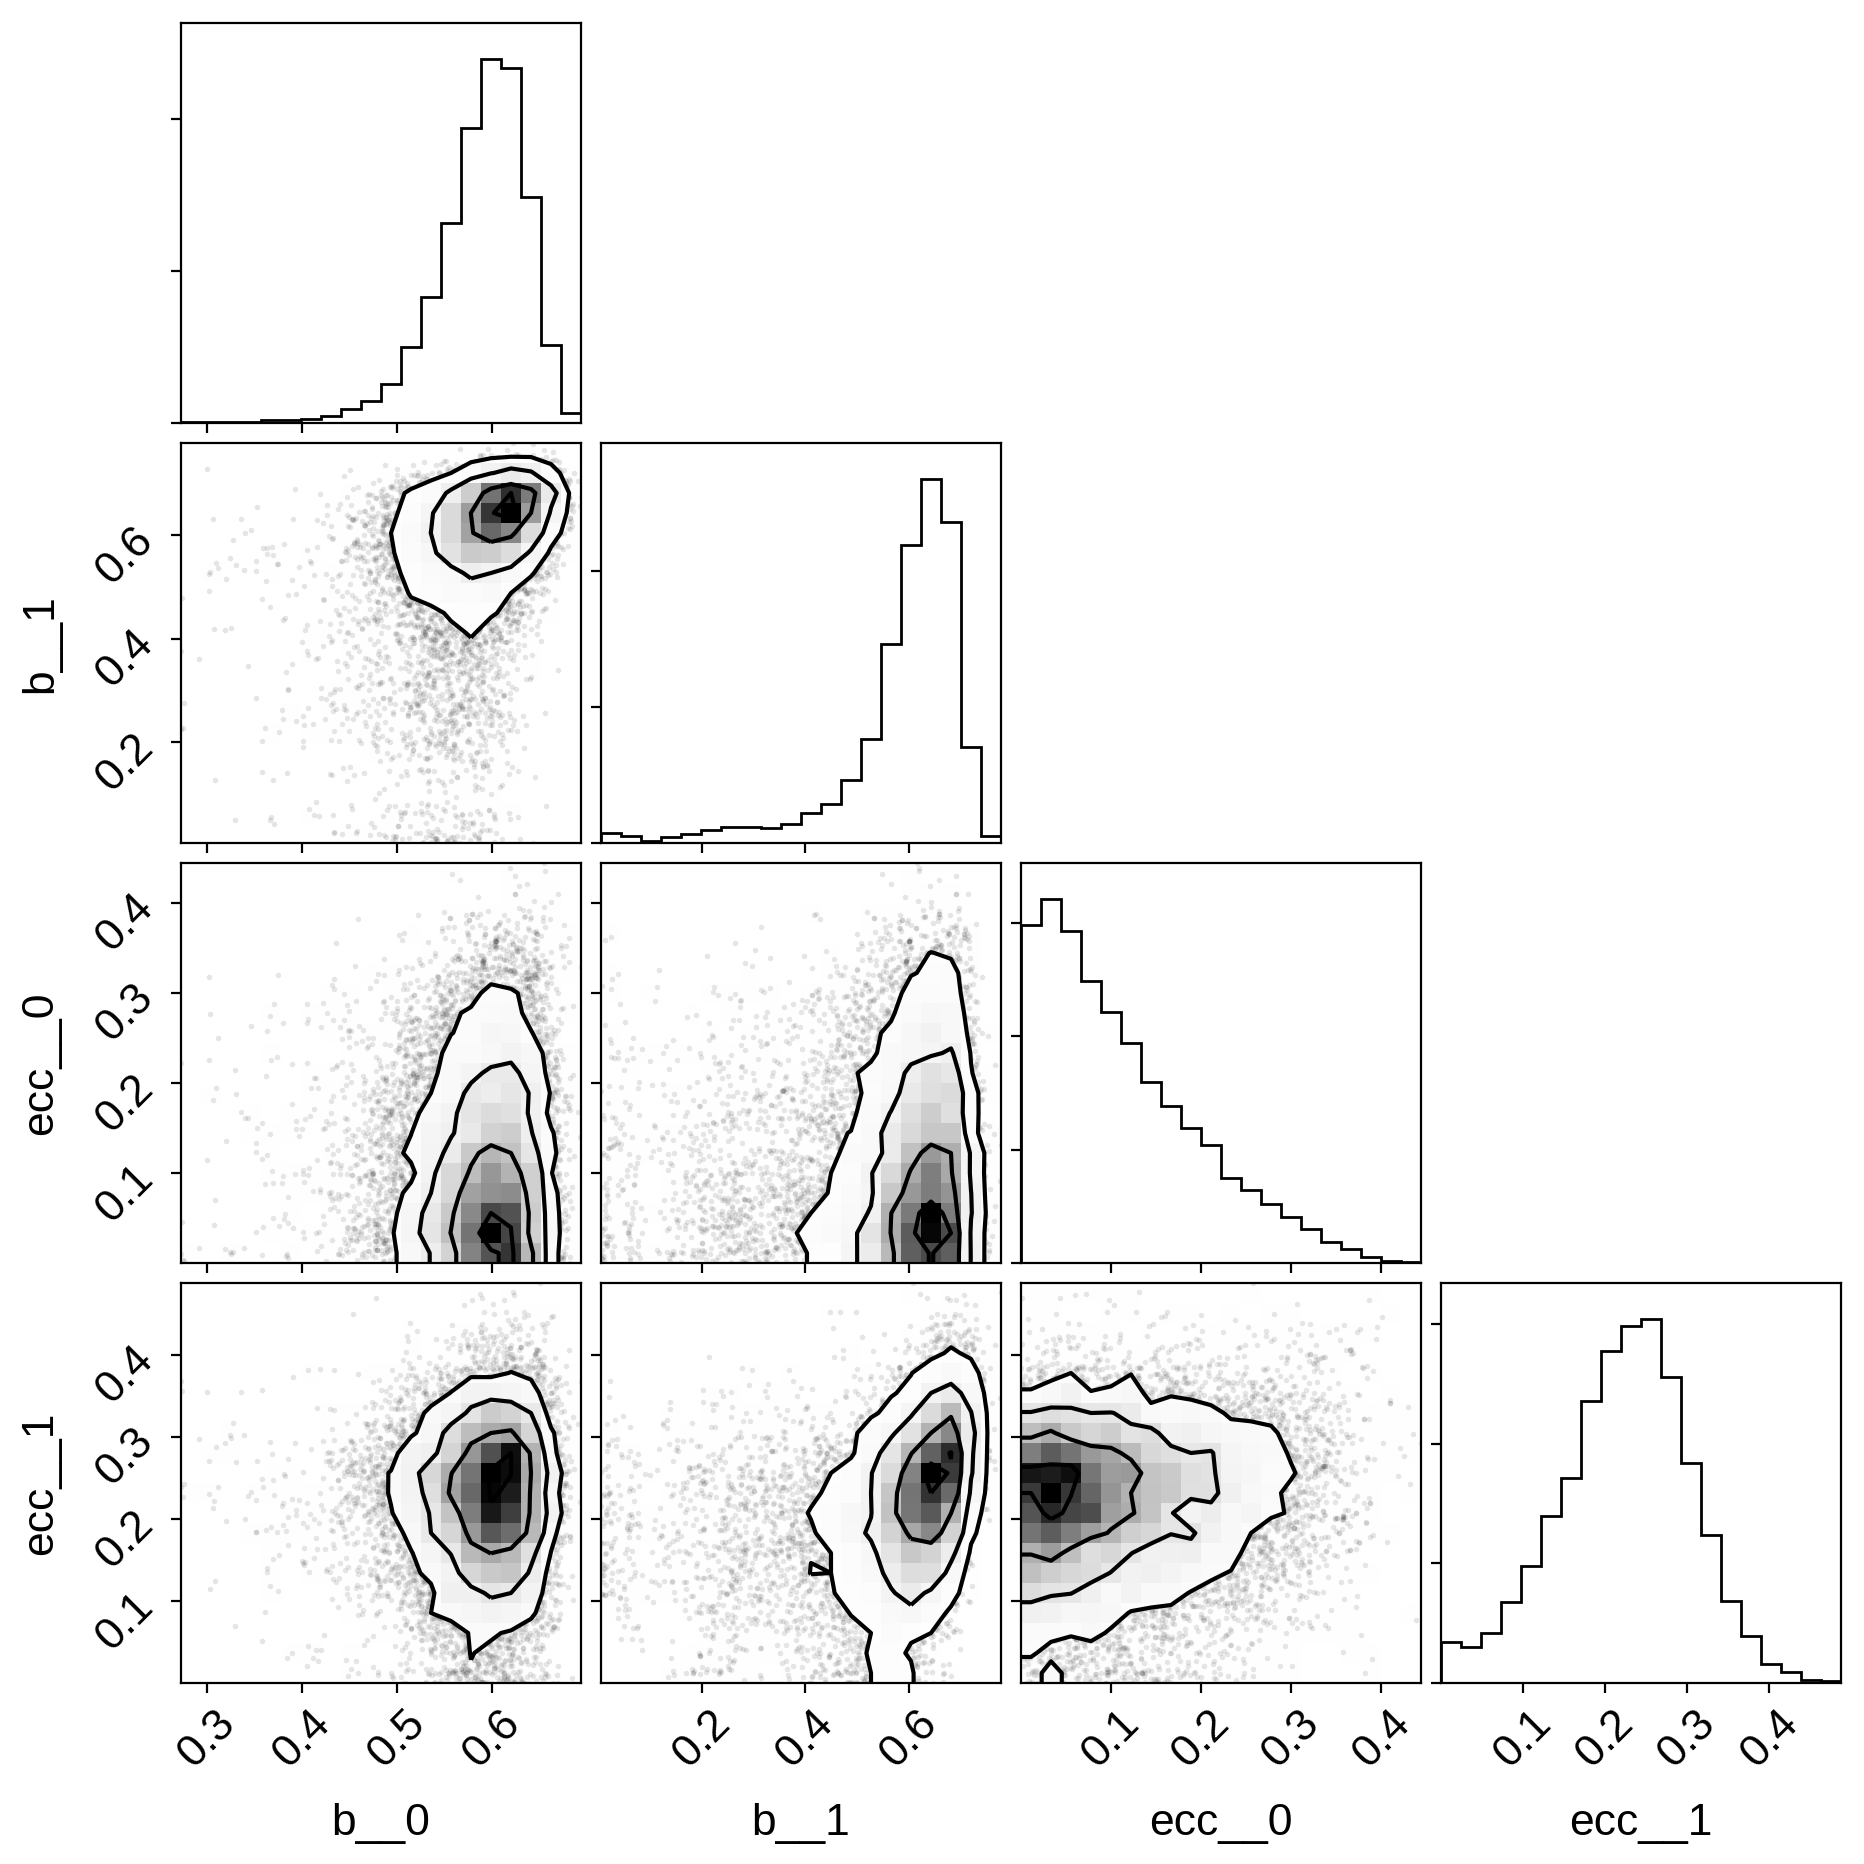

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

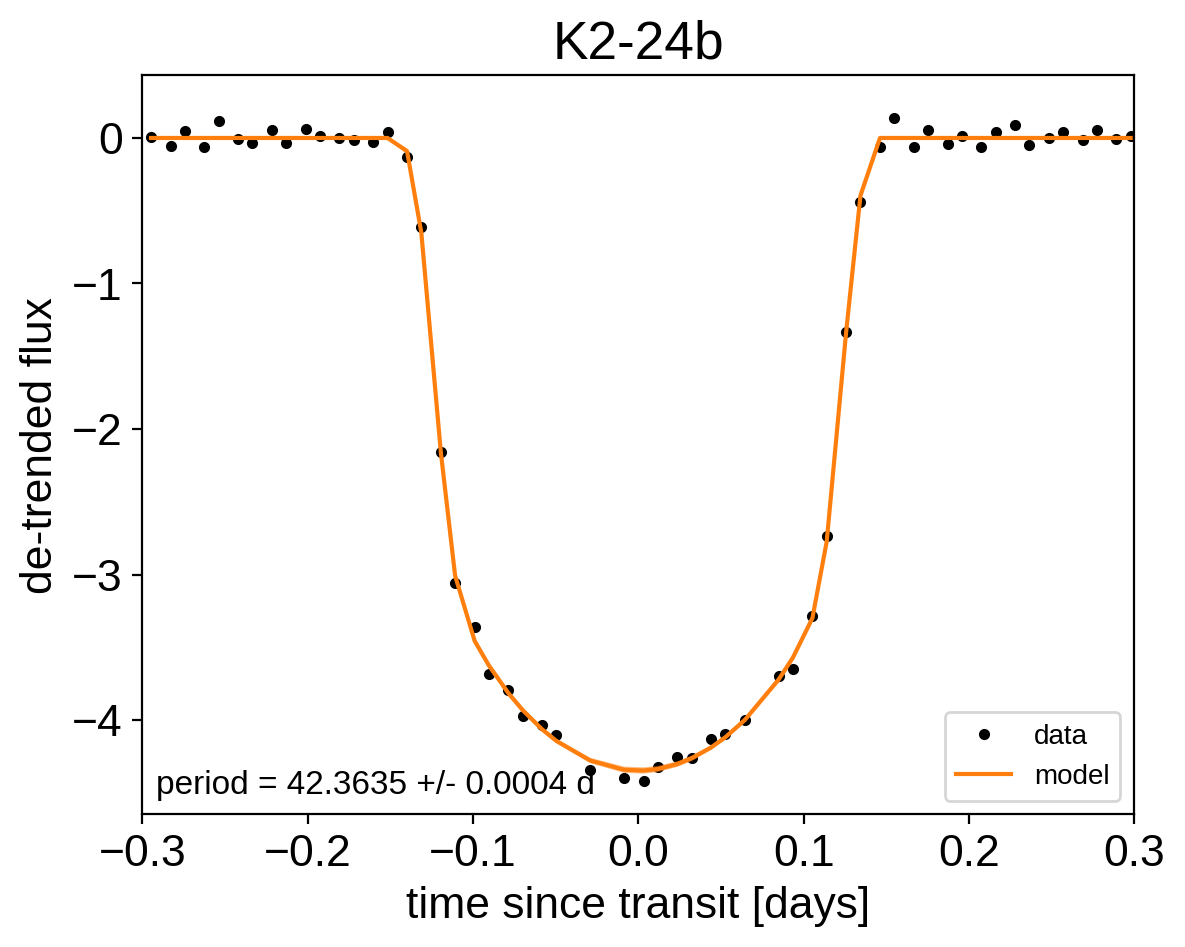

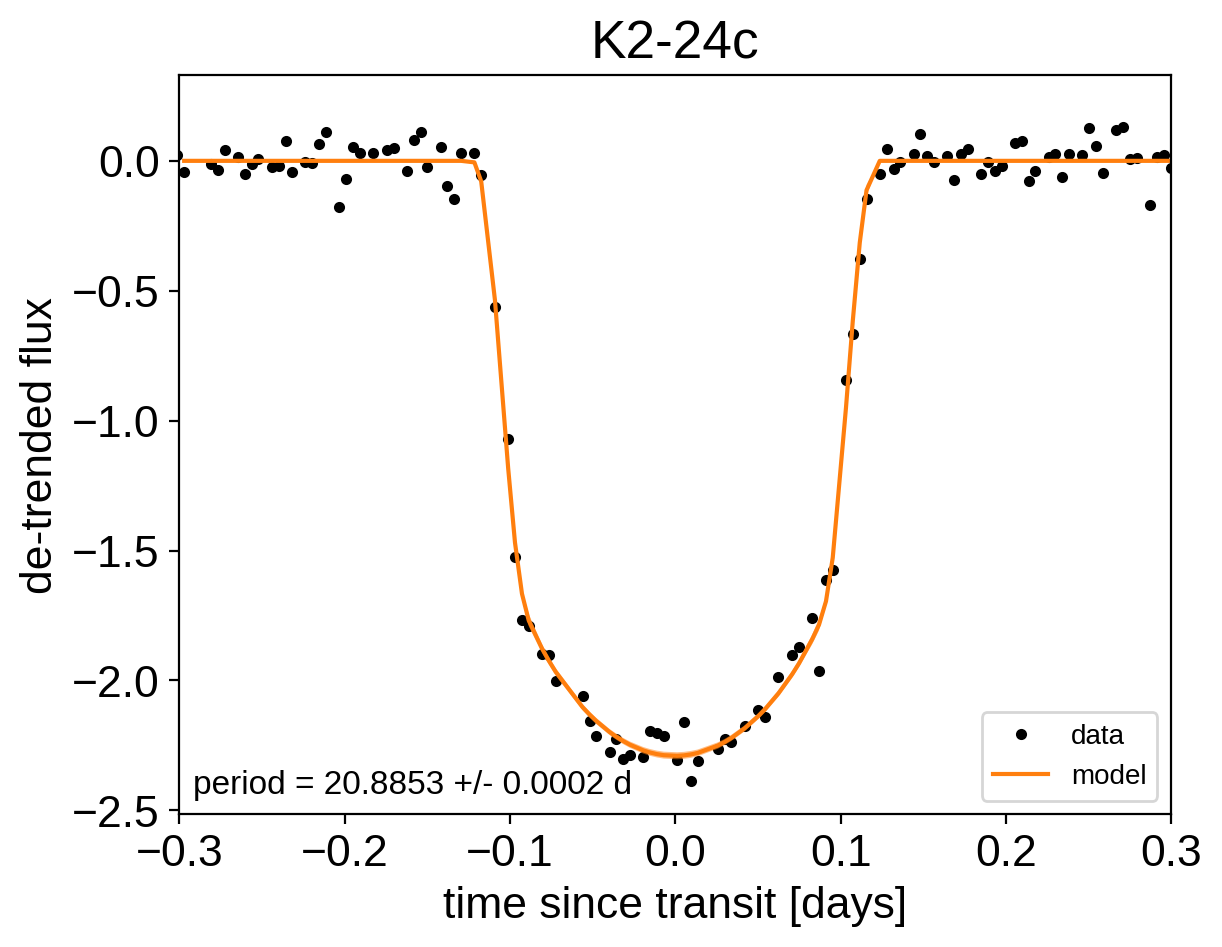

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

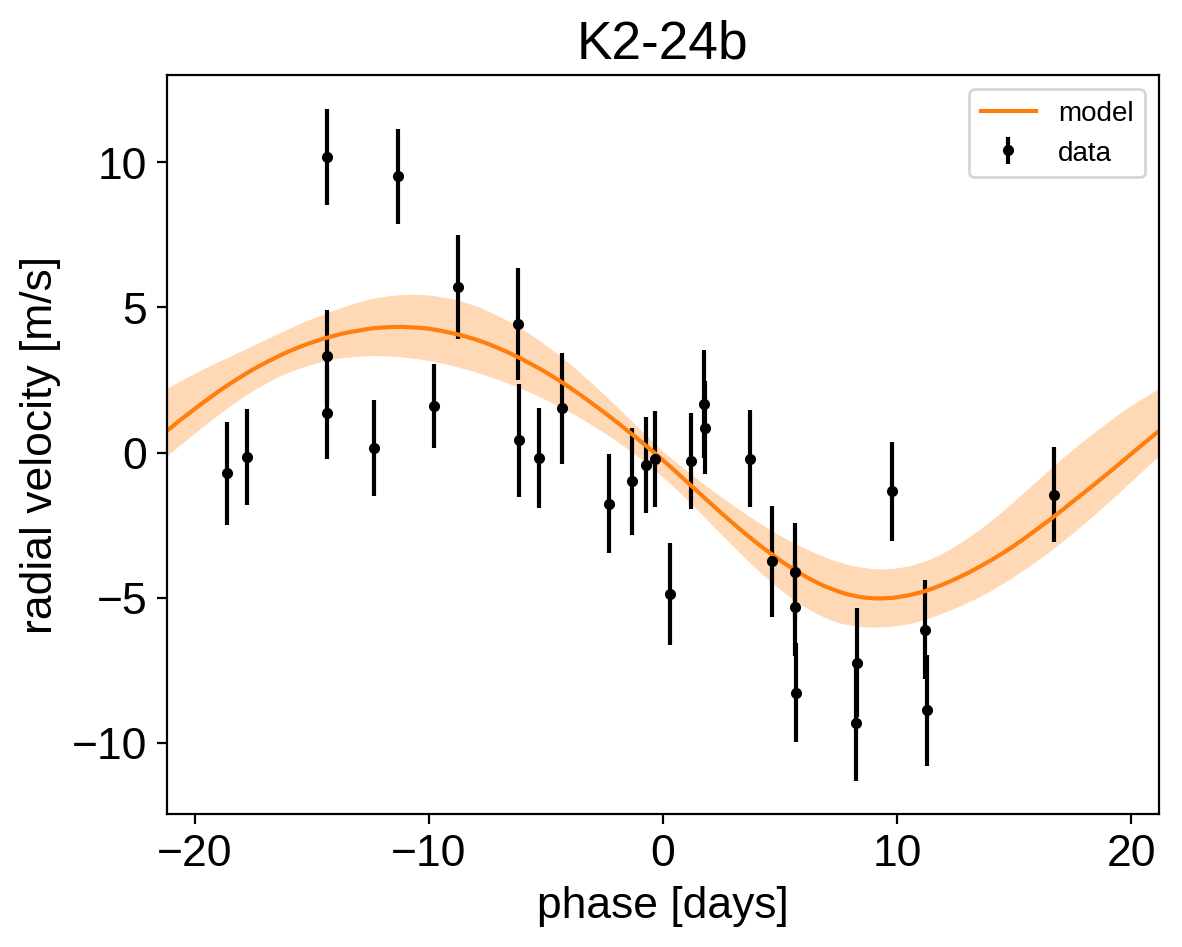

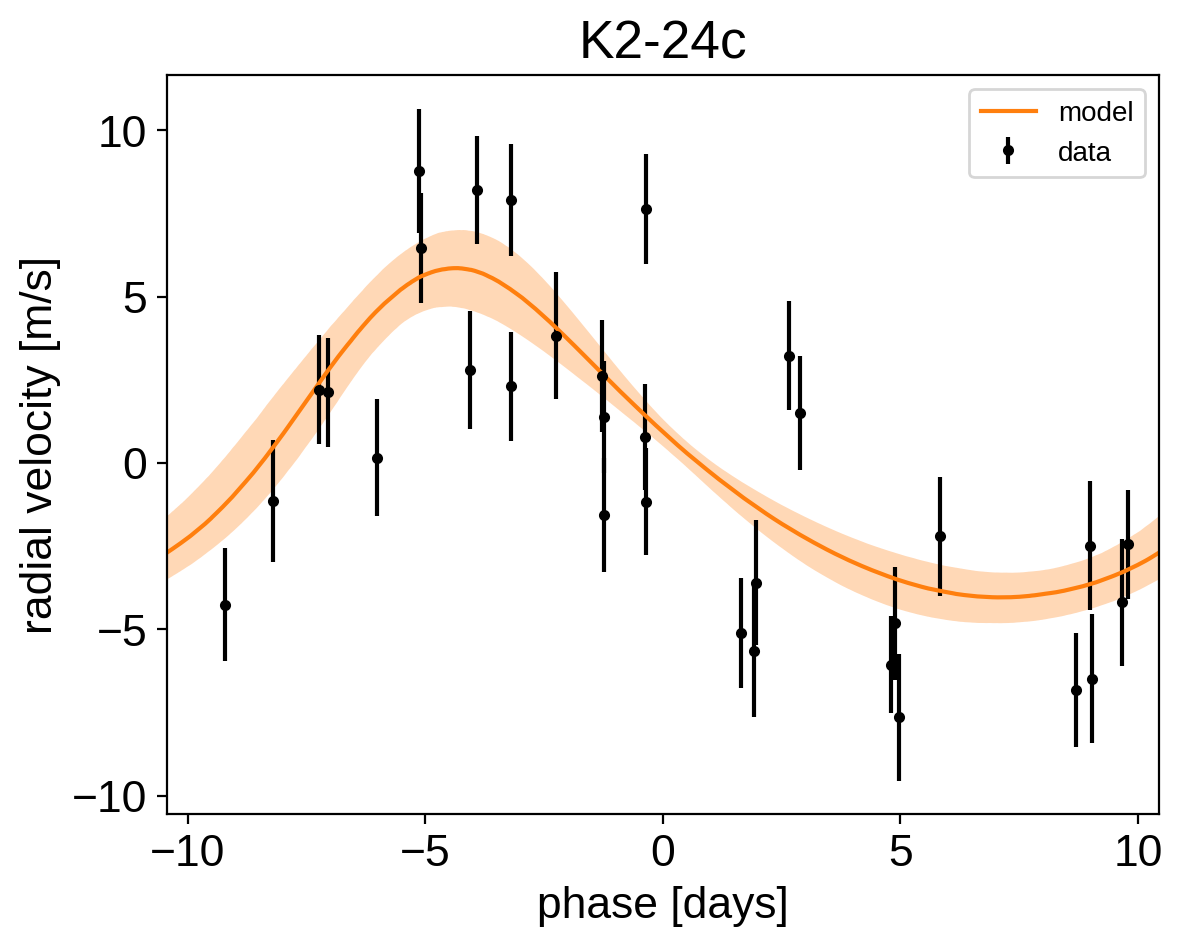

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

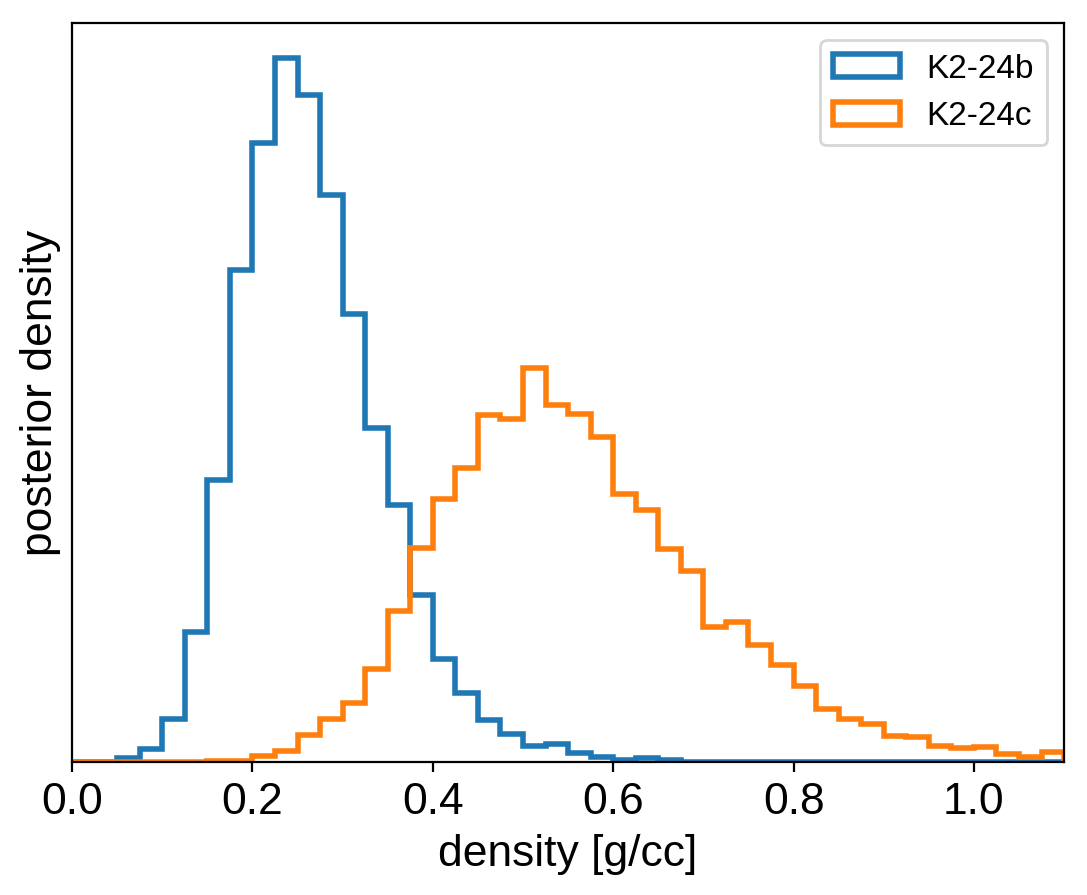

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
